# Optimize noise injection for ASTRI

In [132]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)

import matplotlib.colors as colors

import math

import sys
sys.path.append("..")
import datapipe
import datapipe.io.montecarlo_calibration_astri as mc_calibration

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

import scipy.stats

import json

## Read the simtel file and make samples

In [2]:
%%time

tel_id_filter_list = range(0, 34)
#tel_id_filter_list = range(1, 3)

event_id_filter_list = None

simtel_file = "/Users/jdecock/data/astri_mini_array/gamma/run1001.simtel.gz"

source = hessio_event_source(simtel_file, allowed_tels=tel_id_filter_list)

in_sample_list = []
sig_sample_list = []
noise_sample_list = []
noise2_sample_list = []

for event in source:

    event_id = int(event.dl0.event_id)

    if (event_id_filter_list is None) or (event_id in event_id_filter_list):

        for tel_id in event.trig.tels_with_trigger:

            tel_id = int(tel_id)

            if tel_id in tel_id_filter_list:

                # CHECK THE IMAGE GEOMETRY (ASTRI ONLY) ###################

                x, y = event.inst.pixel_pos[tel_id]
                foclen = event.inst.optical_foclen[tel_id]
                geom = ctapipe.instrument.camera.CameraGeometry.guess(x, y, foclen)

                if (geom.pix_type != "rectangular") or (geom.cam_id not in ("ASTRI", "ASTRICam")):
                    raise ValueError("Telescope {}: error (the input image is not a valide ASTRI telescope image)".format(tel_id))

                # GET IMAGES ##############################################

                pe_image = event.mc.tel[tel_id].photo_electron_image  # 1D np array

                uncalibrated_image = event.r0.tel[tel_id].adc_sums    # ctapipe 0.4.0
                pedestal = event.mc.tel[tel_id].pedestal
                gain = event.mc.tel[tel_id].dc_to_pe
                pixel_pos = event.inst.pixel_pos[tel_id]

                calibrated_image = mc_calibration.apply_mc_calibration(uncalibrated_image, pedestal, gain)
                
                in_sample_list.append(calibrated_image)
                sig_sample_list.append(pe_image)
                noise_sample_list.append(calibrated_image - pe_image)
                noise2_sample_list.extend(calibrated_image[pe_image == 0.].tolist())

CPU times: user 3min 49s, sys: 3.03 s, total: 3min 52s
Wall time: 4min 5s


In [3]:
in_sample_array = np.array(in_sample_list).ravel()
sig_sample_array = np.array(sig_sample_list).ravel()
noise_sample_array = np.array(noise_sample_list).ravel()
noise2_sample_array = np.array(noise2_sample_list)

## Save samples (for further use)

In [4]:
#data = {}

#data["in_sample"] = in_sample_array.tolist()
#data["sig_sample"] = sig_sample_array.tolist()
#data["noise_sample"] = noise_sample_array.tolist()
#data["noise2_sample"] = noise2_sample_list

#with open("../astri_hist.json", "w") as fd:
#    json.dump(data, fd, sort_keys=False, indent=1)

## Plot samples

### Calibrated input image (signal + noise)

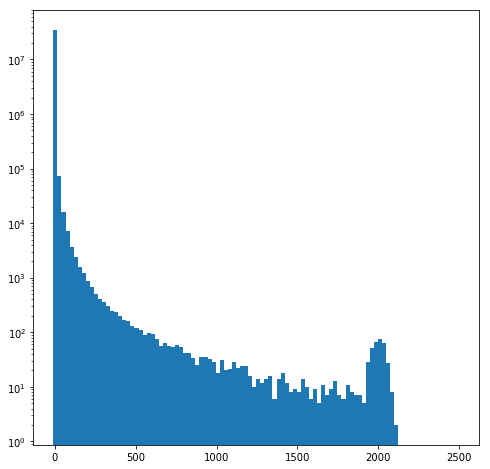

In [5]:
plt.hist(in_sample_array,
         bins=100,
         range=(-10, 2500),
         log=True);

### Signal

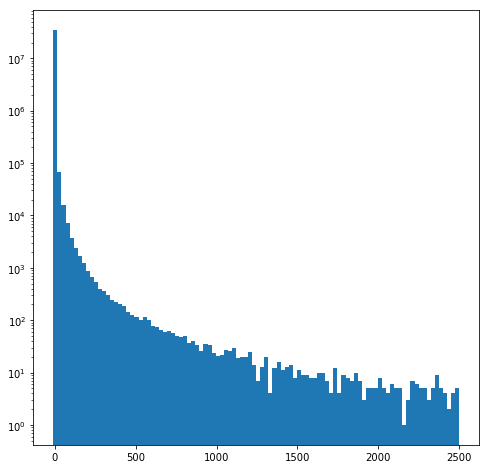

In [6]:
plt.hist(sig_sample_array,
         bins=100,
         range=(-10, 2500),
         log=True);

### Noise version 1: input - signal

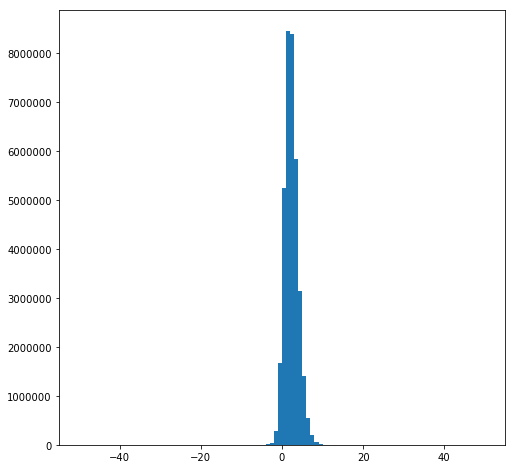

In [7]:
plt.hist(noise_sample_array,
         bins=100,
         range=(-50, 50),    # the actual range is larger than that because of outliers...
         log=False);

### Noise version 2: input where signal = 0

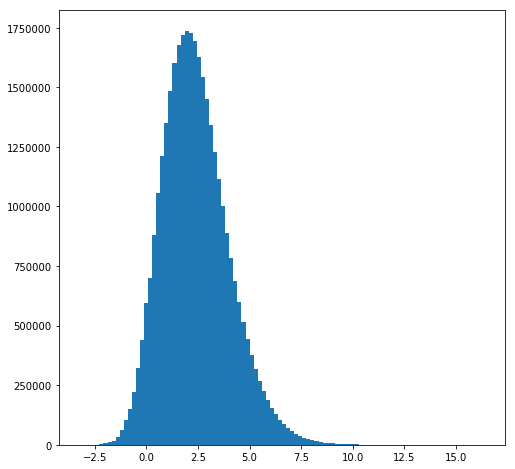

In [8]:
plt.hist(noise2_sample_array,
         bins=100,
         range=(noise2_sample_array.min(), noise2_sample_array.max()),
         log=False);

In [9]:
print("min:", noise2_sample_array.min())
print("max:", noise2_sample_array.max())
print("mean:", noise2_sample_array.mean())
print("std:", noise2_sample_array.std())

min: -3.26178941131
max: 16.4109393489
mean: 2.3908609943
std: 1.61261241498


## Compute the $\chi^2$: an example with a given model using scipy

Sample min value: 0
Sample max value: 16
x_h: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
bins: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
y_h: [  4.63452998e+06   9.26905996e+06   9.26905996e+06   6.17937330e+06
   3.08968665e+06   1.23587466e+06   4.11958220e+05   1.17702349e+05
   2.94255872e+04   6.53901937e+03   1.30780387e+03   2.37782523e+02
   3.96304204e+01   6.09698776e+00   8.70998251e-01   1.16133100e-01
   1.45166375e-02]
y_e: [5023623 8252644 8246753 5745670 3098020 1390933  541024  189409   60778
   18112    4911    1244     316      91      18       2       3]


463077.847162558

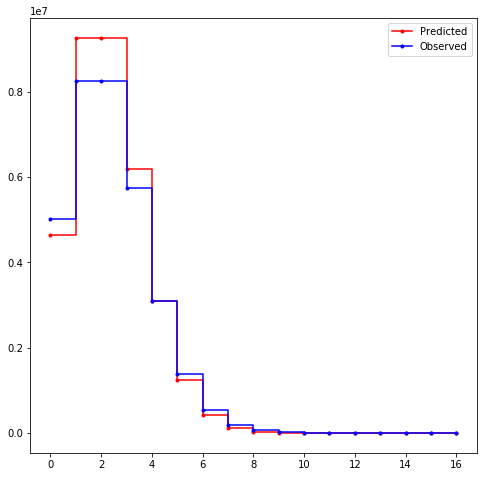

In [10]:
data = noise2_sample_array

def dist_chi2(k, *param):
    
    min_value = 0 # math.floor(data.min())   # TODO !
    max_value = math.floor(data.max())
    
    x_h = np.arange(min_value, max_value+1, 1)
    
    print("Sample min value:", min_value)
    print("Sample max value:", max_value)
    
    # Predicted values ################
    
    dist = scipy.stats.poisson(k)
    y_h = dist.pmf(x_h) * len(data)

    # Observed values #################
    
    bins = np.concatenate([x_h, np.array([x_h[-1] + 1])])
    y_e, _bins = np.histogram(data, bins=bins) #, normed=True)

    # https://github.com/numpy/numpy/issues/1894
    #np.bincount(np.array([3, 4, 3, 5, 4, 3, 3, 3, 4]))  # only works with positive values
    #y_e = np.bincount(data)
    
    # Compute the Chi2 ################

    dist = scipy.stats.chisquare(y_e, y_h)
    chi2 = dist.statistic
    
    # Plot ############################
    
    print("x_h:", x_h)
    print("bins:", bins)
    print("y_h:", y_h)
    print("y_e:", y_e)
    
    plt.step(x_h, y_h, 'r.', where='post', label="Predicted")
    plt.step(x_h, y_e, 'b.', where='post', label="Observed")
    plt.legend()

    return chi2

dist_chi2(2.)

## Compute the $\chi^2$: another example approximating the PDF's model empirically

In [31]:
%%time

data = noise2_sample_array

min_value = -3  # math.floor(data.min())   # TODO if Gaussian not used
max_value = 10  # math.floor(data.max())   # TODO !!

x_h = np.arange(min_value, max_value+1, 1)

#print("Sample min value:", min_value)
#print("Sample max value:", max_value)

bins = np.concatenate([x_h, np.array([x_h[-1] + 1])])

# Observed values #################

y_e, _bins = np.histogram(data, bins=bins, normed=False)

# https://github.com/numpy/numpy/issues/1894
#np.bincount(np.array([3, 4, 3, 5, 4, 3, 3, 3, 4]))  # only works with positive values
#y_e = np.bincount(data)

CPU times: user 2.73 s, sys: 8.43 ms, total: 2.74 s
Wall time: 2.74 s


In [151]:
def dist_chi2(x, verbose=False, plot=False, very_verbose=False):
    k, mu, sigma = x
    
    try:
        # Predicted values ################

        size = 1000000
        
        data_h = np.zeros(size)
        if k is not None:
            data_h += np.random.poisson(lam=k, size=size).astype('float64')
        if (mu is not None) and (sigma is not None):
            data_h += np.random.normal(loc=mu, scale=sigma, size=size)

        y_h, _bins = np.histogram(data_h, bins=bins, normed=False)

        y_h = y_h * len(data) / size

        # Compute the Chi2 ################

        dist = scipy.stats.chisquare(y_e, y_h)
        chi2 = dist.statistic

        # Plot ############################

        if very_verbose:
            print("x_h:", x_h)
            print("bins:", bins)
            print("y_h:", y_h)
            print("y_e:", y_e)
            
        if plot:
            plt.step(x_h, y_h, 'r.', where='post', label="Predicted")
            plt.step(x_h, y_e, 'b.', where='post', label="Observed")
            plt.legend()
    except Exception as e:
        print(x, e)
        #chi2 = 1.
        #chi2 = np.nan     # would "inf" be better ?
        chi2 = np.inf
    
    if verbose:
        print(">", x, chi2)

    return chi2

In [152]:
%%time

# Test the above function
x = (1.9, 0.5, 0.8)
print("Chi2=", dist_chi2(x))

Chi2= 37344.7504321
CPU times: user 261 ms, sys: 7.27 ms, total: 268 ms
Wall time: 267 ms


## Optimize the $\chi^2$ with scipy (using the "brute force" optimizer)

In [65]:
%%time

from scipy import optimize

k_slice = slice(1, 6, 0.1)
mu_slice = slice(-4, 4, 0.1)
sigma_slice = slice(-4, 4, 0.1)

search_ranges = (k_slice, mu_slice, sigma_slice)
#search_ranges = (p_slice, )

res = optimize.brute(dist_chi2,
                     search_ranges,
                     #args=(True, False, False),
                     full_output=True,
                     finish=None)     #optimize.fmin)

[ 1. -4. -4.] scale <= 0
[ 1. -4. -4.] scale <= 0
[ 1.  -4.  -3.9] scale <= 0
[ 1.  -4.  -3.8] scale <= 0
[ 1.  -4.  -3.7] scale <= 0
[ 1.  -4.  -3.6] scale <= 0
[ 1.  -4.  -3.5] scale <= 0
[ 1.  -4.  -3.4] scale <= 0
[ 1.  -4.  -3.3] scale <= 0
[ 1.  -4.  -3.2] scale <= 0
[ 1.  -4.  -3.1] scale <= 0
[ 1. -4. -3.] scale <= 0
[ 1.  -4.  -2.9] scale <= 0
[ 1.  -4.  -2.8] scale <= 0
[ 1.  -4.  -2.7] scale <= 0
[ 1.  -4.  -2.6] scale <= 0
[ 1.  -4.  -2.5] scale <= 0
[ 1.  -4.  -2.4] scale <= 0
[ 1.  -4.  -2.3] scale <= 0
[ 1.  -4.  -2.2] scale <= 0
[ 1.  -4.  -2.1] scale <= 0
[ 1. -4. -2.] scale <= 0
[ 1.  -4.  -1.9] scale <= 0
[ 1.  -4.  -1.8] scale <= 0
[ 1.  -4.  -1.7] scale <= 0
[ 1.  -4.  -1.6] scale <= 0
[ 1.  -4.  -1.5] scale <= 0
[ 1.  -4.  -1.4] scale <= 0
[ 1.  -4.  -1.3] scale <= 0
[ 1.  -4.  -1.2] scale <= 0
[ 1.  -4.  -1.1] scale <= 0
[ 1. -4. -1.] scale <= 0
[ 1.  -4.  -0.9] scale <= 0
[ 1.  -4.  -0.8] scale <= 0
[ 1.  -4.  -0.7] scale <= 0
[ 1.  -4.  -0.6] scale <= 0
[ 1.  -

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


[ 1.  -3.9 -4. ] scale <= 0
[ 1.  -3.9 -3.9] scale <= 0
[ 1.  -3.9 -3.8] scale <= 0
[ 1.  -3.9 -3.7] scale <= 0
[ 1.  -3.9 -3.6] scale <= 0
[ 1.  -3.9 -3.5] scale <= 0
[ 1.  -3.9 -3.4] scale <= 0
[ 1.  -3.9 -3.3] scale <= 0
[ 1.  -3.9 -3.2] scale <= 0
[ 1.  -3.9 -3.1] scale <= 0
[ 1.  -3.9 -3. ] scale <= 0
[ 1.  -3.9 -2.9] scale <= 0
[ 1.  -3.9 -2.8] scale <= 0
[ 1.  -3.9 -2.7] scale <= 0
[ 1.  -3.9 -2.6] scale <= 0
[ 1.  -3.9 -2.5] scale <= 0
[ 1.  -3.9 -2.4] scale <= 0
[ 1.  -3.9 -2.3] scale <= 0
[ 1.  -3.9 -2.2] scale <= 0
[ 1.  -3.9 -2.1] scale <= 0
[ 1.  -3.9 -2. ] scale <= 0
[ 1.  -3.9 -1.9] scale <= 0
[ 1.  -3.9 -1.8] scale <= 0
[ 1.  -3.9 -1.7] scale <= 0
[ 1.  -3.9 -1.6] scale <= 0
[ 1.  -3.9 -1.5] scale <= 0
[ 1.  -3.9 -1.4] scale <= 0
[ 1.  -3.9 -1.3] scale <= 0
[ 1.  -3.9 -1.2] scale <= 0
[ 1.  -3.9 -1.1] scale <= 0
[ 1.  -3.9 -1. ] scale <= 0
[ 1.  -3.9 -0.9] scale <= 0
[ 1.  -3.9 -0.8] scale <= 0
[ 1.  -3.9 -0.7] scale <= 0
[ 1.  -3.9 -0.6] scale <= 0
[ 1.  -3.9 -0.5] sca

[ 1.  -3.2 -3.2] scale <= 0
[ 1.  -3.2 -3.1] scale <= 0
[ 1.  -3.2 -3. ] scale <= 0
[ 1.  -3.2 -2.9] scale <= 0
[ 1.  -3.2 -2.8] scale <= 0
[ 1.  -3.2 -2.7] scale <= 0
[ 1.  -3.2 -2.6] scale <= 0
[ 1.  -3.2 -2.5] scale <= 0
[ 1.  -3.2 -2.4] scale <= 0
[ 1.  -3.2 -2.3] scale <= 0
[ 1.  -3.2 -2.2] scale <= 0
[ 1.  -3.2 -2.1] scale <= 0
[ 1.  -3.2 -2. ] scale <= 0
[ 1.  -3.2 -1.9] scale <= 0
[ 1.  -3.2 -1.8] scale <= 0
[ 1.  -3.2 -1.7] scale <= 0
[ 1.  -3.2 -1.6] scale <= 0
[ 1.  -3.2 -1.5] scale <= 0
[ 1.  -3.2 -1.4] scale <= 0
[ 1.  -3.2 -1.3] scale <= 0
[ 1.  -3.2 -1.2] scale <= 0
[ 1.  -3.2 -1.1] scale <= 0
[ 1.  -3.2 -1. ] scale <= 0
[ 1.  -3.2 -0.9] scale <= 0
[ 1.  -3.2 -0.8] scale <= 0
[ 1.  -3.2 -0.7] scale <= 0
[ 1.  -3.2 -0.6] scale <= 0
[ 1.  -3.2 -0.5] scale <= 0
[ 1.  -3.2 -0.4] scale <= 0
[ 1.  -3.2 -0.3] scale <= 0
[ 1.  -3.2 -0.2] scale <= 0
[ 1.  -3.2 -0.1] scale <= 0
[ 1.  -3.2  0. ] scale <= 0
[ 1.  -3.1 -4. ] scale <= 0
[ 1.  -3.1 -3.9] scale <= 0
[ 1.  -3.1 -3.8] sca

[ 1.  -2.5 -2.4] scale <= 0
[ 1.  -2.5 -2.3] scale <= 0
[ 1.  -2.5 -2.2] scale <= 0
[ 1.  -2.5 -2.1] scale <= 0
[ 1.  -2.5 -2. ] scale <= 0
[ 1.  -2.5 -1.9] scale <= 0
[ 1.  -2.5 -1.8] scale <= 0
[ 1.  -2.5 -1.7] scale <= 0
[ 1.  -2.5 -1.6] scale <= 0
[ 1.  -2.5 -1.5] scale <= 0
[ 1.  -2.5 -1.4] scale <= 0
[ 1.  -2.5 -1.3] scale <= 0
[ 1.  -2.5 -1.2] scale <= 0
[ 1.  -2.5 -1.1] scale <= 0
[ 1.  -2.5 -1. ] scale <= 0
[ 1.  -2.5 -0.9] scale <= 0
[ 1.  -2.5 -0.8] scale <= 0
[ 1.  -2.5 -0.7] scale <= 0
[ 1.  -2.5 -0.6] scale <= 0
[ 1.  -2.5 -0.5] scale <= 0
[ 1.  -2.5 -0.4] scale <= 0
[ 1.  -2.5 -0.3] scale <= 0
[ 1.  -2.5 -0.2] scale <= 0
[ 1.  -2.5 -0.1] scale <= 0
[ 1.  -2.5  0. ] scale <= 0
[ 1.  -2.4 -4. ] scale <= 0
[ 1.  -2.4 -3.9] scale <= 0
[ 1.  -2.4 -3.8] scale <= 0
[ 1.  -2.4 -3.7] scale <= 0
[ 1.  -2.4 -3.6] scale <= 0
[ 1.  -2.4 -3.5] scale <= 0
[ 1.  -2.4 -3.4] scale <= 0
[ 1.  -2.4 -3.3] scale <= 0
[ 1.  -2.4 -3.2] scale <= 0
[ 1.  -2.4 -3.1] scale <= 0
[ 1.  -2.4 -3. ] sca

[ 1.  -1.8 -1.6] scale <= 0
[ 1.  -1.8 -1.5] scale <= 0
[ 1.  -1.8 -1.4] scale <= 0
[ 1.  -1.8 -1.3] scale <= 0
[ 1.  -1.8 -1.2] scale <= 0
[ 1.  -1.8 -1.1] scale <= 0
[ 1.  -1.8 -1. ] scale <= 0
[ 1.  -1.8 -0.9] scale <= 0
[ 1.  -1.8 -0.8] scale <= 0
[ 1.  -1.8 -0.7] scale <= 0
[ 1.  -1.8 -0.6] scale <= 0
[ 1.  -1.8 -0.5] scale <= 0
[ 1.  -1.8 -0.4] scale <= 0
[ 1.  -1.8 -0.3] scale <= 0
[ 1.  -1.8 -0.2] scale <= 0
[ 1.  -1.8 -0.1] scale <= 0
[ 1.  -1.8  0. ] scale <= 0
[ 1.  -1.7 -4. ] scale <= 0
[ 1.  -1.7 -3.9] scale <= 0
[ 1.  -1.7 -3.8] scale <= 0
[ 1.  -1.7 -3.7] scale <= 0
[ 1.  -1.7 -3.6] scale <= 0
[ 1.  -1.7 -3.5] scale <= 0
[ 1.  -1.7 -3.4] scale <= 0
[ 1.  -1.7 -3.3] scale <= 0
[ 1.  -1.7 -3.2] scale <= 0
[ 1.  -1.7 -3.1] scale <= 0
[ 1.  -1.7 -3. ] scale <= 0
[ 1.  -1.7 -2.9] scale <= 0
[ 1.  -1.7 -2.8] scale <= 0
[ 1.  -1.7 -2.7] scale <= 0
[ 1.  -1.7 -2.6] scale <= 0
[ 1.  -1.7 -2.5] scale <= 0
[ 1.  -1.7 -2.4] scale <= 0
[ 1.  -1.7 -2.3] scale <= 0
[ 1.  -1.7 -2.2] sca

[ 1.  -1.1 -0.8] scale <= 0
[ 1.  -1.1 -0.7] scale <= 0
[ 1.  -1.1 -0.6] scale <= 0
[ 1.  -1.1 -0.5] scale <= 0
[ 1.  -1.1 -0.4] scale <= 0
[ 1.  -1.1 -0.3] scale <= 0
[ 1.  -1.1 -0.2] scale <= 0
[ 1.  -1.1 -0.1] scale <= 0
[ 1.  -1.1  0. ] scale <= 0
[ 1. -1. -4.] scale <= 0
[ 1.  -1.  -3.9] scale <= 0
[ 1.  -1.  -3.8] scale <= 0
[ 1.  -1.  -3.7] scale <= 0
[ 1.  -1.  -3.6] scale <= 0
[ 1.  -1.  -3.5] scale <= 0
[ 1.  -1.  -3.4] scale <= 0
[ 1.  -1.  -3.3] scale <= 0
[ 1.  -1.  -3.2] scale <= 0
[ 1.  -1.  -3.1] scale <= 0
[ 1. -1. -3.] scale <= 0
[ 1.  -1.  -2.9] scale <= 0
[ 1.  -1.  -2.8] scale <= 0
[ 1.  -1.  -2.7] scale <= 0
[ 1.  -1.  -2.6] scale <= 0
[ 1.  -1.  -2.5] scale <= 0
[ 1.  -1.  -2.4] scale <= 0
[ 1.  -1.  -2.3] scale <= 0
[ 1.  -1.  -2.2] scale <= 0
[ 1.  -1.  -2.1] scale <= 0
[ 1. -1. -2.] scale <= 0
[ 1.  -1.  -1.9] scale <= 0
[ 1.  -1.  -1.8] scale <= 0
[ 1.  -1.  -1.7] scale <= 0
[ 1.  -1.  -1.6] scale <= 0
[ 1.  -1.  -1.5] scale <= 0
[ 1.  -1.  -1.4] scale <= 0
[

[ 1.  -0.4  0. ] scale <= 0
[ 1.  -0.3 -4. ] scale <= 0
[ 1.  -0.3 -3.9] scale <= 0
[ 1.  -0.3 -3.8] scale <= 0
[ 1.  -0.3 -3.7] scale <= 0
[ 1.  -0.3 -3.6] scale <= 0
[ 1.  -0.3 -3.5] scale <= 0
[ 1.  -0.3 -3.4] scale <= 0
[ 1.  -0.3 -3.3] scale <= 0
[ 1.  -0.3 -3.2] scale <= 0
[ 1.  -0.3 -3.1] scale <= 0
[ 1.  -0.3 -3. ] scale <= 0
[ 1.  -0.3 -2.9] scale <= 0
[ 1.  -0.3 -2.8] scale <= 0
[ 1.  -0.3 -2.7] scale <= 0
[ 1.  -0.3 -2.6] scale <= 0
[ 1.  -0.3 -2.5] scale <= 0
[ 1.  -0.3 -2.4] scale <= 0
[ 1.  -0.3 -2.3] scale <= 0
[ 1.  -0.3 -2.2] scale <= 0
[ 1.  -0.3 -2.1] scale <= 0
[ 1.  -0.3 -2. ] scale <= 0
[ 1.  -0.3 -1.9] scale <= 0
[ 1.  -0.3 -1.8] scale <= 0
[ 1.  -0.3 -1.7] scale <= 0
[ 1.  -0.3 -1.6] scale <= 0
[ 1.  -0.3 -1.5] scale <= 0
[ 1.  -0.3 -1.4] scale <= 0
[ 1.  -0.3 -1.3] scale <= 0
[ 1.  -0.3 -1.2] scale <= 0
[ 1.  -0.3 -1.1] scale <= 0
[ 1.  -0.3 -1. ] scale <= 0
[ 1.  -0.3 -0.9] scale <= 0
[ 1.  -0.3 -0.8] scale <= 0
[ 1.  -0.3 -0.7] scale <= 0
[ 1.  -0.3 -0.6] sca

[ 1.   0.4 -3.2] scale <= 0
[ 1.   0.4 -3.1] scale <= 0
[ 1.   0.4 -3. ] scale <= 0
[ 1.   0.4 -2.9] scale <= 0
[ 1.   0.4 -2.8] scale <= 0
[ 1.   0.4 -2.7] scale <= 0
[ 1.   0.4 -2.6] scale <= 0
[ 1.   0.4 -2.5] scale <= 0
[ 1.   0.4 -2.4] scale <= 0
[ 1.   0.4 -2.3] scale <= 0
[ 1.   0.4 -2.2] scale <= 0
[ 1.   0.4 -2.1] scale <= 0
[ 1.   0.4 -2. ] scale <= 0
[ 1.   0.4 -1.9] scale <= 0
[ 1.   0.4 -1.8] scale <= 0
[ 1.   0.4 -1.7] scale <= 0
[ 1.   0.4 -1.6] scale <= 0
[ 1.   0.4 -1.5] scale <= 0
[ 1.   0.4 -1.4] scale <= 0
[ 1.   0.4 -1.3] scale <= 0
[ 1.   0.4 -1.2] scale <= 0
[ 1.   0.4 -1.1] scale <= 0
[ 1.   0.4 -1. ] scale <= 0
[ 1.   0.4 -0.9] scale <= 0
[ 1.   0.4 -0.8] scale <= 0
[ 1.   0.4 -0.7] scale <= 0
[ 1.   0.4 -0.6] scale <= 0
[ 1.   0.4 -0.5] scale <= 0
[ 1.   0.4 -0.4] scale <= 0
[ 1.   0.4 -0.3] scale <= 0
[ 1.   0.4 -0.2] scale <= 0
[ 1.   0.4 -0.1] scale <= 0
[ 1.   0.4  0. ] scale <= 0
[ 1.   0.5 -4. ] scale <= 0
[ 1.   0.5 -3.9] scale <= 0
[ 1.   0.5 -3.8] sca

[ 1.   1.1 -2.4] scale <= 0
[ 1.   1.1 -2.3] scale <= 0
[ 1.   1.1 -2.2] scale <= 0
[ 1.   1.1 -2.1] scale <= 0
[ 1.   1.1 -2. ] scale <= 0
[ 1.   1.1 -1.9] scale <= 0
[ 1.   1.1 -1.8] scale <= 0
[ 1.   1.1 -1.7] scale <= 0
[ 1.   1.1 -1.6] scale <= 0
[ 1.   1.1 -1.5] scale <= 0
[ 1.   1.1 -1.4] scale <= 0
[ 1.   1.1 -1.3] scale <= 0
[ 1.   1.1 -1.2] scale <= 0
[ 1.   1.1 -1.1] scale <= 0
[ 1.   1.1 -1. ] scale <= 0
[ 1.   1.1 -0.9] scale <= 0
[ 1.   1.1 -0.8] scale <= 0
[ 1.   1.1 -0.7] scale <= 0
[ 1.   1.1 -0.6] scale <= 0
[ 1.   1.1 -0.5] scale <= 0
[ 1.   1.1 -0.4] scale <= 0
[ 1.   1.1 -0.3] scale <= 0
[ 1.   1.1 -0.2] scale <= 0
[ 1.   1.1 -0.1] scale <= 0
[ 1.   1.1  0. ] scale <= 0
[ 1.   1.2 -4. ] scale <= 0
[ 1.   1.2 -3.9] scale <= 0
[ 1.   1.2 -3.8] scale <= 0
[ 1.   1.2 -3.7] scale <= 0
[ 1.   1.2 -3.6] scale <= 0
[ 1.   1.2 -3.5] scale <= 0
[ 1.   1.2 -3.4] scale <= 0
[ 1.   1.2 -3.3] scale <= 0
[ 1.   1.2 -3.2] scale <= 0
[ 1.   1.2 -3.1] scale <= 0
[ 1.   1.2 -3. ] sca

[ 1.   1.8 -1.6] scale <= 0
[ 1.   1.8 -1.5] scale <= 0
[ 1.   1.8 -1.4] scale <= 0
[ 1.   1.8 -1.3] scale <= 0
[ 1.   1.8 -1.2] scale <= 0
[ 1.   1.8 -1.1] scale <= 0
[ 1.   1.8 -1. ] scale <= 0
[ 1.   1.8 -0.9] scale <= 0
[ 1.   1.8 -0.8] scale <= 0
[ 1.   1.8 -0.7] scale <= 0
[ 1.   1.8 -0.6] scale <= 0
[ 1.   1.8 -0.5] scale <= 0
[ 1.   1.8 -0.4] scale <= 0
[ 1.   1.8 -0.3] scale <= 0
[ 1.   1.8 -0.2] scale <= 0
[ 1.   1.8 -0.1] scale <= 0
[ 1.   1.8  0. ] scale <= 0
[ 1.   1.9 -4. ] scale <= 0
[ 1.   1.9 -3.9] scale <= 0
[ 1.   1.9 -3.8] scale <= 0
[ 1.   1.9 -3.7] scale <= 0
[ 1.   1.9 -3.6] scale <= 0
[ 1.   1.9 -3.5] scale <= 0
[ 1.   1.9 -3.4] scale <= 0
[ 1.   1.9 -3.3] scale <= 0
[ 1.   1.9 -3.2] scale <= 0
[ 1.   1.9 -3.1] scale <= 0
[ 1.   1.9 -3. ] scale <= 0
[ 1.   1.9 -2.9] scale <= 0
[ 1.   1.9 -2.8] scale <= 0
[ 1.   1.9 -2.7] scale <= 0
[ 1.   1.9 -2.6] scale <= 0
[ 1.   1.9 -2.5] scale <= 0
[ 1.   1.9 -2.4] scale <= 0
[ 1.   1.9 -2.3] scale <= 0
[ 1.   1.9 -2.2] sca

[ 1.   2.5 -0.8] scale <= 0
[ 1.   2.5 -0.7] scale <= 0
[ 1.   2.5 -0.6] scale <= 0
[ 1.   2.5 -0.5] scale <= 0
[ 1.   2.5 -0.4] scale <= 0
[ 1.   2.5 -0.3] scale <= 0
[ 1.   2.5 -0.2] scale <= 0
[ 1.   2.5 -0.1] scale <= 0
[ 1.   2.5  0. ] scale <= 0
[ 1.   2.6 -4. ] scale <= 0
[ 1.   2.6 -3.9] scale <= 0
[ 1.   2.6 -3.8] scale <= 0
[ 1.   2.6 -3.7] scale <= 0
[ 1.   2.6 -3.6] scale <= 0
[ 1.   2.6 -3.5] scale <= 0
[ 1.   2.6 -3.4] scale <= 0
[ 1.   2.6 -3.3] scale <= 0
[ 1.   2.6 -3.2] scale <= 0
[ 1.   2.6 -3.1] scale <= 0
[ 1.   2.6 -3. ] scale <= 0
[ 1.   2.6 -2.9] scale <= 0
[ 1.   2.6 -2.8] scale <= 0
[ 1.   2.6 -2.7] scale <= 0
[ 1.   2.6 -2.6] scale <= 0
[ 1.   2.6 -2.5] scale <= 0
[ 1.   2.6 -2.4] scale <= 0
[ 1.   2.6 -2.3] scale <= 0
[ 1.   2.6 -2.2] scale <= 0
[ 1.   2.6 -2.1] scale <= 0
[ 1.   2.6 -2. ] scale <= 0
[ 1.   2.6 -1.9] scale <= 0
[ 1.   2.6 -1.8] scale <= 0
[ 1.   2.6 -1.7] scale <= 0
[ 1.   2.6 -1.6] scale <= 0
[ 1.   2.6 -1.5] scale <= 0
[ 1.   2.6 -1.4] sca

[ 1.   3.2  0. ] scale <= 0
[ 1.   3.3 -4. ] scale <= 0
[ 1.   3.3 -3.9] scale <= 0
[ 1.   3.3 -3.8] scale <= 0
[ 1.   3.3 -3.7] scale <= 0
[ 1.   3.3 -3.6] scale <= 0
[ 1.   3.3 -3.5] scale <= 0
[ 1.   3.3 -3.4] scale <= 0
[ 1.   3.3 -3.3] scale <= 0
[ 1.   3.3 -3.2] scale <= 0
[ 1.   3.3 -3.1] scale <= 0
[ 1.   3.3 -3. ] scale <= 0
[ 1.   3.3 -2.9] scale <= 0
[ 1.   3.3 -2.8] scale <= 0
[ 1.   3.3 -2.7] scale <= 0
[ 1.   3.3 -2.6] scale <= 0
[ 1.   3.3 -2.5] scale <= 0
[ 1.   3.3 -2.4] scale <= 0
[ 1.   3.3 -2.3] scale <= 0
[ 1.   3.3 -2.2] scale <= 0
[ 1.   3.3 -2.1] scale <= 0
[ 1.   3.3 -2. ] scale <= 0
[ 1.   3.3 -1.9] scale <= 0
[ 1.   3.3 -1.8] scale <= 0
[ 1.   3.3 -1.7] scale <= 0
[ 1.   3.3 -1.6] scale <= 0
[ 1.   3.3 -1.5] scale <= 0
[ 1.   3.3 -1.4] scale <= 0
[ 1.   3.3 -1.3] scale <= 0
[ 1.   3.3 -1.2] scale <= 0
[ 1.   3.3 -1.1] scale <= 0
[ 1.   3.3 -1. ] scale <= 0
[ 1.   3.3 -0.9] scale <= 0
[ 1.   3.3 -0.8] scale <= 0
[ 1.   3.3 -0.7] scale <= 0
[ 1.   3.3 -0.6] sca

[ 1.1 -4.  -3.2] scale <= 0
[ 1.1 -4.  -3.1] scale <= 0
[ 1.1 -4.  -3. ] scale <= 0
[ 1.1 -4.  -2.9] scale <= 0
[ 1.1 -4.  -2.8] scale <= 0
[ 1.1 -4.  -2.7] scale <= 0
[ 1.1 -4.  -2.6] scale <= 0
[ 1.1 -4.  -2.5] scale <= 0
[ 1.1 -4.  -2.4] scale <= 0
[ 1.1 -4.  -2.3] scale <= 0
[ 1.1 -4.  -2.2] scale <= 0
[ 1.1 -4.  -2.1] scale <= 0
[ 1.1 -4.  -2. ] scale <= 0
[ 1.1 -4.  -1.9] scale <= 0
[ 1.1 -4.  -1.8] scale <= 0
[ 1.1 -4.  -1.7] scale <= 0
[ 1.1 -4.  -1.6] scale <= 0
[ 1.1 -4.  -1.5] scale <= 0
[ 1.1 -4.  -1.4] scale <= 0
[ 1.1 -4.  -1.3] scale <= 0
[ 1.1 -4.  -1.2] scale <= 0
[ 1.1 -4.  -1.1] scale <= 0
[ 1.1 -4.  -1. ] scale <= 0
[ 1.1 -4.  -0.9] scale <= 0
[ 1.1 -4.  -0.8] scale <= 0
[ 1.1 -4.  -0.7] scale <= 0
[ 1.1 -4.  -0.6] scale <= 0
[ 1.1 -4.  -0.5] scale <= 0
[ 1.1 -4.  -0.4] scale <= 0
[ 1.1 -4.  -0.3] scale <= 0
[ 1.1 -4.  -0.2] scale <= 0
[ 1.1 -4.  -0.1] scale <= 0
[ 1.1 -4.   0. ] scale <= 0
[ 1.1 -3.9 -4. ] scale <= 0
[ 1.1 -3.9 -3.9] scale <= 0
[ 1.1 -3.9 -3.8] sca

[ 1.1 -3.3 -2.4] scale <= 0
[ 1.1 -3.3 -2.3] scale <= 0
[ 1.1 -3.3 -2.2] scale <= 0
[ 1.1 -3.3 -2.1] scale <= 0
[ 1.1 -3.3 -2. ] scale <= 0
[ 1.1 -3.3 -1.9] scale <= 0
[ 1.1 -3.3 -1.8] scale <= 0
[ 1.1 -3.3 -1.7] scale <= 0
[ 1.1 -3.3 -1.6] scale <= 0
[ 1.1 -3.3 -1.5] scale <= 0
[ 1.1 -3.3 -1.4] scale <= 0
[ 1.1 -3.3 -1.3] scale <= 0
[ 1.1 -3.3 -1.2] scale <= 0
[ 1.1 -3.3 -1.1] scale <= 0
[ 1.1 -3.3 -1. ] scale <= 0
[ 1.1 -3.3 -0.9] scale <= 0
[ 1.1 -3.3 -0.8] scale <= 0
[ 1.1 -3.3 -0.7] scale <= 0
[ 1.1 -3.3 -0.6] scale <= 0
[ 1.1 -3.3 -0.5] scale <= 0
[ 1.1 -3.3 -0.4] scale <= 0
[ 1.1 -3.3 -0.3] scale <= 0
[ 1.1 -3.3 -0.2] scale <= 0
[ 1.1 -3.3 -0.1] scale <= 0
[ 1.1 -3.3  0. ] scale <= 0
[ 1.1 -3.2 -4. ] scale <= 0
[ 1.1 -3.2 -3.9] scale <= 0
[ 1.1 -3.2 -3.8] scale <= 0
[ 1.1 -3.2 -3.7] scale <= 0
[ 1.1 -3.2 -3.6] scale <= 0
[ 1.1 -3.2 -3.5] scale <= 0
[ 1.1 -3.2 -3.4] scale <= 0
[ 1.1 -3.2 -3.3] scale <= 0
[ 1.1 -3.2 -3.2] scale <= 0
[ 1.1 -3.2 -3.1] scale <= 0
[ 1.1 -3.2 -3. ] sca

[ 1.1 -2.6 -1.6] scale <= 0
[ 1.1 -2.6 -1.5] scale <= 0
[ 1.1 -2.6 -1.4] scale <= 0
[ 1.1 -2.6 -1.3] scale <= 0
[ 1.1 -2.6 -1.2] scale <= 0
[ 1.1 -2.6 -1.1] scale <= 0
[ 1.1 -2.6 -1. ] scale <= 0
[ 1.1 -2.6 -0.9] scale <= 0
[ 1.1 -2.6 -0.8] scale <= 0
[ 1.1 -2.6 -0.7] scale <= 0
[ 1.1 -2.6 -0.6] scale <= 0
[ 1.1 -2.6 -0.5] scale <= 0
[ 1.1 -2.6 -0.4] scale <= 0
[ 1.1 -2.6 -0.3] scale <= 0
[ 1.1 -2.6 -0.2] scale <= 0
[ 1.1 -2.6 -0.1] scale <= 0
[ 1.1 -2.6  0. ] scale <= 0
[ 1.1 -2.5 -4. ] scale <= 0
[ 1.1 -2.5 -3.9] scale <= 0
[ 1.1 -2.5 -3.8] scale <= 0
[ 1.1 -2.5 -3.7] scale <= 0
[ 1.1 -2.5 -3.6] scale <= 0
[ 1.1 -2.5 -3.5] scale <= 0
[ 1.1 -2.5 -3.4] scale <= 0
[ 1.1 -2.5 -3.3] scale <= 0
[ 1.1 -2.5 -3.2] scale <= 0
[ 1.1 -2.5 -3.1] scale <= 0
[ 1.1 -2.5 -3. ] scale <= 0
[ 1.1 -2.5 -2.9] scale <= 0
[ 1.1 -2.5 -2.8] scale <= 0
[ 1.1 -2.5 -2.7] scale <= 0
[ 1.1 -2.5 -2.6] scale <= 0
[ 1.1 -2.5 -2.5] scale <= 0
[ 1.1 -2.5 -2.4] scale <= 0
[ 1.1 -2.5 -2.3] scale <= 0
[ 1.1 -2.5 -2.2] sca

[ 1.1 -1.9 -0.8] scale <= 0
[ 1.1 -1.9 -0.7] scale <= 0
[ 1.1 -1.9 -0.6] scale <= 0
[ 1.1 -1.9 -0.5] scale <= 0
[ 1.1 -1.9 -0.4] scale <= 0
[ 1.1 -1.9 -0.3] scale <= 0
[ 1.1 -1.9 -0.2] scale <= 0
[ 1.1 -1.9 -0.1] scale <= 0
[ 1.1 -1.9  0. ] scale <= 0
[ 1.1 -1.8 -4. ] scale <= 0
[ 1.1 -1.8 -3.9] scale <= 0
[ 1.1 -1.8 -3.8] scale <= 0
[ 1.1 -1.8 -3.7] scale <= 0
[ 1.1 -1.8 -3.6] scale <= 0
[ 1.1 -1.8 -3.5] scale <= 0
[ 1.1 -1.8 -3.4] scale <= 0
[ 1.1 -1.8 -3.3] scale <= 0
[ 1.1 -1.8 -3.2] scale <= 0
[ 1.1 -1.8 -3.1] scale <= 0
[ 1.1 -1.8 -3. ] scale <= 0
[ 1.1 -1.8 -2.9] scale <= 0
[ 1.1 -1.8 -2.8] scale <= 0
[ 1.1 -1.8 -2.7] scale <= 0
[ 1.1 -1.8 -2.6] scale <= 0
[ 1.1 -1.8 -2.5] scale <= 0
[ 1.1 -1.8 -2.4] scale <= 0
[ 1.1 -1.8 -2.3] scale <= 0
[ 1.1 -1.8 -2.2] scale <= 0
[ 1.1 -1.8 -2.1] scale <= 0
[ 1.1 -1.8 -2. ] scale <= 0
[ 1.1 -1.8 -1.9] scale <= 0
[ 1.1 -1.8 -1.8] scale <= 0
[ 1.1 -1.8 -1.7] scale <= 0
[ 1.1 -1.8 -1.6] scale <= 0
[ 1.1 -1.8 -1.5] scale <= 0
[ 1.1 -1.8 -1.4] sca

[ 1.1 -1.2  0. ] scale <= 0
[ 1.1 -1.1 -4. ] scale <= 0
[ 1.1 -1.1 -3.9] scale <= 0
[ 1.1 -1.1 -3.8] scale <= 0
[ 1.1 -1.1 -3.7] scale <= 0
[ 1.1 -1.1 -3.6] scale <= 0
[ 1.1 -1.1 -3.5] scale <= 0
[ 1.1 -1.1 -3.4] scale <= 0
[ 1.1 -1.1 -3.3] scale <= 0
[ 1.1 -1.1 -3.2] scale <= 0
[ 1.1 -1.1 -3.1] scale <= 0
[ 1.1 -1.1 -3. ] scale <= 0
[ 1.1 -1.1 -2.9] scale <= 0
[ 1.1 -1.1 -2.8] scale <= 0
[ 1.1 -1.1 -2.7] scale <= 0
[ 1.1 -1.1 -2.6] scale <= 0
[ 1.1 -1.1 -2.5] scale <= 0
[ 1.1 -1.1 -2.4] scale <= 0
[ 1.1 -1.1 -2.3] scale <= 0
[ 1.1 -1.1 -2.2] scale <= 0
[ 1.1 -1.1 -2.1] scale <= 0
[ 1.1 -1.1 -2. ] scale <= 0
[ 1.1 -1.1 -1.9] scale <= 0
[ 1.1 -1.1 -1.8] scale <= 0
[ 1.1 -1.1 -1.7] scale <= 0
[ 1.1 -1.1 -1.6] scale <= 0
[ 1.1 -1.1 -1.5] scale <= 0
[ 1.1 -1.1 -1.4] scale <= 0
[ 1.1 -1.1 -1.3] scale <= 0
[ 1.1 -1.1 -1.2] scale <= 0
[ 1.1 -1.1 -1.1] scale <= 0
[ 1.1 -1.1 -1. ] scale <= 0
[ 1.1 -1.1 -0.9] scale <= 0
[ 1.1 -1.1 -0.8] scale <= 0
[ 1.1 -1.1 -0.7] scale <= 0
[ 1.1 -1.1 -0.6] sca

[ 1.1 -0.4 -3.2] scale <= 0
[ 1.1 -0.4 -3.1] scale <= 0
[ 1.1 -0.4 -3. ] scale <= 0
[ 1.1 -0.4 -2.9] scale <= 0
[ 1.1 -0.4 -2.8] scale <= 0
[ 1.1 -0.4 -2.7] scale <= 0
[ 1.1 -0.4 -2.6] scale <= 0
[ 1.1 -0.4 -2.5] scale <= 0
[ 1.1 -0.4 -2.4] scale <= 0
[ 1.1 -0.4 -2.3] scale <= 0
[ 1.1 -0.4 -2.2] scale <= 0
[ 1.1 -0.4 -2.1] scale <= 0
[ 1.1 -0.4 -2. ] scale <= 0
[ 1.1 -0.4 -1.9] scale <= 0
[ 1.1 -0.4 -1.8] scale <= 0
[ 1.1 -0.4 -1.7] scale <= 0
[ 1.1 -0.4 -1.6] scale <= 0
[ 1.1 -0.4 -1.5] scale <= 0
[ 1.1 -0.4 -1.4] scale <= 0
[ 1.1 -0.4 -1.3] scale <= 0
[ 1.1 -0.4 -1.2] scale <= 0
[ 1.1 -0.4 -1.1] scale <= 0
[ 1.1 -0.4 -1. ] scale <= 0
[ 1.1 -0.4 -0.9] scale <= 0
[ 1.1 -0.4 -0.8] scale <= 0
[ 1.1 -0.4 -0.7] scale <= 0
[ 1.1 -0.4 -0.6] scale <= 0
[ 1.1 -0.4 -0.5] scale <= 0
[ 1.1 -0.4 -0.4] scale <= 0
[ 1.1 -0.4 -0.3] scale <= 0
[ 1.1 -0.4 -0.2] scale <= 0
[ 1.1 -0.4 -0.1] scale <= 0
[ 1.1 -0.4  0. ] scale <= 0
[ 1.1 -0.3 -4. ] scale <= 0
[ 1.1 -0.3 -3.9] scale <= 0
[ 1.1 -0.3 -3.8] sca

[ 1.1  0.3 -2.4] scale <= 0
[ 1.1  0.3 -2.3] scale <= 0
[ 1.1  0.3 -2.2] scale <= 0
[ 1.1  0.3 -2.1] scale <= 0
[ 1.1  0.3 -2. ] scale <= 0
[ 1.1  0.3 -1.9] scale <= 0
[ 1.1  0.3 -1.8] scale <= 0
[ 1.1  0.3 -1.7] scale <= 0
[ 1.1  0.3 -1.6] scale <= 0
[ 1.1  0.3 -1.5] scale <= 0
[ 1.1  0.3 -1.4] scale <= 0
[ 1.1  0.3 -1.3] scale <= 0
[ 1.1  0.3 -1.2] scale <= 0
[ 1.1  0.3 -1.1] scale <= 0
[ 1.1  0.3 -1. ] scale <= 0
[ 1.1  0.3 -0.9] scale <= 0
[ 1.1  0.3 -0.8] scale <= 0
[ 1.1  0.3 -0.7] scale <= 0
[ 1.1  0.3 -0.6] scale <= 0
[ 1.1  0.3 -0.5] scale <= 0
[ 1.1  0.3 -0.4] scale <= 0
[ 1.1  0.3 -0.3] scale <= 0
[ 1.1  0.3 -0.2] scale <= 0
[ 1.1  0.3 -0.1] scale <= 0
[ 1.1  0.3  0. ] scale <= 0
[ 1.1  0.4 -4. ] scale <= 0
[ 1.1  0.4 -3.9] scale <= 0
[ 1.1  0.4 -3.8] scale <= 0
[ 1.1  0.4 -3.7] scale <= 0
[ 1.1  0.4 -3.6] scale <= 0
[ 1.1  0.4 -3.5] scale <= 0
[ 1.1  0.4 -3.4] scale <= 0
[ 1.1  0.4 -3.3] scale <= 0
[ 1.1  0.4 -3.2] scale <= 0
[ 1.1  0.4 -3.1] scale <= 0
[ 1.1  0.4 -3. ] sca

[ 1.1  1.  -1.6] scale <= 0
[ 1.1  1.  -1.5] scale <= 0
[ 1.1  1.  -1.4] scale <= 0
[ 1.1  1.  -1.3] scale <= 0
[ 1.1  1.  -1.2] scale <= 0
[ 1.1  1.  -1.1] scale <= 0
[ 1.1  1.  -1. ] scale <= 0
[ 1.1  1.  -0.9] scale <= 0
[ 1.1  1.  -0.8] scale <= 0
[ 1.1  1.  -0.7] scale <= 0
[ 1.1  1.  -0.6] scale <= 0
[ 1.1  1.  -0.5] scale <= 0
[ 1.1  1.  -0.4] scale <= 0
[ 1.1  1.  -0.3] scale <= 0
[ 1.1  1.  -0.2] scale <= 0
[ 1.1  1.  -0.1] scale <= 0
[ 1.1  1.   0. ] scale <= 0
[ 1.1  1.1 -4. ] scale <= 0
[ 1.1  1.1 -3.9] scale <= 0
[ 1.1  1.1 -3.8] scale <= 0
[ 1.1  1.1 -3.7] scale <= 0
[ 1.1  1.1 -3.6] scale <= 0
[ 1.1  1.1 -3.5] scale <= 0
[ 1.1  1.1 -3.4] scale <= 0
[ 1.1  1.1 -3.3] scale <= 0
[ 1.1  1.1 -3.2] scale <= 0
[ 1.1  1.1 -3.1] scale <= 0
[ 1.1  1.1 -3. ] scale <= 0
[ 1.1  1.1 -2.9] scale <= 0
[ 1.1  1.1 -2.8] scale <= 0
[ 1.1  1.1 -2.7] scale <= 0
[ 1.1  1.1 -2.6] scale <= 0
[ 1.1  1.1 -2.5] scale <= 0
[ 1.1  1.1 -2.4] scale <= 0
[ 1.1  1.1 -2.3] scale <= 0
[ 1.1  1.1 -2.2] sca

[ 1.1  1.7 -0.8] scale <= 0
[ 1.1  1.7 -0.7] scale <= 0
[ 1.1  1.7 -0.6] scale <= 0
[ 1.1  1.7 -0.5] scale <= 0
[ 1.1  1.7 -0.4] scale <= 0
[ 1.1  1.7 -0.3] scale <= 0
[ 1.1  1.7 -0.2] scale <= 0
[ 1.1  1.7 -0.1] scale <= 0
[ 1.1  1.7  0. ] scale <= 0
[ 1.1  1.8 -4. ] scale <= 0
[ 1.1  1.8 -3.9] scale <= 0
[ 1.1  1.8 -3.8] scale <= 0
[ 1.1  1.8 -3.7] scale <= 0
[ 1.1  1.8 -3.6] scale <= 0
[ 1.1  1.8 -3.5] scale <= 0
[ 1.1  1.8 -3.4] scale <= 0
[ 1.1  1.8 -3.3] scale <= 0
[ 1.1  1.8 -3.2] scale <= 0
[ 1.1  1.8 -3.1] scale <= 0
[ 1.1  1.8 -3. ] scale <= 0
[ 1.1  1.8 -2.9] scale <= 0
[ 1.1  1.8 -2.8] scale <= 0
[ 1.1  1.8 -2.7] scale <= 0
[ 1.1  1.8 -2.6] scale <= 0
[ 1.1  1.8 -2.5] scale <= 0
[ 1.1  1.8 -2.4] scale <= 0
[ 1.1  1.8 -2.3] scale <= 0
[ 1.1  1.8 -2.2] scale <= 0
[ 1.1  1.8 -2.1] scale <= 0
[ 1.1  1.8 -2. ] scale <= 0
[ 1.1  1.8 -1.9] scale <= 0
[ 1.1  1.8 -1.8] scale <= 0
[ 1.1  1.8 -1.7] scale <= 0
[ 1.1  1.8 -1.6] scale <= 0
[ 1.1  1.8 -1.5] scale <= 0
[ 1.1  1.8 -1.4] sca

[ 1.1  2.4  0. ] scale <= 0
[ 1.1  2.5 -4. ] scale <= 0
[ 1.1  2.5 -3.9] scale <= 0
[ 1.1  2.5 -3.8] scale <= 0
[ 1.1  2.5 -3.7] scale <= 0
[ 1.1  2.5 -3.6] scale <= 0
[ 1.1  2.5 -3.5] scale <= 0
[ 1.1  2.5 -3.4] scale <= 0
[ 1.1  2.5 -3.3] scale <= 0
[ 1.1  2.5 -3.2] scale <= 0
[ 1.1  2.5 -3.1] scale <= 0
[ 1.1  2.5 -3. ] scale <= 0
[ 1.1  2.5 -2.9] scale <= 0
[ 1.1  2.5 -2.8] scale <= 0
[ 1.1  2.5 -2.7] scale <= 0
[ 1.1  2.5 -2.6] scale <= 0
[ 1.1  2.5 -2.5] scale <= 0
[ 1.1  2.5 -2.4] scale <= 0
[ 1.1  2.5 -2.3] scale <= 0
[ 1.1  2.5 -2.2] scale <= 0
[ 1.1  2.5 -2.1] scale <= 0
[ 1.1  2.5 -2. ] scale <= 0
[ 1.1  2.5 -1.9] scale <= 0
[ 1.1  2.5 -1.8] scale <= 0
[ 1.1  2.5 -1.7] scale <= 0
[ 1.1  2.5 -1.6] scale <= 0
[ 1.1  2.5 -1.5] scale <= 0
[ 1.1  2.5 -1.4] scale <= 0
[ 1.1  2.5 -1.3] scale <= 0
[ 1.1  2.5 -1.2] scale <= 0
[ 1.1  2.5 -1.1] scale <= 0
[ 1.1  2.5 -1. ] scale <= 0
[ 1.1  2.5 -0.9] scale <= 0
[ 1.1  2.5 -0.8] scale <= 0
[ 1.1  2.5 -0.7] scale <= 0
[ 1.1  2.5 -0.6] sca

[ 1.1  3.2 -3.2] scale <= 0
[ 1.1  3.2 -3.1] scale <= 0
[ 1.1  3.2 -3. ] scale <= 0
[ 1.1  3.2 -2.9] scale <= 0
[ 1.1  3.2 -2.8] scale <= 0
[ 1.1  3.2 -2.7] scale <= 0
[ 1.1  3.2 -2.6] scale <= 0
[ 1.1  3.2 -2.5] scale <= 0
[ 1.1  3.2 -2.4] scale <= 0
[ 1.1  3.2 -2.3] scale <= 0
[ 1.1  3.2 -2.2] scale <= 0
[ 1.1  3.2 -2.1] scale <= 0
[ 1.1  3.2 -2. ] scale <= 0
[ 1.1  3.2 -1.9] scale <= 0
[ 1.1  3.2 -1.8] scale <= 0
[ 1.1  3.2 -1.7] scale <= 0
[ 1.1  3.2 -1.6] scale <= 0
[ 1.1  3.2 -1.5] scale <= 0
[ 1.1  3.2 -1.4] scale <= 0
[ 1.1  3.2 -1.3] scale <= 0
[ 1.1  3.2 -1.2] scale <= 0
[ 1.1  3.2 -1.1] scale <= 0
[ 1.1  3.2 -1. ] scale <= 0
[ 1.1  3.2 -0.9] scale <= 0
[ 1.1  3.2 -0.8] scale <= 0
[ 1.1  3.2 -0.7] scale <= 0
[ 1.1  3.2 -0.6] scale <= 0
[ 1.1  3.2 -0.5] scale <= 0
[ 1.1  3.2 -0.4] scale <= 0
[ 1.1  3.2 -0.3] scale <= 0
[ 1.1  3.2 -0.2] scale <= 0
[ 1.1  3.2 -0.1] scale <= 0
[ 1.1  3.2  0. ] scale <= 0
[ 1.1  3.3 -4. ] scale <= 0
[ 1.1  3.3 -3.9] scale <= 0
[ 1.1  3.3 -3.8] sca

[ 1.1  3.9 -2.4] scale <= 0
[ 1.1  3.9 -2.3] scale <= 0
[ 1.1  3.9 -2.2] scale <= 0
[ 1.1  3.9 -2.1] scale <= 0
[ 1.1  3.9 -2. ] scale <= 0
[ 1.1  3.9 -1.9] scale <= 0
[ 1.1  3.9 -1.8] scale <= 0
[ 1.1  3.9 -1.7] scale <= 0
[ 1.1  3.9 -1.6] scale <= 0
[ 1.1  3.9 -1.5] scale <= 0
[ 1.1  3.9 -1.4] scale <= 0
[ 1.1  3.9 -1.3] scale <= 0
[ 1.1  3.9 -1.2] scale <= 0
[ 1.1  3.9 -1.1] scale <= 0
[ 1.1  3.9 -1. ] scale <= 0
[ 1.1  3.9 -0.9] scale <= 0
[ 1.1  3.9 -0.8] scale <= 0
[ 1.1  3.9 -0.7] scale <= 0
[ 1.1  3.9 -0.6] scale <= 0
[ 1.1  3.9 -0.5] scale <= 0
[ 1.1  3.9 -0.4] scale <= 0
[ 1.1  3.9 -0.3] scale <= 0
[ 1.1  3.9 -0.2] scale <= 0
[ 1.1  3.9 -0.1] scale <= 0
[ 1.1  3.9  0. ] scale <= 0
[ 1.2 -4.  -4. ] scale <= 0
[ 1.2 -4.  -3.9] scale <= 0
[ 1.2 -4.  -3.8] scale <= 0
[ 1.2 -4.  -3.7] scale <= 0
[ 1.2 -4.  -3.6] scale <= 0
[ 1.2 -4.  -3.5] scale <= 0
[ 1.2 -4.  -3.4] scale <= 0
[ 1.2 -4.  -3.3] scale <= 0
[ 1.2 -4.  -3.2] scale <= 0
[ 1.2 -4.  -3.1] scale <= 0
[ 1.2 -4.  -3. ] sca

[ 1.2 -3.4 -1.6] scale <= 0
[ 1.2 -3.4 -1.5] scale <= 0
[ 1.2 -3.4 -1.4] scale <= 0
[ 1.2 -3.4 -1.3] scale <= 0
[ 1.2 -3.4 -1.2] scale <= 0
[ 1.2 -3.4 -1.1] scale <= 0
[ 1.2 -3.4 -1. ] scale <= 0
[ 1.2 -3.4 -0.9] scale <= 0
[ 1.2 -3.4 -0.8] scale <= 0
[ 1.2 -3.4 -0.7] scale <= 0
[ 1.2 -3.4 -0.6] scale <= 0
[ 1.2 -3.4 -0.5] scale <= 0
[ 1.2 -3.4 -0.4] scale <= 0
[ 1.2 -3.4 -0.3] scale <= 0
[ 1.2 -3.4 -0.2] scale <= 0
[ 1.2 -3.4 -0.1] scale <= 0
[ 1.2 -3.4  0. ] scale <= 0
[ 1.2 -3.3 -4. ] scale <= 0
[ 1.2 -3.3 -3.9] scale <= 0
[ 1.2 -3.3 -3.8] scale <= 0
[ 1.2 -3.3 -3.7] scale <= 0
[ 1.2 -3.3 -3.6] scale <= 0
[ 1.2 -3.3 -3.5] scale <= 0
[ 1.2 -3.3 -3.4] scale <= 0
[ 1.2 -3.3 -3.3] scale <= 0
[ 1.2 -3.3 -3.2] scale <= 0
[ 1.2 -3.3 -3.1] scale <= 0
[ 1.2 -3.3 -3. ] scale <= 0
[ 1.2 -3.3 -2.9] scale <= 0
[ 1.2 -3.3 -2.8] scale <= 0
[ 1.2 -3.3 -2.7] scale <= 0
[ 1.2 -3.3 -2.6] scale <= 0
[ 1.2 -3.3 -2.5] scale <= 0
[ 1.2 -3.3 -2.4] scale <= 0
[ 1.2 -3.3 -2.3] scale <= 0
[ 1.2 -3.3 -2.2] sca

[ 1.2 -2.7 -0.8] scale <= 0
[ 1.2 -2.7 -0.7] scale <= 0
[ 1.2 -2.7 -0.6] scale <= 0
[ 1.2 -2.7 -0.5] scale <= 0
[ 1.2 -2.7 -0.4] scale <= 0
[ 1.2 -2.7 -0.3] scale <= 0
[ 1.2 -2.7 -0.2] scale <= 0
[ 1.2 -2.7 -0.1] scale <= 0
[ 1.2 -2.7  0. ] scale <= 0
[ 1.2 -2.6 -4. ] scale <= 0
[ 1.2 -2.6 -3.9] scale <= 0
[ 1.2 -2.6 -3.8] scale <= 0
[ 1.2 -2.6 -3.7] scale <= 0
[ 1.2 -2.6 -3.6] scale <= 0
[ 1.2 -2.6 -3.5] scale <= 0
[ 1.2 -2.6 -3.4] scale <= 0
[ 1.2 -2.6 -3.3] scale <= 0
[ 1.2 -2.6 -3.2] scale <= 0
[ 1.2 -2.6 -3.1] scale <= 0
[ 1.2 -2.6 -3. ] scale <= 0
[ 1.2 -2.6 -2.9] scale <= 0
[ 1.2 -2.6 -2.8] scale <= 0
[ 1.2 -2.6 -2.7] scale <= 0
[ 1.2 -2.6 -2.6] scale <= 0
[ 1.2 -2.6 -2.5] scale <= 0
[ 1.2 -2.6 -2.4] scale <= 0
[ 1.2 -2.6 -2.3] scale <= 0
[ 1.2 -2.6 -2.2] scale <= 0
[ 1.2 -2.6 -2.1] scale <= 0
[ 1.2 -2.6 -2. ] scale <= 0
[ 1.2 -2.6 -1.9] scale <= 0
[ 1.2 -2.6 -1.8] scale <= 0
[ 1.2 -2.6 -1.7] scale <= 0
[ 1.2 -2.6 -1.6] scale <= 0
[ 1.2 -2.6 -1.5] scale <= 0
[ 1.2 -2.6 -1.4] sca

[ 1.2 -2.   0. ] scale <= 0
[ 1.2 -1.9 -4. ] scale <= 0
[ 1.2 -1.9 -3.9] scale <= 0
[ 1.2 -1.9 -3.8] scale <= 0
[ 1.2 -1.9 -3.7] scale <= 0
[ 1.2 -1.9 -3.6] scale <= 0
[ 1.2 -1.9 -3.5] scale <= 0
[ 1.2 -1.9 -3.4] scale <= 0
[ 1.2 -1.9 -3.3] scale <= 0
[ 1.2 -1.9 -3.2] scale <= 0
[ 1.2 -1.9 -3.1] scale <= 0
[ 1.2 -1.9 -3. ] scale <= 0
[ 1.2 -1.9 -2.9] scale <= 0
[ 1.2 -1.9 -2.8] scale <= 0
[ 1.2 -1.9 -2.7] scale <= 0
[ 1.2 -1.9 -2.6] scale <= 0
[ 1.2 -1.9 -2.5] scale <= 0
[ 1.2 -1.9 -2.4] scale <= 0
[ 1.2 -1.9 -2.3] scale <= 0
[ 1.2 -1.9 -2.2] scale <= 0
[ 1.2 -1.9 -2.1] scale <= 0
[ 1.2 -1.9 -2. ] scale <= 0
[ 1.2 -1.9 -1.9] scale <= 0
[ 1.2 -1.9 -1.8] scale <= 0
[ 1.2 -1.9 -1.7] scale <= 0
[ 1.2 -1.9 -1.6] scale <= 0
[ 1.2 -1.9 -1.5] scale <= 0
[ 1.2 -1.9 -1.4] scale <= 0
[ 1.2 -1.9 -1.3] scale <= 0
[ 1.2 -1.9 -1.2] scale <= 0
[ 1.2 -1.9 -1.1] scale <= 0
[ 1.2 -1.9 -1. ] scale <= 0
[ 1.2 -1.9 -0.9] scale <= 0
[ 1.2 -1.9 -0.8] scale <= 0
[ 1.2 -1.9 -0.7] scale <= 0
[ 1.2 -1.9 -0.6] sca

[ 1.2 -1.2 -3.2] scale <= 0
[ 1.2 -1.2 -3.1] scale <= 0
[ 1.2 -1.2 -3. ] scale <= 0
[ 1.2 -1.2 -2.9] scale <= 0
[ 1.2 -1.2 -2.8] scale <= 0
[ 1.2 -1.2 -2.7] scale <= 0
[ 1.2 -1.2 -2.6] scale <= 0
[ 1.2 -1.2 -2.5] scale <= 0
[ 1.2 -1.2 -2.4] scale <= 0
[ 1.2 -1.2 -2.3] scale <= 0
[ 1.2 -1.2 -2.2] scale <= 0
[ 1.2 -1.2 -2.1] scale <= 0
[ 1.2 -1.2 -2. ] scale <= 0
[ 1.2 -1.2 -1.9] scale <= 0
[ 1.2 -1.2 -1.8] scale <= 0
[ 1.2 -1.2 -1.7] scale <= 0
[ 1.2 -1.2 -1.6] scale <= 0
[ 1.2 -1.2 -1.5] scale <= 0
[ 1.2 -1.2 -1.4] scale <= 0
[ 1.2 -1.2 -1.3] scale <= 0
[ 1.2 -1.2 -1.2] scale <= 0
[ 1.2 -1.2 -1.1] scale <= 0
[ 1.2 -1.2 -1. ] scale <= 0
[ 1.2 -1.2 -0.9] scale <= 0
[ 1.2 -1.2 -0.8] scale <= 0
[ 1.2 -1.2 -0.7] scale <= 0
[ 1.2 -1.2 -0.6] scale <= 0
[ 1.2 -1.2 -0.5] scale <= 0
[ 1.2 -1.2 -0.4] scale <= 0
[ 1.2 -1.2 -0.3] scale <= 0
[ 1.2 -1.2 -0.2] scale <= 0
[ 1.2 -1.2 -0.1] scale <= 0
[ 1.2 -1.2  0. ] scale <= 0
[ 1.2 -1.1 -4. ] scale <= 0
[ 1.2 -1.1 -3.9] scale <= 0
[ 1.2 -1.1 -3.8] sca

[ 1.2 -0.5 -2.5] scale <= 0
[ 1.2 -0.5 -2.4] scale <= 0
[ 1.2 -0.5 -2.3] scale <= 0
[ 1.2 -0.5 -2.2] scale <= 0
[ 1.2 -0.5 -2.1] scale <= 0
[ 1.2 -0.5 -2. ] scale <= 0
[ 1.2 -0.5 -1.9] scale <= 0
[ 1.2 -0.5 -1.8] scale <= 0
[ 1.2 -0.5 -1.7] scale <= 0
[ 1.2 -0.5 -1.6] scale <= 0
[ 1.2 -0.5 -1.5] scale <= 0
[ 1.2 -0.5 -1.4] scale <= 0
[ 1.2 -0.5 -1.3] scale <= 0
[ 1.2 -0.5 -1.2] scale <= 0
[ 1.2 -0.5 -1.1] scale <= 0
[ 1.2 -0.5 -1. ] scale <= 0
[ 1.2 -0.5 -0.9] scale <= 0
[ 1.2 -0.5 -0.8] scale <= 0
[ 1.2 -0.5 -0.7] scale <= 0
[ 1.2 -0.5 -0.6] scale <= 0
[ 1.2 -0.5 -0.5] scale <= 0
[ 1.2 -0.5 -0.4] scale <= 0
[ 1.2 -0.5 -0.3] scale <= 0
[ 1.2 -0.5 -0.2] scale <= 0
[ 1.2 -0.5 -0.1] scale <= 0
[ 1.2 -0.5  0. ] scale <= 0
[ 1.2 -0.4 -4. ] scale <= 0
[ 1.2 -0.4 -3.9] scale <= 0
[ 1.2 -0.4 -3.8] scale <= 0
[ 1.2 -0.4 -3.7] scale <= 0
[ 1.2 -0.4 -3.6] scale <= 0
[ 1.2 -0.4 -3.5] scale <= 0
[ 1.2 -0.4 -3.4] scale <= 0
[ 1.2 -0.4 -3.3] scale <= 0
[ 1.2 -0.4 -3.2] scale <= 0
[ 1.2 -0.4 -3.1] sca

[ 1.2  0.2 -1.8] scale <= 0
[ 1.2  0.2 -1.7] scale <= 0
[ 1.2  0.2 -1.6] scale <= 0
[ 1.2  0.2 -1.5] scale <= 0
[ 1.2  0.2 -1.4] scale <= 0
[ 1.2  0.2 -1.3] scale <= 0
[ 1.2  0.2 -1.2] scale <= 0
[ 1.2  0.2 -1.1] scale <= 0
[ 1.2  0.2 -1. ] scale <= 0
[ 1.2  0.2 -0.9] scale <= 0
[ 1.2  0.2 -0.8] scale <= 0
[ 1.2  0.2 -0.7] scale <= 0
[ 1.2  0.2 -0.6] scale <= 0
[ 1.2  0.2 -0.5] scale <= 0
[ 1.2  0.2 -0.4] scale <= 0
[ 1.2  0.2 -0.3] scale <= 0
[ 1.2  0.2 -0.2] scale <= 0
[ 1.2  0.2 -0.1] scale <= 0
[ 1.2  0.2  0. ] scale <= 0
[ 1.2  0.3 -4. ] scale <= 0
[ 1.2  0.3 -3.9] scale <= 0
[ 1.2  0.3 -3.8] scale <= 0
[ 1.2  0.3 -3.7] scale <= 0
[ 1.2  0.3 -3.6] scale <= 0
[ 1.2  0.3 -3.5] scale <= 0
[ 1.2  0.3 -3.4] scale <= 0
[ 1.2  0.3 -3.3] scale <= 0
[ 1.2  0.3 -3.2] scale <= 0
[ 1.2  0.3 -3.1] scale <= 0
[ 1.2  0.3 -3. ] scale <= 0
[ 1.2  0.3 -2.9] scale <= 0
[ 1.2  0.3 -2.8] scale <= 0
[ 1.2  0.3 -2.7] scale <= 0
[ 1.2  0.3 -2.6] scale <= 0
[ 1.2  0.3 -2.5] scale <= 0
[ 1.2  0.3 -2.4] sca

[ 1.2  0.9 -1.2] scale <= 0
[ 1.2  0.9 -1.1] scale <= 0
[ 1.2  0.9 -1. ] scale <= 0
[ 1.2  0.9 -0.9] scale <= 0
[ 1.2  0.9 -0.8] scale <= 0
[ 1.2  0.9 -0.7] scale <= 0
[ 1.2  0.9 -0.6] scale <= 0
[ 1.2  0.9 -0.5] scale <= 0
[ 1.2  0.9 -0.4] scale <= 0
[ 1.2  0.9 -0.3] scale <= 0
[ 1.2  0.9 -0.2] scale <= 0
[ 1.2  0.9 -0.1] scale <= 0
[ 1.2  0.9  0. ] scale <= 0
[ 1.2  1.  -4. ] scale <= 0
[ 1.2  1.  -3.9] scale <= 0
[ 1.2  1.  -3.8] scale <= 0
[ 1.2  1.  -3.7] scale <= 0
[ 1.2  1.  -3.6] scale <= 0
[ 1.2  1.  -3.5] scale <= 0
[ 1.2  1.  -3.4] scale <= 0
[ 1.2  1.  -3.3] scale <= 0
[ 1.2  1.  -3.2] scale <= 0
[ 1.2  1.  -3.1] scale <= 0
[ 1.2  1.  -3. ] scale <= 0
[ 1.2  1.  -2.9] scale <= 0
[ 1.2  1.  -2.8] scale <= 0
[ 1.2  1.  -2.7] scale <= 0
[ 1.2  1.  -2.6] scale <= 0
[ 1.2  1.  -2.5] scale <= 0
[ 1.2  1.  -2.4] scale <= 0
[ 1.2  1.  -2.3] scale <= 0
[ 1.2  1.  -2.2] scale <= 0
[ 1.2  1.  -2.1] scale <= 0
[ 1.2  1.  -2. ] scale <= 0
[ 1.2  1.  -1.9] scale <= 0
[ 1.2  1.  -1.8] sca

[ 1.2  1.6 -0.4] scale <= 0
[ 1.2  1.6 -0.3] scale <= 0
[ 1.2  1.6 -0.2] scale <= 0
[ 1.2  1.6 -0.1] scale <= 0
[ 1.2  1.6  0. ] scale <= 0
[ 1.2  1.7 -4. ] scale <= 0
[ 1.2  1.7 -3.9] scale <= 0
[ 1.2  1.7 -3.8] scale <= 0
[ 1.2  1.7 -3.7] scale <= 0
[ 1.2  1.7 -3.6] scale <= 0
[ 1.2  1.7 -3.5] scale <= 0
[ 1.2  1.7 -3.4] scale <= 0
[ 1.2  1.7 -3.3] scale <= 0
[ 1.2  1.7 -3.2] scale <= 0
[ 1.2  1.7 -3.1] scale <= 0
[ 1.2  1.7 -3. ] scale <= 0
[ 1.2  1.7 -2.9] scale <= 0
[ 1.2  1.7 -2.8] scale <= 0
[ 1.2  1.7 -2.7] scale <= 0
[ 1.2  1.7 -2.6] scale <= 0
[ 1.2  1.7 -2.5] scale <= 0
[ 1.2  1.7 -2.4] scale <= 0
[ 1.2  1.7 -2.3] scale <= 0
[ 1.2  1.7 -2.2] scale <= 0
[ 1.2  1.7 -2.1] scale <= 0
[ 1.2  1.7 -2. ] scale <= 0
[ 1.2  1.7 -1.9] scale <= 0
[ 1.2  1.7 -1.8] scale <= 0
[ 1.2  1.7 -1.7] scale <= 0
[ 1.2  1.7 -1.6] scale <= 0
[ 1.2  1.7 -1.5] scale <= 0
[ 1.2  1.7 -1.4] scale <= 0
[ 1.2  1.7 -1.3] scale <= 0
[ 1.2  1.7 -1.2] scale <= 0
[ 1.2  1.7 -1.1] scale <= 0
[ 1.2  1.7 -1. ] sca

[ 1.2  2.4 -3.6] scale <= 0
[ 1.2  2.4 -3.5] scale <= 0
[ 1.2  2.4 -3.4] scale <= 0
[ 1.2  2.4 -3.3] scale <= 0
[ 1.2  2.4 -3.2] scale <= 0
[ 1.2  2.4 -3.1] scale <= 0
[ 1.2  2.4 -3. ] scale <= 0
[ 1.2  2.4 -2.9] scale <= 0
[ 1.2  2.4 -2.8] scale <= 0
[ 1.2  2.4 -2.7] scale <= 0
[ 1.2  2.4 -2.6] scale <= 0
[ 1.2  2.4 -2.5] scale <= 0
[ 1.2  2.4 -2.4] scale <= 0
[ 1.2  2.4 -2.3] scale <= 0
[ 1.2  2.4 -2.2] scale <= 0
[ 1.2  2.4 -2.1] scale <= 0
[ 1.2  2.4 -2. ] scale <= 0
[ 1.2  2.4 -1.9] scale <= 0
[ 1.2  2.4 -1.8] scale <= 0
[ 1.2  2.4 -1.7] scale <= 0
[ 1.2  2.4 -1.6] scale <= 0
[ 1.2  2.4 -1.5] scale <= 0
[ 1.2  2.4 -1.4] scale <= 0
[ 1.2  2.4 -1.3] scale <= 0
[ 1.2  2.4 -1.2] scale <= 0
[ 1.2  2.4 -1.1] scale <= 0
[ 1.2  2.4 -1. ] scale <= 0
[ 1.2  2.4 -0.9] scale <= 0
[ 1.2  2.4 -0.8] scale <= 0
[ 1.2  2.4 -0.7] scale <= 0
[ 1.2  2.4 -0.6] scale <= 0
[ 1.2  2.4 -0.5] scale <= 0
[ 1.2  2.4 -0.4] scale <= 0
[ 1.2  2.4 -0.3] scale <= 0
[ 1.2  2.4 -0.2] scale <= 0
[ 1.2  2.4 -0.1] sca

[ 1.2  3.1 -2.8] scale <= 0
[ 1.2  3.1 -2.7] scale <= 0
[ 1.2  3.1 -2.6] scale <= 0
[ 1.2  3.1 -2.5] scale <= 0
[ 1.2  3.1 -2.4] scale <= 0
[ 1.2  3.1 -2.3] scale <= 0
[ 1.2  3.1 -2.2] scale <= 0
[ 1.2  3.1 -2.1] scale <= 0
[ 1.2  3.1 -2. ] scale <= 0
[ 1.2  3.1 -1.9] scale <= 0
[ 1.2  3.1 -1.8] scale <= 0
[ 1.2  3.1 -1.7] scale <= 0
[ 1.2  3.1 -1.6] scale <= 0
[ 1.2  3.1 -1.5] scale <= 0
[ 1.2  3.1 -1.4] scale <= 0
[ 1.2  3.1 -1.3] scale <= 0
[ 1.2  3.1 -1.2] scale <= 0
[ 1.2  3.1 -1.1] scale <= 0
[ 1.2  3.1 -1. ] scale <= 0
[ 1.2  3.1 -0.9] scale <= 0
[ 1.2  3.1 -0.8] scale <= 0
[ 1.2  3.1 -0.7] scale <= 0
[ 1.2  3.1 -0.6] scale <= 0
[ 1.2  3.1 -0.5] scale <= 0
[ 1.2  3.1 -0.4] scale <= 0
[ 1.2  3.1 -0.3] scale <= 0
[ 1.2  3.1 -0.2] scale <= 0
[ 1.2  3.1 -0.1] scale <= 0
[ 1.2  3.1  0. ] scale <= 0
[ 1.2  3.2 -4. ] scale <= 0
[ 1.2  3.2 -3.9] scale <= 0
[ 1.2  3.2 -3.8] scale <= 0
[ 1.2  3.2 -3.7] scale <= 0
[ 1.2  3.2 -3.6] scale <= 0
[ 1.2  3.2 -3.5] scale <= 0
[ 1.2  3.2 -3.4] sca

[ 1.2  3.8 -2. ] scale <= 0
[ 1.2  3.8 -1.9] scale <= 0
[ 1.2  3.8 -1.8] scale <= 0
[ 1.2  3.8 -1.7] scale <= 0
[ 1.2  3.8 -1.6] scale <= 0
[ 1.2  3.8 -1.5] scale <= 0
[ 1.2  3.8 -1.4] scale <= 0
[ 1.2  3.8 -1.3] scale <= 0
[ 1.2  3.8 -1.2] scale <= 0
[ 1.2  3.8 -1.1] scale <= 0
[ 1.2  3.8 -1. ] scale <= 0
[ 1.2  3.8 -0.9] scale <= 0
[ 1.2  3.8 -0.8] scale <= 0
[ 1.2  3.8 -0.7] scale <= 0
[ 1.2  3.8 -0.6] scale <= 0
[ 1.2  3.8 -0.5] scale <= 0
[ 1.2  3.8 -0.4] scale <= 0
[ 1.2  3.8 -0.3] scale <= 0
[ 1.2  3.8 -0.2] scale <= 0
[ 1.2  3.8 -0.1] scale <= 0
[ 1.2  3.8  0. ] scale <= 0
[ 1.2  3.9 -4. ] scale <= 0
[ 1.2  3.9 -3.9] scale <= 0
[ 1.2  3.9 -3.8] scale <= 0
[ 1.2  3.9 -3.7] scale <= 0
[ 1.2  3.9 -3.6] scale <= 0
[ 1.2  3.9 -3.5] scale <= 0
[ 1.2  3.9 -3.4] scale <= 0
[ 1.2  3.9 -3.3] scale <= 0
[ 1.2  3.9 -3.2] scale <= 0
[ 1.2  3.9 -3.1] scale <= 0
[ 1.2  3.9 -3. ] scale <= 0
[ 1.2  3.9 -2.9] scale <= 0
[ 1.2  3.9 -2.8] scale <= 0
[ 1.2  3.9 -2.7] scale <= 0
[ 1.2  3.9 -2.6] sca

[ 1.3 -3.5 -1.2] scale <= 0
[ 1.3 -3.5 -1.1] scale <= 0
[ 1.3 -3.5 -1. ] scale <= 0
[ 1.3 -3.5 -0.9] scale <= 0
[ 1.3 -3.5 -0.8] scale <= 0
[ 1.3 -3.5 -0.7] scale <= 0
[ 1.3 -3.5 -0.6] scale <= 0
[ 1.3 -3.5 -0.5] scale <= 0
[ 1.3 -3.5 -0.4] scale <= 0
[ 1.3 -3.5 -0.3] scale <= 0
[ 1.3 -3.5 -0.2] scale <= 0
[ 1.3 -3.5 -0.1] scale <= 0
[ 1.3 -3.5  0. ] scale <= 0
[ 1.3 -3.4 -4. ] scale <= 0
[ 1.3 -3.4 -3.9] scale <= 0
[ 1.3 -3.4 -3.8] scale <= 0
[ 1.3 -3.4 -3.7] scale <= 0
[ 1.3 -3.4 -3.6] scale <= 0
[ 1.3 -3.4 -3.5] scale <= 0
[ 1.3 -3.4 -3.4] scale <= 0
[ 1.3 -3.4 -3.3] scale <= 0
[ 1.3 -3.4 -3.2] scale <= 0
[ 1.3 -3.4 -3.1] scale <= 0
[ 1.3 -3.4 -3. ] scale <= 0
[ 1.3 -3.4 -2.9] scale <= 0
[ 1.3 -3.4 -2.8] scale <= 0
[ 1.3 -3.4 -2.7] scale <= 0
[ 1.3 -3.4 -2.6] scale <= 0
[ 1.3 -3.4 -2.5] scale <= 0
[ 1.3 -3.4 -2.4] scale <= 0
[ 1.3 -3.4 -2.3] scale <= 0
[ 1.3 -3.4 -2.2] scale <= 0
[ 1.3 -3.4 -2.1] scale <= 0
[ 1.3 -3.4 -2. ] scale <= 0
[ 1.3 -3.4 -1.9] scale <= 0
[ 1.3 -3.4 -1.8] sca

[ 1.3 -2.8 -0.4] scale <= 0
[ 1.3 -2.8 -0.3] scale <= 0
[ 1.3 -2.8 -0.2] scale <= 0
[ 1.3 -2.8 -0.1] scale <= 0
[ 1.3 -2.8  0. ] scale <= 0
[ 1.3 -2.7 -4. ] scale <= 0
[ 1.3 -2.7 -3.9] scale <= 0
[ 1.3 -2.7 -3.8] scale <= 0
[ 1.3 -2.7 -3.7] scale <= 0
[ 1.3 -2.7 -3.6] scale <= 0
[ 1.3 -2.7 -3.5] scale <= 0
[ 1.3 -2.7 -3.4] scale <= 0
[ 1.3 -2.7 -3.3] scale <= 0
[ 1.3 -2.7 -3.2] scale <= 0
[ 1.3 -2.7 -3.1] scale <= 0
[ 1.3 -2.7 -3. ] scale <= 0
[ 1.3 -2.7 -2.9] scale <= 0
[ 1.3 -2.7 -2.8] scale <= 0
[ 1.3 -2.7 -2.7] scale <= 0
[ 1.3 -2.7 -2.6] scale <= 0
[ 1.3 -2.7 -2.5] scale <= 0
[ 1.3 -2.7 -2.4] scale <= 0
[ 1.3 -2.7 -2.3] scale <= 0
[ 1.3 -2.7 -2.2] scale <= 0
[ 1.3 -2.7 -2.1] scale <= 0
[ 1.3 -2.7 -2. ] scale <= 0
[ 1.3 -2.7 -1.9] scale <= 0
[ 1.3 -2.7 -1.8] scale <= 0
[ 1.3 -2.7 -1.7] scale <= 0
[ 1.3 -2.7 -1.6] scale <= 0
[ 1.3 -2.7 -1.5] scale <= 0
[ 1.3 -2.7 -1.4] scale <= 0
[ 1.3 -2.7 -1.3] scale <= 0
[ 1.3 -2.7 -1.2] scale <= 0
[ 1.3 -2.7 -1.1] scale <= 0
[ 1.3 -2.7 -1. ] sca

[ 1.3 -2.  -3.6] scale <= 0
[ 1.3 -2.  -3.5] scale <= 0
[ 1.3 -2.  -3.4] scale <= 0
[ 1.3 -2.  -3.3] scale <= 0
[ 1.3 -2.  -3.2] scale <= 0
[ 1.3 -2.  -3.1] scale <= 0
[ 1.3 -2.  -3. ] scale <= 0
[ 1.3 -2.  -2.9] scale <= 0
[ 1.3 -2.  -2.8] scale <= 0
[ 1.3 -2.  -2.7] scale <= 0
[ 1.3 -2.  -2.6] scale <= 0
[ 1.3 -2.  -2.5] scale <= 0
[ 1.3 -2.  -2.4] scale <= 0
[ 1.3 -2.  -2.3] scale <= 0
[ 1.3 -2.  -2.2] scale <= 0
[ 1.3 -2.  -2.1] scale <= 0
[ 1.3 -2.  -2. ] scale <= 0
[ 1.3 -2.  -1.9] scale <= 0
[ 1.3 -2.  -1.8] scale <= 0
[ 1.3 -2.  -1.7] scale <= 0
[ 1.3 -2.  -1.6] scale <= 0
[ 1.3 -2.  -1.5] scale <= 0
[ 1.3 -2.  -1.4] scale <= 0
[ 1.3 -2.  -1.3] scale <= 0
[ 1.3 -2.  -1.2] scale <= 0
[ 1.3 -2.  -1.1] scale <= 0
[ 1.3 -2.  -1. ] scale <= 0
[ 1.3 -2.  -0.9] scale <= 0
[ 1.3 -2.  -0.8] scale <= 0
[ 1.3 -2.  -0.7] scale <= 0
[ 1.3 -2.  -0.6] scale <= 0
[ 1.3 -2.  -0.5] scale <= 0
[ 1.3 -2.  -0.4] scale <= 0
[ 1.3 -2.  -0.3] scale <= 0
[ 1.3 -2.  -0.2] scale <= 0
[ 1.3 -2.  -0.1] sca

[ 1.3 -1.3 -2.8] scale <= 0
[ 1.3 -1.3 -2.7] scale <= 0
[ 1.3 -1.3 -2.6] scale <= 0
[ 1.3 -1.3 -2.5] scale <= 0
[ 1.3 -1.3 -2.4] scale <= 0
[ 1.3 -1.3 -2.3] scale <= 0
[ 1.3 -1.3 -2.2] scale <= 0
[ 1.3 -1.3 -2.1] scale <= 0
[ 1.3 -1.3 -2. ] scale <= 0
[ 1.3 -1.3 -1.9] scale <= 0
[ 1.3 -1.3 -1.8] scale <= 0
[ 1.3 -1.3 -1.7] scale <= 0
[ 1.3 -1.3 -1.6] scale <= 0
[ 1.3 -1.3 -1.5] scale <= 0
[ 1.3 -1.3 -1.4] scale <= 0
[ 1.3 -1.3 -1.3] scale <= 0
[ 1.3 -1.3 -1.2] scale <= 0
[ 1.3 -1.3 -1.1] scale <= 0
[ 1.3 -1.3 -1. ] scale <= 0
[ 1.3 -1.3 -0.9] scale <= 0
[ 1.3 -1.3 -0.8] scale <= 0
[ 1.3 -1.3 -0.7] scale <= 0
[ 1.3 -1.3 -0.6] scale <= 0
[ 1.3 -1.3 -0.5] scale <= 0
[ 1.3 -1.3 -0.4] scale <= 0
[ 1.3 -1.3 -0.3] scale <= 0
[ 1.3 -1.3 -0.2] scale <= 0
[ 1.3 -1.3 -0.1] scale <= 0
[ 1.3 -1.3  0. ] scale <= 0
[ 1.3 -1.2 -4. ] scale <= 0
[ 1.3 -1.2 -3.9] scale <= 0
[ 1.3 -1.2 -3.8] scale <= 0
[ 1.3 -1.2 -3.7] scale <= 0
[ 1.3 -1.2 -3.6] scale <= 0
[ 1.3 -1.2 -3.5] scale <= 0
[ 1.3 -1.2 -3.4] sca

[ 1.3 -0.6 -2. ] scale <= 0
[ 1.3 -0.6 -1.9] scale <= 0
[ 1.3 -0.6 -1.8] scale <= 0
[ 1.3 -0.6 -1.7] scale <= 0
[ 1.3 -0.6 -1.6] scale <= 0
[ 1.3 -0.6 -1.5] scale <= 0
[ 1.3 -0.6 -1.4] scale <= 0
[ 1.3 -0.6 -1.3] scale <= 0
[ 1.3 -0.6 -1.2] scale <= 0
[ 1.3 -0.6 -1.1] scale <= 0
[ 1.3 -0.6 -1. ] scale <= 0
[ 1.3 -0.6 -0.9] scale <= 0
[ 1.3 -0.6 -0.8] scale <= 0
[ 1.3 -0.6 -0.7] scale <= 0
[ 1.3 -0.6 -0.6] scale <= 0
[ 1.3 -0.6 -0.5] scale <= 0
[ 1.3 -0.6 -0.4] scale <= 0
[ 1.3 -0.6 -0.3] scale <= 0
[ 1.3 -0.6 -0.2] scale <= 0
[ 1.3 -0.6 -0.1] scale <= 0
[ 1.3 -0.6  0. ] scale <= 0
[ 1.3 -0.5 -4. ] scale <= 0
[ 1.3 -0.5 -3.9] scale <= 0
[ 1.3 -0.5 -3.8] scale <= 0
[ 1.3 -0.5 -3.7] scale <= 0
[ 1.3 -0.5 -3.6] scale <= 0
[ 1.3 -0.5 -3.5] scale <= 0
[ 1.3 -0.5 -3.4] scale <= 0
[ 1.3 -0.5 -3.3] scale <= 0
[ 1.3 -0.5 -3.2] scale <= 0
[ 1.3 -0.5 -3.1] scale <= 0
[ 1.3 -0.5 -3. ] scale <= 0
[ 1.3 -0.5 -2.9] scale <= 0
[ 1.3 -0.5 -2.8] scale <= 0
[ 1.3 -0.5 -2.7] scale <= 0
[ 1.3 -0.5 -2.6] sca

[ 1.3  0.1 -1.2] scale <= 0
[ 1.3  0.1 -1.1] scale <= 0
[ 1.3  0.1 -1. ] scale <= 0
[ 1.3  0.1 -0.9] scale <= 0
[ 1.3  0.1 -0.8] scale <= 0
[ 1.3  0.1 -0.7] scale <= 0
[ 1.3  0.1 -0.6] scale <= 0
[ 1.3  0.1 -0.5] scale <= 0
[ 1.3  0.1 -0.4] scale <= 0
[ 1.3  0.1 -0.3] scale <= 0
[ 1.3  0.1 -0.2] scale <= 0
[ 1.3  0.1 -0.1] scale <= 0
[ 1.3  0.1  0. ] scale <= 0
[ 1.3  0.2 -4. ] scale <= 0
[ 1.3  0.2 -3.9] scale <= 0
[ 1.3  0.2 -3.8] scale <= 0
[ 1.3  0.2 -3.7] scale <= 0
[ 1.3  0.2 -3.6] scale <= 0
[ 1.3  0.2 -3.5] scale <= 0
[ 1.3  0.2 -3.4] scale <= 0
[ 1.3  0.2 -3.3] scale <= 0
[ 1.3  0.2 -3.2] scale <= 0
[ 1.3  0.2 -3.1] scale <= 0
[ 1.3  0.2 -3. ] scale <= 0
[ 1.3  0.2 -2.9] scale <= 0
[ 1.3  0.2 -2.8] scale <= 0
[ 1.3  0.2 -2.7] scale <= 0
[ 1.3  0.2 -2.6] scale <= 0
[ 1.3  0.2 -2.5] scale <= 0
[ 1.3  0.2 -2.4] scale <= 0
[ 1.3  0.2 -2.3] scale <= 0
[ 1.3  0.2 -2.2] scale <= 0
[ 1.3  0.2 -2.1] scale <= 0
[ 1.3  0.2 -2. ] scale <= 0
[ 1.3  0.2 -1.9] scale <= 0
[ 1.3  0.2 -1.8] sca

[ 1.3  0.8 -0.4] scale <= 0
[ 1.3  0.8 -0.3] scale <= 0
[ 1.3  0.8 -0.2] scale <= 0
[ 1.3  0.8 -0.1] scale <= 0
[ 1.3  0.8  0. ] scale <= 0
[ 1.3  0.9 -4. ] scale <= 0
[ 1.3  0.9 -3.9] scale <= 0
[ 1.3  0.9 -3.8] scale <= 0
[ 1.3  0.9 -3.7] scale <= 0
[ 1.3  0.9 -3.6] scale <= 0
[ 1.3  0.9 -3.5] scale <= 0
[ 1.3  0.9 -3.4] scale <= 0
[ 1.3  0.9 -3.3] scale <= 0
[ 1.3  0.9 -3.2] scale <= 0
[ 1.3  0.9 -3.1] scale <= 0
[ 1.3  0.9 -3. ] scale <= 0
[ 1.3  0.9 -2.9] scale <= 0
[ 1.3  0.9 -2.8] scale <= 0
[ 1.3  0.9 -2.7] scale <= 0
[ 1.3  0.9 -2.6] scale <= 0
[ 1.3  0.9 -2.5] scale <= 0
[ 1.3  0.9 -2.4] scale <= 0
[ 1.3  0.9 -2.3] scale <= 0
[ 1.3  0.9 -2.2] scale <= 0
[ 1.3  0.9 -2.1] scale <= 0
[ 1.3  0.9 -2. ] scale <= 0
[ 1.3  0.9 -1.9] scale <= 0
[ 1.3  0.9 -1.8] scale <= 0
[ 1.3  0.9 -1.7] scale <= 0
[ 1.3  0.9 -1.6] scale <= 0
[ 1.3  0.9 -1.5] scale <= 0
[ 1.3  0.9 -1.4] scale <= 0
[ 1.3  0.9 -1.3] scale <= 0
[ 1.3  0.9 -1.2] scale <= 0
[ 1.3  0.9 -1.1] scale <= 0
[ 1.3  0.9 -1. ] sca

[ 1.3  1.6 -3.6] scale <= 0
[ 1.3  1.6 -3.5] scale <= 0
[ 1.3  1.6 -3.4] scale <= 0
[ 1.3  1.6 -3.3] scale <= 0
[ 1.3  1.6 -3.2] scale <= 0
[ 1.3  1.6 -3.1] scale <= 0
[ 1.3  1.6 -3. ] scale <= 0
[ 1.3  1.6 -2.9] scale <= 0
[ 1.3  1.6 -2.8] scale <= 0
[ 1.3  1.6 -2.7] scale <= 0
[ 1.3  1.6 -2.6] scale <= 0
[ 1.3  1.6 -2.5] scale <= 0
[ 1.3  1.6 -2.4] scale <= 0
[ 1.3  1.6 -2.3] scale <= 0
[ 1.3  1.6 -2.2] scale <= 0
[ 1.3  1.6 -2.1] scale <= 0
[ 1.3  1.6 -2. ] scale <= 0
[ 1.3  1.6 -1.9] scale <= 0
[ 1.3  1.6 -1.8] scale <= 0
[ 1.3  1.6 -1.7] scale <= 0
[ 1.3  1.6 -1.6] scale <= 0
[ 1.3  1.6 -1.5] scale <= 0
[ 1.3  1.6 -1.4] scale <= 0
[ 1.3  1.6 -1.3] scale <= 0
[ 1.3  1.6 -1.2] scale <= 0
[ 1.3  1.6 -1.1] scale <= 0
[ 1.3  1.6 -1. ] scale <= 0
[ 1.3  1.6 -0.9] scale <= 0
[ 1.3  1.6 -0.8] scale <= 0
[ 1.3  1.6 -0.7] scale <= 0
[ 1.3  1.6 -0.6] scale <= 0
[ 1.3  1.6 -0.5] scale <= 0
[ 1.3  1.6 -0.4] scale <= 0
[ 1.3  1.6 -0.3] scale <= 0
[ 1.3  1.6 -0.2] scale <= 0
[ 1.3  1.6 -0.1] sca

[ 1.3  2.3 -3. ] scale <= 0
[ 1.3  2.3 -2.9] scale <= 0
[ 1.3  2.3 -2.8] scale <= 0
[ 1.3  2.3 -2.7] scale <= 0
[ 1.3  2.3 -2.6] scale <= 0
[ 1.3  2.3 -2.5] scale <= 0
[ 1.3  2.3 -2.4] scale <= 0
[ 1.3  2.3 -2.3] scale <= 0
[ 1.3  2.3 -2.2] scale <= 0
[ 1.3  2.3 -2.1] scale <= 0
[ 1.3  2.3 -2. ] scale <= 0
[ 1.3  2.3 -1.9] scale <= 0
[ 1.3  2.3 -1.8] scale <= 0
[ 1.3  2.3 -1.7] scale <= 0
[ 1.3  2.3 -1.6] scale <= 0
[ 1.3  2.3 -1.5] scale <= 0
[ 1.3  2.3 -1.4] scale <= 0
[ 1.3  2.3 -1.3] scale <= 0
[ 1.3  2.3 -1.2] scale <= 0
[ 1.3  2.3 -1.1] scale <= 0
[ 1.3  2.3 -1. ] scale <= 0
[ 1.3  2.3 -0.9] scale <= 0
[ 1.3  2.3 -0.8] scale <= 0
[ 1.3  2.3 -0.7] scale <= 0
[ 1.3  2.3 -0.6] scale <= 0
[ 1.3  2.3 -0.5] scale <= 0
[ 1.3  2.3 -0.4] scale <= 0
[ 1.3  2.3 -0.3] scale <= 0
[ 1.3  2.3 -0.2] scale <= 0
[ 1.3  2.3 -0.1] scale <= 0
[ 1.3  2.3  0. ] scale <= 0
[ 1.3  2.4 -4. ] scale <= 0
[ 1.3  2.4 -3.9] scale <= 0
[ 1.3  2.4 -3.8] scale <= 0
[ 1.3  2.4 -3.7] scale <= 0
[ 1.3  2.4 -3.6] sca

[ 1.3  3.  -2.3] scale <= 0
[ 1.3  3.  -2.2] scale <= 0
[ 1.3  3.  -2.1] scale <= 0
[ 1.3  3.  -2. ] scale <= 0
[ 1.3  3.  -1.9] scale <= 0
[ 1.3  3.  -1.8] scale <= 0
[ 1.3  3.  -1.7] scale <= 0
[ 1.3  3.  -1.6] scale <= 0
[ 1.3  3.  -1.5] scale <= 0
[ 1.3  3.  -1.4] scale <= 0
[ 1.3  3.  -1.3] scale <= 0
[ 1.3  3.  -1.2] scale <= 0
[ 1.3  3.  -1.1] scale <= 0
[ 1.3  3.  -1. ] scale <= 0
[ 1.3  3.  -0.9] scale <= 0
[ 1.3  3.  -0.8] scale <= 0
[ 1.3  3.  -0.7] scale <= 0
[ 1.3  3.  -0.6] scale <= 0
[ 1.3  3.  -0.5] scale <= 0
[ 1.3  3.  -0.4] scale <= 0
[ 1.3  3.  -0.3] scale <= 0
[ 1.3  3.  -0.2] scale <= 0
[ 1.3  3.  -0.1] scale <= 0
[ 1.3  3.   0. ] scale <= 0
[ 1.3  3.1 -4. ] scale <= 0
[ 1.3  3.1 -3.9] scale <= 0
[ 1.3  3.1 -3.8] scale <= 0
[ 1.3  3.1 -3.7] scale <= 0
[ 1.3  3.1 -3.6] scale <= 0
[ 1.3  3.1 -3.5] scale <= 0
[ 1.3  3.1 -3.4] scale <= 0
[ 1.3  3.1 -3.3] scale <= 0
[ 1.3  3.1 -3.2] scale <= 0
[ 1.3  3.1 -3.1] scale <= 0
[ 1.3  3.1 -3. ] scale <= 0
[ 1.3  3.1 -2.9] sca

[ 1.3  3.7 -1.6] scale <= 0
[ 1.3  3.7 -1.5] scale <= 0
[ 1.3  3.7 -1.4] scale <= 0
[ 1.3  3.7 -1.3] scale <= 0
[ 1.3  3.7 -1.2] scale <= 0
[ 1.3  3.7 -1.1] scale <= 0
[ 1.3  3.7 -1. ] scale <= 0
[ 1.3  3.7 -0.9] scale <= 0
[ 1.3  3.7 -0.8] scale <= 0
[ 1.3  3.7 -0.7] scale <= 0
[ 1.3  3.7 -0.6] scale <= 0
[ 1.3  3.7 -0.5] scale <= 0
[ 1.3  3.7 -0.4] scale <= 0
[ 1.3  3.7 -0.3] scale <= 0
[ 1.3  3.7 -0.2] scale <= 0
[ 1.3  3.7 -0.1] scale <= 0
[ 1.3  3.7  0. ] scale <= 0
[ 1.3  3.8 -4. ] scale <= 0
[ 1.3  3.8 -3.9] scale <= 0
[ 1.3  3.8 -3.8] scale <= 0
[ 1.3  3.8 -3.7] scale <= 0
[ 1.3  3.8 -3.6] scale <= 0
[ 1.3  3.8 -3.5] scale <= 0
[ 1.3  3.8 -3.4] scale <= 0
[ 1.3  3.8 -3.3] scale <= 0
[ 1.3  3.8 -3.2] scale <= 0
[ 1.3  3.8 -3.1] scale <= 0
[ 1.3  3.8 -3. ] scale <= 0
[ 1.3  3.8 -2.9] scale <= 0
[ 1.3  3.8 -2.8] scale <= 0
[ 1.3  3.8 -2.7] scale <= 0
[ 1.3  3.8 -2.6] scale <= 0
[ 1.3  3.8 -2.5] scale <= 0
[ 1.3  3.8 -2.4] scale <= 0
[ 1.3  3.8 -2.3] scale <= 0
[ 1.3  3.8 -2.2] sca

[ 1.4 -3.6 -0.9] scale <= 0
[ 1.4 -3.6 -0.8] scale <= 0
[ 1.4 -3.6 -0.7] scale <= 0
[ 1.4 -3.6 -0.6] scale <= 0
[ 1.4 -3.6 -0.5] scale <= 0
[ 1.4 -3.6 -0.4] scale <= 0
[ 1.4 -3.6 -0.3] scale <= 0
[ 1.4 -3.6 -0.2] scale <= 0
[ 1.4 -3.6 -0.1] scale <= 0
[ 1.4 -3.6  0. ] scale <= 0
[ 1.4 -3.5 -4. ] scale <= 0
[ 1.4 -3.5 -3.9] scale <= 0
[ 1.4 -3.5 -3.8] scale <= 0
[ 1.4 -3.5 -3.7] scale <= 0
[ 1.4 -3.5 -3.6] scale <= 0
[ 1.4 -3.5 -3.5] scale <= 0
[ 1.4 -3.5 -3.4] scale <= 0
[ 1.4 -3.5 -3.3] scale <= 0
[ 1.4 -3.5 -3.2] scale <= 0
[ 1.4 -3.5 -3.1] scale <= 0
[ 1.4 -3.5 -3. ] scale <= 0
[ 1.4 -3.5 -2.9] scale <= 0
[ 1.4 -3.5 -2.8] scale <= 0
[ 1.4 -3.5 -2.7] scale <= 0
[ 1.4 -3.5 -2.6] scale <= 0
[ 1.4 -3.5 -2.5] scale <= 0
[ 1.4 -3.5 -2.4] scale <= 0
[ 1.4 -3.5 -2.3] scale <= 0
[ 1.4 -3.5 -2.2] scale <= 0
[ 1.4 -3.5 -2.1] scale <= 0
[ 1.4 -3.5 -2. ] scale <= 0
[ 1.4 -3.5 -1.9] scale <= 0
[ 1.4 -3.5 -1.8] scale <= 0
[ 1.4 -3.5 -1.7] scale <= 0
[ 1.4 -3.5 -1.6] scale <= 0
[ 1.4 -3.5 -1.5] sca

[ 1.4 -2.9 -0.1] scale <= 0
[ 1.4 -2.9  0. ] scale <= 0
[ 1.4 -2.8 -4. ] scale <= 0
[ 1.4 -2.8 -3.9] scale <= 0
[ 1.4 -2.8 -3.8] scale <= 0
[ 1.4 -2.8 -3.7] scale <= 0
[ 1.4 -2.8 -3.6] scale <= 0
[ 1.4 -2.8 -3.5] scale <= 0
[ 1.4 -2.8 -3.4] scale <= 0
[ 1.4 -2.8 -3.3] scale <= 0
[ 1.4 -2.8 -3.2] scale <= 0
[ 1.4 -2.8 -3.1] scale <= 0
[ 1.4 -2.8 -3. ] scale <= 0
[ 1.4 -2.8 -2.9] scale <= 0
[ 1.4 -2.8 -2.8] scale <= 0
[ 1.4 -2.8 -2.7] scale <= 0
[ 1.4 -2.8 -2.6] scale <= 0
[ 1.4 -2.8 -2.5] scale <= 0
[ 1.4 -2.8 -2.4] scale <= 0
[ 1.4 -2.8 -2.3] scale <= 0
[ 1.4 -2.8 -2.2] scale <= 0
[ 1.4 -2.8 -2.1] scale <= 0
[ 1.4 -2.8 -2. ] scale <= 0
[ 1.4 -2.8 -1.9] scale <= 0
[ 1.4 -2.8 -1.8] scale <= 0
[ 1.4 -2.8 -1.7] scale <= 0
[ 1.4 -2.8 -1.6] scale <= 0
[ 1.4 -2.8 -1.5] scale <= 0
[ 1.4 -2.8 -1.4] scale <= 0
[ 1.4 -2.8 -1.3] scale <= 0
[ 1.4 -2.8 -1.2] scale <= 0
[ 1.4 -2.8 -1.1] scale <= 0
[ 1.4 -2.8 -1. ] scale <= 0
[ 1.4 -2.8 -0.9] scale <= 0
[ 1.4 -2.8 -0.8] scale <= 0
[ 1.4 -2.8 -0.7] sca

[ 1.4 -2.1 -3.4] scale <= 0
[ 1.4 -2.1 -3.3] scale <= 0
[ 1.4 -2.1 -3.2] scale <= 0
[ 1.4 -2.1 -3.1] scale <= 0
[ 1.4 -2.1 -3. ] scale <= 0
[ 1.4 -2.1 -2.9] scale <= 0
[ 1.4 -2.1 -2.8] scale <= 0
[ 1.4 -2.1 -2.7] scale <= 0
[ 1.4 -2.1 -2.6] scale <= 0
[ 1.4 -2.1 -2.5] scale <= 0
[ 1.4 -2.1 -2.4] scale <= 0
[ 1.4 -2.1 -2.3] scale <= 0
[ 1.4 -2.1 -2.2] scale <= 0
[ 1.4 -2.1 -2.1] scale <= 0
[ 1.4 -2.1 -2. ] scale <= 0
[ 1.4 -2.1 -1.9] scale <= 0
[ 1.4 -2.1 -1.8] scale <= 0
[ 1.4 -2.1 -1.7] scale <= 0
[ 1.4 -2.1 -1.6] scale <= 0
[ 1.4 -2.1 -1.5] scale <= 0
[ 1.4 -2.1 -1.4] scale <= 0
[ 1.4 -2.1 -1.3] scale <= 0
[ 1.4 -2.1 -1.2] scale <= 0
[ 1.4 -2.1 -1.1] scale <= 0
[ 1.4 -2.1 -1. ] scale <= 0
[ 1.4 -2.1 -0.9] scale <= 0
[ 1.4 -2.1 -0.8] scale <= 0
[ 1.4 -2.1 -0.7] scale <= 0
[ 1.4 -2.1 -0.6] scale <= 0
[ 1.4 -2.1 -0.5] scale <= 0
[ 1.4 -2.1 -0.4] scale <= 0
[ 1.4 -2.1 -0.3] scale <= 0
[ 1.4 -2.1 -0.2] scale <= 0
[ 1.4 -2.1 -0.1] scale <= 0
[ 1.4 -2.1  0. ] scale <= 0
[ 1.4 -2.  -4. ] sca

[ 1.4 -1.4 -2.8] scale <= 0
[ 1.4 -1.4 -2.7] scale <= 0
[ 1.4 -1.4 -2.6] scale <= 0
[ 1.4 -1.4 -2.5] scale <= 0
[ 1.4 -1.4 -2.4] scale <= 0
[ 1.4 -1.4 -2.3] scale <= 0
[ 1.4 -1.4 -2.2] scale <= 0
[ 1.4 -1.4 -2.1] scale <= 0
[ 1.4 -1.4 -2. ] scale <= 0
[ 1.4 -1.4 -1.9] scale <= 0
[ 1.4 -1.4 -1.8] scale <= 0
[ 1.4 -1.4 -1.7] scale <= 0
[ 1.4 -1.4 -1.6] scale <= 0
[ 1.4 -1.4 -1.5] scale <= 0
[ 1.4 -1.4 -1.4] scale <= 0
[ 1.4 -1.4 -1.3] scale <= 0
[ 1.4 -1.4 -1.2] scale <= 0
[ 1.4 -1.4 -1.1] scale <= 0
[ 1.4 -1.4 -1. ] scale <= 0
[ 1.4 -1.4 -0.9] scale <= 0
[ 1.4 -1.4 -0.8] scale <= 0
[ 1.4 -1.4 -0.7] scale <= 0
[ 1.4 -1.4 -0.6] scale <= 0
[ 1.4 -1.4 -0.5] scale <= 0
[ 1.4 -1.4 -0.4] scale <= 0
[ 1.4 -1.4 -0.3] scale <= 0
[ 1.4 -1.4 -0.2] scale <= 0
[ 1.4 -1.4 -0.1] scale <= 0
[ 1.4 -1.4  0. ] scale <= 0
[ 1.4 -1.3 -4. ] scale <= 0
[ 1.4 -1.3 -3.9] scale <= 0
[ 1.4 -1.3 -3.8] scale <= 0
[ 1.4 -1.3 -3.7] scale <= 0
[ 1.4 -1.3 -3.6] scale <= 0
[ 1.4 -1.3 -3.5] scale <= 0
[ 1.4 -1.3 -3.4] sca

[ 1.4 -0.7 -2.1] scale <= 0
[ 1.4 -0.7 -2. ] scale <= 0
[ 1.4 -0.7 -1.9] scale <= 0
[ 1.4 -0.7 -1.8] scale <= 0
[ 1.4 -0.7 -1.7] scale <= 0
[ 1.4 -0.7 -1.6] scale <= 0
[ 1.4 -0.7 -1.5] scale <= 0
[ 1.4 -0.7 -1.4] scale <= 0
[ 1.4 -0.7 -1.3] scale <= 0
[ 1.4 -0.7 -1.2] scale <= 0
[ 1.4 -0.7 -1.1] scale <= 0
[ 1.4 -0.7 -1. ] scale <= 0
[ 1.4 -0.7 -0.9] scale <= 0
[ 1.4 -0.7 -0.8] scale <= 0
[ 1.4 -0.7 -0.7] scale <= 0
[ 1.4 -0.7 -0.6] scale <= 0
[ 1.4 -0.7 -0.5] scale <= 0
[ 1.4 -0.7 -0.4] scale <= 0
[ 1.4 -0.7 -0.3] scale <= 0
[ 1.4 -0.7 -0.2] scale <= 0
[ 1.4 -0.7 -0.1] scale <= 0
[ 1.4 -0.7  0. ] scale <= 0
[ 1.4 -0.6 -4. ] scale <= 0
[ 1.4 -0.6 -3.9] scale <= 0
[ 1.4 -0.6 -3.8] scale <= 0
[ 1.4 -0.6 -3.7] scale <= 0
[ 1.4 -0.6 -3.6] scale <= 0
[ 1.4 -0.6 -3.5] scale <= 0
[ 1.4 -0.6 -3.4] scale <= 0
[ 1.4 -0.6 -3.3] scale <= 0
[ 1.4 -0.6 -3.2] scale <= 0
[ 1.4 -0.6 -3.1] scale <= 0
[ 1.4 -0.6 -3. ] scale <= 0
[ 1.4 -0.6 -2.9] scale <= 0
[ 1.4 -0.6 -2.8] scale <= 0
[ 1.4 -0.6 -2.7] sca

[ 1.4  0.  -1.2] scale <= 0
[ 1.4  0.  -1.1] scale <= 0
[ 1.4  0.  -1. ] scale <= 0
[ 1.4  0.  -0.9] scale <= 0
[ 1.4  0.  -0.8] scale <= 0
[ 1.4  0.  -0.7] scale <= 0
[ 1.4  0.  -0.6] scale <= 0
[ 1.4  0.  -0.5] scale <= 0
[ 1.4  0.  -0.4] scale <= 0
[ 1.4  0.  -0.3] scale <= 0
[ 1.4  0.  -0.2] scale <= 0
[ 1.4  0.  -0.1] scale <= 0
[ 1.4  0.   0. ] scale <= 0
[ 1.4  0.1 -4. ] scale <= 0
[ 1.4  0.1 -3.9] scale <= 0
[ 1.4  0.1 -3.8] scale <= 0
[ 1.4  0.1 -3.7] scale <= 0
[ 1.4  0.1 -3.6] scale <= 0
[ 1.4  0.1 -3.5] scale <= 0
[ 1.4  0.1 -3.4] scale <= 0
[ 1.4  0.1 -3.3] scale <= 0
[ 1.4  0.1 -3.2] scale <= 0
[ 1.4  0.1 -3.1] scale <= 0
[ 1.4  0.1 -3. ] scale <= 0
[ 1.4  0.1 -2.9] scale <= 0
[ 1.4  0.1 -2.8] scale <= 0
[ 1.4  0.1 -2.7] scale <= 0
[ 1.4  0.1 -2.6] scale <= 0
[ 1.4  0.1 -2.5] scale <= 0
[ 1.4  0.1 -2.4] scale <= 0
[ 1.4  0.1 -2.3] scale <= 0
[ 1.4  0.1 -2.2] scale <= 0
[ 1.4  0.1 -2.1] scale <= 0
[ 1.4  0.1 -2. ] scale <= 0
[ 1.4  0.1 -1.9] scale <= 0
[ 1.4  0.1 -1.8] sca

[ 1.4  0.7 -0.6] scale <= 0
[ 1.4  0.7 -0.5] scale <= 0
[ 1.4  0.7 -0.4] scale <= 0
[ 1.4  0.7 -0.3] scale <= 0
[ 1.4  0.7 -0.2] scale <= 0
[ 1.4  0.7 -0.1] scale <= 0
[ 1.4  0.7  0. ] scale <= 0
[ 1.4  0.8 -4. ] scale <= 0
[ 1.4  0.8 -3.9] scale <= 0
[ 1.4  0.8 -3.8] scale <= 0
[ 1.4  0.8 -3.7] scale <= 0
[ 1.4  0.8 -3.6] scale <= 0
[ 1.4  0.8 -3.5] scale <= 0
[ 1.4  0.8 -3.4] scale <= 0
[ 1.4  0.8 -3.3] scale <= 0
[ 1.4  0.8 -3.2] scale <= 0
[ 1.4  0.8 -3.1] scale <= 0
[ 1.4  0.8 -3. ] scale <= 0
[ 1.4  0.8 -2.9] scale <= 0
[ 1.4  0.8 -2.8] scale <= 0
[ 1.4  0.8 -2.7] scale <= 0
[ 1.4  0.8 -2.6] scale <= 0
[ 1.4  0.8 -2.5] scale <= 0
[ 1.4  0.8 -2.4] scale <= 0
[ 1.4  0.8 -2.3] scale <= 0
[ 1.4  0.8 -2.2] scale <= 0
[ 1.4  0.8 -2.1] scale <= 0
[ 1.4  0.8 -2. ] scale <= 0
[ 1.4  0.8 -1.9] scale <= 0
[ 1.4  0.8 -1.8] scale <= 0
[ 1.4  0.8 -1.7] scale <= 0
[ 1.4  0.8 -1.6] scale <= 0
[ 1.4  0.8 -1.5] scale <= 0
[ 1.4  0.8 -1.4] scale <= 0
[ 1.4  0.8 -1.3] scale <= 0
[ 1.4  0.8 -1.2] sca

[ 1.4  1.5 -4. ] scale <= 0
[ 1.4  1.5 -3.9] scale <= 0
[ 1.4  1.5 -3.8] scale <= 0
[ 1.4  1.5 -3.7] scale <= 0
[ 1.4  1.5 -3.6] scale <= 0
[ 1.4  1.5 -3.5] scale <= 0
[ 1.4  1.5 -3.4] scale <= 0
[ 1.4  1.5 -3.3] scale <= 0
[ 1.4  1.5 -3.2] scale <= 0
[ 1.4  1.5 -3.1] scale <= 0
[ 1.4  1.5 -3. ] scale <= 0
[ 1.4  1.5 -2.9] scale <= 0
[ 1.4  1.5 -2.8] scale <= 0
[ 1.4  1.5 -2.7] scale <= 0
[ 1.4  1.5 -2.6] scale <= 0
[ 1.4  1.5 -2.5] scale <= 0
[ 1.4  1.5 -2.4] scale <= 0
[ 1.4  1.5 -2.3] scale <= 0
[ 1.4  1.5 -2.2] scale <= 0
[ 1.4  1.5 -2.1] scale <= 0
[ 1.4  1.5 -2. ] scale <= 0
[ 1.4  1.5 -1.9] scale <= 0
[ 1.4  1.5 -1.8] scale <= 0
[ 1.4  1.5 -1.7] scale <= 0
[ 1.4  1.5 -1.6] scale <= 0
[ 1.4  1.5 -1.5] scale <= 0
[ 1.4  1.5 -1.4] scale <= 0
[ 1.4  1.5 -1.3] scale <= 0
[ 1.4  1.5 -1.2] scale <= 0
[ 1.4  1.5 -1.1] scale <= 0
[ 1.4  1.5 -1. ] scale <= 0
[ 1.4  1.5 -0.9] scale <= 0
[ 1.4  1.5 -0.8] scale <= 0
[ 1.4  1.5 -0.7] scale <= 0
[ 1.4  1.5 -0.6] scale <= 0
[ 1.4  1.5 -0.5] sca

[ 1.4  2.2 -3.4] scale <= 0
[ 1.4  2.2 -3.3] scale <= 0
[ 1.4  2.2 -3.2] scale <= 0
[ 1.4  2.2 -3.1] scale <= 0
[ 1.4  2.2 -3. ] scale <= 0
[ 1.4  2.2 -2.9] scale <= 0
[ 1.4  2.2 -2.8] scale <= 0
[ 1.4  2.2 -2.7] scale <= 0
[ 1.4  2.2 -2.6] scale <= 0
[ 1.4  2.2 -2.5] scale <= 0
[ 1.4  2.2 -2.4] scale <= 0
[ 1.4  2.2 -2.3] scale <= 0
[ 1.4  2.2 -2.2] scale <= 0
[ 1.4  2.2 -2.1] scale <= 0
[ 1.4  2.2 -2. ] scale <= 0
[ 1.4  2.2 -1.9] scale <= 0
[ 1.4  2.2 -1.8] scale <= 0
[ 1.4  2.2 -1.7] scale <= 0
[ 1.4  2.2 -1.6] scale <= 0
[ 1.4  2.2 -1.5] scale <= 0
[ 1.4  2.2 -1.4] scale <= 0
[ 1.4  2.2 -1.3] scale <= 0
[ 1.4  2.2 -1.2] scale <= 0
[ 1.4  2.2 -1.1] scale <= 0
[ 1.4  2.2 -1. ] scale <= 0
[ 1.4  2.2 -0.9] scale <= 0
[ 1.4  2.2 -0.8] scale <= 0
[ 1.4  2.2 -0.7] scale <= 0
[ 1.4  2.2 -0.6] scale <= 0
[ 1.4  2.2 -0.5] scale <= 0
[ 1.4  2.2 -0.4] scale <= 0
[ 1.4  2.2 -0.3] scale <= 0
[ 1.4  2.2 -0.2] scale <= 0
[ 1.4  2.2 -0.1] scale <= 0
[ 1.4  2.2  0. ] scale <= 0
[ 1.4  2.3 -4. ] sca

[ 1.4  2.9 -2.8] scale <= 0
[ 1.4  2.9 -2.7] scale <= 0
[ 1.4  2.9 -2.6] scale <= 0
[ 1.4  2.9 -2.5] scale <= 0
[ 1.4  2.9 -2.4] scale <= 0
[ 1.4  2.9 -2.3] scale <= 0
[ 1.4  2.9 -2.2] scale <= 0
[ 1.4  2.9 -2.1] scale <= 0
[ 1.4  2.9 -2. ] scale <= 0
[ 1.4  2.9 -1.9] scale <= 0
[ 1.4  2.9 -1.8] scale <= 0
[ 1.4  2.9 -1.7] scale <= 0
[ 1.4  2.9 -1.6] scale <= 0
[ 1.4  2.9 -1.5] scale <= 0
[ 1.4  2.9 -1.4] scale <= 0
[ 1.4  2.9 -1.3] scale <= 0
[ 1.4  2.9 -1.2] scale <= 0
[ 1.4  2.9 -1.1] scale <= 0
[ 1.4  2.9 -1. ] scale <= 0
[ 1.4  2.9 -0.9] scale <= 0
[ 1.4  2.9 -0.8] scale <= 0
[ 1.4  2.9 -0.7] scale <= 0
[ 1.4  2.9 -0.6] scale <= 0
[ 1.4  2.9 -0.5] scale <= 0
[ 1.4  2.9 -0.4] scale <= 0
[ 1.4  2.9 -0.3] scale <= 0
[ 1.4  2.9 -0.2] scale <= 0
[ 1.4  2.9 -0.1] scale <= 0
[ 1.4  2.9  0. ] scale <= 0
[ 1.4  3.  -4. ] scale <= 0
[ 1.4  3.  -3.9] scale <= 0
[ 1.4  3.  -3.8] scale <= 0
[ 1.4  3.  -3.7] scale <= 0
[ 1.4  3.  -3.6] scale <= 0
[ 1.4  3.  -3.5] scale <= 0
[ 1.4  3.  -3.4] sca

[ 1.4  3.6 -2.1] scale <= 0
[ 1.4  3.6 -2. ] scale <= 0
[ 1.4  3.6 -1.9] scale <= 0
[ 1.4  3.6 -1.8] scale <= 0
[ 1.4  3.6 -1.7] scale <= 0
[ 1.4  3.6 -1.6] scale <= 0
[ 1.4  3.6 -1.5] scale <= 0
[ 1.4  3.6 -1.4] scale <= 0
[ 1.4  3.6 -1.3] scale <= 0
[ 1.4  3.6 -1.2] scale <= 0
[ 1.4  3.6 -1.1] scale <= 0
[ 1.4  3.6 -1. ] scale <= 0
[ 1.4  3.6 -0.9] scale <= 0
[ 1.4  3.6 -0.8] scale <= 0
[ 1.4  3.6 -0.7] scale <= 0
[ 1.4  3.6 -0.6] scale <= 0
[ 1.4  3.6 -0.5] scale <= 0
[ 1.4  3.6 -0.4] scale <= 0
[ 1.4  3.6 -0.3] scale <= 0
[ 1.4  3.6 -0.2] scale <= 0
[ 1.4  3.6 -0.1] scale <= 0
[ 1.4  3.6  0. ] scale <= 0
[ 1.4  3.7 -4. ] scale <= 0
[ 1.4  3.7 -3.9] scale <= 0
[ 1.4  3.7 -3.8] scale <= 0
[ 1.4  3.7 -3.7] scale <= 0
[ 1.4  3.7 -3.6] scale <= 0
[ 1.4  3.7 -3.5] scale <= 0
[ 1.4  3.7 -3.4] scale <= 0
[ 1.4  3.7 -3.3] scale <= 0
[ 1.4  3.7 -3.2] scale <= 0
[ 1.4  3.7 -3.1] scale <= 0
[ 1.4  3.7 -3. ] scale <= 0
[ 1.4  3.7 -2.9] scale <= 0
[ 1.4  3.7 -2.8] scale <= 0
[ 1.4  3.7 -2.7] sca

[ 1.5 -3.7 -1.4] scale <= 0
[ 1.5 -3.7 -1.3] scale <= 0
[ 1.5 -3.7 -1.2] scale <= 0
[ 1.5 -3.7 -1.1] scale <= 0
[ 1.5 -3.7 -1. ] scale <= 0
[ 1.5 -3.7 -0.9] scale <= 0
[ 1.5 -3.7 -0.8] scale <= 0
[ 1.5 -3.7 -0.7] scale <= 0
[ 1.5 -3.7 -0.6] scale <= 0
[ 1.5 -3.7 -0.5] scale <= 0
[ 1.5 -3.7 -0.4] scale <= 0
[ 1.5 -3.7 -0.3] scale <= 0
[ 1.5 -3.7 -0.2] scale <= 0
[ 1.5 -3.7 -0.1] scale <= 0
[ 1.5 -3.7  0. ] scale <= 0
[ 1.5 -3.6 -4. ] scale <= 0
[ 1.5 -3.6 -3.9] scale <= 0
[ 1.5 -3.6 -3.8] scale <= 0
[ 1.5 -3.6 -3.7] scale <= 0
[ 1.5 -3.6 -3.6] scale <= 0
[ 1.5 -3.6 -3.5] scale <= 0
[ 1.5 -3.6 -3.4] scale <= 0
[ 1.5 -3.6 -3.3] scale <= 0
[ 1.5 -3.6 -3.2] scale <= 0
[ 1.5 -3.6 -3.1] scale <= 0
[ 1.5 -3.6 -3. ] scale <= 0
[ 1.5 -3.6 -2.9] scale <= 0
[ 1.5 -3.6 -2.8] scale <= 0
[ 1.5 -3.6 -2.7] scale <= 0
[ 1.5 -3.6 -2.6] scale <= 0
[ 1.5 -3.6 -2.5] scale <= 0
[ 1.5 -3.6 -2.4] scale <= 0
[ 1.5 -3.6 -2.3] scale <= 0
[ 1.5 -3.6 -2.2] scale <= 0
[ 1.5 -3.6 -2.1] scale <= 0
[ 1.5 -3.6 -2. ] sca

[ 1.5 -3.  -0.8] scale <= 0
[ 1.5 -3.  -0.7] scale <= 0
[ 1.5 -3.  -0.6] scale <= 0
[ 1.5 -3.  -0.5] scale <= 0
[ 1.5 -3.  -0.4] scale <= 0
[ 1.5 -3.  -0.3] scale <= 0
[ 1.5 -3.  -0.2] scale <= 0
[ 1.5 -3.  -0.1] scale <= 0
[ 1.5 -3.   0. ] scale <= 0
[ 1.5 -2.9 -4. ] scale <= 0
[ 1.5 -2.9 -3.9] scale <= 0
[ 1.5 -2.9 -3.8] scale <= 0
[ 1.5 -2.9 -3.7] scale <= 0
[ 1.5 -2.9 -3.6] scale <= 0
[ 1.5 -2.9 -3.5] scale <= 0
[ 1.5 -2.9 -3.4] scale <= 0
[ 1.5 -2.9 -3.3] scale <= 0
[ 1.5 -2.9 -3.2] scale <= 0
[ 1.5 -2.9 -3.1] scale <= 0
[ 1.5 -2.9 -3. ] scale <= 0
[ 1.5 -2.9 -2.9] scale <= 0
[ 1.5 -2.9 -2.8] scale <= 0
[ 1.5 -2.9 -2.7] scale <= 0
[ 1.5 -2.9 -2.6] scale <= 0
[ 1.5 -2.9 -2.5] scale <= 0
[ 1.5 -2.9 -2.4] scale <= 0
[ 1.5 -2.9 -2.3] scale <= 0
[ 1.5 -2.9 -2.2] scale <= 0
[ 1.5 -2.9 -2.1] scale <= 0
[ 1.5 -2.9 -2. ] scale <= 0
[ 1.5 -2.9 -1.9] scale <= 0
[ 1.5 -2.9 -1.8] scale <= 0
[ 1.5 -2.9 -1.7] scale <= 0
[ 1.5 -2.9 -1.6] scale <= 0
[ 1.5 -2.9 -1.5] scale <= 0
[ 1.5 -2.9 -1.4] sca

[ 1.5 -2.3 -0.1] scale <= 0
[ 1.5 -2.3  0. ] scale <= 0
[ 1.5 -2.2 -4. ] scale <= 0
[ 1.5 -2.2 -3.9] scale <= 0
[ 1.5 -2.2 -3.8] scale <= 0
[ 1.5 -2.2 -3.7] scale <= 0
[ 1.5 -2.2 -3.6] scale <= 0
[ 1.5 -2.2 -3.5] scale <= 0
[ 1.5 -2.2 -3.4] scale <= 0
[ 1.5 -2.2 -3.3] scale <= 0
[ 1.5 -2.2 -3.2] scale <= 0
[ 1.5 -2.2 -3.1] scale <= 0
[ 1.5 -2.2 -3. ] scale <= 0
[ 1.5 -2.2 -2.9] scale <= 0
[ 1.5 -2.2 -2.8] scale <= 0
[ 1.5 -2.2 -2.7] scale <= 0
[ 1.5 -2.2 -2.6] scale <= 0
[ 1.5 -2.2 -2.5] scale <= 0
[ 1.5 -2.2 -2.4] scale <= 0
[ 1.5 -2.2 -2.3] scale <= 0
[ 1.5 -2.2 -2.2] scale <= 0
[ 1.5 -2.2 -2.1] scale <= 0
[ 1.5 -2.2 -2. ] scale <= 0
[ 1.5 -2.2 -1.9] scale <= 0
[ 1.5 -2.2 -1.8] scale <= 0
[ 1.5 -2.2 -1.7] scale <= 0
[ 1.5 -2.2 -1.6] scale <= 0
[ 1.5 -2.2 -1.5] scale <= 0
[ 1.5 -2.2 -1.4] scale <= 0
[ 1.5 -2.2 -1.3] scale <= 0
[ 1.5 -2.2 -1.2] scale <= 0
[ 1.5 -2.2 -1.1] scale <= 0
[ 1.5 -2.2 -1. ] scale <= 0
[ 1.5 -2.2 -0.9] scale <= 0
[ 1.5 -2.2 -0.8] scale <= 0
[ 1.5 -2.2 -0.7] sca

[ 1.5 -1.5 -3.4] scale <= 0
[ 1.5 -1.5 -3.3] scale <= 0
[ 1.5 -1.5 -3.2] scale <= 0
[ 1.5 -1.5 -3.1] scale <= 0
[ 1.5 -1.5 -3. ] scale <= 0
[ 1.5 -1.5 -2.9] scale <= 0
[ 1.5 -1.5 -2.8] scale <= 0
[ 1.5 -1.5 -2.7] scale <= 0
[ 1.5 -1.5 -2.6] scale <= 0
[ 1.5 -1.5 -2.5] scale <= 0
[ 1.5 -1.5 -2.4] scale <= 0
[ 1.5 -1.5 -2.3] scale <= 0
[ 1.5 -1.5 -2.2] scale <= 0
[ 1.5 -1.5 -2.1] scale <= 0
[ 1.5 -1.5 -2. ] scale <= 0
[ 1.5 -1.5 -1.9] scale <= 0
[ 1.5 -1.5 -1.8] scale <= 0
[ 1.5 -1.5 -1.7] scale <= 0
[ 1.5 -1.5 -1.6] scale <= 0
[ 1.5 -1.5 -1.5] scale <= 0
[ 1.5 -1.5 -1.4] scale <= 0
[ 1.5 -1.5 -1.3] scale <= 0
[ 1.5 -1.5 -1.2] scale <= 0
[ 1.5 -1.5 -1.1] scale <= 0
[ 1.5 -1.5 -1. ] scale <= 0
[ 1.5 -1.5 -0.9] scale <= 0
[ 1.5 -1.5 -0.8] scale <= 0
[ 1.5 -1.5 -0.7] scale <= 0
[ 1.5 -1.5 -0.6] scale <= 0
[ 1.5 -1.5 -0.5] scale <= 0
[ 1.5 -1.5 -0.4] scale <= 0
[ 1.5 -1.5 -0.3] scale <= 0
[ 1.5 -1.5 -0.2] scale <= 0
[ 1.5 -1.5 -0.1] scale <= 0
[ 1.5 -1.5  0. ] scale <= 0
[ 1.5 -1.4 -4. ] sca

[ 1.5 -0.8 -2.8] scale <= 0
[ 1.5 -0.8 -2.7] scale <= 0
[ 1.5 -0.8 -2.6] scale <= 0
[ 1.5 -0.8 -2.5] scale <= 0
[ 1.5 -0.8 -2.4] scale <= 0
[ 1.5 -0.8 -2.3] scale <= 0
[ 1.5 -0.8 -2.2] scale <= 0
[ 1.5 -0.8 -2.1] scale <= 0
[ 1.5 -0.8 -2. ] scale <= 0
[ 1.5 -0.8 -1.9] scale <= 0
[ 1.5 -0.8 -1.8] scale <= 0
[ 1.5 -0.8 -1.7] scale <= 0
[ 1.5 -0.8 -1.6] scale <= 0
[ 1.5 -0.8 -1.5] scale <= 0
[ 1.5 -0.8 -1.4] scale <= 0
[ 1.5 -0.8 -1.3] scale <= 0
[ 1.5 -0.8 -1.2] scale <= 0
[ 1.5 -0.8 -1.1] scale <= 0
[ 1.5 -0.8 -1. ] scale <= 0
[ 1.5 -0.8 -0.9] scale <= 0
[ 1.5 -0.8 -0.8] scale <= 0
[ 1.5 -0.8 -0.7] scale <= 0
[ 1.5 -0.8 -0.6] scale <= 0
[ 1.5 -0.8 -0.5] scale <= 0
[ 1.5 -0.8 -0.4] scale <= 0
[ 1.5 -0.8 -0.3] scale <= 0
[ 1.5 -0.8 -0.2] scale <= 0
[ 1.5 -0.8 -0.1] scale <= 0
[ 1.5 -0.8  0. ] scale <= 0
[ 1.5 -0.7 -4. ] scale <= 0
[ 1.5 -0.7 -3.9] scale <= 0
[ 1.5 -0.7 -3.8] scale <= 0
[ 1.5 -0.7 -3.7] scale <= 0
[ 1.5 -0.7 -3.6] scale <= 0
[ 1.5 -0.7 -3.5] scale <= 0
[ 1.5 -0.7 -3.4] sca

[ 1.5 -0.1 -2.1] scale <= 0
[ 1.5 -0.1 -2. ] scale <= 0
[ 1.5 -0.1 -1.9] scale <= 0
[ 1.5 -0.1 -1.8] scale <= 0
[ 1.5 -0.1 -1.7] scale <= 0
[ 1.5 -0.1 -1.6] scale <= 0
[ 1.5 -0.1 -1.5] scale <= 0
[ 1.5 -0.1 -1.4] scale <= 0
[ 1.5 -0.1 -1.3] scale <= 0
[ 1.5 -0.1 -1.2] scale <= 0
[ 1.5 -0.1 -1.1] scale <= 0
[ 1.5 -0.1 -1. ] scale <= 0
[ 1.5 -0.1 -0.9] scale <= 0
[ 1.5 -0.1 -0.8] scale <= 0
[ 1.5 -0.1 -0.7] scale <= 0
[ 1.5 -0.1 -0.6] scale <= 0
[ 1.5 -0.1 -0.5] scale <= 0
[ 1.5 -0.1 -0.4] scale <= 0
[ 1.5 -0.1 -0.3] scale <= 0
[ 1.5 -0.1 -0.2] scale <= 0
[ 1.5 -0.1 -0.1] scale <= 0
[ 1.5 -0.1  0. ] scale <= 0
[ 1.5  0.  -4. ] scale <= 0
[ 1.5  0.  -3.9] scale <= 0
[ 1.5  0.  -3.8] scale <= 0
[ 1.5  0.  -3.7] scale <= 0
[ 1.5  0.  -3.6] scale <= 0
[ 1.5  0.  -3.5] scale <= 0
[ 1.5  0.  -3.4] scale <= 0
[ 1.5  0.  -3.3] scale <= 0
[ 1.5  0.  -3.2] scale <= 0
[ 1.5  0.  -3.1] scale <= 0
[ 1.5  0.  -3. ] scale <= 0
[ 1.5  0.  -2.9] scale <= 0
[ 1.5  0.  -2.8] scale <= 0
[ 1.5  0.  -2.7] sca

[ 1.5  0.6 -1.2] scale <= 0
[ 1.5  0.6 -1.1] scale <= 0
[ 1.5  0.6 -1. ] scale <= 0
[ 1.5  0.6 -0.9] scale <= 0
[ 1.5  0.6 -0.8] scale <= 0
[ 1.5  0.6 -0.7] scale <= 0
[ 1.5  0.6 -0.6] scale <= 0
[ 1.5  0.6 -0.5] scale <= 0
[ 1.5  0.6 -0.4] scale <= 0
[ 1.5  0.6 -0.3] scale <= 0
[ 1.5  0.6 -0.2] scale <= 0
[ 1.5  0.6 -0.1] scale <= 0
[ 1.5  0.6  0. ] scale <= 0
[ 1.5  0.7 -4. ] scale <= 0
[ 1.5  0.7 -3.9] scale <= 0
[ 1.5  0.7 -3.8] scale <= 0
[ 1.5  0.7 -3.7] scale <= 0
[ 1.5  0.7 -3.6] scale <= 0
[ 1.5  0.7 -3.5] scale <= 0
[ 1.5  0.7 -3.4] scale <= 0
[ 1.5  0.7 -3.3] scale <= 0
[ 1.5  0.7 -3.2] scale <= 0
[ 1.5  0.7 -3.1] scale <= 0
[ 1.5  0.7 -3. ] scale <= 0
[ 1.5  0.7 -2.9] scale <= 0
[ 1.5  0.7 -2.8] scale <= 0
[ 1.5  0.7 -2.7] scale <= 0
[ 1.5  0.7 -2.6] scale <= 0
[ 1.5  0.7 -2.5] scale <= 0
[ 1.5  0.7 -2.4] scale <= 0
[ 1.5  0.7 -2.3] scale <= 0
[ 1.5  0.7 -2.2] scale <= 0
[ 1.5  0.7 -2.1] scale <= 0
[ 1.5  0.7 -2. ] scale <= 0
[ 1.5  0.7 -1.9] scale <= 0
[ 1.5  0.7 -1.8] sca

[ 1.5  1.3 -0.5] scale <= 0
[ 1.5  1.3 -0.4] scale <= 0
[ 1.5  1.3 -0.3] scale <= 0
[ 1.5  1.3 -0.2] scale <= 0
[ 1.5  1.3 -0.1] scale <= 0
[ 1.5  1.3  0. ] scale <= 0
[ 1.5  1.4 -4. ] scale <= 0
[ 1.5  1.4 -3.9] scale <= 0
[ 1.5  1.4 -3.8] scale <= 0
[ 1.5  1.4 -3.7] scale <= 0
[ 1.5  1.4 -3.6] scale <= 0
[ 1.5  1.4 -3.5] scale <= 0
[ 1.5  1.4 -3.4] scale <= 0
[ 1.5  1.4 -3.3] scale <= 0
[ 1.5  1.4 -3.2] scale <= 0
[ 1.5  1.4 -3.1] scale <= 0
[ 1.5  1.4 -3. ] scale <= 0
[ 1.5  1.4 -2.9] scale <= 0
[ 1.5  1.4 -2.8] scale <= 0
[ 1.5  1.4 -2.7] scale <= 0
[ 1.5  1.4 -2.6] scale <= 0
[ 1.5  1.4 -2.5] scale <= 0
[ 1.5  1.4 -2.4] scale <= 0
[ 1.5  1.4 -2.3] scale <= 0
[ 1.5  1.4 -2.2] scale <= 0
[ 1.5  1.4 -2.1] scale <= 0
[ 1.5  1.4 -2. ] scale <= 0
[ 1.5  1.4 -1.9] scale <= 0
[ 1.5  1.4 -1.8] scale <= 0
[ 1.5  1.4 -1.7] scale <= 0
[ 1.5  1.4 -1.6] scale <= 0
[ 1.5  1.4 -1.5] scale <= 0
[ 1.5  1.4 -1.4] scale <= 0
[ 1.5  1.4 -1.3] scale <= 0
[ 1.5  1.4 -1.2] scale <= 0
[ 1.5  1.4 -1.1] sca

[ 1.5  2.1 -4. ] scale <= 0
[ 1.5  2.1 -3.9] scale <= 0
[ 1.5  2.1 -3.8] scale <= 0
[ 1.5  2.1 -3.7] scale <= 0
[ 1.5  2.1 -3.6] scale <= 0
[ 1.5  2.1 -3.5] scale <= 0
[ 1.5  2.1 -3.4] scale <= 0
[ 1.5  2.1 -3.3] scale <= 0
[ 1.5  2.1 -3.2] scale <= 0
[ 1.5  2.1 -3.1] scale <= 0
[ 1.5  2.1 -3. ] scale <= 0
[ 1.5  2.1 -2.9] scale <= 0
[ 1.5  2.1 -2.8] scale <= 0
[ 1.5  2.1 -2.7] scale <= 0
[ 1.5  2.1 -2.6] scale <= 0
[ 1.5  2.1 -2.5] scale <= 0
[ 1.5  2.1 -2.4] scale <= 0
[ 1.5  2.1 -2.3] scale <= 0
[ 1.5  2.1 -2.2] scale <= 0
[ 1.5  2.1 -2.1] scale <= 0
[ 1.5  2.1 -2. ] scale <= 0
[ 1.5  2.1 -1.9] scale <= 0
[ 1.5  2.1 -1.8] scale <= 0
[ 1.5  2.1 -1.7] scale <= 0
[ 1.5  2.1 -1.6] scale <= 0
[ 1.5  2.1 -1.5] scale <= 0
[ 1.5  2.1 -1.4] scale <= 0
[ 1.5  2.1 -1.3] scale <= 0
[ 1.5  2.1 -1.2] scale <= 0
[ 1.5  2.1 -1.1] scale <= 0
[ 1.5  2.1 -1. ] scale <= 0
[ 1.5  2.1 -0.9] scale <= 0
[ 1.5  2.1 -0.8] scale <= 0
[ 1.5  2.1 -0.7] scale <= 0
[ 1.5  2.1 -0.6] scale <= 0
[ 1.5  2.1 -0.5] sca

[ 1.5  2.8 -3.4] scale <= 0
[ 1.5  2.8 -3.3] scale <= 0
[ 1.5  2.8 -3.2] scale <= 0
[ 1.5  2.8 -3.1] scale <= 0
[ 1.5  2.8 -3. ] scale <= 0
[ 1.5  2.8 -2.9] scale <= 0
[ 1.5  2.8 -2.8] scale <= 0
[ 1.5  2.8 -2.7] scale <= 0
[ 1.5  2.8 -2.6] scale <= 0
[ 1.5  2.8 -2.5] scale <= 0
[ 1.5  2.8 -2.4] scale <= 0
[ 1.5  2.8 -2.3] scale <= 0
[ 1.5  2.8 -2.2] scale <= 0
[ 1.5  2.8 -2.1] scale <= 0
[ 1.5  2.8 -2. ] scale <= 0
[ 1.5  2.8 -1.9] scale <= 0
[ 1.5  2.8 -1.8] scale <= 0
[ 1.5  2.8 -1.7] scale <= 0
[ 1.5  2.8 -1.6] scale <= 0
[ 1.5  2.8 -1.5] scale <= 0
[ 1.5  2.8 -1.4] scale <= 0
[ 1.5  2.8 -1.3] scale <= 0
[ 1.5  2.8 -1.2] scale <= 0
[ 1.5  2.8 -1.1] scale <= 0
[ 1.5  2.8 -1. ] scale <= 0
[ 1.5  2.8 -0.9] scale <= 0
[ 1.5  2.8 -0.8] scale <= 0
[ 1.5  2.8 -0.7] scale <= 0
[ 1.5  2.8 -0.6] scale <= 0
[ 1.5  2.8 -0.5] scale <= 0
[ 1.5  2.8 -0.4] scale <= 0
[ 1.5  2.8 -0.3] scale <= 0
[ 1.5  2.8 -0.2] scale <= 0
[ 1.5  2.8 -0.1] scale <= 0
[ 1.5  2.8  0. ] scale <= 0
[ 1.5  2.9 -4. ] sca

[ 1.5  3.5 -2.8] scale <= 0
[ 1.5  3.5 -2.7] scale <= 0
[ 1.5  3.5 -2.6] scale <= 0
[ 1.5  3.5 -2.5] scale <= 0
[ 1.5  3.5 -2.4] scale <= 0
[ 1.5  3.5 -2.3] scale <= 0
[ 1.5  3.5 -2.2] scale <= 0
[ 1.5  3.5 -2.1] scale <= 0
[ 1.5  3.5 -2. ] scale <= 0
[ 1.5  3.5 -1.9] scale <= 0
[ 1.5  3.5 -1.8] scale <= 0
[ 1.5  3.5 -1.7] scale <= 0
[ 1.5  3.5 -1.6] scale <= 0
[ 1.5  3.5 -1.5] scale <= 0
[ 1.5  3.5 -1.4] scale <= 0
[ 1.5  3.5 -1.3] scale <= 0
[ 1.5  3.5 -1.2] scale <= 0
[ 1.5  3.5 -1.1] scale <= 0
[ 1.5  3.5 -1. ] scale <= 0
[ 1.5  3.5 -0.9] scale <= 0
[ 1.5  3.5 -0.8] scale <= 0
[ 1.5  3.5 -0.7] scale <= 0
[ 1.5  3.5 -0.6] scale <= 0
[ 1.5  3.5 -0.5] scale <= 0
[ 1.5  3.5 -0.4] scale <= 0
[ 1.5  3.5 -0.3] scale <= 0
[ 1.5  3.5 -0.2] scale <= 0
[ 1.5  3.5 -0.1] scale <= 0
[ 1.5  3.5  0. ] scale <= 0
[ 1.5  3.6 -4. ] scale <= 0
[ 1.5  3.6 -3.9] scale <= 0
[ 1.5  3.6 -3.8] scale <= 0
[ 1.5  3.6 -3.7] scale <= 0
[ 1.5  3.6 -3.6] scale <= 0
[ 1.5  3.6 -3.5] scale <= 0
[ 1.5  3.6 -3.4] sca

[ 1.6 -3.8 -2.2] scale <= 0
[ 1.6 -3.8 -2.1] scale <= 0
[ 1.6 -3.8 -2. ] scale <= 0
[ 1.6 -3.8 -1.9] scale <= 0
[ 1.6 -3.8 -1.8] scale <= 0
[ 1.6 -3.8 -1.7] scale <= 0
[ 1.6 -3.8 -1.6] scale <= 0
[ 1.6 -3.8 -1.5] scale <= 0
[ 1.6 -3.8 -1.4] scale <= 0
[ 1.6 -3.8 -1.3] scale <= 0
[ 1.6 -3.8 -1.2] scale <= 0
[ 1.6 -3.8 -1.1] scale <= 0
[ 1.6 -3.8 -1. ] scale <= 0
[ 1.6 -3.8 -0.9] scale <= 0
[ 1.6 -3.8 -0.8] scale <= 0
[ 1.6 -3.8 -0.7] scale <= 0
[ 1.6 -3.8 -0.6] scale <= 0
[ 1.6 -3.8 -0.5] scale <= 0
[ 1.6 -3.8 -0.4] scale <= 0
[ 1.6 -3.8 -0.3] scale <= 0
[ 1.6 -3.8 -0.2] scale <= 0
[ 1.6 -3.8 -0.1] scale <= 0
[ 1.6 -3.8  0. ] scale <= 0
[ 1.6 -3.7 -4. ] scale <= 0
[ 1.6 -3.7 -3.9] scale <= 0
[ 1.6 -3.7 -3.8] scale <= 0
[ 1.6 -3.7 -3.7] scale <= 0
[ 1.6 -3.7 -3.6] scale <= 0
[ 1.6 -3.7 -3.5] scale <= 0
[ 1.6 -3.7 -3.4] scale <= 0
[ 1.6 -3.7 -3.3] scale <= 0
[ 1.6 -3.7 -3.2] scale <= 0
[ 1.6 -3.7 -3.1] scale <= 0
[ 1.6 -3.7 -3. ] scale <= 0
[ 1.6 -3.7 -2.9] scale <= 0
[ 1.6 -3.7 -2.8] sca

[ 1.6 -3.1 -1.6] scale <= 0
[ 1.6 -3.1 -1.5] scale <= 0
[ 1.6 -3.1 -1.4] scale <= 0
[ 1.6 -3.1 -1.3] scale <= 0
[ 1.6 -3.1 -1.2] scale <= 0
[ 1.6 -3.1 -1.1] scale <= 0
[ 1.6 -3.1 -1. ] scale <= 0
[ 1.6 -3.1 -0.9] scale <= 0
[ 1.6 -3.1 -0.8] scale <= 0
[ 1.6 -3.1 -0.7] scale <= 0
[ 1.6 -3.1 -0.6] scale <= 0
[ 1.6 -3.1 -0.5] scale <= 0
[ 1.6 -3.1 -0.4] scale <= 0
[ 1.6 -3.1 -0.3] scale <= 0
[ 1.6 -3.1 -0.2] scale <= 0
[ 1.6 -3.1 -0.1] scale <= 0
[ 1.6 -3.1  0. ] scale <= 0
[ 1.6 -3.  -4. ] scale <= 0
[ 1.6 -3.  -3.9] scale <= 0
[ 1.6 -3.  -3.8] scale <= 0
[ 1.6 -3.  -3.7] scale <= 0
[ 1.6 -3.  -3.6] scale <= 0
[ 1.6 -3.  -3.5] scale <= 0
[ 1.6 -3.  -3.4] scale <= 0
[ 1.6 -3.  -3.3] scale <= 0
[ 1.6 -3.  -3.2] scale <= 0
[ 1.6 -3.  -3.1] scale <= 0
[ 1.6 -3.  -3. ] scale <= 0
[ 1.6 -3.  -2.9] scale <= 0
[ 1.6 -3.  -2.8] scale <= 0
[ 1.6 -3.  -2.7] scale <= 0
[ 1.6 -3.  -2.6] scale <= 0
[ 1.6 -3.  -2.5] scale <= 0
[ 1.6 -3.  -2.4] scale <= 0
[ 1.6 -3.  -2.3] scale <= 0
[ 1.6 -3.  -2.2] sca

[ 1.6 -2.4 -1. ] scale <= 0
[ 1.6 -2.4 -0.9] scale <= 0
[ 1.6 -2.4 -0.8] scale <= 0
[ 1.6 -2.4 -0.7] scale <= 0
[ 1.6 -2.4 -0.6] scale <= 0
[ 1.6 -2.4 -0.5] scale <= 0
[ 1.6 -2.4 -0.4] scale <= 0
[ 1.6 -2.4 -0.3] scale <= 0
[ 1.6 -2.4 -0.2] scale <= 0
[ 1.6 -2.4 -0.1] scale <= 0
[ 1.6 -2.4  0. ] scale <= 0
[ 1.6 -2.3 -4. ] scale <= 0
[ 1.6 -2.3 -3.9] scale <= 0
[ 1.6 -2.3 -3.8] scale <= 0
[ 1.6 -2.3 -3.7] scale <= 0
[ 1.6 -2.3 -3.6] scale <= 0
[ 1.6 -2.3 -3.5] scale <= 0
[ 1.6 -2.3 -3.4] scale <= 0
[ 1.6 -2.3 -3.3] scale <= 0
[ 1.6 -2.3 -3.2] scale <= 0
[ 1.6 -2.3 -3.1] scale <= 0
[ 1.6 -2.3 -3. ] scale <= 0
[ 1.6 -2.3 -2.9] scale <= 0
[ 1.6 -2.3 -2.8] scale <= 0
[ 1.6 -2.3 -2.7] scale <= 0
[ 1.6 -2.3 -2.6] scale <= 0
[ 1.6 -2.3 -2.5] scale <= 0
[ 1.6 -2.3 -2.4] scale <= 0
[ 1.6 -2.3 -2.3] scale <= 0
[ 1.6 -2.3 -2.2] scale <= 0
[ 1.6 -2.3 -2.1] scale <= 0
[ 1.6 -2.3 -2. ] scale <= 0
[ 1.6 -2.3 -1.9] scale <= 0
[ 1.6 -2.3 -1.8] scale <= 0
[ 1.6 -2.3 -1.7] scale <= 0
[ 1.6 -2.3 -1.6] sca

[ 1.6 -1.7 -0.4] scale <= 0
[ 1.6 -1.7 -0.3] scale <= 0
[ 1.6 -1.7 -0.2] scale <= 0
[ 1.6 -1.7 -0.1] scale <= 0
[ 1.6 -1.7  0. ] scale <= 0
[ 1.6 -1.6 -4. ] scale <= 0
[ 1.6 -1.6 -3.9] scale <= 0
[ 1.6 -1.6 -3.8] scale <= 0
[ 1.6 -1.6 -3.7] scale <= 0
[ 1.6 -1.6 -3.6] scale <= 0
[ 1.6 -1.6 -3.5] scale <= 0
[ 1.6 -1.6 -3.4] scale <= 0
[ 1.6 -1.6 -3.3] scale <= 0
[ 1.6 -1.6 -3.2] scale <= 0
[ 1.6 -1.6 -3.1] scale <= 0
[ 1.6 -1.6 -3. ] scale <= 0
[ 1.6 -1.6 -2.9] scale <= 0
[ 1.6 -1.6 -2.8] scale <= 0
[ 1.6 -1.6 -2.7] scale <= 0
[ 1.6 -1.6 -2.6] scale <= 0
[ 1.6 -1.6 -2.5] scale <= 0
[ 1.6 -1.6 -2.4] scale <= 0
[ 1.6 -1.6 -2.3] scale <= 0
[ 1.6 -1.6 -2.2] scale <= 0
[ 1.6 -1.6 -2.1] scale <= 0
[ 1.6 -1.6 -2. ] scale <= 0
[ 1.6 -1.6 -1.9] scale <= 0
[ 1.6 -1.6 -1.8] scale <= 0
[ 1.6 -1.6 -1.7] scale <= 0
[ 1.6 -1.6 -1.6] scale <= 0
[ 1.6 -1.6 -1.5] scale <= 0
[ 1.6 -1.6 -1.4] scale <= 0
[ 1.6 -1.6 -1.3] scale <= 0
[ 1.6 -1.6 -1.2] scale <= 0
[ 1.6 -1.6 -1.1] scale <= 0
[ 1.6 -1.6 -1. ] sca

[ 1.6 -0.9 -3.7] scale <= 0
[ 1.6 -0.9 -3.6] scale <= 0
[ 1.6 -0.9 -3.5] scale <= 0
[ 1.6 -0.9 -3.4] scale <= 0
[ 1.6 -0.9 -3.3] scale <= 0
[ 1.6 -0.9 -3.2] scale <= 0
[ 1.6 -0.9 -3.1] scale <= 0
[ 1.6 -0.9 -3. ] scale <= 0
[ 1.6 -0.9 -2.9] scale <= 0
[ 1.6 -0.9 -2.8] scale <= 0
[ 1.6 -0.9 -2.7] scale <= 0
[ 1.6 -0.9 -2.6] scale <= 0
[ 1.6 -0.9 -2.5] scale <= 0
[ 1.6 -0.9 -2.4] scale <= 0
[ 1.6 -0.9 -2.3] scale <= 0
[ 1.6 -0.9 -2.2] scale <= 0
[ 1.6 -0.9 -2.1] scale <= 0
[ 1.6 -0.9 -2. ] scale <= 0
[ 1.6 -0.9 -1.9] scale <= 0
[ 1.6 -0.9 -1.8] scale <= 0
[ 1.6 -0.9 -1.7] scale <= 0
[ 1.6 -0.9 -1.6] scale <= 0
[ 1.6 -0.9 -1.5] scale <= 0
[ 1.6 -0.9 -1.4] scale <= 0
[ 1.6 -0.9 -1.3] scale <= 0
[ 1.6 -0.9 -1.2] scale <= 0
[ 1.6 -0.9 -1.1] scale <= 0
[ 1.6 -0.9 -1. ] scale <= 0
[ 1.6 -0.9 -0.9] scale <= 0
[ 1.6 -0.9 -0.8] scale <= 0
[ 1.6 -0.9 -0.7] scale <= 0
[ 1.6 -0.9 -0.6] scale <= 0
[ 1.6 -0.9 -0.5] scale <= 0
[ 1.6 -0.9 -0.4] scale <= 0
[ 1.6 -0.9 -0.3] scale <= 0
[ 1.6 -0.9 -0.2] sca

[ 1.6 -0.2 -3.1] scale <= 0
[ 1.6 -0.2 -3. ] scale <= 0
[ 1.6 -0.2 -2.9] scale <= 0
[ 1.6 -0.2 -2.8] scale <= 0
[ 1.6 -0.2 -2.7] scale <= 0
[ 1.6 -0.2 -2.6] scale <= 0
[ 1.6 -0.2 -2.5] scale <= 0
[ 1.6 -0.2 -2.4] scale <= 0
[ 1.6 -0.2 -2.3] scale <= 0
[ 1.6 -0.2 -2.2] scale <= 0
[ 1.6 -0.2 -2.1] scale <= 0
[ 1.6 -0.2 -2. ] scale <= 0
[ 1.6 -0.2 -1.9] scale <= 0
[ 1.6 -0.2 -1.8] scale <= 0
[ 1.6 -0.2 -1.7] scale <= 0
[ 1.6 -0.2 -1.6] scale <= 0
[ 1.6 -0.2 -1.5] scale <= 0
[ 1.6 -0.2 -1.4] scale <= 0
[ 1.6 -0.2 -1.3] scale <= 0
[ 1.6 -0.2 -1.2] scale <= 0
[ 1.6 -0.2 -1.1] scale <= 0
[ 1.6 -0.2 -1. ] scale <= 0
[ 1.6 -0.2 -0.9] scale <= 0
[ 1.6 -0.2 -0.8] scale <= 0
[ 1.6 -0.2 -0.7] scale <= 0
[ 1.6 -0.2 -0.6] scale <= 0
[ 1.6 -0.2 -0.5] scale <= 0
[ 1.6 -0.2 -0.4] scale <= 0
[ 1.6 -0.2 -0.3] scale <= 0
[ 1.6 -0.2 -0.2] scale <= 0
[ 1.6 -0.2 -0.1] scale <= 0
[ 1.6 -0.2  0. ] scale <= 0
[ 1.6 -0.1 -4. ] scale <= 0
[ 1.6 -0.1 -3.9] scale <= 0
[ 1.6 -0.1 -3.8] scale <= 0
[ 1.6 -0.1 -3.7] sca

[ 1.6  0.5 -2.5] scale <= 0
[ 1.6  0.5 -2.4] scale <= 0
[ 1.6  0.5 -2.3] scale <= 0
[ 1.6  0.5 -2.2] scale <= 0
[ 1.6  0.5 -2.1] scale <= 0
[ 1.6  0.5 -2. ] scale <= 0
[ 1.6  0.5 -1.9] scale <= 0
[ 1.6  0.5 -1.8] scale <= 0
[ 1.6  0.5 -1.7] scale <= 0
[ 1.6  0.5 -1.6] scale <= 0
[ 1.6  0.5 -1.5] scale <= 0
[ 1.6  0.5 -1.4] scale <= 0
[ 1.6  0.5 -1.3] scale <= 0
[ 1.6  0.5 -1.2] scale <= 0
[ 1.6  0.5 -1.1] scale <= 0
[ 1.6  0.5 -1. ] scale <= 0
[ 1.6  0.5 -0.9] scale <= 0
[ 1.6  0.5 -0.8] scale <= 0
[ 1.6  0.5 -0.7] scale <= 0
[ 1.6  0.5 -0.6] scale <= 0
[ 1.6  0.5 -0.5] scale <= 0
[ 1.6  0.5 -0.4] scale <= 0
[ 1.6  0.5 -0.3] scale <= 0
[ 1.6  0.5 -0.2] scale <= 0
[ 1.6  0.5 -0.1] scale <= 0
[ 1.6  0.5  0. ] scale <= 0
[ 1.6  0.6 -4. ] scale <= 0
[ 1.6  0.6 -3.9] scale <= 0
[ 1.6  0.6 -3.8] scale <= 0
[ 1.6  0.6 -3.7] scale <= 0
[ 1.6  0.6 -3.6] scale <= 0
[ 1.6  0.6 -3.5] scale <= 0
[ 1.6  0.6 -3.4] scale <= 0
[ 1.6  0.6 -3.3] scale <= 0
[ 1.6  0.6 -3.2] scale <= 0
[ 1.6  0.6 -3.1] sca

[ 1.6  1.2 -1.9] scale <= 0
[ 1.6  1.2 -1.8] scale <= 0
[ 1.6  1.2 -1.7] scale <= 0
[ 1.6  1.2 -1.6] scale <= 0
[ 1.6  1.2 -1.5] scale <= 0
[ 1.6  1.2 -1.4] scale <= 0
[ 1.6  1.2 -1.3] scale <= 0
[ 1.6  1.2 -1.2] scale <= 0
[ 1.6  1.2 -1.1] scale <= 0
[ 1.6  1.2 -1. ] scale <= 0
[ 1.6  1.2 -0.9] scale <= 0
[ 1.6  1.2 -0.8] scale <= 0
[ 1.6  1.2 -0.7] scale <= 0
[ 1.6  1.2 -0.6] scale <= 0
[ 1.6  1.2 -0.5] scale <= 0
[ 1.6  1.2 -0.4] scale <= 0
[ 1.6  1.2 -0.3] scale <= 0
[ 1.6  1.2 -0.2] scale <= 0
[ 1.6  1.2 -0.1] scale <= 0
[ 1.6  1.2  0. ] scale <= 0
[ 1.6  1.3 -4. ] scale <= 0
[ 1.6  1.3 -3.9] scale <= 0
[ 1.6  1.3 -3.8] scale <= 0
[ 1.6  1.3 -3.7] scale <= 0
[ 1.6  1.3 -3.6] scale <= 0
[ 1.6  1.3 -3.5] scale <= 0
[ 1.6  1.3 -3.4] scale <= 0
[ 1.6  1.3 -3.3] scale <= 0
[ 1.6  1.3 -3.2] scale <= 0
[ 1.6  1.3 -3.1] scale <= 0
[ 1.6  1.3 -3. ] scale <= 0
[ 1.6  1.3 -2.9] scale <= 0
[ 1.6  1.3 -2.8] scale <= 0
[ 1.6  1.3 -2.7] scale <= 0
[ 1.6  1.3 -2.6] scale <= 0
[ 1.6  1.3 -2.5] sca

[ 1.6  1.9 -1.3] scale <= 0
[ 1.6  1.9 -1.2] scale <= 0
[ 1.6  1.9 -1.1] scale <= 0
[ 1.6  1.9 -1. ] scale <= 0
[ 1.6  1.9 -0.9] scale <= 0
[ 1.6  1.9 -0.8] scale <= 0
[ 1.6  1.9 -0.7] scale <= 0
[ 1.6  1.9 -0.6] scale <= 0
[ 1.6  1.9 -0.5] scale <= 0
[ 1.6  1.9 -0.4] scale <= 0
[ 1.6  1.9 -0.3] scale <= 0
[ 1.6  1.9 -0.2] scale <= 0
[ 1.6  1.9 -0.1] scale <= 0
[ 1.6  1.9  0. ] scale <= 0
[ 1.6  2.  -4. ] scale <= 0
[ 1.6  2.  -3.9] scale <= 0
[ 1.6  2.  -3.8] scale <= 0
[ 1.6  2.  -3.7] scale <= 0
[ 1.6  2.  -3.6] scale <= 0
[ 1.6  2.  -3.5] scale <= 0
[ 1.6  2.  -3.4] scale <= 0
[ 1.6  2.  -3.3] scale <= 0
[ 1.6  2.  -3.2] scale <= 0
[ 1.6  2.  -3.1] scale <= 0
[ 1.6  2.  -3. ] scale <= 0
[ 1.6  2.  -2.9] scale <= 0
[ 1.6  2.  -2.8] scale <= 0
[ 1.6  2.  -2.7] scale <= 0
[ 1.6  2.  -2.6] scale <= 0
[ 1.6  2.  -2.5] scale <= 0
[ 1.6  2.  -2.4] scale <= 0
[ 1.6  2.  -2.3] scale <= 0
[ 1.6  2.  -2.2] scale <= 0
[ 1.6  2.  -2.1] scale <= 0
[ 1.6  2.  -2. ] scale <= 0
[ 1.6  2.  -1.9] sca

[ 1.6  2.6 -0.7] scale <= 0
[ 1.6  2.6 -0.6] scale <= 0
[ 1.6  2.6 -0.5] scale <= 0
[ 1.6  2.6 -0.4] scale <= 0
[ 1.6  2.6 -0.3] scale <= 0
[ 1.6  2.6 -0.2] scale <= 0
[ 1.6  2.6 -0.1] scale <= 0
[ 1.6  2.6  0. ] scale <= 0
[ 1.6  2.7 -4. ] scale <= 0
[ 1.6  2.7 -3.9] scale <= 0
[ 1.6  2.7 -3.8] scale <= 0
[ 1.6  2.7 -3.7] scale <= 0
[ 1.6  2.7 -3.6] scale <= 0
[ 1.6  2.7 -3.5] scale <= 0
[ 1.6  2.7 -3.4] scale <= 0
[ 1.6  2.7 -3.3] scale <= 0
[ 1.6  2.7 -3.2] scale <= 0
[ 1.6  2.7 -3.1] scale <= 0
[ 1.6  2.7 -3. ] scale <= 0
[ 1.6  2.7 -2.9] scale <= 0
[ 1.6  2.7 -2.8] scale <= 0
[ 1.6  2.7 -2.7] scale <= 0
[ 1.6  2.7 -2.6] scale <= 0
[ 1.6  2.7 -2.5] scale <= 0
[ 1.6  2.7 -2.4] scale <= 0
[ 1.6  2.7 -2.3] scale <= 0
[ 1.6  2.7 -2.2] scale <= 0
[ 1.6  2.7 -2.1] scale <= 0
[ 1.6  2.7 -2. ] scale <= 0
[ 1.6  2.7 -1.9] scale <= 0
[ 1.6  2.7 -1.8] scale <= 0
[ 1.6  2.7 -1.7] scale <= 0
[ 1.6  2.7 -1.6] scale <= 0
[ 1.6  2.7 -1.5] scale <= 0
[ 1.6  2.7 -1.4] scale <= 0
[ 1.6  2.7 -1.3] sca

[ 1.6  3.3 -0.1] scale <= 0
[ 1.6  3.3  0. ] scale <= 0
[ 1.6  3.4 -4. ] scale <= 0
[ 1.6  3.4 -3.9] scale <= 0
[ 1.6  3.4 -3.8] scale <= 0
[ 1.6  3.4 -3.7] scale <= 0
[ 1.6  3.4 -3.6] scale <= 0
[ 1.6  3.4 -3.5] scale <= 0
[ 1.6  3.4 -3.4] scale <= 0
[ 1.6  3.4 -3.3] scale <= 0
[ 1.6  3.4 -3.2] scale <= 0
[ 1.6  3.4 -3.1] scale <= 0
[ 1.6  3.4 -3. ] scale <= 0
[ 1.6  3.4 -2.9] scale <= 0
[ 1.6  3.4 -2.8] scale <= 0
[ 1.6  3.4 -2.7] scale <= 0
[ 1.6  3.4 -2.6] scale <= 0
[ 1.6  3.4 -2.5] scale <= 0
[ 1.6  3.4 -2.4] scale <= 0
[ 1.6  3.4 -2.3] scale <= 0
[ 1.6  3.4 -2.2] scale <= 0
[ 1.6  3.4 -2.1] scale <= 0
[ 1.6  3.4 -2. ] scale <= 0
[ 1.6  3.4 -1.9] scale <= 0
[ 1.6  3.4 -1.8] scale <= 0
[ 1.6  3.4 -1.7] scale <= 0
[ 1.6  3.4 -1.6] scale <= 0
[ 1.6  3.4 -1.5] scale <= 0
[ 1.6  3.4 -1.4] scale <= 0
[ 1.6  3.4 -1.3] scale <= 0
[ 1.6  3.4 -1.2] scale <= 0
[ 1.6  3.4 -1.1] scale <= 0
[ 1.6  3.4 -1. ] scale <= 0
[ 1.6  3.4 -0.9] scale <= 0
[ 1.6  3.4 -0.8] scale <= 0
[ 1.6  3.4 -0.7] sca

[ 1.7 -3.9 -3.4] scale <= 0
[ 1.7 -3.9 -3.3] scale <= 0
[ 1.7 -3.9 -3.2] scale <= 0
[ 1.7 -3.9 -3.1] scale <= 0
[ 1.7 -3.9 -3. ] scale <= 0
[ 1.7 -3.9 -2.9] scale <= 0
[ 1.7 -3.9 -2.8] scale <= 0
[ 1.7 -3.9 -2.7] scale <= 0
[ 1.7 -3.9 -2.6] scale <= 0
[ 1.7 -3.9 -2.5] scale <= 0
[ 1.7 -3.9 -2.4] scale <= 0
[ 1.7 -3.9 -2.3] scale <= 0
[ 1.7 -3.9 -2.2] scale <= 0
[ 1.7 -3.9 -2.1] scale <= 0
[ 1.7 -3.9 -2. ] scale <= 0
[ 1.7 -3.9 -1.9] scale <= 0
[ 1.7 -3.9 -1.8] scale <= 0
[ 1.7 -3.9 -1.7] scale <= 0
[ 1.7 -3.9 -1.6] scale <= 0
[ 1.7 -3.9 -1.5] scale <= 0
[ 1.7 -3.9 -1.4] scale <= 0
[ 1.7 -3.9 -1.3] scale <= 0
[ 1.7 -3.9 -1.2] scale <= 0
[ 1.7 -3.9 -1.1] scale <= 0
[ 1.7 -3.9 -1. ] scale <= 0
[ 1.7 -3.9 -0.9] scale <= 0
[ 1.7 -3.9 -0.8] scale <= 0
[ 1.7 -3.9 -0.7] scale <= 0
[ 1.7 -3.9 -0.6] scale <= 0
[ 1.7 -3.9 -0.5] scale <= 0
[ 1.7 -3.9 -0.4] scale <= 0
[ 1.7 -3.9 -0.3] scale <= 0
[ 1.7 -3.9 -0.2] scale <= 0
[ 1.7 -3.9 -0.1] scale <= 0
[ 1.7 -3.9  0. ] scale <= 0
[ 1.7 -3.8 -4. ] sca

[ 1.7 -3.2 -2.8] scale <= 0
[ 1.7 -3.2 -2.7] scale <= 0
[ 1.7 -3.2 -2.6] scale <= 0
[ 1.7 -3.2 -2.5] scale <= 0
[ 1.7 -3.2 -2.4] scale <= 0
[ 1.7 -3.2 -2.3] scale <= 0
[ 1.7 -3.2 -2.2] scale <= 0
[ 1.7 -3.2 -2.1] scale <= 0
[ 1.7 -3.2 -2. ] scale <= 0
[ 1.7 -3.2 -1.9] scale <= 0
[ 1.7 -3.2 -1.8] scale <= 0
[ 1.7 -3.2 -1.7] scale <= 0
[ 1.7 -3.2 -1.6] scale <= 0
[ 1.7 -3.2 -1.5] scale <= 0
[ 1.7 -3.2 -1.4] scale <= 0
[ 1.7 -3.2 -1.3] scale <= 0
[ 1.7 -3.2 -1.2] scale <= 0
[ 1.7 -3.2 -1.1] scale <= 0
[ 1.7 -3.2 -1. ] scale <= 0
[ 1.7 -3.2 -0.9] scale <= 0
[ 1.7 -3.2 -0.8] scale <= 0
[ 1.7 -3.2 -0.7] scale <= 0
[ 1.7 -3.2 -0.6] scale <= 0
[ 1.7 -3.2 -0.5] scale <= 0
[ 1.7 -3.2 -0.4] scale <= 0
[ 1.7 -3.2 -0.3] scale <= 0
[ 1.7 -3.2 -0.2] scale <= 0
[ 1.7 -3.2 -0.1] scale <= 0
[ 1.7 -3.2  0. ] scale <= 0
[ 1.7 -3.1 -4. ] scale <= 0
[ 1.7 -3.1 -3.9] scale <= 0
[ 1.7 -3.1 -3.8] scale <= 0
[ 1.7 -3.1 -3.7] scale <= 0
[ 1.7 -3.1 -3.6] scale <= 0
[ 1.7 -3.1 -3.5] scale <= 0
[ 1.7 -3.1 -3.4] sca

[ 1.7 -2.5 -2.2] scale <= 0
[ 1.7 -2.5 -2.1] scale <= 0
[ 1.7 -2.5 -2. ] scale <= 0
[ 1.7 -2.5 -1.9] scale <= 0
[ 1.7 -2.5 -1.8] scale <= 0
[ 1.7 -2.5 -1.7] scale <= 0
[ 1.7 -2.5 -1.6] scale <= 0
[ 1.7 -2.5 -1.5] scale <= 0
[ 1.7 -2.5 -1.4] scale <= 0
[ 1.7 -2.5 -1.3] scale <= 0
[ 1.7 -2.5 -1.2] scale <= 0
[ 1.7 -2.5 -1.1] scale <= 0
[ 1.7 -2.5 -1. ] scale <= 0
[ 1.7 -2.5 -0.9] scale <= 0
[ 1.7 -2.5 -0.8] scale <= 0
[ 1.7 -2.5 -0.7] scale <= 0
[ 1.7 -2.5 -0.6] scale <= 0
[ 1.7 -2.5 -0.5] scale <= 0
[ 1.7 -2.5 -0.4] scale <= 0
[ 1.7 -2.5 -0.3] scale <= 0
[ 1.7 -2.5 -0.2] scale <= 0
[ 1.7 -2.5 -0.1] scale <= 0
[ 1.7 -2.5  0. ] scale <= 0
[ 1.7 -2.4 -4. ] scale <= 0
[ 1.7 -2.4 -3.9] scale <= 0
[ 1.7 -2.4 -3.8] scale <= 0
[ 1.7 -2.4 -3.7] scale <= 0
[ 1.7 -2.4 -3.6] scale <= 0
[ 1.7 -2.4 -3.5] scale <= 0
[ 1.7 -2.4 -3.4] scale <= 0
[ 1.7 -2.4 -3.3] scale <= 0
[ 1.7 -2.4 -3.2] scale <= 0
[ 1.7 -2.4 -3.1] scale <= 0
[ 1.7 -2.4 -3. ] scale <= 0
[ 1.7 -2.4 -2.9] scale <= 0
[ 1.7 -2.4 -2.8] sca

[ 1.7 -1.8 -1.6] scale <= 0
[ 1.7 -1.8 -1.5] scale <= 0
[ 1.7 -1.8 -1.4] scale <= 0
[ 1.7 -1.8 -1.3] scale <= 0
[ 1.7 -1.8 -1.2] scale <= 0
[ 1.7 -1.8 -1.1] scale <= 0
[ 1.7 -1.8 -1. ] scale <= 0
[ 1.7 -1.8 -0.9] scale <= 0
[ 1.7 -1.8 -0.8] scale <= 0
[ 1.7 -1.8 -0.7] scale <= 0
[ 1.7 -1.8 -0.6] scale <= 0
[ 1.7 -1.8 -0.5] scale <= 0
[ 1.7 -1.8 -0.4] scale <= 0
[ 1.7 -1.8 -0.3] scale <= 0
[ 1.7 -1.8 -0.2] scale <= 0
[ 1.7 -1.8 -0.1] scale <= 0
[ 1.7 -1.8  0. ] scale <= 0
[ 1.7 -1.7 -4. ] scale <= 0
[ 1.7 -1.7 -3.9] scale <= 0
[ 1.7 -1.7 -3.8] scale <= 0
[ 1.7 -1.7 -3.7] scale <= 0
[ 1.7 -1.7 -3.6] scale <= 0
[ 1.7 -1.7 -3.5] scale <= 0
[ 1.7 -1.7 -3.4] scale <= 0
[ 1.7 -1.7 -3.3] scale <= 0
[ 1.7 -1.7 -3.2] scale <= 0
[ 1.7 -1.7 -3.1] scale <= 0
[ 1.7 -1.7 -3. ] scale <= 0
[ 1.7 -1.7 -2.9] scale <= 0
[ 1.7 -1.7 -2.8] scale <= 0
[ 1.7 -1.7 -2.7] scale <= 0
[ 1.7 -1.7 -2.6] scale <= 0
[ 1.7 -1.7 -2.5] scale <= 0
[ 1.7 -1.7 -2.4] scale <= 0
[ 1.7 -1.7 -2.3] scale <= 0
[ 1.7 -1.7 -2.2] sca

[ 1.7 -1.1 -1. ] scale <= 0
[ 1.7 -1.1 -0.9] scale <= 0
[ 1.7 -1.1 -0.8] scale <= 0
[ 1.7 -1.1 -0.7] scale <= 0
[ 1.7 -1.1 -0.6] scale <= 0
[ 1.7 -1.1 -0.5] scale <= 0
[ 1.7 -1.1 -0.4] scale <= 0
[ 1.7 -1.1 -0.3] scale <= 0
[ 1.7 -1.1 -0.2] scale <= 0
[ 1.7 -1.1 -0.1] scale <= 0
[ 1.7 -1.1  0. ] scale <= 0
[ 1.7 -1.  -4. ] scale <= 0
[ 1.7 -1.  -3.9] scale <= 0
[ 1.7 -1.  -3.8] scale <= 0
[ 1.7 -1.  -3.7] scale <= 0
[ 1.7 -1.  -3.6] scale <= 0
[ 1.7 -1.  -3.5] scale <= 0
[ 1.7 -1.  -3.4] scale <= 0
[ 1.7 -1.  -3.3] scale <= 0
[ 1.7 -1.  -3.2] scale <= 0
[ 1.7 -1.  -3.1] scale <= 0
[ 1.7 -1.  -3. ] scale <= 0
[ 1.7 -1.  -2.9] scale <= 0
[ 1.7 -1.  -2.8] scale <= 0
[ 1.7 -1.  -2.7] scale <= 0
[ 1.7 -1.  -2.6] scale <= 0
[ 1.7 -1.  -2.5] scale <= 0
[ 1.7 -1.  -2.4] scale <= 0
[ 1.7 -1.  -2.3] scale <= 0
[ 1.7 -1.  -2.2] scale <= 0
[ 1.7 -1.  -2.1] scale <= 0
[ 1.7 -1.  -2. ] scale <= 0
[ 1.7 -1.  -1.9] scale <= 0
[ 1.7 -1.  -1.8] scale <= 0
[ 1.7 -1.  -1.7] scale <= 0
[ 1.7 -1.  -1.6] sca

[ 1.7 -0.4 -0.4] scale <= 0
[ 1.7 -0.4 -0.3] scale <= 0
[ 1.7 -0.4 -0.2] scale <= 0
[ 1.7 -0.4 -0.1] scale <= 0
[ 1.7 -0.4  0. ] scale <= 0
[ 1.7 -0.3 -4. ] scale <= 0
[ 1.7 -0.3 -3.9] scale <= 0
[ 1.7 -0.3 -3.8] scale <= 0
[ 1.7 -0.3 -3.7] scale <= 0
[ 1.7 -0.3 -3.6] scale <= 0
[ 1.7 -0.3 -3.5] scale <= 0
[ 1.7 -0.3 -3.4] scale <= 0
[ 1.7 -0.3 -3.3] scale <= 0
[ 1.7 -0.3 -3.2] scale <= 0
[ 1.7 -0.3 -3.1] scale <= 0
[ 1.7 -0.3 -3. ] scale <= 0
[ 1.7 -0.3 -2.9] scale <= 0
[ 1.7 -0.3 -2.8] scale <= 0
[ 1.7 -0.3 -2.7] scale <= 0
[ 1.7 -0.3 -2.6] scale <= 0
[ 1.7 -0.3 -2.5] scale <= 0
[ 1.7 -0.3 -2.4] scale <= 0
[ 1.7 -0.3 -2.3] scale <= 0
[ 1.7 -0.3 -2.2] scale <= 0
[ 1.7 -0.3 -2.1] scale <= 0
[ 1.7 -0.3 -2. ] scale <= 0
[ 1.7 -0.3 -1.9] scale <= 0
[ 1.7 -0.3 -1.8] scale <= 0
[ 1.7 -0.3 -1.7] scale <= 0
[ 1.7 -0.3 -1.6] scale <= 0
[ 1.7 -0.3 -1.5] scale <= 0
[ 1.7 -0.3 -1.4] scale <= 0
[ 1.7 -0.3 -1.3] scale <= 0
[ 1.7 -0.3 -1.2] scale <= 0
[ 1.7 -0.3 -1.1] scale <= 0
[ 1.7 -0.3 -1. ] sca

[ 1.7  0.4 -3.7] scale <= 0
[ 1.7  0.4 -3.6] scale <= 0
[ 1.7  0.4 -3.5] scale <= 0
[ 1.7  0.4 -3.4] scale <= 0
[ 1.7  0.4 -3.3] scale <= 0
[ 1.7  0.4 -3.2] scale <= 0
[ 1.7  0.4 -3.1] scale <= 0
[ 1.7  0.4 -3. ] scale <= 0
[ 1.7  0.4 -2.9] scale <= 0
[ 1.7  0.4 -2.8] scale <= 0
[ 1.7  0.4 -2.7] scale <= 0
[ 1.7  0.4 -2.6] scale <= 0
[ 1.7  0.4 -2.5] scale <= 0
[ 1.7  0.4 -2.4] scale <= 0
[ 1.7  0.4 -2.3] scale <= 0
[ 1.7  0.4 -2.2] scale <= 0
[ 1.7  0.4 -2.1] scale <= 0
[ 1.7  0.4 -2. ] scale <= 0
[ 1.7  0.4 -1.9] scale <= 0
[ 1.7  0.4 -1.8] scale <= 0
[ 1.7  0.4 -1.7] scale <= 0
[ 1.7  0.4 -1.6] scale <= 0
[ 1.7  0.4 -1.5] scale <= 0
[ 1.7  0.4 -1.4] scale <= 0
[ 1.7  0.4 -1.3] scale <= 0
[ 1.7  0.4 -1.2] scale <= 0
[ 1.7  0.4 -1.1] scale <= 0
[ 1.7  0.4 -1. ] scale <= 0
[ 1.7  0.4 -0.9] scale <= 0
[ 1.7  0.4 -0.8] scale <= 0
[ 1.7  0.4 -0.7] scale <= 0
[ 1.7  0.4 -0.6] scale <= 0
[ 1.7  0.4 -0.5] scale <= 0
[ 1.7  0.4 -0.4] scale <= 0
[ 1.7  0.4 -0.3] scale <= 0
[ 1.7  0.4 -0.2] sca

[ 1.7  1.1 -3.1] scale <= 0
[ 1.7  1.1 -3. ] scale <= 0
[ 1.7  1.1 -2.9] scale <= 0
[ 1.7  1.1 -2.8] scale <= 0
[ 1.7  1.1 -2.7] scale <= 0
[ 1.7  1.1 -2.6] scale <= 0
[ 1.7  1.1 -2.5] scale <= 0
[ 1.7  1.1 -2.4] scale <= 0
[ 1.7  1.1 -2.3] scale <= 0
[ 1.7  1.1 -2.2] scale <= 0
[ 1.7  1.1 -2.1] scale <= 0
[ 1.7  1.1 -2. ] scale <= 0
[ 1.7  1.1 -1.9] scale <= 0
[ 1.7  1.1 -1.8] scale <= 0
[ 1.7  1.1 -1.7] scale <= 0
[ 1.7  1.1 -1.6] scale <= 0
[ 1.7  1.1 -1.5] scale <= 0
[ 1.7  1.1 -1.4] scale <= 0
[ 1.7  1.1 -1.3] scale <= 0
[ 1.7  1.1 -1.2] scale <= 0
[ 1.7  1.1 -1.1] scale <= 0
[ 1.7  1.1 -1. ] scale <= 0
[ 1.7  1.1 -0.9] scale <= 0
[ 1.7  1.1 -0.8] scale <= 0
[ 1.7  1.1 -0.7] scale <= 0
[ 1.7  1.1 -0.6] scale <= 0
[ 1.7  1.1 -0.5] scale <= 0
[ 1.7  1.1 -0.4] scale <= 0
[ 1.7  1.1 -0.3] scale <= 0
[ 1.7  1.1 -0.2] scale <= 0
[ 1.7  1.1 -0.1] scale <= 0
[ 1.7  1.1  0. ] scale <= 0
[ 1.7  1.2 -4. ] scale <= 0
[ 1.7  1.2 -3.9] scale <= 0
[ 1.7  1.2 -3.8] scale <= 0
[ 1.7  1.2 -3.7] sca

[ 1.7  1.8 -2.5] scale <= 0
[ 1.7  1.8 -2.4] scale <= 0
[ 1.7  1.8 -2.3] scale <= 0
[ 1.7  1.8 -2.2] scale <= 0
[ 1.7  1.8 -2.1] scale <= 0
[ 1.7  1.8 -2. ] scale <= 0
[ 1.7  1.8 -1.9] scale <= 0
[ 1.7  1.8 -1.8] scale <= 0
[ 1.7  1.8 -1.7] scale <= 0
[ 1.7  1.8 -1.6] scale <= 0
[ 1.7  1.8 -1.5] scale <= 0
[ 1.7  1.8 -1.4] scale <= 0
[ 1.7  1.8 -1.3] scale <= 0
[ 1.7  1.8 -1.2] scale <= 0
[ 1.7  1.8 -1.1] scale <= 0
[ 1.7  1.8 -1. ] scale <= 0
[ 1.7  1.8 -0.9] scale <= 0
[ 1.7  1.8 -0.8] scale <= 0
[ 1.7  1.8 -0.7] scale <= 0
[ 1.7  1.8 -0.6] scale <= 0
[ 1.7  1.8 -0.5] scale <= 0
[ 1.7  1.8 -0.4] scale <= 0
[ 1.7  1.8 -0.3] scale <= 0
[ 1.7  1.8 -0.2] scale <= 0
[ 1.7  1.8 -0.1] scale <= 0
[ 1.7  1.8  0. ] scale <= 0
[ 1.7  1.9 -4. ] scale <= 0
[ 1.7  1.9 -3.9] scale <= 0
[ 1.7  1.9 -3.8] scale <= 0
[ 1.7  1.9 -3.7] scale <= 0
[ 1.7  1.9 -3.6] scale <= 0
[ 1.7  1.9 -3.5] scale <= 0
[ 1.7  1.9 -3.4] scale <= 0
[ 1.7  1.9 -3.3] scale <= 0
[ 1.7  1.9 -3.2] scale <= 0
[ 1.7  1.9 -3.1] sca

[ 1.7  2.5 -1.9] scale <= 0
[ 1.7  2.5 -1.8] scale <= 0
[ 1.7  2.5 -1.7] scale <= 0
[ 1.7  2.5 -1.6] scale <= 0
[ 1.7  2.5 -1.5] scale <= 0
[ 1.7  2.5 -1.4] scale <= 0
[ 1.7  2.5 -1.3] scale <= 0
[ 1.7  2.5 -1.2] scale <= 0
[ 1.7  2.5 -1.1] scale <= 0
[ 1.7  2.5 -1. ] scale <= 0
[ 1.7  2.5 -0.9] scale <= 0
[ 1.7  2.5 -0.8] scale <= 0
[ 1.7  2.5 -0.7] scale <= 0
[ 1.7  2.5 -0.6] scale <= 0
[ 1.7  2.5 -0.5] scale <= 0
[ 1.7  2.5 -0.4] scale <= 0
[ 1.7  2.5 -0.3] scale <= 0
[ 1.7  2.5 -0.2] scale <= 0
[ 1.7  2.5 -0.1] scale <= 0
[ 1.7  2.5  0. ] scale <= 0
[ 1.7  2.6 -4. ] scale <= 0
[ 1.7  2.6 -3.9] scale <= 0
[ 1.7  2.6 -3.8] scale <= 0
[ 1.7  2.6 -3.7] scale <= 0
[ 1.7  2.6 -3.6] scale <= 0
[ 1.7  2.6 -3.5] scale <= 0
[ 1.7  2.6 -3.4] scale <= 0
[ 1.7  2.6 -3.3] scale <= 0
[ 1.7  2.6 -3.2] scale <= 0
[ 1.7  2.6 -3.1] scale <= 0
[ 1.7  2.6 -3. ] scale <= 0
[ 1.7  2.6 -2.9] scale <= 0
[ 1.7  2.6 -2.8] scale <= 0
[ 1.7  2.6 -2.7] scale <= 0
[ 1.7  2.6 -2.6] scale <= 0
[ 1.7  2.6 -2.5] sca

[ 1.7  3.2 -1.3] scale <= 0
[ 1.7  3.2 -1.2] scale <= 0
[ 1.7  3.2 -1.1] scale <= 0
[ 1.7  3.2 -1. ] scale <= 0
[ 1.7  3.2 -0.9] scale <= 0
[ 1.7  3.2 -0.8] scale <= 0
[ 1.7  3.2 -0.7] scale <= 0
[ 1.7  3.2 -0.6] scale <= 0
[ 1.7  3.2 -0.5] scale <= 0
[ 1.7  3.2 -0.4] scale <= 0
[ 1.7  3.2 -0.3] scale <= 0
[ 1.7  3.2 -0.2] scale <= 0
[ 1.7  3.2 -0.1] scale <= 0
[ 1.7  3.2  0. ] scale <= 0
[ 1.7  3.3 -4. ] scale <= 0
[ 1.7  3.3 -3.9] scale <= 0
[ 1.7  3.3 -3.8] scale <= 0
[ 1.7  3.3 -3.7] scale <= 0
[ 1.7  3.3 -3.6] scale <= 0
[ 1.7  3.3 -3.5] scale <= 0
[ 1.7  3.3 -3.4] scale <= 0
[ 1.7  3.3 -3.3] scale <= 0
[ 1.7  3.3 -3.2] scale <= 0
[ 1.7  3.3 -3.1] scale <= 0
[ 1.7  3.3 -3. ] scale <= 0
[ 1.7  3.3 -2.9] scale <= 0
[ 1.7  3.3 -2.8] scale <= 0
[ 1.7  3.3 -2.7] scale <= 0
[ 1.7  3.3 -2.6] scale <= 0
[ 1.7  3.3 -2.5] scale <= 0
[ 1.7  3.3 -2.4] scale <= 0
[ 1.7  3.3 -2.3] scale <= 0
[ 1.7  3.3 -2.2] scale <= 0
[ 1.7  3.3 -2.1] scale <= 0
[ 1.7  3.3 -2. ] scale <= 0
[ 1.7  3.3 -1.9] sca

[ 1.7  3.9 -0.7] scale <= 0
[ 1.7  3.9 -0.6] scale <= 0
[ 1.7  3.9 -0.5] scale <= 0
[ 1.7  3.9 -0.4] scale <= 0
[ 1.7  3.9 -0.3] scale <= 0
[ 1.7  3.9 -0.2] scale <= 0
[ 1.7  3.9 -0.1] scale <= 0
[ 1.7  3.9  0. ] scale <= 0
[ 1.8 -4.  -4. ] scale <= 0
[ 1.8 -4.  -3.9] scale <= 0
[ 1.8 -4.  -3.8] scale <= 0
[ 1.8 -4.  -3.7] scale <= 0
[ 1.8 -4.  -3.6] scale <= 0
[ 1.8 -4.  -3.5] scale <= 0
[ 1.8 -4.  -3.4] scale <= 0
[ 1.8 -4.  -3.3] scale <= 0
[ 1.8 -4.  -3.2] scale <= 0
[ 1.8 -4.  -3.1] scale <= 0
[ 1.8 -4.  -3. ] scale <= 0
[ 1.8 -4.  -2.9] scale <= 0
[ 1.8 -4.  -2.8] scale <= 0
[ 1.8 -4.  -2.7] scale <= 0
[ 1.8 -4.  -2.6] scale <= 0
[ 1.8 -4.  -2.5] scale <= 0
[ 1.8 -4.  -2.4] scale <= 0
[ 1.8 -4.  -2.3] scale <= 0
[ 1.8 -4.  -2.2] scale <= 0
[ 1.8 -4.  -2.1] scale <= 0
[ 1.8 -4.  -2. ] scale <= 0
[ 1.8 -4.  -1.9] scale <= 0
[ 1.8 -4.  -1.8] scale <= 0
[ 1.8 -4.  -1.7] scale <= 0
[ 1.8 -4.  -1.6] scale <= 0
[ 1.8 -4.  -1.5] scale <= 0
[ 1.8 -4.  -1.4] scale <= 0
[ 1.8 -4.  -1.3] sca

[ 1.8 -3.4 -0.1] scale <= 0
[ 1.8 -3.4  0. ] scale <= 0
[ 1.8 -3.3 -4. ] scale <= 0
[ 1.8 -3.3 -3.9] scale <= 0
[ 1.8 -3.3 -3.8] scale <= 0
[ 1.8 -3.3 -3.7] scale <= 0
[ 1.8 -3.3 -3.6] scale <= 0
[ 1.8 -3.3 -3.5] scale <= 0
[ 1.8 -3.3 -3.4] scale <= 0
[ 1.8 -3.3 -3.3] scale <= 0
[ 1.8 -3.3 -3.2] scale <= 0
[ 1.8 -3.3 -3.1] scale <= 0
[ 1.8 -3.3 -3. ] scale <= 0
[ 1.8 -3.3 -2.9] scale <= 0
[ 1.8 -3.3 -2.8] scale <= 0
[ 1.8 -3.3 -2.7] scale <= 0
[ 1.8 -3.3 -2.6] scale <= 0
[ 1.8 -3.3 -2.5] scale <= 0
[ 1.8 -3.3 -2.4] scale <= 0
[ 1.8 -3.3 -2.3] scale <= 0
[ 1.8 -3.3 -2.2] scale <= 0
[ 1.8 -3.3 -2.1] scale <= 0
[ 1.8 -3.3 -2. ] scale <= 0
[ 1.8 -3.3 -1.9] scale <= 0
[ 1.8 -3.3 -1.8] scale <= 0
[ 1.8 -3.3 -1.7] scale <= 0
[ 1.8 -3.3 -1.6] scale <= 0
[ 1.8 -3.3 -1.5] scale <= 0
[ 1.8 -3.3 -1.4] scale <= 0
[ 1.8 -3.3 -1.3] scale <= 0
[ 1.8 -3.3 -1.2] scale <= 0
[ 1.8 -3.3 -1.1] scale <= 0
[ 1.8 -3.3 -1. ] scale <= 0
[ 1.8 -3.3 -0.9] scale <= 0
[ 1.8 -3.3 -0.8] scale <= 0
[ 1.8 -3.3 -0.7] sca

[ 1.8 -2.6 -3.4] scale <= 0
[ 1.8 -2.6 -3.3] scale <= 0
[ 1.8 -2.6 -3.2] scale <= 0
[ 1.8 -2.6 -3.1] scale <= 0
[ 1.8 -2.6 -3. ] scale <= 0
[ 1.8 -2.6 -2.9] scale <= 0
[ 1.8 -2.6 -2.8] scale <= 0
[ 1.8 -2.6 -2.7] scale <= 0
[ 1.8 -2.6 -2.6] scale <= 0
[ 1.8 -2.6 -2.5] scale <= 0
[ 1.8 -2.6 -2.4] scale <= 0
[ 1.8 -2.6 -2.3] scale <= 0
[ 1.8 -2.6 -2.2] scale <= 0
[ 1.8 -2.6 -2.1] scale <= 0
[ 1.8 -2.6 -2. ] scale <= 0
[ 1.8 -2.6 -1.9] scale <= 0
[ 1.8 -2.6 -1.8] scale <= 0
[ 1.8 -2.6 -1.7] scale <= 0
[ 1.8 -2.6 -1.6] scale <= 0
[ 1.8 -2.6 -1.5] scale <= 0
[ 1.8 -2.6 -1.4] scale <= 0
[ 1.8 -2.6 -1.3] scale <= 0
[ 1.8 -2.6 -1.2] scale <= 0
[ 1.8 -2.6 -1.1] scale <= 0
[ 1.8 -2.6 -1. ] scale <= 0
[ 1.8 -2.6 -0.9] scale <= 0
[ 1.8 -2.6 -0.8] scale <= 0
[ 1.8 -2.6 -0.7] scale <= 0
[ 1.8 -2.6 -0.6] scale <= 0
[ 1.8 -2.6 -0.5] scale <= 0
[ 1.8 -2.6 -0.4] scale <= 0
[ 1.8 -2.6 -0.3] scale <= 0
[ 1.8 -2.6 -0.2] scale <= 0
[ 1.8 -2.6 -0.1] scale <= 0
[ 1.8 -2.6  0. ] scale <= 0
[ 1.8 -2.5 -4. ] sca

[ 1.8 -1.9 -2.8] scale <= 0
[ 1.8 -1.9 -2.7] scale <= 0
[ 1.8 -1.9 -2.6] scale <= 0
[ 1.8 -1.9 -2.5] scale <= 0
[ 1.8 -1.9 -2.4] scale <= 0
[ 1.8 -1.9 -2.3] scale <= 0
[ 1.8 -1.9 -2.2] scale <= 0
[ 1.8 -1.9 -2.1] scale <= 0
[ 1.8 -1.9 -2. ] scale <= 0
[ 1.8 -1.9 -1.9] scale <= 0
[ 1.8 -1.9 -1.8] scale <= 0
[ 1.8 -1.9 -1.7] scale <= 0
[ 1.8 -1.9 -1.6] scale <= 0
[ 1.8 -1.9 -1.5] scale <= 0
[ 1.8 -1.9 -1.4] scale <= 0
[ 1.8 -1.9 -1.3] scale <= 0
[ 1.8 -1.9 -1.2] scale <= 0
[ 1.8 -1.9 -1.1] scale <= 0
[ 1.8 -1.9 -1. ] scale <= 0
[ 1.8 -1.9 -0.9] scale <= 0
[ 1.8 -1.9 -0.8] scale <= 0
[ 1.8 -1.9 -0.7] scale <= 0
[ 1.8 -1.9 -0.6] scale <= 0
[ 1.8 -1.9 -0.5] scale <= 0
[ 1.8 -1.9 -0.4] scale <= 0
[ 1.8 -1.9 -0.3] scale <= 0
[ 1.8 -1.9 -0.2] scale <= 0
[ 1.8 -1.9 -0.1] scale <= 0
[ 1.8 -1.9  0. ] scale <= 0
[ 1.8 -1.8 -4. ] scale <= 0
[ 1.8 -1.8 -3.9] scale <= 0
[ 1.8 -1.8 -3.8] scale <= 0
[ 1.8 -1.8 -3.7] scale <= 0
[ 1.8 -1.8 -3.6] scale <= 0
[ 1.8 -1.8 -3.5] scale <= 0
[ 1.8 -1.8 -3.4] sca

[ 1.8 -1.2 -2.2] scale <= 0
[ 1.8 -1.2 -2.1] scale <= 0
[ 1.8 -1.2 -2. ] scale <= 0
[ 1.8 -1.2 -1.9] scale <= 0
[ 1.8 -1.2 -1.8] scale <= 0
[ 1.8 -1.2 -1.7] scale <= 0
[ 1.8 -1.2 -1.6] scale <= 0
[ 1.8 -1.2 -1.5] scale <= 0
[ 1.8 -1.2 -1.4] scale <= 0
[ 1.8 -1.2 -1.3] scale <= 0
[ 1.8 -1.2 -1.2] scale <= 0
[ 1.8 -1.2 -1.1] scale <= 0
[ 1.8 -1.2 -1. ] scale <= 0
[ 1.8 -1.2 -0.9] scale <= 0
[ 1.8 -1.2 -0.8] scale <= 0
[ 1.8 -1.2 -0.7] scale <= 0
[ 1.8 -1.2 -0.6] scale <= 0
[ 1.8 -1.2 -0.5] scale <= 0
[ 1.8 -1.2 -0.4] scale <= 0
[ 1.8 -1.2 -0.3] scale <= 0
[ 1.8 -1.2 -0.2] scale <= 0
[ 1.8 -1.2 -0.1] scale <= 0
[ 1.8 -1.2  0. ] scale <= 0
[ 1.8 -1.1 -4. ] scale <= 0
[ 1.8 -1.1 -3.9] scale <= 0
[ 1.8 -1.1 -3.8] scale <= 0
[ 1.8 -1.1 -3.7] scale <= 0
[ 1.8 -1.1 -3.6] scale <= 0
[ 1.8 -1.1 -3.5] scale <= 0
[ 1.8 -1.1 -3.4] scale <= 0
[ 1.8 -1.1 -3.3] scale <= 0
[ 1.8 -1.1 -3.2] scale <= 0
[ 1.8 -1.1 -3.1] scale <= 0
[ 1.8 -1.1 -3. ] scale <= 0
[ 1.8 -1.1 -2.9] scale <= 0
[ 1.8 -1.1 -2.8] sca

[ 1.8 -0.5 -1.6] scale <= 0
[ 1.8 -0.5 -1.5] scale <= 0
[ 1.8 -0.5 -1.4] scale <= 0
[ 1.8 -0.5 -1.3] scale <= 0
[ 1.8 -0.5 -1.2] scale <= 0
[ 1.8 -0.5 -1.1] scale <= 0
[ 1.8 -0.5 -1. ] scale <= 0
[ 1.8 -0.5 -0.9] scale <= 0
[ 1.8 -0.5 -0.8] scale <= 0
[ 1.8 -0.5 -0.7] scale <= 0
[ 1.8 -0.5 -0.6] scale <= 0
[ 1.8 -0.5 -0.5] scale <= 0
[ 1.8 -0.5 -0.4] scale <= 0
[ 1.8 -0.5 -0.3] scale <= 0
[ 1.8 -0.5 -0.2] scale <= 0
[ 1.8 -0.5 -0.1] scale <= 0
[ 1.8 -0.5  0. ] scale <= 0
[ 1.8 -0.4 -4. ] scale <= 0
[ 1.8 -0.4 -3.9] scale <= 0
[ 1.8 -0.4 -3.8] scale <= 0
[ 1.8 -0.4 -3.7] scale <= 0
[ 1.8 -0.4 -3.6] scale <= 0
[ 1.8 -0.4 -3.5] scale <= 0
[ 1.8 -0.4 -3.4] scale <= 0
[ 1.8 -0.4 -3.3] scale <= 0
[ 1.8 -0.4 -3.2] scale <= 0
[ 1.8 -0.4 -3.1] scale <= 0
[ 1.8 -0.4 -3. ] scale <= 0
[ 1.8 -0.4 -2.9] scale <= 0
[ 1.8 -0.4 -2.8] scale <= 0
[ 1.8 -0.4 -2.7] scale <= 0
[ 1.8 -0.4 -2.6] scale <= 0
[ 1.8 -0.4 -2.5] scale <= 0
[ 1.8 -0.4 -2.4] scale <= 0
[ 1.8 -0.4 -2.3] scale <= 0
[ 1.8 -0.4 -2.2] sca

[ 1.8  0.2 -1. ] scale <= 0
[ 1.8  0.2 -0.9] scale <= 0
[ 1.8  0.2 -0.8] scale <= 0
[ 1.8  0.2 -0.7] scale <= 0
[ 1.8  0.2 -0.6] scale <= 0
[ 1.8  0.2 -0.5] scale <= 0
[ 1.8  0.2 -0.4] scale <= 0
[ 1.8  0.2 -0.3] scale <= 0
[ 1.8  0.2 -0.2] scale <= 0
[ 1.8  0.2 -0.1] scale <= 0
[ 1.8  0.2  0. ] scale <= 0
[ 1.8  0.3 -4. ] scale <= 0
[ 1.8  0.3 -3.9] scale <= 0
[ 1.8  0.3 -3.8] scale <= 0
[ 1.8  0.3 -3.7] scale <= 0
[ 1.8  0.3 -3.6] scale <= 0
[ 1.8  0.3 -3.5] scale <= 0
[ 1.8  0.3 -3.4] scale <= 0
[ 1.8  0.3 -3.3] scale <= 0
[ 1.8  0.3 -3.2] scale <= 0
[ 1.8  0.3 -3.1] scale <= 0
[ 1.8  0.3 -3. ] scale <= 0
[ 1.8  0.3 -2.9] scale <= 0
[ 1.8  0.3 -2.8] scale <= 0
[ 1.8  0.3 -2.7] scale <= 0
[ 1.8  0.3 -2.6] scale <= 0
[ 1.8  0.3 -2.5] scale <= 0
[ 1.8  0.3 -2.4] scale <= 0
[ 1.8  0.3 -2.3] scale <= 0
[ 1.8  0.3 -2.2] scale <= 0
[ 1.8  0.3 -2.1] scale <= 0
[ 1.8  0.3 -2. ] scale <= 0
[ 1.8  0.3 -1.9] scale <= 0
[ 1.8  0.3 -1.8] scale <= 0
[ 1.8  0.3 -1.7] scale <= 0
[ 1.8  0.3 -1.6] sca

[ 1.8  0.9 -0.4] scale <= 0
[ 1.8  0.9 -0.3] scale <= 0
[ 1.8  0.9 -0.2] scale <= 0
[ 1.8  0.9 -0.1] scale <= 0
[ 1.8  0.9  0. ] scale <= 0
[ 1.8  1.  -4. ] scale <= 0
[ 1.8  1.  -3.9] scale <= 0
[ 1.8  1.  -3.8] scale <= 0
[ 1.8  1.  -3.7] scale <= 0
[ 1.8  1.  -3.6] scale <= 0
[ 1.8  1.  -3.5] scale <= 0
[ 1.8  1.  -3.4] scale <= 0
[ 1.8  1.  -3.3] scale <= 0
[ 1.8  1.  -3.2] scale <= 0
[ 1.8  1.  -3.1] scale <= 0
[ 1.8  1.  -3. ] scale <= 0
[ 1.8  1.  -2.9] scale <= 0
[ 1.8  1.  -2.8] scale <= 0
[ 1.8  1.  -2.7] scale <= 0
[ 1.8  1.  -2.6] scale <= 0
[ 1.8  1.  -2.5] scale <= 0
[ 1.8  1.  -2.4] scale <= 0
[ 1.8  1.  -2.3] scale <= 0
[ 1.8  1.  -2.2] scale <= 0
[ 1.8  1.  -2.1] scale <= 0
[ 1.8  1.  -2. ] scale <= 0
[ 1.8  1.  -1.9] scale <= 0
[ 1.8  1.  -1.8] scale <= 0
[ 1.8  1.  -1.7] scale <= 0
[ 1.8  1.  -1.6] scale <= 0
[ 1.8  1.  -1.5] scale <= 0
[ 1.8  1.  -1.4] scale <= 0
[ 1.8  1.  -1.3] scale <= 0
[ 1.8  1.  -1.2] scale <= 0
[ 1.8  1.  -1.1] scale <= 0
[ 1.8  1.  -1. ] sca

[ 1.8  1.7 -3.7] scale <= 0
[ 1.8  1.7 -3.6] scale <= 0
[ 1.8  1.7 -3.5] scale <= 0
[ 1.8  1.7 -3.4] scale <= 0
[ 1.8  1.7 -3.3] scale <= 0
[ 1.8  1.7 -3.2] scale <= 0
[ 1.8  1.7 -3.1] scale <= 0
[ 1.8  1.7 -3. ] scale <= 0
[ 1.8  1.7 -2.9] scale <= 0
[ 1.8  1.7 -2.8] scale <= 0
[ 1.8  1.7 -2.7] scale <= 0
[ 1.8  1.7 -2.6] scale <= 0
[ 1.8  1.7 -2.5] scale <= 0
[ 1.8  1.7 -2.4] scale <= 0
[ 1.8  1.7 -2.3] scale <= 0
[ 1.8  1.7 -2.2] scale <= 0
[ 1.8  1.7 -2.1] scale <= 0
[ 1.8  1.7 -2. ] scale <= 0
[ 1.8  1.7 -1.9] scale <= 0
[ 1.8  1.7 -1.8] scale <= 0
[ 1.8  1.7 -1.7] scale <= 0
[ 1.8  1.7 -1.6] scale <= 0
[ 1.8  1.7 -1.5] scale <= 0
[ 1.8  1.7 -1.4] scale <= 0
[ 1.8  1.7 -1.3] scale <= 0
[ 1.8  1.7 -1.2] scale <= 0
[ 1.8  1.7 -1.1] scale <= 0
[ 1.8  1.7 -1. ] scale <= 0
[ 1.8  1.7 -0.9] scale <= 0
[ 1.8  1.7 -0.8] scale <= 0
[ 1.8  1.7 -0.7] scale <= 0
[ 1.8  1.7 -0.6] scale <= 0
[ 1.8  1.7 -0.5] scale <= 0
[ 1.8  1.7 -0.4] scale <= 0
[ 1.8  1.7 -0.3] scale <= 0
[ 1.8  1.7 -0.2] sca

[ 1.8  2.4 -3.1] scale <= 0
[ 1.8  2.4 -3. ] scale <= 0
[ 1.8  2.4 -2.9] scale <= 0
[ 1.8  2.4 -2.8] scale <= 0
[ 1.8  2.4 -2.7] scale <= 0
[ 1.8  2.4 -2.6] scale <= 0
[ 1.8  2.4 -2.5] scale <= 0
[ 1.8  2.4 -2.4] scale <= 0
[ 1.8  2.4 -2.3] scale <= 0
[ 1.8  2.4 -2.2] scale <= 0
[ 1.8  2.4 -2.1] scale <= 0
[ 1.8  2.4 -2. ] scale <= 0
[ 1.8  2.4 -1.9] scale <= 0
[ 1.8  2.4 -1.8] scale <= 0
[ 1.8  2.4 -1.7] scale <= 0
[ 1.8  2.4 -1.6] scale <= 0
[ 1.8  2.4 -1.5] scale <= 0
[ 1.8  2.4 -1.4] scale <= 0
[ 1.8  2.4 -1.3] scale <= 0
[ 1.8  2.4 -1.2] scale <= 0
[ 1.8  2.4 -1.1] scale <= 0
[ 1.8  2.4 -1. ] scale <= 0
[ 1.8  2.4 -0.9] scale <= 0
[ 1.8  2.4 -0.8] scale <= 0
[ 1.8  2.4 -0.7] scale <= 0
[ 1.8  2.4 -0.6] scale <= 0
[ 1.8  2.4 -0.5] scale <= 0
[ 1.8  2.4 -0.4] scale <= 0
[ 1.8  2.4 -0.3] scale <= 0
[ 1.8  2.4 -0.2] scale <= 0
[ 1.8  2.4 -0.1] scale <= 0
[ 1.8  2.4  0. ] scale <= 0
[ 1.8  2.5 -4. ] scale <= 0
[ 1.8  2.5 -3.9] scale <= 0
[ 1.8  2.5 -3.8] scale <= 0
[ 1.8  2.5 -3.7] sca

[ 1.8  3.1 -2.5] scale <= 0
[ 1.8  3.1 -2.4] scale <= 0
[ 1.8  3.1 -2.3] scale <= 0
[ 1.8  3.1 -2.2] scale <= 0
[ 1.8  3.1 -2.1] scale <= 0
[ 1.8  3.1 -2. ] scale <= 0
[ 1.8  3.1 -1.9] scale <= 0
[ 1.8  3.1 -1.8] scale <= 0
[ 1.8  3.1 -1.7] scale <= 0
[ 1.8  3.1 -1.6] scale <= 0
[ 1.8  3.1 -1.5] scale <= 0
[ 1.8  3.1 -1.4] scale <= 0
[ 1.8  3.1 -1.3] scale <= 0
[ 1.8  3.1 -1.2] scale <= 0
[ 1.8  3.1 -1.1] scale <= 0
[ 1.8  3.1 -1. ] scale <= 0
[ 1.8  3.1 -0.9] scale <= 0
[ 1.8  3.1 -0.8] scale <= 0
[ 1.8  3.1 -0.7] scale <= 0
[ 1.8  3.1 -0.6] scale <= 0
[ 1.8  3.1 -0.5] scale <= 0
[ 1.8  3.1 -0.4] scale <= 0
[ 1.8  3.1 -0.3] scale <= 0
[ 1.8  3.1 -0.2] scale <= 0
[ 1.8  3.1 -0.1] scale <= 0
[ 1.8  3.1  0. ] scale <= 0
[ 1.8  3.2 -4. ] scale <= 0
[ 1.8  3.2 -3.9] scale <= 0
[ 1.8  3.2 -3.8] scale <= 0
[ 1.8  3.2 -3.7] scale <= 0
[ 1.8  3.2 -3.6] scale <= 0
[ 1.8  3.2 -3.5] scale <= 0
[ 1.8  3.2 -3.4] scale <= 0
[ 1.8  3.2 -3.3] scale <= 0
[ 1.8  3.2 -3.2] scale <= 0
[ 1.8  3.2 -3.1] sca

[ 1.8  3.8 -1.9] scale <= 0
[ 1.8  3.8 -1.8] scale <= 0
[ 1.8  3.8 -1.7] scale <= 0
[ 1.8  3.8 -1.6] scale <= 0
[ 1.8  3.8 -1.5] scale <= 0
[ 1.8  3.8 -1.4] scale <= 0
[ 1.8  3.8 -1.3] scale <= 0
[ 1.8  3.8 -1.2] scale <= 0
[ 1.8  3.8 -1.1] scale <= 0
[ 1.8  3.8 -1. ] scale <= 0
[ 1.8  3.8 -0.9] scale <= 0
[ 1.8  3.8 -0.8] scale <= 0
[ 1.8  3.8 -0.7] scale <= 0
[ 1.8  3.8 -0.6] scale <= 0
[ 1.8  3.8 -0.5] scale <= 0
[ 1.8  3.8 -0.4] scale <= 0
[ 1.8  3.8 -0.3] scale <= 0
[ 1.8  3.8 -0.2] scale <= 0
[ 1.8  3.8 -0.1] scale <= 0
[ 1.8  3.8  0. ] scale <= 0
[ 1.8  3.9 -4. ] scale <= 0
[ 1.8  3.9 -3.9] scale <= 0
[ 1.8  3.9 -3.8] scale <= 0
[ 1.8  3.9 -3.7] scale <= 0
[ 1.8  3.9 -3.6] scale <= 0
[ 1.8  3.9 -3.5] scale <= 0
[ 1.8  3.9 -3.4] scale <= 0
[ 1.8  3.9 -3.3] scale <= 0
[ 1.8  3.9 -3.2] scale <= 0
[ 1.8  3.9 -3.1] scale <= 0
[ 1.8  3.9 -3. ] scale <= 0
[ 1.8  3.9 -2.9] scale <= 0
[ 1.8  3.9 -2.8] scale <= 0
[ 1.8  3.9 -2.7] scale <= 0
[ 1.8  3.9 -2.6] scale <= 0
[ 1.8  3.9 -2.5] sca

[ 1.9 -3.5 -1.3] scale <= 0
[ 1.9 -3.5 -1.2] scale <= 0
[ 1.9 -3.5 -1.1] scale <= 0
[ 1.9 -3.5 -1. ] scale <= 0
[ 1.9 -3.5 -0.9] scale <= 0
[ 1.9 -3.5 -0.8] scale <= 0
[ 1.9 -3.5 -0.7] scale <= 0
[ 1.9 -3.5 -0.6] scale <= 0
[ 1.9 -3.5 -0.5] scale <= 0
[ 1.9 -3.5 -0.4] scale <= 0
[ 1.9 -3.5 -0.3] scale <= 0
[ 1.9 -3.5 -0.2] scale <= 0
[ 1.9 -3.5 -0.1] scale <= 0
[ 1.9 -3.5  0. ] scale <= 0
[ 1.9 -3.4 -4. ] scale <= 0
[ 1.9 -3.4 -3.9] scale <= 0
[ 1.9 -3.4 -3.8] scale <= 0
[ 1.9 -3.4 -3.7] scale <= 0
[ 1.9 -3.4 -3.6] scale <= 0
[ 1.9 -3.4 -3.5] scale <= 0
[ 1.9 -3.4 -3.4] scale <= 0
[ 1.9 -3.4 -3.3] scale <= 0
[ 1.9 -3.4 -3.2] scale <= 0
[ 1.9 -3.4 -3.1] scale <= 0
[ 1.9 -3.4 -3. ] scale <= 0
[ 1.9 -3.4 -2.9] scale <= 0
[ 1.9 -3.4 -2.8] scale <= 0
[ 1.9 -3.4 -2.7] scale <= 0
[ 1.9 -3.4 -2.6] scale <= 0
[ 1.9 -3.4 -2.5] scale <= 0
[ 1.9 -3.4 -2.4] scale <= 0
[ 1.9 -3.4 -2.3] scale <= 0
[ 1.9 -3.4 -2.2] scale <= 0
[ 1.9 -3.4 -2.1] scale <= 0
[ 1.9 -3.4 -2. ] scale <= 0
[ 1.9 -3.4 -1.9] sca

[ 1.9 -2.8 -0.7] scale <= 0
[ 1.9 -2.8 -0.6] scale <= 0
[ 1.9 -2.8 -0.5] scale <= 0
[ 1.9 -2.8 -0.4] scale <= 0
[ 1.9 -2.8 -0.3] scale <= 0
[ 1.9 -2.8 -0.2] scale <= 0
[ 1.9 -2.8 -0.1] scale <= 0
[ 1.9 -2.8  0. ] scale <= 0
[ 1.9 -2.7 -4. ] scale <= 0
[ 1.9 -2.7 -3.9] scale <= 0
[ 1.9 -2.7 -3.8] scale <= 0
[ 1.9 -2.7 -3.7] scale <= 0
[ 1.9 -2.7 -3.6] scale <= 0
[ 1.9 -2.7 -3.5] scale <= 0
[ 1.9 -2.7 -3.4] scale <= 0
[ 1.9 -2.7 -3.3] scale <= 0
[ 1.9 -2.7 -3.2] scale <= 0
[ 1.9 -2.7 -3.1] scale <= 0
[ 1.9 -2.7 -3. ] scale <= 0
[ 1.9 -2.7 -2.9] scale <= 0
[ 1.9 -2.7 -2.8] scale <= 0
[ 1.9 -2.7 -2.7] scale <= 0
[ 1.9 -2.7 -2.6] scale <= 0
[ 1.9 -2.7 -2.5] scale <= 0
[ 1.9 -2.7 -2.4] scale <= 0
[ 1.9 -2.7 -2.3] scale <= 0
[ 1.9 -2.7 -2.2] scale <= 0
[ 1.9 -2.7 -2.1] scale <= 0
[ 1.9 -2.7 -2. ] scale <= 0
[ 1.9 -2.7 -1.9] scale <= 0
[ 1.9 -2.7 -1.8] scale <= 0
[ 1.9 -2.7 -1.7] scale <= 0
[ 1.9 -2.7 -1.6] scale <= 0
[ 1.9 -2.7 -1.5] scale <= 0
[ 1.9 -2.7 -1.4] scale <= 0
[ 1.9 -2.7 -1.3] sca

[ 1.9 -2.1 -0.1] scale <= 0
[ 1.9 -2.1  0. ] scale <= 0
[ 1.9 -2.  -4. ] scale <= 0
[ 1.9 -2.  -3.9] scale <= 0
[ 1.9 -2.  -3.8] scale <= 0
[ 1.9 -2.  -3.7] scale <= 0
[ 1.9 -2.  -3.6] scale <= 0
[ 1.9 -2.  -3.5] scale <= 0
[ 1.9 -2.  -3.4] scale <= 0
[ 1.9 -2.  -3.3] scale <= 0
[ 1.9 -2.  -3.2] scale <= 0
[ 1.9 -2.  -3.1] scale <= 0
[ 1.9 -2.  -3. ] scale <= 0
[ 1.9 -2.  -2.9] scale <= 0
[ 1.9 -2.  -2.8] scale <= 0
[ 1.9 -2.  -2.7] scale <= 0
[ 1.9 -2.  -2.6] scale <= 0
[ 1.9 -2.  -2.5] scale <= 0
[ 1.9 -2.  -2.4] scale <= 0
[ 1.9 -2.  -2.3] scale <= 0
[ 1.9 -2.  -2.2] scale <= 0
[ 1.9 -2.  -2.1] scale <= 0
[ 1.9 -2.  -2. ] scale <= 0
[ 1.9 -2.  -1.9] scale <= 0
[ 1.9 -2.  -1.8] scale <= 0
[ 1.9 -2.  -1.7] scale <= 0
[ 1.9 -2.  -1.6] scale <= 0
[ 1.9 -2.  -1.5] scale <= 0
[ 1.9 -2.  -1.4] scale <= 0
[ 1.9 -2.  -1.3] scale <= 0
[ 1.9 -2.  -1.2] scale <= 0
[ 1.9 -2.  -1.1] scale <= 0
[ 1.9 -2.  -1. ] scale <= 0
[ 1.9 -2.  -0.9] scale <= 0
[ 1.9 -2.  -0.8] scale <= 0
[ 1.9 -2.  -0.7] sca

[ 1.9 -1.3 -3.4] scale <= 0
[ 1.9 -1.3 -3.3] scale <= 0
[ 1.9 -1.3 -3.2] scale <= 0
[ 1.9 -1.3 -3.1] scale <= 0
[ 1.9 -1.3 -3. ] scale <= 0
[ 1.9 -1.3 -2.9] scale <= 0
[ 1.9 -1.3 -2.8] scale <= 0
[ 1.9 -1.3 -2.7] scale <= 0
[ 1.9 -1.3 -2.6] scale <= 0
[ 1.9 -1.3 -2.5] scale <= 0
[ 1.9 -1.3 -2.4] scale <= 0
[ 1.9 -1.3 -2.3] scale <= 0
[ 1.9 -1.3 -2.2] scale <= 0
[ 1.9 -1.3 -2.1] scale <= 0
[ 1.9 -1.3 -2. ] scale <= 0
[ 1.9 -1.3 -1.9] scale <= 0
[ 1.9 -1.3 -1.8] scale <= 0
[ 1.9 -1.3 -1.7] scale <= 0
[ 1.9 -1.3 -1.6] scale <= 0
[ 1.9 -1.3 -1.5] scale <= 0
[ 1.9 -1.3 -1.4] scale <= 0
[ 1.9 -1.3 -1.3] scale <= 0
[ 1.9 -1.3 -1.2] scale <= 0
[ 1.9 -1.3 -1.1] scale <= 0
[ 1.9 -1.3 -1. ] scale <= 0
[ 1.9 -1.3 -0.9] scale <= 0
[ 1.9 -1.3 -0.8] scale <= 0
[ 1.9 -1.3 -0.7] scale <= 0
[ 1.9 -1.3 -0.6] scale <= 0
[ 1.9 -1.3 -0.5] scale <= 0
[ 1.9 -1.3 -0.4] scale <= 0
[ 1.9 -1.3 -0.3] scale <= 0
[ 1.9 -1.3 -0.2] scale <= 0
[ 1.9 -1.3 -0.1] scale <= 0
[ 1.9 -1.3  0. ] scale <= 0
[ 1.9 -1.2 -4. ] sca

[ 1.9 -0.6 -2.8] scale <= 0
[ 1.9 -0.6 -2.7] scale <= 0
[ 1.9 -0.6 -2.6] scale <= 0
[ 1.9 -0.6 -2.5] scale <= 0
[ 1.9 -0.6 -2.4] scale <= 0
[ 1.9 -0.6 -2.3] scale <= 0
[ 1.9 -0.6 -2.2] scale <= 0
[ 1.9 -0.6 -2.1] scale <= 0
[ 1.9 -0.6 -2. ] scale <= 0
[ 1.9 -0.6 -1.9] scale <= 0
[ 1.9 -0.6 -1.8] scale <= 0
[ 1.9 -0.6 -1.7] scale <= 0
[ 1.9 -0.6 -1.6] scale <= 0
[ 1.9 -0.6 -1.5] scale <= 0
[ 1.9 -0.6 -1.4] scale <= 0
[ 1.9 -0.6 -1.3] scale <= 0
[ 1.9 -0.6 -1.2] scale <= 0
[ 1.9 -0.6 -1.1] scale <= 0
[ 1.9 -0.6 -1. ] scale <= 0
[ 1.9 -0.6 -0.9] scale <= 0
[ 1.9 -0.6 -0.8] scale <= 0
[ 1.9 -0.6 -0.7] scale <= 0
[ 1.9 -0.6 -0.6] scale <= 0
[ 1.9 -0.6 -0.5] scale <= 0
[ 1.9 -0.6 -0.4] scale <= 0
[ 1.9 -0.6 -0.3] scale <= 0
[ 1.9 -0.6 -0.2] scale <= 0
[ 1.9 -0.6 -0.1] scale <= 0
[ 1.9 -0.6  0. ] scale <= 0
[ 1.9 -0.5 -4. ] scale <= 0
[ 1.9 -0.5 -3.9] scale <= 0
[ 1.9 -0.5 -3.8] scale <= 0
[ 1.9 -0.5 -3.7] scale <= 0
[ 1.9 -0.5 -3.6] scale <= 0
[ 1.9 -0.5 -3.5] scale <= 0
[ 1.9 -0.5 -3.4] sca

[ 1.9  0.1 -2.2] scale <= 0
[ 1.9  0.1 -2.1] scale <= 0
[ 1.9  0.1 -2. ] scale <= 0
[ 1.9  0.1 -1.9] scale <= 0
[ 1.9  0.1 -1.8] scale <= 0
[ 1.9  0.1 -1.7] scale <= 0
[ 1.9  0.1 -1.6] scale <= 0
[ 1.9  0.1 -1.5] scale <= 0
[ 1.9  0.1 -1.4] scale <= 0
[ 1.9  0.1 -1.3] scale <= 0
[ 1.9  0.1 -1.2] scale <= 0
[ 1.9  0.1 -1.1] scale <= 0
[ 1.9  0.1 -1. ] scale <= 0
[ 1.9  0.1 -0.9] scale <= 0
[ 1.9  0.1 -0.8] scale <= 0
[ 1.9  0.1 -0.7] scale <= 0
[ 1.9  0.1 -0.6] scale <= 0
[ 1.9  0.1 -0.5] scale <= 0
[ 1.9  0.1 -0.4] scale <= 0
[ 1.9  0.1 -0.3] scale <= 0
[ 1.9  0.1 -0.2] scale <= 0
[ 1.9  0.1 -0.1] scale <= 0
[ 1.9  0.1  0. ] scale <= 0
[ 1.9  0.2 -4. ] scale <= 0
[ 1.9  0.2 -3.9] scale <= 0
[ 1.9  0.2 -3.8] scale <= 0
[ 1.9  0.2 -3.7] scale <= 0
[ 1.9  0.2 -3.6] scale <= 0
[ 1.9  0.2 -3.5] scale <= 0
[ 1.9  0.2 -3.4] scale <= 0
[ 1.9  0.2 -3.3] scale <= 0
[ 1.9  0.2 -3.2] scale <= 0
[ 1.9  0.2 -3.1] scale <= 0
[ 1.9  0.2 -3. ] scale <= 0
[ 1.9  0.2 -2.9] scale <= 0
[ 1.9  0.2 -2.8] sca

[ 1.9  0.8 -1.6] scale <= 0
[ 1.9  0.8 -1.5] scale <= 0
[ 1.9  0.8 -1.4] scale <= 0
[ 1.9  0.8 -1.3] scale <= 0
[ 1.9  0.8 -1.2] scale <= 0
[ 1.9  0.8 -1.1] scale <= 0
[ 1.9  0.8 -1. ] scale <= 0
[ 1.9  0.8 -0.9] scale <= 0
[ 1.9  0.8 -0.8] scale <= 0
[ 1.9  0.8 -0.7] scale <= 0
[ 1.9  0.8 -0.6] scale <= 0
[ 1.9  0.8 -0.5] scale <= 0
[ 1.9  0.8 -0.4] scale <= 0
[ 1.9  0.8 -0.3] scale <= 0
[ 1.9  0.8 -0.2] scale <= 0
[ 1.9  0.8 -0.1] scale <= 0
[ 1.9  0.8  0. ] scale <= 0
[ 1.9  0.9 -4. ] scale <= 0
[ 1.9  0.9 -3.9] scale <= 0
[ 1.9  0.9 -3.8] scale <= 0
[ 1.9  0.9 -3.7] scale <= 0
[ 1.9  0.9 -3.6] scale <= 0
[ 1.9  0.9 -3.5] scale <= 0
[ 1.9  0.9 -3.4] scale <= 0
[ 1.9  0.9 -3.3] scale <= 0
[ 1.9  0.9 -3.2] scale <= 0
[ 1.9  0.9 -3.1] scale <= 0
[ 1.9  0.9 -3. ] scale <= 0
[ 1.9  0.9 -2.9] scale <= 0
[ 1.9  0.9 -2.8] scale <= 0
[ 1.9  0.9 -2.7] scale <= 0
[ 1.9  0.9 -2.6] scale <= 0
[ 1.9  0.9 -2.5] scale <= 0
[ 1.9  0.9 -2.4] scale <= 0
[ 1.9  0.9 -2.3] scale <= 0
[ 1.9  0.9 -2.2] sca

[ 1.9  1.5 -1. ] scale <= 0
[ 1.9  1.5 -0.9] scale <= 0
[ 1.9  1.5 -0.8] scale <= 0
[ 1.9  1.5 -0.7] scale <= 0
[ 1.9  1.5 -0.6] scale <= 0
[ 1.9  1.5 -0.5] scale <= 0
[ 1.9  1.5 -0.4] scale <= 0
[ 1.9  1.5 -0.3] scale <= 0
[ 1.9  1.5 -0.2] scale <= 0
[ 1.9  1.5 -0.1] scale <= 0
[ 1.9  1.5  0. ] scale <= 0
[ 1.9  1.6 -4. ] scale <= 0
[ 1.9  1.6 -3.9] scale <= 0
[ 1.9  1.6 -3.8] scale <= 0
[ 1.9  1.6 -3.7] scale <= 0
[ 1.9  1.6 -3.6] scale <= 0
[ 1.9  1.6 -3.5] scale <= 0
[ 1.9  1.6 -3.4] scale <= 0
[ 1.9  1.6 -3.3] scale <= 0
[ 1.9  1.6 -3.2] scale <= 0
[ 1.9  1.6 -3.1] scale <= 0
[ 1.9  1.6 -3. ] scale <= 0
[ 1.9  1.6 -2.9] scale <= 0
[ 1.9  1.6 -2.8] scale <= 0
[ 1.9  1.6 -2.7] scale <= 0
[ 1.9  1.6 -2.6] scale <= 0
[ 1.9  1.6 -2.5] scale <= 0
[ 1.9  1.6 -2.4] scale <= 0
[ 1.9  1.6 -2.3] scale <= 0
[ 1.9  1.6 -2.2] scale <= 0
[ 1.9  1.6 -2.1] scale <= 0
[ 1.9  1.6 -2. ] scale <= 0
[ 1.9  1.6 -1.9] scale <= 0
[ 1.9  1.6 -1.8] scale <= 0
[ 1.9  1.6 -1.7] scale <= 0
[ 1.9  1.6 -1.6] sca

[ 1.9  2.2 -0.4] scale <= 0
[ 1.9  2.2 -0.3] scale <= 0
[ 1.9  2.2 -0.2] scale <= 0
[ 1.9  2.2 -0.1] scale <= 0
[ 1.9  2.2  0. ] scale <= 0
[ 1.9  2.3 -4. ] scale <= 0
[ 1.9  2.3 -3.9] scale <= 0
[ 1.9  2.3 -3.8] scale <= 0
[ 1.9  2.3 -3.7] scale <= 0
[ 1.9  2.3 -3.6] scale <= 0
[ 1.9  2.3 -3.5] scale <= 0
[ 1.9  2.3 -3.4] scale <= 0
[ 1.9  2.3 -3.3] scale <= 0
[ 1.9  2.3 -3.2] scale <= 0
[ 1.9  2.3 -3.1] scale <= 0
[ 1.9  2.3 -3. ] scale <= 0
[ 1.9  2.3 -2.9] scale <= 0
[ 1.9  2.3 -2.8] scale <= 0
[ 1.9  2.3 -2.7] scale <= 0
[ 1.9  2.3 -2.6] scale <= 0
[ 1.9  2.3 -2.5] scale <= 0
[ 1.9  2.3 -2.4] scale <= 0
[ 1.9  2.3 -2.3] scale <= 0
[ 1.9  2.3 -2.2] scale <= 0
[ 1.9  2.3 -2.1] scale <= 0
[ 1.9  2.3 -2. ] scale <= 0
[ 1.9  2.3 -1.9] scale <= 0
[ 1.9  2.3 -1.8] scale <= 0
[ 1.9  2.3 -1.7] scale <= 0
[ 1.9  2.3 -1.6] scale <= 0
[ 1.9  2.3 -1.5] scale <= 0
[ 1.9  2.3 -1.4] scale <= 0
[ 1.9  2.3 -1.3] scale <= 0
[ 1.9  2.3 -1.2] scale <= 0
[ 1.9  2.3 -1.1] scale <= 0
[ 1.9  2.3 -1. ] sca

[ 1.9  3.  -3.7] scale <= 0
[ 1.9  3.  -3.6] scale <= 0
[ 1.9  3.  -3.5] scale <= 0
[ 1.9  3.  -3.4] scale <= 0
[ 1.9  3.  -3.3] scale <= 0
[ 1.9  3.  -3.2] scale <= 0
[ 1.9  3.  -3.1] scale <= 0
[ 1.9  3.  -3. ] scale <= 0
[ 1.9  3.  -2.9] scale <= 0
[ 1.9  3.  -2.8] scale <= 0
[ 1.9  3.  -2.7] scale <= 0
[ 1.9  3.  -2.6] scale <= 0
[ 1.9  3.  -2.5] scale <= 0
[ 1.9  3.  -2.4] scale <= 0
[ 1.9  3.  -2.3] scale <= 0
[ 1.9  3.  -2.2] scale <= 0
[ 1.9  3.  -2.1] scale <= 0
[ 1.9  3.  -2. ] scale <= 0
[ 1.9  3.  -1.9] scale <= 0
[ 1.9  3.  -1.8] scale <= 0
[ 1.9  3.  -1.7] scale <= 0
[ 1.9  3.  -1.6] scale <= 0
[ 1.9  3.  -1.5] scale <= 0
[ 1.9  3.  -1.4] scale <= 0
[ 1.9  3.  -1.3] scale <= 0
[ 1.9  3.  -1.2] scale <= 0
[ 1.9  3.  -1.1] scale <= 0
[ 1.9  3.  -1. ] scale <= 0
[ 1.9  3.  -0.9] scale <= 0
[ 1.9  3.  -0.8] scale <= 0
[ 1.9  3.  -0.7] scale <= 0
[ 1.9  3.  -0.6] scale <= 0
[ 1.9  3.  -0.5] scale <= 0
[ 1.9  3.  -0.4] scale <= 0
[ 1.9  3.  -0.3] scale <= 0
[ 1.9  3.  -0.2] sca

[ 1.9  3.7 -3.1] scale <= 0
[ 1.9  3.7 -3. ] scale <= 0
[ 1.9  3.7 -2.9] scale <= 0
[ 1.9  3.7 -2.8] scale <= 0
[ 1.9  3.7 -2.7] scale <= 0
[ 1.9  3.7 -2.6] scale <= 0
[ 1.9  3.7 -2.5] scale <= 0
[ 1.9  3.7 -2.4] scale <= 0
[ 1.9  3.7 -2.3] scale <= 0
[ 1.9  3.7 -2.2] scale <= 0
[ 1.9  3.7 -2.1] scale <= 0
[ 1.9  3.7 -2. ] scale <= 0
[ 1.9  3.7 -1.9] scale <= 0
[ 1.9  3.7 -1.8] scale <= 0
[ 1.9  3.7 -1.7] scale <= 0
[ 1.9  3.7 -1.6] scale <= 0
[ 1.9  3.7 -1.5] scale <= 0
[ 1.9  3.7 -1.4] scale <= 0
[ 1.9  3.7 -1.3] scale <= 0
[ 1.9  3.7 -1.2] scale <= 0
[ 1.9  3.7 -1.1] scale <= 0
[ 1.9  3.7 -1. ] scale <= 0
[ 1.9  3.7 -0.9] scale <= 0
[ 1.9  3.7 -0.8] scale <= 0
[ 1.9  3.7 -0.7] scale <= 0
[ 1.9  3.7 -0.6] scale <= 0
[ 1.9  3.7 -0.5] scale <= 0
[ 1.9  3.7 -0.4] scale <= 0
[ 1.9  3.7 -0.3] scale <= 0
[ 1.9  3.7 -0.2] scale <= 0
[ 1.9  3.7 -0.1] scale <= 0
[ 1.9  3.7  0. ] scale <= 0
[ 1.9  3.8 -4. ] scale <= 0
[ 1.9  3.8 -3.9] scale <= 0
[ 1.9  3.8 -3.8] scale <= 0
[ 1.9  3.8 -3.7] sca

[ 2.  -3.6 -2.2] scale <= 0
[ 2.  -3.6 -2.1] scale <= 0
[ 2.  -3.6 -2. ] scale <= 0
[ 2.  -3.6 -1.9] scale <= 0
[ 2.  -3.6 -1.8] scale <= 0
[ 2.  -3.6 -1.7] scale <= 0
[ 2.  -3.6 -1.6] scale <= 0
[ 2.  -3.6 -1.5] scale <= 0
[ 2.  -3.6 -1.4] scale <= 0
[ 2.  -3.6 -1.3] scale <= 0
[ 2.  -3.6 -1.2] scale <= 0
[ 2.  -3.6 -1.1] scale <= 0
[ 2.  -3.6 -1. ] scale <= 0
[ 2.  -3.6 -0.9] scale <= 0
[ 2.  -3.6 -0.8] scale <= 0
[ 2.  -3.6 -0.7] scale <= 0
[ 2.  -3.6 -0.6] scale <= 0
[ 2.  -3.6 -0.5] scale <= 0
[ 2.  -3.6 -0.4] scale <= 0
[ 2.  -3.6 -0.3] scale <= 0
[ 2.  -3.6 -0.2] scale <= 0
[ 2.  -3.6 -0.1] scale <= 0
[ 2.  -3.6  0. ] scale <= 0
[ 2.  -3.5 -4. ] scale <= 0
[ 2.  -3.5 -3.9] scale <= 0
[ 2.  -3.5 -3.8] scale <= 0
[ 2.  -3.5 -3.7] scale <= 0
[ 2.  -3.5 -3.6] scale <= 0
[ 2.  -3.5 -3.5] scale <= 0
[ 2.  -3.5 -3.4] scale <= 0
[ 2.  -3.5 -3.3] scale <= 0
[ 2.  -3.5 -3.2] scale <= 0
[ 2.  -3.5 -3.1] scale <= 0
[ 2.  -3.5 -3. ] scale <= 0
[ 2.  -3.5 -2.9] scale <= 0
[ 2.  -3.5 -2.8] sca

[ 2.  -2.9 -1.3] scale <= 0
[ 2.  -2.9 -1.2] scale <= 0
[ 2.  -2.9 -1.1] scale <= 0
[ 2.  -2.9 -1. ] scale <= 0
[ 2.  -2.9 -0.9] scale <= 0
[ 2.  -2.9 -0.8] scale <= 0
[ 2.  -2.9 -0.7] scale <= 0
[ 2.  -2.9 -0.6] scale <= 0
[ 2.  -2.9 -0.5] scale <= 0
[ 2.  -2.9 -0.4] scale <= 0
[ 2.  -2.9 -0.3] scale <= 0
[ 2.  -2.9 -0.2] scale <= 0
[ 2.  -2.9 -0.1] scale <= 0
[ 2.  -2.9  0. ] scale <= 0
[ 2.  -2.8 -4. ] scale <= 0
[ 2.  -2.8 -3.9] scale <= 0
[ 2.  -2.8 -3.8] scale <= 0
[ 2.  -2.8 -3.7] scale <= 0
[ 2.  -2.8 -3.6] scale <= 0
[ 2.  -2.8 -3.5] scale <= 0
[ 2.  -2.8 -3.4] scale <= 0
[ 2.  -2.8 -3.3] scale <= 0
[ 2.  -2.8 -3.2] scale <= 0
[ 2.  -2.8 -3.1] scale <= 0
[ 2.  -2.8 -3. ] scale <= 0
[ 2.  -2.8 -2.9] scale <= 0
[ 2.  -2.8 -2.8] scale <= 0
[ 2.  -2.8 -2.7] scale <= 0
[ 2.  -2.8 -2.6] scale <= 0
[ 2.  -2.8 -2.5] scale <= 0
[ 2.  -2.8 -2.4] scale <= 0
[ 2.  -2.8 -2.3] scale <= 0
[ 2.  -2.8 -2.2] scale <= 0
[ 2.  -2.8 -2.1] scale <= 0
[ 2.  -2.8 -2. ] scale <= 0
[ 2.  -2.8 -1.9] sca

[ 2.  -2.2 -0.7] scale <= 0
[ 2.  -2.2 -0.6] scale <= 0
[ 2.  -2.2 -0.5] scale <= 0
[ 2.  -2.2 -0.4] scale <= 0
[ 2.  -2.2 -0.3] scale <= 0
[ 2.  -2.2 -0.2] scale <= 0
[ 2.  -2.2 -0.1] scale <= 0
[ 2.  -2.2  0. ] scale <= 0
[ 2.  -2.1 -4. ] scale <= 0
[ 2.  -2.1 -3.9] scale <= 0
[ 2.  -2.1 -3.8] scale <= 0
[ 2.  -2.1 -3.7] scale <= 0
[ 2.  -2.1 -3.6] scale <= 0
[ 2.  -2.1 -3.5] scale <= 0
[ 2.  -2.1 -3.4] scale <= 0
[ 2.  -2.1 -3.3] scale <= 0
[ 2.  -2.1 -3.2] scale <= 0
[ 2.  -2.1 -3.1] scale <= 0
[ 2.  -2.1 -3. ] scale <= 0
[ 2.  -2.1 -2.9] scale <= 0
[ 2.  -2.1 -2.8] scale <= 0
[ 2.  -2.1 -2.7] scale <= 0
[ 2.  -2.1 -2.6] scale <= 0
[ 2.  -2.1 -2.5] scale <= 0
[ 2.  -2.1 -2.4] scale <= 0
[ 2.  -2.1 -2.3] scale <= 0
[ 2.  -2.1 -2.2] scale <= 0
[ 2.  -2.1 -2.1] scale <= 0
[ 2.  -2.1 -2. ] scale <= 0
[ 2.  -2.1 -1.9] scale <= 0
[ 2.  -2.1 -1.8] scale <= 0
[ 2.  -2.1 -1.7] scale <= 0
[ 2.  -2.1 -1.6] scale <= 0
[ 2.  -2.1 -1.5] scale <= 0
[ 2.  -2.1 -1.4] scale <= 0
[ 2.  -2.1 -1.3] sca

[ 2.  -1.4 -4. ] scale <= 0
[ 2.  -1.4 -3.9] scale <= 0
[ 2.  -1.4 -3.8] scale <= 0
[ 2.  -1.4 -3.7] scale <= 0
[ 2.  -1.4 -3.6] scale <= 0
[ 2.  -1.4 -3.5] scale <= 0
[ 2.  -1.4 -3.4] scale <= 0
[ 2.  -1.4 -3.3] scale <= 0
[ 2.  -1.4 -3.2] scale <= 0
[ 2.  -1.4 -3.1] scale <= 0
[ 2.  -1.4 -3. ] scale <= 0
[ 2.  -1.4 -2.9] scale <= 0
[ 2.  -1.4 -2.8] scale <= 0
[ 2.  -1.4 -2.7] scale <= 0
[ 2.  -1.4 -2.6] scale <= 0
[ 2.  -1.4 -2.5] scale <= 0
[ 2.  -1.4 -2.4] scale <= 0
[ 2.  -1.4 -2.3] scale <= 0
[ 2.  -1.4 -2.2] scale <= 0
[ 2.  -1.4 -2.1] scale <= 0
[ 2.  -1.4 -2. ] scale <= 0
[ 2.  -1.4 -1.9] scale <= 0
[ 2.  -1.4 -1.8] scale <= 0
[ 2.  -1.4 -1.7] scale <= 0
[ 2.  -1.4 -1.6] scale <= 0
[ 2.  -1.4 -1.5] scale <= 0
[ 2.  -1.4 -1.4] scale <= 0
[ 2.  -1.4 -1.3] scale <= 0
[ 2.  -1.4 -1.2] scale <= 0
[ 2.  -1.4 -1.1] scale <= 0
[ 2.  -1.4 -1. ] scale <= 0
[ 2.  -1.4 -0.9] scale <= 0
[ 2.  -1.4 -0.8] scale <= 0
[ 2.  -1.4 -0.7] scale <= 0
[ 2.  -1.4 -0.6] scale <= 0
[ 2.  -1.4 -0.5] sca

[ 2.  -0.7 -3.1] scale <= 0
[ 2.  -0.7 -3. ] scale <= 0
[ 2.  -0.7 -2.9] scale <= 0
[ 2.  -0.7 -2.8] scale <= 0
[ 2.  -0.7 -2.7] scale <= 0
[ 2.  -0.7 -2.6] scale <= 0
[ 2.  -0.7 -2.5] scale <= 0
[ 2.  -0.7 -2.4] scale <= 0
[ 2.  -0.7 -2.3] scale <= 0
[ 2.  -0.7 -2.2] scale <= 0
[ 2.  -0.7 -2.1] scale <= 0
[ 2.  -0.7 -2. ] scale <= 0
[ 2.  -0.7 -1.9] scale <= 0
[ 2.  -0.7 -1.8] scale <= 0
[ 2.  -0.7 -1.7] scale <= 0
[ 2.  -0.7 -1.6] scale <= 0
[ 2.  -0.7 -1.5] scale <= 0
[ 2.  -0.7 -1.4] scale <= 0
[ 2.  -0.7 -1.3] scale <= 0
[ 2.  -0.7 -1.2] scale <= 0
[ 2.  -0.7 -1.1] scale <= 0
[ 2.  -0.7 -1. ] scale <= 0
[ 2.  -0.7 -0.9] scale <= 0
[ 2.  -0.7 -0.8] scale <= 0
[ 2.  -0.7 -0.7] scale <= 0
[ 2.  -0.7 -0.6] scale <= 0
[ 2.  -0.7 -0.5] scale <= 0
[ 2.  -0.7 -0.4] scale <= 0
[ 2.  -0.7 -0.3] scale <= 0
[ 2.  -0.7 -0.2] scale <= 0
[ 2.  -0.7 -0.1] scale <= 0
[ 2.  -0.7  0. ] scale <= 0
[ 2.  -0.6 -4. ] scale <= 0
[ 2.  -0.6 -3.9] scale <= 0
[ 2.  -0.6 -3.8] scale <= 0
[ 2.  -0.6 -3.7] sca

[ 2.   0.  -2.5] scale <= 0
[ 2.   0.  -2.4] scale <= 0
[ 2.   0.  -2.3] scale <= 0
[ 2.   0.  -2.2] scale <= 0
[ 2.   0.  -2.1] scale <= 0
[ 2.  0. -2.] scale <= 0
[ 2.   0.  -1.9] scale <= 0
[ 2.   0.  -1.8] scale <= 0
[ 2.   0.  -1.7] scale <= 0
[ 2.   0.  -1.6] scale <= 0
[ 2.   0.  -1.5] scale <= 0
[ 2.   0.  -1.4] scale <= 0
[ 2.   0.  -1.3] scale <= 0
[ 2.   0.  -1.2] scale <= 0
[ 2.   0.  -1.1] scale <= 0
[ 2.  0. -1.] scale <= 0
[ 2.   0.  -0.9] scale <= 0
[ 2.   0.  -0.8] scale <= 0
[ 2.   0.  -0.7] scale <= 0
[ 2.   0.  -0.6] scale <= 0
[ 2.   0.  -0.5] scale <= 0
[ 2.   0.  -0.4] scale <= 0
[ 2.   0.  -0.3] scale <= 0
[ 2.   0.  -0.2] scale <= 0
[ 2.   0.  -0.1] scale <= 0
[ 2.  0.  0.] scale <= 0
[ 2.   0.1 -4. ] scale <= 0
[ 2.   0.1 -3.9] scale <= 0
[ 2.   0.1 -3.8] scale <= 0
[ 2.   0.1 -3.7] scale <= 0
[ 2.   0.1 -3.6] scale <= 0
[ 2.   0.1 -3.5] scale <= 0
[ 2.   0.1 -3.4] scale <= 0
[ 2.   0.1 -3.3] scale <= 0
[ 2.   0.1 -3.2] scale <= 0
[ 2.   0.1 -3.1] scale <= 0
[

[ 2.   0.7 -1.9] scale <= 0
[ 2.   0.7 -1.8] scale <= 0
[ 2.   0.7 -1.7] scale <= 0
[ 2.   0.7 -1.6] scale <= 0
[ 2.   0.7 -1.5] scale <= 0
[ 2.   0.7 -1.4] scale <= 0
[ 2.   0.7 -1.3] scale <= 0
[ 2.   0.7 -1.2] scale <= 0
[ 2.   0.7 -1.1] scale <= 0
[ 2.   0.7 -1. ] scale <= 0
[ 2.   0.7 -0.9] scale <= 0
[ 2.   0.7 -0.8] scale <= 0
[ 2.   0.7 -0.7] scale <= 0
[ 2.   0.7 -0.6] scale <= 0
[ 2.   0.7 -0.5] scale <= 0
[ 2.   0.7 -0.4] scale <= 0
[ 2.   0.7 -0.3] scale <= 0
[ 2.   0.7 -0.2] scale <= 0
[ 2.   0.7 -0.1] scale <= 0
[ 2.   0.7  0. ] scale <= 0
[ 2.   0.8 -4. ] scale <= 0
[ 2.   0.8 -3.9] scale <= 0
[ 2.   0.8 -3.8] scale <= 0
[ 2.   0.8 -3.7] scale <= 0
[ 2.   0.8 -3.6] scale <= 0
[ 2.   0.8 -3.5] scale <= 0
[ 2.   0.8 -3.4] scale <= 0
[ 2.   0.8 -3.3] scale <= 0
[ 2.   0.8 -3.2] scale <= 0
[ 2.   0.8 -3.1] scale <= 0
[ 2.   0.8 -3. ] scale <= 0
[ 2.   0.8 -2.9] scale <= 0
[ 2.   0.8 -2.8] scale <= 0
[ 2.   0.8 -2.7] scale <= 0
[ 2.   0.8 -2.6] scale <= 0
[ 2.   0.8 -2.5] sca

[ 2.   1.4 -1. ] scale <= 0
[ 2.   1.4 -0.9] scale <= 0
[ 2.   1.4 -0.8] scale <= 0
[ 2.   1.4 -0.7] scale <= 0
[ 2.   1.4 -0.6] scale <= 0
[ 2.   1.4 -0.5] scale <= 0
[ 2.   1.4 -0.4] scale <= 0
[ 2.   1.4 -0.3] scale <= 0
[ 2.   1.4 -0.2] scale <= 0
[ 2.   1.4 -0.1] scale <= 0
[ 2.   1.4  0. ] scale <= 0
[ 2.   1.5 -4. ] scale <= 0
[ 2.   1.5 -3.9] scale <= 0
[ 2.   1.5 -3.8] scale <= 0
[ 2.   1.5 -3.7] scale <= 0
[ 2.   1.5 -3.6] scale <= 0
[ 2.   1.5 -3.5] scale <= 0
[ 2.   1.5 -3.4] scale <= 0
[ 2.   1.5 -3.3] scale <= 0
[ 2.   1.5 -3.2] scale <= 0
[ 2.   1.5 -3.1] scale <= 0
[ 2.   1.5 -3. ] scale <= 0
[ 2.   1.5 -2.9] scale <= 0
[ 2.   1.5 -2.8] scale <= 0
[ 2.   1.5 -2.7] scale <= 0
[ 2.   1.5 -2.6] scale <= 0
[ 2.   1.5 -2.5] scale <= 0
[ 2.   1.5 -2.4] scale <= 0
[ 2.   1.5 -2.3] scale <= 0
[ 2.   1.5 -2.2] scale <= 0
[ 2.   1.5 -2.1] scale <= 0
[ 2.   1.5 -2. ] scale <= 0
[ 2.   1.5 -1.9] scale <= 0
[ 2.   1.5 -1.8] scale <= 0
[ 2.   1.5 -1.7] scale <= 0
[ 2.   1.5 -1.6] sca

[ 2.   2.1 -0.1] scale <= 0
[ 2.   2.1  0. ] scale <= 0
[ 2.   2.2 -4. ] scale <= 0
[ 2.   2.2 -3.9] scale <= 0
[ 2.   2.2 -3.8] scale <= 0
[ 2.   2.2 -3.7] scale <= 0
[ 2.   2.2 -3.6] scale <= 0
[ 2.   2.2 -3.5] scale <= 0
[ 2.   2.2 -3.4] scale <= 0
[ 2.   2.2 -3.3] scale <= 0
[ 2.   2.2 -3.2] scale <= 0
[ 2.   2.2 -3.1] scale <= 0
[ 2.   2.2 -3. ] scale <= 0
[ 2.   2.2 -2.9] scale <= 0
[ 2.   2.2 -2.8] scale <= 0
[ 2.   2.2 -2.7] scale <= 0
[ 2.   2.2 -2.6] scale <= 0
[ 2.   2.2 -2.5] scale <= 0
[ 2.   2.2 -2.4] scale <= 0
[ 2.   2.2 -2.3] scale <= 0
[ 2.   2.2 -2.2] scale <= 0
[ 2.   2.2 -2.1] scale <= 0
[ 2.   2.2 -2. ] scale <= 0
[ 2.   2.2 -1.9] scale <= 0
[ 2.   2.2 -1.8] scale <= 0
[ 2.   2.2 -1.7] scale <= 0
[ 2.   2.2 -1.6] scale <= 0
[ 2.   2.2 -1.5] scale <= 0
[ 2.   2.2 -1.4] scale <= 0
[ 2.   2.2 -1.3] scale <= 0
[ 2.   2.2 -1.2] scale <= 0
[ 2.   2.2 -1.1] scale <= 0
[ 2.   2.2 -1. ] scale <= 0
[ 2.   2.2 -0.9] scale <= 0
[ 2.   2.2 -0.8] scale <= 0
[ 2.   2.2 -0.7] sca

[ 2.   2.9 -3.4] scale <= 0
[ 2.   2.9 -3.3] scale <= 0
[ 2.   2.9 -3.2] scale <= 0
[ 2.   2.9 -3.1] scale <= 0
[ 2.   2.9 -3. ] scale <= 0
[ 2.   2.9 -2.9] scale <= 0
[ 2.   2.9 -2.8] scale <= 0
[ 2.   2.9 -2.7] scale <= 0
[ 2.   2.9 -2.6] scale <= 0
[ 2.   2.9 -2.5] scale <= 0
[ 2.   2.9 -2.4] scale <= 0
[ 2.   2.9 -2.3] scale <= 0
[ 2.   2.9 -2.2] scale <= 0
[ 2.   2.9 -2.1] scale <= 0
[ 2.   2.9 -2. ] scale <= 0
[ 2.   2.9 -1.9] scale <= 0
[ 2.   2.9 -1.8] scale <= 0
[ 2.   2.9 -1.7] scale <= 0
[ 2.   2.9 -1.6] scale <= 0
[ 2.   2.9 -1.5] scale <= 0
[ 2.   2.9 -1.4] scale <= 0
[ 2.   2.9 -1.3] scale <= 0
[ 2.   2.9 -1.2] scale <= 0
[ 2.   2.9 -1.1] scale <= 0
[ 2.   2.9 -1. ] scale <= 0
[ 2.   2.9 -0.9] scale <= 0
[ 2.   2.9 -0.8] scale <= 0
[ 2.   2.9 -0.7] scale <= 0
[ 2.   2.9 -0.6] scale <= 0
[ 2.   2.9 -0.5] scale <= 0
[ 2.   2.9 -0.4] scale <= 0
[ 2.   2.9 -0.3] scale <= 0
[ 2.   2.9 -0.2] scale <= 0
[ 2.   2.9 -0.1] scale <= 0
[ 2.   2.9  0. ] scale <= 0
[ 2.  3. -4.] scale 

[ 2.   3.6 -2.5] scale <= 0
[ 2.   3.6 -2.4] scale <= 0
[ 2.   3.6 -2.3] scale <= 0
[ 2.   3.6 -2.2] scale <= 0
[ 2.   3.6 -2.1] scale <= 0
[ 2.   3.6 -2. ] scale <= 0
[ 2.   3.6 -1.9] scale <= 0
[ 2.   3.6 -1.8] scale <= 0
[ 2.   3.6 -1.7] scale <= 0
[ 2.   3.6 -1.6] scale <= 0
[ 2.   3.6 -1.5] scale <= 0
[ 2.   3.6 -1.4] scale <= 0
[ 2.   3.6 -1.3] scale <= 0
[ 2.   3.6 -1.2] scale <= 0
[ 2.   3.6 -1.1] scale <= 0
[ 2.   3.6 -1. ] scale <= 0
[ 2.   3.6 -0.9] scale <= 0
[ 2.   3.6 -0.8] scale <= 0
[ 2.   3.6 -0.7] scale <= 0
[ 2.   3.6 -0.6] scale <= 0
[ 2.   3.6 -0.5] scale <= 0
[ 2.   3.6 -0.4] scale <= 0
[ 2.   3.6 -0.3] scale <= 0
[ 2.   3.6 -0.2] scale <= 0
[ 2.   3.6 -0.1] scale <= 0
[ 2.   3.6  0. ] scale <= 0
[ 2.   3.7 -4. ] scale <= 0
[ 2.   3.7 -3.9] scale <= 0
[ 2.   3.7 -3.8] scale <= 0
[ 2.   3.7 -3.7] scale <= 0
[ 2.   3.7 -3.6] scale <= 0
[ 2.   3.7 -3.5] scale <= 0
[ 2.   3.7 -3.4] scale <= 0
[ 2.   3.7 -3.3] scale <= 0
[ 2.   3.7 -3.2] scale <= 0
[ 2.   3.7 -3.1] sca

[ 2.1 -3.7 -1.9] scale <= 0
[ 2.1 -3.7 -1.8] scale <= 0
[ 2.1 -3.7 -1.7] scale <= 0
[ 2.1 -3.7 -1.6] scale <= 0
[ 2.1 -3.7 -1.5] scale <= 0
[ 2.1 -3.7 -1.4] scale <= 0
[ 2.1 -3.7 -1.3] scale <= 0
[ 2.1 -3.7 -1.2] scale <= 0
[ 2.1 -3.7 -1.1] scale <= 0
[ 2.1 -3.7 -1. ] scale <= 0
[ 2.1 -3.7 -0.9] scale <= 0
[ 2.1 -3.7 -0.8] scale <= 0
[ 2.1 -3.7 -0.7] scale <= 0
[ 2.1 -3.7 -0.6] scale <= 0
[ 2.1 -3.7 -0.5] scale <= 0
[ 2.1 -3.7 -0.4] scale <= 0
[ 2.1 -3.7 -0.3] scale <= 0
[ 2.1 -3.7 -0.2] scale <= 0
[ 2.1 -3.7 -0.1] scale <= 0
[ 2.1 -3.7  0. ] scale <= 0
[ 2.1 -3.6 -4. ] scale <= 0
[ 2.1 -3.6 -3.9] scale <= 0
[ 2.1 -3.6 -3.8] scale <= 0
[ 2.1 -3.6 -3.7] scale <= 0
[ 2.1 -3.6 -3.6] scale <= 0
[ 2.1 -3.6 -3.5] scale <= 0
[ 2.1 -3.6 -3.4] scale <= 0
[ 2.1 -3.6 -3.3] scale <= 0
[ 2.1 -3.6 -3.2] scale <= 0
[ 2.1 -3.6 -3.1] scale <= 0
[ 2.1 -3.6 -3. ] scale <= 0
[ 2.1 -3.6 -2.9] scale <= 0
[ 2.1 -3.6 -2.8] scale <= 0
[ 2.1 -3.6 -2.7] scale <= 0
[ 2.1 -3.6 -2.6] scale <= 0
[ 2.1 -3.6 -2.5] sca

[ 2.1 -3.  -1.3] scale <= 0
[ 2.1 -3.  -1.2] scale <= 0
[ 2.1 -3.  -1.1] scale <= 0
[ 2.1 -3.  -1. ] scale <= 0
[ 2.1 -3.  -0.9] scale <= 0
[ 2.1 -3.  -0.8] scale <= 0
[ 2.1 -3.  -0.7] scale <= 0
[ 2.1 -3.  -0.6] scale <= 0
[ 2.1 -3.  -0.5] scale <= 0
[ 2.1 -3.  -0.4] scale <= 0
[ 2.1 -3.  -0.3] scale <= 0
[ 2.1 -3.  -0.2] scale <= 0
[ 2.1 -3.  -0.1] scale <= 0
[ 2.1 -3.   0. ] scale <= 0
[ 2.1 -2.9 -4. ] scale <= 0
[ 2.1 -2.9 -3.9] scale <= 0
[ 2.1 -2.9 -3.8] scale <= 0
[ 2.1 -2.9 -3.7] scale <= 0
[ 2.1 -2.9 -3.6] scale <= 0
[ 2.1 -2.9 -3.5] scale <= 0
[ 2.1 -2.9 -3.4] scale <= 0
[ 2.1 -2.9 -3.3] scale <= 0
[ 2.1 -2.9 -3.2] scale <= 0
[ 2.1 -2.9 -3.1] scale <= 0
[ 2.1 -2.9 -3. ] scale <= 0
[ 2.1 -2.9 -2.9] scale <= 0
[ 2.1 -2.9 -2.8] scale <= 0
[ 2.1 -2.9 -2.7] scale <= 0
[ 2.1 -2.9 -2.6] scale <= 0
[ 2.1 -2.9 -2.5] scale <= 0
[ 2.1 -2.9 -2.4] scale <= 0
[ 2.1 -2.9 -2.3] scale <= 0
[ 2.1 -2.9 -2.2] scale <= 0
[ 2.1 -2.9 -2.1] scale <= 0
[ 2.1 -2.9 -2. ] scale <= 0
[ 2.1 -2.9 -1.9] sca

[ 2.1 -2.3 -0.7] scale <= 0
[ 2.1 -2.3 -0.6] scale <= 0
[ 2.1 -2.3 -0.5] scale <= 0
[ 2.1 -2.3 -0.4] scale <= 0
[ 2.1 -2.3 -0.3] scale <= 0
[ 2.1 -2.3 -0.2] scale <= 0
[ 2.1 -2.3 -0.1] scale <= 0
[ 2.1 -2.3  0. ] scale <= 0
[ 2.1 -2.2 -4. ] scale <= 0
[ 2.1 -2.2 -3.9] scale <= 0
[ 2.1 -2.2 -3.8] scale <= 0
[ 2.1 -2.2 -3.7] scale <= 0
[ 2.1 -2.2 -3.6] scale <= 0
[ 2.1 -2.2 -3.5] scale <= 0
[ 2.1 -2.2 -3.4] scale <= 0
[ 2.1 -2.2 -3.3] scale <= 0
[ 2.1 -2.2 -3.2] scale <= 0
[ 2.1 -2.2 -3.1] scale <= 0
[ 2.1 -2.2 -3. ] scale <= 0
[ 2.1 -2.2 -2.9] scale <= 0
[ 2.1 -2.2 -2.8] scale <= 0
[ 2.1 -2.2 -2.7] scale <= 0
[ 2.1 -2.2 -2.6] scale <= 0
[ 2.1 -2.2 -2.5] scale <= 0
[ 2.1 -2.2 -2.4] scale <= 0
[ 2.1 -2.2 -2.3] scale <= 0
[ 2.1 -2.2 -2.2] scale <= 0
[ 2.1 -2.2 -2.1] scale <= 0
[ 2.1 -2.2 -2. ] scale <= 0
[ 2.1 -2.2 -1.9] scale <= 0
[ 2.1 -2.2 -1.8] scale <= 0
[ 2.1 -2.2 -1.7] scale <= 0
[ 2.1 -2.2 -1.6] scale <= 0
[ 2.1 -2.2 -1.5] scale <= 0
[ 2.1 -2.2 -1.4] scale <= 0
[ 2.1 -2.2 -1.3] sca

[ 2.1 -1.6 -0.1] scale <= 0
[ 2.1 -1.6  0. ] scale <= 0
[ 2.1 -1.5 -4. ] scale <= 0
[ 2.1 -1.5 -3.9] scale <= 0
[ 2.1 -1.5 -3.8] scale <= 0
[ 2.1 -1.5 -3.7] scale <= 0
[ 2.1 -1.5 -3.6] scale <= 0
[ 2.1 -1.5 -3.5] scale <= 0
[ 2.1 -1.5 -3.4] scale <= 0
[ 2.1 -1.5 -3.3] scale <= 0
[ 2.1 -1.5 -3.2] scale <= 0
[ 2.1 -1.5 -3.1] scale <= 0
[ 2.1 -1.5 -3. ] scale <= 0
[ 2.1 -1.5 -2.9] scale <= 0
[ 2.1 -1.5 -2.8] scale <= 0
[ 2.1 -1.5 -2.7] scale <= 0
[ 2.1 -1.5 -2.6] scale <= 0
[ 2.1 -1.5 -2.5] scale <= 0
[ 2.1 -1.5 -2.4] scale <= 0
[ 2.1 -1.5 -2.3] scale <= 0
[ 2.1 -1.5 -2.2] scale <= 0
[ 2.1 -1.5 -2.1] scale <= 0
[ 2.1 -1.5 -2. ] scale <= 0
[ 2.1 -1.5 -1.9] scale <= 0
[ 2.1 -1.5 -1.8] scale <= 0
[ 2.1 -1.5 -1.7] scale <= 0
[ 2.1 -1.5 -1.6] scale <= 0
[ 2.1 -1.5 -1.5] scale <= 0
[ 2.1 -1.5 -1.4] scale <= 0
[ 2.1 -1.5 -1.3] scale <= 0
[ 2.1 -1.5 -1.2] scale <= 0
[ 2.1 -1.5 -1.1] scale <= 0
[ 2.1 -1.5 -1. ] scale <= 0
[ 2.1 -1.5 -0.9] scale <= 0
[ 2.1 -1.5 -0.8] scale <= 0
[ 2.1 -1.5 -0.7] sca

[ 2.1 -0.8 -3.4] scale <= 0
[ 2.1 -0.8 -3.3] scale <= 0
[ 2.1 -0.8 -3.2] scale <= 0
[ 2.1 -0.8 -3.1] scale <= 0
[ 2.1 -0.8 -3. ] scale <= 0
[ 2.1 -0.8 -2.9] scale <= 0
[ 2.1 -0.8 -2.8] scale <= 0
[ 2.1 -0.8 -2.7] scale <= 0
[ 2.1 -0.8 -2.6] scale <= 0
[ 2.1 -0.8 -2.5] scale <= 0
[ 2.1 -0.8 -2.4] scale <= 0
[ 2.1 -0.8 -2.3] scale <= 0
[ 2.1 -0.8 -2.2] scale <= 0
[ 2.1 -0.8 -2.1] scale <= 0
[ 2.1 -0.8 -2. ] scale <= 0
[ 2.1 -0.8 -1.9] scale <= 0
[ 2.1 -0.8 -1.8] scale <= 0
[ 2.1 -0.8 -1.7] scale <= 0
[ 2.1 -0.8 -1.6] scale <= 0
[ 2.1 -0.8 -1.5] scale <= 0
[ 2.1 -0.8 -1.4] scale <= 0
[ 2.1 -0.8 -1.3] scale <= 0
[ 2.1 -0.8 -1.2] scale <= 0
[ 2.1 -0.8 -1.1] scale <= 0
[ 2.1 -0.8 -1. ] scale <= 0
[ 2.1 -0.8 -0.9] scale <= 0
[ 2.1 -0.8 -0.8] scale <= 0
[ 2.1 -0.8 -0.7] scale <= 0
[ 2.1 -0.8 -0.6] scale <= 0
[ 2.1 -0.8 -0.5] scale <= 0
[ 2.1 -0.8 -0.4] scale <= 0
[ 2.1 -0.8 -0.3] scale <= 0
[ 2.1 -0.8 -0.2] scale <= 0
[ 2.1 -0.8 -0.1] scale <= 0
[ 2.1 -0.8  0. ] scale <= 0
[ 2.1 -0.7 -4. ] sca

[ 2.1 -0.1 -2.8] scale <= 0
[ 2.1 -0.1 -2.7] scale <= 0
[ 2.1 -0.1 -2.6] scale <= 0
[ 2.1 -0.1 -2.5] scale <= 0
[ 2.1 -0.1 -2.4] scale <= 0
[ 2.1 -0.1 -2.3] scale <= 0
[ 2.1 -0.1 -2.2] scale <= 0
[ 2.1 -0.1 -2.1] scale <= 0
[ 2.1 -0.1 -2. ] scale <= 0
[ 2.1 -0.1 -1.9] scale <= 0
[ 2.1 -0.1 -1.8] scale <= 0
[ 2.1 -0.1 -1.7] scale <= 0
[ 2.1 -0.1 -1.6] scale <= 0
[ 2.1 -0.1 -1.5] scale <= 0
[ 2.1 -0.1 -1.4] scale <= 0
[ 2.1 -0.1 -1.3] scale <= 0
[ 2.1 -0.1 -1.2] scale <= 0
[ 2.1 -0.1 -1.1] scale <= 0
[ 2.1 -0.1 -1. ] scale <= 0
[ 2.1 -0.1 -0.9] scale <= 0
[ 2.1 -0.1 -0.8] scale <= 0
[ 2.1 -0.1 -0.7] scale <= 0
[ 2.1 -0.1 -0.6] scale <= 0
[ 2.1 -0.1 -0.5] scale <= 0
[ 2.1 -0.1 -0.4] scale <= 0
[ 2.1 -0.1 -0.3] scale <= 0
[ 2.1 -0.1 -0.2] scale <= 0
[ 2.1 -0.1 -0.1] scale <= 0
[ 2.1 -0.1  0. ] scale <= 0
[ 2.1  0.  -4. ] scale <= 0
[ 2.1  0.  -3.9] scale <= 0
[ 2.1  0.  -3.8] scale <= 0
[ 2.1  0.  -3.7] scale <= 0
[ 2.1  0.  -3.6] scale <= 0
[ 2.1  0.  -3.5] scale <= 0
[ 2.1  0.  -3.4] sca

[ 2.1  0.6 -2.2] scale <= 0
[ 2.1  0.6 -2.1] scale <= 0
[ 2.1  0.6 -2. ] scale <= 0
[ 2.1  0.6 -1.9] scale <= 0
[ 2.1  0.6 -1.8] scale <= 0
[ 2.1  0.6 -1.7] scale <= 0
[ 2.1  0.6 -1.6] scale <= 0
[ 2.1  0.6 -1.5] scale <= 0
[ 2.1  0.6 -1.4] scale <= 0
[ 2.1  0.6 -1.3] scale <= 0
[ 2.1  0.6 -1.2] scale <= 0
[ 2.1  0.6 -1.1] scale <= 0
[ 2.1  0.6 -1. ] scale <= 0
[ 2.1  0.6 -0.9] scale <= 0
[ 2.1  0.6 -0.8] scale <= 0
[ 2.1  0.6 -0.7] scale <= 0
[ 2.1  0.6 -0.6] scale <= 0
[ 2.1  0.6 -0.5] scale <= 0
[ 2.1  0.6 -0.4] scale <= 0
[ 2.1  0.6 -0.3] scale <= 0
[ 2.1  0.6 -0.2] scale <= 0
[ 2.1  0.6 -0.1] scale <= 0
[ 2.1  0.6  0. ] scale <= 0
[ 2.1  0.7 -4. ] scale <= 0
[ 2.1  0.7 -3.9] scale <= 0
[ 2.1  0.7 -3.8] scale <= 0
[ 2.1  0.7 -3.7] scale <= 0
[ 2.1  0.7 -3.6] scale <= 0
[ 2.1  0.7 -3.5] scale <= 0
[ 2.1  0.7 -3.4] scale <= 0
[ 2.1  0.7 -3.3] scale <= 0
[ 2.1  0.7 -3.2] scale <= 0
[ 2.1  0.7 -3.1] scale <= 0
[ 2.1  0.7 -3. ] scale <= 0
[ 2.1  0.7 -2.9] scale <= 0
[ 2.1  0.7 -2.8] sca

[ 2.1  1.3 -1.6] scale <= 0
[ 2.1  1.3 -1.5] scale <= 0
[ 2.1  1.3 -1.4] scale <= 0
[ 2.1  1.3 -1.3] scale <= 0
[ 2.1  1.3 -1.2] scale <= 0
[ 2.1  1.3 -1.1] scale <= 0
[ 2.1  1.3 -1. ] scale <= 0
[ 2.1  1.3 -0.9] scale <= 0
[ 2.1  1.3 -0.8] scale <= 0
[ 2.1  1.3 -0.7] scale <= 0
[ 2.1  1.3 -0.6] scale <= 0
[ 2.1  1.3 -0.5] scale <= 0
[ 2.1  1.3 -0.4] scale <= 0
[ 2.1  1.3 -0.3] scale <= 0
[ 2.1  1.3 -0.2] scale <= 0
[ 2.1  1.3 -0.1] scale <= 0
[ 2.1  1.3  0. ] scale <= 0
[ 2.1  1.4 -4. ] scale <= 0
[ 2.1  1.4 -3.9] scale <= 0
[ 2.1  1.4 -3.8] scale <= 0
[ 2.1  1.4 -3.7] scale <= 0
[ 2.1  1.4 -3.6] scale <= 0
[ 2.1  1.4 -3.5] scale <= 0
[ 2.1  1.4 -3.4] scale <= 0
[ 2.1  1.4 -3.3] scale <= 0
[ 2.1  1.4 -3.2] scale <= 0
[ 2.1  1.4 -3.1] scale <= 0
[ 2.1  1.4 -3. ] scale <= 0
[ 2.1  1.4 -2.9] scale <= 0
[ 2.1  1.4 -2.8] scale <= 0
[ 2.1  1.4 -2.7] scale <= 0
[ 2.1  1.4 -2.6] scale <= 0
[ 2.1  1.4 -2.5] scale <= 0
[ 2.1  1.4 -2.4] scale <= 0
[ 2.1  1.4 -2.3] scale <= 0
[ 2.1  1.4 -2.2] sca

[ 2.1  2.  -1. ] scale <= 0
[ 2.1  2.  -0.9] scale <= 0
[ 2.1  2.  -0.8] scale <= 0
[ 2.1  2.  -0.7] scale <= 0
[ 2.1  2.  -0.6] scale <= 0
[ 2.1  2.  -0.5] scale <= 0
[ 2.1  2.  -0.4] scale <= 0
[ 2.1  2.  -0.3] scale <= 0
[ 2.1  2.  -0.2] scale <= 0
[ 2.1  2.  -0.1] scale <= 0
[ 2.1  2.   0. ] scale <= 0
[ 2.1  2.1 -4. ] scale <= 0
[ 2.1  2.1 -3.9] scale <= 0
[ 2.1  2.1 -3.8] scale <= 0
[ 2.1  2.1 -3.7] scale <= 0
[ 2.1  2.1 -3.6] scale <= 0
[ 2.1  2.1 -3.5] scale <= 0
[ 2.1  2.1 -3.4] scale <= 0
[ 2.1  2.1 -3.3] scale <= 0
[ 2.1  2.1 -3.2] scale <= 0
[ 2.1  2.1 -3.1] scale <= 0
[ 2.1  2.1 -3. ] scale <= 0
[ 2.1  2.1 -2.9] scale <= 0
[ 2.1  2.1 -2.8] scale <= 0
[ 2.1  2.1 -2.7] scale <= 0
[ 2.1  2.1 -2.6] scale <= 0
[ 2.1  2.1 -2.5] scale <= 0
[ 2.1  2.1 -2.4] scale <= 0
[ 2.1  2.1 -2.3] scale <= 0
[ 2.1  2.1 -2.2] scale <= 0
[ 2.1  2.1 -2.1] scale <= 0
[ 2.1  2.1 -2. ] scale <= 0
[ 2.1  2.1 -1.9] scale <= 0
[ 2.1  2.1 -1.8] scale <= 0
[ 2.1  2.1 -1.7] scale <= 0
[ 2.1  2.1 -1.6] sca

[ 2.1  2.7 -0.4] scale <= 0
[ 2.1  2.7 -0.3] scale <= 0
[ 2.1  2.7 -0.2] scale <= 0
[ 2.1  2.7 -0.1] scale <= 0
[ 2.1  2.7  0. ] scale <= 0
[ 2.1  2.8 -4. ] scale <= 0
[ 2.1  2.8 -3.9] scale <= 0
[ 2.1  2.8 -3.8] scale <= 0
[ 2.1  2.8 -3.7] scale <= 0
[ 2.1  2.8 -3.6] scale <= 0
[ 2.1  2.8 -3.5] scale <= 0
[ 2.1  2.8 -3.4] scale <= 0
[ 2.1  2.8 -3.3] scale <= 0
[ 2.1  2.8 -3.2] scale <= 0
[ 2.1  2.8 -3.1] scale <= 0
[ 2.1  2.8 -3. ] scale <= 0
[ 2.1  2.8 -2.9] scale <= 0
[ 2.1  2.8 -2.8] scale <= 0
[ 2.1  2.8 -2.7] scale <= 0
[ 2.1  2.8 -2.6] scale <= 0
[ 2.1  2.8 -2.5] scale <= 0
[ 2.1  2.8 -2.4] scale <= 0
[ 2.1  2.8 -2.3] scale <= 0
[ 2.1  2.8 -2.2] scale <= 0
[ 2.1  2.8 -2.1] scale <= 0
[ 2.1  2.8 -2. ] scale <= 0
[ 2.1  2.8 -1.9] scale <= 0
[ 2.1  2.8 -1.8] scale <= 0
[ 2.1  2.8 -1.7] scale <= 0
[ 2.1  2.8 -1.6] scale <= 0
[ 2.1  2.8 -1.5] scale <= 0
[ 2.1  2.8 -1.4] scale <= 0
[ 2.1  2.8 -1.3] scale <= 0
[ 2.1  2.8 -1.2] scale <= 0
[ 2.1  2.8 -1.1] scale <= 0
[ 2.1  2.8 -1. ] sca

[ 2.1  3.5 -3.7] scale <= 0
[ 2.1  3.5 -3.6] scale <= 0
[ 2.1  3.5 -3.5] scale <= 0
[ 2.1  3.5 -3.4] scale <= 0
[ 2.1  3.5 -3.3] scale <= 0
[ 2.1  3.5 -3.2] scale <= 0
[ 2.1  3.5 -3.1] scale <= 0
[ 2.1  3.5 -3. ] scale <= 0
[ 2.1  3.5 -2.9] scale <= 0
[ 2.1  3.5 -2.8] scale <= 0
[ 2.1  3.5 -2.7] scale <= 0
[ 2.1  3.5 -2.6] scale <= 0
[ 2.1  3.5 -2.5] scale <= 0
[ 2.1  3.5 -2.4] scale <= 0
[ 2.1  3.5 -2.3] scale <= 0
[ 2.1  3.5 -2.2] scale <= 0
[ 2.1  3.5 -2.1] scale <= 0
[ 2.1  3.5 -2. ] scale <= 0
[ 2.1  3.5 -1.9] scale <= 0
[ 2.1  3.5 -1.8] scale <= 0
[ 2.1  3.5 -1.7] scale <= 0
[ 2.1  3.5 -1.6] scale <= 0
[ 2.1  3.5 -1.5] scale <= 0
[ 2.1  3.5 -1.4] scale <= 0
[ 2.1  3.5 -1.3] scale <= 0
[ 2.1  3.5 -1.2] scale <= 0
[ 2.1  3.5 -1.1] scale <= 0
[ 2.1  3.5 -1. ] scale <= 0
[ 2.1  3.5 -0.9] scale <= 0
[ 2.1  3.5 -0.8] scale <= 0
[ 2.1  3.5 -0.7] scale <= 0
[ 2.1  3.5 -0.6] scale <= 0
[ 2.1  3.5 -0.5] scale <= 0
[ 2.1  3.5 -0.4] scale <= 0
[ 2.1  3.5 -0.3] scale <= 0
[ 2.1  3.5 -0.2] sca

[ 2.2 -3.8 -3.1] scale <= 0
[ 2.2 -3.8 -3. ] scale <= 0
[ 2.2 -3.8 -2.9] scale <= 0
[ 2.2 -3.8 -2.8] scale <= 0
[ 2.2 -3.8 -2.7] scale <= 0
[ 2.2 -3.8 -2.6] scale <= 0
[ 2.2 -3.8 -2.5] scale <= 0
[ 2.2 -3.8 -2.4] scale <= 0
[ 2.2 -3.8 -2.3] scale <= 0
[ 2.2 -3.8 -2.2] scale <= 0
[ 2.2 -3.8 -2.1] scale <= 0
[ 2.2 -3.8 -2. ] scale <= 0
[ 2.2 -3.8 -1.9] scale <= 0
[ 2.2 -3.8 -1.8] scale <= 0
[ 2.2 -3.8 -1.7] scale <= 0
[ 2.2 -3.8 -1.6] scale <= 0
[ 2.2 -3.8 -1.5] scale <= 0
[ 2.2 -3.8 -1.4] scale <= 0
[ 2.2 -3.8 -1.3] scale <= 0
[ 2.2 -3.8 -1.2] scale <= 0
[ 2.2 -3.8 -1.1] scale <= 0
[ 2.2 -3.8 -1. ] scale <= 0
[ 2.2 -3.8 -0.9] scale <= 0
[ 2.2 -3.8 -0.8] scale <= 0
[ 2.2 -3.8 -0.7] scale <= 0
[ 2.2 -3.8 -0.6] scale <= 0
[ 2.2 -3.8 -0.5] scale <= 0
[ 2.2 -3.8 -0.4] scale <= 0
[ 2.2 -3.8 -0.3] scale <= 0
[ 2.2 -3.8 -0.2] scale <= 0
[ 2.2 -3.8 -0.1] scale <= 0
[ 2.2 -3.8  0. ] scale <= 0
[ 2.2 -3.7 -4. ] scale <= 0
[ 2.2 -3.7 -3.9] scale <= 0
[ 2.2 -3.7 -3.8] scale <= 0
[ 2.2 -3.7 -3.7] sca

[ 2.2 -3.1 -2.5] scale <= 0
[ 2.2 -3.1 -2.4] scale <= 0
[ 2.2 -3.1 -2.3] scale <= 0
[ 2.2 -3.1 -2.2] scale <= 0
[ 2.2 -3.1 -2.1] scale <= 0
[ 2.2 -3.1 -2. ] scale <= 0
[ 2.2 -3.1 -1.9] scale <= 0
[ 2.2 -3.1 -1.8] scale <= 0
[ 2.2 -3.1 -1.7] scale <= 0
[ 2.2 -3.1 -1.6] scale <= 0
[ 2.2 -3.1 -1.5] scale <= 0
[ 2.2 -3.1 -1.4] scale <= 0
[ 2.2 -3.1 -1.3] scale <= 0
[ 2.2 -3.1 -1.2] scale <= 0
[ 2.2 -3.1 -1.1] scale <= 0
[ 2.2 -3.1 -1. ] scale <= 0
[ 2.2 -3.1 -0.9] scale <= 0
[ 2.2 -3.1 -0.8] scale <= 0
[ 2.2 -3.1 -0.7] scale <= 0
[ 2.2 -3.1 -0.6] scale <= 0
[ 2.2 -3.1 -0.5] scale <= 0
[ 2.2 -3.1 -0.4] scale <= 0
[ 2.2 -3.1 -0.3] scale <= 0
[ 2.2 -3.1 -0.2] scale <= 0
[ 2.2 -3.1 -0.1] scale <= 0
[ 2.2 -3.1  0. ] scale <= 0
[ 2.2 -3.  -4. ] scale <= 0
[ 2.2 -3.  -3.9] scale <= 0
[ 2.2 -3.  -3.8] scale <= 0
[ 2.2 -3.  -3.7] scale <= 0
[ 2.2 -3.  -3.6] scale <= 0
[ 2.2 -3.  -3.5] scale <= 0
[ 2.2 -3.  -3.4] scale <= 0
[ 2.2 -3.  -3.3] scale <= 0
[ 2.2 -3.  -3.2] scale <= 0
[ 2.2 -3.  -3.1] sca

[ 2.2 -2.4 -1.9] scale <= 0
[ 2.2 -2.4 -1.8] scale <= 0
[ 2.2 -2.4 -1.7] scale <= 0
[ 2.2 -2.4 -1.6] scale <= 0
[ 2.2 -2.4 -1.5] scale <= 0
[ 2.2 -2.4 -1.4] scale <= 0
[ 2.2 -2.4 -1.3] scale <= 0
[ 2.2 -2.4 -1.2] scale <= 0
[ 2.2 -2.4 -1.1] scale <= 0
[ 2.2 -2.4 -1. ] scale <= 0
[ 2.2 -2.4 -0.9] scale <= 0
[ 2.2 -2.4 -0.8] scale <= 0
[ 2.2 -2.4 -0.7] scale <= 0
[ 2.2 -2.4 -0.6] scale <= 0
[ 2.2 -2.4 -0.5] scale <= 0
[ 2.2 -2.4 -0.4] scale <= 0
[ 2.2 -2.4 -0.3] scale <= 0
[ 2.2 -2.4 -0.2] scale <= 0
[ 2.2 -2.4 -0.1] scale <= 0
[ 2.2 -2.4  0. ] scale <= 0
[ 2.2 -2.3 -4. ] scale <= 0
[ 2.2 -2.3 -3.9] scale <= 0
[ 2.2 -2.3 -3.8] scale <= 0
[ 2.2 -2.3 -3.7] scale <= 0
[ 2.2 -2.3 -3.6] scale <= 0
[ 2.2 -2.3 -3.5] scale <= 0
[ 2.2 -2.3 -3.4] scale <= 0
[ 2.2 -2.3 -3.3] scale <= 0
[ 2.2 -2.3 -3.2] scale <= 0
[ 2.2 -2.3 -3.1] scale <= 0
[ 2.2 -2.3 -3. ] scale <= 0
[ 2.2 -2.3 -2.9] scale <= 0
[ 2.2 -2.3 -2.8] scale <= 0
[ 2.2 -2.3 -2.7] scale <= 0
[ 2.2 -2.3 -2.6] scale <= 0
[ 2.2 -2.3 -2.5] sca

[ 2.2 -1.7 -1.3] scale <= 0
[ 2.2 -1.7 -1.2] scale <= 0
[ 2.2 -1.7 -1.1] scale <= 0
[ 2.2 -1.7 -1. ] scale <= 0
[ 2.2 -1.7 -0.9] scale <= 0
[ 2.2 -1.7 -0.8] scale <= 0
[ 2.2 -1.7 -0.7] scale <= 0
[ 2.2 -1.7 -0.6] scale <= 0
[ 2.2 -1.7 -0.5] scale <= 0
[ 2.2 -1.7 -0.4] scale <= 0
[ 2.2 -1.7 -0.3] scale <= 0
[ 2.2 -1.7 -0.2] scale <= 0
[ 2.2 -1.7 -0.1] scale <= 0
[ 2.2 -1.7  0. ] scale <= 0
[ 2.2 -1.6 -4. ] scale <= 0
[ 2.2 -1.6 -3.9] scale <= 0
[ 2.2 -1.6 -3.8] scale <= 0
[ 2.2 -1.6 -3.7] scale <= 0
[ 2.2 -1.6 -3.6] scale <= 0
[ 2.2 -1.6 -3.5] scale <= 0
[ 2.2 -1.6 -3.4] scale <= 0
[ 2.2 -1.6 -3.3] scale <= 0
[ 2.2 -1.6 -3.2] scale <= 0
[ 2.2 -1.6 -3.1] scale <= 0
[ 2.2 -1.6 -3. ] scale <= 0
[ 2.2 -1.6 -2.9] scale <= 0
[ 2.2 -1.6 -2.8] scale <= 0
[ 2.2 -1.6 -2.7] scale <= 0
[ 2.2 -1.6 -2.6] scale <= 0
[ 2.2 -1.6 -2.5] scale <= 0
[ 2.2 -1.6 -2.4] scale <= 0
[ 2.2 -1.6 -2.3] scale <= 0
[ 2.2 -1.6 -2.2] scale <= 0
[ 2.2 -1.6 -2.1] scale <= 0
[ 2.2 -1.6 -2. ] scale <= 0
[ 2.2 -1.6 -1.9] sca

[ 2.2 -1.  -0.7] scale <= 0
[ 2.2 -1.  -0.6] scale <= 0
[ 2.2 -1.  -0.5] scale <= 0
[ 2.2 -1.  -0.4] scale <= 0
[ 2.2 -1.  -0.3] scale <= 0
[ 2.2 -1.  -0.2] scale <= 0
[ 2.2 -1.  -0.1] scale <= 0
[ 2.2 -1.   0. ] scale <= 0
[ 2.2 -0.9 -4. ] scale <= 0
[ 2.2 -0.9 -3.9] scale <= 0
[ 2.2 -0.9 -3.8] scale <= 0
[ 2.2 -0.9 -3.7] scale <= 0
[ 2.2 -0.9 -3.6] scale <= 0
[ 2.2 -0.9 -3.5] scale <= 0
[ 2.2 -0.9 -3.4] scale <= 0
[ 2.2 -0.9 -3.3] scale <= 0
[ 2.2 -0.9 -3.2] scale <= 0
[ 2.2 -0.9 -3.1] scale <= 0
[ 2.2 -0.9 -3. ] scale <= 0
[ 2.2 -0.9 -2.9] scale <= 0
[ 2.2 -0.9 -2.8] scale <= 0
[ 2.2 -0.9 -2.7] scale <= 0
[ 2.2 -0.9 -2.6] scale <= 0
[ 2.2 -0.9 -2.5] scale <= 0
[ 2.2 -0.9 -2.4] scale <= 0
[ 2.2 -0.9 -2.3] scale <= 0
[ 2.2 -0.9 -2.2] scale <= 0
[ 2.2 -0.9 -2.1] scale <= 0
[ 2.2 -0.9 -2. ] scale <= 0
[ 2.2 -0.9 -1.9] scale <= 0
[ 2.2 -0.9 -1.8] scale <= 0
[ 2.2 -0.9 -1.7] scale <= 0
[ 2.2 -0.9 -1.6] scale <= 0
[ 2.2 -0.9 -1.5] scale <= 0
[ 2.2 -0.9 -1.4] scale <= 0
[ 2.2 -0.9 -1.3] sca

[ 2.2 -0.3 -0.1] scale <= 0
[ 2.2 -0.3  0. ] scale <= 0
[ 2.2 -0.2 -4. ] scale <= 0
[ 2.2 -0.2 -3.9] scale <= 0
[ 2.2 -0.2 -3.8] scale <= 0
[ 2.2 -0.2 -3.7] scale <= 0
[ 2.2 -0.2 -3.6] scale <= 0
[ 2.2 -0.2 -3.5] scale <= 0
[ 2.2 -0.2 -3.4] scale <= 0
[ 2.2 -0.2 -3.3] scale <= 0
[ 2.2 -0.2 -3.2] scale <= 0
[ 2.2 -0.2 -3.1] scale <= 0
[ 2.2 -0.2 -3. ] scale <= 0
[ 2.2 -0.2 -2.9] scale <= 0
[ 2.2 -0.2 -2.8] scale <= 0
[ 2.2 -0.2 -2.7] scale <= 0
[ 2.2 -0.2 -2.6] scale <= 0
[ 2.2 -0.2 -2.5] scale <= 0
[ 2.2 -0.2 -2.4] scale <= 0
[ 2.2 -0.2 -2.3] scale <= 0
[ 2.2 -0.2 -2.2] scale <= 0
[ 2.2 -0.2 -2.1] scale <= 0
[ 2.2 -0.2 -2. ] scale <= 0
[ 2.2 -0.2 -1.9] scale <= 0
[ 2.2 -0.2 -1.8] scale <= 0
[ 2.2 -0.2 -1.7] scale <= 0
[ 2.2 -0.2 -1.6] scale <= 0
[ 2.2 -0.2 -1.5] scale <= 0
[ 2.2 -0.2 -1.4] scale <= 0
[ 2.2 -0.2 -1.3] scale <= 0
[ 2.2 -0.2 -1.2] scale <= 0
[ 2.2 -0.2 -1.1] scale <= 0
[ 2.2 -0.2 -1. ] scale <= 0
[ 2.2 -0.2 -0.9] scale <= 0
[ 2.2 -0.2 -0.8] scale <= 0
[ 2.2 -0.2 -0.7] sca

[ 2.2  0.5 -3.4] scale <= 0
[ 2.2  0.5 -3.3] scale <= 0
[ 2.2  0.5 -3.2] scale <= 0
[ 2.2  0.5 -3.1] scale <= 0
[ 2.2  0.5 -3. ] scale <= 0
[ 2.2  0.5 -2.9] scale <= 0
[ 2.2  0.5 -2.8] scale <= 0
[ 2.2  0.5 -2.7] scale <= 0
[ 2.2  0.5 -2.6] scale <= 0
[ 2.2  0.5 -2.5] scale <= 0
[ 2.2  0.5 -2.4] scale <= 0
[ 2.2  0.5 -2.3] scale <= 0
[ 2.2  0.5 -2.2] scale <= 0
[ 2.2  0.5 -2.1] scale <= 0
[ 2.2  0.5 -2. ] scale <= 0
[ 2.2  0.5 -1.9] scale <= 0
[ 2.2  0.5 -1.8] scale <= 0
[ 2.2  0.5 -1.7] scale <= 0
[ 2.2  0.5 -1.6] scale <= 0
[ 2.2  0.5 -1.5] scale <= 0
[ 2.2  0.5 -1.4] scale <= 0
[ 2.2  0.5 -1.3] scale <= 0
[ 2.2  0.5 -1.2] scale <= 0
[ 2.2  0.5 -1.1] scale <= 0
[ 2.2  0.5 -1. ] scale <= 0
[ 2.2  0.5 -0.9] scale <= 0
[ 2.2  0.5 -0.8] scale <= 0
[ 2.2  0.5 -0.7] scale <= 0
[ 2.2  0.5 -0.6] scale <= 0
[ 2.2  0.5 -0.5] scale <= 0
[ 2.2  0.5 -0.4] scale <= 0
[ 2.2  0.5 -0.3] scale <= 0
[ 2.2  0.5 -0.2] scale <= 0
[ 2.2  0.5 -0.1] scale <= 0
[ 2.2  0.5  0. ] scale <= 0
[ 2.2  0.6 -4. ] sca

[ 2.2  1.2 -2.8] scale <= 0
[ 2.2  1.2 -2.7] scale <= 0
[ 2.2  1.2 -2.6] scale <= 0
[ 2.2  1.2 -2.5] scale <= 0
[ 2.2  1.2 -2.4] scale <= 0
[ 2.2  1.2 -2.3] scale <= 0
[ 2.2  1.2 -2.2] scale <= 0
[ 2.2  1.2 -2.1] scale <= 0
[ 2.2  1.2 -2. ] scale <= 0
[ 2.2  1.2 -1.9] scale <= 0
[ 2.2  1.2 -1.8] scale <= 0
[ 2.2  1.2 -1.7] scale <= 0
[ 2.2  1.2 -1.6] scale <= 0
[ 2.2  1.2 -1.5] scale <= 0
[ 2.2  1.2 -1.4] scale <= 0
[ 2.2  1.2 -1.3] scale <= 0
[ 2.2  1.2 -1.2] scale <= 0
[ 2.2  1.2 -1.1] scale <= 0
[ 2.2  1.2 -1. ] scale <= 0
[ 2.2  1.2 -0.9] scale <= 0
[ 2.2  1.2 -0.8] scale <= 0
[ 2.2  1.2 -0.7] scale <= 0
[ 2.2  1.2 -0.6] scale <= 0
[ 2.2  1.2 -0.5] scale <= 0
[ 2.2  1.2 -0.4] scale <= 0
[ 2.2  1.2 -0.3] scale <= 0
[ 2.2  1.2 -0.2] scale <= 0
[ 2.2  1.2 -0.1] scale <= 0
[ 2.2  1.2  0. ] scale <= 0
[ 2.2  1.3 -4. ] scale <= 0
[ 2.2  1.3 -3.9] scale <= 0
[ 2.2  1.3 -3.8] scale <= 0
[ 2.2  1.3 -3.7] scale <= 0
[ 2.2  1.3 -3.6] scale <= 0
[ 2.2  1.3 -3.5] scale <= 0
[ 2.2  1.3 -3.4] sca

[ 2.2  1.9 -2.2] scale <= 0
[ 2.2  1.9 -2.1] scale <= 0
[ 2.2  1.9 -2. ] scale <= 0
[ 2.2  1.9 -1.9] scale <= 0
[ 2.2  1.9 -1.8] scale <= 0
[ 2.2  1.9 -1.7] scale <= 0
[ 2.2  1.9 -1.6] scale <= 0
[ 2.2  1.9 -1.5] scale <= 0
[ 2.2  1.9 -1.4] scale <= 0
[ 2.2  1.9 -1.3] scale <= 0
[ 2.2  1.9 -1.2] scale <= 0
[ 2.2  1.9 -1.1] scale <= 0
[ 2.2  1.9 -1. ] scale <= 0
[ 2.2  1.9 -0.9] scale <= 0
[ 2.2  1.9 -0.8] scale <= 0
[ 2.2  1.9 -0.7] scale <= 0
[ 2.2  1.9 -0.6] scale <= 0
[ 2.2  1.9 -0.5] scale <= 0
[ 2.2  1.9 -0.4] scale <= 0
[ 2.2  1.9 -0.3] scale <= 0
[ 2.2  1.9 -0.2] scale <= 0
[ 2.2  1.9 -0.1] scale <= 0
[ 2.2  1.9  0. ] scale <= 0
[ 2.2  2.  -4. ] scale <= 0
[ 2.2  2.  -3.9] scale <= 0
[ 2.2  2.  -3.8] scale <= 0
[ 2.2  2.  -3.7] scale <= 0
[ 2.2  2.  -3.6] scale <= 0
[ 2.2  2.  -3.5] scale <= 0
[ 2.2  2.  -3.4] scale <= 0
[ 2.2  2.  -3.3] scale <= 0
[ 2.2  2.  -3.2] scale <= 0
[ 2.2  2.  -3.1] scale <= 0
[ 2.2  2.  -3. ] scale <= 0
[ 2.2  2.  -2.9] scale <= 0
[ 2.2  2.  -2.8] sca

[ 2.2  2.6 -1.6] scale <= 0
[ 2.2  2.6 -1.5] scale <= 0
[ 2.2  2.6 -1.4] scale <= 0
[ 2.2  2.6 -1.3] scale <= 0
[ 2.2  2.6 -1.2] scale <= 0
[ 2.2  2.6 -1.1] scale <= 0
[ 2.2  2.6 -1. ] scale <= 0
[ 2.2  2.6 -0.9] scale <= 0
[ 2.2  2.6 -0.8] scale <= 0
[ 2.2  2.6 -0.7] scale <= 0
[ 2.2  2.6 -0.6] scale <= 0
[ 2.2  2.6 -0.5] scale <= 0
[ 2.2  2.6 -0.4] scale <= 0
[ 2.2  2.6 -0.3] scale <= 0
[ 2.2  2.6 -0.2] scale <= 0
[ 2.2  2.6 -0.1] scale <= 0
[ 2.2  2.6  0. ] scale <= 0
[ 2.2  2.7 -4. ] scale <= 0
[ 2.2  2.7 -3.9] scale <= 0
[ 2.2  2.7 -3.8] scale <= 0
[ 2.2  2.7 -3.7] scale <= 0
[ 2.2  2.7 -3.6] scale <= 0
[ 2.2  2.7 -3.5] scale <= 0
[ 2.2  2.7 -3.4] scale <= 0
[ 2.2  2.7 -3.3] scale <= 0
[ 2.2  2.7 -3.2] scale <= 0
[ 2.2  2.7 -3.1] scale <= 0
[ 2.2  2.7 -3. ] scale <= 0
[ 2.2  2.7 -2.9] scale <= 0
[ 2.2  2.7 -2.8] scale <= 0
[ 2.2  2.7 -2.7] scale <= 0
[ 2.2  2.7 -2.6] scale <= 0
[ 2.2  2.7 -2.5] scale <= 0
[ 2.2  2.7 -2.4] scale <= 0
[ 2.2  2.7 -2.3] scale <= 0
[ 2.2  2.7 -2.2] sca

[ 2.2  3.3 -1. ] scale <= 0
[ 2.2  3.3 -0.9] scale <= 0
[ 2.2  3.3 -0.8] scale <= 0
[ 2.2  3.3 -0.7] scale <= 0
[ 2.2  3.3 -0.6] scale <= 0
[ 2.2  3.3 -0.5] scale <= 0
[ 2.2  3.3 -0.4] scale <= 0
[ 2.2  3.3 -0.3] scale <= 0
[ 2.2  3.3 -0.2] scale <= 0
[ 2.2  3.3 -0.1] scale <= 0
[ 2.2  3.3  0. ] scale <= 0
[ 2.2  3.4 -4. ] scale <= 0
[ 2.2  3.4 -3.9] scale <= 0
[ 2.2  3.4 -3.8] scale <= 0
[ 2.2  3.4 -3.7] scale <= 0
[ 2.2  3.4 -3.6] scale <= 0
[ 2.2  3.4 -3.5] scale <= 0
[ 2.2  3.4 -3.4] scale <= 0
[ 2.2  3.4 -3.3] scale <= 0
[ 2.2  3.4 -3.2] scale <= 0
[ 2.2  3.4 -3.1] scale <= 0
[ 2.2  3.4 -3. ] scale <= 0
[ 2.2  3.4 -2.9] scale <= 0
[ 2.2  3.4 -2.8] scale <= 0
[ 2.2  3.4 -2.7] scale <= 0
[ 2.2  3.4 -2.6] scale <= 0
[ 2.2  3.4 -2.5] scale <= 0
[ 2.2  3.4 -2.4] scale <= 0
[ 2.2  3.4 -2.3] scale <= 0
[ 2.2  3.4 -2.2] scale <= 0
[ 2.2  3.4 -2.1] scale <= 0
[ 2.2  3.4 -2. ] scale <= 0
[ 2.2  3.4 -1.9] scale <= 0
[ 2.2  3.4 -1.8] scale <= 0
[ 2.2  3.4 -1.7] scale <= 0
[ 2.2  3.4 -1.6] sca

[ 2.3 -4.  -0.4] scale <= 0
[ 2.3 -4.  -0.3] scale <= 0
[ 2.3 -4.  -0.2] scale <= 0
[ 2.3 -4.  -0.1] scale <= 0
[ 2.3 -4.   0. ] scale <= 0
[ 2.3 -3.9 -4. ] scale <= 0
[ 2.3 -3.9 -3.9] scale <= 0
[ 2.3 -3.9 -3.8] scale <= 0
[ 2.3 -3.9 -3.7] scale <= 0
[ 2.3 -3.9 -3.6] scale <= 0
[ 2.3 -3.9 -3.5] scale <= 0
[ 2.3 -3.9 -3.4] scale <= 0
[ 2.3 -3.9 -3.3] scale <= 0
[ 2.3 -3.9 -3.2] scale <= 0
[ 2.3 -3.9 -3.1] scale <= 0
[ 2.3 -3.9 -3. ] scale <= 0
[ 2.3 -3.9 -2.9] scale <= 0
[ 2.3 -3.9 -2.8] scale <= 0
[ 2.3 -3.9 -2.7] scale <= 0
[ 2.3 -3.9 -2.6] scale <= 0
[ 2.3 -3.9 -2.5] scale <= 0
[ 2.3 -3.9 -2.4] scale <= 0
[ 2.3 -3.9 -2.3] scale <= 0
[ 2.3 -3.9 -2.2] scale <= 0
[ 2.3 -3.9 -2.1] scale <= 0
[ 2.3 -3.9 -2. ] scale <= 0
[ 2.3 -3.9 -1.9] scale <= 0
[ 2.3 -3.9 -1.8] scale <= 0
[ 2.3 -3.9 -1.7] scale <= 0
[ 2.3 -3.9 -1.6] scale <= 0
[ 2.3 -3.9 -1.5] scale <= 0
[ 2.3 -3.9 -1.4] scale <= 0
[ 2.3 -3.9 -1.3] scale <= 0
[ 2.3 -3.9 -1.2] scale <= 0
[ 2.3 -3.9 -1.1] scale <= 0
[ 2.3 -3.9 -1. ] sca

[ 2.3 -3.2 -3.7] scale <= 0
[ 2.3 -3.2 -3.6] scale <= 0
[ 2.3 -3.2 -3.5] scale <= 0
[ 2.3 -3.2 -3.4] scale <= 0
[ 2.3 -3.2 -3.3] scale <= 0
[ 2.3 -3.2 -3.2] scale <= 0
[ 2.3 -3.2 -3.1] scale <= 0
[ 2.3 -3.2 -3. ] scale <= 0
[ 2.3 -3.2 -2.9] scale <= 0
[ 2.3 -3.2 -2.8] scale <= 0
[ 2.3 -3.2 -2.7] scale <= 0
[ 2.3 -3.2 -2.6] scale <= 0
[ 2.3 -3.2 -2.5] scale <= 0
[ 2.3 -3.2 -2.4] scale <= 0
[ 2.3 -3.2 -2.3] scale <= 0
[ 2.3 -3.2 -2.2] scale <= 0
[ 2.3 -3.2 -2.1] scale <= 0
[ 2.3 -3.2 -2. ] scale <= 0
[ 2.3 -3.2 -1.9] scale <= 0
[ 2.3 -3.2 -1.8] scale <= 0
[ 2.3 -3.2 -1.7] scale <= 0
[ 2.3 -3.2 -1.6] scale <= 0
[ 2.3 -3.2 -1.5] scale <= 0
[ 2.3 -3.2 -1.4] scale <= 0
[ 2.3 -3.2 -1.3] scale <= 0
[ 2.3 -3.2 -1.2] scale <= 0
[ 2.3 -3.2 -1.1] scale <= 0
[ 2.3 -3.2 -1. ] scale <= 0
[ 2.3 -3.2 -0.9] scale <= 0
[ 2.3 -3.2 -0.8] scale <= 0
[ 2.3 -3.2 -0.7] scale <= 0
[ 2.3 -3.2 -0.6] scale <= 0
[ 2.3 -3.2 -0.5] scale <= 0
[ 2.3 -3.2 -0.4] scale <= 0
[ 2.3 -3.2 -0.3] scale <= 0
[ 2.3 -3.2 -0.2] sca

[ 2.3 -2.5 -3.1] scale <= 0
[ 2.3 -2.5 -3. ] scale <= 0
[ 2.3 -2.5 -2.9] scale <= 0
[ 2.3 -2.5 -2.8] scale <= 0
[ 2.3 -2.5 -2.7] scale <= 0
[ 2.3 -2.5 -2.6] scale <= 0
[ 2.3 -2.5 -2.5] scale <= 0
[ 2.3 -2.5 -2.4] scale <= 0
[ 2.3 -2.5 -2.3] scale <= 0
[ 2.3 -2.5 -2.2] scale <= 0
[ 2.3 -2.5 -2.1] scale <= 0
[ 2.3 -2.5 -2. ] scale <= 0
[ 2.3 -2.5 -1.9] scale <= 0
[ 2.3 -2.5 -1.8] scale <= 0
[ 2.3 -2.5 -1.7] scale <= 0
[ 2.3 -2.5 -1.6] scale <= 0
[ 2.3 -2.5 -1.5] scale <= 0
[ 2.3 -2.5 -1.4] scale <= 0
[ 2.3 -2.5 -1.3] scale <= 0
[ 2.3 -2.5 -1.2] scale <= 0
[ 2.3 -2.5 -1.1] scale <= 0
[ 2.3 -2.5 -1. ] scale <= 0
[ 2.3 -2.5 -0.9] scale <= 0
[ 2.3 -2.5 -0.8] scale <= 0
[ 2.3 -2.5 -0.7] scale <= 0
[ 2.3 -2.5 -0.6] scale <= 0
[ 2.3 -2.5 -0.5] scale <= 0
[ 2.3 -2.5 -0.4] scale <= 0
[ 2.3 -2.5 -0.3] scale <= 0
[ 2.3 -2.5 -0.2] scale <= 0
[ 2.3 -2.5 -0.1] scale <= 0
[ 2.3 -2.5  0. ] scale <= 0
[ 2.3 -2.4 -4. ] scale <= 0
[ 2.3 -2.4 -3.9] scale <= 0
[ 2.3 -2.4 -3.8] scale <= 0
[ 2.3 -2.4 -3.7] sca

[ 2.3 -1.8 -2.5] scale <= 0
[ 2.3 -1.8 -2.4] scale <= 0
[ 2.3 -1.8 -2.3] scale <= 0
[ 2.3 -1.8 -2.2] scale <= 0
[ 2.3 -1.8 -2.1] scale <= 0
[ 2.3 -1.8 -2. ] scale <= 0
[ 2.3 -1.8 -1.9] scale <= 0
[ 2.3 -1.8 -1.8] scale <= 0
[ 2.3 -1.8 -1.7] scale <= 0
[ 2.3 -1.8 -1.6] scale <= 0
[ 2.3 -1.8 -1.5] scale <= 0
[ 2.3 -1.8 -1.4] scale <= 0
[ 2.3 -1.8 -1.3] scale <= 0
[ 2.3 -1.8 -1.2] scale <= 0
[ 2.3 -1.8 -1.1] scale <= 0
[ 2.3 -1.8 -1. ] scale <= 0
[ 2.3 -1.8 -0.9] scale <= 0
[ 2.3 -1.8 -0.8] scale <= 0
[ 2.3 -1.8 -0.7] scale <= 0
[ 2.3 -1.8 -0.6] scale <= 0
[ 2.3 -1.8 -0.5] scale <= 0
[ 2.3 -1.8 -0.4] scale <= 0
[ 2.3 -1.8 -0.3] scale <= 0
[ 2.3 -1.8 -0.2] scale <= 0
[ 2.3 -1.8 -0.1] scale <= 0
[ 2.3 -1.8  0. ] scale <= 0
[ 2.3 -1.7 -4. ] scale <= 0
[ 2.3 -1.7 -3.9] scale <= 0
[ 2.3 -1.7 -3.8] scale <= 0
[ 2.3 -1.7 -3.7] scale <= 0
[ 2.3 -1.7 -3.6] scale <= 0
[ 2.3 -1.7 -3.5] scale <= 0
[ 2.3 -1.7 -3.4] scale <= 0
[ 2.3 -1.7 -3.3] scale <= 0
[ 2.3 -1.7 -3.2] scale <= 0
[ 2.3 -1.7 -3.1] sca

[ 2.3 -1.1 -1.9] scale <= 0
[ 2.3 -1.1 -1.8] scale <= 0
[ 2.3 -1.1 -1.7] scale <= 0
[ 2.3 -1.1 -1.6] scale <= 0
[ 2.3 -1.1 -1.5] scale <= 0
[ 2.3 -1.1 -1.4] scale <= 0
[ 2.3 -1.1 -1.3] scale <= 0
[ 2.3 -1.1 -1.2] scale <= 0
[ 2.3 -1.1 -1.1] scale <= 0
[ 2.3 -1.1 -1. ] scale <= 0
[ 2.3 -1.1 -0.9] scale <= 0
[ 2.3 -1.1 -0.8] scale <= 0
[ 2.3 -1.1 -0.7] scale <= 0
[ 2.3 -1.1 -0.6] scale <= 0
[ 2.3 -1.1 -0.5] scale <= 0
[ 2.3 -1.1 -0.4] scale <= 0
[ 2.3 -1.1 -0.3] scale <= 0
[ 2.3 -1.1 -0.2] scale <= 0
[ 2.3 -1.1 -0.1] scale <= 0
[ 2.3 -1.1  0. ] scale <= 0
[ 2.3 -1.  -4. ] scale <= 0
[ 2.3 -1.  -3.9] scale <= 0
[ 2.3 -1.  -3.8] scale <= 0
[ 2.3 -1.  -3.7] scale <= 0
[ 2.3 -1.  -3.6] scale <= 0
[ 2.3 -1.  -3.5] scale <= 0
[ 2.3 -1.  -3.4] scale <= 0
[ 2.3 -1.  -3.3] scale <= 0
[ 2.3 -1.  -3.2] scale <= 0
[ 2.3 -1.  -3.1] scale <= 0
[ 2.3 -1.  -3. ] scale <= 0
[ 2.3 -1.  -2.9] scale <= 0
[ 2.3 -1.  -2.8] scale <= 0
[ 2.3 -1.  -2.7] scale <= 0
[ 2.3 -1.  -2.6] scale <= 0
[ 2.3 -1.  -2.5] sca

[ 2.3 -0.4 -1.1] scale <= 0
[ 2.3 -0.4 -1. ] scale <= 0
[ 2.3 -0.4 -0.9] scale <= 0
[ 2.3 -0.4 -0.8] scale <= 0
[ 2.3 -0.4 -0.7] scale <= 0
[ 2.3 -0.4 -0.6] scale <= 0
[ 2.3 -0.4 -0.5] scale <= 0
[ 2.3 -0.4 -0.4] scale <= 0
[ 2.3 -0.4 -0.3] scale <= 0
[ 2.3 -0.4 -0.2] scale <= 0
[ 2.3 -0.4 -0.1] scale <= 0
[ 2.3 -0.4  0. ] scale <= 0
[ 2.3 -0.3 -4. ] scale <= 0
[ 2.3 -0.3 -3.9] scale <= 0
[ 2.3 -0.3 -3.8] scale <= 0
[ 2.3 -0.3 -3.7] scale <= 0
[ 2.3 -0.3 -3.6] scale <= 0
[ 2.3 -0.3 -3.5] scale <= 0
[ 2.3 -0.3 -3.4] scale <= 0
[ 2.3 -0.3 -3.3] scale <= 0
[ 2.3 -0.3 -3.2] scale <= 0
[ 2.3 -0.3 -3.1] scale <= 0
[ 2.3 -0.3 -3. ] scale <= 0
[ 2.3 -0.3 -2.9] scale <= 0
[ 2.3 -0.3 -2.8] scale <= 0
[ 2.3 -0.3 -2.7] scale <= 0
[ 2.3 -0.3 -2.6] scale <= 0
[ 2.3 -0.3 -2.5] scale <= 0
[ 2.3 -0.3 -2.4] scale <= 0
[ 2.3 -0.3 -2.3] scale <= 0
[ 2.3 -0.3 -2.2] scale <= 0
[ 2.3 -0.3 -2.1] scale <= 0
[ 2.3 -0.3 -2. ] scale <= 0
[ 2.3 -0.3 -1.9] scale <= 0
[ 2.3 -0.3 -1.8] scale <= 0
[ 2.3 -0.3 -1.7] sca

[ 2.3  0.3 -0.4] scale <= 0
[ 2.3  0.3 -0.3] scale <= 0
[ 2.3  0.3 -0.2] scale <= 0
[ 2.3  0.3 -0.1] scale <= 0
[ 2.3  0.3  0. ] scale <= 0
[ 2.3  0.4 -4. ] scale <= 0
[ 2.3  0.4 -3.9] scale <= 0
[ 2.3  0.4 -3.8] scale <= 0
[ 2.3  0.4 -3.7] scale <= 0
[ 2.3  0.4 -3.6] scale <= 0
[ 2.3  0.4 -3.5] scale <= 0
[ 2.3  0.4 -3.4] scale <= 0
[ 2.3  0.4 -3.3] scale <= 0
[ 2.3  0.4 -3.2] scale <= 0
[ 2.3  0.4 -3.1] scale <= 0
[ 2.3  0.4 -3. ] scale <= 0
[ 2.3  0.4 -2.9] scale <= 0
[ 2.3  0.4 -2.8] scale <= 0
[ 2.3  0.4 -2.7] scale <= 0
[ 2.3  0.4 -2.6] scale <= 0
[ 2.3  0.4 -2.5] scale <= 0
[ 2.3  0.4 -2.4] scale <= 0
[ 2.3  0.4 -2.3] scale <= 0
[ 2.3  0.4 -2.2] scale <= 0
[ 2.3  0.4 -2.1] scale <= 0
[ 2.3  0.4 -2. ] scale <= 0
[ 2.3  0.4 -1.9] scale <= 0
[ 2.3  0.4 -1.8] scale <= 0
[ 2.3  0.4 -1.7] scale <= 0
[ 2.3  0.4 -1.6] scale <= 0
[ 2.3  0.4 -1.5] scale <= 0
[ 2.3  0.4 -1.4] scale <= 0
[ 2.3  0.4 -1.3] scale <= 0
[ 2.3  0.4 -1.2] scale <= 0
[ 2.3  0.4 -1.1] scale <= 0
[ 2.3  0.4 -1. ] sca

[ 2.3  1.1 -3.7] scale <= 0
[ 2.3  1.1 -3.6] scale <= 0
[ 2.3  1.1 -3.5] scale <= 0
[ 2.3  1.1 -3.4] scale <= 0
[ 2.3  1.1 -3.3] scale <= 0
[ 2.3  1.1 -3.2] scale <= 0
[ 2.3  1.1 -3.1] scale <= 0
[ 2.3  1.1 -3. ] scale <= 0
[ 2.3  1.1 -2.9] scale <= 0
[ 2.3  1.1 -2.8] scale <= 0
[ 2.3  1.1 -2.7] scale <= 0
[ 2.3  1.1 -2.6] scale <= 0
[ 2.3  1.1 -2.5] scale <= 0
[ 2.3  1.1 -2.4] scale <= 0
[ 2.3  1.1 -2.3] scale <= 0
[ 2.3  1.1 -2.2] scale <= 0
[ 2.3  1.1 -2.1] scale <= 0
[ 2.3  1.1 -2. ] scale <= 0
[ 2.3  1.1 -1.9] scale <= 0
[ 2.3  1.1 -1.8] scale <= 0
[ 2.3  1.1 -1.7] scale <= 0
[ 2.3  1.1 -1.6] scale <= 0
[ 2.3  1.1 -1.5] scale <= 0
[ 2.3  1.1 -1.4] scale <= 0
[ 2.3  1.1 -1.3] scale <= 0
[ 2.3  1.1 -1.2] scale <= 0
[ 2.3  1.1 -1.1] scale <= 0
[ 2.3  1.1 -1. ] scale <= 0
[ 2.3  1.1 -0.9] scale <= 0
[ 2.3  1.1 -0.8] scale <= 0
[ 2.3  1.1 -0.7] scale <= 0
[ 2.3  1.1 -0.6] scale <= 0
[ 2.3  1.1 -0.5] scale <= 0
[ 2.3  1.1 -0.4] scale <= 0
[ 2.3  1.1 -0.3] scale <= 0
[ 2.3  1.1 -0.2] sca

[ 2.3  1.8 -3.1] scale <= 0
[ 2.3  1.8 -3. ] scale <= 0
[ 2.3  1.8 -2.9] scale <= 0
[ 2.3  1.8 -2.8] scale <= 0
[ 2.3  1.8 -2.7] scale <= 0
[ 2.3  1.8 -2.6] scale <= 0
[ 2.3  1.8 -2.5] scale <= 0
[ 2.3  1.8 -2.4] scale <= 0
[ 2.3  1.8 -2.3] scale <= 0
[ 2.3  1.8 -2.2] scale <= 0
[ 2.3  1.8 -2.1] scale <= 0
[ 2.3  1.8 -2. ] scale <= 0
[ 2.3  1.8 -1.9] scale <= 0
[ 2.3  1.8 -1.8] scale <= 0
[ 2.3  1.8 -1.7] scale <= 0
[ 2.3  1.8 -1.6] scale <= 0
[ 2.3  1.8 -1.5] scale <= 0
[ 2.3  1.8 -1.4] scale <= 0
[ 2.3  1.8 -1.3] scale <= 0
[ 2.3  1.8 -1.2] scale <= 0
[ 2.3  1.8 -1.1] scale <= 0
[ 2.3  1.8 -1. ] scale <= 0
[ 2.3  1.8 -0.9] scale <= 0
[ 2.3  1.8 -0.8] scale <= 0
[ 2.3  1.8 -0.7] scale <= 0
[ 2.3  1.8 -0.6] scale <= 0
[ 2.3  1.8 -0.5] scale <= 0
[ 2.3  1.8 -0.4] scale <= 0
[ 2.3  1.8 -0.3] scale <= 0
[ 2.3  1.8 -0.2] scale <= 0
[ 2.3  1.8 -0.1] scale <= 0
[ 2.3  1.8  0. ] scale <= 0
[ 2.3  1.9 -4. ] scale <= 0
[ 2.3  1.9 -3.9] scale <= 0
[ 2.3  1.9 -3.8] scale <= 0
[ 2.3  1.9 -3.7] sca

[ 2.3  2.5 -2.5] scale <= 0
[ 2.3  2.5 -2.4] scale <= 0
[ 2.3  2.5 -2.3] scale <= 0
[ 2.3  2.5 -2.2] scale <= 0
[ 2.3  2.5 -2.1] scale <= 0
[ 2.3  2.5 -2. ] scale <= 0
[ 2.3  2.5 -1.9] scale <= 0
[ 2.3  2.5 -1.8] scale <= 0
[ 2.3  2.5 -1.7] scale <= 0
[ 2.3  2.5 -1.6] scale <= 0
[ 2.3  2.5 -1.5] scale <= 0
[ 2.3  2.5 -1.4] scale <= 0
[ 2.3  2.5 -1.3] scale <= 0
[ 2.3  2.5 -1.2] scale <= 0
[ 2.3  2.5 -1.1] scale <= 0
[ 2.3  2.5 -1. ] scale <= 0
[ 2.3  2.5 -0.9] scale <= 0
[ 2.3  2.5 -0.8] scale <= 0
[ 2.3  2.5 -0.7] scale <= 0
[ 2.3  2.5 -0.6] scale <= 0
[ 2.3  2.5 -0.5] scale <= 0
[ 2.3  2.5 -0.4] scale <= 0
[ 2.3  2.5 -0.3] scale <= 0
[ 2.3  2.5 -0.2] scale <= 0
[ 2.3  2.5 -0.1] scale <= 0
[ 2.3  2.5  0. ] scale <= 0
[ 2.3  2.6 -4. ] scale <= 0
[ 2.3  2.6 -3.9] scale <= 0
[ 2.3  2.6 -3.8] scale <= 0
[ 2.3  2.6 -3.7] scale <= 0
[ 2.3  2.6 -3.6] scale <= 0
[ 2.3  2.6 -3.5] scale <= 0
[ 2.3  2.6 -3.4] scale <= 0
[ 2.3  2.6 -3.3] scale <= 0
[ 2.3  2.6 -3.2] scale <= 0
[ 2.3  2.6 -3.1] sca

[ 2.3  3.2 -1.9] scale <= 0
[ 2.3  3.2 -1.8] scale <= 0
[ 2.3  3.2 -1.7] scale <= 0
[ 2.3  3.2 -1.6] scale <= 0
[ 2.3  3.2 -1.5] scale <= 0
[ 2.3  3.2 -1.4] scale <= 0
[ 2.3  3.2 -1.3] scale <= 0
[ 2.3  3.2 -1.2] scale <= 0
[ 2.3  3.2 -1.1] scale <= 0
[ 2.3  3.2 -1. ] scale <= 0
[ 2.3  3.2 -0.9] scale <= 0
[ 2.3  3.2 -0.8] scale <= 0
[ 2.3  3.2 -0.7] scale <= 0
[ 2.3  3.2 -0.6] scale <= 0
[ 2.3  3.2 -0.5] scale <= 0
[ 2.3  3.2 -0.4] scale <= 0
[ 2.3  3.2 -0.3] scale <= 0
[ 2.3  3.2 -0.2] scale <= 0
[ 2.3  3.2 -0.1] scale <= 0
[ 2.3  3.2  0. ] scale <= 0
[ 2.3  3.3 -4. ] scale <= 0
[ 2.3  3.3 -3.9] scale <= 0
[ 2.3  3.3 -3.8] scale <= 0
[ 2.3  3.3 -3.7] scale <= 0
[ 2.3  3.3 -3.6] scale <= 0
[ 2.3  3.3 -3.5] scale <= 0
[ 2.3  3.3 -3.4] scale <= 0
[ 2.3  3.3 -3.3] scale <= 0
[ 2.3  3.3 -3.2] scale <= 0
[ 2.3  3.3 -3.1] scale <= 0
[ 2.3  3.3 -3. ] scale <= 0
[ 2.3  3.3 -2.9] scale <= 0
[ 2.3  3.3 -2.8] scale <= 0
[ 2.3  3.3 -2.7] scale <= 0
[ 2.3  3.3 -2.6] scale <= 0
[ 2.3  3.3 -2.5] sca

[ 2.3  3.9 -1.3] scale <= 0
[ 2.3  3.9 -1.2] scale <= 0
[ 2.3  3.9 -1.1] scale <= 0
[ 2.3  3.9 -1. ] scale <= 0
[ 2.3  3.9 -0.9] scale <= 0
[ 2.3  3.9 -0.8] scale <= 0
[ 2.3  3.9 -0.7] scale <= 0
[ 2.3  3.9 -0.6] scale <= 0
[ 2.3  3.9 -0.5] scale <= 0
[ 2.3  3.9 -0.4] scale <= 0
[ 2.3  3.9 -0.3] scale <= 0
[ 2.3  3.9 -0.2] scale <= 0
[ 2.3  3.9 -0.1] scale <= 0
[ 2.3  3.9  0. ] scale <= 0
[ 2.4 -4.  -4. ] scale <= 0
[ 2.4 -4.  -3.9] scale <= 0
[ 2.4 -4.  -3.8] scale <= 0
[ 2.4 -4.  -3.7] scale <= 0
[ 2.4 -4.  -3.6] scale <= 0
[ 2.4 -4.  -3.5] scale <= 0
[ 2.4 -4.  -3.4] scale <= 0
[ 2.4 -4.  -3.3] scale <= 0
[ 2.4 -4.  -3.2] scale <= 0
[ 2.4 -4.  -3.1] scale <= 0
[ 2.4 -4.  -3. ] scale <= 0
[ 2.4 -4.  -2.9] scale <= 0
[ 2.4 -4.  -2.8] scale <= 0
[ 2.4 -4.  -2.7] scale <= 0
[ 2.4 -4.  -2.6] scale <= 0
[ 2.4 -4.  -2.5] scale <= 0
[ 2.4 -4.  -2.4] scale <= 0
[ 2.4 -4.  -2.3] scale <= 0
[ 2.4 -4.  -2.2] scale <= 0
[ 2.4 -4.  -2.1] scale <= 0
[ 2.4 -4.  -2. ] scale <= 0
[ 2.4 -4.  -1.9] sca

[ 2.4 -3.4 -0.7] scale <= 0
[ 2.4 -3.4 -0.6] scale <= 0
[ 2.4 -3.4 -0.5] scale <= 0
[ 2.4 -3.4 -0.4] scale <= 0
[ 2.4 -3.4 -0.3] scale <= 0
[ 2.4 -3.4 -0.2] scale <= 0
[ 2.4 -3.4 -0.1] scale <= 0
[ 2.4 -3.4  0. ] scale <= 0
[ 2.4 -3.3 -4. ] scale <= 0
[ 2.4 -3.3 -3.9] scale <= 0
[ 2.4 -3.3 -3.8] scale <= 0
[ 2.4 -3.3 -3.7] scale <= 0
[ 2.4 -3.3 -3.6] scale <= 0
[ 2.4 -3.3 -3.5] scale <= 0
[ 2.4 -3.3 -3.4] scale <= 0
[ 2.4 -3.3 -3.3] scale <= 0
[ 2.4 -3.3 -3.2] scale <= 0
[ 2.4 -3.3 -3.1] scale <= 0
[ 2.4 -3.3 -3. ] scale <= 0
[ 2.4 -3.3 -2.9] scale <= 0
[ 2.4 -3.3 -2.8] scale <= 0
[ 2.4 -3.3 -2.7] scale <= 0
[ 2.4 -3.3 -2.6] scale <= 0
[ 2.4 -3.3 -2.5] scale <= 0
[ 2.4 -3.3 -2.4] scale <= 0
[ 2.4 -3.3 -2.3] scale <= 0
[ 2.4 -3.3 -2.2] scale <= 0
[ 2.4 -3.3 -2.1] scale <= 0
[ 2.4 -3.3 -2. ] scale <= 0
[ 2.4 -3.3 -1.9] scale <= 0
[ 2.4 -3.3 -1.8] scale <= 0
[ 2.4 -3.3 -1.7] scale <= 0
[ 2.4 -3.3 -1.6] scale <= 0
[ 2.4 -3.3 -1.5] scale <= 0
[ 2.4 -3.3 -1.4] scale <= 0
[ 2.4 -3.3 -1.3] sca

[ 2.4 -2.7 -0.1] scale <= 0
[ 2.4 -2.7  0. ] scale <= 0
[ 2.4 -2.6 -4. ] scale <= 0
[ 2.4 -2.6 -3.9] scale <= 0
[ 2.4 -2.6 -3.8] scale <= 0
[ 2.4 -2.6 -3.7] scale <= 0
[ 2.4 -2.6 -3.6] scale <= 0
[ 2.4 -2.6 -3.5] scale <= 0
[ 2.4 -2.6 -3.4] scale <= 0
[ 2.4 -2.6 -3.3] scale <= 0
[ 2.4 -2.6 -3.2] scale <= 0
[ 2.4 -2.6 -3.1] scale <= 0
[ 2.4 -2.6 -3. ] scale <= 0
[ 2.4 -2.6 -2.9] scale <= 0
[ 2.4 -2.6 -2.8] scale <= 0
[ 2.4 -2.6 -2.7] scale <= 0
[ 2.4 -2.6 -2.6] scale <= 0
[ 2.4 -2.6 -2.5] scale <= 0
[ 2.4 -2.6 -2.4] scale <= 0
[ 2.4 -2.6 -2.3] scale <= 0
[ 2.4 -2.6 -2.2] scale <= 0
[ 2.4 -2.6 -2.1] scale <= 0
[ 2.4 -2.6 -2. ] scale <= 0
[ 2.4 -2.6 -1.9] scale <= 0
[ 2.4 -2.6 -1.8] scale <= 0
[ 2.4 -2.6 -1.7] scale <= 0
[ 2.4 -2.6 -1.6] scale <= 0
[ 2.4 -2.6 -1.5] scale <= 0
[ 2.4 -2.6 -1.4] scale <= 0
[ 2.4 -2.6 -1.3] scale <= 0
[ 2.4 -2.6 -1.2] scale <= 0
[ 2.4 -2.6 -1.1] scale <= 0
[ 2.4 -2.6 -1. ] scale <= 0
[ 2.4 -2.6 -0.9] scale <= 0
[ 2.4 -2.6 -0.8] scale <= 0
[ 2.4 -2.6 -0.7] sca

[ 2.4 -1.9 -3.4] scale <= 0
[ 2.4 -1.9 -3.3] scale <= 0
[ 2.4 -1.9 -3.2] scale <= 0
[ 2.4 -1.9 -3.1] scale <= 0
[ 2.4 -1.9 -3. ] scale <= 0
[ 2.4 -1.9 -2.9] scale <= 0
[ 2.4 -1.9 -2.8] scale <= 0
[ 2.4 -1.9 -2.7] scale <= 0
[ 2.4 -1.9 -2.6] scale <= 0
[ 2.4 -1.9 -2.5] scale <= 0
[ 2.4 -1.9 -2.4] scale <= 0
[ 2.4 -1.9 -2.3] scale <= 0
[ 2.4 -1.9 -2.2] scale <= 0
[ 2.4 -1.9 -2.1] scale <= 0
[ 2.4 -1.9 -2. ] scale <= 0
[ 2.4 -1.9 -1.9] scale <= 0
[ 2.4 -1.9 -1.8] scale <= 0
[ 2.4 -1.9 -1.7] scale <= 0
[ 2.4 -1.9 -1.6] scale <= 0
[ 2.4 -1.9 -1.5] scale <= 0
[ 2.4 -1.9 -1.4] scale <= 0
[ 2.4 -1.9 -1.3] scale <= 0
[ 2.4 -1.9 -1.2] scale <= 0
[ 2.4 -1.9 -1.1] scale <= 0
[ 2.4 -1.9 -1. ] scale <= 0
[ 2.4 -1.9 -0.9] scale <= 0
[ 2.4 -1.9 -0.8] scale <= 0
[ 2.4 -1.9 -0.7] scale <= 0
[ 2.4 -1.9 -0.6] scale <= 0
[ 2.4 -1.9 -0.5] scale <= 0
[ 2.4 -1.9 -0.4] scale <= 0
[ 2.4 -1.9 -0.3] scale <= 0
[ 2.4 -1.9 -0.2] scale <= 0
[ 2.4 -1.9 -0.1] scale <= 0
[ 2.4 -1.9  0. ] scale <= 0
[ 2.4 -1.8 -4. ] sca

[ 2.4 -1.2 -2.8] scale <= 0
[ 2.4 -1.2 -2.7] scale <= 0
[ 2.4 -1.2 -2.6] scale <= 0
[ 2.4 -1.2 -2.5] scale <= 0
[ 2.4 -1.2 -2.4] scale <= 0
[ 2.4 -1.2 -2.3] scale <= 0
[ 2.4 -1.2 -2.2] scale <= 0
[ 2.4 -1.2 -2.1] scale <= 0
[ 2.4 -1.2 -2. ] scale <= 0
[ 2.4 -1.2 -1.9] scale <= 0
[ 2.4 -1.2 -1.8] scale <= 0
[ 2.4 -1.2 -1.7] scale <= 0
[ 2.4 -1.2 -1.6] scale <= 0
[ 2.4 -1.2 -1.5] scale <= 0
[ 2.4 -1.2 -1.4] scale <= 0
[ 2.4 -1.2 -1.3] scale <= 0
[ 2.4 -1.2 -1.2] scale <= 0
[ 2.4 -1.2 -1.1] scale <= 0
[ 2.4 -1.2 -1. ] scale <= 0
[ 2.4 -1.2 -0.9] scale <= 0
[ 2.4 -1.2 -0.8] scale <= 0
[ 2.4 -1.2 -0.7] scale <= 0
[ 2.4 -1.2 -0.6] scale <= 0
[ 2.4 -1.2 -0.5] scale <= 0
[ 2.4 -1.2 -0.4] scale <= 0
[ 2.4 -1.2 -0.3] scale <= 0
[ 2.4 -1.2 -0.2] scale <= 0
[ 2.4 -1.2 -0.1] scale <= 0
[ 2.4 -1.2  0. ] scale <= 0
[ 2.4 -1.1 -4. ] scale <= 0
[ 2.4 -1.1 -3.9] scale <= 0
[ 2.4 -1.1 -3.8] scale <= 0
[ 2.4 -1.1 -3.7] scale <= 0
[ 2.4 -1.1 -3.6] scale <= 0
[ 2.4 -1.1 -3.5] scale <= 0
[ 2.4 -1.1 -3.4] sca

[ 2.4 -0.5 -2.2] scale <= 0
[ 2.4 -0.5 -2.1] scale <= 0
[ 2.4 -0.5 -2. ] scale <= 0
[ 2.4 -0.5 -1.9] scale <= 0
[ 2.4 -0.5 -1.8] scale <= 0
[ 2.4 -0.5 -1.7] scale <= 0
[ 2.4 -0.5 -1.6] scale <= 0
[ 2.4 -0.5 -1.5] scale <= 0
[ 2.4 -0.5 -1.4] scale <= 0
[ 2.4 -0.5 -1.3] scale <= 0
[ 2.4 -0.5 -1.2] scale <= 0
[ 2.4 -0.5 -1.1] scale <= 0
[ 2.4 -0.5 -1. ] scale <= 0
[ 2.4 -0.5 -0.9] scale <= 0
[ 2.4 -0.5 -0.8] scale <= 0
[ 2.4 -0.5 -0.7] scale <= 0
[ 2.4 -0.5 -0.6] scale <= 0
[ 2.4 -0.5 -0.5] scale <= 0
[ 2.4 -0.5 -0.4] scale <= 0
[ 2.4 -0.5 -0.3] scale <= 0
[ 2.4 -0.5 -0.2] scale <= 0
[ 2.4 -0.5 -0.1] scale <= 0
[ 2.4 -0.5  0. ] scale <= 0
[ 2.4 -0.4 -4. ] scale <= 0
[ 2.4 -0.4 -3.9] scale <= 0
[ 2.4 -0.4 -3.8] scale <= 0
[ 2.4 -0.4 -3.7] scale <= 0
[ 2.4 -0.4 -3.6] scale <= 0
[ 2.4 -0.4 -3.5] scale <= 0
[ 2.4 -0.4 -3.4] scale <= 0
[ 2.4 -0.4 -3.3] scale <= 0
[ 2.4 -0.4 -3.2] scale <= 0
[ 2.4 -0.4 -3.1] scale <= 0
[ 2.4 -0.4 -3. ] scale <= 0
[ 2.4 -0.4 -2.9] scale <= 0
[ 2.4 -0.4 -2.8] sca

[ 2.4  0.2 -1.6] scale <= 0
[ 2.4  0.2 -1.5] scale <= 0
[ 2.4  0.2 -1.4] scale <= 0
[ 2.4  0.2 -1.3] scale <= 0
[ 2.4  0.2 -1.2] scale <= 0
[ 2.4  0.2 -1.1] scale <= 0
[ 2.4  0.2 -1. ] scale <= 0
[ 2.4  0.2 -0.9] scale <= 0
[ 2.4  0.2 -0.8] scale <= 0
[ 2.4  0.2 -0.7] scale <= 0
[ 2.4  0.2 -0.6] scale <= 0
[ 2.4  0.2 -0.5] scale <= 0
[ 2.4  0.2 -0.4] scale <= 0
[ 2.4  0.2 -0.3] scale <= 0
[ 2.4  0.2 -0.2] scale <= 0
[ 2.4  0.2 -0.1] scale <= 0
[ 2.4  0.2  0. ] scale <= 0
[ 2.4  0.3 -4. ] scale <= 0
[ 2.4  0.3 -3.9] scale <= 0
[ 2.4  0.3 -3.8] scale <= 0
[ 2.4  0.3 -3.7] scale <= 0
[ 2.4  0.3 -3.6] scale <= 0
[ 2.4  0.3 -3.5] scale <= 0
[ 2.4  0.3 -3.4] scale <= 0
[ 2.4  0.3 -3.3] scale <= 0
[ 2.4  0.3 -3.2] scale <= 0
[ 2.4  0.3 -3.1] scale <= 0
[ 2.4  0.3 -3. ] scale <= 0
[ 2.4  0.3 -2.9] scale <= 0
[ 2.4  0.3 -2.8] scale <= 0
[ 2.4  0.3 -2.7] scale <= 0
[ 2.4  0.3 -2.6] scale <= 0
[ 2.4  0.3 -2.5] scale <= 0
[ 2.4  0.3 -2.4] scale <= 0
[ 2.4  0.3 -2.3] scale <= 0
[ 2.4  0.3 -2.2] sca

[ 2.4  0.9 -1. ] scale <= 0
[ 2.4  0.9 -0.9] scale <= 0
[ 2.4  0.9 -0.8] scale <= 0
[ 2.4  0.9 -0.7] scale <= 0
[ 2.4  0.9 -0.6] scale <= 0
[ 2.4  0.9 -0.5] scale <= 0
[ 2.4  0.9 -0.4] scale <= 0
[ 2.4  0.9 -0.3] scale <= 0
[ 2.4  0.9 -0.2] scale <= 0
[ 2.4  0.9 -0.1] scale <= 0
[ 2.4  0.9  0. ] scale <= 0
[ 2.4  1.  -4. ] scale <= 0
[ 2.4  1.  -3.9] scale <= 0
[ 2.4  1.  -3.8] scale <= 0
[ 2.4  1.  -3.7] scale <= 0
[ 2.4  1.  -3.6] scale <= 0
[ 2.4  1.  -3.5] scale <= 0
[ 2.4  1.  -3.4] scale <= 0
[ 2.4  1.  -3.3] scale <= 0
[ 2.4  1.  -3.2] scale <= 0
[ 2.4  1.  -3.1] scale <= 0
[ 2.4  1.  -3. ] scale <= 0
[ 2.4  1.  -2.9] scale <= 0
[ 2.4  1.  -2.8] scale <= 0
[ 2.4  1.  -2.7] scale <= 0
[ 2.4  1.  -2.6] scale <= 0
[ 2.4  1.  -2.5] scale <= 0
[ 2.4  1.  -2.4] scale <= 0
[ 2.4  1.  -2.3] scale <= 0
[ 2.4  1.  -2.2] scale <= 0
[ 2.4  1.  -2.1] scale <= 0
[ 2.4  1.  -2. ] scale <= 0
[ 2.4  1.  -1.9] scale <= 0
[ 2.4  1.  -1.8] scale <= 0
[ 2.4  1.  -1.7] scale <= 0
[ 2.4  1.  -1.6] sca

[ 2.4  1.6 -0.4] scale <= 0
[ 2.4  1.6 -0.3] scale <= 0
[ 2.4  1.6 -0.2] scale <= 0
[ 2.4  1.6 -0.1] scale <= 0
[ 2.4  1.6  0. ] scale <= 0
[ 2.4  1.7 -4. ] scale <= 0
[ 2.4  1.7 -3.9] scale <= 0
[ 2.4  1.7 -3.8] scale <= 0
[ 2.4  1.7 -3.7] scale <= 0
[ 2.4  1.7 -3.6] scale <= 0
[ 2.4  1.7 -3.5] scale <= 0
[ 2.4  1.7 -3.4] scale <= 0
[ 2.4  1.7 -3.3] scale <= 0
[ 2.4  1.7 -3.2] scale <= 0
[ 2.4  1.7 -3.1] scale <= 0
[ 2.4  1.7 -3. ] scale <= 0
[ 2.4  1.7 -2.9] scale <= 0
[ 2.4  1.7 -2.8] scale <= 0
[ 2.4  1.7 -2.7] scale <= 0
[ 2.4  1.7 -2.6] scale <= 0
[ 2.4  1.7 -2.5] scale <= 0
[ 2.4  1.7 -2.4] scale <= 0
[ 2.4  1.7 -2.3] scale <= 0
[ 2.4  1.7 -2.2] scale <= 0
[ 2.4  1.7 -2.1] scale <= 0
[ 2.4  1.7 -2. ] scale <= 0
[ 2.4  1.7 -1.9] scale <= 0
[ 2.4  1.7 -1.8] scale <= 0
[ 2.4  1.7 -1.7] scale <= 0
[ 2.4  1.7 -1.6] scale <= 0
[ 2.4  1.7 -1.5] scale <= 0
[ 2.4  1.7 -1.4] scale <= 0
[ 2.4  1.7 -1.3] scale <= 0
[ 2.4  1.7 -1.2] scale <= 0
[ 2.4  1.7 -1.1] scale <= 0
[ 2.4  1.7 -1. ] sca

[ 2.4  2.4 -3.7] scale <= 0
[ 2.4  2.4 -3.6] scale <= 0
[ 2.4  2.4 -3.5] scale <= 0
[ 2.4  2.4 -3.4] scale <= 0
[ 2.4  2.4 -3.3] scale <= 0
[ 2.4  2.4 -3.2] scale <= 0
[ 2.4  2.4 -3.1] scale <= 0
[ 2.4  2.4 -3. ] scale <= 0
[ 2.4  2.4 -2.9] scale <= 0
[ 2.4  2.4 -2.8] scale <= 0
[ 2.4  2.4 -2.7] scale <= 0
[ 2.4  2.4 -2.6] scale <= 0
[ 2.4  2.4 -2.5] scale <= 0
[ 2.4  2.4 -2.4] scale <= 0
[ 2.4  2.4 -2.3] scale <= 0
[ 2.4  2.4 -2.2] scale <= 0
[ 2.4  2.4 -2.1] scale <= 0
[ 2.4  2.4 -2. ] scale <= 0
[ 2.4  2.4 -1.9] scale <= 0
[ 2.4  2.4 -1.8] scale <= 0
[ 2.4  2.4 -1.7] scale <= 0
[ 2.4  2.4 -1.6] scale <= 0
[ 2.4  2.4 -1.5] scale <= 0
[ 2.4  2.4 -1.4] scale <= 0
[ 2.4  2.4 -1.3] scale <= 0
[ 2.4  2.4 -1.2] scale <= 0
[ 2.4  2.4 -1.1] scale <= 0
[ 2.4  2.4 -1. ] scale <= 0
[ 2.4  2.4 -0.9] scale <= 0
[ 2.4  2.4 -0.8] scale <= 0
[ 2.4  2.4 -0.7] scale <= 0
[ 2.4  2.4 -0.6] scale <= 0
[ 2.4  2.4 -0.5] scale <= 0
[ 2.4  2.4 -0.4] scale <= 0
[ 2.4  2.4 -0.3] scale <= 0
[ 2.4  2.4 -0.2] sca

[ 2.4  3.1 -2.9] scale <= 0
[ 2.4  3.1 -2.8] scale <= 0
[ 2.4  3.1 -2.7] scale <= 0
[ 2.4  3.1 -2.6] scale <= 0
[ 2.4  3.1 -2.5] scale <= 0
[ 2.4  3.1 -2.4] scale <= 0
[ 2.4  3.1 -2.3] scale <= 0
[ 2.4  3.1 -2.2] scale <= 0
[ 2.4  3.1 -2.1] scale <= 0
[ 2.4  3.1 -2. ] scale <= 0
[ 2.4  3.1 -1.9] scale <= 0
[ 2.4  3.1 -1.8] scale <= 0
[ 2.4  3.1 -1.7] scale <= 0
[ 2.4  3.1 -1.6] scale <= 0
[ 2.4  3.1 -1.5] scale <= 0
[ 2.4  3.1 -1.4] scale <= 0
[ 2.4  3.1 -1.3] scale <= 0
[ 2.4  3.1 -1.2] scale <= 0
[ 2.4  3.1 -1.1] scale <= 0
[ 2.4  3.1 -1. ] scale <= 0
[ 2.4  3.1 -0.9] scale <= 0
[ 2.4  3.1 -0.8] scale <= 0
[ 2.4  3.1 -0.7] scale <= 0
[ 2.4  3.1 -0.6] scale <= 0
[ 2.4  3.1 -0.5] scale <= 0
[ 2.4  3.1 -0.4] scale <= 0
[ 2.4  3.1 -0.3] scale <= 0
[ 2.4  3.1 -0.2] scale <= 0
[ 2.4  3.1 -0.1] scale <= 0
[ 2.4  3.1  0. ] scale <= 0
[ 2.4  3.2 -4. ] scale <= 0
[ 2.4  3.2 -3.9] scale <= 0
[ 2.4  3.2 -3.8] scale <= 0
[ 2.4  3.2 -3.7] scale <= 0
[ 2.4  3.2 -3.6] scale <= 0
[ 2.4  3.2 -3.5] sca

[ 2.4  3.8 -2.2] scale <= 0
[ 2.4  3.8 -2.1] scale <= 0
[ 2.4  3.8 -2. ] scale <= 0
[ 2.4  3.8 -1.9] scale <= 0
[ 2.4  3.8 -1.8] scale <= 0
[ 2.4  3.8 -1.7] scale <= 0
[ 2.4  3.8 -1.6] scale <= 0
[ 2.4  3.8 -1.5] scale <= 0
[ 2.4  3.8 -1.4] scale <= 0
[ 2.4  3.8 -1.3] scale <= 0
[ 2.4  3.8 -1.2] scale <= 0
[ 2.4  3.8 -1.1] scale <= 0
[ 2.4  3.8 -1. ] scale <= 0
[ 2.4  3.8 -0.9] scale <= 0
[ 2.4  3.8 -0.8] scale <= 0
[ 2.4  3.8 -0.7] scale <= 0
[ 2.4  3.8 -0.6] scale <= 0
[ 2.4  3.8 -0.5] scale <= 0
[ 2.4  3.8 -0.4] scale <= 0
[ 2.4  3.8 -0.3] scale <= 0
[ 2.4  3.8 -0.2] scale <= 0
[ 2.4  3.8 -0.1] scale <= 0
[ 2.4  3.8  0. ] scale <= 0
[ 2.4  3.9 -4. ] scale <= 0
[ 2.4  3.9 -3.9] scale <= 0
[ 2.4  3.9 -3.8] scale <= 0
[ 2.4  3.9 -3.7] scale <= 0
[ 2.4  3.9 -3.6] scale <= 0
[ 2.4  3.9 -3.5] scale <= 0
[ 2.4  3.9 -3.4] scale <= 0
[ 2.4  3.9 -3.3] scale <= 0
[ 2.4  3.9 -3.2] scale <= 0
[ 2.4  3.9 -3.1] scale <= 0
[ 2.4  3.9 -3. ] scale <= 0
[ 2.4  3.9 -2.9] scale <= 0
[ 2.4  3.9 -2.8] sca

[ 2.5 -3.5 -1.6] scale <= 0
[ 2.5 -3.5 -1.5] scale <= 0
[ 2.5 -3.5 -1.4] scale <= 0
[ 2.5 -3.5 -1.3] scale <= 0
[ 2.5 -3.5 -1.2] scale <= 0
[ 2.5 -3.5 -1.1] scale <= 0
[ 2.5 -3.5 -1. ] scale <= 0
[ 2.5 -3.5 -0.9] scale <= 0
[ 2.5 -3.5 -0.8] scale <= 0
[ 2.5 -3.5 -0.7] scale <= 0
[ 2.5 -3.5 -0.6] scale <= 0
[ 2.5 -3.5 -0.5] scale <= 0
[ 2.5 -3.5 -0.4] scale <= 0
[ 2.5 -3.5 -0.3] scale <= 0
[ 2.5 -3.5 -0.2] scale <= 0
[ 2.5 -3.5 -0.1] scale <= 0
[ 2.5 -3.5  0. ] scale <= 0
[ 2.5 -3.4 -4. ] scale <= 0
[ 2.5 -3.4 -3.9] scale <= 0
[ 2.5 -3.4 -3.8] scale <= 0
[ 2.5 -3.4 -3.7] scale <= 0
[ 2.5 -3.4 -3.6] scale <= 0
[ 2.5 -3.4 -3.5] scale <= 0
[ 2.5 -3.4 -3.4] scale <= 0
[ 2.5 -3.4 -3.3] scale <= 0
[ 2.5 -3.4 -3.2] scale <= 0
[ 2.5 -3.4 -3.1] scale <= 0
[ 2.5 -3.4 -3. ] scale <= 0
[ 2.5 -3.4 -2.9] scale <= 0
[ 2.5 -3.4 -2.8] scale <= 0
[ 2.5 -3.4 -2.7] scale <= 0
[ 2.5 -3.4 -2.6] scale <= 0
[ 2.5 -3.4 -2.5] scale <= 0
[ 2.5 -3.4 -2.4] scale <= 0
[ 2.5 -3.4 -2.3] scale <= 0
[ 2.5 -3.4 -2.2] sca

[ 2.5 -2.8 -1. ] scale <= 0
[ 2.5 -2.8 -0.9] scale <= 0
[ 2.5 -2.8 -0.8] scale <= 0
[ 2.5 -2.8 -0.7] scale <= 0
[ 2.5 -2.8 -0.6] scale <= 0
[ 2.5 -2.8 -0.5] scale <= 0
[ 2.5 -2.8 -0.4] scale <= 0
[ 2.5 -2.8 -0.3] scale <= 0
[ 2.5 -2.8 -0.2] scale <= 0
[ 2.5 -2.8 -0.1] scale <= 0
[ 2.5 -2.8  0. ] scale <= 0
[ 2.5 -2.7 -4. ] scale <= 0
[ 2.5 -2.7 -3.9] scale <= 0
[ 2.5 -2.7 -3.8] scale <= 0
[ 2.5 -2.7 -3.7] scale <= 0
[ 2.5 -2.7 -3.6] scale <= 0
[ 2.5 -2.7 -3.5] scale <= 0
[ 2.5 -2.7 -3.4] scale <= 0
[ 2.5 -2.7 -3.3] scale <= 0
[ 2.5 -2.7 -3.2] scale <= 0
[ 2.5 -2.7 -3.1] scale <= 0
[ 2.5 -2.7 -3. ] scale <= 0
[ 2.5 -2.7 -2.9] scale <= 0
[ 2.5 -2.7 -2.8] scale <= 0
[ 2.5 -2.7 -2.7] scale <= 0
[ 2.5 -2.7 -2.6] scale <= 0
[ 2.5 -2.7 -2.5] scale <= 0
[ 2.5 -2.7 -2.4] scale <= 0
[ 2.5 -2.7 -2.3] scale <= 0
[ 2.5 -2.7 -2.2] scale <= 0
[ 2.5 -2.7 -2.1] scale <= 0
[ 2.5 -2.7 -2. ] scale <= 0
[ 2.5 -2.7 -1.9] scale <= 0
[ 2.5 -2.7 -1.8] scale <= 0
[ 2.5 -2.7 -1.7] scale <= 0
[ 2.5 -2.7 -1.6] sca

[ 2.5 -2.1 -0.4] scale <= 0
[ 2.5 -2.1 -0.3] scale <= 0
[ 2.5 -2.1 -0.2] scale <= 0
[ 2.5 -2.1 -0.1] scale <= 0
[ 2.5 -2.1  0. ] scale <= 0
[ 2.5 -2.  -4. ] scale <= 0
[ 2.5 -2.  -3.9] scale <= 0
[ 2.5 -2.  -3.8] scale <= 0
[ 2.5 -2.  -3.7] scale <= 0
[ 2.5 -2.  -3.6] scale <= 0
[ 2.5 -2.  -3.5] scale <= 0
[ 2.5 -2.  -3.4] scale <= 0
[ 2.5 -2.  -3.3] scale <= 0
[ 2.5 -2.  -3.2] scale <= 0
[ 2.5 -2.  -3.1] scale <= 0
[ 2.5 -2.  -3. ] scale <= 0
[ 2.5 -2.  -2.9] scale <= 0
[ 2.5 -2.  -2.8] scale <= 0
[ 2.5 -2.  -2.7] scale <= 0
[ 2.5 -2.  -2.6] scale <= 0
[ 2.5 -2.  -2.5] scale <= 0
[ 2.5 -2.  -2.4] scale <= 0
[ 2.5 -2.  -2.3] scale <= 0
[ 2.5 -2.  -2.2] scale <= 0
[ 2.5 -2.  -2.1] scale <= 0
[ 2.5 -2.  -2. ] scale <= 0
[ 2.5 -2.  -1.9] scale <= 0
[ 2.5 -2.  -1.8] scale <= 0
[ 2.5 -2.  -1.7] scale <= 0
[ 2.5 -2.  -1.6] scale <= 0
[ 2.5 -2.  -1.5] scale <= 0
[ 2.5 -2.  -1.4] scale <= 0
[ 2.5 -2.  -1.3] scale <= 0
[ 2.5 -2.  -1.2] scale <= 0
[ 2.5 -2.  -1.1] scale <= 0
[ 2.5 -2.  -1. ] sca

[ 2.5 -1.3 -3.7] scale <= 0
[ 2.5 -1.3 -3.6] scale <= 0
[ 2.5 -1.3 -3.5] scale <= 0
[ 2.5 -1.3 -3.4] scale <= 0
[ 2.5 -1.3 -3.3] scale <= 0
[ 2.5 -1.3 -3.2] scale <= 0
[ 2.5 -1.3 -3.1] scale <= 0
[ 2.5 -1.3 -3. ] scale <= 0
[ 2.5 -1.3 -2.9] scale <= 0
[ 2.5 -1.3 -2.8] scale <= 0
[ 2.5 -1.3 -2.7] scale <= 0
[ 2.5 -1.3 -2.6] scale <= 0
[ 2.5 -1.3 -2.5] scale <= 0
[ 2.5 -1.3 -2.4] scale <= 0
[ 2.5 -1.3 -2.3] scale <= 0
[ 2.5 -1.3 -2.2] scale <= 0
[ 2.5 -1.3 -2.1] scale <= 0
[ 2.5 -1.3 -2. ] scale <= 0
[ 2.5 -1.3 -1.9] scale <= 0
[ 2.5 -1.3 -1.8] scale <= 0
[ 2.5 -1.3 -1.7] scale <= 0
[ 2.5 -1.3 -1.6] scale <= 0
[ 2.5 -1.3 -1.5] scale <= 0
[ 2.5 -1.3 -1.4] scale <= 0
[ 2.5 -1.3 -1.3] scale <= 0
[ 2.5 -1.3 -1.2] scale <= 0
[ 2.5 -1.3 -1.1] scale <= 0
[ 2.5 -1.3 -1. ] scale <= 0
[ 2.5 -1.3 -0.9] scale <= 0
[ 2.5 -1.3 -0.8] scale <= 0
[ 2.5 -1.3 -0.7] scale <= 0
[ 2.5 -1.3 -0.6] scale <= 0
[ 2.5 -1.3 -0.5] scale <= 0
[ 2.5 -1.3 -0.4] scale <= 0
[ 2.5 -1.3 -0.3] scale <= 0
[ 2.5 -1.3 -0.2] sca

[ 2.5 -0.6 -3.1] scale <= 0
[ 2.5 -0.6 -3. ] scale <= 0
[ 2.5 -0.6 -2.9] scale <= 0
[ 2.5 -0.6 -2.8] scale <= 0
[ 2.5 -0.6 -2.7] scale <= 0
[ 2.5 -0.6 -2.6] scale <= 0
[ 2.5 -0.6 -2.5] scale <= 0
[ 2.5 -0.6 -2.4] scale <= 0
[ 2.5 -0.6 -2.3] scale <= 0
[ 2.5 -0.6 -2.2] scale <= 0
[ 2.5 -0.6 -2.1] scale <= 0
[ 2.5 -0.6 -2. ] scale <= 0
[ 2.5 -0.6 -1.9] scale <= 0
[ 2.5 -0.6 -1.8] scale <= 0
[ 2.5 -0.6 -1.7] scale <= 0
[ 2.5 -0.6 -1.6] scale <= 0
[ 2.5 -0.6 -1.5] scale <= 0
[ 2.5 -0.6 -1.4] scale <= 0
[ 2.5 -0.6 -1.3] scale <= 0
[ 2.5 -0.6 -1.2] scale <= 0
[ 2.5 -0.6 -1.1] scale <= 0
[ 2.5 -0.6 -1. ] scale <= 0
[ 2.5 -0.6 -0.9] scale <= 0
[ 2.5 -0.6 -0.8] scale <= 0
[ 2.5 -0.6 -0.7] scale <= 0
[ 2.5 -0.6 -0.6] scale <= 0
[ 2.5 -0.6 -0.5] scale <= 0
[ 2.5 -0.6 -0.4] scale <= 0
[ 2.5 -0.6 -0.3] scale <= 0
[ 2.5 -0.6 -0.2] scale <= 0
[ 2.5 -0.6 -0.1] scale <= 0
[ 2.5 -0.6  0. ] scale <= 0
[ 2.5 -0.5 -4. ] scale <= 0
[ 2.5 -0.5 -3.9] scale <= 0
[ 2.5 -0.5 -3.8] scale <= 0
[ 2.5 -0.5 -3.7] sca

[ 2.5  0.1 -2.5] scale <= 0
[ 2.5  0.1 -2.4] scale <= 0
[ 2.5  0.1 -2.3] scale <= 0
[ 2.5  0.1 -2.2] scale <= 0
[ 2.5  0.1 -2.1] scale <= 0
[ 2.5  0.1 -2. ] scale <= 0
[ 2.5  0.1 -1.9] scale <= 0
[ 2.5  0.1 -1.8] scale <= 0
[ 2.5  0.1 -1.7] scale <= 0
[ 2.5  0.1 -1.6] scale <= 0
[ 2.5  0.1 -1.5] scale <= 0
[ 2.5  0.1 -1.4] scale <= 0
[ 2.5  0.1 -1.3] scale <= 0
[ 2.5  0.1 -1.2] scale <= 0
[ 2.5  0.1 -1.1] scale <= 0
[ 2.5  0.1 -1. ] scale <= 0
[ 2.5  0.1 -0.9] scale <= 0
[ 2.5  0.1 -0.8] scale <= 0
[ 2.5  0.1 -0.7] scale <= 0
[ 2.5  0.1 -0.6] scale <= 0
[ 2.5  0.1 -0.5] scale <= 0
[ 2.5  0.1 -0.4] scale <= 0
[ 2.5  0.1 -0.3] scale <= 0
[ 2.5  0.1 -0.2] scale <= 0
[ 2.5  0.1 -0.1] scale <= 0
[ 2.5  0.1  0. ] scale <= 0
[ 2.5  0.2 -4. ] scale <= 0
[ 2.5  0.2 -3.9] scale <= 0
[ 2.5  0.2 -3.8] scale <= 0
[ 2.5  0.2 -3.7] scale <= 0
[ 2.5  0.2 -3.6] scale <= 0
[ 2.5  0.2 -3.5] scale <= 0
[ 2.5  0.2 -3.4] scale <= 0
[ 2.5  0.2 -3.3] scale <= 0
[ 2.5  0.2 -3.2] scale <= 0
[ 2.5  0.2 -3.1] sca

[ 2.5  0.8 -1.9] scale <= 0
[ 2.5  0.8 -1.8] scale <= 0
[ 2.5  0.8 -1.7] scale <= 0
[ 2.5  0.8 -1.6] scale <= 0
[ 2.5  0.8 -1.5] scale <= 0
[ 2.5  0.8 -1.4] scale <= 0
[ 2.5  0.8 -1.3] scale <= 0
[ 2.5  0.8 -1.2] scale <= 0
[ 2.5  0.8 -1.1] scale <= 0
[ 2.5  0.8 -1. ] scale <= 0
[ 2.5  0.8 -0.9] scale <= 0
[ 2.5  0.8 -0.8] scale <= 0
[ 2.5  0.8 -0.7] scale <= 0
[ 2.5  0.8 -0.6] scale <= 0
[ 2.5  0.8 -0.5] scale <= 0
[ 2.5  0.8 -0.4] scale <= 0
[ 2.5  0.8 -0.3] scale <= 0
[ 2.5  0.8 -0.2] scale <= 0
[ 2.5  0.8 -0.1] scale <= 0
[ 2.5  0.8  0. ] scale <= 0
[ 2.5  0.9 -4. ] scale <= 0
[ 2.5  0.9 -3.9] scale <= 0
[ 2.5  0.9 -3.8] scale <= 0
[ 2.5  0.9 -3.7] scale <= 0
[ 2.5  0.9 -3.6] scale <= 0
[ 2.5  0.9 -3.5] scale <= 0
[ 2.5  0.9 -3.4] scale <= 0
[ 2.5  0.9 -3.3] scale <= 0
[ 2.5  0.9 -3.2] scale <= 0
[ 2.5  0.9 -3.1] scale <= 0
[ 2.5  0.9 -3. ] scale <= 0
[ 2.5  0.9 -2.9] scale <= 0
[ 2.5  0.9 -2.8] scale <= 0
[ 2.5  0.9 -2.7] scale <= 0
[ 2.5  0.9 -2.6] scale <= 0
[ 2.5  0.9 -2.5] sca

[ 2.5  1.5 -1.3] scale <= 0
[ 2.5  1.5 -1.2] scale <= 0
[ 2.5  1.5 -1.1] scale <= 0
[ 2.5  1.5 -1. ] scale <= 0
[ 2.5  1.5 -0.9] scale <= 0
[ 2.5  1.5 -0.8] scale <= 0
[ 2.5  1.5 -0.7] scale <= 0
[ 2.5  1.5 -0.6] scale <= 0
[ 2.5  1.5 -0.5] scale <= 0
[ 2.5  1.5 -0.4] scale <= 0
[ 2.5  1.5 -0.3] scale <= 0
[ 2.5  1.5 -0.2] scale <= 0
[ 2.5  1.5 -0.1] scale <= 0
[ 2.5  1.5  0. ] scale <= 0
[ 2.5  1.6 -4. ] scale <= 0
[ 2.5  1.6 -3.9] scale <= 0
[ 2.5  1.6 -3.8] scale <= 0
[ 2.5  1.6 -3.7] scale <= 0
[ 2.5  1.6 -3.6] scale <= 0
[ 2.5  1.6 -3.5] scale <= 0
[ 2.5  1.6 -3.4] scale <= 0
[ 2.5  1.6 -3.3] scale <= 0
[ 2.5  1.6 -3.2] scale <= 0
[ 2.5  1.6 -3.1] scale <= 0
[ 2.5  1.6 -3. ] scale <= 0
[ 2.5  1.6 -2.9] scale <= 0
[ 2.5  1.6 -2.8] scale <= 0
[ 2.5  1.6 -2.7] scale <= 0
[ 2.5  1.6 -2.6] scale <= 0
[ 2.5  1.6 -2.5] scale <= 0
[ 2.5  1.6 -2.4] scale <= 0
[ 2.5  1.6 -2.3] scale <= 0
[ 2.5  1.6 -2.2] scale <= 0
[ 2.5  1.6 -2.1] scale <= 0
[ 2.5  1.6 -2. ] scale <= 0
[ 2.5  1.6 -1.9] sca

[ 2.5  2.2 -0.5] scale <= 0
[ 2.5  2.2 -0.4] scale <= 0
[ 2.5  2.2 -0.3] scale <= 0
[ 2.5  2.2 -0.2] scale <= 0
[ 2.5  2.2 -0.1] scale <= 0
[ 2.5  2.2  0. ] scale <= 0
[ 2.5  2.3 -4. ] scale <= 0
[ 2.5  2.3 -3.9] scale <= 0
[ 2.5  2.3 -3.8] scale <= 0
[ 2.5  2.3 -3.7] scale <= 0
[ 2.5  2.3 -3.6] scale <= 0
[ 2.5  2.3 -3.5] scale <= 0
[ 2.5  2.3 -3.4] scale <= 0
[ 2.5  2.3 -3.3] scale <= 0
[ 2.5  2.3 -3.2] scale <= 0
[ 2.5  2.3 -3.1] scale <= 0
[ 2.5  2.3 -3. ] scale <= 0
[ 2.5  2.3 -2.9] scale <= 0
[ 2.5  2.3 -2.8] scale <= 0
[ 2.5  2.3 -2.7] scale <= 0
[ 2.5  2.3 -2.6] scale <= 0
[ 2.5  2.3 -2.5] scale <= 0
[ 2.5  2.3 -2.4] scale <= 0
[ 2.5  2.3 -2.3] scale <= 0
[ 2.5  2.3 -2.2] scale <= 0
[ 2.5  2.3 -2.1] scale <= 0
[ 2.5  2.3 -2. ] scale <= 0
[ 2.5  2.3 -1.9] scale <= 0
[ 2.5  2.3 -1.8] scale <= 0
[ 2.5  2.3 -1.7] scale <= 0
[ 2.5  2.3 -1.6] scale <= 0
[ 2.5  2.3 -1.5] scale <= 0
[ 2.5  2.3 -1.4] scale <= 0
[ 2.5  2.3 -1.3] scale <= 0
[ 2.5  2.3 -1.2] scale <= 0
[ 2.5  2.3 -1.1] sca

[ 2.5  3.  -4. ] scale <= 0
[ 2.5  3.  -3.9] scale <= 0
[ 2.5  3.  -3.8] scale <= 0
[ 2.5  3.  -3.7] scale <= 0
[ 2.5  3.  -3.6] scale <= 0
[ 2.5  3.  -3.5] scale <= 0
[ 2.5  3.  -3.4] scale <= 0
[ 2.5  3.  -3.3] scale <= 0
[ 2.5  3.  -3.2] scale <= 0
[ 2.5  3.  -3.1] scale <= 0
[ 2.5  3.  -3. ] scale <= 0
[ 2.5  3.  -2.9] scale <= 0
[ 2.5  3.  -2.8] scale <= 0
[ 2.5  3.  -2.7] scale <= 0
[ 2.5  3.  -2.6] scale <= 0
[ 2.5  3.  -2.5] scale <= 0
[ 2.5  3.  -2.4] scale <= 0
[ 2.5  3.  -2.3] scale <= 0
[ 2.5  3.  -2.2] scale <= 0
[ 2.5  3.  -2.1] scale <= 0
[ 2.5  3.  -2. ] scale <= 0
[ 2.5  3.  -1.9] scale <= 0
[ 2.5  3.  -1.8] scale <= 0
[ 2.5  3.  -1.7] scale <= 0
[ 2.5  3.  -1.6] scale <= 0
[ 2.5  3.  -1.5] scale <= 0
[ 2.5  3.  -1.4] scale <= 0
[ 2.5  3.  -1.3] scale <= 0
[ 2.5  3.  -1.2] scale <= 0
[ 2.5  3.  -1.1] scale <= 0
[ 2.5  3.  -1. ] scale <= 0
[ 2.5  3.  -0.9] scale <= 0
[ 2.5  3.  -0.8] scale <= 0
[ 2.5  3.  -0.7] scale <= 0
[ 2.5  3.  -0.6] scale <= 0
[ 2.5  3.  -0.5] sca

[ 2.5  3.7 -3.4] scale <= 0
[ 2.5  3.7 -3.3] scale <= 0
[ 2.5  3.7 -3.2] scale <= 0
[ 2.5  3.7 -3.1] scale <= 0
[ 2.5  3.7 -3. ] scale <= 0
[ 2.5  3.7 -2.9] scale <= 0
[ 2.5  3.7 -2.8] scale <= 0
[ 2.5  3.7 -2.7] scale <= 0
[ 2.5  3.7 -2.6] scale <= 0
[ 2.5  3.7 -2.5] scale <= 0
[ 2.5  3.7 -2.4] scale <= 0
[ 2.5  3.7 -2.3] scale <= 0
[ 2.5  3.7 -2.2] scale <= 0
[ 2.5  3.7 -2.1] scale <= 0
[ 2.5  3.7 -2. ] scale <= 0
[ 2.5  3.7 -1.9] scale <= 0
[ 2.5  3.7 -1.8] scale <= 0
[ 2.5  3.7 -1.7] scale <= 0
[ 2.5  3.7 -1.6] scale <= 0
[ 2.5  3.7 -1.5] scale <= 0
[ 2.5  3.7 -1.4] scale <= 0
[ 2.5  3.7 -1.3] scale <= 0
[ 2.5  3.7 -1.2] scale <= 0
[ 2.5  3.7 -1.1] scale <= 0
[ 2.5  3.7 -1. ] scale <= 0
[ 2.5  3.7 -0.9] scale <= 0
[ 2.5  3.7 -0.8] scale <= 0
[ 2.5  3.7 -0.7] scale <= 0
[ 2.5  3.7 -0.6] scale <= 0
[ 2.5  3.7 -0.5] scale <= 0
[ 2.5  3.7 -0.4] scale <= 0
[ 2.5  3.7 -0.3] scale <= 0
[ 2.5  3.7 -0.2] scale <= 0
[ 2.5  3.7 -0.1] scale <= 0
[ 2.5  3.7  0. ] scale <= 0
[ 2.5  3.8 -4. ] sca

[ 2.6 -3.6 -2.8] scale <= 0
[ 2.6 -3.6 -2.7] scale <= 0
[ 2.6 -3.6 -2.6] scale <= 0
[ 2.6 -3.6 -2.5] scale <= 0
[ 2.6 -3.6 -2.4] scale <= 0
[ 2.6 -3.6 -2.3] scale <= 0
[ 2.6 -3.6 -2.2] scale <= 0
[ 2.6 -3.6 -2.1] scale <= 0
[ 2.6 -3.6 -2. ] scale <= 0
[ 2.6 -3.6 -1.9] scale <= 0
[ 2.6 -3.6 -1.8] scale <= 0
[ 2.6 -3.6 -1.7] scale <= 0
[ 2.6 -3.6 -1.6] scale <= 0
[ 2.6 -3.6 -1.5] scale <= 0
[ 2.6 -3.6 -1.4] scale <= 0
[ 2.6 -3.6 -1.3] scale <= 0
[ 2.6 -3.6 -1.2] scale <= 0
[ 2.6 -3.6 -1.1] scale <= 0
[ 2.6 -3.6 -1. ] scale <= 0
[ 2.6 -3.6 -0.9] scale <= 0
[ 2.6 -3.6 -0.8] scale <= 0
[ 2.6 -3.6 -0.7] scale <= 0
[ 2.6 -3.6 -0.6] scale <= 0
[ 2.6 -3.6 -0.5] scale <= 0
[ 2.6 -3.6 -0.4] scale <= 0
[ 2.6 -3.6 -0.3] scale <= 0
[ 2.6 -3.6 -0.2] scale <= 0
[ 2.6 -3.6 -0.1] scale <= 0
[ 2.6 -3.6  0. ] scale <= 0
[ 2.6 -3.5 -4. ] scale <= 0
[ 2.6 -3.5 -3.9] scale <= 0
[ 2.6 -3.5 -3.8] scale <= 0
[ 2.6 -3.5 -3.7] scale <= 0
[ 2.6 -3.5 -3.6] scale <= 0
[ 2.6 -3.5 -3.5] scale <= 0
[ 2.6 -3.5 -3.4] sca

[ 2.6 -2.9 -2.2] scale <= 0
[ 2.6 -2.9 -2.1] scale <= 0
[ 2.6 -2.9 -2. ] scale <= 0
[ 2.6 -2.9 -1.9] scale <= 0
[ 2.6 -2.9 -1.8] scale <= 0
[ 2.6 -2.9 -1.7] scale <= 0
[ 2.6 -2.9 -1.6] scale <= 0
[ 2.6 -2.9 -1.5] scale <= 0
[ 2.6 -2.9 -1.4] scale <= 0
[ 2.6 -2.9 -1.3] scale <= 0
[ 2.6 -2.9 -1.2] scale <= 0
[ 2.6 -2.9 -1.1] scale <= 0
[ 2.6 -2.9 -1. ] scale <= 0
[ 2.6 -2.9 -0.9] scale <= 0
[ 2.6 -2.9 -0.8] scale <= 0
[ 2.6 -2.9 -0.7] scale <= 0
[ 2.6 -2.9 -0.6] scale <= 0
[ 2.6 -2.9 -0.5] scale <= 0
[ 2.6 -2.9 -0.4] scale <= 0
[ 2.6 -2.9 -0.3] scale <= 0
[ 2.6 -2.9 -0.2] scale <= 0
[ 2.6 -2.9 -0.1] scale <= 0
[ 2.6 -2.9  0. ] scale <= 0
[ 2.6 -2.8 -4. ] scale <= 0
[ 2.6 -2.8 -3.9] scale <= 0
[ 2.6 -2.8 -3.8] scale <= 0
[ 2.6 -2.8 -3.7] scale <= 0
[ 2.6 -2.8 -3.6] scale <= 0
[ 2.6 -2.8 -3.5] scale <= 0
[ 2.6 -2.8 -3.4] scale <= 0
[ 2.6 -2.8 -3.3] scale <= 0
[ 2.6 -2.8 -3.2] scale <= 0
[ 2.6 -2.8 -3.1] scale <= 0
[ 2.6 -2.8 -3. ] scale <= 0
[ 2.6 -2.8 -2.9] scale <= 0
[ 2.6 -2.8 -2.8] sca

[ 2.6 -2.2 -1.6] scale <= 0
[ 2.6 -2.2 -1.5] scale <= 0
[ 2.6 -2.2 -1.4] scale <= 0
[ 2.6 -2.2 -1.3] scale <= 0
[ 2.6 -2.2 -1.2] scale <= 0
[ 2.6 -2.2 -1.1] scale <= 0
[ 2.6 -2.2 -1. ] scale <= 0
[ 2.6 -2.2 -0.9] scale <= 0
[ 2.6 -2.2 -0.8] scale <= 0
[ 2.6 -2.2 -0.7] scale <= 0
[ 2.6 -2.2 -0.6] scale <= 0
[ 2.6 -2.2 -0.5] scale <= 0
[ 2.6 -2.2 -0.4] scale <= 0
[ 2.6 -2.2 -0.3] scale <= 0
[ 2.6 -2.2 -0.2] scale <= 0
[ 2.6 -2.2 -0.1] scale <= 0
[ 2.6 -2.2  0. ] scale <= 0
[ 2.6 -2.1 -4. ] scale <= 0
[ 2.6 -2.1 -3.9] scale <= 0
[ 2.6 -2.1 -3.8] scale <= 0
[ 2.6 -2.1 -3.7] scale <= 0
[ 2.6 -2.1 -3.6] scale <= 0
[ 2.6 -2.1 -3.5] scale <= 0
[ 2.6 -2.1 -3.4] scale <= 0
[ 2.6 -2.1 -3.3] scale <= 0
[ 2.6 -2.1 -3.2] scale <= 0
[ 2.6 -2.1 -3.1] scale <= 0
[ 2.6 -2.1 -3. ] scale <= 0
[ 2.6 -2.1 -2.9] scale <= 0
[ 2.6 -2.1 -2.8] scale <= 0
[ 2.6 -2.1 -2.7] scale <= 0
[ 2.6 -2.1 -2.6] scale <= 0
[ 2.6 -2.1 -2.5] scale <= 0
[ 2.6 -2.1 -2.4] scale <= 0
[ 2.6 -2.1 -2.3] scale <= 0
[ 2.6 -2.1 -2.2] sca

[ 2.6 -1.5 -1. ] scale <= 0
[ 2.6 -1.5 -0.9] scale <= 0
[ 2.6 -1.5 -0.8] scale <= 0
[ 2.6 -1.5 -0.7] scale <= 0
[ 2.6 -1.5 -0.6] scale <= 0
[ 2.6 -1.5 -0.5] scale <= 0
[ 2.6 -1.5 -0.4] scale <= 0
[ 2.6 -1.5 -0.3] scale <= 0
[ 2.6 -1.5 -0.2] scale <= 0
[ 2.6 -1.5 -0.1] scale <= 0
[ 2.6 -1.5  0. ] scale <= 0
[ 2.6 -1.4 -4. ] scale <= 0
[ 2.6 -1.4 -3.9] scale <= 0
[ 2.6 -1.4 -3.8] scale <= 0
[ 2.6 -1.4 -3.7] scale <= 0
[ 2.6 -1.4 -3.6] scale <= 0
[ 2.6 -1.4 -3.5] scale <= 0
[ 2.6 -1.4 -3.4] scale <= 0
[ 2.6 -1.4 -3.3] scale <= 0
[ 2.6 -1.4 -3.2] scale <= 0
[ 2.6 -1.4 -3.1] scale <= 0
[ 2.6 -1.4 -3. ] scale <= 0
[ 2.6 -1.4 -2.9] scale <= 0
[ 2.6 -1.4 -2.8] scale <= 0
[ 2.6 -1.4 -2.7] scale <= 0
[ 2.6 -1.4 -2.6] scale <= 0
[ 2.6 -1.4 -2.5] scale <= 0
[ 2.6 -1.4 -2.4] scale <= 0
[ 2.6 -1.4 -2.3] scale <= 0
[ 2.6 -1.4 -2.2] scale <= 0
[ 2.6 -1.4 -2.1] scale <= 0
[ 2.6 -1.4 -2. ] scale <= 0
[ 2.6 -1.4 -1.9] scale <= 0
[ 2.6 -1.4 -1.8] scale <= 0
[ 2.6 -1.4 -1.7] scale <= 0
[ 2.6 -1.4 -1.6] sca

[ 2.6 -0.8 -0.4] scale <= 0
[ 2.6 -0.8 -0.3] scale <= 0
[ 2.6 -0.8 -0.2] scale <= 0
[ 2.6 -0.8 -0.1] scale <= 0
[ 2.6 -0.8  0. ] scale <= 0
[ 2.6 -0.7 -4. ] scale <= 0
[ 2.6 -0.7 -3.9] scale <= 0
[ 2.6 -0.7 -3.8] scale <= 0
[ 2.6 -0.7 -3.7] scale <= 0
[ 2.6 -0.7 -3.6] scale <= 0
[ 2.6 -0.7 -3.5] scale <= 0
[ 2.6 -0.7 -3.4] scale <= 0
[ 2.6 -0.7 -3.3] scale <= 0
[ 2.6 -0.7 -3.2] scale <= 0
[ 2.6 -0.7 -3.1] scale <= 0
[ 2.6 -0.7 -3. ] scale <= 0
[ 2.6 -0.7 -2.9] scale <= 0
[ 2.6 -0.7 -2.8] scale <= 0
[ 2.6 -0.7 -2.7] scale <= 0
[ 2.6 -0.7 -2.6] scale <= 0
[ 2.6 -0.7 -2.5] scale <= 0
[ 2.6 -0.7 -2.4] scale <= 0
[ 2.6 -0.7 -2.3] scale <= 0
[ 2.6 -0.7 -2.2] scale <= 0
[ 2.6 -0.7 -2.1] scale <= 0
[ 2.6 -0.7 -2. ] scale <= 0
[ 2.6 -0.7 -1.9] scale <= 0
[ 2.6 -0.7 -1.8] scale <= 0
[ 2.6 -0.7 -1.7] scale <= 0
[ 2.6 -0.7 -1.6] scale <= 0
[ 2.6 -0.7 -1.5] scale <= 0
[ 2.6 -0.7 -1.4] scale <= 0
[ 2.6 -0.7 -1.3] scale <= 0
[ 2.6 -0.7 -1.2] scale <= 0
[ 2.6 -0.7 -1.1] scale <= 0
[ 2.6 -0.7 -1. ] sca

[ 2.6  0.  -3.7] scale <= 0
[ 2.6  0.  -3.6] scale <= 0
[ 2.6  0.  -3.5] scale <= 0
[ 2.6  0.  -3.4] scale <= 0
[ 2.6  0.  -3.3] scale <= 0
[ 2.6  0.  -3.2] scale <= 0
[ 2.6  0.  -3.1] scale <= 0
[ 2.6  0.  -3. ] scale <= 0
[ 2.6  0.  -2.9] scale <= 0
[ 2.6  0.  -2.8] scale <= 0
[ 2.6  0.  -2.7] scale <= 0
[ 2.6  0.  -2.6] scale <= 0
[ 2.6  0.  -2.5] scale <= 0
[ 2.6  0.  -2.4] scale <= 0
[ 2.6  0.  -2.3] scale <= 0
[ 2.6  0.  -2.2] scale <= 0
[ 2.6  0.  -2.1] scale <= 0
[ 2.6  0.  -2. ] scale <= 0
[ 2.6  0.  -1.9] scale <= 0
[ 2.6  0.  -1.8] scale <= 0
[ 2.6  0.  -1.7] scale <= 0
[ 2.6  0.  -1.6] scale <= 0
[ 2.6  0.  -1.5] scale <= 0
[ 2.6  0.  -1.4] scale <= 0
[ 2.6  0.  -1.3] scale <= 0
[ 2.6  0.  -1.2] scale <= 0
[ 2.6  0.  -1.1] scale <= 0
[ 2.6  0.  -1. ] scale <= 0
[ 2.6  0.  -0.9] scale <= 0
[ 2.6  0.  -0.8] scale <= 0
[ 2.6  0.  -0.7] scale <= 0
[ 2.6  0.  -0.6] scale <= 0
[ 2.6  0.  -0.5] scale <= 0
[ 2.6  0.  -0.4] scale <= 0
[ 2.6  0.  -0.3] scale <= 0
[ 2.6  0.  -0.2] sca

[ 2.6  0.7 -3.1] scale <= 0
[ 2.6  0.7 -3. ] scale <= 0
[ 2.6  0.7 -2.9] scale <= 0
[ 2.6  0.7 -2.8] scale <= 0
[ 2.6  0.7 -2.7] scale <= 0
[ 2.6  0.7 -2.6] scale <= 0
[ 2.6  0.7 -2.5] scale <= 0
[ 2.6  0.7 -2.4] scale <= 0
[ 2.6  0.7 -2.3] scale <= 0
[ 2.6  0.7 -2.2] scale <= 0
[ 2.6  0.7 -2.1] scale <= 0
[ 2.6  0.7 -2. ] scale <= 0
[ 2.6  0.7 -1.9] scale <= 0
[ 2.6  0.7 -1.8] scale <= 0
[ 2.6  0.7 -1.7] scale <= 0
[ 2.6  0.7 -1.6] scale <= 0
[ 2.6  0.7 -1.5] scale <= 0
[ 2.6  0.7 -1.4] scale <= 0
[ 2.6  0.7 -1.3] scale <= 0
[ 2.6  0.7 -1.2] scale <= 0
[ 2.6  0.7 -1.1] scale <= 0
[ 2.6  0.7 -1. ] scale <= 0
[ 2.6  0.7 -0.9] scale <= 0
[ 2.6  0.7 -0.8] scale <= 0
[ 2.6  0.7 -0.7] scale <= 0
[ 2.6  0.7 -0.6] scale <= 0
[ 2.6  0.7 -0.5] scale <= 0
[ 2.6  0.7 -0.4] scale <= 0
[ 2.6  0.7 -0.3] scale <= 0
[ 2.6  0.7 -0.2] scale <= 0
[ 2.6  0.7 -0.1] scale <= 0
[ 2.6  0.7  0. ] scale <= 0
[ 2.6  0.8 -4. ] scale <= 0
[ 2.6  0.8 -3.9] scale <= 0
[ 2.6  0.8 -3.8] scale <= 0
[ 2.6  0.8 -3.7] sca

[ 2.6  1.4 -2.5] scale <= 0
[ 2.6  1.4 -2.4] scale <= 0
[ 2.6  1.4 -2.3] scale <= 0
[ 2.6  1.4 -2.2] scale <= 0
[ 2.6  1.4 -2.1] scale <= 0
[ 2.6  1.4 -2. ] scale <= 0
[ 2.6  1.4 -1.9] scale <= 0
[ 2.6  1.4 -1.8] scale <= 0
[ 2.6  1.4 -1.7] scale <= 0
[ 2.6  1.4 -1.6] scale <= 0
[ 2.6  1.4 -1.5] scale <= 0
[ 2.6  1.4 -1.4] scale <= 0
[ 2.6  1.4 -1.3] scale <= 0
[ 2.6  1.4 -1.2] scale <= 0
[ 2.6  1.4 -1.1] scale <= 0
[ 2.6  1.4 -1. ] scale <= 0
[ 2.6  1.4 -0.9] scale <= 0
[ 2.6  1.4 -0.8] scale <= 0
[ 2.6  1.4 -0.7] scale <= 0
[ 2.6  1.4 -0.6] scale <= 0
[ 2.6  1.4 -0.5] scale <= 0
[ 2.6  1.4 -0.4] scale <= 0
[ 2.6  1.4 -0.3] scale <= 0
[ 2.6  1.4 -0.2] scale <= 0
[ 2.6  1.4 -0.1] scale <= 0
[ 2.6  1.4  0. ] scale <= 0
[ 2.6  1.5 -4. ] scale <= 0
[ 2.6  1.5 -3.9] scale <= 0
[ 2.6  1.5 -3.8] scale <= 0
[ 2.6  1.5 -3.7] scale <= 0
[ 2.6  1.5 -3.6] scale <= 0
[ 2.6  1.5 -3.5] scale <= 0
[ 2.6  1.5 -3.4] scale <= 0
[ 2.6  1.5 -3.3] scale <= 0
[ 2.6  1.5 -3.2] scale <= 0
[ 2.6  1.5 -3.1] sca

[ 2.6  2.1 -1.9] scale <= 0
[ 2.6  2.1 -1.8] scale <= 0
[ 2.6  2.1 -1.7] scale <= 0
[ 2.6  2.1 -1.6] scale <= 0
[ 2.6  2.1 -1.5] scale <= 0
[ 2.6  2.1 -1.4] scale <= 0
[ 2.6  2.1 -1.3] scale <= 0
[ 2.6  2.1 -1.2] scale <= 0
[ 2.6  2.1 -1.1] scale <= 0
[ 2.6  2.1 -1. ] scale <= 0
[ 2.6  2.1 -0.9] scale <= 0
[ 2.6  2.1 -0.8] scale <= 0
[ 2.6  2.1 -0.7] scale <= 0
[ 2.6  2.1 -0.6] scale <= 0
[ 2.6  2.1 -0.5] scale <= 0
[ 2.6  2.1 -0.4] scale <= 0
[ 2.6  2.1 -0.3] scale <= 0
[ 2.6  2.1 -0.2] scale <= 0
[ 2.6  2.1 -0.1] scale <= 0
[ 2.6  2.1  0. ] scale <= 0
[ 2.6  2.2 -4. ] scale <= 0
[ 2.6  2.2 -3.9] scale <= 0
[ 2.6  2.2 -3.8] scale <= 0
[ 2.6  2.2 -3.7] scale <= 0
[ 2.6  2.2 -3.6] scale <= 0
[ 2.6  2.2 -3.5] scale <= 0
[ 2.6  2.2 -3.4] scale <= 0
[ 2.6  2.2 -3.3] scale <= 0
[ 2.6  2.2 -3.2] scale <= 0
[ 2.6  2.2 -3.1] scale <= 0
[ 2.6  2.2 -3. ] scale <= 0
[ 2.6  2.2 -2.9] scale <= 0
[ 2.6  2.2 -2.8] scale <= 0
[ 2.6  2.2 -2.7] scale <= 0
[ 2.6  2.2 -2.6] scale <= 0
[ 2.6  2.2 -2.5] sca

[ 2.6  2.8 -1.3] scale <= 0
[ 2.6  2.8 -1.2] scale <= 0
[ 2.6  2.8 -1.1] scale <= 0
[ 2.6  2.8 -1. ] scale <= 0
[ 2.6  2.8 -0.9] scale <= 0
[ 2.6  2.8 -0.8] scale <= 0
[ 2.6  2.8 -0.7] scale <= 0
[ 2.6  2.8 -0.6] scale <= 0
[ 2.6  2.8 -0.5] scale <= 0
[ 2.6  2.8 -0.4] scale <= 0
[ 2.6  2.8 -0.3] scale <= 0
[ 2.6  2.8 -0.2] scale <= 0
[ 2.6  2.8 -0.1] scale <= 0
[ 2.6  2.8  0. ] scale <= 0
[ 2.6  2.9 -4. ] scale <= 0
[ 2.6  2.9 -3.9] scale <= 0
[ 2.6  2.9 -3.8] scale <= 0
[ 2.6  2.9 -3.7] scale <= 0
[ 2.6  2.9 -3.6] scale <= 0
[ 2.6  2.9 -3.5] scale <= 0
[ 2.6  2.9 -3.4] scale <= 0
[ 2.6  2.9 -3.3] scale <= 0
[ 2.6  2.9 -3.2] scale <= 0
[ 2.6  2.9 -3.1] scale <= 0
[ 2.6  2.9 -3. ] scale <= 0
[ 2.6  2.9 -2.9] scale <= 0
[ 2.6  2.9 -2.8] scale <= 0
[ 2.6  2.9 -2.7] scale <= 0
[ 2.6  2.9 -2.6] scale <= 0
[ 2.6  2.9 -2.5] scale <= 0
[ 2.6  2.9 -2.4] scale <= 0
[ 2.6  2.9 -2.3] scale <= 0
[ 2.6  2.9 -2.2] scale <= 0
[ 2.6  2.9 -2.1] scale <= 0
[ 2.6  2.9 -2. ] scale <= 0
[ 2.6  2.9 -1.9] sca

[ 2.6  3.5 -0.7] scale <= 0
[ 2.6  3.5 -0.6] scale <= 0
[ 2.6  3.5 -0.5] scale <= 0
[ 2.6  3.5 -0.4] scale <= 0
[ 2.6  3.5 -0.3] scale <= 0
[ 2.6  3.5 -0.2] scale <= 0
[ 2.6  3.5 -0.1] scale <= 0
[ 2.6  3.5  0. ] scale <= 0
[ 2.6  3.6 -4. ] scale <= 0
[ 2.6  3.6 -3.9] scale <= 0
[ 2.6  3.6 -3.8] scale <= 0
[ 2.6  3.6 -3.7] scale <= 0
[ 2.6  3.6 -3.6] scale <= 0
[ 2.6  3.6 -3.5] scale <= 0
[ 2.6  3.6 -3.4] scale <= 0
[ 2.6  3.6 -3.3] scale <= 0
[ 2.6  3.6 -3.2] scale <= 0
[ 2.6  3.6 -3.1] scale <= 0
[ 2.6  3.6 -3. ] scale <= 0
[ 2.6  3.6 -2.9] scale <= 0
[ 2.6  3.6 -2.8] scale <= 0
[ 2.6  3.6 -2.7] scale <= 0
[ 2.6  3.6 -2.6] scale <= 0
[ 2.6  3.6 -2.5] scale <= 0
[ 2.6  3.6 -2.4] scale <= 0
[ 2.6  3.6 -2.3] scale <= 0
[ 2.6  3.6 -2.2] scale <= 0
[ 2.6  3.6 -2.1] scale <= 0
[ 2.6  3.6 -2. ] scale <= 0
[ 2.6  3.6 -1.9] scale <= 0
[ 2.6  3.6 -1.8] scale <= 0
[ 2.6  3.6 -1.7] scale <= 0
[ 2.6  3.6 -1.6] scale <= 0
[ 2.6  3.6 -1.5] scale <= 0
[ 2.6  3.6 -1.4] scale <= 0
[ 2.6  3.6 -1.3] sca

[ 2.7 -3.8 -0.1] scale <= 0
[ 2.7 -3.8  0. ] scale <= 0
[ 2.7 -3.7 -4. ] scale <= 0
[ 2.7 -3.7 -3.9] scale <= 0
[ 2.7 -3.7 -3.8] scale <= 0
[ 2.7 -3.7 -3.7] scale <= 0
[ 2.7 -3.7 -3.6] scale <= 0
[ 2.7 -3.7 -3.5] scale <= 0
[ 2.7 -3.7 -3.4] scale <= 0
[ 2.7 -3.7 -3.3] scale <= 0
[ 2.7 -3.7 -3.2] scale <= 0
[ 2.7 -3.7 -3.1] scale <= 0
[ 2.7 -3.7 -3. ] scale <= 0
[ 2.7 -3.7 -2.9] scale <= 0
[ 2.7 -3.7 -2.8] scale <= 0
[ 2.7 -3.7 -2.7] scale <= 0
[ 2.7 -3.7 -2.6] scale <= 0
[ 2.7 -3.7 -2.5] scale <= 0
[ 2.7 -3.7 -2.4] scale <= 0
[ 2.7 -3.7 -2.3] scale <= 0
[ 2.7 -3.7 -2.2] scale <= 0
[ 2.7 -3.7 -2.1] scale <= 0
[ 2.7 -3.7 -2. ] scale <= 0
[ 2.7 -3.7 -1.9] scale <= 0
[ 2.7 -3.7 -1.8] scale <= 0
[ 2.7 -3.7 -1.7] scale <= 0
[ 2.7 -3.7 -1.6] scale <= 0
[ 2.7 -3.7 -1.5] scale <= 0
[ 2.7 -3.7 -1.4] scale <= 0
[ 2.7 -3.7 -1.3] scale <= 0
[ 2.7 -3.7 -1.2] scale <= 0
[ 2.7 -3.7 -1.1] scale <= 0
[ 2.7 -3.7 -1. ] scale <= 0
[ 2.7 -3.7 -0.9] scale <= 0
[ 2.7 -3.7 -0.8] scale <= 0
[ 2.7 -3.7 -0.7] sca

[ 2.7 -3.  -3.4] scale <= 0
[ 2.7 -3.  -3.3] scale <= 0
[ 2.7 -3.  -3.2] scale <= 0
[ 2.7 -3.  -3.1] scale <= 0
[ 2.7 -3.  -3. ] scale <= 0
[ 2.7 -3.  -2.9] scale <= 0
[ 2.7 -3.  -2.8] scale <= 0
[ 2.7 -3.  -2.7] scale <= 0
[ 2.7 -3.  -2.6] scale <= 0
[ 2.7 -3.  -2.5] scale <= 0
[ 2.7 -3.  -2.4] scale <= 0
[ 2.7 -3.  -2.3] scale <= 0
[ 2.7 -3.  -2.2] scale <= 0
[ 2.7 -3.  -2.1] scale <= 0
[ 2.7 -3.  -2. ] scale <= 0
[ 2.7 -3.  -1.9] scale <= 0
[ 2.7 -3.  -1.8] scale <= 0
[ 2.7 -3.  -1.7] scale <= 0
[ 2.7 -3.  -1.6] scale <= 0
[ 2.7 -3.  -1.5] scale <= 0
[ 2.7 -3.  -1.4] scale <= 0
[ 2.7 -3.  -1.3] scale <= 0
[ 2.7 -3.  -1.2] scale <= 0
[ 2.7 -3.  -1.1] scale <= 0
[ 2.7 -3.  -1. ] scale <= 0
[ 2.7 -3.  -0.9] scale <= 0
[ 2.7 -3.  -0.8] scale <= 0
[ 2.7 -3.  -0.7] scale <= 0
[ 2.7 -3.  -0.6] scale <= 0
[ 2.7 -3.  -0.5] scale <= 0
[ 2.7 -3.  -0.4] scale <= 0
[ 2.7 -3.  -0.3] scale <= 0
[ 2.7 -3.  -0.2] scale <= 0
[ 2.7 -3.  -0.1] scale <= 0
[ 2.7 -3.   0. ] scale <= 0
[ 2.7 -2.9 -4. ] sca

[ 2.7 -2.3 -2.8] scale <= 0
[ 2.7 -2.3 -2.7] scale <= 0
[ 2.7 -2.3 -2.6] scale <= 0
[ 2.7 -2.3 -2.5] scale <= 0
[ 2.7 -2.3 -2.4] scale <= 0
[ 2.7 -2.3 -2.3] scale <= 0
[ 2.7 -2.3 -2.2] scale <= 0
[ 2.7 -2.3 -2.1] scale <= 0
[ 2.7 -2.3 -2. ] scale <= 0
[ 2.7 -2.3 -1.9] scale <= 0
[ 2.7 -2.3 -1.8] scale <= 0
[ 2.7 -2.3 -1.7] scale <= 0
[ 2.7 -2.3 -1.6] scale <= 0
[ 2.7 -2.3 -1.5] scale <= 0
[ 2.7 -2.3 -1.4] scale <= 0
[ 2.7 -2.3 -1.3] scale <= 0
[ 2.7 -2.3 -1.2] scale <= 0
[ 2.7 -2.3 -1.1] scale <= 0
[ 2.7 -2.3 -1. ] scale <= 0
[ 2.7 -2.3 -0.9] scale <= 0
[ 2.7 -2.3 -0.8] scale <= 0
[ 2.7 -2.3 -0.7] scale <= 0
[ 2.7 -2.3 -0.6] scale <= 0
[ 2.7 -2.3 -0.5] scale <= 0
[ 2.7 -2.3 -0.4] scale <= 0
[ 2.7 -2.3 -0.3] scale <= 0
[ 2.7 -2.3 -0.2] scale <= 0
[ 2.7 -2.3 -0.1] scale <= 0
[ 2.7 -2.3  0. ] scale <= 0
[ 2.7 -2.2 -4. ] scale <= 0
[ 2.7 -2.2 -3.9] scale <= 0
[ 2.7 -2.2 -3.8] scale <= 0
[ 2.7 -2.2 -3.7] scale <= 0
[ 2.7 -2.2 -3.6] scale <= 0
[ 2.7 -2.2 -3.5] scale <= 0
[ 2.7 -2.2 -3.4] sca

[ 2.7 -1.6 -2.2] scale <= 0
[ 2.7 -1.6 -2.1] scale <= 0
[ 2.7 -1.6 -2. ] scale <= 0
[ 2.7 -1.6 -1.9] scale <= 0
[ 2.7 -1.6 -1.8] scale <= 0
[ 2.7 -1.6 -1.7] scale <= 0
[ 2.7 -1.6 -1.6] scale <= 0
[ 2.7 -1.6 -1.5] scale <= 0
[ 2.7 -1.6 -1.4] scale <= 0
[ 2.7 -1.6 -1.3] scale <= 0
[ 2.7 -1.6 -1.2] scale <= 0
[ 2.7 -1.6 -1.1] scale <= 0
[ 2.7 -1.6 -1. ] scale <= 0
[ 2.7 -1.6 -0.9] scale <= 0
[ 2.7 -1.6 -0.8] scale <= 0
[ 2.7 -1.6 -0.7] scale <= 0
[ 2.7 -1.6 -0.6] scale <= 0
[ 2.7 -1.6 -0.5] scale <= 0
[ 2.7 -1.6 -0.4] scale <= 0
[ 2.7 -1.6 -0.3] scale <= 0
[ 2.7 -1.6 -0.2] scale <= 0
[ 2.7 -1.6 -0.1] scale <= 0
[ 2.7 -1.6  0. ] scale <= 0
[ 2.7 -1.5 -4. ] scale <= 0
[ 2.7 -1.5 -3.9] scale <= 0
[ 2.7 -1.5 -3.8] scale <= 0
[ 2.7 -1.5 -3.7] scale <= 0
[ 2.7 -1.5 -3.6] scale <= 0
[ 2.7 -1.5 -3.5] scale <= 0
[ 2.7 -1.5 -3.4] scale <= 0
[ 2.7 -1.5 -3.3] scale <= 0
[ 2.7 -1.5 -3.2] scale <= 0
[ 2.7 -1.5 -3.1] scale <= 0
[ 2.7 -1.5 -3. ] scale <= 0
[ 2.7 -1.5 -2.9] scale <= 0
[ 2.7 -1.5 -2.8] sca

[ 2.7 -0.9 -1.6] scale <= 0
[ 2.7 -0.9 -1.5] scale <= 0
[ 2.7 -0.9 -1.4] scale <= 0
[ 2.7 -0.9 -1.3] scale <= 0
[ 2.7 -0.9 -1.2] scale <= 0
[ 2.7 -0.9 -1.1] scale <= 0
[ 2.7 -0.9 -1. ] scale <= 0
[ 2.7 -0.9 -0.9] scale <= 0
[ 2.7 -0.9 -0.8] scale <= 0
[ 2.7 -0.9 -0.7] scale <= 0
[ 2.7 -0.9 -0.6] scale <= 0
[ 2.7 -0.9 -0.5] scale <= 0
[ 2.7 -0.9 -0.4] scale <= 0
[ 2.7 -0.9 -0.3] scale <= 0
[ 2.7 -0.9 -0.2] scale <= 0
[ 2.7 -0.9 -0.1] scale <= 0
[ 2.7 -0.9  0. ] scale <= 0
[ 2.7 -0.8 -4. ] scale <= 0
[ 2.7 -0.8 -3.9] scale <= 0
[ 2.7 -0.8 -3.8] scale <= 0
[ 2.7 -0.8 -3.7] scale <= 0
[ 2.7 -0.8 -3.6] scale <= 0
[ 2.7 -0.8 -3.5] scale <= 0
[ 2.7 -0.8 -3.4] scale <= 0
[ 2.7 -0.8 -3.3] scale <= 0
[ 2.7 -0.8 -3.2] scale <= 0
[ 2.7 -0.8 -3.1] scale <= 0
[ 2.7 -0.8 -3. ] scale <= 0
[ 2.7 -0.8 -2.9] scale <= 0
[ 2.7 -0.8 -2.8] scale <= 0
[ 2.7 -0.8 -2.7] scale <= 0
[ 2.7 -0.8 -2.6] scale <= 0
[ 2.7 -0.8 -2.5] scale <= 0
[ 2.7 -0.8 -2.4] scale <= 0
[ 2.7 -0.8 -2.3] scale <= 0
[ 2.7 -0.8 -2.2] sca

[ 2.7 -0.2 -1. ] scale <= 0
[ 2.7 -0.2 -0.9] scale <= 0
[ 2.7 -0.2 -0.8] scale <= 0
[ 2.7 -0.2 -0.7] scale <= 0
[ 2.7 -0.2 -0.6] scale <= 0
[ 2.7 -0.2 -0.5] scale <= 0
[ 2.7 -0.2 -0.4] scale <= 0
[ 2.7 -0.2 -0.3] scale <= 0
[ 2.7 -0.2 -0.2] scale <= 0
[ 2.7 -0.2 -0.1] scale <= 0
[ 2.7 -0.2  0. ] scale <= 0
[ 2.7 -0.1 -4. ] scale <= 0
[ 2.7 -0.1 -3.9] scale <= 0
[ 2.7 -0.1 -3.8] scale <= 0
[ 2.7 -0.1 -3.7] scale <= 0
[ 2.7 -0.1 -3.6] scale <= 0
[ 2.7 -0.1 -3.5] scale <= 0
[ 2.7 -0.1 -3.4] scale <= 0
[ 2.7 -0.1 -3.3] scale <= 0
[ 2.7 -0.1 -3.2] scale <= 0
[ 2.7 -0.1 -3.1] scale <= 0
[ 2.7 -0.1 -3. ] scale <= 0
[ 2.7 -0.1 -2.9] scale <= 0
[ 2.7 -0.1 -2.8] scale <= 0
[ 2.7 -0.1 -2.7] scale <= 0
[ 2.7 -0.1 -2.6] scale <= 0
[ 2.7 -0.1 -2.5] scale <= 0
[ 2.7 -0.1 -2.4] scale <= 0
[ 2.7 -0.1 -2.3] scale <= 0
[ 2.7 -0.1 -2.2] scale <= 0
[ 2.7 -0.1 -2.1] scale <= 0
[ 2.7 -0.1 -2. ] scale <= 0
[ 2.7 -0.1 -1.9] scale <= 0
[ 2.7 -0.1 -1.8] scale <= 0
[ 2.7 -0.1 -1.7] scale <= 0
[ 2.7 -0.1 -1.6] sca

[ 2.7  0.5 -0.4] scale <= 0
[ 2.7  0.5 -0.3] scale <= 0
[ 2.7  0.5 -0.2] scale <= 0
[ 2.7  0.5 -0.1] scale <= 0
[ 2.7  0.5  0. ] scale <= 0
[ 2.7  0.6 -4. ] scale <= 0
[ 2.7  0.6 -3.9] scale <= 0
[ 2.7  0.6 -3.8] scale <= 0
[ 2.7  0.6 -3.7] scale <= 0
[ 2.7  0.6 -3.6] scale <= 0
[ 2.7  0.6 -3.5] scale <= 0
[ 2.7  0.6 -3.4] scale <= 0
[ 2.7  0.6 -3.3] scale <= 0
[ 2.7  0.6 -3.2] scale <= 0
[ 2.7  0.6 -3.1] scale <= 0
[ 2.7  0.6 -3. ] scale <= 0
[ 2.7  0.6 -2.9] scale <= 0
[ 2.7  0.6 -2.8] scale <= 0
[ 2.7  0.6 -2.7] scale <= 0
[ 2.7  0.6 -2.6] scale <= 0
[ 2.7  0.6 -2.5] scale <= 0
[ 2.7  0.6 -2.4] scale <= 0
[ 2.7  0.6 -2.3] scale <= 0
[ 2.7  0.6 -2.2] scale <= 0
[ 2.7  0.6 -2.1] scale <= 0
[ 2.7  0.6 -2. ] scale <= 0
[ 2.7  0.6 -1.9] scale <= 0
[ 2.7  0.6 -1.8] scale <= 0
[ 2.7  0.6 -1.7] scale <= 0
[ 2.7  0.6 -1.6] scale <= 0
[ 2.7  0.6 -1.5] scale <= 0
[ 2.7  0.6 -1.4] scale <= 0
[ 2.7  0.6 -1.3] scale <= 0
[ 2.7  0.6 -1.2] scale <= 0
[ 2.7  0.6 -1.1] scale <= 0
[ 2.7  0.6 -1. ] sca

[ 2.7  1.3 -3.7] scale <= 0
[ 2.7  1.3 -3.6] scale <= 0
[ 2.7  1.3 -3.5] scale <= 0
[ 2.7  1.3 -3.4] scale <= 0
[ 2.7  1.3 -3.3] scale <= 0
[ 2.7  1.3 -3.2] scale <= 0
[ 2.7  1.3 -3.1] scale <= 0
[ 2.7  1.3 -3. ] scale <= 0
[ 2.7  1.3 -2.9] scale <= 0
[ 2.7  1.3 -2.8] scale <= 0
[ 2.7  1.3 -2.7] scale <= 0
[ 2.7  1.3 -2.6] scale <= 0
[ 2.7  1.3 -2.5] scale <= 0
[ 2.7  1.3 -2.4] scale <= 0
[ 2.7  1.3 -2.3] scale <= 0
[ 2.7  1.3 -2.2] scale <= 0
[ 2.7  1.3 -2.1] scale <= 0
[ 2.7  1.3 -2. ] scale <= 0
[ 2.7  1.3 -1.9] scale <= 0
[ 2.7  1.3 -1.8] scale <= 0
[ 2.7  1.3 -1.7] scale <= 0
[ 2.7  1.3 -1.6] scale <= 0
[ 2.7  1.3 -1.5] scale <= 0
[ 2.7  1.3 -1.4] scale <= 0
[ 2.7  1.3 -1.3] scale <= 0
[ 2.7  1.3 -1.2] scale <= 0
[ 2.7  1.3 -1.1] scale <= 0
[ 2.7  1.3 -1. ] scale <= 0
[ 2.7  1.3 -0.9] scale <= 0
[ 2.7  1.3 -0.8] scale <= 0
[ 2.7  1.3 -0.7] scale <= 0
[ 2.7  1.3 -0.6] scale <= 0
[ 2.7  1.3 -0.5] scale <= 0
[ 2.7  1.3 -0.4] scale <= 0
[ 2.7  1.3 -0.3] scale <= 0
[ 2.7  1.3 -0.2] sca

[ 2.7  2.  -3.1] scale <= 0
[ 2.7  2.  -3. ] scale <= 0
[ 2.7  2.  -2.9] scale <= 0
[ 2.7  2.  -2.8] scale <= 0
[ 2.7  2.  -2.7] scale <= 0
[ 2.7  2.  -2.6] scale <= 0
[ 2.7  2.  -2.5] scale <= 0
[ 2.7  2.  -2.4] scale <= 0
[ 2.7  2.  -2.3] scale <= 0
[ 2.7  2.  -2.2] scale <= 0
[ 2.7  2.  -2.1] scale <= 0
[ 2.7  2.  -2. ] scale <= 0
[ 2.7  2.  -1.9] scale <= 0
[ 2.7  2.  -1.8] scale <= 0
[ 2.7  2.  -1.7] scale <= 0
[ 2.7  2.  -1.6] scale <= 0
[ 2.7  2.  -1.5] scale <= 0
[ 2.7  2.  -1.4] scale <= 0
[ 2.7  2.  -1.3] scale <= 0
[ 2.7  2.  -1.2] scale <= 0
[ 2.7  2.  -1.1] scale <= 0
[ 2.7  2.  -1. ] scale <= 0
[ 2.7  2.  -0.9] scale <= 0
[ 2.7  2.  -0.8] scale <= 0
[ 2.7  2.  -0.7] scale <= 0
[ 2.7  2.  -0.6] scale <= 0
[ 2.7  2.  -0.5] scale <= 0
[ 2.7  2.  -0.4] scale <= 0
[ 2.7  2.  -0.3] scale <= 0
[ 2.7  2.  -0.2] scale <= 0
[ 2.7  2.  -0.1] scale <= 0
[ 2.7  2.   0. ] scale <= 0
[ 2.7  2.1 -4. ] scale <= 0
[ 2.7  2.1 -3.9] scale <= 0
[ 2.7  2.1 -3.8] scale <= 0
[ 2.7  2.1 -3.7] sca

[ 2.7  2.7 -2.5] scale <= 0
[ 2.7  2.7 -2.4] scale <= 0
[ 2.7  2.7 -2.3] scale <= 0
[ 2.7  2.7 -2.2] scale <= 0
[ 2.7  2.7 -2.1] scale <= 0
[ 2.7  2.7 -2. ] scale <= 0
[ 2.7  2.7 -1.9] scale <= 0
[ 2.7  2.7 -1.8] scale <= 0
[ 2.7  2.7 -1.7] scale <= 0
[ 2.7  2.7 -1.6] scale <= 0
[ 2.7  2.7 -1.5] scale <= 0
[ 2.7  2.7 -1.4] scale <= 0
[ 2.7  2.7 -1.3] scale <= 0
[ 2.7  2.7 -1.2] scale <= 0
[ 2.7  2.7 -1.1] scale <= 0
[ 2.7  2.7 -1. ] scale <= 0
[ 2.7  2.7 -0.9] scale <= 0
[ 2.7  2.7 -0.8] scale <= 0
[ 2.7  2.7 -0.7] scale <= 0
[ 2.7  2.7 -0.6] scale <= 0
[ 2.7  2.7 -0.5] scale <= 0
[ 2.7  2.7 -0.4] scale <= 0
[ 2.7  2.7 -0.3] scale <= 0
[ 2.7  2.7 -0.2] scale <= 0
[ 2.7  2.7 -0.1] scale <= 0
[ 2.7  2.7  0. ] scale <= 0
[ 2.7  2.8 -4. ] scale <= 0
[ 2.7  2.8 -3.9] scale <= 0
[ 2.7  2.8 -3.8] scale <= 0
[ 2.7  2.8 -3.7] scale <= 0
[ 2.7  2.8 -3.6] scale <= 0
[ 2.7  2.8 -3.5] scale <= 0
[ 2.7  2.8 -3.4] scale <= 0
[ 2.7  2.8 -3.3] scale <= 0
[ 2.7  2.8 -3.2] scale <= 0
[ 2.7  2.8 -3.1] sca

[ 2.7  3.4 -1.9] scale <= 0
[ 2.7  3.4 -1.8] scale <= 0
[ 2.7  3.4 -1.7] scale <= 0
[ 2.7  3.4 -1.6] scale <= 0
[ 2.7  3.4 -1.5] scale <= 0
[ 2.7  3.4 -1.4] scale <= 0
[ 2.7  3.4 -1.3] scale <= 0
[ 2.7  3.4 -1.2] scale <= 0
[ 2.7  3.4 -1.1] scale <= 0
[ 2.7  3.4 -1. ] scale <= 0
[ 2.7  3.4 -0.9] scale <= 0
[ 2.7  3.4 -0.8] scale <= 0
[ 2.7  3.4 -0.7] scale <= 0
[ 2.7  3.4 -0.6] scale <= 0
[ 2.7  3.4 -0.5] scale <= 0
[ 2.7  3.4 -0.4] scale <= 0
[ 2.7  3.4 -0.3] scale <= 0
[ 2.7  3.4 -0.2] scale <= 0
[ 2.7  3.4 -0.1] scale <= 0
[ 2.7  3.4  0. ] scale <= 0
[ 2.7  3.5 -4. ] scale <= 0
[ 2.7  3.5 -3.9] scale <= 0
[ 2.7  3.5 -3.8] scale <= 0
[ 2.7  3.5 -3.7] scale <= 0
[ 2.7  3.5 -3.6] scale <= 0
[ 2.7  3.5 -3.5] scale <= 0
[ 2.7  3.5 -3.4] scale <= 0
[ 2.7  3.5 -3.3] scale <= 0
[ 2.7  3.5 -3.2] scale <= 0
[ 2.7  3.5 -3.1] scale <= 0
[ 2.7  3.5 -3. ] scale <= 0
[ 2.7  3.5 -2.9] scale <= 0
[ 2.7  3.5 -2.8] scale <= 0
[ 2.7  3.5 -2.7] scale <= 0
[ 2.7  3.5 -2.6] scale <= 0
[ 2.7  3.5 -2.5] sca

[ 2.8 -3.9 -1.3] scale <= 0
[ 2.8 -3.9 -1.2] scale <= 0
[ 2.8 -3.9 -1.1] scale <= 0
[ 2.8 -3.9 -1. ] scale <= 0
[ 2.8 -3.9 -0.9] scale <= 0
[ 2.8 -3.9 -0.8] scale <= 0
[ 2.8 -3.9 -0.7] scale <= 0
[ 2.8 -3.9 -0.6] scale <= 0
[ 2.8 -3.9 -0.5] scale <= 0
[ 2.8 -3.9 -0.4] scale <= 0
[ 2.8 -3.9 -0.3] scale <= 0
[ 2.8 -3.9 -0.2] scale <= 0
[ 2.8 -3.9 -0.1] scale <= 0
[ 2.8 -3.9  0. ] scale <= 0
[ 2.8 -3.8 -4. ] scale <= 0
[ 2.8 -3.8 -3.9] scale <= 0
[ 2.8 -3.8 -3.8] scale <= 0
[ 2.8 -3.8 -3.7] scale <= 0
[ 2.8 -3.8 -3.6] scale <= 0
[ 2.8 -3.8 -3.5] scale <= 0
[ 2.8 -3.8 -3.4] scale <= 0
[ 2.8 -3.8 -3.3] scale <= 0
[ 2.8 -3.8 -3.2] scale <= 0
[ 2.8 -3.8 -3.1] scale <= 0
[ 2.8 -3.8 -3. ] scale <= 0
[ 2.8 -3.8 -2.9] scale <= 0
[ 2.8 -3.8 -2.8] scale <= 0
[ 2.8 -3.8 -2.7] scale <= 0
[ 2.8 -3.8 -2.6] scale <= 0
[ 2.8 -3.8 -2.5] scale <= 0
[ 2.8 -3.8 -2.4] scale <= 0
[ 2.8 -3.8 -2.3] scale <= 0
[ 2.8 -3.8 -2.2] scale <= 0
[ 2.8 -3.8 -2.1] scale <= 0
[ 2.8 -3.8 -2. ] scale <= 0
[ 2.8 -3.8 -1.9] sca

[ 2.8 -3.2 -0.7] scale <= 0
[ 2.8 -3.2 -0.6] scale <= 0
[ 2.8 -3.2 -0.5] scale <= 0
[ 2.8 -3.2 -0.4] scale <= 0
[ 2.8 -3.2 -0.3] scale <= 0
[ 2.8 -3.2 -0.2] scale <= 0
[ 2.8 -3.2 -0.1] scale <= 0
[ 2.8 -3.2  0. ] scale <= 0
[ 2.8 -3.1 -4. ] scale <= 0
[ 2.8 -3.1 -3.9] scale <= 0
[ 2.8 -3.1 -3.8] scale <= 0
[ 2.8 -3.1 -3.7] scale <= 0
[ 2.8 -3.1 -3.6] scale <= 0
[ 2.8 -3.1 -3.5] scale <= 0
[ 2.8 -3.1 -3.4] scale <= 0
[ 2.8 -3.1 -3.3] scale <= 0
[ 2.8 -3.1 -3.2] scale <= 0
[ 2.8 -3.1 -3.1] scale <= 0
[ 2.8 -3.1 -3. ] scale <= 0
[ 2.8 -3.1 -2.9] scale <= 0
[ 2.8 -3.1 -2.8] scale <= 0
[ 2.8 -3.1 -2.7] scale <= 0
[ 2.8 -3.1 -2.6] scale <= 0
[ 2.8 -3.1 -2.5] scale <= 0
[ 2.8 -3.1 -2.4] scale <= 0
[ 2.8 -3.1 -2.3] scale <= 0
[ 2.8 -3.1 -2.2] scale <= 0
[ 2.8 -3.1 -2.1] scale <= 0
[ 2.8 -3.1 -2. ] scale <= 0
[ 2.8 -3.1 -1.9] scale <= 0
[ 2.8 -3.1 -1.8] scale <= 0
[ 2.8 -3.1 -1.7] scale <= 0
[ 2.8 -3.1 -1.6] scale <= 0
[ 2.8 -3.1 -1.5] scale <= 0
[ 2.8 -3.1 -1.4] scale <= 0
[ 2.8 -3.1 -1.3] sca

[ 2.8 -2.5  0. ] scale <= 0
[ 2.8 -2.4 -4. ] scale <= 0
[ 2.8 -2.4 -3.9] scale <= 0
[ 2.8 -2.4 -3.8] scale <= 0
[ 2.8 -2.4 -3.7] scale <= 0
[ 2.8 -2.4 -3.6] scale <= 0
[ 2.8 -2.4 -3.5] scale <= 0
[ 2.8 -2.4 -3.4] scale <= 0
[ 2.8 -2.4 -3.3] scale <= 0
[ 2.8 -2.4 -3.2] scale <= 0
[ 2.8 -2.4 -3.1] scale <= 0
[ 2.8 -2.4 -3. ] scale <= 0
[ 2.8 -2.4 -2.9] scale <= 0
[ 2.8 -2.4 -2.8] scale <= 0
[ 2.8 -2.4 -2.7] scale <= 0
[ 2.8 -2.4 -2.6] scale <= 0
[ 2.8 -2.4 -2.5] scale <= 0
[ 2.8 -2.4 -2.4] scale <= 0
[ 2.8 -2.4 -2.3] scale <= 0
[ 2.8 -2.4 -2.2] scale <= 0
[ 2.8 -2.4 -2.1] scale <= 0
[ 2.8 -2.4 -2. ] scale <= 0
[ 2.8 -2.4 -1.9] scale <= 0
[ 2.8 -2.4 -1.8] scale <= 0
[ 2.8 -2.4 -1.7] scale <= 0
[ 2.8 -2.4 -1.6] scale <= 0
[ 2.8 -2.4 -1.5] scale <= 0
[ 2.8 -2.4 -1.4] scale <= 0
[ 2.8 -2.4 -1.3] scale <= 0
[ 2.8 -2.4 -1.2] scale <= 0
[ 2.8 -2.4 -1.1] scale <= 0
[ 2.8 -2.4 -1. ] scale <= 0
[ 2.8 -2.4 -0.9] scale <= 0
[ 2.8 -2.4 -0.8] scale <= 0
[ 2.8 -2.4 -0.7] scale <= 0
[ 2.8 -2.4 -0.6] sca

[ 2.8 -1.7 -3.4] scale <= 0
[ 2.8 -1.7 -3.3] scale <= 0
[ 2.8 -1.7 -3.2] scale <= 0
[ 2.8 -1.7 -3.1] scale <= 0
[ 2.8 -1.7 -3. ] scale <= 0
[ 2.8 -1.7 -2.9] scale <= 0
[ 2.8 -1.7 -2.8] scale <= 0
[ 2.8 -1.7 -2.7] scale <= 0
[ 2.8 -1.7 -2.6] scale <= 0
[ 2.8 -1.7 -2.5] scale <= 0
[ 2.8 -1.7 -2.4] scale <= 0
[ 2.8 -1.7 -2.3] scale <= 0
[ 2.8 -1.7 -2.2] scale <= 0
[ 2.8 -1.7 -2.1] scale <= 0
[ 2.8 -1.7 -2. ] scale <= 0
[ 2.8 -1.7 -1.9] scale <= 0
[ 2.8 -1.7 -1.8] scale <= 0
[ 2.8 -1.7 -1.7] scale <= 0
[ 2.8 -1.7 -1.6] scale <= 0
[ 2.8 -1.7 -1.5] scale <= 0
[ 2.8 -1.7 -1.4] scale <= 0
[ 2.8 -1.7 -1.3] scale <= 0
[ 2.8 -1.7 -1.2] scale <= 0
[ 2.8 -1.7 -1.1] scale <= 0
[ 2.8 -1.7 -1. ] scale <= 0
[ 2.8 -1.7 -0.9] scale <= 0
[ 2.8 -1.7 -0.8] scale <= 0
[ 2.8 -1.7 -0.7] scale <= 0
[ 2.8 -1.7 -0.6] scale <= 0
[ 2.8 -1.7 -0.5] scale <= 0
[ 2.8 -1.7 -0.4] scale <= 0
[ 2.8 -1.7 -0.3] scale <= 0
[ 2.8 -1.7 -0.2] scale <= 0
[ 2.8 -1.7 -0.1] scale <= 0
[ 2.8 -1.7  0. ] scale <= 0
[ 2.8 -1.6 -4. ] sca

[ 2.8 -1.  -2.8] scale <= 0
[ 2.8 -1.  -2.7] scale <= 0
[ 2.8 -1.  -2.6] scale <= 0
[ 2.8 -1.  -2.5] scale <= 0
[ 2.8 -1.  -2.4] scale <= 0
[ 2.8 -1.  -2.3] scale <= 0
[ 2.8 -1.  -2.2] scale <= 0
[ 2.8 -1.  -2.1] scale <= 0
[ 2.8 -1.  -2. ] scale <= 0
[ 2.8 -1.  -1.9] scale <= 0
[ 2.8 -1.  -1.8] scale <= 0
[ 2.8 -1.  -1.7] scale <= 0
[ 2.8 -1.  -1.6] scale <= 0
[ 2.8 -1.  -1.5] scale <= 0
[ 2.8 -1.  -1.4] scale <= 0
[ 2.8 -1.  -1.3] scale <= 0
[ 2.8 -1.  -1.2] scale <= 0
[ 2.8 -1.  -1.1] scale <= 0
[ 2.8 -1.  -1. ] scale <= 0
[ 2.8 -1.  -0.9] scale <= 0
[ 2.8 -1.  -0.8] scale <= 0
[ 2.8 -1.  -0.7] scale <= 0
[ 2.8 -1.  -0.6] scale <= 0
[ 2.8 -1.  -0.5] scale <= 0
[ 2.8 -1.  -0.4] scale <= 0
[ 2.8 -1.  -0.3] scale <= 0
[ 2.8 -1.  -0.2] scale <= 0
[ 2.8 -1.  -0.1] scale <= 0
[ 2.8 -1.   0. ] scale <= 0
[ 2.8 -0.9 -4. ] scale <= 0
[ 2.8 -0.9 -3.9] scale <= 0
[ 2.8 -0.9 -3.8] scale <= 0
[ 2.8 -0.9 -3.7] scale <= 0
[ 2.8 -0.9 -3.6] scale <= 0
[ 2.8 -0.9 -3.5] scale <= 0
[ 2.8 -0.9 -3.4] sca

[ 2.8 -0.3 -2.2] scale <= 0
[ 2.8 -0.3 -2.1] scale <= 0
[ 2.8 -0.3 -2. ] scale <= 0
[ 2.8 -0.3 -1.9] scale <= 0
[ 2.8 -0.3 -1.8] scale <= 0
[ 2.8 -0.3 -1.7] scale <= 0
[ 2.8 -0.3 -1.6] scale <= 0
[ 2.8 -0.3 -1.5] scale <= 0
[ 2.8 -0.3 -1.4] scale <= 0
[ 2.8 -0.3 -1.3] scale <= 0
[ 2.8 -0.3 -1.2] scale <= 0
[ 2.8 -0.3 -1.1] scale <= 0
[ 2.8 -0.3 -1. ] scale <= 0
[ 2.8 -0.3 -0.9] scale <= 0
[ 2.8 -0.3 -0.8] scale <= 0
[ 2.8 -0.3 -0.7] scale <= 0
[ 2.8 -0.3 -0.6] scale <= 0
[ 2.8 -0.3 -0.5] scale <= 0
[ 2.8 -0.3 -0.4] scale <= 0
[ 2.8 -0.3 -0.3] scale <= 0
[ 2.8 -0.3 -0.2] scale <= 0
[ 2.8 -0.3 -0.1] scale <= 0
[ 2.8 -0.3  0. ] scale <= 0
[ 2.8 -0.2 -4. ] scale <= 0
[ 2.8 -0.2 -3.9] scale <= 0
[ 2.8 -0.2 -3.8] scale <= 0
[ 2.8 -0.2 -3.7] scale <= 0
[ 2.8 -0.2 -3.6] scale <= 0
[ 2.8 -0.2 -3.5] scale <= 0
[ 2.8 -0.2 -3.4] scale <= 0
[ 2.8 -0.2 -3.3] scale <= 0
[ 2.8 -0.2 -3.2] scale <= 0
[ 2.8 -0.2 -3.1] scale <= 0
[ 2.8 -0.2 -3. ] scale <= 0
[ 2.8 -0.2 -2.9] scale <= 0
[ 2.8 -0.2 -2.8] sca

[ 2.8  0.4 -1.6] scale <= 0
[ 2.8  0.4 -1.5] scale <= 0
[ 2.8  0.4 -1.4] scale <= 0
[ 2.8  0.4 -1.3] scale <= 0
[ 2.8  0.4 -1.2] scale <= 0
[ 2.8  0.4 -1.1] scale <= 0
[ 2.8  0.4 -1. ] scale <= 0
[ 2.8  0.4 -0.9] scale <= 0
[ 2.8  0.4 -0.8] scale <= 0
[ 2.8  0.4 -0.7] scale <= 0
[ 2.8  0.4 -0.6] scale <= 0
[ 2.8  0.4 -0.5] scale <= 0
[ 2.8  0.4 -0.4] scale <= 0
[ 2.8  0.4 -0.3] scale <= 0
[ 2.8  0.4 -0.2] scale <= 0
[ 2.8  0.4 -0.1] scale <= 0
[ 2.8  0.4  0. ] scale <= 0
[ 2.8  0.5 -4. ] scale <= 0
[ 2.8  0.5 -3.9] scale <= 0
[ 2.8  0.5 -3.8] scale <= 0
[ 2.8  0.5 -3.7] scale <= 0
[ 2.8  0.5 -3.6] scale <= 0
[ 2.8  0.5 -3.5] scale <= 0
[ 2.8  0.5 -3.4] scale <= 0
[ 2.8  0.5 -3.3] scale <= 0
[ 2.8  0.5 -3.2] scale <= 0
[ 2.8  0.5 -3.1] scale <= 0
[ 2.8  0.5 -3. ] scale <= 0
[ 2.8  0.5 -2.9] scale <= 0
[ 2.8  0.5 -2.8] scale <= 0
[ 2.8  0.5 -2.7] scale <= 0
[ 2.8  0.5 -2.6] scale <= 0
[ 2.8  0.5 -2.5] scale <= 0
[ 2.8  0.5 -2.4] scale <= 0
[ 2.8  0.5 -2.3] scale <= 0
[ 2.8  0.5 -2.2] sca

[ 2.8  1.1 -1. ] scale <= 0
[ 2.8  1.1 -0.9] scale <= 0
[ 2.8  1.1 -0.8] scale <= 0
[ 2.8  1.1 -0.7] scale <= 0
[ 2.8  1.1 -0.6] scale <= 0
[ 2.8  1.1 -0.5] scale <= 0
[ 2.8  1.1 -0.4] scale <= 0
[ 2.8  1.1 -0.3] scale <= 0
[ 2.8  1.1 -0.2] scale <= 0
[ 2.8  1.1 -0.1] scale <= 0
[ 2.8  1.1  0. ] scale <= 0
[ 2.8  1.2 -4. ] scale <= 0
[ 2.8  1.2 -3.9] scale <= 0
[ 2.8  1.2 -3.8] scale <= 0
[ 2.8  1.2 -3.7] scale <= 0
[ 2.8  1.2 -3.6] scale <= 0
[ 2.8  1.2 -3.5] scale <= 0
[ 2.8  1.2 -3.4] scale <= 0
[ 2.8  1.2 -3.3] scale <= 0
[ 2.8  1.2 -3.2] scale <= 0
[ 2.8  1.2 -3.1] scale <= 0
[ 2.8  1.2 -3. ] scale <= 0
[ 2.8  1.2 -2.9] scale <= 0
[ 2.8  1.2 -2.8] scale <= 0
[ 2.8  1.2 -2.7] scale <= 0
[ 2.8  1.2 -2.6] scale <= 0
[ 2.8  1.2 -2.5] scale <= 0
[ 2.8  1.2 -2.4] scale <= 0
[ 2.8  1.2 -2.3] scale <= 0
[ 2.8  1.2 -2.2] scale <= 0
[ 2.8  1.2 -2.1] scale <= 0
[ 2.8  1.2 -2. ] scale <= 0
[ 2.8  1.2 -1.9] scale <= 0
[ 2.8  1.2 -1.8] scale <= 0
[ 2.8  1.2 -1.7] scale <= 0
[ 2.8  1.2 -1.6] sca

[ 2.8  1.8 -0.4] scale <= 0
[ 2.8  1.8 -0.3] scale <= 0
[ 2.8  1.8 -0.2] scale <= 0
[ 2.8  1.8 -0.1] scale <= 0
[ 2.8  1.8  0. ] scale <= 0
[ 2.8  1.9 -4. ] scale <= 0
[ 2.8  1.9 -3.9] scale <= 0
[ 2.8  1.9 -3.8] scale <= 0
[ 2.8  1.9 -3.7] scale <= 0
[ 2.8  1.9 -3.6] scale <= 0
[ 2.8  1.9 -3.5] scale <= 0
[ 2.8  1.9 -3.4] scale <= 0
[ 2.8  1.9 -3.3] scale <= 0
[ 2.8  1.9 -3.2] scale <= 0
[ 2.8  1.9 -3.1] scale <= 0
[ 2.8  1.9 -3. ] scale <= 0
[ 2.8  1.9 -2.9] scale <= 0
[ 2.8  1.9 -2.8] scale <= 0
[ 2.8  1.9 -2.7] scale <= 0
[ 2.8  1.9 -2.6] scale <= 0
[ 2.8  1.9 -2.5] scale <= 0
[ 2.8  1.9 -2.4] scale <= 0
[ 2.8  1.9 -2.3] scale <= 0
[ 2.8  1.9 -2.2] scale <= 0
[ 2.8  1.9 -2.1] scale <= 0
[ 2.8  1.9 -2. ] scale <= 0
[ 2.8  1.9 -1.9] scale <= 0
[ 2.8  1.9 -1.8] scale <= 0
[ 2.8  1.9 -1.7] scale <= 0
[ 2.8  1.9 -1.6] scale <= 0
[ 2.8  1.9 -1.5] scale <= 0
[ 2.8  1.9 -1.4] scale <= 0
[ 2.8  1.9 -1.3] scale <= 0
[ 2.8  1.9 -1.2] scale <= 0
[ 2.8  1.9 -1.1] scale <= 0
[ 2.8  1.9 -1. ] sca

[ 2.8  2.6 -3.7] scale <= 0
[ 2.8  2.6 -3.6] scale <= 0
[ 2.8  2.6 -3.5] scale <= 0
[ 2.8  2.6 -3.4] scale <= 0
[ 2.8  2.6 -3.3] scale <= 0
[ 2.8  2.6 -3.2] scale <= 0
[ 2.8  2.6 -3.1] scale <= 0
[ 2.8  2.6 -3. ] scale <= 0
[ 2.8  2.6 -2.9] scale <= 0
[ 2.8  2.6 -2.8] scale <= 0
[ 2.8  2.6 -2.7] scale <= 0
[ 2.8  2.6 -2.6] scale <= 0
[ 2.8  2.6 -2.5] scale <= 0
[ 2.8  2.6 -2.4] scale <= 0
[ 2.8  2.6 -2.3] scale <= 0
[ 2.8  2.6 -2.2] scale <= 0
[ 2.8  2.6 -2.1] scale <= 0
[ 2.8  2.6 -2. ] scale <= 0
[ 2.8  2.6 -1.9] scale <= 0
[ 2.8  2.6 -1.8] scale <= 0
[ 2.8  2.6 -1.7] scale <= 0
[ 2.8  2.6 -1.6] scale <= 0
[ 2.8  2.6 -1.5] scale <= 0
[ 2.8  2.6 -1.4] scale <= 0
[ 2.8  2.6 -1.3] scale <= 0
[ 2.8  2.6 -1.2] scale <= 0
[ 2.8  2.6 -1.1] scale <= 0
[ 2.8  2.6 -1. ] scale <= 0
[ 2.8  2.6 -0.9] scale <= 0
[ 2.8  2.6 -0.8] scale <= 0
[ 2.8  2.6 -0.7] scale <= 0
[ 2.8  2.6 -0.6] scale <= 0
[ 2.8  2.6 -0.5] scale <= 0
[ 2.8  2.6 -0.4] scale <= 0
[ 2.8  2.6 -0.3] scale <= 0
[ 2.8  2.6 -0.2] sca

[ 2.8  3.3 -3.1] scale <= 0
[ 2.8  3.3 -3. ] scale <= 0
[ 2.8  3.3 -2.9] scale <= 0
[ 2.8  3.3 -2.8] scale <= 0
[ 2.8  3.3 -2.7] scale <= 0
[ 2.8  3.3 -2.6] scale <= 0
[ 2.8  3.3 -2.5] scale <= 0
[ 2.8  3.3 -2.4] scale <= 0
[ 2.8  3.3 -2.3] scale <= 0
[ 2.8  3.3 -2.2] scale <= 0
[ 2.8  3.3 -2.1] scale <= 0
[ 2.8  3.3 -2. ] scale <= 0
[ 2.8  3.3 -1.9] scale <= 0
[ 2.8  3.3 -1.8] scale <= 0
[ 2.8  3.3 -1.7] scale <= 0
[ 2.8  3.3 -1.6] scale <= 0
[ 2.8  3.3 -1.5] scale <= 0
[ 2.8  3.3 -1.4] scale <= 0
[ 2.8  3.3 -1.3] scale <= 0
[ 2.8  3.3 -1.2] scale <= 0
[ 2.8  3.3 -1.1] scale <= 0
[ 2.8  3.3 -1. ] scale <= 0
[ 2.8  3.3 -0.9] scale <= 0
[ 2.8  3.3 -0.8] scale <= 0
[ 2.8  3.3 -0.7] scale <= 0
[ 2.8  3.3 -0.6] scale <= 0
[ 2.8  3.3 -0.5] scale <= 0
[ 2.8  3.3 -0.4] scale <= 0
[ 2.8  3.3 -0.3] scale <= 0
[ 2.8  3.3 -0.2] scale <= 0
[ 2.8  3.3 -0.1] scale <= 0
[ 2.8  3.3  0. ] scale <= 0
[ 2.8  3.4 -4. ] scale <= 0
[ 2.8  3.4 -3.9] scale <= 0
[ 2.8  3.4 -3.8] scale <= 0
[ 2.8  3.4 -3.7] sca

[ 2.9 -4.  -2.3] scale <= 0
[ 2.9 -4.  -2.2] scale <= 0
[ 2.9 -4.  -2.1] scale <= 0
[ 2.9 -4.  -2. ] scale <= 0
[ 2.9 -4.  -1.9] scale <= 0
[ 2.9 -4.  -1.8] scale <= 0
[ 2.9 -4.  -1.7] scale <= 0
[ 2.9 -4.  -1.6] scale <= 0
[ 2.9 -4.  -1.5] scale <= 0
[ 2.9 -4.  -1.4] scale <= 0
[ 2.9 -4.  -1.3] scale <= 0
[ 2.9 -4.  -1.2] scale <= 0
[ 2.9 -4.  -1.1] scale <= 0
[ 2.9 -4.  -1. ] scale <= 0
[ 2.9 -4.  -0.9] scale <= 0
[ 2.9 -4.  -0.8] scale <= 0
[ 2.9 -4.  -0.7] scale <= 0
[ 2.9 -4.  -0.6] scale <= 0
[ 2.9 -4.  -0.5] scale <= 0
[ 2.9 -4.  -0.4] scale <= 0
[ 2.9 -4.  -0.3] scale <= 0
[ 2.9 -4.  -0.2] scale <= 0
[ 2.9 -4.  -0.1] scale <= 0
[ 2.9 -4.   0. ] scale <= 0
[ 2.9 -3.9 -4. ] scale <= 0
[ 2.9 -3.9 -3.9] scale <= 0
[ 2.9 -3.9 -3.8] scale <= 0
[ 2.9 -3.9 -3.7] scale <= 0
[ 2.9 -3.9 -3.6] scale <= 0
[ 2.9 -3.9 -3.5] scale <= 0
[ 2.9 -3.9 -3.4] scale <= 0
[ 2.9 -3.9 -3.3] scale <= 0
[ 2.9 -3.9 -3.2] scale <= 0
[ 2.9 -3.9 -3.1] scale <= 0
[ 2.9 -3.9 -3. ] scale <= 0
[ 2.9 -3.9 -2.9] sca

[ 2.9 -3.3 -1.6] scale <= 0
[ 2.9 -3.3 -1.5] scale <= 0
[ 2.9 -3.3 -1.4] scale <= 0
[ 2.9 -3.3 -1.3] scale <= 0
[ 2.9 -3.3 -1.2] scale <= 0
[ 2.9 -3.3 -1.1] scale <= 0
[ 2.9 -3.3 -1. ] scale <= 0
[ 2.9 -3.3 -0.9] scale <= 0
[ 2.9 -3.3 -0.8] scale <= 0
[ 2.9 -3.3 -0.7] scale <= 0
[ 2.9 -3.3 -0.6] scale <= 0
[ 2.9 -3.3 -0.5] scale <= 0
[ 2.9 -3.3 -0.4] scale <= 0
[ 2.9 -3.3 -0.3] scale <= 0
[ 2.9 -3.3 -0.2] scale <= 0
[ 2.9 -3.3 -0.1] scale <= 0
[ 2.9 -3.3  0. ] scale <= 0
[ 2.9 -3.2 -4. ] scale <= 0
[ 2.9 -3.2 -3.9] scale <= 0
[ 2.9 -3.2 -3.8] scale <= 0
[ 2.9 -3.2 -3.7] scale <= 0
[ 2.9 -3.2 -3.6] scale <= 0
[ 2.9 -3.2 -3.5] scale <= 0
[ 2.9 -3.2 -3.4] scale <= 0
[ 2.9 -3.2 -3.3] scale <= 0
[ 2.9 -3.2 -3.2] scale <= 0
[ 2.9 -3.2 -3.1] scale <= 0
[ 2.9 -3.2 -3. ] scale <= 0
[ 2.9 -3.2 -2.9] scale <= 0
[ 2.9 -3.2 -2.8] scale <= 0
[ 2.9 -3.2 -2.7] scale <= 0
[ 2.9 -3.2 -2.6] scale <= 0
[ 2.9 -3.2 -2.5] scale <= 0
[ 2.9 -3.2 -2.4] scale <= 0
[ 2.9 -3.2 -2.3] scale <= 0
[ 2.9 -3.2 -2.2] sca

[ 2.9 -2.6 -1. ] scale <= 0
[ 2.9 -2.6 -0.9] scale <= 0
[ 2.9 -2.6 -0.8] scale <= 0
[ 2.9 -2.6 -0.7] scale <= 0
[ 2.9 -2.6 -0.6] scale <= 0
[ 2.9 -2.6 -0.5] scale <= 0
[ 2.9 -2.6 -0.4] scale <= 0
[ 2.9 -2.6 -0.3] scale <= 0
[ 2.9 -2.6 -0.2] scale <= 0
[ 2.9 -2.6 -0.1] scale <= 0
[ 2.9 -2.6  0. ] scale <= 0
[ 2.9 -2.5 -4. ] scale <= 0
[ 2.9 -2.5 -3.9] scale <= 0
[ 2.9 -2.5 -3.8] scale <= 0
[ 2.9 -2.5 -3.7] scale <= 0
[ 2.9 -2.5 -3.6] scale <= 0
[ 2.9 -2.5 -3.5] scale <= 0
[ 2.9 -2.5 -3.4] scale <= 0
[ 2.9 -2.5 -3.3] scale <= 0
[ 2.9 -2.5 -3.2] scale <= 0
[ 2.9 -2.5 -3.1] scale <= 0
[ 2.9 -2.5 -3. ] scale <= 0
[ 2.9 -2.5 -2.9] scale <= 0
[ 2.9 -2.5 -2.8] scale <= 0
[ 2.9 -2.5 -2.7] scale <= 0
[ 2.9 -2.5 -2.6] scale <= 0
[ 2.9 -2.5 -2.5] scale <= 0
[ 2.9 -2.5 -2.4] scale <= 0
[ 2.9 -2.5 -2.3] scale <= 0
[ 2.9 -2.5 -2.2] scale <= 0
[ 2.9 -2.5 -2.1] scale <= 0
[ 2.9 -2.5 -2. ] scale <= 0
[ 2.9 -2.5 -1.9] scale <= 0
[ 2.9 -2.5 -1.8] scale <= 0
[ 2.9 -2.5 -1.7] scale <= 0
[ 2.9 -2.5 -1.6] sca

[ 2.9 -1.9 -0.4] scale <= 0
[ 2.9 -1.9 -0.3] scale <= 0
[ 2.9 -1.9 -0.2] scale <= 0
[ 2.9 -1.9 -0.1] scale <= 0
[ 2.9 -1.9  0. ] scale <= 0
[ 2.9 -1.8 -4. ] scale <= 0
[ 2.9 -1.8 -3.9] scale <= 0
[ 2.9 -1.8 -3.8] scale <= 0
[ 2.9 -1.8 -3.7] scale <= 0
[ 2.9 -1.8 -3.6] scale <= 0
[ 2.9 -1.8 -3.5] scale <= 0
[ 2.9 -1.8 -3.4] scale <= 0
[ 2.9 -1.8 -3.3] scale <= 0
[ 2.9 -1.8 -3.2] scale <= 0
[ 2.9 -1.8 -3.1] scale <= 0
[ 2.9 -1.8 -3. ] scale <= 0
[ 2.9 -1.8 -2.9] scale <= 0
[ 2.9 -1.8 -2.8] scale <= 0
[ 2.9 -1.8 -2.7] scale <= 0
[ 2.9 -1.8 -2.6] scale <= 0
[ 2.9 -1.8 -2.5] scale <= 0
[ 2.9 -1.8 -2.4] scale <= 0
[ 2.9 -1.8 -2.3] scale <= 0
[ 2.9 -1.8 -2.2] scale <= 0
[ 2.9 -1.8 -2.1] scale <= 0
[ 2.9 -1.8 -2. ] scale <= 0
[ 2.9 -1.8 -1.9] scale <= 0
[ 2.9 -1.8 -1.8] scale <= 0
[ 2.9 -1.8 -1.7] scale <= 0
[ 2.9 -1.8 -1.6] scale <= 0
[ 2.9 -1.8 -1.5] scale <= 0
[ 2.9 -1.8 -1.4] scale <= 0
[ 2.9 -1.8 -1.3] scale <= 0
[ 2.9 -1.8 -1.2] scale <= 0
[ 2.9 -1.8 -1.1] scale <= 0
[ 2.9 -1.8 -1. ] sca

[ 2.9 -1.1 -3.7] scale <= 0
[ 2.9 -1.1 -3.6] scale <= 0
[ 2.9 -1.1 -3.5] scale <= 0
[ 2.9 -1.1 -3.4] scale <= 0
[ 2.9 -1.1 -3.3] scale <= 0
[ 2.9 -1.1 -3.2] scale <= 0
[ 2.9 -1.1 -3.1] scale <= 0
[ 2.9 -1.1 -3. ] scale <= 0
[ 2.9 -1.1 -2.9] scale <= 0
[ 2.9 -1.1 -2.8] scale <= 0
[ 2.9 -1.1 -2.7] scale <= 0
[ 2.9 -1.1 -2.6] scale <= 0
[ 2.9 -1.1 -2.5] scale <= 0
[ 2.9 -1.1 -2.4] scale <= 0
[ 2.9 -1.1 -2.3] scale <= 0
[ 2.9 -1.1 -2.2] scale <= 0
[ 2.9 -1.1 -2.1] scale <= 0
[ 2.9 -1.1 -2. ] scale <= 0
[ 2.9 -1.1 -1.9] scale <= 0
[ 2.9 -1.1 -1.8] scale <= 0
[ 2.9 -1.1 -1.7] scale <= 0
[ 2.9 -1.1 -1.6] scale <= 0
[ 2.9 -1.1 -1.5] scale <= 0
[ 2.9 -1.1 -1.4] scale <= 0
[ 2.9 -1.1 -1.3] scale <= 0
[ 2.9 -1.1 -1.2] scale <= 0
[ 2.9 -1.1 -1.1] scale <= 0
[ 2.9 -1.1 -1. ] scale <= 0
[ 2.9 -1.1 -0.9] scale <= 0
[ 2.9 -1.1 -0.8] scale <= 0
[ 2.9 -1.1 -0.7] scale <= 0
[ 2.9 -1.1 -0.6] scale <= 0
[ 2.9 -1.1 -0.5] scale <= 0
[ 2.9 -1.1 -0.4] scale <= 0
[ 2.9 -1.1 -0.3] scale <= 0
[ 2.9 -1.1 -0.2] sca

[ 2.9 -0.4 -3.1] scale <= 0
[ 2.9 -0.4 -3. ] scale <= 0
[ 2.9 -0.4 -2.9] scale <= 0
[ 2.9 -0.4 -2.8] scale <= 0
[ 2.9 -0.4 -2.7] scale <= 0
[ 2.9 -0.4 -2.6] scale <= 0
[ 2.9 -0.4 -2.5] scale <= 0
[ 2.9 -0.4 -2.4] scale <= 0
[ 2.9 -0.4 -2.3] scale <= 0
[ 2.9 -0.4 -2.2] scale <= 0
[ 2.9 -0.4 -2.1] scale <= 0
[ 2.9 -0.4 -2. ] scale <= 0
[ 2.9 -0.4 -1.9] scale <= 0
[ 2.9 -0.4 -1.8] scale <= 0
[ 2.9 -0.4 -1.7] scale <= 0
[ 2.9 -0.4 -1.6] scale <= 0
[ 2.9 -0.4 -1.5] scale <= 0
[ 2.9 -0.4 -1.4] scale <= 0
[ 2.9 -0.4 -1.3] scale <= 0
[ 2.9 -0.4 -1.2] scale <= 0
[ 2.9 -0.4 -1.1] scale <= 0
[ 2.9 -0.4 -1. ] scale <= 0
[ 2.9 -0.4 -0.9] scale <= 0
[ 2.9 -0.4 -0.8] scale <= 0
[ 2.9 -0.4 -0.7] scale <= 0
[ 2.9 -0.4 -0.6] scale <= 0
[ 2.9 -0.4 -0.5] scale <= 0
[ 2.9 -0.4 -0.4] scale <= 0
[ 2.9 -0.4 -0.3] scale <= 0
[ 2.9 -0.4 -0.2] scale <= 0
[ 2.9 -0.4 -0.1] scale <= 0
[ 2.9 -0.4  0. ] scale <= 0
[ 2.9 -0.3 -4. ] scale <= 0
[ 2.9 -0.3 -3.9] scale <= 0
[ 2.9 -0.3 -3.8] scale <= 0
[ 2.9 -0.3 -3.7] sca

[ 2.9  0.3 -2.5] scale <= 0
[ 2.9  0.3 -2.4] scale <= 0
[ 2.9  0.3 -2.3] scale <= 0
[ 2.9  0.3 -2.2] scale <= 0
[ 2.9  0.3 -2.1] scale <= 0
[ 2.9  0.3 -2. ] scale <= 0
[ 2.9  0.3 -1.9] scale <= 0
[ 2.9  0.3 -1.8] scale <= 0
[ 2.9  0.3 -1.7] scale <= 0
[ 2.9  0.3 -1.6] scale <= 0
[ 2.9  0.3 -1.5] scale <= 0
[ 2.9  0.3 -1.4] scale <= 0
[ 2.9  0.3 -1.3] scale <= 0
[ 2.9  0.3 -1.2] scale <= 0
[ 2.9  0.3 -1.1] scale <= 0
[ 2.9  0.3 -1. ] scale <= 0
[ 2.9  0.3 -0.9] scale <= 0
[ 2.9  0.3 -0.8] scale <= 0
[ 2.9  0.3 -0.7] scale <= 0
[ 2.9  0.3 -0.6] scale <= 0
[ 2.9  0.3 -0.5] scale <= 0
[ 2.9  0.3 -0.4] scale <= 0
[ 2.9  0.3 -0.3] scale <= 0
[ 2.9  0.3 -0.2] scale <= 0
[ 2.9  0.3 -0.1] scale <= 0
[ 2.9  0.3  0. ] scale <= 0
[ 2.9  0.4 -4. ] scale <= 0
[ 2.9  0.4 -3.9] scale <= 0
[ 2.9  0.4 -3.8] scale <= 0
[ 2.9  0.4 -3.7] scale <= 0
[ 2.9  0.4 -3.6] scale <= 0
[ 2.9  0.4 -3.5] scale <= 0
[ 2.9  0.4 -3.4] scale <= 0
[ 2.9  0.4 -3.3] scale <= 0
[ 2.9  0.4 -3.2] scale <= 0
[ 2.9  0.4 -3.1] sca

[ 2.9  1.  -1.9] scale <= 0
[ 2.9  1.  -1.8] scale <= 0
[ 2.9  1.  -1.7] scale <= 0
[ 2.9  1.  -1.6] scale <= 0
[ 2.9  1.  -1.5] scale <= 0
[ 2.9  1.  -1.4] scale <= 0
[ 2.9  1.  -1.3] scale <= 0
[ 2.9  1.  -1.2] scale <= 0
[ 2.9  1.  -1.1] scale <= 0
[ 2.9  1.  -1. ] scale <= 0
[ 2.9  1.  -0.9] scale <= 0
[ 2.9  1.  -0.8] scale <= 0
[ 2.9  1.  -0.7] scale <= 0
[ 2.9  1.  -0.6] scale <= 0
[ 2.9  1.  -0.5] scale <= 0
[ 2.9  1.  -0.4] scale <= 0
[ 2.9  1.  -0.3] scale <= 0
[ 2.9  1.  -0.2] scale <= 0
[ 2.9  1.  -0.1] scale <= 0
[ 2.9  1.   0. ] scale <= 0
[ 2.9  1.1 -4. ] scale <= 0
[ 2.9  1.1 -3.9] scale <= 0
[ 2.9  1.1 -3.8] scale <= 0
[ 2.9  1.1 -3.7] scale <= 0
[ 2.9  1.1 -3.6] scale <= 0
[ 2.9  1.1 -3.5] scale <= 0
[ 2.9  1.1 -3.4] scale <= 0
[ 2.9  1.1 -3.3] scale <= 0
[ 2.9  1.1 -3.2] scale <= 0
[ 2.9  1.1 -3.1] scale <= 0
[ 2.9  1.1 -3. ] scale <= 0
[ 2.9  1.1 -2.9] scale <= 0
[ 2.9  1.1 -2.8] scale <= 0
[ 2.9  1.1 -2.7] scale <= 0
[ 2.9  1.1 -2.6] scale <= 0
[ 2.9  1.1 -2.5] sca

[ 2.9  1.7 -1.3] scale <= 0
[ 2.9  1.7 -1.2] scale <= 0
[ 2.9  1.7 -1.1] scale <= 0
[ 2.9  1.7 -1. ] scale <= 0
[ 2.9  1.7 -0.9] scale <= 0
[ 2.9  1.7 -0.8] scale <= 0
[ 2.9  1.7 -0.7] scale <= 0
[ 2.9  1.7 -0.6] scale <= 0
[ 2.9  1.7 -0.5] scale <= 0
[ 2.9  1.7 -0.4] scale <= 0
[ 2.9  1.7 -0.3] scale <= 0
[ 2.9  1.7 -0.2] scale <= 0
[ 2.9  1.7 -0.1] scale <= 0
[ 2.9  1.7  0. ] scale <= 0
[ 2.9  1.8 -4. ] scale <= 0
[ 2.9  1.8 -3.9] scale <= 0
[ 2.9  1.8 -3.8] scale <= 0
[ 2.9  1.8 -3.7] scale <= 0
[ 2.9  1.8 -3.6] scale <= 0
[ 2.9  1.8 -3.5] scale <= 0
[ 2.9  1.8 -3.4] scale <= 0
[ 2.9  1.8 -3.3] scale <= 0
[ 2.9  1.8 -3.2] scale <= 0
[ 2.9  1.8 -3.1] scale <= 0
[ 2.9  1.8 -3. ] scale <= 0
[ 2.9  1.8 -2.9] scale <= 0
[ 2.9  1.8 -2.8] scale <= 0
[ 2.9  1.8 -2.7] scale <= 0
[ 2.9  1.8 -2.6] scale <= 0
[ 2.9  1.8 -2.5] scale <= 0
[ 2.9  1.8 -2.4] scale <= 0
[ 2.9  1.8 -2.3] scale <= 0
[ 2.9  1.8 -2.2] scale <= 0
[ 2.9  1.8 -2.1] scale <= 0
[ 2.9  1.8 -2. ] scale <= 0
[ 2.9  1.8 -1.9] sca

[ 2.9  2.4 -0.7] scale <= 0
[ 2.9  2.4 -0.6] scale <= 0
[ 2.9  2.4 -0.5] scale <= 0
[ 2.9  2.4 -0.4] scale <= 0
[ 2.9  2.4 -0.3] scale <= 0
[ 2.9  2.4 -0.2] scale <= 0
[ 2.9  2.4 -0.1] scale <= 0
[ 2.9  2.4  0. ] scale <= 0
[ 2.9  2.5 -4. ] scale <= 0
[ 2.9  2.5 -3.9] scale <= 0
[ 2.9  2.5 -3.8] scale <= 0
[ 2.9  2.5 -3.7] scale <= 0
[ 2.9  2.5 -3.6] scale <= 0
[ 2.9  2.5 -3.5] scale <= 0
[ 2.9  2.5 -3.4] scale <= 0
[ 2.9  2.5 -3.3] scale <= 0
[ 2.9  2.5 -3.2] scale <= 0
[ 2.9  2.5 -3.1] scale <= 0
[ 2.9  2.5 -3. ] scale <= 0
[ 2.9  2.5 -2.9] scale <= 0
[ 2.9  2.5 -2.8] scale <= 0
[ 2.9  2.5 -2.7] scale <= 0
[ 2.9  2.5 -2.6] scale <= 0
[ 2.9  2.5 -2.5] scale <= 0
[ 2.9  2.5 -2.4] scale <= 0
[ 2.9  2.5 -2.3] scale <= 0
[ 2.9  2.5 -2.2] scale <= 0
[ 2.9  2.5 -2.1] scale <= 0
[ 2.9  2.5 -2. ] scale <= 0
[ 2.9  2.5 -1.9] scale <= 0
[ 2.9  2.5 -1.8] scale <= 0
[ 2.9  2.5 -1.7] scale <= 0
[ 2.9  2.5 -1.6] scale <= 0
[ 2.9  2.5 -1.5] scale <= 0
[ 2.9  2.5 -1.4] scale <= 0
[ 2.9  2.5 -1.3] sca

[ 2.9  3.1 -0.1] scale <= 0
[ 2.9  3.1  0. ] scale <= 0
[ 2.9  3.2 -4. ] scale <= 0
[ 2.9  3.2 -3.9] scale <= 0
[ 2.9  3.2 -3.8] scale <= 0
[ 2.9  3.2 -3.7] scale <= 0
[ 2.9  3.2 -3.6] scale <= 0
[ 2.9  3.2 -3.5] scale <= 0
[ 2.9  3.2 -3.4] scale <= 0
[ 2.9  3.2 -3.3] scale <= 0
[ 2.9  3.2 -3.2] scale <= 0
[ 2.9  3.2 -3.1] scale <= 0
[ 2.9  3.2 -3. ] scale <= 0
[ 2.9  3.2 -2.9] scale <= 0
[ 2.9  3.2 -2.8] scale <= 0
[ 2.9  3.2 -2.7] scale <= 0
[ 2.9  3.2 -2.6] scale <= 0
[ 2.9  3.2 -2.5] scale <= 0
[ 2.9  3.2 -2.4] scale <= 0
[ 2.9  3.2 -2.3] scale <= 0
[ 2.9  3.2 -2.2] scale <= 0
[ 2.9  3.2 -2.1] scale <= 0
[ 2.9  3.2 -2. ] scale <= 0
[ 2.9  3.2 -1.9] scale <= 0
[ 2.9  3.2 -1.8] scale <= 0
[ 2.9  3.2 -1.7] scale <= 0
[ 2.9  3.2 -1.6] scale <= 0
[ 2.9  3.2 -1.5] scale <= 0
[ 2.9  3.2 -1.4] scale <= 0
[ 2.9  3.2 -1.3] scale <= 0
[ 2.9  3.2 -1.2] scale <= 0
[ 2.9  3.2 -1.1] scale <= 0
[ 2.9  3.2 -1. ] scale <= 0
[ 2.9  3.2 -0.9] scale <= 0
[ 2.9  3.2 -0.8] scale <= 0
[ 2.9  3.2 -0.7] sca

[ 2.9  3.9 -3.4] scale <= 0
[ 2.9  3.9 -3.3] scale <= 0
[ 2.9  3.9 -3.2] scale <= 0
[ 2.9  3.9 -3.1] scale <= 0
[ 2.9  3.9 -3. ] scale <= 0
[ 2.9  3.9 -2.9] scale <= 0
[ 2.9  3.9 -2.8] scale <= 0
[ 2.9  3.9 -2.7] scale <= 0
[ 2.9  3.9 -2.6] scale <= 0
[ 2.9  3.9 -2.5] scale <= 0
[ 2.9  3.9 -2.4] scale <= 0
[ 2.9  3.9 -2.3] scale <= 0
[ 2.9  3.9 -2.2] scale <= 0
[ 2.9  3.9 -2.1] scale <= 0
[ 2.9  3.9 -2. ] scale <= 0
[ 2.9  3.9 -1.9] scale <= 0
[ 2.9  3.9 -1.8] scale <= 0
[ 2.9  3.9 -1.7] scale <= 0
[ 2.9  3.9 -1.6] scale <= 0
[ 2.9  3.9 -1.5] scale <= 0
[ 2.9  3.9 -1.4] scale <= 0
[ 2.9  3.9 -1.3] scale <= 0
[ 2.9  3.9 -1.2] scale <= 0
[ 2.9  3.9 -1.1] scale <= 0
[ 2.9  3.9 -1. ] scale <= 0
[ 2.9  3.9 -0.9] scale <= 0
[ 2.9  3.9 -0.8] scale <= 0
[ 2.9  3.9 -0.7] scale <= 0
[ 2.9  3.9 -0.6] scale <= 0
[ 2.9  3.9 -0.5] scale <= 0
[ 2.9  3.9 -0.4] scale <= 0
[ 2.9  3.9 -0.3] scale <= 0
[ 2.9  3.9 -0.2] scale <= 0
[ 2.9  3.9 -0.1] scale <= 0
[ 2.9  3.9  0. ] scale <= 0
[ 3. -4. -4.] scale 

[ 3.  -3.4 -2.5] scale <= 0
[ 3.  -3.4 -2.4] scale <= 0
[ 3.  -3.4 -2.3] scale <= 0
[ 3.  -3.4 -2.2] scale <= 0
[ 3.  -3.4 -2.1] scale <= 0
[ 3.  -3.4 -2. ] scale <= 0
[ 3.  -3.4 -1.9] scale <= 0
[ 3.  -3.4 -1.8] scale <= 0
[ 3.  -3.4 -1.7] scale <= 0
[ 3.  -3.4 -1.6] scale <= 0
[ 3.  -3.4 -1.5] scale <= 0
[ 3.  -3.4 -1.4] scale <= 0
[ 3.  -3.4 -1.3] scale <= 0
[ 3.  -3.4 -1.2] scale <= 0
[ 3.  -3.4 -1.1] scale <= 0
[ 3.  -3.4 -1. ] scale <= 0
[ 3.  -3.4 -0.9] scale <= 0
[ 3.  -3.4 -0.8] scale <= 0
[ 3.  -3.4 -0.7] scale <= 0
[ 3.  -3.4 -0.6] scale <= 0
[ 3.  -3.4 -0.5] scale <= 0
[ 3.  -3.4 -0.4] scale <= 0
[ 3.  -3.4 -0.3] scale <= 0
[ 3.  -3.4 -0.2] scale <= 0
[ 3.  -3.4 -0.1] scale <= 0
[ 3.  -3.4  0. ] scale <= 0
[ 3.  -3.3 -4. ] scale <= 0
[ 3.  -3.3 -3.9] scale <= 0
[ 3.  -3.3 -3.8] scale <= 0
[ 3.  -3.3 -3.7] scale <= 0
[ 3.  -3.3 -3.6] scale <= 0
[ 3.  -3.3 -3.5] scale <= 0
[ 3.  -3.3 -3.4] scale <= 0
[ 3.  -3.3 -3.3] scale <= 0
[ 3.  -3.3 -3.2] scale <= 0
[ 3.  -3.3 -3.1] sca

[ 3.  -2.7 -1.6] scale <= 0
[ 3.  -2.7 -1.5] scale <= 0
[ 3.  -2.7 -1.4] scale <= 0
[ 3.  -2.7 -1.3] scale <= 0
[ 3.  -2.7 -1.2] scale <= 0
[ 3.  -2.7 -1.1] scale <= 0
[ 3.  -2.7 -1. ] scale <= 0
[ 3.  -2.7 -0.9] scale <= 0
[ 3.  -2.7 -0.8] scale <= 0
[ 3.  -2.7 -0.7] scale <= 0
[ 3.  -2.7 -0.6] scale <= 0
[ 3.  -2.7 -0.5] scale <= 0
[ 3.  -2.7 -0.4] scale <= 0
[ 3.  -2.7 -0.3] scale <= 0
[ 3.  -2.7 -0.2] scale <= 0
[ 3.  -2.7 -0.1] scale <= 0
[ 3.  -2.7  0. ] scale <= 0
[ 3.  -2.6 -4. ] scale <= 0
[ 3.  -2.6 -3.9] scale <= 0
[ 3.  -2.6 -3.8] scale <= 0
[ 3.  -2.6 -3.7] scale <= 0
[ 3.  -2.6 -3.6] scale <= 0
[ 3.  -2.6 -3.5] scale <= 0
[ 3.  -2.6 -3.4] scale <= 0
[ 3.  -2.6 -3.3] scale <= 0
[ 3.  -2.6 -3.2] scale <= 0
[ 3.  -2.6 -3.1] scale <= 0
[ 3.  -2.6 -3. ] scale <= 0
[ 3.  -2.6 -2.9] scale <= 0
[ 3.  -2.6 -2.8] scale <= 0
[ 3.  -2.6 -2.7] scale <= 0
[ 3.  -2.6 -2.6] scale <= 0
[ 3.  -2.6 -2.5] scale <= 0
[ 3.  -2.6 -2.4] scale <= 0
[ 3.  -2.6 -2.3] scale <= 0
[ 3.  -2.6 -2.2] sca

[ 3. -2. -1.] scale <= 0
[ 3.  -2.  -0.9] scale <= 0
[ 3.  -2.  -0.8] scale <= 0
[ 3.  -2.  -0.7] scale <= 0
[ 3.  -2.  -0.6] scale <= 0
[ 3.  -2.  -0.5] scale <= 0
[ 3.  -2.  -0.4] scale <= 0
[ 3.  -2.  -0.3] scale <= 0
[ 3.  -2.  -0.2] scale <= 0
[ 3.  -2.  -0.1] scale <= 0
[ 3. -2.  0.] scale <= 0
[ 3.  -1.9 -4. ] scale <= 0
[ 3.  -1.9 -3.9] scale <= 0
[ 3.  -1.9 -3.8] scale <= 0
[ 3.  -1.9 -3.7] scale <= 0
[ 3.  -1.9 -3.6] scale <= 0
[ 3.  -1.9 -3.5] scale <= 0
[ 3.  -1.9 -3.4] scale <= 0
[ 3.  -1.9 -3.3] scale <= 0
[ 3.  -1.9 -3.2] scale <= 0
[ 3.  -1.9 -3.1] scale <= 0
[ 3.  -1.9 -3. ] scale <= 0
[ 3.  -1.9 -2.9] scale <= 0
[ 3.  -1.9 -2.8] scale <= 0
[ 3.  -1.9 -2.7] scale <= 0
[ 3.  -1.9 -2.6] scale <= 0
[ 3.  -1.9 -2.5] scale <= 0
[ 3.  -1.9 -2.4] scale <= 0
[ 3.  -1.9 -2.3] scale <= 0
[ 3.  -1.9 -2.2] scale <= 0
[ 3.  -1.9 -2.1] scale <= 0
[ 3.  -1.9 -2. ] scale <= 0
[ 3.  -1.9 -1.9] scale <= 0
[ 3.  -1.9 -1.8] scale <= 0
[ 3.  -1.9 -1.7] scale <= 0
[ 3.  -1.9 -1.6] scale <= 

[ 3.  -1.3 -0.4] scale <= 0
[ 3.  -1.3 -0.3] scale <= 0
[ 3.  -1.3 -0.2] scale <= 0
[ 3.  -1.3 -0.1] scale <= 0
[ 3.  -1.3  0. ] scale <= 0
[ 3.  -1.2 -4. ] scale <= 0
[ 3.  -1.2 -3.9] scale <= 0
[ 3.  -1.2 -3.8] scale <= 0
[ 3.  -1.2 -3.7] scale <= 0
[ 3.  -1.2 -3.6] scale <= 0
[ 3.  -1.2 -3.5] scale <= 0
[ 3.  -1.2 -3.4] scale <= 0
[ 3.  -1.2 -3.3] scale <= 0
[ 3.  -1.2 -3.2] scale <= 0
[ 3.  -1.2 -3.1] scale <= 0
[ 3.  -1.2 -3. ] scale <= 0
[ 3.  -1.2 -2.9] scale <= 0
[ 3.  -1.2 -2.8] scale <= 0
[ 3.  -1.2 -2.7] scale <= 0
[ 3.  -1.2 -2.6] scale <= 0
[ 3.  -1.2 -2.5] scale <= 0
[ 3.  -1.2 -2.4] scale <= 0
[ 3.  -1.2 -2.3] scale <= 0
[ 3.  -1.2 -2.2] scale <= 0
[ 3.  -1.2 -2.1] scale <= 0
[ 3.  -1.2 -2. ] scale <= 0
[ 3.  -1.2 -1.9] scale <= 0
[ 3.  -1.2 -1.8] scale <= 0
[ 3.  -1.2 -1.7] scale <= 0
[ 3.  -1.2 -1.6] scale <= 0
[ 3.  -1.2 -1.5] scale <= 0
[ 3.  -1.2 -1.4] scale <= 0
[ 3.  -1.2 -1.3] scale <= 0
[ 3.  -1.2 -1.2] scale <= 0
[ 3.  -1.2 -1.1] scale <= 0
[ 3.  -1.2 -1. ] sca

[ 3.  -0.5 -3.7] scale <= 0
[ 3.  -0.5 -3.6] scale <= 0
[ 3.  -0.5 -3.5] scale <= 0
[ 3.  -0.5 -3.4] scale <= 0
[ 3.  -0.5 -3.3] scale <= 0
[ 3.  -0.5 -3.2] scale <= 0
[ 3.  -0.5 -3.1] scale <= 0
[ 3.  -0.5 -3. ] scale <= 0
[ 3.  -0.5 -2.9] scale <= 0
[ 3.  -0.5 -2.8] scale <= 0
[ 3.  -0.5 -2.7] scale <= 0
[ 3.  -0.5 -2.6] scale <= 0
[ 3.  -0.5 -2.5] scale <= 0
[ 3.  -0.5 -2.4] scale <= 0
[ 3.  -0.5 -2.3] scale <= 0
[ 3.  -0.5 -2.2] scale <= 0
[ 3.  -0.5 -2.1] scale <= 0
[ 3.  -0.5 -2. ] scale <= 0
[ 3.  -0.5 -1.9] scale <= 0
[ 3.  -0.5 -1.8] scale <= 0
[ 3.  -0.5 -1.7] scale <= 0
[ 3.  -0.5 -1.6] scale <= 0
[ 3.  -0.5 -1.5] scale <= 0
[ 3.  -0.5 -1.4] scale <= 0
[ 3.  -0.5 -1.3] scale <= 0
[ 3.  -0.5 -1.2] scale <= 0
[ 3.  -0.5 -1.1] scale <= 0
[ 3.  -0.5 -1. ] scale <= 0
[ 3.  -0.5 -0.9] scale <= 0
[ 3.  -0.5 -0.8] scale <= 0
[ 3.  -0.5 -0.7] scale <= 0
[ 3.  -0.5 -0.6] scale <= 0
[ 3.  -0.5 -0.5] scale <= 0
[ 3.  -0.5 -0.4] scale <= 0
[ 3.  -0.5 -0.3] scale <= 0
[ 3.  -0.5 -0.2] sca

[ 3.   0.2 -2.8] scale <= 0
[ 3.   0.2 -2.7] scale <= 0
[ 3.   0.2 -2.6] scale <= 0
[ 3.   0.2 -2.5] scale <= 0
[ 3.   0.2 -2.4] scale <= 0
[ 3.   0.2 -2.3] scale <= 0
[ 3.   0.2 -2.2] scale <= 0
[ 3.   0.2 -2.1] scale <= 0
[ 3.   0.2 -2. ] scale <= 0
[ 3.   0.2 -1.9] scale <= 0
[ 3.   0.2 -1.8] scale <= 0
[ 3.   0.2 -1.7] scale <= 0
[ 3.   0.2 -1.6] scale <= 0
[ 3.   0.2 -1.5] scale <= 0
[ 3.   0.2 -1.4] scale <= 0
[ 3.   0.2 -1.3] scale <= 0
[ 3.   0.2 -1.2] scale <= 0
[ 3.   0.2 -1.1] scale <= 0
[ 3.   0.2 -1. ] scale <= 0
[ 3.   0.2 -0.9] scale <= 0
[ 3.   0.2 -0.8] scale <= 0
[ 3.   0.2 -0.7] scale <= 0
[ 3.   0.2 -0.6] scale <= 0
[ 3.   0.2 -0.5] scale <= 0
[ 3.   0.2 -0.4] scale <= 0
[ 3.   0.2 -0.3] scale <= 0
[ 3.   0.2 -0.2] scale <= 0
[ 3.   0.2 -0.1] scale <= 0
[ 3.   0.2  0. ] scale <= 0
[ 3.   0.3 -4. ] scale <= 0
[ 3.   0.3 -3.9] scale <= 0
[ 3.   0.3 -3.8] scale <= 0
[ 3.   0.3 -3.7] scale <= 0
[ 3.   0.3 -3.6] scale <= 0
[ 3.   0.3 -3.5] scale <= 0
[ 3.   0.3 -3.4] sca

[ 3.   0.9 -2.2] scale <= 0
[ 3.   0.9 -2.1] scale <= 0
[ 3.   0.9 -2. ] scale <= 0
[ 3.   0.9 -1.9] scale <= 0
[ 3.   0.9 -1.8] scale <= 0
[ 3.   0.9 -1.7] scale <= 0
[ 3.   0.9 -1.6] scale <= 0
[ 3.   0.9 -1.5] scale <= 0
[ 3.   0.9 -1.4] scale <= 0
[ 3.   0.9 -1.3] scale <= 0
[ 3.   0.9 -1.2] scale <= 0
[ 3.   0.9 -1.1] scale <= 0
[ 3.   0.9 -1. ] scale <= 0
[ 3.   0.9 -0.9] scale <= 0
[ 3.   0.9 -0.8] scale <= 0
[ 3.   0.9 -0.7] scale <= 0
[ 3.   0.9 -0.6] scale <= 0
[ 3.   0.9 -0.5] scale <= 0
[ 3.   0.9 -0.4] scale <= 0
[ 3.   0.9 -0.3] scale <= 0
[ 3.   0.9 -0.2] scale <= 0
[ 3.   0.9 -0.1] scale <= 0
[ 3.   0.9  0. ] scale <= 0
[ 3.  1. -4.] scale <= 0
[ 3.   1.  -3.9] scale <= 0
[ 3.   1.  -3.8] scale <= 0
[ 3.   1.  -3.7] scale <= 0
[ 3.   1.  -3.6] scale <= 0
[ 3.   1.  -3.5] scale <= 0
[ 3.   1.  -3.4] scale <= 0
[ 3.   1.  -3.3] scale <= 0
[ 3.   1.  -3.2] scale <= 0
[ 3.   1.  -3.1] scale <= 0
[ 3.  1. -3.] scale <= 0
[ 3.   1.  -2.9] scale <= 0
[ 3.   1.  -2.8] scale <= 

[ 3.   1.6 -1.3] scale <= 0
[ 3.   1.6 -1.2] scale <= 0
[ 3.   1.6 -1.1] scale <= 0
[ 3.   1.6 -1. ] scale <= 0
[ 3.   1.6 -0.9] scale <= 0
[ 3.   1.6 -0.8] scale <= 0
[ 3.   1.6 -0.7] scale <= 0
[ 3.   1.6 -0.6] scale <= 0
[ 3.   1.6 -0.5] scale <= 0
[ 3.   1.6 -0.4] scale <= 0
[ 3.   1.6 -0.3] scale <= 0
[ 3.   1.6 -0.2] scale <= 0
[ 3.   1.6 -0.1] scale <= 0
[ 3.   1.6  0. ] scale <= 0
[ 3.   1.7 -4. ] scale <= 0
[ 3.   1.7 -3.9] scale <= 0
[ 3.   1.7 -3.8] scale <= 0
[ 3.   1.7 -3.7] scale <= 0
[ 3.   1.7 -3.6] scale <= 0
[ 3.   1.7 -3.5] scale <= 0
[ 3.   1.7 -3.4] scale <= 0
[ 3.   1.7 -3.3] scale <= 0
[ 3.   1.7 -3.2] scale <= 0
[ 3.   1.7 -3.1] scale <= 0
[ 3.   1.7 -3. ] scale <= 0
[ 3.   1.7 -2.9] scale <= 0
[ 3.   1.7 -2.8] scale <= 0
[ 3.   1.7 -2.7] scale <= 0
[ 3.   1.7 -2.6] scale <= 0
[ 3.   1.7 -2.5] scale <= 0
[ 3.   1.7 -2.4] scale <= 0
[ 3.   1.7 -2.3] scale <= 0
[ 3.   1.7 -2.2] scale <= 0
[ 3.   1.7 -2.1] scale <= 0
[ 3.   1.7 -2. ] scale <= 0
[ 3.   1.7 -1.9] sca

[ 3.   2.3 -0.6] scale <= 0
[ 3.   2.3 -0.5] scale <= 0
[ 3.   2.3 -0.4] scale <= 0
[ 3.   2.3 -0.3] scale <= 0
[ 3.   2.3 -0.2] scale <= 0
[ 3.   2.3 -0.1] scale <= 0
[ 3.   2.3  0. ] scale <= 0
[ 3.   2.4 -4. ] scale <= 0
[ 3.   2.4 -3.9] scale <= 0
[ 3.   2.4 -3.8] scale <= 0
[ 3.   2.4 -3.7] scale <= 0
[ 3.   2.4 -3.6] scale <= 0
[ 3.   2.4 -3.5] scale <= 0
[ 3.   2.4 -3.4] scale <= 0
[ 3.   2.4 -3.3] scale <= 0
[ 3.   2.4 -3.2] scale <= 0
[ 3.   2.4 -3.1] scale <= 0
[ 3.   2.4 -3. ] scale <= 0
[ 3.   2.4 -2.9] scale <= 0
[ 3.   2.4 -2.8] scale <= 0
[ 3.   2.4 -2.7] scale <= 0
[ 3.   2.4 -2.6] scale <= 0
[ 3.   2.4 -2.5] scale <= 0
[ 3.   2.4 -2.4] scale <= 0
[ 3.   2.4 -2.3] scale <= 0
[ 3.   2.4 -2.2] scale <= 0
[ 3.   2.4 -2.1] scale <= 0
[ 3.   2.4 -2. ] scale <= 0
[ 3.   2.4 -1.9] scale <= 0
[ 3.   2.4 -1.8] scale <= 0
[ 3.   2.4 -1.7] scale <= 0
[ 3.   2.4 -1.6] scale <= 0
[ 3.   2.4 -1.5] scale <= 0
[ 3.   2.4 -1.4] scale <= 0
[ 3.   2.4 -1.3] scale <= 0
[ 3.   2.4 -1.2] sca

[ 3.   3.1 -4. ] scale <= 0
[ 3.   3.1 -3.9] scale <= 0
[ 3.   3.1 -3.8] scale <= 0
[ 3.   3.1 -3.7] scale <= 0
[ 3.   3.1 -3.6] scale <= 0
[ 3.   3.1 -3.5] scale <= 0
[ 3.   3.1 -3.4] scale <= 0
[ 3.   3.1 -3.3] scale <= 0
[ 3.   3.1 -3.2] scale <= 0
[ 3.   3.1 -3.1] scale <= 0
[ 3.   3.1 -3. ] scale <= 0
[ 3.   3.1 -2.9] scale <= 0
[ 3.   3.1 -2.8] scale <= 0
[ 3.   3.1 -2.7] scale <= 0
[ 3.   3.1 -2.6] scale <= 0
[ 3.   3.1 -2.5] scale <= 0
[ 3.   3.1 -2.4] scale <= 0
[ 3.   3.1 -2.3] scale <= 0
[ 3.   3.1 -2.2] scale <= 0
[ 3.   3.1 -2.1] scale <= 0
[ 3.   3.1 -2. ] scale <= 0
[ 3.   3.1 -1.9] scale <= 0
[ 3.   3.1 -1.8] scale <= 0
[ 3.   3.1 -1.7] scale <= 0
[ 3.   3.1 -1.6] scale <= 0
[ 3.   3.1 -1.5] scale <= 0
[ 3.   3.1 -1.4] scale <= 0
[ 3.   3.1 -1.3] scale <= 0
[ 3.   3.1 -1.2] scale <= 0
[ 3.   3.1 -1.1] scale <= 0
[ 3.   3.1 -1. ] scale <= 0
[ 3.   3.1 -0.9] scale <= 0
[ 3.   3.1 -0.8] scale <= 0
[ 3.   3.1 -0.7] scale <= 0
[ 3.   3.1 -0.6] scale <= 0
[ 3.   3.1 -0.5] sca

[ 3.   3.8 -3.4] scale <= 0
[ 3.   3.8 -3.3] scale <= 0
[ 3.   3.8 -3.2] scale <= 0
[ 3.   3.8 -3.1] scale <= 0
[ 3.   3.8 -3. ] scale <= 0
[ 3.   3.8 -2.9] scale <= 0
[ 3.   3.8 -2.8] scale <= 0
[ 3.   3.8 -2.7] scale <= 0
[ 3.   3.8 -2.6] scale <= 0
[ 3.   3.8 -2.5] scale <= 0
[ 3.   3.8 -2.4] scale <= 0
[ 3.   3.8 -2.3] scale <= 0
[ 3.   3.8 -2.2] scale <= 0
[ 3.   3.8 -2.1] scale <= 0
[ 3.   3.8 -2. ] scale <= 0
[ 3.   3.8 -1.9] scale <= 0
[ 3.   3.8 -1.8] scale <= 0
[ 3.   3.8 -1.7] scale <= 0
[ 3.   3.8 -1.6] scale <= 0
[ 3.   3.8 -1.5] scale <= 0
[ 3.   3.8 -1.4] scale <= 0
[ 3.   3.8 -1.3] scale <= 0
[ 3.   3.8 -1.2] scale <= 0
[ 3.   3.8 -1.1] scale <= 0
[ 3.   3.8 -1. ] scale <= 0
[ 3.   3.8 -0.9] scale <= 0
[ 3.   3.8 -0.8] scale <= 0
[ 3.   3.8 -0.7] scale <= 0
[ 3.   3.8 -0.6] scale <= 0
[ 3.   3.8 -0.5] scale <= 0
[ 3.   3.8 -0.4] scale <= 0
[ 3.   3.8 -0.3] scale <= 0
[ 3.   3.8 -0.2] scale <= 0
[ 3.   3.8 -0.1] scale <= 0
[ 3.   3.8  0. ] scale <= 0
[ 3.   3.9 -4. ] sca

[ 3.1 -3.5 -2.7] scale <= 0
[ 3.1 -3.5 -2.6] scale <= 0
[ 3.1 -3.5 -2.5] scale <= 0
[ 3.1 -3.5 -2.4] scale <= 0
[ 3.1 -3.5 -2.3] scale <= 0
[ 3.1 -3.5 -2.2] scale <= 0
[ 3.1 -3.5 -2.1] scale <= 0
[ 3.1 -3.5 -2. ] scale <= 0
[ 3.1 -3.5 -1.9] scale <= 0
[ 3.1 -3.5 -1.8] scale <= 0
[ 3.1 -3.5 -1.7] scale <= 0
[ 3.1 -3.5 -1.6] scale <= 0
[ 3.1 -3.5 -1.5] scale <= 0
[ 3.1 -3.5 -1.4] scale <= 0
[ 3.1 -3.5 -1.3] scale <= 0
[ 3.1 -3.5 -1.2] scale <= 0
[ 3.1 -3.5 -1.1] scale <= 0
[ 3.1 -3.5 -1. ] scale <= 0
[ 3.1 -3.5 -0.9] scale <= 0
[ 3.1 -3.5 -0.8] scale <= 0
[ 3.1 -3.5 -0.7] scale <= 0
[ 3.1 -3.5 -0.6] scale <= 0
[ 3.1 -3.5 -0.5] scale <= 0
[ 3.1 -3.5 -0.4] scale <= 0
[ 3.1 -3.5 -0.3] scale <= 0
[ 3.1 -3.5 -0.2] scale <= 0
[ 3.1 -3.5 -0.1] scale <= 0
[ 3.1 -3.5  0. ] scale <= 0
[ 3.1 -3.4 -4. ] scale <= 0
[ 3.1 -3.4 -3.9] scale <= 0
[ 3.1 -3.4 -3.8] scale <= 0
[ 3.1 -3.4 -3.7] scale <= 0
[ 3.1 -3.4 -3.6] scale <= 0
[ 3.1 -3.4 -3.5] scale <= 0
[ 3.1 -3.4 -3.4] scale <= 0
[ 3.1 -3.4 -3.3] sca

[ 3.1 -2.8 -2.1] scale <= 0
[ 3.1 -2.8 -2. ] scale <= 0
[ 3.1 -2.8 -1.9] scale <= 0
[ 3.1 -2.8 -1.8] scale <= 0
[ 3.1 -2.8 -1.7] scale <= 0
[ 3.1 -2.8 -1.6] scale <= 0
[ 3.1 -2.8 -1.5] scale <= 0
[ 3.1 -2.8 -1.4] scale <= 0
[ 3.1 -2.8 -1.3] scale <= 0
[ 3.1 -2.8 -1.2] scale <= 0
[ 3.1 -2.8 -1.1] scale <= 0
[ 3.1 -2.8 -1. ] scale <= 0
[ 3.1 -2.8 -0.9] scale <= 0
[ 3.1 -2.8 -0.8] scale <= 0
[ 3.1 -2.8 -0.7] scale <= 0
[ 3.1 -2.8 -0.6] scale <= 0
[ 3.1 -2.8 -0.5] scale <= 0
[ 3.1 -2.8 -0.4] scale <= 0
[ 3.1 -2.8 -0.3] scale <= 0
[ 3.1 -2.8 -0.2] scale <= 0
[ 3.1 -2.8 -0.1] scale <= 0
[ 3.1 -2.8  0. ] scale <= 0
[ 3.1 -2.7 -4. ] scale <= 0
[ 3.1 -2.7 -3.9] scale <= 0
[ 3.1 -2.7 -3.8] scale <= 0
[ 3.1 -2.7 -3.7] scale <= 0
[ 3.1 -2.7 -3.6] scale <= 0
[ 3.1 -2.7 -3.5] scale <= 0
[ 3.1 -2.7 -3.4] scale <= 0
[ 3.1 -2.7 -3.3] scale <= 0
[ 3.1 -2.7 -3.2] scale <= 0
[ 3.1 -2.7 -3.1] scale <= 0
[ 3.1 -2.7 -3. ] scale <= 0
[ 3.1 -2.7 -2.9] scale <= 0
[ 3.1 -2.7 -2.8] scale <= 0
[ 3.1 -2.7 -2.7] sca

[ 3.1 -2.1 -1.3] scale <= 0
[ 3.1 -2.1 -1.2] scale <= 0
[ 3.1 -2.1 -1.1] scale <= 0
[ 3.1 -2.1 -1. ] scale <= 0
[ 3.1 -2.1 -0.9] scale <= 0
[ 3.1 -2.1 -0.8] scale <= 0
[ 3.1 -2.1 -0.7] scale <= 0
[ 3.1 -2.1 -0.6] scale <= 0
[ 3.1 -2.1 -0.5] scale <= 0
[ 3.1 -2.1 -0.4] scale <= 0
[ 3.1 -2.1 -0.3] scale <= 0
[ 3.1 -2.1 -0.2] scale <= 0
[ 3.1 -2.1 -0.1] scale <= 0
[ 3.1 -2.1  0. ] scale <= 0
[ 3.1 -2.  -4. ] scale <= 0
[ 3.1 -2.  -3.9] scale <= 0
[ 3.1 -2.  -3.8] scale <= 0
[ 3.1 -2.  -3.7] scale <= 0
[ 3.1 -2.  -3.6] scale <= 0
[ 3.1 -2.  -3.5] scale <= 0
[ 3.1 -2.  -3.4] scale <= 0
[ 3.1 -2.  -3.3] scale <= 0
[ 3.1 -2.  -3.2] scale <= 0
[ 3.1 -2.  -3.1] scale <= 0
[ 3.1 -2.  -3. ] scale <= 0
[ 3.1 -2.  -2.9] scale <= 0
[ 3.1 -2.  -2.8] scale <= 0
[ 3.1 -2.  -2.7] scale <= 0
[ 3.1 -2.  -2.6] scale <= 0
[ 3.1 -2.  -2.5] scale <= 0
[ 3.1 -2.  -2.4] scale <= 0
[ 3.1 -2.  -2.3] scale <= 0
[ 3.1 -2.  -2.2] scale <= 0
[ 3.1 -2.  -2.1] scale <= 0
[ 3.1 -2.  -2. ] scale <= 0
[ 3.1 -2.  -1.9] sca

[ 3.1 -1.4 -0.5] scale <= 0
[ 3.1 -1.4 -0.4] scale <= 0
[ 3.1 -1.4 -0.3] scale <= 0
[ 3.1 -1.4 -0.2] scale <= 0
[ 3.1 -1.4 -0.1] scale <= 0
[ 3.1 -1.4  0. ] scale <= 0
[ 3.1 -1.3 -4. ] scale <= 0
[ 3.1 -1.3 -3.9] scale <= 0
[ 3.1 -1.3 -3.8] scale <= 0
[ 3.1 -1.3 -3.7] scale <= 0
[ 3.1 -1.3 -3.6] scale <= 0
[ 3.1 -1.3 -3.5] scale <= 0
[ 3.1 -1.3 -3.4] scale <= 0
[ 3.1 -1.3 -3.3] scale <= 0
[ 3.1 -1.3 -3.2] scale <= 0
[ 3.1 -1.3 -3.1] scale <= 0
[ 3.1 -1.3 -3. ] scale <= 0
[ 3.1 -1.3 -2.9] scale <= 0
[ 3.1 -1.3 -2.8] scale <= 0
[ 3.1 -1.3 -2.7] scale <= 0
[ 3.1 -1.3 -2.6] scale <= 0
[ 3.1 -1.3 -2.5] scale <= 0
[ 3.1 -1.3 -2.4] scale <= 0
[ 3.1 -1.3 -2.3] scale <= 0
[ 3.1 -1.3 -2.2] scale <= 0
[ 3.1 -1.3 -2.1] scale <= 0
[ 3.1 -1.3 -2. ] scale <= 0
[ 3.1 -1.3 -1.9] scale <= 0
[ 3.1 -1.3 -1.8] scale <= 0
[ 3.1 -1.3 -1.7] scale <= 0
[ 3.1 -1.3 -1.6] scale <= 0
[ 3.1 -1.3 -1.5] scale <= 0
[ 3.1 -1.3 -1.4] scale <= 0
[ 3.1 -1.3 -1.3] scale <= 0
[ 3.1 -1.3 -1.2] scale <= 0
[ 3.1 -1.3 -1.1] sca

[ 3.1 -0.6 -4. ] scale <= 0
[ 3.1 -0.6 -3.9] scale <= 0
[ 3.1 -0.6 -3.8] scale <= 0
[ 3.1 -0.6 -3.7] scale <= 0
[ 3.1 -0.6 -3.6] scale <= 0
[ 3.1 -0.6 -3.5] scale <= 0
[ 3.1 -0.6 -3.4] scale <= 0
[ 3.1 -0.6 -3.3] scale <= 0
[ 3.1 -0.6 -3.2] scale <= 0
[ 3.1 -0.6 -3.1] scale <= 0
[ 3.1 -0.6 -3. ] scale <= 0
[ 3.1 -0.6 -2.9] scale <= 0
[ 3.1 -0.6 -2.8] scale <= 0
[ 3.1 -0.6 -2.7] scale <= 0
[ 3.1 -0.6 -2.6] scale <= 0
[ 3.1 -0.6 -2.5] scale <= 0
[ 3.1 -0.6 -2.4] scale <= 0
[ 3.1 -0.6 -2.3] scale <= 0
[ 3.1 -0.6 -2.2] scale <= 0
[ 3.1 -0.6 -2.1] scale <= 0
[ 3.1 -0.6 -2. ] scale <= 0
[ 3.1 -0.6 -1.9] scale <= 0
[ 3.1 -0.6 -1.8] scale <= 0
[ 3.1 -0.6 -1.7] scale <= 0
[ 3.1 -0.6 -1.6] scale <= 0
[ 3.1 -0.6 -1.5] scale <= 0
[ 3.1 -0.6 -1.4] scale <= 0
[ 3.1 -0.6 -1.3] scale <= 0
[ 3.1 -0.6 -1.2] scale <= 0
[ 3.1 -0.6 -1.1] scale <= 0
[ 3.1 -0.6 -1. ] scale <= 0
[ 3.1 -0.6 -0.9] scale <= 0
[ 3.1 -0.6 -0.8] scale <= 0
[ 3.1 -0.6 -0.7] scale <= 0
[ 3.1 -0.6 -0.6] scale <= 0
[ 3.1 -0.6 -0.5] sca

[ 3.1  0.1 -3.2] scale <= 0
[ 3.1  0.1 -3.1] scale <= 0
[ 3.1  0.1 -3. ] scale <= 0
[ 3.1  0.1 -2.9] scale <= 0
[ 3.1  0.1 -2.8] scale <= 0
[ 3.1  0.1 -2.7] scale <= 0
[ 3.1  0.1 -2.6] scale <= 0
[ 3.1  0.1 -2.5] scale <= 0
[ 3.1  0.1 -2.4] scale <= 0
[ 3.1  0.1 -2.3] scale <= 0
[ 3.1  0.1 -2.2] scale <= 0
[ 3.1  0.1 -2.1] scale <= 0
[ 3.1  0.1 -2. ] scale <= 0
[ 3.1  0.1 -1.9] scale <= 0
[ 3.1  0.1 -1.8] scale <= 0
[ 3.1  0.1 -1.7] scale <= 0
[ 3.1  0.1 -1.6] scale <= 0
[ 3.1  0.1 -1.5] scale <= 0
[ 3.1  0.1 -1.4] scale <= 0
[ 3.1  0.1 -1.3] scale <= 0
[ 3.1  0.1 -1.2] scale <= 0
[ 3.1  0.1 -1.1] scale <= 0
[ 3.1  0.1 -1. ] scale <= 0
[ 3.1  0.1 -0.9] scale <= 0
[ 3.1  0.1 -0.8] scale <= 0
[ 3.1  0.1 -0.7] scale <= 0
[ 3.1  0.1 -0.6] scale <= 0
[ 3.1  0.1 -0.5] scale <= 0
[ 3.1  0.1 -0.4] scale <= 0
[ 3.1  0.1 -0.3] scale <= 0
[ 3.1  0.1 -0.2] scale <= 0
[ 3.1  0.1 -0.1] scale <= 0
[ 3.1  0.1  0. ] scale <= 0
[ 3.1  0.2 -4. ] scale <= 0
[ 3.1  0.2 -3.9] scale <= 0
[ 3.1  0.2 -3.8] sca

[ 3.1  0.8 -2.5] scale <= 0
[ 3.1  0.8 -2.4] scale <= 0
[ 3.1  0.8 -2.3] scale <= 0
[ 3.1  0.8 -2.2] scale <= 0
[ 3.1  0.8 -2.1] scale <= 0
[ 3.1  0.8 -2. ] scale <= 0
[ 3.1  0.8 -1.9] scale <= 0
[ 3.1  0.8 -1.8] scale <= 0
[ 3.1  0.8 -1.7] scale <= 0
[ 3.1  0.8 -1.6] scale <= 0
[ 3.1  0.8 -1.5] scale <= 0
[ 3.1  0.8 -1.4] scale <= 0
[ 3.1  0.8 -1.3] scale <= 0
[ 3.1  0.8 -1.2] scale <= 0
[ 3.1  0.8 -1.1] scale <= 0
[ 3.1  0.8 -1. ] scale <= 0
[ 3.1  0.8 -0.9] scale <= 0
[ 3.1  0.8 -0.8] scale <= 0
[ 3.1  0.8 -0.7] scale <= 0
[ 3.1  0.8 -0.6] scale <= 0
[ 3.1  0.8 -0.5] scale <= 0
[ 3.1  0.8 -0.4] scale <= 0
[ 3.1  0.8 -0.3] scale <= 0
[ 3.1  0.8 -0.2] scale <= 0
[ 3.1  0.8 -0.1] scale <= 0
[ 3.1  0.8  0. ] scale <= 0
[ 3.1  0.9 -4. ] scale <= 0
[ 3.1  0.9 -3.9] scale <= 0
[ 3.1  0.9 -3.8] scale <= 0
[ 3.1  0.9 -3.7] scale <= 0
[ 3.1  0.9 -3.6] scale <= 0
[ 3.1  0.9 -3.5] scale <= 0
[ 3.1  0.9 -3.4] scale <= 0
[ 3.1  0.9 -3.3] scale <= 0
[ 3.1  0.9 -3.2] scale <= 0
[ 3.1  0.9 -3.1] sca

[ 3.1  1.5 -1.8] scale <= 0
[ 3.1  1.5 -1.7] scale <= 0
[ 3.1  1.5 -1.6] scale <= 0
[ 3.1  1.5 -1.5] scale <= 0
[ 3.1  1.5 -1.4] scale <= 0
[ 3.1  1.5 -1.3] scale <= 0
[ 3.1  1.5 -1.2] scale <= 0
[ 3.1  1.5 -1.1] scale <= 0
[ 3.1  1.5 -1. ] scale <= 0
[ 3.1  1.5 -0.9] scale <= 0
[ 3.1  1.5 -0.8] scale <= 0
[ 3.1  1.5 -0.7] scale <= 0
[ 3.1  1.5 -0.6] scale <= 0
[ 3.1  1.5 -0.5] scale <= 0
[ 3.1  1.5 -0.4] scale <= 0
[ 3.1  1.5 -0.3] scale <= 0
[ 3.1  1.5 -0.2] scale <= 0
[ 3.1  1.5 -0.1] scale <= 0
[ 3.1  1.5  0. ] scale <= 0
[ 3.1  1.6 -4. ] scale <= 0
[ 3.1  1.6 -3.9] scale <= 0
[ 3.1  1.6 -3.8] scale <= 0
[ 3.1  1.6 -3.7] scale <= 0
[ 3.1  1.6 -3.6] scale <= 0
[ 3.1  1.6 -3.5] scale <= 0
[ 3.1  1.6 -3.4] scale <= 0
[ 3.1  1.6 -3.3] scale <= 0
[ 3.1  1.6 -3.2] scale <= 0
[ 3.1  1.6 -3.1] scale <= 0
[ 3.1  1.6 -3. ] scale <= 0
[ 3.1  1.6 -2.9] scale <= 0
[ 3.1  1.6 -2.8] scale <= 0
[ 3.1  1.6 -2.7] scale <= 0
[ 3.1  1.6 -2.6] scale <= 0
[ 3.1  1.6 -2.5] scale <= 0
[ 3.1  1.6 -2.4] sca

[ 3.1  2.2 -1. ] scale <= 0
[ 3.1  2.2 -0.9] scale <= 0
[ 3.1  2.2 -0.8] scale <= 0
[ 3.1  2.2 -0.7] scale <= 0
[ 3.1  2.2 -0.6] scale <= 0
[ 3.1  2.2 -0.5] scale <= 0
[ 3.1  2.2 -0.4] scale <= 0
[ 3.1  2.2 -0.3] scale <= 0
[ 3.1  2.2 -0.2] scale <= 0
[ 3.1  2.2 -0.1] scale <= 0
[ 3.1  2.2  0. ] scale <= 0
[ 3.1  2.3 -4. ] scale <= 0
[ 3.1  2.3 -3.9] scale <= 0
[ 3.1  2.3 -3.8] scale <= 0
[ 3.1  2.3 -3.7] scale <= 0
[ 3.1  2.3 -3.6] scale <= 0
[ 3.1  2.3 -3.5] scale <= 0
[ 3.1  2.3 -3.4] scale <= 0
[ 3.1  2.3 -3.3] scale <= 0
[ 3.1  2.3 -3.2] scale <= 0
[ 3.1  2.3 -3.1] scale <= 0
[ 3.1  2.3 -3. ] scale <= 0
[ 3.1  2.3 -2.9] scale <= 0
[ 3.1  2.3 -2.8] scale <= 0
[ 3.1  2.3 -2.7] scale <= 0
[ 3.1  2.3 -2.6] scale <= 0
[ 3.1  2.3 -2.5] scale <= 0
[ 3.1  2.3 -2.4] scale <= 0
[ 3.1  2.3 -2.3] scale <= 0
[ 3.1  2.3 -2.2] scale <= 0
[ 3.1  2.3 -2.1] scale <= 0
[ 3.1  2.3 -2. ] scale <= 0
[ 3.1  2.3 -1.9] scale <= 0
[ 3.1  2.3 -1.8] scale <= 0
[ 3.1  2.3 -1.7] scale <= 0
[ 3.1  2.3 -1.6] sca

[ 3.1  2.9 -0.3] scale <= 0
[ 3.1  2.9 -0.2] scale <= 0
[ 3.1  2.9 -0.1] scale <= 0
[ 3.1  2.9  0. ] scale <= 0
[ 3.1  3.  -4. ] scale <= 0
[ 3.1  3.  -3.9] scale <= 0
[ 3.1  3.  -3.8] scale <= 0
[ 3.1  3.  -3.7] scale <= 0
[ 3.1  3.  -3.6] scale <= 0
[ 3.1  3.  -3.5] scale <= 0
[ 3.1  3.  -3.4] scale <= 0
[ 3.1  3.  -3.3] scale <= 0
[ 3.1  3.  -3.2] scale <= 0
[ 3.1  3.  -3.1] scale <= 0
[ 3.1  3.  -3. ] scale <= 0
[ 3.1  3.  -2.9] scale <= 0
[ 3.1  3.  -2.8] scale <= 0
[ 3.1  3.  -2.7] scale <= 0
[ 3.1  3.  -2.6] scale <= 0
[ 3.1  3.  -2.5] scale <= 0
[ 3.1  3.  -2.4] scale <= 0
[ 3.1  3.  -2.3] scale <= 0
[ 3.1  3.  -2.2] scale <= 0
[ 3.1  3.  -2.1] scale <= 0
[ 3.1  3.  -2. ] scale <= 0
[ 3.1  3.  -1.9] scale <= 0
[ 3.1  3.  -1.8] scale <= 0
[ 3.1  3.  -1.7] scale <= 0
[ 3.1  3.  -1.6] scale <= 0
[ 3.1  3.  -1.5] scale <= 0
[ 3.1  3.  -1.4] scale <= 0
[ 3.1  3.  -1.3] scale <= 0
[ 3.1  3.  -1.2] scale <= 0
[ 3.1  3.  -1.1] scale <= 0
[ 3.1  3.  -1. ] scale <= 0
[ 3.1  3.  -0.9] sca

[ 3.1  3.7 -3.8] scale <= 0
[ 3.1  3.7 -3.7] scale <= 0
[ 3.1  3.7 -3.6] scale <= 0
[ 3.1  3.7 -3.5] scale <= 0
[ 3.1  3.7 -3.4] scale <= 0
[ 3.1  3.7 -3.3] scale <= 0
[ 3.1  3.7 -3.2] scale <= 0
[ 3.1  3.7 -3.1] scale <= 0
[ 3.1  3.7 -3. ] scale <= 0
[ 3.1  3.7 -2.9] scale <= 0
[ 3.1  3.7 -2.8] scale <= 0
[ 3.1  3.7 -2.7] scale <= 0
[ 3.1  3.7 -2.6] scale <= 0
[ 3.1  3.7 -2.5] scale <= 0
[ 3.1  3.7 -2.4] scale <= 0
[ 3.1  3.7 -2.3] scale <= 0
[ 3.1  3.7 -2.2] scale <= 0
[ 3.1  3.7 -2.1] scale <= 0
[ 3.1  3.7 -2. ] scale <= 0
[ 3.1  3.7 -1.9] scale <= 0
[ 3.1  3.7 -1.8] scale <= 0
[ 3.1  3.7 -1.7] scale <= 0
[ 3.1  3.7 -1.6] scale <= 0
[ 3.1  3.7 -1.5] scale <= 0
[ 3.1  3.7 -1.4] scale <= 0
[ 3.1  3.7 -1.3] scale <= 0
[ 3.1  3.7 -1.2] scale <= 0
[ 3.1  3.7 -1.1] scale <= 0
[ 3.1  3.7 -1. ] scale <= 0
[ 3.1  3.7 -0.9] scale <= 0
[ 3.1  3.7 -0.8] scale <= 0
[ 3.1  3.7 -0.7] scale <= 0
[ 3.1  3.7 -0.6] scale <= 0
[ 3.1  3.7 -0.5] scale <= 0
[ 3.1  3.7 -0.4] scale <= 0
[ 3.1  3.7 -0.3] sca

[ 3.2 -3.6 -3.1] scale <= 0
[ 3.2 -3.6 -3. ] scale <= 0
[ 3.2 -3.6 -2.9] scale <= 0
[ 3.2 -3.6 -2.8] scale <= 0
[ 3.2 -3.6 -2.7] scale <= 0
[ 3.2 -3.6 -2.6] scale <= 0
[ 3.2 -3.6 -2.5] scale <= 0
[ 3.2 -3.6 -2.4] scale <= 0
[ 3.2 -3.6 -2.3] scale <= 0
[ 3.2 -3.6 -2.2] scale <= 0
[ 3.2 -3.6 -2.1] scale <= 0
[ 3.2 -3.6 -2. ] scale <= 0
[ 3.2 -3.6 -1.9] scale <= 0
[ 3.2 -3.6 -1.8] scale <= 0
[ 3.2 -3.6 -1.7] scale <= 0
[ 3.2 -3.6 -1.6] scale <= 0
[ 3.2 -3.6 -1.5] scale <= 0
[ 3.2 -3.6 -1.4] scale <= 0
[ 3.2 -3.6 -1.3] scale <= 0
[ 3.2 -3.6 -1.2] scale <= 0
[ 3.2 -3.6 -1.1] scale <= 0
[ 3.2 -3.6 -1. ] scale <= 0
[ 3.2 -3.6 -0.9] scale <= 0
[ 3.2 -3.6 -0.8] scale <= 0
[ 3.2 -3.6 -0.7] scale <= 0
[ 3.2 -3.6 -0.6] scale <= 0
[ 3.2 -3.6 -0.5] scale <= 0
[ 3.2 -3.6 -0.4] scale <= 0
[ 3.2 -3.6 -0.3] scale <= 0
[ 3.2 -3.6 -0.2] scale <= 0
[ 3.2 -3.6 -0.1] scale <= 0
[ 3.2 -3.6  0. ] scale <= 0
[ 3.2 -3.5 -4. ] scale <= 0
[ 3.2 -3.5 -3.9] scale <= 0
[ 3.2 -3.5 -3.8] scale <= 0
[ 3.2 -3.5 -3.7] sca

[ 3.2 -2.9 -2.3] scale <= 0
[ 3.2 -2.9 -2.2] scale <= 0
[ 3.2 -2.9 -2.1] scale <= 0
[ 3.2 -2.9 -2. ] scale <= 0
[ 3.2 -2.9 -1.9] scale <= 0
[ 3.2 -2.9 -1.8] scale <= 0
[ 3.2 -2.9 -1.7] scale <= 0
[ 3.2 -2.9 -1.6] scale <= 0
[ 3.2 -2.9 -1.5] scale <= 0
[ 3.2 -2.9 -1.4] scale <= 0
[ 3.2 -2.9 -1.3] scale <= 0
[ 3.2 -2.9 -1.2] scale <= 0
[ 3.2 -2.9 -1.1] scale <= 0
[ 3.2 -2.9 -1. ] scale <= 0
[ 3.2 -2.9 -0.9] scale <= 0
[ 3.2 -2.9 -0.8] scale <= 0
[ 3.2 -2.9 -0.7] scale <= 0
[ 3.2 -2.9 -0.6] scale <= 0
[ 3.2 -2.9 -0.5] scale <= 0
[ 3.2 -2.9 -0.4] scale <= 0
[ 3.2 -2.9 -0.3] scale <= 0
[ 3.2 -2.9 -0.2] scale <= 0
[ 3.2 -2.9 -0.1] scale <= 0
[ 3.2 -2.9  0. ] scale <= 0
[ 3.2 -2.8 -4. ] scale <= 0
[ 3.2 -2.8 -3.9] scale <= 0
[ 3.2 -2.8 -3.8] scale <= 0
[ 3.2 -2.8 -3.7] scale <= 0
[ 3.2 -2.8 -3.6] scale <= 0
[ 3.2 -2.8 -3.5] scale <= 0
[ 3.2 -2.8 -3.4] scale <= 0
[ 3.2 -2.8 -3.3] scale <= 0
[ 3.2 -2.8 -3.2] scale <= 0
[ 3.2 -2.8 -3.1] scale <= 0
[ 3.2 -2.8 -3. ] scale <= 0
[ 3.2 -2.8 -2.9] sca

[ 3.2 -2.2 -1.5] scale <= 0
[ 3.2 -2.2 -1.4] scale <= 0
[ 3.2 -2.2 -1.3] scale <= 0
[ 3.2 -2.2 -1.2] scale <= 0
[ 3.2 -2.2 -1.1] scale <= 0
[ 3.2 -2.2 -1. ] scale <= 0
[ 3.2 -2.2 -0.9] scale <= 0
[ 3.2 -2.2 -0.8] scale <= 0
[ 3.2 -2.2 -0.7] scale <= 0
[ 3.2 -2.2 -0.6] scale <= 0
[ 3.2 -2.2 -0.5] scale <= 0
[ 3.2 -2.2 -0.4] scale <= 0
[ 3.2 -2.2 -0.3] scale <= 0
[ 3.2 -2.2 -0.2] scale <= 0
[ 3.2 -2.2 -0.1] scale <= 0
[ 3.2 -2.2  0. ] scale <= 0
[ 3.2 -2.1 -4. ] scale <= 0
[ 3.2 -2.1 -3.9] scale <= 0
[ 3.2 -2.1 -3.8] scale <= 0
[ 3.2 -2.1 -3.7] scale <= 0
[ 3.2 -2.1 -3.6] scale <= 0
[ 3.2 -2.1 -3.5] scale <= 0
[ 3.2 -2.1 -3.4] scale <= 0
[ 3.2 -2.1 -3.3] scale <= 0
[ 3.2 -2.1 -3.2] scale <= 0
[ 3.2 -2.1 -3.1] scale <= 0
[ 3.2 -2.1 -3. ] scale <= 0
[ 3.2 -2.1 -2.9] scale <= 0
[ 3.2 -2.1 -2.8] scale <= 0
[ 3.2 -2.1 -2.7] scale <= 0
[ 3.2 -2.1 -2.6] scale <= 0
[ 3.2 -2.1 -2.5] scale <= 0
[ 3.2 -2.1 -2.4] scale <= 0
[ 3.2 -2.1 -2.3] scale <= 0
[ 3.2 -2.1 -2.2] scale <= 0
[ 3.2 -2.1 -2.1] sca

[ 3.2 -1.5 -0.8] scale <= 0
[ 3.2 -1.5 -0.7] scale <= 0
[ 3.2 -1.5 -0.6] scale <= 0
[ 3.2 -1.5 -0.5] scale <= 0
[ 3.2 -1.5 -0.4] scale <= 0
[ 3.2 -1.5 -0.3] scale <= 0
[ 3.2 -1.5 -0.2] scale <= 0
[ 3.2 -1.5 -0.1] scale <= 0
[ 3.2 -1.5  0. ] scale <= 0
[ 3.2 -1.4 -4. ] scale <= 0
[ 3.2 -1.4 -3.9] scale <= 0
[ 3.2 -1.4 -3.8] scale <= 0
[ 3.2 -1.4 -3.7] scale <= 0
[ 3.2 -1.4 -3.6] scale <= 0
[ 3.2 -1.4 -3.5] scale <= 0
[ 3.2 -1.4 -3.4] scale <= 0
[ 3.2 -1.4 -3.3] scale <= 0
[ 3.2 -1.4 -3.2] scale <= 0
[ 3.2 -1.4 -3.1] scale <= 0
[ 3.2 -1.4 -3. ] scale <= 0
[ 3.2 -1.4 -2.9] scale <= 0
[ 3.2 -1.4 -2.8] scale <= 0
[ 3.2 -1.4 -2.7] scale <= 0
[ 3.2 -1.4 -2.6] scale <= 0
[ 3.2 -1.4 -2.5] scale <= 0
[ 3.2 -1.4 -2.4] scale <= 0
[ 3.2 -1.4 -2.3] scale <= 0
[ 3.2 -1.4 -2.2] scale <= 0
[ 3.2 -1.4 -2.1] scale <= 0
[ 3.2 -1.4 -2. ] scale <= 0
[ 3.2 -1.4 -1.9] scale <= 0
[ 3.2 -1.4 -1.8] scale <= 0
[ 3.2 -1.4 -1.7] scale <= 0
[ 3.2 -1.4 -1.6] scale <= 0
[ 3.2 -1.4 -1.5] scale <= 0
[ 3.2 -1.4 -1.4] sca

[ 3.2 -0.8 -0.1] scale <= 0
[ 3.2 -0.8  0. ] scale <= 0
[ 3.2 -0.7 -4. ] scale <= 0
[ 3.2 -0.7 -3.9] scale <= 0
[ 3.2 -0.7 -3.8] scale <= 0
[ 3.2 -0.7 -3.7] scale <= 0
[ 3.2 -0.7 -3.6] scale <= 0
[ 3.2 -0.7 -3.5] scale <= 0
[ 3.2 -0.7 -3.4] scale <= 0
[ 3.2 -0.7 -3.3] scale <= 0
[ 3.2 -0.7 -3.2] scale <= 0
[ 3.2 -0.7 -3.1] scale <= 0
[ 3.2 -0.7 -3. ] scale <= 0
[ 3.2 -0.7 -2.9] scale <= 0
[ 3.2 -0.7 -2.8] scale <= 0
[ 3.2 -0.7 -2.7] scale <= 0
[ 3.2 -0.7 -2.6] scale <= 0
[ 3.2 -0.7 -2.5] scale <= 0
[ 3.2 -0.7 -2.4] scale <= 0
[ 3.2 -0.7 -2.3] scale <= 0
[ 3.2 -0.7 -2.2] scale <= 0
[ 3.2 -0.7 -2.1] scale <= 0
[ 3.2 -0.7 -2. ] scale <= 0
[ 3.2 -0.7 -1.9] scale <= 0
[ 3.2 -0.7 -1.8] scale <= 0
[ 3.2 -0.7 -1.7] scale <= 0
[ 3.2 -0.7 -1.6] scale <= 0
[ 3.2 -0.7 -1.5] scale <= 0
[ 3.2 -0.7 -1.4] scale <= 0
[ 3.2 -0.7 -1.3] scale <= 0
[ 3.2 -0.7 -1.2] scale <= 0
[ 3.2 -0.7 -1.1] scale <= 0
[ 3.2 -0.7 -1. ] scale <= 0
[ 3.2 -0.7 -0.9] scale <= 0
[ 3.2 -0.7 -0.8] scale <= 0
[ 3.2 -0.7 -0.7] sca

[ 3.2  0.  -3.4] scale <= 0
[ 3.2  0.  -3.3] scale <= 0
[ 3.2  0.  -3.2] scale <= 0
[ 3.2  0.  -3.1] scale <= 0
[ 3.2  0.  -3. ] scale <= 0
[ 3.2  0.  -2.9] scale <= 0
[ 3.2  0.  -2.8] scale <= 0
[ 3.2  0.  -2.7] scale <= 0
[ 3.2  0.  -2.6] scale <= 0
[ 3.2  0.  -2.5] scale <= 0
[ 3.2  0.  -2.4] scale <= 0
[ 3.2  0.  -2.3] scale <= 0
[ 3.2  0.  -2.2] scale <= 0
[ 3.2  0.  -2.1] scale <= 0
[ 3.2  0.  -2. ] scale <= 0
[ 3.2  0.  -1.9] scale <= 0
[ 3.2  0.  -1.8] scale <= 0
[ 3.2  0.  -1.7] scale <= 0
[ 3.2  0.  -1.6] scale <= 0
[ 3.2  0.  -1.5] scale <= 0
[ 3.2  0.  -1.4] scale <= 0
[ 3.2  0.  -1.3] scale <= 0
[ 3.2  0.  -1.2] scale <= 0
[ 3.2  0.  -1.1] scale <= 0
[ 3.2  0.  -1. ] scale <= 0
[ 3.2  0.  -0.9] scale <= 0
[ 3.2  0.  -0.8] scale <= 0
[ 3.2  0.  -0.7] scale <= 0
[ 3.2  0.  -0.6] scale <= 0
[ 3.2  0.  -0.5] scale <= 0
[ 3.2  0.  -0.4] scale <= 0
[ 3.2  0.  -0.3] scale <= 0
[ 3.2  0.  -0.2] scale <= 0
[ 3.2  0.  -0.1] scale <= 0
[ 3.2  0.   0. ] scale <= 0
[ 3.2  0.1 -4. ] sca

[ 3.2  0.7 -2.7] scale <= 0
[ 3.2  0.7 -2.6] scale <= 0
[ 3.2  0.7 -2.5] scale <= 0
[ 3.2  0.7 -2.4] scale <= 0
[ 3.2  0.7 -2.3] scale <= 0
[ 3.2  0.7 -2.2] scale <= 0
[ 3.2  0.7 -2.1] scale <= 0
[ 3.2  0.7 -2. ] scale <= 0
[ 3.2  0.7 -1.9] scale <= 0
[ 3.2  0.7 -1.8] scale <= 0
[ 3.2  0.7 -1.7] scale <= 0
[ 3.2  0.7 -1.6] scale <= 0
[ 3.2  0.7 -1.5] scale <= 0
[ 3.2  0.7 -1.4] scale <= 0
[ 3.2  0.7 -1.3] scale <= 0
[ 3.2  0.7 -1.2] scale <= 0
[ 3.2  0.7 -1.1] scale <= 0
[ 3.2  0.7 -1. ] scale <= 0
[ 3.2  0.7 -0.9] scale <= 0
[ 3.2  0.7 -0.8] scale <= 0
[ 3.2  0.7 -0.7] scale <= 0
[ 3.2  0.7 -0.6] scale <= 0
[ 3.2  0.7 -0.5] scale <= 0
[ 3.2  0.7 -0.4] scale <= 0
[ 3.2  0.7 -0.3] scale <= 0
[ 3.2  0.7 -0.2] scale <= 0
[ 3.2  0.7 -0.1] scale <= 0
[ 3.2  0.7  0. ] scale <= 0
[ 3.2  0.8 -4. ] scale <= 0
[ 3.2  0.8 -3.9] scale <= 0
[ 3.2  0.8 -3.8] scale <= 0
[ 3.2  0.8 -3.7] scale <= 0
[ 3.2  0.8 -3.6] scale <= 0
[ 3.2  0.8 -3.5] scale <= 0
[ 3.2  0.8 -3.4] scale <= 0
[ 3.2  0.8 -3.3] sca

[ 3.2  1.4 -2. ] scale <= 0
[ 3.2  1.4 -1.9] scale <= 0
[ 3.2  1.4 -1.8] scale <= 0
[ 3.2  1.4 -1.7] scale <= 0
[ 3.2  1.4 -1.6] scale <= 0
[ 3.2  1.4 -1.5] scale <= 0
[ 3.2  1.4 -1.4] scale <= 0
[ 3.2  1.4 -1.3] scale <= 0
[ 3.2  1.4 -1.2] scale <= 0
[ 3.2  1.4 -1.1] scale <= 0
[ 3.2  1.4 -1. ] scale <= 0
[ 3.2  1.4 -0.9] scale <= 0
[ 3.2  1.4 -0.8] scale <= 0
[ 3.2  1.4 -0.7] scale <= 0
[ 3.2  1.4 -0.6] scale <= 0
[ 3.2  1.4 -0.5] scale <= 0
[ 3.2  1.4 -0.4] scale <= 0
[ 3.2  1.4 -0.3] scale <= 0
[ 3.2  1.4 -0.2] scale <= 0
[ 3.2  1.4 -0.1] scale <= 0
[ 3.2  1.4  0. ] scale <= 0
[ 3.2  1.5 -4. ] scale <= 0
[ 3.2  1.5 -3.9] scale <= 0
[ 3.2  1.5 -3.8] scale <= 0
[ 3.2  1.5 -3.7] scale <= 0
[ 3.2  1.5 -3.6] scale <= 0
[ 3.2  1.5 -3.5] scale <= 0
[ 3.2  1.5 -3.4] scale <= 0
[ 3.2  1.5 -3.3] scale <= 0
[ 3.2  1.5 -3.2] scale <= 0
[ 3.2  1.5 -3.1] scale <= 0
[ 3.2  1.5 -3. ] scale <= 0
[ 3.2  1.5 -2.9] scale <= 0
[ 3.2  1.5 -2.8] scale <= 0
[ 3.2  1.5 -2.7] scale <= 0
[ 3.2  1.5 -2.6] sca

[ 3.2  2.1 -1.3] scale <= 0
[ 3.2  2.1 -1.2] scale <= 0
[ 3.2  2.1 -1.1] scale <= 0
[ 3.2  2.1 -1. ] scale <= 0
[ 3.2  2.1 -0.9] scale <= 0
[ 3.2  2.1 -0.8] scale <= 0
[ 3.2  2.1 -0.7] scale <= 0
[ 3.2  2.1 -0.6] scale <= 0
[ 3.2  2.1 -0.5] scale <= 0
[ 3.2  2.1 -0.4] scale <= 0
[ 3.2  2.1 -0.3] scale <= 0
[ 3.2  2.1 -0.2] scale <= 0
[ 3.2  2.1 -0.1] scale <= 0
[ 3.2  2.1  0. ] scale <= 0
[ 3.2  2.2 -4. ] scale <= 0
[ 3.2  2.2 -3.9] scale <= 0
[ 3.2  2.2 -3.8] scale <= 0
[ 3.2  2.2 -3.7] scale <= 0
[ 3.2  2.2 -3.6] scale <= 0
[ 3.2  2.2 -3.5] scale <= 0
[ 3.2  2.2 -3.4] scale <= 0
[ 3.2  2.2 -3.3] scale <= 0
[ 3.2  2.2 -3.2] scale <= 0
[ 3.2  2.2 -3.1] scale <= 0
[ 3.2  2.2 -3. ] scale <= 0
[ 3.2  2.2 -2.9] scale <= 0
[ 3.2  2.2 -2.8] scale <= 0
[ 3.2  2.2 -2.7] scale <= 0
[ 3.2  2.2 -2.6] scale <= 0
[ 3.2  2.2 -2.5] scale <= 0
[ 3.2  2.2 -2.4] scale <= 0
[ 3.2  2.2 -2.3] scale <= 0
[ 3.2  2.2 -2.2] scale <= 0
[ 3.2  2.2 -2.1] scale <= 0
[ 3.2  2.2 -2. ] scale <= 0
[ 3.2  2.2 -1.9] sca

[ 3.2  2.8 -0.6] scale <= 0
[ 3.2  2.8 -0.5] scale <= 0
[ 3.2  2.8 -0.4] scale <= 0
[ 3.2  2.8 -0.3] scale <= 0
[ 3.2  2.8 -0.2] scale <= 0
[ 3.2  2.8 -0.1] scale <= 0
[ 3.2  2.8  0. ] scale <= 0
[ 3.2  2.9 -4. ] scale <= 0
[ 3.2  2.9 -3.9] scale <= 0
[ 3.2  2.9 -3.8] scale <= 0
[ 3.2  2.9 -3.7] scale <= 0
[ 3.2  2.9 -3.6] scale <= 0
[ 3.2  2.9 -3.5] scale <= 0
[ 3.2  2.9 -3.4] scale <= 0
[ 3.2  2.9 -3.3] scale <= 0
[ 3.2  2.9 -3.2] scale <= 0
[ 3.2  2.9 -3.1] scale <= 0
[ 3.2  2.9 -3. ] scale <= 0
[ 3.2  2.9 -2.9] scale <= 0
[ 3.2  2.9 -2.8] scale <= 0
[ 3.2  2.9 -2.7] scale <= 0
[ 3.2  2.9 -2.6] scale <= 0
[ 3.2  2.9 -2.5] scale <= 0
[ 3.2  2.9 -2.4] scale <= 0
[ 3.2  2.9 -2.3] scale <= 0
[ 3.2  2.9 -2.2] scale <= 0
[ 3.2  2.9 -2.1] scale <= 0
[ 3.2  2.9 -2. ] scale <= 0
[ 3.2  2.9 -1.9] scale <= 0
[ 3.2  2.9 -1.8] scale <= 0
[ 3.2  2.9 -1.7] scale <= 0
[ 3.2  2.9 -1.6] scale <= 0
[ 3.2  2.9 -1.5] scale <= 0
[ 3.2  2.9 -1.4] scale <= 0
[ 3.2  2.9 -1.3] scale <= 0
[ 3.2  2.9 -1.2] sca

[ 3.2  3.6 -4. ] scale <= 0
[ 3.2  3.6 -3.9] scale <= 0
[ 3.2  3.6 -3.8] scale <= 0
[ 3.2  3.6 -3.7] scale <= 0
[ 3.2  3.6 -3.6] scale <= 0
[ 3.2  3.6 -3.5] scale <= 0
[ 3.2  3.6 -3.4] scale <= 0
[ 3.2  3.6 -3.3] scale <= 0
[ 3.2  3.6 -3.2] scale <= 0
[ 3.2  3.6 -3.1] scale <= 0
[ 3.2  3.6 -3. ] scale <= 0
[ 3.2  3.6 -2.9] scale <= 0
[ 3.2  3.6 -2.8] scale <= 0
[ 3.2  3.6 -2.7] scale <= 0
[ 3.2  3.6 -2.6] scale <= 0
[ 3.2  3.6 -2.5] scale <= 0
[ 3.2  3.6 -2.4] scale <= 0
[ 3.2  3.6 -2.3] scale <= 0
[ 3.2  3.6 -2.2] scale <= 0
[ 3.2  3.6 -2.1] scale <= 0
[ 3.2  3.6 -2. ] scale <= 0
[ 3.2  3.6 -1.9] scale <= 0
[ 3.2  3.6 -1.8] scale <= 0
[ 3.2  3.6 -1.7] scale <= 0
[ 3.2  3.6 -1.6] scale <= 0
[ 3.2  3.6 -1.5] scale <= 0
[ 3.2  3.6 -1.4] scale <= 0
[ 3.2  3.6 -1.3] scale <= 0
[ 3.2  3.6 -1.2] scale <= 0
[ 3.2  3.6 -1.1] scale <= 0
[ 3.2  3.6 -1. ] scale <= 0
[ 3.2  3.6 -0.9] scale <= 0
[ 3.2  3.6 -0.8] scale <= 0
[ 3.2  3.6 -0.7] scale <= 0
[ 3.2  3.6 -0.6] scale <= 0
[ 3.2  3.6 -0.5] sca

[ 3.3 -3.7 -3.4] scale <= 0
[ 3.3 -3.7 -3.3] scale <= 0
[ 3.3 -3.7 -3.2] scale <= 0
[ 3.3 -3.7 -3.1] scale <= 0
[ 3.3 -3.7 -3. ] scale <= 0
[ 3.3 -3.7 -2.9] scale <= 0
[ 3.3 -3.7 -2.8] scale <= 0
[ 3.3 -3.7 -2.7] scale <= 0
[ 3.3 -3.7 -2.6] scale <= 0
[ 3.3 -3.7 -2.5] scale <= 0
[ 3.3 -3.7 -2.4] scale <= 0
[ 3.3 -3.7 -2.3] scale <= 0
[ 3.3 -3.7 -2.2] scale <= 0
[ 3.3 -3.7 -2.1] scale <= 0
[ 3.3 -3.7 -2. ] scale <= 0
[ 3.3 -3.7 -1.9] scale <= 0
[ 3.3 -3.7 -1.8] scale <= 0
[ 3.3 -3.7 -1.7] scale <= 0
[ 3.3 -3.7 -1.6] scale <= 0
[ 3.3 -3.7 -1.5] scale <= 0
[ 3.3 -3.7 -1.4] scale <= 0
[ 3.3 -3.7 -1.3] scale <= 0
[ 3.3 -3.7 -1.2] scale <= 0
[ 3.3 -3.7 -1.1] scale <= 0
[ 3.3 -3.7 -1. ] scale <= 0
[ 3.3 -3.7 -0.9] scale <= 0
[ 3.3 -3.7 -0.8] scale <= 0
[ 3.3 -3.7 -0.7] scale <= 0
[ 3.3 -3.7 -0.6] scale <= 0
[ 3.3 -3.7 -0.5] scale <= 0
[ 3.3 -3.7 -0.4] scale <= 0
[ 3.3 -3.7 -0.3] scale <= 0
[ 3.3 -3.7 -0.2] scale <= 0
[ 3.3 -3.7 -0.1] scale <= 0
[ 3.3 -3.7  0. ] scale <= 0
[ 3.3 -3.6 -4. ] sca

[ 3.3 -3.  -2.8] scale <= 0
[ 3.3 -3.  -2.7] scale <= 0
[ 3.3 -3.  -2.6] scale <= 0
[ 3.3 -3.  -2.5] scale <= 0
[ 3.3 -3.  -2.4] scale <= 0
[ 3.3 -3.  -2.3] scale <= 0
[ 3.3 -3.  -2.2] scale <= 0
[ 3.3 -3.  -2.1] scale <= 0
[ 3.3 -3.  -2. ] scale <= 0
[ 3.3 -3.  -1.9] scale <= 0
[ 3.3 -3.  -1.8] scale <= 0
[ 3.3 -3.  -1.7] scale <= 0
[ 3.3 -3.  -1.6] scale <= 0
[ 3.3 -3.  -1.5] scale <= 0
[ 3.3 -3.  -1.4] scale <= 0
[ 3.3 -3.  -1.3] scale <= 0
[ 3.3 -3.  -1.2] scale <= 0
[ 3.3 -3.  -1.1] scale <= 0
[ 3.3 -3.  -1. ] scale <= 0
[ 3.3 -3.  -0.9] scale <= 0
[ 3.3 -3.  -0.8] scale <= 0
[ 3.3 -3.  -0.7] scale <= 0
[ 3.3 -3.  -0.6] scale <= 0
[ 3.3 -3.  -0.5] scale <= 0
[ 3.3 -3.  -0.4] scale <= 0
[ 3.3 -3.  -0.3] scale <= 0
[ 3.3 -3.  -0.2] scale <= 0
[ 3.3 -3.  -0.1] scale <= 0
[ 3.3 -3.   0. ] scale <= 0
[ 3.3 -2.9 -4. ] scale <= 0
[ 3.3 -2.9 -3.9] scale <= 0
[ 3.3 -2.9 -3.8] scale <= 0
[ 3.3 -2.9 -3.7] scale <= 0
[ 3.3 -2.9 -3.6] scale <= 0
[ 3.3 -2.9 -3.5] scale <= 0
[ 3.3 -2.9 -3.4] sca

[ 3.3 -2.3 -2.2] scale <= 0
[ 3.3 -2.3 -2.1] scale <= 0
[ 3.3 -2.3 -2. ] scale <= 0
[ 3.3 -2.3 -1.9] scale <= 0
[ 3.3 -2.3 -1.8] scale <= 0
[ 3.3 -2.3 -1.7] scale <= 0
[ 3.3 -2.3 -1.6] scale <= 0
[ 3.3 -2.3 -1.5] scale <= 0
[ 3.3 -2.3 -1.4] scale <= 0
[ 3.3 -2.3 -1.3] scale <= 0
[ 3.3 -2.3 -1.2] scale <= 0
[ 3.3 -2.3 -1.1] scale <= 0
[ 3.3 -2.3 -1. ] scale <= 0
[ 3.3 -2.3 -0.9] scale <= 0
[ 3.3 -2.3 -0.8] scale <= 0
[ 3.3 -2.3 -0.7] scale <= 0
[ 3.3 -2.3 -0.6] scale <= 0
[ 3.3 -2.3 -0.5] scale <= 0
[ 3.3 -2.3 -0.4] scale <= 0
[ 3.3 -2.3 -0.3] scale <= 0
[ 3.3 -2.3 -0.2] scale <= 0
[ 3.3 -2.3 -0.1] scale <= 0
[ 3.3 -2.3  0. ] scale <= 0
[ 3.3 -2.2 -4. ] scale <= 0
[ 3.3 -2.2 -3.9] scale <= 0
[ 3.3 -2.2 -3.8] scale <= 0
[ 3.3 -2.2 -3.7] scale <= 0
[ 3.3 -2.2 -3.6] scale <= 0
[ 3.3 -2.2 -3.5] scale <= 0
[ 3.3 -2.2 -3.4] scale <= 0
[ 3.3 -2.2 -3.3] scale <= 0
[ 3.3 -2.2 -3.2] scale <= 0
[ 3.3 -2.2 -3.1] scale <= 0
[ 3.3 -2.2 -3. ] scale <= 0
[ 3.3 -2.2 -2.9] scale <= 0
[ 3.3 -2.2 -2.8] sca

[ 3.3 -1.6 -1.6] scale <= 0
[ 3.3 -1.6 -1.5] scale <= 0
[ 3.3 -1.6 -1.4] scale <= 0
[ 3.3 -1.6 -1.3] scale <= 0
[ 3.3 -1.6 -1.2] scale <= 0
[ 3.3 -1.6 -1.1] scale <= 0
[ 3.3 -1.6 -1. ] scale <= 0
[ 3.3 -1.6 -0.9] scale <= 0
[ 3.3 -1.6 -0.8] scale <= 0
[ 3.3 -1.6 -0.7] scale <= 0
[ 3.3 -1.6 -0.6] scale <= 0
[ 3.3 -1.6 -0.5] scale <= 0
[ 3.3 -1.6 -0.4] scale <= 0
[ 3.3 -1.6 -0.3] scale <= 0
[ 3.3 -1.6 -0.2] scale <= 0
[ 3.3 -1.6 -0.1] scale <= 0
[ 3.3 -1.6  0. ] scale <= 0
[ 3.3 -1.5 -4. ] scale <= 0
[ 3.3 -1.5 -3.9] scale <= 0
[ 3.3 -1.5 -3.8] scale <= 0
[ 3.3 -1.5 -3.7] scale <= 0
[ 3.3 -1.5 -3.6] scale <= 0
[ 3.3 -1.5 -3.5] scale <= 0
[ 3.3 -1.5 -3.4] scale <= 0
[ 3.3 -1.5 -3.3] scale <= 0
[ 3.3 -1.5 -3.2] scale <= 0
[ 3.3 -1.5 -3.1] scale <= 0
[ 3.3 -1.5 -3. ] scale <= 0
[ 3.3 -1.5 -2.9] scale <= 0
[ 3.3 -1.5 -2.8] scale <= 0
[ 3.3 -1.5 -2.7] scale <= 0
[ 3.3 -1.5 -2.6] scale <= 0
[ 3.3 -1.5 -2.5] scale <= 0
[ 3.3 -1.5 -2.4] scale <= 0
[ 3.3 -1.5 -2.3] scale <= 0
[ 3.3 -1.5 -2.2] sca

[ 3.3 -0.9 -1. ] scale <= 0
[ 3.3 -0.9 -0.9] scale <= 0
[ 3.3 -0.9 -0.8] scale <= 0
[ 3.3 -0.9 -0.7] scale <= 0
[ 3.3 -0.9 -0.6] scale <= 0
[ 3.3 -0.9 -0.5] scale <= 0
[ 3.3 -0.9 -0.4] scale <= 0
[ 3.3 -0.9 -0.3] scale <= 0
[ 3.3 -0.9 -0.2] scale <= 0
[ 3.3 -0.9 -0.1] scale <= 0
[ 3.3 -0.9  0. ] scale <= 0
[ 3.3 -0.8 -4. ] scale <= 0
[ 3.3 -0.8 -3.9] scale <= 0
[ 3.3 -0.8 -3.8] scale <= 0
[ 3.3 -0.8 -3.7] scale <= 0
[ 3.3 -0.8 -3.6] scale <= 0
[ 3.3 -0.8 -3.5] scale <= 0
[ 3.3 -0.8 -3.4] scale <= 0
[ 3.3 -0.8 -3.3] scale <= 0
[ 3.3 -0.8 -3.2] scale <= 0
[ 3.3 -0.8 -3.1] scale <= 0
[ 3.3 -0.8 -3. ] scale <= 0
[ 3.3 -0.8 -2.9] scale <= 0
[ 3.3 -0.8 -2.8] scale <= 0
[ 3.3 -0.8 -2.7] scale <= 0
[ 3.3 -0.8 -2.6] scale <= 0
[ 3.3 -0.8 -2.5] scale <= 0
[ 3.3 -0.8 -2.4] scale <= 0
[ 3.3 -0.8 -2.3] scale <= 0
[ 3.3 -0.8 -2.2] scale <= 0
[ 3.3 -0.8 -2.1] scale <= 0
[ 3.3 -0.8 -2. ] scale <= 0
[ 3.3 -0.8 -1.9] scale <= 0
[ 3.3 -0.8 -1.8] scale <= 0
[ 3.3 -0.8 -1.7] scale <= 0
[ 3.3 -0.8 -1.6] sca

[ 3.3 -0.2 -0.4] scale <= 0
[ 3.3 -0.2 -0.3] scale <= 0
[ 3.3 -0.2 -0.2] scale <= 0
[ 3.3 -0.2 -0.1] scale <= 0
[ 3.3 -0.2  0. ] scale <= 0
[ 3.3 -0.1 -4. ] scale <= 0
[ 3.3 -0.1 -3.9] scale <= 0
[ 3.3 -0.1 -3.8] scale <= 0
[ 3.3 -0.1 -3.7] scale <= 0
[ 3.3 -0.1 -3.6] scale <= 0
[ 3.3 -0.1 -3.5] scale <= 0
[ 3.3 -0.1 -3.4] scale <= 0
[ 3.3 -0.1 -3.3] scale <= 0
[ 3.3 -0.1 -3.2] scale <= 0
[ 3.3 -0.1 -3.1] scale <= 0
[ 3.3 -0.1 -3. ] scale <= 0
[ 3.3 -0.1 -2.9] scale <= 0
[ 3.3 -0.1 -2.8] scale <= 0
[ 3.3 -0.1 -2.7] scale <= 0
[ 3.3 -0.1 -2.6] scale <= 0
[ 3.3 -0.1 -2.5] scale <= 0
[ 3.3 -0.1 -2.4] scale <= 0
[ 3.3 -0.1 -2.3] scale <= 0
[ 3.3 -0.1 -2.2] scale <= 0
[ 3.3 -0.1 -2.1] scale <= 0
[ 3.3 -0.1 -2. ] scale <= 0
[ 3.3 -0.1 -1.9] scale <= 0
[ 3.3 -0.1 -1.8] scale <= 0
[ 3.3 -0.1 -1.7] scale <= 0
[ 3.3 -0.1 -1.6] scale <= 0
[ 3.3 -0.1 -1.5] scale <= 0
[ 3.3 -0.1 -1.4] scale <= 0
[ 3.3 -0.1 -1.3] scale <= 0
[ 3.3 -0.1 -1.2] scale <= 0
[ 3.3 -0.1 -1.1] scale <= 0
[ 3.3 -0.1 -1. ] sca

[ 3.3  0.6 -3.7] scale <= 0
[ 3.3  0.6 -3.6] scale <= 0
[ 3.3  0.6 -3.5] scale <= 0
[ 3.3  0.6 -3.4] scale <= 0
[ 3.3  0.6 -3.3] scale <= 0
[ 3.3  0.6 -3.2] scale <= 0
[ 3.3  0.6 -3.1] scale <= 0
[ 3.3  0.6 -3. ] scale <= 0
[ 3.3  0.6 -2.9] scale <= 0
[ 3.3  0.6 -2.8] scale <= 0
[ 3.3  0.6 -2.7] scale <= 0
[ 3.3  0.6 -2.6] scale <= 0
[ 3.3  0.6 -2.5] scale <= 0
[ 3.3  0.6 -2.4] scale <= 0
[ 3.3  0.6 -2.3] scale <= 0
[ 3.3  0.6 -2.2] scale <= 0
[ 3.3  0.6 -2.1] scale <= 0
[ 3.3  0.6 -2. ] scale <= 0
[ 3.3  0.6 -1.9] scale <= 0
[ 3.3  0.6 -1.8] scale <= 0
[ 3.3  0.6 -1.7] scale <= 0
[ 3.3  0.6 -1.6] scale <= 0
[ 3.3  0.6 -1.5] scale <= 0
[ 3.3  0.6 -1.4] scale <= 0
[ 3.3  0.6 -1.3] scale <= 0
[ 3.3  0.6 -1.2] scale <= 0
[ 3.3  0.6 -1.1] scale <= 0
[ 3.3  0.6 -1. ] scale <= 0
[ 3.3  0.6 -0.9] scale <= 0
[ 3.3  0.6 -0.8] scale <= 0
[ 3.3  0.6 -0.7] scale <= 0
[ 3.3  0.6 -0.6] scale <= 0
[ 3.3  0.6 -0.5] scale <= 0
[ 3.3  0.6 -0.4] scale <= 0
[ 3.3  0.6 -0.3] scale <= 0
[ 3.3  0.6 -0.2] sca

[ 3.3  1.3 -3.1] scale <= 0
[ 3.3  1.3 -3. ] scale <= 0
[ 3.3  1.3 -2.9] scale <= 0
[ 3.3  1.3 -2.8] scale <= 0
[ 3.3  1.3 -2.7] scale <= 0
[ 3.3  1.3 -2.6] scale <= 0
[ 3.3  1.3 -2.5] scale <= 0
[ 3.3  1.3 -2.4] scale <= 0
[ 3.3  1.3 -2.3] scale <= 0
[ 3.3  1.3 -2.2] scale <= 0
[ 3.3  1.3 -2.1] scale <= 0
[ 3.3  1.3 -2. ] scale <= 0
[ 3.3  1.3 -1.9] scale <= 0
[ 3.3  1.3 -1.8] scale <= 0
[ 3.3  1.3 -1.7] scale <= 0
[ 3.3  1.3 -1.6] scale <= 0
[ 3.3  1.3 -1.5] scale <= 0
[ 3.3  1.3 -1.4] scale <= 0
[ 3.3  1.3 -1.3] scale <= 0
[ 3.3  1.3 -1.2] scale <= 0
[ 3.3  1.3 -1.1] scale <= 0
[ 3.3  1.3 -1. ] scale <= 0
[ 3.3  1.3 -0.9] scale <= 0
[ 3.3  1.3 -0.8] scale <= 0
[ 3.3  1.3 -0.7] scale <= 0
[ 3.3  1.3 -0.6] scale <= 0
[ 3.3  1.3 -0.5] scale <= 0
[ 3.3  1.3 -0.4] scale <= 0
[ 3.3  1.3 -0.3] scale <= 0
[ 3.3  1.3 -0.2] scale <= 0
[ 3.3  1.3 -0.1] scale <= 0
[ 3.3  1.3  0. ] scale <= 0
[ 3.3  1.4 -4. ] scale <= 0
[ 3.3  1.4 -3.9] scale <= 0
[ 3.3  1.4 -3.8] scale <= 0
[ 3.3  1.4 -3.7] sca

[ 3.3  2.  -2.5] scale <= 0
[ 3.3  2.  -2.4] scale <= 0
[ 3.3  2.  -2.3] scale <= 0
[ 3.3  2.  -2.2] scale <= 0
[ 3.3  2.  -2.1] scale <= 0
[ 3.3  2.  -2. ] scale <= 0
[ 3.3  2.  -1.9] scale <= 0
[ 3.3  2.  -1.8] scale <= 0
[ 3.3  2.  -1.7] scale <= 0
[ 3.3  2.  -1.6] scale <= 0
[ 3.3  2.  -1.5] scale <= 0
[ 3.3  2.  -1.4] scale <= 0
[ 3.3  2.  -1.3] scale <= 0
[ 3.3  2.  -1.2] scale <= 0
[ 3.3  2.  -1.1] scale <= 0
[ 3.3  2.  -1. ] scale <= 0
[ 3.3  2.  -0.9] scale <= 0
[ 3.3  2.  -0.8] scale <= 0
[ 3.3  2.  -0.7] scale <= 0
[ 3.3  2.  -0.6] scale <= 0
[ 3.3  2.  -0.5] scale <= 0
[ 3.3  2.  -0.4] scale <= 0
[ 3.3  2.  -0.3] scale <= 0
[ 3.3  2.  -0.2] scale <= 0
[ 3.3  2.  -0.1] scale <= 0
[ 3.3  2.   0. ] scale <= 0
[ 3.3  2.1 -4. ] scale <= 0
[ 3.3  2.1 -3.9] scale <= 0
[ 3.3  2.1 -3.8] scale <= 0
[ 3.3  2.1 -3.7] scale <= 0
[ 3.3  2.1 -3.6] scale <= 0
[ 3.3  2.1 -3.5] scale <= 0
[ 3.3  2.1 -3.4] scale <= 0
[ 3.3  2.1 -3.3] scale <= 0
[ 3.3  2.1 -3.2] scale <= 0
[ 3.3  2.1 -3.1] sca

[ 3.3  2.7 -1.9] scale <= 0
[ 3.3  2.7 -1.8] scale <= 0
[ 3.3  2.7 -1.7] scale <= 0
[ 3.3  2.7 -1.6] scale <= 0
[ 3.3  2.7 -1.5] scale <= 0
[ 3.3  2.7 -1.4] scale <= 0
[ 3.3  2.7 -1.3] scale <= 0
[ 3.3  2.7 -1.2] scale <= 0
[ 3.3  2.7 -1.1] scale <= 0
[ 3.3  2.7 -1. ] scale <= 0
[ 3.3  2.7 -0.9] scale <= 0
[ 3.3  2.7 -0.8] scale <= 0
[ 3.3  2.7 -0.7] scale <= 0
[ 3.3  2.7 -0.6] scale <= 0
[ 3.3  2.7 -0.5] scale <= 0
[ 3.3  2.7 -0.4] scale <= 0
[ 3.3  2.7 -0.3] scale <= 0
[ 3.3  2.7 -0.2] scale <= 0
[ 3.3  2.7 -0.1] scale <= 0
[ 3.3  2.7  0. ] scale <= 0
[ 3.3  2.8 -4. ] scale <= 0
[ 3.3  2.8 -3.9] scale <= 0
[ 3.3  2.8 -3.8] scale <= 0
[ 3.3  2.8 -3.7] scale <= 0
[ 3.3  2.8 -3.6] scale <= 0
[ 3.3  2.8 -3.5] scale <= 0
[ 3.3  2.8 -3.4] scale <= 0
[ 3.3  2.8 -3.3] scale <= 0
[ 3.3  2.8 -3.2] scale <= 0
[ 3.3  2.8 -3.1] scale <= 0
[ 3.3  2.8 -3. ] scale <= 0
[ 3.3  2.8 -2.9] scale <= 0
[ 3.3  2.8 -2.8] scale <= 0
[ 3.3  2.8 -2.7] scale <= 0
[ 3.3  2.8 -2.6] scale <= 0
[ 3.3  2.8 -2.5] sca

[ 3.3  3.4 -1.3] scale <= 0
[ 3.3  3.4 -1.2] scale <= 0
[ 3.3  3.4 -1.1] scale <= 0
[ 3.3  3.4 -1. ] scale <= 0
[ 3.3  3.4 -0.9] scale <= 0
[ 3.3  3.4 -0.8] scale <= 0
[ 3.3  3.4 -0.7] scale <= 0
[ 3.3  3.4 -0.6] scale <= 0
[ 3.3  3.4 -0.5] scale <= 0
[ 3.3  3.4 -0.4] scale <= 0
[ 3.3  3.4 -0.3] scale <= 0
[ 3.3  3.4 -0.2] scale <= 0
[ 3.3  3.4 -0.1] scale <= 0
[ 3.3  3.4  0. ] scale <= 0
[ 3.3  3.5 -4. ] scale <= 0
[ 3.3  3.5 -3.9] scale <= 0
[ 3.3  3.5 -3.8] scale <= 0
[ 3.3  3.5 -3.7] scale <= 0
[ 3.3  3.5 -3.6] scale <= 0
[ 3.3  3.5 -3.5] scale <= 0
[ 3.3  3.5 -3.4] scale <= 0
[ 3.3  3.5 -3.3] scale <= 0
[ 3.3  3.5 -3.2] scale <= 0
[ 3.3  3.5 -3.1] scale <= 0
[ 3.3  3.5 -3. ] scale <= 0
[ 3.3  3.5 -2.9] scale <= 0
[ 3.3  3.5 -2.8] scale <= 0
[ 3.3  3.5 -2.7] scale <= 0
[ 3.3  3.5 -2.6] scale <= 0
[ 3.3  3.5 -2.5] scale <= 0
[ 3.3  3.5 -2.4] scale <= 0
[ 3.3  3.5 -2.3] scale <= 0
[ 3.3  3.5 -2.2] scale <= 0
[ 3.3  3.5 -2.1] scale <= 0
[ 3.3  3.5 -2. ] scale <= 0
[ 3.3  3.5 -1.9] sca

[ 3.4 -3.9 -0.5] scale <= 0
[ 3.4 -3.9 -0.4] scale <= 0
[ 3.4 -3.9 -0.3] scale <= 0
[ 3.4 -3.9 -0.2] scale <= 0
[ 3.4 -3.9 -0.1] scale <= 0
[ 3.4 -3.9  0. ] scale <= 0
[ 3.4 -3.8 -4. ] scale <= 0
[ 3.4 -3.8 -3.9] scale <= 0
[ 3.4 -3.8 -3.8] scale <= 0
[ 3.4 -3.8 -3.7] scale <= 0
[ 3.4 -3.8 -3.6] scale <= 0
[ 3.4 -3.8 -3.5] scale <= 0
[ 3.4 -3.8 -3.4] scale <= 0
[ 3.4 -3.8 -3.3] scale <= 0
[ 3.4 -3.8 -3.2] scale <= 0
[ 3.4 -3.8 -3.1] scale <= 0
[ 3.4 -3.8 -3. ] scale <= 0
[ 3.4 -3.8 -2.9] scale <= 0
[ 3.4 -3.8 -2.8] scale <= 0
[ 3.4 -3.8 -2.7] scale <= 0
[ 3.4 -3.8 -2.6] scale <= 0
[ 3.4 -3.8 -2.5] scale <= 0
[ 3.4 -3.8 -2.4] scale <= 0
[ 3.4 -3.8 -2.3] scale <= 0
[ 3.4 -3.8 -2.2] scale <= 0
[ 3.4 -3.8 -2.1] scale <= 0
[ 3.4 -3.8 -2. ] scale <= 0
[ 3.4 -3.8 -1.9] scale <= 0
[ 3.4 -3.8 -1.8] scale <= 0
[ 3.4 -3.8 -1.7] scale <= 0
[ 3.4 -3.8 -1.6] scale <= 0
[ 3.4 -3.8 -1.5] scale <= 0
[ 3.4 -3.8 -1.4] scale <= 0
[ 3.4 -3.8 -1.3] scale <= 0
[ 3.4 -3.8 -1.2] scale <= 0
[ 3.4 -3.8 -1.1] sca

[ 3.4 -3.1 -4. ] scale <= 0
[ 3.4 -3.1 -3.9] scale <= 0
[ 3.4 -3.1 -3.8] scale <= 0
[ 3.4 -3.1 -3.7] scale <= 0
[ 3.4 -3.1 -3.6] scale <= 0
[ 3.4 -3.1 -3.5] scale <= 0
[ 3.4 -3.1 -3.4] scale <= 0
[ 3.4 -3.1 -3.3] scale <= 0
[ 3.4 -3.1 -3.2] scale <= 0
[ 3.4 -3.1 -3.1] scale <= 0
[ 3.4 -3.1 -3. ] scale <= 0
[ 3.4 -3.1 -2.9] scale <= 0
[ 3.4 -3.1 -2.8] scale <= 0
[ 3.4 -3.1 -2.7] scale <= 0
[ 3.4 -3.1 -2.6] scale <= 0
[ 3.4 -3.1 -2.5] scale <= 0
[ 3.4 -3.1 -2.4] scale <= 0
[ 3.4 -3.1 -2.3] scale <= 0
[ 3.4 -3.1 -2.2] scale <= 0
[ 3.4 -3.1 -2.1] scale <= 0
[ 3.4 -3.1 -2. ] scale <= 0
[ 3.4 -3.1 -1.9] scale <= 0
[ 3.4 -3.1 -1.8] scale <= 0
[ 3.4 -3.1 -1.7] scale <= 0
[ 3.4 -3.1 -1.6] scale <= 0
[ 3.4 -3.1 -1.5] scale <= 0
[ 3.4 -3.1 -1.4] scale <= 0
[ 3.4 -3.1 -1.3] scale <= 0
[ 3.4 -3.1 -1.2] scale <= 0
[ 3.4 -3.1 -1.1] scale <= 0
[ 3.4 -3.1 -1. ] scale <= 0
[ 3.4 -3.1 -0.9] scale <= 0
[ 3.4 -3.1 -0.8] scale <= 0
[ 3.4 -3.1 -0.7] scale <= 0
[ 3.4 -3.1 -0.6] scale <= 0
[ 3.4 -3.1 -0.5] sca

[ 3.4 -2.4 -3.4] scale <= 0
[ 3.4 -2.4 -3.3] scale <= 0
[ 3.4 -2.4 -3.2] scale <= 0
[ 3.4 -2.4 -3.1] scale <= 0
[ 3.4 -2.4 -3. ] scale <= 0
[ 3.4 -2.4 -2.9] scale <= 0
[ 3.4 -2.4 -2.8] scale <= 0
[ 3.4 -2.4 -2.7] scale <= 0
[ 3.4 -2.4 -2.6] scale <= 0
[ 3.4 -2.4 -2.5] scale <= 0
[ 3.4 -2.4 -2.4] scale <= 0
[ 3.4 -2.4 -2.3] scale <= 0
[ 3.4 -2.4 -2.2] scale <= 0
[ 3.4 -2.4 -2.1] scale <= 0
[ 3.4 -2.4 -2. ] scale <= 0
[ 3.4 -2.4 -1.9] scale <= 0
[ 3.4 -2.4 -1.8] scale <= 0
[ 3.4 -2.4 -1.7] scale <= 0
[ 3.4 -2.4 -1.6] scale <= 0
[ 3.4 -2.4 -1.5] scale <= 0
[ 3.4 -2.4 -1.4] scale <= 0
[ 3.4 -2.4 -1.3] scale <= 0
[ 3.4 -2.4 -1.2] scale <= 0
[ 3.4 -2.4 -1.1] scale <= 0
[ 3.4 -2.4 -1. ] scale <= 0
[ 3.4 -2.4 -0.9] scale <= 0
[ 3.4 -2.4 -0.8] scale <= 0
[ 3.4 -2.4 -0.7] scale <= 0
[ 3.4 -2.4 -0.6] scale <= 0
[ 3.4 -2.4 -0.5] scale <= 0
[ 3.4 -2.4 -0.4] scale <= 0
[ 3.4 -2.4 -0.3] scale <= 0
[ 3.4 -2.4 -0.2] scale <= 0
[ 3.4 -2.4 -0.1] scale <= 0
[ 3.4 -2.4  0. ] scale <= 0
[ 3.4 -2.3 -4. ] sca

[ 3.4 -1.7 -2.6] scale <= 0
[ 3.4 -1.7 -2.5] scale <= 0
[ 3.4 -1.7 -2.4] scale <= 0
[ 3.4 -1.7 -2.3] scale <= 0
[ 3.4 -1.7 -2.2] scale <= 0
[ 3.4 -1.7 -2.1] scale <= 0
[ 3.4 -1.7 -2. ] scale <= 0
[ 3.4 -1.7 -1.9] scale <= 0
[ 3.4 -1.7 -1.8] scale <= 0
[ 3.4 -1.7 -1.7] scale <= 0
[ 3.4 -1.7 -1.6] scale <= 0
[ 3.4 -1.7 -1.5] scale <= 0
[ 3.4 -1.7 -1.4] scale <= 0
[ 3.4 -1.7 -1.3] scale <= 0
[ 3.4 -1.7 -1.2] scale <= 0
[ 3.4 -1.7 -1.1] scale <= 0
[ 3.4 -1.7 -1. ] scale <= 0
[ 3.4 -1.7 -0.9] scale <= 0
[ 3.4 -1.7 -0.8] scale <= 0
[ 3.4 -1.7 -0.7] scale <= 0
[ 3.4 -1.7 -0.6] scale <= 0
[ 3.4 -1.7 -0.5] scale <= 0
[ 3.4 -1.7 -0.4] scale <= 0
[ 3.4 -1.7 -0.3] scale <= 0
[ 3.4 -1.7 -0.2] scale <= 0
[ 3.4 -1.7 -0.1] scale <= 0
[ 3.4 -1.7  0. ] scale <= 0
[ 3.4 -1.6 -4. ] scale <= 0
[ 3.4 -1.6 -3.9] scale <= 0
[ 3.4 -1.6 -3.8] scale <= 0
[ 3.4 -1.6 -3.7] scale <= 0
[ 3.4 -1.6 -3.6] scale <= 0
[ 3.4 -1.6 -3.5] scale <= 0
[ 3.4 -1.6 -3.4] scale <= 0
[ 3.4 -1.6 -3.3] scale <= 0
[ 3.4 -1.6 -3.2] sca

[ 3.4 -1.  -1.9] scale <= 0
[ 3.4 -1.  -1.8] scale <= 0
[ 3.4 -1.  -1.7] scale <= 0
[ 3.4 -1.  -1.6] scale <= 0
[ 3.4 -1.  -1.5] scale <= 0
[ 3.4 -1.  -1.4] scale <= 0
[ 3.4 -1.  -1.3] scale <= 0
[ 3.4 -1.  -1.2] scale <= 0
[ 3.4 -1.  -1.1] scale <= 0
[ 3.4 -1.  -1. ] scale <= 0
[ 3.4 -1.  -0.9] scale <= 0
[ 3.4 -1.  -0.8] scale <= 0
[ 3.4 -1.  -0.7] scale <= 0
[ 3.4 -1.  -0.6] scale <= 0
[ 3.4 -1.  -0.5] scale <= 0
[ 3.4 -1.  -0.4] scale <= 0
[ 3.4 -1.  -0.3] scale <= 0
[ 3.4 -1.  -0.2] scale <= 0
[ 3.4 -1.  -0.1] scale <= 0
[ 3.4 -1.   0. ] scale <= 0
[ 3.4 -0.9 -4. ] scale <= 0
[ 3.4 -0.9 -3.9] scale <= 0
[ 3.4 -0.9 -3.8] scale <= 0
[ 3.4 -0.9 -3.7] scale <= 0
[ 3.4 -0.9 -3.6] scale <= 0
[ 3.4 -0.9 -3.5] scale <= 0
[ 3.4 -0.9 -3.4] scale <= 0
[ 3.4 -0.9 -3.3] scale <= 0
[ 3.4 -0.9 -3.2] scale <= 0
[ 3.4 -0.9 -3.1] scale <= 0
[ 3.4 -0.9 -3. ] scale <= 0
[ 3.4 -0.9 -2.9] scale <= 0
[ 3.4 -0.9 -2.8] scale <= 0
[ 3.4 -0.9 -2.7] scale <= 0
[ 3.4 -0.9 -2.6] scale <= 0
[ 3.4 -0.9 -2.5] sca

[ 3.4 -0.3 -1.2] scale <= 0
[ 3.4 -0.3 -1.1] scale <= 0
[ 3.4 -0.3 -1. ] scale <= 0
[ 3.4 -0.3 -0.9] scale <= 0
[ 3.4 -0.3 -0.8] scale <= 0
[ 3.4 -0.3 -0.7] scale <= 0
[ 3.4 -0.3 -0.6] scale <= 0
[ 3.4 -0.3 -0.5] scale <= 0
[ 3.4 -0.3 -0.4] scale <= 0
[ 3.4 -0.3 -0.3] scale <= 0
[ 3.4 -0.3 -0.2] scale <= 0
[ 3.4 -0.3 -0.1] scale <= 0
[ 3.4 -0.3  0. ] scale <= 0
[ 3.4 -0.2 -4. ] scale <= 0
[ 3.4 -0.2 -3.9] scale <= 0
[ 3.4 -0.2 -3.8] scale <= 0
[ 3.4 -0.2 -3.7] scale <= 0
[ 3.4 -0.2 -3.6] scale <= 0
[ 3.4 -0.2 -3.5] scale <= 0
[ 3.4 -0.2 -3.4] scale <= 0
[ 3.4 -0.2 -3.3] scale <= 0
[ 3.4 -0.2 -3.2] scale <= 0
[ 3.4 -0.2 -3.1] scale <= 0
[ 3.4 -0.2 -3. ] scale <= 0
[ 3.4 -0.2 -2.9] scale <= 0
[ 3.4 -0.2 -2.8] scale <= 0
[ 3.4 -0.2 -2.7] scale <= 0
[ 3.4 -0.2 -2.6] scale <= 0
[ 3.4 -0.2 -2.5] scale <= 0
[ 3.4 -0.2 -2.4] scale <= 0
[ 3.4 -0.2 -2.3] scale <= 0
[ 3.4 -0.2 -2.2] scale <= 0
[ 3.4 -0.2 -2.1] scale <= 0
[ 3.4 -0.2 -2. ] scale <= 0
[ 3.4 -0.2 -1.9] scale <= 0
[ 3.4 -0.2 -1.8] sca

[ 3.4  0.4 -0.4] scale <= 0
[ 3.4  0.4 -0.3] scale <= 0
[ 3.4  0.4 -0.2] scale <= 0
[ 3.4  0.4 -0.1] scale <= 0
[ 3.4  0.4  0. ] scale <= 0
[ 3.4  0.5 -4. ] scale <= 0
[ 3.4  0.5 -3.9] scale <= 0
[ 3.4  0.5 -3.8] scale <= 0
[ 3.4  0.5 -3.7] scale <= 0
[ 3.4  0.5 -3.6] scale <= 0
[ 3.4  0.5 -3.5] scale <= 0
[ 3.4  0.5 -3.4] scale <= 0
[ 3.4  0.5 -3.3] scale <= 0
[ 3.4  0.5 -3.2] scale <= 0
[ 3.4  0.5 -3.1] scale <= 0
[ 3.4  0.5 -3. ] scale <= 0
[ 3.4  0.5 -2.9] scale <= 0
[ 3.4  0.5 -2.8] scale <= 0
[ 3.4  0.5 -2.7] scale <= 0
[ 3.4  0.5 -2.6] scale <= 0
[ 3.4  0.5 -2.5] scale <= 0
[ 3.4  0.5 -2.4] scale <= 0
[ 3.4  0.5 -2.3] scale <= 0
[ 3.4  0.5 -2.2] scale <= 0
[ 3.4  0.5 -2.1] scale <= 0
[ 3.4  0.5 -2. ] scale <= 0
[ 3.4  0.5 -1.9] scale <= 0
[ 3.4  0.5 -1.8] scale <= 0
[ 3.4  0.5 -1.7] scale <= 0
[ 3.4  0.5 -1.6] scale <= 0
[ 3.4  0.5 -1.5] scale <= 0
[ 3.4  0.5 -1.4] scale <= 0
[ 3.4  0.5 -1.3] scale <= 0
[ 3.4  0.5 -1.2] scale <= 0
[ 3.4  0.5 -1.1] scale <= 0
[ 3.4  0.5 -1. ] sca

[ 3.4  1.2 -3.8] scale <= 0
[ 3.4  1.2 -3.7] scale <= 0
[ 3.4  1.2 -3.6] scale <= 0
[ 3.4  1.2 -3.5] scale <= 0
[ 3.4  1.2 -3.4] scale <= 0
[ 3.4  1.2 -3.3] scale <= 0
[ 3.4  1.2 -3.2] scale <= 0
[ 3.4  1.2 -3.1] scale <= 0
[ 3.4  1.2 -3. ] scale <= 0
[ 3.4  1.2 -2.9] scale <= 0
[ 3.4  1.2 -2.8] scale <= 0
[ 3.4  1.2 -2.7] scale <= 0
[ 3.4  1.2 -2.6] scale <= 0
[ 3.4  1.2 -2.5] scale <= 0
[ 3.4  1.2 -2.4] scale <= 0
[ 3.4  1.2 -2.3] scale <= 0
[ 3.4  1.2 -2.2] scale <= 0
[ 3.4  1.2 -2.1] scale <= 0
[ 3.4  1.2 -2. ] scale <= 0
[ 3.4  1.2 -1.9] scale <= 0
[ 3.4  1.2 -1.8] scale <= 0
[ 3.4  1.2 -1.7] scale <= 0
[ 3.4  1.2 -1.6] scale <= 0
[ 3.4  1.2 -1.5] scale <= 0
[ 3.4  1.2 -1.4] scale <= 0
[ 3.4  1.2 -1.3] scale <= 0
[ 3.4  1.2 -1.2] scale <= 0
[ 3.4  1.2 -1.1] scale <= 0
[ 3.4  1.2 -1. ] scale <= 0
[ 3.4  1.2 -0.9] scale <= 0
[ 3.4  1.2 -0.8] scale <= 0
[ 3.4  1.2 -0.7] scale <= 0
[ 3.4  1.2 -0.6] scale <= 0
[ 3.4  1.2 -0.5] scale <= 0
[ 3.4  1.2 -0.4] scale <= 0
[ 3.4  1.2 -0.3] sca

[ 3.4  1.9 -3.1] scale <= 0
[ 3.4  1.9 -3. ] scale <= 0
[ 3.4  1.9 -2.9] scale <= 0
[ 3.4  1.9 -2.8] scale <= 0
[ 3.4  1.9 -2.7] scale <= 0
[ 3.4  1.9 -2.6] scale <= 0
[ 3.4  1.9 -2.5] scale <= 0
[ 3.4  1.9 -2.4] scale <= 0
[ 3.4  1.9 -2.3] scale <= 0
[ 3.4  1.9 -2.2] scale <= 0
[ 3.4  1.9 -2.1] scale <= 0
[ 3.4  1.9 -2. ] scale <= 0
[ 3.4  1.9 -1.9] scale <= 0
[ 3.4  1.9 -1.8] scale <= 0
[ 3.4  1.9 -1.7] scale <= 0
[ 3.4  1.9 -1.6] scale <= 0
[ 3.4  1.9 -1.5] scale <= 0
[ 3.4  1.9 -1.4] scale <= 0
[ 3.4  1.9 -1.3] scale <= 0
[ 3.4  1.9 -1.2] scale <= 0
[ 3.4  1.9 -1.1] scale <= 0
[ 3.4  1.9 -1. ] scale <= 0
[ 3.4  1.9 -0.9] scale <= 0
[ 3.4  1.9 -0.8] scale <= 0
[ 3.4  1.9 -0.7] scale <= 0
[ 3.4  1.9 -0.6] scale <= 0
[ 3.4  1.9 -0.5] scale <= 0
[ 3.4  1.9 -0.4] scale <= 0
[ 3.4  1.9 -0.3] scale <= 0
[ 3.4  1.9 -0.2] scale <= 0
[ 3.4  1.9 -0.1] scale <= 0
[ 3.4  1.9  0. ] scale <= 0
[ 3.4  2.  -4. ] scale <= 0
[ 3.4  2.  -3.9] scale <= 0
[ 3.4  2.  -3.8] scale <= 0
[ 3.4  2.  -3.7] sca

[ 3.4  2.6 -2.5] scale <= 0
[ 3.4  2.6 -2.4] scale <= 0
[ 3.4  2.6 -2.3] scale <= 0
[ 3.4  2.6 -2.2] scale <= 0
[ 3.4  2.6 -2.1] scale <= 0
[ 3.4  2.6 -2. ] scale <= 0
[ 3.4  2.6 -1.9] scale <= 0
[ 3.4  2.6 -1.8] scale <= 0
[ 3.4  2.6 -1.7] scale <= 0
[ 3.4  2.6 -1.6] scale <= 0
[ 3.4  2.6 -1.5] scale <= 0
[ 3.4  2.6 -1.4] scale <= 0
[ 3.4  2.6 -1.3] scale <= 0
[ 3.4  2.6 -1.2] scale <= 0
[ 3.4  2.6 -1.1] scale <= 0
[ 3.4  2.6 -1. ] scale <= 0
[ 3.4  2.6 -0.9] scale <= 0
[ 3.4  2.6 -0.8] scale <= 0
[ 3.4  2.6 -0.7] scale <= 0
[ 3.4  2.6 -0.6] scale <= 0
[ 3.4  2.6 -0.5] scale <= 0
[ 3.4  2.6 -0.4] scale <= 0
[ 3.4  2.6 -0.3] scale <= 0
[ 3.4  2.6 -0.2] scale <= 0
[ 3.4  2.6 -0.1] scale <= 0
[ 3.4  2.6  0. ] scale <= 0
[ 3.4  2.7 -4. ] scale <= 0
[ 3.4  2.7 -3.9] scale <= 0
[ 3.4  2.7 -3.8] scale <= 0
[ 3.4  2.7 -3.7] scale <= 0
[ 3.4  2.7 -3.6] scale <= 0
[ 3.4  2.7 -3.5] scale <= 0
[ 3.4  2.7 -3.4] scale <= 0
[ 3.4  2.7 -3.3] scale <= 0
[ 3.4  2.7 -3.2] scale <= 0
[ 3.4  2.7 -3.1] sca

[ 3.4  3.3 -1.9] scale <= 0
[ 3.4  3.3 -1.8] scale <= 0
[ 3.4  3.3 -1.7] scale <= 0
[ 3.4  3.3 -1.6] scale <= 0
[ 3.4  3.3 -1.5] scale <= 0
[ 3.4  3.3 -1.4] scale <= 0
[ 3.4  3.3 -1.3] scale <= 0
[ 3.4  3.3 -1.2] scale <= 0
[ 3.4  3.3 -1.1] scale <= 0
[ 3.4  3.3 -1. ] scale <= 0
[ 3.4  3.3 -0.9] scale <= 0
[ 3.4  3.3 -0.8] scale <= 0
[ 3.4  3.3 -0.7] scale <= 0
[ 3.4  3.3 -0.6] scale <= 0
[ 3.4  3.3 -0.5] scale <= 0
[ 3.4  3.3 -0.4] scale <= 0
[ 3.4  3.3 -0.3] scale <= 0
[ 3.4  3.3 -0.2] scale <= 0
[ 3.4  3.3 -0.1] scale <= 0
[ 3.4  3.3  0. ] scale <= 0
[ 3.4  3.4 -4. ] scale <= 0
[ 3.4  3.4 -3.9] scale <= 0
[ 3.4  3.4 -3.8] scale <= 0
[ 3.4  3.4 -3.7] scale <= 0
[ 3.4  3.4 -3.6] scale <= 0
[ 3.4  3.4 -3.5] scale <= 0
[ 3.4  3.4 -3.4] scale <= 0
[ 3.4  3.4 -3.3] scale <= 0
[ 3.4  3.4 -3.2] scale <= 0
[ 3.4  3.4 -3.1] scale <= 0
[ 3.4  3.4 -3. ] scale <= 0
[ 3.4  3.4 -2.9] scale <= 0
[ 3.4  3.4 -2.8] scale <= 0
[ 3.4  3.4 -2.7] scale <= 0
[ 3.4  3.4 -2.6] scale <= 0
[ 3.4  3.4 -2.5] sca

[ 3.5 -4.  -1.1] scale <= 0
[ 3.5 -4.  -1. ] scale <= 0
[ 3.5 -4.  -0.9] scale <= 0
[ 3.5 -4.  -0.8] scale <= 0
[ 3.5 -4.  -0.7] scale <= 0
[ 3.5 -4.  -0.6] scale <= 0
[ 3.5 -4.  -0.5] scale <= 0
[ 3.5 -4.  -0.4] scale <= 0
[ 3.5 -4.  -0.3] scale <= 0
[ 3.5 -4.  -0.2] scale <= 0
[ 3.5 -4.  -0.1] scale <= 0
[ 3.5 -4.   0. ] scale <= 0
[ 3.5 -3.9 -4. ] scale <= 0
[ 3.5 -3.9 -3.9] scale <= 0
[ 3.5 -3.9 -3.8] scale <= 0
[ 3.5 -3.9 -3.7] scale <= 0
[ 3.5 -3.9 -3.6] scale <= 0
[ 3.5 -3.9 -3.5] scale <= 0
[ 3.5 -3.9 -3.4] scale <= 0
[ 3.5 -3.9 -3.3] scale <= 0
[ 3.5 -3.9 -3.2] scale <= 0
[ 3.5 -3.9 -3.1] scale <= 0
[ 3.5 -3.9 -3. ] scale <= 0
[ 3.5 -3.9 -2.9] scale <= 0
[ 3.5 -3.9 -2.8] scale <= 0
[ 3.5 -3.9 -2.7] scale <= 0
[ 3.5 -3.9 -2.6] scale <= 0
[ 3.5 -3.9 -2.5] scale <= 0
[ 3.5 -3.9 -2.4] scale <= 0
[ 3.5 -3.9 -2.3] scale <= 0
[ 3.5 -3.9 -2.2] scale <= 0
[ 3.5 -3.9 -2.1] scale <= 0
[ 3.5 -3.9 -2. ] scale <= 0
[ 3.5 -3.9 -1.9] scale <= 0
[ 3.5 -3.9 -1.8] scale <= 0
[ 3.5 -3.9 -1.7] sca

[ 3.5 -3.3 -0.5] scale <= 0
[ 3.5 -3.3 -0.4] scale <= 0
[ 3.5 -3.3 -0.3] scale <= 0
[ 3.5 -3.3 -0.2] scale <= 0
[ 3.5 -3.3 -0.1] scale <= 0
[ 3.5 -3.3  0. ] scale <= 0
[ 3.5 -3.2 -4. ] scale <= 0
[ 3.5 -3.2 -3.9] scale <= 0
[ 3.5 -3.2 -3.8] scale <= 0
[ 3.5 -3.2 -3.7] scale <= 0
[ 3.5 -3.2 -3.6] scale <= 0
[ 3.5 -3.2 -3.5] scale <= 0
[ 3.5 -3.2 -3.4] scale <= 0
[ 3.5 -3.2 -3.3] scale <= 0
[ 3.5 -3.2 -3.2] scale <= 0
[ 3.5 -3.2 -3.1] scale <= 0
[ 3.5 -3.2 -3. ] scale <= 0
[ 3.5 -3.2 -2.9] scale <= 0
[ 3.5 -3.2 -2.8] scale <= 0
[ 3.5 -3.2 -2.7] scale <= 0
[ 3.5 -3.2 -2.6] scale <= 0
[ 3.5 -3.2 -2.5] scale <= 0
[ 3.5 -3.2 -2.4] scale <= 0
[ 3.5 -3.2 -2.3] scale <= 0
[ 3.5 -3.2 -2.2] scale <= 0
[ 3.5 -3.2 -2.1] scale <= 0
[ 3.5 -3.2 -2. ] scale <= 0
[ 3.5 -3.2 -1.9] scale <= 0
[ 3.5 -3.2 -1.8] scale <= 0
[ 3.5 -3.2 -1.7] scale <= 0
[ 3.5 -3.2 -1.6] scale <= 0
[ 3.5 -3.2 -1.5] scale <= 0
[ 3.5 -3.2 -1.4] scale <= 0
[ 3.5 -3.2 -1.3] scale <= 0
[ 3.5 -3.2 -1.2] scale <= 0
[ 3.5 -3.2 -1.1] sca

[ 3.5 -2.5 -4. ] scale <= 0
[ 3.5 -2.5 -3.9] scale <= 0
[ 3.5 -2.5 -3.8] scale <= 0
[ 3.5 -2.5 -3.7] scale <= 0
[ 3.5 -2.5 -3.6] scale <= 0
[ 3.5 -2.5 -3.5] scale <= 0
[ 3.5 -2.5 -3.4] scale <= 0
[ 3.5 -2.5 -3.3] scale <= 0
[ 3.5 -2.5 -3.2] scale <= 0
[ 3.5 -2.5 -3.1] scale <= 0
[ 3.5 -2.5 -3. ] scale <= 0
[ 3.5 -2.5 -2.9] scale <= 0
[ 3.5 -2.5 -2.8] scale <= 0
[ 3.5 -2.5 -2.7] scale <= 0
[ 3.5 -2.5 -2.6] scale <= 0
[ 3.5 -2.5 -2.5] scale <= 0
[ 3.5 -2.5 -2.4] scale <= 0
[ 3.5 -2.5 -2.3] scale <= 0
[ 3.5 -2.5 -2.2] scale <= 0
[ 3.5 -2.5 -2.1] scale <= 0
[ 3.5 -2.5 -2. ] scale <= 0
[ 3.5 -2.5 -1.9] scale <= 0
[ 3.5 -2.5 -1.8] scale <= 0
[ 3.5 -2.5 -1.7] scale <= 0
[ 3.5 -2.5 -1.6] scale <= 0
[ 3.5 -2.5 -1.5] scale <= 0
[ 3.5 -2.5 -1.4] scale <= 0
[ 3.5 -2.5 -1.3] scale <= 0
[ 3.5 -2.5 -1.2] scale <= 0
[ 3.5 -2.5 -1.1] scale <= 0
[ 3.5 -2.5 -1. ] scale <= 0
[ 3.5 -2.5 -0.9] scale <= 0
[ 3.5 -2.5 -0.8] scale <= 0
[ 3.5 -2.5 -0.7] scale <= 0
[ 3.5 -2.5 -0.6] scale <= 0
[ 3.5 -2.5 -0.5] sca

[ 3.5 -1.8 -3.3] scale <= 0
[ 3.5 -1.8 -3.2] scale <= 0
[ 3.5 -1.8 -3.1] scale <= 0
[ 3.5 -1.8 -3. ] scale <= 0
[ 3.5 -1.8 -2.9] scale <= 0
[ 3.5 -1.8 -2.8] scale <= 0
[ 3.5 -1.8 -2.7] scale <= 0
[ 3.5 -1.8 -2.6] scale <= 0
[ 3.5 -1.8 -2.5] scale <= 0
[ 3.5 -1.8 -2.4] scale <= 0
[ 3.5 -1.8 -2.3] scale <= 0
[ 3.5 -1.8 -2.2] scale <= 0
[ 3.5 -1.8 -2.1] scale <= 0
[ 3.5 -1.8 -2. ] scale <= 0
[ 3.5 -1.8 -1.9] scale <= 0
[ 3.5 -1.8 -1.8] scale <= 0
[ 3.5 -1.8 -1.7] scale <= 0
[ 3.5 -1.8 -1.6] scale <= 0
[ 3.5 -1.8 -1.5] scale <= 0
[ 3.5 -1.8 -1.4] scale <= 0
[ 3.5 -1.8 -1.3] scale <= 0
[ 3.5 -1.8 -1.2] scale <= 0
[ 3.5 -1.8 -1.1] scale <= 0
[ 3.5 -1.8 -1. ] scale <= 0
[ 3.5 -1.8 -0.9] scale <= 0
[ 3.5 -1.8 -0.8] scale <= 0
[ 3.5 -1.8 -0.7] scale <= 0
[ 3.5 -1.8 -0.6] scale <= 0
[ 3.5 -1.8 -0.5] scale <= 0
[ 3.5 -1.8 -0.4] scale <= 0
[ 3.5 -1.8 -0.3] scale <= 0
[ 3.5 -1.8 -0.2] scale <= 0
[ 3.5 -1.8 -0.1] scale <= 0
[ 3.5 -1.8  0. ] scale <= 0
[ 3.5 -1.7 -4. ] scale <= 0
[ 3.5 -1.7 -3.9] sca

[ 3.5 -1.1 -2.6] scale <= 0
[ 3.5 -1.1 -2.5] scale <= 0
[ 3.5 -1.1 -2.4] scale <= 0
[ 3.5 -1.1 -2.3] scale <= 0
[ 3.5 -1.1 -2.2] scale <= 0
[ 3.5 -1.1 -2.1] scale <= 0
[ 3.5 -1.1 -2. ] scale <= 0
[ 3.5 -1.1 -1.9] scale <= 0
[ 3.5 -1.1 -1.8] scale <= 0
[ 3.5 -1.1 -1.7] scale <= 0
[ 3.5 -1.1 -1.6] scale <= 0
[ 3.5 -1.1 -1.5] scale <= 0
[ 3.5 -1.1 -1.4] scale <= 0
[ 3.5 -1.1 -1.3] scale <= 0
[ 3.5 -1.1 -1.2] scale <= 0
[ 3.5 -1.1 -1.1] scale <= 0
[ 3.5 -1.1 -1. ] scale <= 0
[ 3.5 -1.1 -0.9] scale <= 0
[ 3.5 -1.1 -0.8] scale <= 0
[ 3.5 -1.1 -0.7] scale <= 0
[ 3.5 -1.1 -0.6] scale <= 0
[ 3.5 -1.1 -0.5] scale <= 0
[ 3.5 -1.1 -0.4] scale <= 0
[ 3.5 -1.1 -0.3] scale <= 0
[ 3.5 -1.1 -0.2] scale <= 0
[ 3.5 -1.1 -0.1] scale <= 0
[ 3.5 -1.1  0. ] scale <= 0
[ 3.5 -1.  -4. ] scale <= 0
[ 3.5 -1.  -3.9] scale <= 0
[ 3.5 -1.  -3.8] scale <= 0
[ 3.5 -1.  -3.7] scale <= 0
[ 3.5 -1.  -3.6] scale <= 0
[ 3.5 -1.  -3.5] scale <= 0
[ 3.5 -1.  -3.4] scale <= 0
[ 3.5 -1.  -3.3] scale <= 0
[ 3.5 -1.  -3.2] sca

[ 3.5 -0.4 -2. ] scale <= 0
[ 3.5 -0.4 -1.9] scale <= 0
[ 3.5 -0.4 -1.8] scale <= 0
[ 3.5 -0.4 -1.7] scale <= 0
[ 3.5 -0.4 -1.6] scale <= 0
[ 3.5 -0.4 -1.5] scale <= 0
[ 3.5 -0.4 -1.4] scale <= 0
[ 3.5 -0.4 -1.3] scale <= 0
[ 3.5 -0.4 -1.2] scale <= 0
[ 3.5 -0.4 -1.1] scale <= 0
[ 3.5 -0.4 -1. ] scale <= 0
[ 3.5 -0.4 -0.9] scale <= 0
[ 3.5 -0.4 -0.8] scale <= 0
[ 3.5 -0.4 -0.7] scale <= 0
[ 3.5 -0.4 -0.6] scale <= 0
[ 3.5 -0.4 -0.5] scale <= 0
[ 3.5 -0.4 -0.4] scale <= 0
[ 3.5 -0.4 -0.3] scale <= 0
[ 3.5 -0.4 -0.2] scale <= 0
[ 3.5 -0.4 -0.1] scale <= 0
[ 3.5 -0.4  0. ] scale <= 0
[ 3.5 -0.3 -4. ] scale <= 0
[ 3.5 -0.3 -3.9] scale <= 0
[ 3.5 -0.3 -3.8] scale <= 0
[ 3.5 -0.3 -3.7] scale <= 0
[ 3.5 -0.3 -3.6] scale <= 0
[ 3.5 -0.3 -3.5] scale <= 0
[ 3.5 -0.3 -3.4] scale <= 0
[ 3.5 -0.3 -3.3] scale <= 0
[ 3.5 -0.3 -3.2] scale <= 0
[ 3.5 -0.3 -3.1] scale <= 0
[ 3.5 -0.3 -3. ] scale <= 0
[ 3.5 -0.3 -2.9] scale <= 0
[ 3.5 -0.3 -2.8] scale <= 0
[ 3.5 -0.3 -2.7] scale <= 0
[ 3.5 -0.3 -2.6] sca

[ 3.5  0.3 -1.3] scale <= 0
[ 3.5  0.3 -1.2] scale <= 0
[ 3.5  0.3 -1.1] scale <= 0
[ 3.5  0.3 -1. ] scale <= 0
[ 3.5  0.3 -0.9] scale <= 0
[ 3.5  0.3 -0.8] scale <= 0
[ 3.5  0.3 -0.7] scale <= 0
[ 3.5  0.3 -0.6] scale <= 0
[ 3.5  0.3 -0.5] scale <= 0
[ 3.5  0.3 -0.4] scale <= 0
[ 3.5  0.3 -0.3] scale <= 0
[ 3.5  0.3 -0.2] scale <= 0
[ 3.5  0.3 -0.1] scale <= 0
[ 3.5  0.3  0. ] scale <= 0
[ 3.5  0.4 -4. ] scale <= 0
[ 3.5  0.4 -3.9] scale <= 0
[ 3.5  0.4 -3.8] scale <= 0
[ 3.5  0.4 -3.7] scale <= 0
[ 3.5  0.4 -3.6] scale <= 0
[ 3.5  0.4 -3.5] scale <= 0
[ 3.5  0.4 -3.4] scale <= 0
[ 3.5  0.4 -3.3] scale <= 0
[ 3.5  0.4 -3.2] scale <= 0
[ 3.5  0.4 -3.1] scale <= 0
[ 3.5  0.4 -3. ] scale <= 0
[ 3.5  0.4 -2.9] scale <= 0
[ 3.5  0.4 -2.8] scale <= 0
[ 3.5  0.4 -2.7] scale <= 0
[ 3.5  0.4 -2.6] scale <= 0
[ 3.5  0.4 -2.5] scale <= 0
[ 3.5  0.4 -2.4] scale <= 0
[ 3.5  0.4 -2.3] scale <= 0
[ 3.5  0.4 -2.2] scale <= 0
[ 3.5  0.4 -2.1] scale <= 0
[ 3.5  0.4 -2. ] scale <= 0
[ 3.5  0.4 -1.9] sca

[ 3.5  1.  -0.7] scale <= 0
[ 3.5  1.  -0.6] scale <= 0
[ 3.5  1.  -0.5] scale <= 0
[ 3.5  1.  -0.4] scale <= 0
[ 3.5  1.  -0.3] scale <= 0
[ 3.5  1.  -0.2] scale <= 0
[ 3.5  1.  -0.1] scale <= 0
[ 3.5  1.   0. ] scale <= 0
[ 3.5  1.1 -4. ] scale <= 0
[ 3.5  1.1 -3.9] scale <= 0
[ 3.5  1.1 -3.8] scale <= 0
[ 3.5  1.1 -3.7] scale <= 0
[ 3.5  1.1 -3.6] scale <= 0
[ 3.5  1.1 -3.5] scale <= 0
[ 3.5  1.1 -3.4] scale <= 0
[ 3.5  1.1 -3.3] scale <= 0
[ 3.5  1.1 -3.2] scale <= 0
[ 3.5  1.1 -3.1] scale <= 0
[ 3.5  1.1 -3. ] scale <= 0
[ 3.5  1.1 -2.9] scale <= 0
[ 3.5  1.1 -2.8] scale <= 0
[ 3.5  1.1 -2.7] scale <= 0
[ 3.5  1.1 -2.6] scale <= 0
[ 3.5  1.1 -2.5] scale <= 0
[ 3.5  1.1 -2.4] scale <= 0
[ 3.5  1.1 -2.3] scale <= 0
[ 3.5  1.1 -2.2] scale <= 0
[ 3.5  1.1 -2.1] scale <= 0
[ 3.5  1.1 -2. ] scale <= 0
[ 3.5  1.1 -1.9] scale <= 0
[ 3.5  1.1 -1.8] scale <= 0
[ 3.5  1.1 -1.7] scale <= 0
[ 3.5  1.1 -1.6] scale <= 0
[ 3.5  1.1 -1.5] scale <= 0
[ 3.5  1.1 -1.4] scale <= 0
[ 3.5  1.1 -1.3] sca

[ 3.5  1.7 -0.1] scale <= 0
[ 3.5  1.7  0. ] scale <= 0
[ 3.5  1.8 -4. ] scale <= 0
[ 3.5  1.8 -3.9] scale <= 0
[ 3.5  1.8 -3.8] scale <= 0
[ 3.5  1.8 -3.7] scale <= 0
[ 3.5  1.8 -3.6] scale <= 0
[ 3.5  1.8 -3.5] scale <= 0
[ 3.5  1.8 -3.4] scale <= 0
[ 3.5  1.8 -3.3] scale <= 0
[ 3.5  1.8 -3.2] scale <= 0
[ 3.5  1.8 -3.1] scale <= 0
[ 3.5  1.8 -3. ] scale <= 0
[ 3.5  1.8 -2.9] scale <= 0
[ 3.5  1.8 -2.8] scale <= 0
[ 3.5  1.8 -2.7] scale <= 0
[ 3.5  1.8 -2.6] scale <= 0
[ 3.5  1.8 -2.5] scale <= 0
[ 3.5  1.8 -2.4] scale <= 0
[ 3.5  1.8 -2.3] scale <= 0
[ 3.5  1.8 -2.2] scale <= 0
[ 3.5  1.8 -2.1] scale <= 0
[ 3.5  1.8 -2. ] scale <= 0
[ 3.5  1.8 -1.9] scale <= 0
[ 3.5  1.8 -1.8] scale <= 0
[ 3.5  1.8 -1.7] scale <= 0
[ 3.5  1.8 -1.6] scale <= 0
[ 3.5  1.8 -1.5] scale <= 0
[ 3.5  1.8 -1.4] scale <= 0
[ 3.5  1.8 -1.3] scale <= 0
[ 3.5  1.8 -1.2] scale <= 0
[ 3.5  1.8 -1.1] scale <= 0
[ 3.5  1.8 -1. ] scale <= 0
[ 3.5  1.8 -0.9] scale <= 0
[ 3.5  1.8 -0.8] scale <= 0
[ 3.5  1.8 -0.7] sca

[ 3.5  2.5 -3.5] scale <= 0
[ 3.5  2.5 -3.4] scale <= 0
[ 3.5  2.5 -3.3] scale <= 0
[ 3.5  2.5 -3.2] scale <= 0
[ 3.5  2.5 -3.1] scale <= 0
[ 3.5  2.5 -3. ] scale <= 0
[ 3.5  2.5 -2.9] scale <= 0
[ 3.5  2.5 -2.8] scale <= 0
[ 3.5  2.5 -2.7] scale <= 0
[ 3.5  2.5 -2.6] scale <= 0
[ 3.5  2.5 -2.5] scale <= 0
[ 3.5  2.5 -2.4] scale <= 0
[ 3.5  2.5 -2.3] scale <= 0
[ 3.5  2.5 -2.2] scale <= 0
[ 3.5  2.5 -2.1] scale <= 0
[ 3.5  2.5 -2. ] scale <= 0
[ 3.5  2.5 -1.9] scale <= 0
[ 3.5  2.5 -1.8] scale <= 0
[ 3.5  2.5 -1.7] scale <= 0
[ 3.5  2.5 -1.6] scale <= 0
[ 3.5  2.5 -1.5] scale <= 0
[ 3.5  2.5 -1.4] scale <= 0
[ 3.5  2.5 -1.3] scale <= 0
[ 3.5  2.5 -1.2] scale <= 0
[ 3.5  2.5 -1.1] scale <= 0
[ 3.5  2.5 -1. ] scale <= 0
[ 3.5  2.5 -0.9] scale <= 0
[ 3.5  2.5 -0.8] scale <= 0
[ 3.5  2.5 -0.7] scale <= 0
[ 3.5  2.5 -0.6] scale <= 0
[ 3.5  2.5 -0.5] scale <= 0
[ 3.5  2.5 -0.4] scale <= 0
[ 3.5  2.5 -0.3] scale <= 0
[ 3.5  2.5 -0.2] scale <= 0
[ 3.5  2.5 -0.1] scale <= 0
[ 3.5  2.5  0. ] sca

[ 3.5  3.2 -2.9] scale <= 0
[ 3.5  3.2 -2.8] scale <= 0
[ 3.5  3.2 -2.7] scale <= 0
[ 3.5  3.2 -2.6] scale <= 0
[ 3.5  3.2 -2.5] scale <= 0
[ 3.5  3.2 -2.4] scale <= 0
[ 3.5  3.2 -2.3] scale <= 0
[ 3.5  3.2 -2.2] scale <= 0
[ 3.5  3.2 -2.1] scale <= 0
[ 3.5  3.2 -2. ] scale <= 0
[ 3.5  3.2 -1.9] scale <= 0
[ 3.5  3.2 -1.8] scale <= 0
[ 3.5  3.2 -1.7] scale <= 0
[ 3.5  3.2 -1.6] scale <= 0
[ 3.5  3.2 -1.5] scale <= 0
[ 3.5  3.2 -1.4] scale <= 0
[ 3.5  3.2 -1.3] scale <= 0
[ 3.5  3.2 -1.2] scale <= 0
[ 3.5  3.2 -1.1] scale <= 0
[ 3.5  3.2 -1. ] scale <= 0
[ 3.5  3.2 -0.9] scale <= 0
[ 3.5  3.2 -0.8] scale <= 0
[ 3.5  3.2 -0.7] scale <= 0
[ 3.5  3.2 -0.6] scale <= 0
[ 3.5  3.2 -0.5] scale <= 0
[ 3.5  3.2 -0.4] scale <= 0
[ 3.5  3.2 -0.3] scale <= 0
[ 3.5  3.2 -0.2] scale <= 0
[ 3.5  3.2 -0.1] scale <= 0
[ 3.5  3.2  0. ] scale <= 0
[ 3.5  3.3 -4. ] scale <= 0
[ 3.5  3.3 -3.9] scale <= 0
[ 3.5  3.3 -3.8] scale <= 0
[ 3.5  3.3 -3.7] scale <= 0
[ 3.5  3.3 -3.6] scale <= 0
[ 3.5  3.3 -3.5] sca

[ 3.5  3.9 -2.2] scale <= 0
[ 3.5  3.9 -2.1] scale <= 0
[ 3.5  3.9 -2. ] scale <= 0
[ 3.5  3.9 -1.9] scale <= 0
[ 3.5  3.9 -1.8] scale <= 0
[ 3.5  3.9 -1.7] scale <= 0
[ 3.5  3.9 -1.6] scale <= 0
[ 3.5  3.9 -1.5] scale <= 0
[ 3.5  3.9 -1.4] scale <= 0
[ 3.5  3.9 -1.3] scale <= 0
[ 3.5  3.9 -1.2] scale <= 0
[ 3.5  3.9 -1.1] scale <= 0
[ 3.5  3.9 -1. ] scale <= 0
[ 3.5  3.9 -0.9] scale <= 0
[ 3.5  3.9 -0.8] scale <= 0
[ 3.5  3.9 -0.7] scale <= 0
[ 3.5  3.9 -0.6] scale <= 0
[ 3.5  3.9 -0.5] scale <= 0
[ 3.5  3.9 -0.4] scale <= 0
[ 3.5  3.9 -0.3] scale <= 0
[ 3.5  3.9 -0.2] scale <= 0
[ 3.5  3.9 -0.1] scale <= 0
[ 3.5  3.9  0. ] scale <= 0
[ 3.6 -4.  -4. ] scale <= 0
[ 3.6 -4.  -3.9] scale <= 0
[ 3.6 -4.  -3.8] scale <= 0
[ 3.6 -4.  -3.7] scale <= 0
[ 3.6 -4.  -3.6] scale <= 0
[ 3.6 -4.  -3.5] scale <= 0
[ 3.6 -4.  -3.4] scale <= 0
[ 3.6 -4.  -3.3] scale <= 0
[ 3.6 -4.  -3.2] scale <= 0
[ 3.6 -4.  -3.1] scale <= 0
[ 3.6 -4.  -3. ] scale <= 0
[ 3.6 -4.  -2.9] scale <= 0
[ 3.6 -4.  -2.8] sca

[ 3.6 -3.4 -1.6] scale <= 0
[ 3.6 -3.4 -1.5] scale <= 0
[ 3.6 -3.4 -1.4] scale <= 0
[ 3.6 -3.4 -1.3] scale <= 0
[ 3.6 -3.4 -1.2] scale <= 0
[ 3.6 -3.4 -1.1] scale <= 0
[ 3.6 -3.4 -1. ] scale <= 0
[ 3.6 -3.4 -0.9] scale <= 0
[ 3.6 -3.4 -0.8] scale <= 0
[ 3.6 -3.4 -0.7] scale <= 0
[ 3.6 -3.4 -0.6] scale <= 0
[ 3.6 -3.4 -0.5] scale <= 0
[ 3.6 -3.4 -0.4] scale <= 0
[ 3.6 -3.4 -0.3] scale <= 0
[ 3.6 -3.4 -0.2] scale <= 0
[ 3.6 -3.4 -0.1] scale <= 0
[ 3.6 -3.4  0. ] scale <= 0
[ 3.6 -3.3 -4. ] scale <= 0
[ 3.6 -3.3 -3.9] scale <= 0
[ 3.6 -3.3 -3.8] scale <= 0
[ 3.6 -3.3 -3.7] scale <= 0
[ 3.6 -3.3 -3.6] scale <= 0
[ 3.6 -3.3 -3.5] scale <= 0
[ 3.6 -3.3 -3.4] scale <= 0
[ 3.6 -3.3 -3.3] scale <= 0
[ 3.6 -3.3 -3.2] scale <= 0
[ 3.6 -3.3 -3.1] scale <= 0
[ 3.6 -3.3 -3. ] scale <= 0
[ 3.6 -3.3 -2.9] scale <= 0
[ 3.6 -3.3 -2.8] scale <= 0
[ 3.6 -3.3 -2.7] scale <= 0
[ 3.6 -3.3 -2.6] scale <= 0
[ 3.6 -3.3 -2.5] scale <= 0
[ 3.6 -3.3 -2.4] scale <= 0
[ 3.6 -3.3 -2.3] scale <= 0
[ 3.6 -3.3 -2.2] sca

[ 3.6 -2.7 -0.8] scale <= 0
[ 3.6 -2.7 -0.7] scale <= 0
[ 3.6 -2.7 -0.6] scale <= 0
[ 3.6 -2.7 -0.5] scale <= 0
[ 3.6 -2.7 -0.4] scale <= 0
[ 3.6 -2.7 -0.3] scale <= 0
[ 3.6 -2.7 -0.2] scale <= 0
[ 3.6 -2.7 -0.1] scale <= 0
[ 3.6 -2.7  0. ] scale <= 0
[ 3.6 -2.6 -4. ] scale <= 0
[ 3.6 -2.6 -3.9] scale <= 0
[ 3.6 -2.6 -3.8] scale <= 0
[ 3.6 -2.6 -3.7] scale <= 0
[ 3.6 -2.6 -3.6] scale <= 0
[ 3.6 -2.6 -3.5] scale <= 0
[ 3.6 -2.6 -3.4] scale <= 0
[ 3.6 -2.6 -3.3] scale <= 0
[ 3.6 -2.6 -3.2] scale <= 0
[ 3.6 -2.6 -3.1] scale <= 0
[ 3.6 -2.6 -3. ] scale <= 0
[ 3.6 -2.6 -2.9] scale <= 0
[ 3.6 -2.6 -2.8] scale <= 0
[ 3.6 -2.6 -2.7] scale <= 0
[ 3.6 -2.6 -2.6] scale <= 0
[ 3.6 -2.6 -2.5] scale <= 0
[ 3.6 -2.6 -2.4] scale <= 0
[ 3.6 -2.6 -2.3] scale <= 0
[ 3.6 -2.6 -2.2] scale <= 0
[ 3.6 -2.6 -2.1] scale <= 0
[ 3.6 -2.6 -2. ] scale <= 0
[ 3.6 -2.6 -1.9] scale <= 0
[ 3.6 -2.6 -1.8] scale <= 0
[ 3.6 -2.6 -1.7] scale <= 0
[ 3.6 -2.6 -1.6] scale <= 0
[ 3.6 -2.6 -1.5] scale <= 0
[ 3.6 -2.6 -1.4] sca

[ 3.6 -2.   0. ] scale <= 0
[ 3.6 -1.9 -4. ] scale <= 0
[ 3.6 -1.9 -3.9] scale <= 0
[ 3.6 -1.9 -3.8] scale <= 0
[ 3.6 -1.9 -3.7] scale <= 0
[ 3.6 -1.9 -3.6] scale <= 0
[ 3.6 -1.9 -3.5] scale <= 0
[ 3.6 -1.9 -3.4] scale <= 0
[ 3.6 -1.9 -3.3] scale <= 0
[ 3.6 -1.9 -3.2] scale <= 0
[ 3.6 -1.9 -3.1] scale <= 0
[ 3.6 -1.9 -3. ] scale <= 0
[ 3.6 -1.9 -2.9] scale <= 0
[ 3.6 -1.9 -2.8] scale <= 0
[ 3.6 -1.9 -2.7] scale <= 0
[ 3.6 -1.9 -2.6] scale <= 0
[ 3.6 -1.9 -2.5] scale <= 0
[ 3.6 -1.9 -2.4] scale <= 0
[ 3.6 -1.9 -2.3] scale <= 0
[ 3.6 -1.9 -2.2] scale <= 0
[ 3.6 -1.9 -2.1] scale <= 0
[ 3.6 -1.9 -2. ] scale <= 0
[ 3.6 -1.9 -1.9] scale <= 0
[ 3.6 -1.9 -1.8] scale <= 0
[ 3.6 -1.9 -1.7] scale <= 0
[ 3.6 -1.9 -1.6] scale <= 0
[ 3.6 -1.9 -1.5] scale <= 0
[ 3.6 -1.9 -1.4] scale <= 0
[ 3.6 -1.9 -1.3] scale <= 0
[ 3.6 -1.9 -1.2] scale <= 0
[ 3.6 -1.9 -1.1] scale <= 0
[ 3.6 -1.9 -1. ] scale <= 0
[ 3.6 -1.9 -0.9] scale <= 0
[ 3.6 -1.9 -0.8] scale <= 0
[ 3.6 -1.9 -0.7] scale <= 0
[ 3.6 -1.9 -0.6] sca

[ 3.6 -1.2 -3.4] scale <= 0
[ 3.6 -1.2 -3.3] scale <= 0
[ 3.6 -1.2 -3.2] scale <= 0
[ 3.6 -1.2 -3.1] scale <= 0
[ 3.6 -1.2 -3. ] scale <= 0
[ 3.6 -1.2 -2.9] scale <= 0
[ 3.6 -1.2 -2.8] scale <= 0
[ 3.6 -1.2 -2.7] scale <= 0
[ 3.6 -1.2 -2.6] scale <= 0
[ 3.6 -1.2 -2.5] scale <= 0
[ 3.6 -1.2 -2.4] scale <= 0
[ 3.6 -1.2 -2.3] scale <= 0
[ 3.6 -1.2 -2.2] scale <= 0
[ 3.6 -1.2 -2.1] scale <= 0
[ 3.6 -1.2 -2. ] scale <= 0
[ 3.6 -1.2 -1.9] scale <= 0
[ 3.6 -1.2 -1.8] scale <= 0
[ 3.6 -1.2 -1.7] scale <= 0
[ 3.6 -1.2 -1.6] scale <= 0
[ 3.6 -1.2 -1.5] scale <= 0
[ 3.6 -1.2 -1.4] scale <= 0
[ 3.6 -1.2 -1.3] scale <= 0
[ 3.6 -1.2 -1.2] scale <= 0
[ 3.6 -1.2 -1.1] scale <= 0
[ 3.6 -1.2 -1. ] scale <= 0
[ 3.6 -1.2 -0.9] scale <= 0
[ 3.6 -1.2 -0.8] scale <= 0
[ 3.6 -1.2 -0.7] scale <= 0
[ 3.6 -1.2 -0.6] scale <= 0
[ 3.6 -1.2 -0.5] scale <= 0
[ 3.6 -1.2 -0.4] scale <= 0
[ 3.6 -1.2 -0.3] scale <= 0
[ 3.6 -1.2 -0.2] scale <= 0
[ 3.6 -1.2 -0.1] scale <= 0
[ 3.6 -1.2  0. ] scale <= 0
[ 3.6 -1.1 -4. ] sca

[ 3.6 -0.5 -2.7] scale <= 0
[ 3.6 -0.5 -2.6] scale <= 0
[ 3.6 -0.5 -2.5] scale <= 0
[ 3.6 -0.5 -2.4] scale <= 0
[ 3.6 -0.5 -2.3] scale <= 0
[ 3.6 -0.5 -2.2] scale <= 0
[ 3.6 -0.5 -2.1] scale <= 0
[ 3.6 -0.5 -2. ] scale <= 0
[ 3.6 -0.5 -1.9] scale <= 0
[ 3.6 -0.5 -1.8] scale <= 0
[ 3.6 -0.5 -1.7] scale <= 0
[ 3.6 -0.5 -1.6] scale <= 0
[ 3.6 -0.5 -1.5] scale <= 0
[ 3.6 -0.5 -1.4] scale <= 0
[ 3.6 -0.5 -1.3] scale <= 0
[ 3.6 -0.5 -1.2] scale <= 0
[ 3.6 -0.5 -1.1] scale <= 0
[ 3.6 -0.5 -1. ] scale <= 0
[ 3.6 -0.5 -0.9] scale <= 0
[ 3.6 -0.5 -0.8] scale <= 0
[ 3.6 -0.5 -0.7] scale <= 0
[ 3.6 -0.5 -0.6] scale <= 0
[ 3.6 -0.5 -0.5] scale <= 0
[ 3.6 -0.5 -0.4] scale <= 0
[ 3.6 -0.5 -0.3] scale <= 0
[ 3.6 -0.5 -0.2] scale <= 0
[ 3.6 -0.5 -0.1] scale <= 0
[ 3.6 -0.5  0. ] scale <= 0
[ 3.6 -0.4 -4. ] scale <= 0
[ 3.6 -0.4 -3.9] scale <= 0
[ 3.6 -0.4 -3.8] scale <= 0
[ 3.6 -0.4 -3.7] scale <= 0
[ 3.6 -0.4 -3.6] scale <= 0
[ 3.6 -0.4 -3.5] scale <= 0
[ 3.6 -0.4 -3.4] scale <= 0
[ 3.6 -0.4 -3.3] sca

[ 3.6  0.2 -2.1] scale <= 0
[ 3.6  0.2 -2. ] scale <= 0
[ 3.6  0.2 -1.9] scale <= 0
[ 3.6  0.2 -1.8] scale <= 0
[ 3.6  0.2 -1.7] scale <= 0
[ 3.6  0.2 -1.6] scale <= 0
[ 3.6  0.2 -1.5] scale <= 0
[ 3.6  0.2 -1.4] scale <= 0
[ 3.6  0.2 -1.3] scale <= 0
[ 3.6  0.2 -1.2] scale <= 0
[ 3.6  0.2 -1.1] scale <= 0
[ 3.6  0.2 -1. ] scale <= 0
[ 3.6  0.2 -0.9] scale <= 0
[ 3.6  0.2 -0.8] scale <= 0
[ 3.6  0.2 -0.7] scale <= 0
[ 3.6  0.2 -0.6] scale <= 0
[ 3.6  0.2 -0.5] scale <= 0
[ 3.6  0.2 -0.4] scale <= 0
[ 3.6  0.2 -0.3] scale <= 0
[ 3.6  0.2 -0.2] scale <= 0
[ 3.6  0.2 -0.1] scale <= 0
[ 3.6  0.2  0. ] scale <= 0
[ 3.6  0.3 -4. ] scale <= 0
[ 3.6  0.3 -3.9] scale <= 0
[ 3.6  0.3 -3.8] scale <= 0
[ 3.6  0.3 -3.7] scale <= 0
[ 3.6  0.3 -3.6] scale <= 0
[ 3.6  0.3 -3.5] scale <= 0
[ 3.6  0.3 -3.4] scale <= 0
[ 3.6  0.3 -3.3] scale <= 0
[ 3.6  0.3 -3.2] scale <= 0
[ 3.6  0.3 -3.1] scale <= 0
[ 3.6  0.3 -3. ] scale <= 0
[ 3.6  0.3 -2.9] scale <= 0
[ 3.6  0.3 -2.8] scale <= 0
[ 3.6  0.3 -2.7] sca

[ 3.6  0.9 -1.3] scale <= 0
[ 3.6  0.9 -1.2] scale <= 0
[ 3.6  0.9 -1.1] scale <= 0
[ 3.6  0.9 -1. ] scale <= 0
[ 3.6  0.9 -0.9] scale <= 0
[ 3.6  0.9 -0.8] scale <= 0
[ 3.6  0.9 -0.7] scale <= 0
[ 3.6  0.9 -0.6] scale <= 0
[ 3.6  0.9 -0.5] scale <= 0
[ 3.6  0.9 -0.4] scale <= 0
[ 3.6  0.9 -0.3] scale <= 0
[ 3.6  0.9 -0.2] scale <= 0
[ 3.6  0.9 -0.1] scale <= 0
[ 3.6  0.9  0. ] scale <= 0
[ 3.6  1.  -4. ] scale <= 0
[ 3.6  1.  -3.9] scale <= 0
[ 3.6  1.  -3.8] scale <= 0
[ 3.6  1.  -3.7] scale <= 0
[ 3.6  1.  -3.6] scale <= 0
[ 3.6  1.  -3.5] scale <= 0
[ 3.6  1.  -3.4] scale <= 0
[ 3.6  1.  -3.3] scale <= 0
[ 3.6  1.  -3.2] scale <= 0
[ 3.6  1.  -3.1] scale <= 0
[ 3.6  1.  -3. ] scale <= 0
[ 3.6  1.  -2.9] scale <= 0
[ 3.6  1.  -2.8] scale <= 0
[ 3.6  1.  -2.7] scale <= 0
[ 3.6  1.  -2.6] scale <= 0
[ 3.6  1.  -2.5] scale <= 0
[ 3.6  1.  -2.4] scale <= 0
[ 3.6  1.  -2.3] scale <= 0
[ 3.6  1.  -2.2] scale <= 0
[ 3.6  1.  -2.1] scale <= 0
[ 3.6  1.  -2. ] scale <= 0
[ 3.6  1.  -1.9] sca

[ 3.6  1.6 -0.7] scale <= 0
[ 3.6  1.6 -0.6] scale <= 0
[ 3.6  1.6 -0.5] scale <= 0
[ 3.6  1.6 -0.4] scale <= 0
[ 3.6  1.6 -0.3] scale <= 0
[ 3.6  1.6 -0.2] scale <= 0
[ 3.6  1.6 -0.1] scale <= 0
[ 3.6  1.6  0. ] scale <= 0
[ 3.6  1.7 -4. ] scale <= 0
[ 3.6  1.7 -3.9] scale <= 0
[ 3.6  1.7 -3.8] scale <= 0
[ 3.6  1.7 -3.7] scale <= 0
[ 3.6  1.7 -3.6] scale <= 0
[ 3.6  1.7 -3.5] scale <= 0
[ 3.6  1.7 -3.4] scale <= 0
[ 3.6  1.7 -3.3] scale <= 0
[ 3.6  1.7 -3.2] scale <= 0
[ 3.6  1.7 -3.1] scale <= 0
[ 3.6  1.7 -3. ] scale <= 0
[ 3.6  1.7 -2.9] scale <= 0
[ 3.6  1.7 -2.8] scale <= 0
[ 3.6  1.7 -2.7] scale <= 0
[ 3.6  1.7 -2.6] scale <= 0
[ 3.6  1.7 -2.5] scale <= 0
[ 3.6  1.7 -2.4] scale <= 0
[ 3.6  1.7 -2.3] scale <= 0
[ 3.6  1.7 -2.2] scale <= 0
[ 3.6  1.7 -2.1] scale <= 0
[ 3.6  1.7 -2. ] scale <= 0
[ 3.6  1.7 -1.9] scale <= 0
[ 3.6  1.7 -1.8] scale <= 0
[ 3.6  1.7 -1.7] scale <= 0
[ 3.6  1.7 -1.6] scale <= 0
[ 3.6  1.7 -1.5] scale <= 0
[ 3.6  1.7 -1.4] scale <= 0
[ 3.6  1.7 -1.3] sca

[ 3.6  2.4 -4. ] scale <= 0
[ 3.6  2.4 -3.9] scale <= 0
[ 3.6  2.4 -3.8] scale <= 0
[ 3.6  2.4 -3.7] scale <= 0
[ 3.6  2.4 -3.6] scale <= 0
[ 3.6  2.4 -3.5] scale <= 0
[ 3.6  2.4 -3.4] scale <= 0
[ 3.6  2.4 -3.3] scale <= 0
[ 3.6  2.4 -3.2] scale <= 0
[ 3.6  2.4 -3.1] scale <= 0
[ 3.6  2.4 -3. ] scale <= 0
[ 3.6  2.4 -2.9] scale <= 0
[ 3.6  2.4 -2.8] scale <= 0
[ 3.6  2.4 -2.7] scale <= 0
[ 3.6  2.4 -2.6] scale <= 0
[ 3.6  2.4 -2.5] scale <= 0
[ 3.6  2.4 -2.4] scale <= 0
[ 3.6  2.4 -2.3] scale <= 0
[ 3.6  2.4 -2.2] scale <= 0
[ 3.6  2.4 -2.1] scale <= 0
[ 3.6  2.4 -2. ] scale <= 0
[ 3.6  2.4 -1.9] scale <= 0
[ 3.6  2.4 -1.8] scale <= 0
[ 3.6  2.4 -1.7] scale <= 0
[ 3.6  2.4 -1.6] scale <= 0
[ 3.6  2.4 -1.5] scale <= 0
[ 3.6  2.4 -1.4] scale <= 0
[ 3.6  2.4 -1.3] scale <= 0
[ 3.6  2.4 -1.2] scale <= 0
[ 3.6  2.4 -1.1] scale <= 0
[ 3.6  2.4 -1. ] scale <= 0
[ 3.6  2.4 -0.9] scale <= 0
[ 3.6  2.4 -0.8] scale <= 0
[ 3.6  2.4 -0.7] scale <= 0
[ 3.6  2.4 -0.6] scale <= 0
[ 3.6  2.4 -0.5] sca

[ 3.6  3.1 -3.4] scale <= 0
[ 3.6  3.1 -3.3] scale <= 0
[ 3.6  3.1 -3.2] scale <= 0
[ 3.6  3.1 -3.1] scale <= 0
[ 3.6  3.1 -3. ] scale <= 0
[ 3.6  3.1 -2.9] scale <= 0
[ 3.6  3.1 -2.8] scale <= 0
[ 3.6  3.1 -2.7] scale <= 0
[ 3.6  3.1 -2.6] scale <= 0
[ 3.6  3.1 -2.5] scale <= 0
[ 3.6  3.1 -2.4] scale <= 0
[ 3.6  3.1 -2.3] scale <= 0
[ 3.6  3.1 -2.2] scale <= 0
[ 3.6  3.1 -2.1] scale <= 0
[ 3.6  3.1 -2. ] scale <= 0
[ 3.6  3.1 -1.9] scale <= 0
[ 3.6  3.1 -1.8] scale <= 0
[ 3.6  3.1 -1.7] scale <= 0
[ 3.6  3.1 -1.6] scale <= 0
[ 3.6  3.1 -1.5] scale <= 0
[ 3.6  3.1 -1.4] scale <= 0
[ 3.6  3.1 -1.3] scale <= 0
[ 3.6  3.1 -1.2] scale <= 0
[ 3.6  3.1 -1.1] scale <= 0
[ 3.6  3.1 -1. ] scale <= 0
[ 3.6  3.1 -0.9] scale <= 0
[ 3.6  3.1 -0.8] scale <= 0
[ 3.6  3.1 -0.7] scale <= 0
[ 3.6  3.1 -0.6] scale <= 0
[ 3.6  3.1 -0.5] scale <= 0
[ 3.6  3.1 -0.4] scale <= 0
[ 3.6  3.1 -0.3] scale <= 0
[ 3.6  3.1 -0.2] scale <= 0
[ 3.6  3.1 -0.1] scale <= 0
[ 3.6  3.1  0. ] scale <= 0
[ 3.6  3.2 -4. ] sca

[ 3.6  3.8 -2.6] scale <= 0
[ 3.6  3.8 -2.5] scale <= 0
[ 3.6  3.8 -2.4] scale <= 0
[ 3.6  3.8 -2.3] scale <= 0
[ 3.6  3.8 -2.2] scale <= 0
[ 3.6  3.8 -2.1] scale <= 0
[ 3.6  3.8 -2. ] scale <= 0
[ 3.6  3.8 -1.9] scale <= 0
[ 3.6  3.8 -1.8] scale <= 0
[ 3.6  3.8 -1.7] scale <= 0
[ 3.6  3.8 -1.6] scale <= 0
[ 3.6  3.8 -1.5] scale <= 0
[ 3.6  3.8 -1.4] scale <= 0
[ 3.6  3.8 -1.3] scale <= 0
[ 3.6  3.8 -1.2] scale <= 0
[ 3.6  3.8 -1.1] scale <= 0
[ 3.6  3.8 -1. ] scale <= 0
[ 3.6  3.8 -0.9] scale <= 0
[ 3.6  3.8 -0.8] scale <= 0
[ 3.6  3.8 -0.7] scale <= 0
[ 3.6  3.8 -0.6] scale <= 0
[ 3.6  3.8 -0.5] scale <= 0
[ 3.6  3.8 -0.4] scale <= 0
[ 3.6  3.8 -0.3] scale <= 0
[ 3.6  3.8 -0.2] scale <= 0
[ 3.6  3.8 -0.1] scale <= 0
[ 3.6  3.8  0. ] scale <= 0
[ 3.6  3.9 -4. ] scale <= 0
[ 3.6  3.9 -3.9] scale <= 0
[ 3.6  3.9 -3.8] scale <= 0
[ 3.6  3.9 -3.7] scale <= 0
[ 3.6  3.9 -3.6] scale <= 0
[ 3.6  3.9 -3.5] scale <= 0
[ 3.6  3.9 -3.4] scale <= 0
[ 3.6  3.9 -3.3] scale <= 0
[ 3.6  3.9 -3.2] sca

[ 3.7 -3.5 -2. ] scale <= 0
[ 3.7 -3.5 -1.9] scale <= 0
[ 3.7 -3.5 -1.8] scale <= 0
[ 3.7 -3.5 -1.7] scale <= 0
[ 3.7 -3.5 -1.6] scale <= 0
[ 3.7 -3.5 -1.5] scale <= 0
[ 3.7 -3.5 -1.4] scale <= 0
[ 3.7 -3.5 -1.3] scale <= 0
[ 3.7 -3.5 -1.2] scale <= 0
[ 3.7 -3.5 -1.1] scale <= 0
[ 3.7 -3.5 -1. ] scale <= 0
[ 3.7 -3.5 -0.9] scale <= 0
[ 3.7 -3.5 -0.8] scale <= 0
[ 3.7 -3.5 -0.7] scale <= 0
[ 3.7 -3.5 -0.6] scale <= 0
[ 3.7 -3.5 -0.5] scale <= 0
[ 3.7 -3.5 -0.4] scale <= 0
[ 3.7 -3.5 -0.3] scale <= 0
[ 3.7 -3.5 -0.2] scale <= 0
[ 3.7 -3.5 -0.1] scale <= 0
[ 3.7 -3.5  0. ] scale <= 0
[ 3.7 -3.4 -4. ] scale <= 0
[ 3.7 -3.4 -3.9] scale <= 0
[ 3.7 -3.4 -3.8] scale <= 0
[ 3.7 -3.4 -3.7] scale <= 0
[ 3.7 -3.4 -3.6] scale <= 0
[ 3.7 -3.4 -3.5] scale <= 0
[ 3.7 -3.4 -3.4] scale <= 0
[ 3.7 -3.4 -3.3] scale <= 0
[ 3.7 -3.4 -3.2] scale <= 0
[ 3.7 -3.4 -3.1] scale <= 0
[ 3.7 -3.4 -3. ] scale <= 0
[ 3.7 -3.4 -2.9] scale <= 0
[ 3.7 -3.4 -2.8] scale <= 0
[ 3.7 -3.4 -2.7] scale <= 0
[ 3.7 -3.4 -2.6] sca

[ 3.7 -2.8 -1.4] scale <= 0
[ 3.7 -2.8 -1.3] scale <= 0
[ 3.7 -2.8 -1.2] scale <= 0
[ 3.7 -2.8 -1.1] scale <= 0
[ 3.7 -2.8 -1. ] scale <= 0
[ 3.7 -2.8 -0.9] scale <= 0
[ 3.7 -2.8 -0.8] scale <= 0
[ 3.7 -2.8 -0.7] scale <= 0
[ 3.7 -2.8 -0.6] scale <= 0
[ 3.7 -2.8 -0.5] scale <= 0
[ 3.7 -2.8 -0.4] scale <= 0
[ 3.7 -2.8 -0.3] scale <= 0
[ 3.7 -2.8 -0.2] scale <= 0
[ 3.7 -2.8 -0.1] scale <= 0
[ 3.7 -2.8  0. ] scale <= 0
[ 3.7 -2.7 -4. ] scale <= 0
[ 3.7 -2.7 -3.9] scale <= 0
[ 3.7 -2.7 -3.8] scale <= 0
[ 3.7 -2.7 -3.7] scale <= 0
[ 3.7 -2.7 -3.6] scale <= 0
[ 3.7 -2.7 -3.5] scale <= 0
[ 3.7 -2.7 -3.4] scale <= 0
[ 3.7 -2.7 -3.3] scale <= 0
[ 3.7 -2.7 -3.2] scale <= 0
[ 3.7 -2.7 -3.1] scale <= 0
[ 3.7 -2.7 -3. ] scale <= 0
[ 3.7 -2.7 -2.9] scale <= 0
[ 3.7 -2.7 -2.8] scale <= 0
[ 3.7 -2.7 -2.7] scale <= 0
[ 3.7 -2.7 -2.6] scale <= 0
[ 3.7 -2.7 -2.5] scale <= 0
[ 3.7 -2.7 -2.4] scale <= 0
[ 3.7 -2.7 -2.3] scale <= 0
[ 3.7 -2.7 -2.2] scale <= 0
[ 3.7 -2.7 -2.1] scale <= 0
[ 3.7 -2.7 -2. ] sca

[ 3.7 -2.1 -0.8] scale <= 0
[ 3.7 -2.1 -0.7] scale <= 0
[ 3.7 -2.1 -0.6] scale <= 0
[ 3.7 -2.1 -0.5] scale <= 0
[ 3.7 -2.1 -0.4] scale <= 0
[ 3.7 -2.1 -0.3] scale <= 0
[ 3.7 -2.1 -0.2] scale <= 0
[ 3.7 -2.1 -0.1] scale <= 0
[ 3.7 -2.1  0. ] scale <= 0
[ 3.7 -2.  -4. ] scale <= 0
[ 3.7 -2.  -3.9] scale <= 0
[ 3.7 -2.  -3.8] scale <= 0
[ 3.7 -2.  -3.7] scale <= 0
[ 3.7 -2.  -3.6] scale <= 0
[ 3.7 -2.  -3.5] scale <= 0
[ 3.7 -2.  -3.4] scale <= 0
[ 3.7 -2.  -3.3] scale <= 0
[ 3.7 -2.  -3.2] scale <= 0
[ 3.7 -2.  -3.1] scale <= 0
[ 3.7 -2.  -3. ] scale <= 0
[ 3.7 -2.  -2.9] scale <= 0
[ 3.7 -2.  -2.8] scale <= 0
[ 3.7 -2.  -2.7] scale <= 0
[ 3.7 -2.  -2.6] scale <= 0
[ 3.7 -2.  -2.5] scale <= 0
[ 3.7 -2.  -2.4] scale <= 0
[ 3.7 -2.  -2.3] scale <= 0
[ 3.7 -2.  -2.2] scale <= 0
[ 3.7 -2.  -2.1] scale <= 0
[ 3.7 -2.  -2. ] scale <= 0
[ 3.7 -2.  -1.9] scale <= 0
[ 3.7 -2.  -1.8] scale <= 0
[ 3.7 -2.  -1.7] scale <= 0
[ 3.7 -2.  -1.6] scale <= 0
[ 3.7 -2.  -1.5] scale <= 0
[ 3.7 -2.  -1.4] sca

[ 3.7 -1.4 -0.2] scale <= 0
[ 3.7 -1.4 -0.1] scale <= 0
[ 3.7 -1.4  0. ] scale <= 0
[ 3.7 -1.3 -4. ] scale <= 0
[ 3.7 -1.3 -3.9] scale <= 0
[ 3.7 -1.3 -3.8] scale <= 0
[ 3.7 -1.3 -3.7] scale <= 0
[ 3.7 -1.3 -3.6] scale <= 0
[ 3.7 -1.3 -3.5] scale <= 0
[ 3.7 -1.3 -3.4] scale <= 0
[ 3.7 -1.3 -3.3] scale <= 0
[ 3.7 -1.3 -3.2] scale <= 0
[ 3.7 -1.3 -3.1] scale <= 0
[ 3.7 -1.3 -3. ] scale <= 0
[ 3.7 -1.3 -2.9] scale <= 0
[ 3.7 -1.3 -2.8] scale <= 0
[ 3.7 -1.3 -2.7] scale <= 0
[ 3.7 -1.3 -2.6] scale <= 0
[ 3.7 -1.3 -2.5] scale <= 0
[ 3.7 -1.3 -2.4] scale <= 0
[ 3.7 -1.3 -2.3] scale <= 0
[ 3.7 -1.3 -2.2] scale <= 0
[ 3.7 -1.3 -2.1] scale <= 0
[ 3.7 -1.3 -2. ] scale <= 0
[ 3.7 -1.3 -1.9] scale <= 0
[ 3.7 -1.3 -1.8] scale <= 0
[ 3.7 -1.3 -1.7] scale <= 0
[ 3.7 -1.3 -1.6] scale <= 0
[ 3.7 -1.3 -1.5] scale <= 0
[ 3.7 -1.3 -1.4] scale <= 0
[ 3.7 -1.3 -1.3] scale <= 0
[ 3.7 -1.3 -1.2] scale <= 0
[ 3.7 -1.3 -1.1] scale <= 0
[ 3.7 -1.3 -1. ] scale <= 0
[ 3.7 -1.3 -0.9] scale <= 0
[ 3.7 -1.3 -0.8] sca

[ 3.7 -0.6 -3.6] scale <= 0
[ 3.7 -0.6 -3.5] scale <= 0
[ 3.7 -0.6 -3.4] scale <= 0
[ 3.7 -0.6 -3.3] scale <= 0
[ 3.7 -0.6 -3.2] scale <= 0
[ 3.7 -0.6 -3.1] scale <= 0
[ 3.7 -0.6 -3. ] scale <= 0
[ 3.7 -0.6 -2.9] scale <= 0
[ 3.7 -0.6 -2.8] scale <= 0
[ 3.7 -0.6 -2.7] scale <= 0
[ 3.7 -0.6 -2.6] scale <= 0
[ 3.7 -0.6 -2.5] scale <= 0
[ 3.7 -0.6 -2.4] scale <= 0
[ 3.7 -0.6 -2.3] scale <= 0
[ 3.7 -0.6 -2.2] scale <= 0
[ 3.7 -0.6 -2.1] scale <= 0
[ 3.7 -0.6 -2. ] scale <= 0
[ 3.7 -0.6 -1.9] scale <= 0
[ 3.7 -0.6 -1.8] scale <= 0
[ 3.7 -0.6 -1.7] scale <= 0
[ 3.7 -0.6 -1.6] scale <= 0
[ 3.7 -0.6 -1.5] scale <= 0
[ 3.7 -0.6 -1.4] scale <= 0
[ 3.7 -0.6 -1.3] scale <= 0
[ 3.7 -0.6 -1.2] scale <= 0
[ 3.7 -0.6 -1.1] scale <= 0
[ 3.7 -0.6 -1. ] scale <= 0
[ 3.7 -0.6 -0.9] scale <= 0
[ 3.7 -0.6 -0.8] scale <= 0
[ 3.7 -0.6 -0.7] scale <= 0
[ 3.7 -0.6 -0.6] scale <= 0
[ 3.7 -0.6 -0.5] scale <= 0
[ 3.7 -0.6 -0.4] scale <= 0
[ 3.7 -0.6 -0.3] scale <= 0
[ 3.7 -0.6 -0.2] scale <= 0
[ 3.7 -0.6 -0.1] sca

[ 3.7  0.1 -3. ] scale <= 0
[ 3.7  0.1 -2.9] scale <= 0
[ 3.7  0.1 -2.8] scale <= 0
[ 3.7  0.1 -2.7] scale <= 0
[ 3.7  0.1 -2.6] scale <= 0
[ 3.7  0.1 -2.5] scale <= 0
[ 3.7  0.1 -2.4] scale <= 0
[ 3.7  0.1 -2.3] scale <= 0
[ 3.7  0.1 -2.2] scale <= 0
[ 3.7  0.1 -2.1] scale <= 0
[ 3.7  0.1 -2. ] scale <= 0
[ 3.7  0.1 -1.9] scale <= 0
[ 3.7  0.1 -1.8] scale <= 0
[ 3.7  0.1 -1.7] scale <= 0
[ 3.7  0.1 -1.6] scale <= 0
[ 3.7  0.1 -1.5] scale <= 0
[ 3.7  0.1 -1.4] scale <= 0
[ 3.7  0.1 -1.3] scale <= 0
[ 3.7  0.1 -1.2] scale <= 0
[ 3.7  0.1 -1.1] scale <= 0
[ 3.7  0.1 -1. ] scale <= 0
[ 3.7  0.1 -0.9] scale <= 0
[ 3.7  0.1 -0.8] scale <= 0
[ 3.7  0.1 -0.7] scale <= 0
[ 3.7  0.1 -0.6] scale <= 0
[ 3.7  0.1 -0.5] scale <= 0
[ 3.7  0.1 -0.4] scale <= 0
[ 3.7  0.1 -0.3] scale <= 0
[ 3.7  0.1 -0.2] scale <= 0
[ 3.7  0.1 -0.1] scale <= 0
[ 3.7  0.1  0. ] scale <= 0
[ 3.7  0.2 -4. ] scale <= 0
[ 3.7  0.2 -3.9] scale <= 0
[ 3.7  0.2 -3.8] scale <= 0
[ 3.7  0.2 -3.7] scale <= 0
[ 3.7  0.2 -3.6] sca

[ 3.7  0.8 -2.4] scale <= 0
[ 3.7  0.8 -2.3] scale <= 0
[ 3.7  0.8 -2.2] scale <= 0
[ 3.7  0.8 -2.1] scale <= 0
[ 3.7  0.8 -2. ] scale <= 0
[ 3.7  0.8 -1.9] scale <= 0
[ 3.7  0.8 -1.8] scale <= 0
[ 3.7  0.8 -1.7] scale <= 0
[ 3.7  0.8 -1.6] scale <= 0
[ 3.7  0.8 -1.5] scale <= 0
[ 3.7  0.8 -1.4] scale <= 0
[ 3.7  0.8 -1.3] scale <= 0
[ 3.7  0.8 -1.2] scale <= 0
[ 3.7  0.8 -1.1] scale <= 0
[ 3.7  0.8 -1. ] scale <= 0
[ 3.7  0.8 -0.9] scale <= 0
[ 3.7  0.8 -0.8] scale <= 0
[ 3.7  0.8 -0.7] scale <= 0
[ 3.7  0.8 -0.6] scale <= 0
[ 3.7  0.8 -0.5] scale <= 0
[ 3.7  0.8 -0.4] scale <= 0
[ 3.7  0.8 -0.3] scale <= 0
[ 3.7  0.8 -0.2] scale <= 0
[ 3.7  0.8 -0.1] scale <= 0
[ 3.7  0.8  0. ] scale <= 0
[ 3.7  0.9 -4. ] scale <= 0
[ 3.7  0.9 -3.9] scale <= 0
[ 3.7  0.9 -3.8] scale <= 0
[ 3.7  0.9 -3.7] scale <= 0
[ 3.7  0.9 -3.6] scale <= 0
[ 3.7  0.9 -3.5] scale <= 0
[ 3.7  0.9 -3.4] scale <= 0
[ 3.7  0.9 -3.3] scale <= 0
[ 3.7  0.9 -3.2] scale <= 0
[ 3.7  0.9 -3.1] scale <= 0
[ 3.7  0.9 -3. ] sca

[ 3.7  1.5 -1.8] scale <= 0
[ 3.7  1.5 -1.7] scale <= 0
[ 3.7  1.5 -1.6] scale <= 0
[ 3.7  1.5 -1.5] scale <= 0
[ 3.7  1.5 -1.4] scale <= 0
[ 3.7  1.5 -1.3] scale <= 0
[ 3.7  1.5 -1.2] scale <= 0
[ 3.7  1.5 -1.1] scale <= 0
[ 3.7  1.5 -1. ] scale <= 0
[ 3.7  1.5 -0.9] scale <= 0
[ 3.7  1.5 -0.8] scale <= 0
[ 3.7  1.5 -0.7] scale <= 0
[ 3.7  1.5 -0.6] scale <= 0
[ 3.7  1.5 -0.5] scale <= 0
[ 3.7  1.5 -0.4] scale <= 0
[ 3.7  1.5 -0.3] scale <= 0
[ 3.7  1.5 -0.2] scale <= 0
[ 3.7  1.5 -0.1] scale <= 0
[ 3.7  1.5  0. ] scale <= 0
[ 3.7  1.6 -4. ] scale <= 0
[ 3.7  1.6 -3.9] scale <= 0
[ 3.7  1.6 -3.8] scale <= 0
[ 3.7  1.6 -3.7] scale <= 0
[ 3.7  1.6 -3.6] scale <= 0
[ 3.7  1.6 -3.5] scale <= 0
[ 3.7  1.6 -3.4] scale <= 0
[ 3.7  1.6 -3.3] scale <= 0
[ 3.7  1.6 -3.2] scale <= 0
[ 3.7  1.6 -3.1] scale <= 0
[ 3.7  1.6 -3. ] scale <= 0
[ 3.7  1.6 -2.9] scale <= 0
[ 3.7  1.6 -2.8] scale <= 0
[ 3.7  1.6 -2.7] scale <= 0
[ 3.7  1.6 -2.6] scale <= 0
[ 3.7  1.6 -2.5] scale <= 0
[ 3.7  1.6 -2.4] sca

[ 3.7  2.2 -1.1] scale <= 0
[ 3.7  2.2 -1. ] scale <= 0
[ 3.7  2.2 -0.9] scale <= 0
[ 3.7  2.2 -0.8] scale <= 0
[ 3.7  2.2 -0.7] scale <= 0
[ 3.7  2.2 -0.6] scale <= 0
[ 3.7  2.2 -0.5] scale <= 0
[ 3.7  2.2 -0.4] scale <= 0
[ 3.7  2.2 -0.3] scale <= 0
[ 3.7  2.2 -0.2] scale <= 0
[ 3.7  2.2 -0.1] scale <= 0
[ 3.7  2.2  0. ] scale <= 0
[ 3.7  2.3 -4. ] scale <= 0
[ 3.7  2.3 -3.9] scale <= 0
[ 3.7  2.3 -3.8] scale <= 0
[ 3.7  2.3 -3.7] scale <= 0
[ 3.7  2.3 -3.6] scale <= 0
[ 3.7  2.3 -3.5] scale <= 0
[ 3.7  2.3 -3.4] scale <= 0
[ 3.7  2.3 -3.3] scale <= 0
[ 3.7  2.3 -3.2] scale <= 0
[ 3.7  2.3 -3.1] scale <= 0
[ 3.7  2.3 -3. ] scale <= 0
[ 3.7  2.3 -2.9] scale <= 0
[ 3.7  2.3 -2.8] scale <= 0
[ 3.7  2.3 -2.7] scale <= 0
[ 3.7  2.3 -2.6] scale <= 0
[ 3.7  2.3 -2.5] scale <= 0
[ 3.7  2.3 -2.4] scale <= 0
[ 3.7  2.3 -2.3] scale <= 0
[ 3.7  2.3 -2.2] scale <= 0
[ 3.7  2.3 -2.1] scale <= 0
[ 3.7  2.3 -2. ] scale <= 0
[ 3.7  2.3 -1.9] scale <= 0
[ 3.7  2.3 -1.8] scale <= 0
[ 3.7  2.3 -1.7] sca

[ 3.7  2.9 -0.5] scale <= 0
[ 3.7  2.9 -0.4] scale <= 0
[ 3.7  2.9 -0.3] scale <= 0
[ 3.7  2.9 -0.2] scale <= 0
[ 3.7  2.9 -0.1] scale <= 0
[ 3.7  2.9  0. ] scale <= 0
[ 3.7  3.  -4. ] scale <= 0
[ 3.7  3.  -3.9] scale <= 0
[ 3.7  3.  -3.8] scale <= 0
[ 3.7  3.  -3.7] scale <= 0
[ 3.7  3.  -3.6] scale <= 0
[ 3.7  3.  -3.5] scale <= 0
[ 3.7  3.  -3.4] scale <= 0
[ 3.7  3.  -3.3] scale <= 0
[ 3.7  3.  -3.2] scale <= 0
[ 3.7  3.  -3.1] scale <= 0
[ 3.7  3.  -3. ] scale <= 0
[ 3.7  3.  -2.9] scale <= 0
[ 3.7  3.  -2.8] scale <= 0
[ 3.7  3.  -2.7] scale <= 0
[ 3.7  3.  -2.6] scale <= 0
[ 3.7  3.  -2.5] scale <= 0
[ 3.7  3.  -2.4] scale <= 0
[ 3.7  3.  -2.3] scale <= 0
[ 3.7  3.  -2.2] scale <= 0
[ 3.7  3.  -2.1] scale <= 0
[ 3.7  3.  -2. ] scale <= 0
[ 3.7  3.  -1.9] scale <= 0
[ 3.7  3.  -1.8] scale <= 0
[ 3.7  3.  -1.7] scale <= 0
[ 3.7  3.  -1.6] scale <= 0
[ 3.7  3.  -1.5] scale <= 0
[ 3.7  3.  -1.4] scale <= 0
[ 3.7  3.  -1.3] scale <= 0
[ 3.7  3.  -1.2] scale <= 0
[ 3.7  3.  -1.1] sca

[ 3.7  3.7 -4. ] scale <= 0
[ 3.7  3.7 -3.9] scale <= 0
[ 3.7  3.7 -3.8] scale <= 0
[ 3.7  3.7 -3.7] scale <= 0
[ 3.7  3.7 -3.6] scale <= 0
[ 3.7  3.7 -3.5] scale <= 0
[ 3.7  3.7 -3.4] scale <= 0
[ 3.7  3.7 -3.3] scale <= 0
[ 3.7  3.7 -3.2] scale <= 0
[ 3.7  3.7 -3.1] scale <= 0
[ 3.7  3.7 -3. ] scale <= 0
[ 3.7  3.7 -2.9] scale <= 0
[ 3.7  3.7 -2.8] scale <= 0
[ 3.7  3.7 -2.7] scale <= 0
[ 3.7  3.7 -2.6] scale <= 0
[ 3.7  3.7 -2.5] scale <= 0
[ 3.7  3.7 -2.4] scale <= 0
[ 3.7  3.7 -2.3] scale <= 0
[ 3.7  3.7 -2.2] scale <= 0
[ 3.7  3.7 -2.1] scale <= 0
[ 3.7  3.7 -2. ] scale <= 0
[ 3.7  3.7 -1.9] scale <= 0
[ 3.7  3.7 -1.8] scale <= 0
[ 3.7  3.7 -1.7] scale <= 0
[ 3.7  3.7 -1.6] scale <= 0
[ 3.7  3.7 -1.5] scale <= 0
[ 3.7  3.7 -1.4] scale <= 0
[ 3.7  3.7 -1.3] scale <= 0
[ 3.7  3.7 -1.2] scale <= 0
[ 3.7  3.7 -1.1] scale <= 0
[ 3.7  3.7 -1. ] scale <= 0
[ 3.7  3.7 -0.9] scale <= 0
[ 3.7  3.7 -0.8] scale <= 0
[ 3.7  3.7 -0.7] scale <= 0
[ 3.7  3.7 -0.6] scale <= 0
[ 3.7  3.7 -0.5] sca

[ 3.8 -3.6 -3.4] scale <= 0
[ 3.8 -3.6 -3.3] scale <= 0
[ 3.8 -3.6 -3.2] scale <= 0
[ 3.8 -3.6 -3.1] scale <= 0
[ 3.8 -3.6 -3. ] scale <= 0
[ 3.8 -3.6 -2.9] scale <= 0
[ 3.8 -3.6 -2.8] scale <= 0
[ 3.8 -3.6 -2.7] scale <= 0
[ 3.8 -3.6 -2.6] scale <= 0
[ 3.8 -3.6 -2.5] scale <= 0
[ 3.8 -3.6 -2.4] scale <= 0
[ 3.8 -3.6 -2.3] scale <= 0
[ 3.8 -3.6 -2.2] scale <= 0
[ 3.8 -3.6 -2.1] scale <= 0
[ 3.8 -3.6 -2. ] scale <= 0
[ 3.8 -3.6 -1.9] scale <= 0
[ 3.8 -3.6 -1.8] scale <= 0
[ 3.8 -3.6 -1.7] scale <= 0
[ 3.8 -3.6 -1.6] scale <= 0
[ 3.8 -3.6 -1.5] scale <= 0
[ 3.8 -3.6 -1.4] scale <= 0
[ 3.8 -3.6 -1.3] scale <= 0
[ 3.8 -3.6 -1.2] scale <= 0
[ 3.8 -3.6 -1.1] scale <= 0
[ 3.8 -3.6 -1. ] scale <= 0
[ 3.8 -3.6 -0.9] scale <= 0
[ 3.8 -3.6 -0.8] scale <= 0
[ 3.8 -3.6 -0.7] scale <= 0
[ 3.8 -3.6 -0.6] scale <= 0
[ 3.8 -3.6 -0.5] scale <= 0
[ 3.8 -3.6 -0.4] scale <= 0
[ 3.8 -3.6 -0.3] scale <= 0
[ 3.8 -3.6 -0.2] scale <= 0
[ 3.8 -3.6 -0.1] scale <= 0
[ 3.8 -3.6  0. ] scale <= 0
[ 3.8 -3.5 -4. ] sca

[ 3.8 -2.9 -2.8] scale <= 0
[ 3.8 -2.9 -2.7] scale <= 0
[ 3.8 -2.9 -2.6] scale <= 0
[ 3.8 -2.9 -2.5] scale <= 0
[ 3.8 -2.9 -2.4] scale <= 0
[ 3.8 -2.9 -2.3] scale <= 0
[ 3.8 -2.9 -2.2] scale <= 0
[ 3.8 -2.9 -2.1] scale <= 0
[ 3.8 -2.9 -2. ] scale <= 0
[ 3.8 -2.9 -1.9] scale <= 0
[ 3.8 -2.9 -1.8] scale <= 0
[ 3.8 -2.9 -1.7] scale <= 0
[ 3.8 -2.9 -1.6] scale <= 0
[ 3.8 -2.9 -1.5] scale <= 0
[ 3.8 -2.9 -1.4] scale <= 0
[ 3.8 -2.9 -1.3] scale <= 0
[ 3.8 -2.9 -1.2] scale <= 0
[ 3.8 -2.9 -1.1] scale <= 0
[ 3.8 -2.9 -1. ] scale <= 0
[ 3.8 -2.9 -0.9] scale <= 0
[ 3.8 -2.9 -0.8] scale <= 0
[ 3.8 -2.9 -0.7] scale <= 0
[ 3.8 -2.9 -0.6] scale <= 0
[ 3.8 -2.9 -0.5] scale <= 0
[ 3.8 -2.9 -0.4] scale <= 0
[ 3.8 -2.9 -0.3] scale <= 0
[ 3.8 -2.9 -0.2] scale <= 0
[ 3.8 -2.9 -0.1] scale <= 0
[ 3.8 -2.9  0. ] scale <= 0
[ 3.8 -2.8 -4. ] scale <= 0
[ 3.8 -2.8 -3.9] scale <= 0
[ 3.8 -2.8 -3.8] scale <= 0
[ 3.8 -2.8 -3.7] scale <= 0
[ 3.8 -2.8 -3.6] scale <= 0
[ 3.8 -2.8 -3.5] scale <= 0
[ 3.8 -2.8 -3.4] sca

[ 3.8 -2.2 -2.1] scale <= 0
[ 3.8 -2.2 -2. ] scale <= 0
[ 3.8 -2.2 -1.9] scale <= 0
[ 3.8 -2.2 -1.8] scale <= 0
[ 3.8 -2.2 -1.7] scale <= 0
[ 3.8 -2.2 -1.6] scale <= 0
[ 3.8 -2.2 -1.5] scale <= 0
[ 3.8 -2.2 -1.4] scale <= 0
[ 3.8 -2.2 -1.3] scale <= 0
[ 3.8 -2.2 -1.2] scale <= 0
[ 3.8 -2.2 -1.1] scale <= 0
[ 3.8 -2.2 -1. ] scale <= 0
[ 3.8 -2.2 -0.9] scale <= 0
[ 3.8 -2.2 -0.8] scale <= 0
[ 3.8 -2.2 -0.7] scale <= 0
[ 3.8 -2.2 -0.6] scale <= 0
[ 3.8 -2.2 -0.5] scale <= 0
[ 3.8 -2.2 -0.4] scale <= 0
[ 3.8 -2.2 -0.3] scale <= 0
[ 3.8 -2.2 -0.2] scale <= 0
[ 3.8 -2.2 -0.1] scale <= 0
[ 3.8 -2.2  0. ] scale <= 0
[ 3.8 -2.1 -4. ] scale <= 0
[ 3.8 -2.1 -3.9] scale <= 0
[ 3.8 -2.1 -3.8] scale <= 0
[ 3.8 -2.1 -3.7] scale <= 0
[ 3.8 -2.1 -3.6] scale <= 0
[ 3.8 -2.1 -3.5] scale <= 0
[ 3.8 -2.1 -3.4] scale <= 0
[ 3.8 -2.1 -3.3] scale <= 0
[ 3.8 -2.1 -3.2] scale <= 0
[ 3.8 -2.1 -3.1] scale <= 0
[ 3.8 -2.1 -3. ] scale <= 0
[ 3.8 -2.1 -2.9] scale <= 0
[ 3.8 -2.1 -2.8] scale <= 0
[ 3.8 -2.1 -2.7] sca

[ 3.8 -1.5 -1.5] scale <= 0
[ 3.8 -1.5 -1.4] scale <= 0
[ 3.8 -1.5 -1.3] scale <= 0
[ 3.8 -1.5 -1.2] scale <= 0
[ 3.8 -1.5 -1.1] scale <= 0
[ 3.8 -1.5 -1. ] scale <= 0
[ 3.8 -1.5 -0.9] scale <= 0
[ 3.8 -1.5 -0.8] scale <= 0
[ 3.8 -1.5 -0.7] scale <= 0
[ 3.8 -1.5 -0.6] scale <= 0
[ 3.8 -1.5 -0.5] scale <= 0
[ 3.8 -1.5 -0.4] scale <= 0
[ 3.8 -1.5 -0.3] scale <= 0
[ 3.8 -1.5 -0.2] scale <= 0
[ 3.8 -1.5 -0.1] scale <= 0
[ 3.8 -1.5  0. ] scale <= 0
[ 3.8 -1.4 -4. ] scale <= 0
[ 3.8 -1.4 -3.9] scale <= 0
[ 3.8 -1.4 -3.8] scale <= 0
[ 3.8 -1.4 -3.7] scale <= 0
[ 3.8 -1.4 -3.6] scale <= 0
[ 3.8 -1.4 -3.5] scale <= 0
[ 3.8 -1.4 -3.4] scale <= 0
[ 3.8 -1.4 -3.3] scale <= 0
[ 3.8 -1.4 -3.2] scale <= 0
[ 3.8 -1.4 -3.1] scale <= 0
[ 3.8 -1.4 -3. ] scale <= 0
[ 3.8 -1.4 -2.9] scale <= 0
[ 3.8 -1.4 -2.8] scale <= 0
[ 3.8 -1.4 -2.7] scale <= 0
[ 3.8 -1.4 -2.6] scale <= 0
[ 3.8 -1.4 -2.5] scale <= 0
[ 3.8 -1.4 -2.4] scale <= 0
[ 3.8 -1.4 -2.3] scale <= 0
[ 3.8 -1.4 -2.2] scale <= 0
[ 3.8 -1.4 -2.1] sca

[ 3.8 -0.8 -0.8] scale <= 0
[ 3.8 -0.8 -0.7] scale <= 0
[ 3.8 -0.8 -0.6] scale <= 0
[ 3.8 -0.8 -0.5] scale <= 0
[ 3.8 -0.8 -0.4] scale <= 0
[ 3.8 -0.8 -0.3] scale <= 0
[ 3.8 -0.8 -0.2] scale <= 0
[ 3.8 -0.8 -0.1] scale <= 0
[ 3.8 -0.8  0. ] scale <= 0
[ 3.8 -0.7 -4. ] scale <= 0
[ 3.8 -0.7 -3.9] scale <= 0
[ 3.8 -0.7 -3.8] scale <= 0
[ 3.8 -0.7 -3.7] scale <= 0
[ 3.8 -0.7 -3.6] scale <= 0
[ 3.8 -0.7 -3.5] scale <= 0
[ 3.8 -0.7 -3.4] scale <= 0
[ 3.8 -0.7 -3.3] scale <= 0
[ 3.8 -0.7 -3.2] scale <= 0
[ 3.8 -0.7 -3.1] scale <= 0
[ 3.8 -0.7 -3. ] scale <= 0
[ 3.8 -0.7 -2.9] scale <= 0
[ 3.8 -0.7 -2.8] scale <= 0
[ 3.8 -0.7 -2.7] scale <= 0
[ 3.8 -0.7 -2.6] scale <= 0
[ 3.8 -0.7 -2.5] scale <= 0
[ 3.8 -0.7 -2.4] scale <= 0
[ 3.8 -0.7 -2.3] scale <= 0
[ 3.8 -0.7 -2.2] scale <= 0
[ 3.8 -0.7 -2.1] scale <= 0
[ 3.8 -0.7 -2. ] scale <= 0
[ 3.8 -0.7 -1.9] scale <= 0
[ 3.8 -0.7 -1.8] scale <= 0
[ 3.8 -0.7 -1.7] scale <= 0
[ 3.8 -0.7 -1.6] scale <= 0
[ 3.8 -0.7 -1.5] scale <= 0
[ 3.8 -0.7 -1.4] sca

[ 3.8 -0.1 -0.1] scale <= 0
[ 3.8 -0.1  0. ] scale <= 0
[ 3.8  0.  -4. ] scale <= 0
[ 3.8  0.  -3.9] scale <= 0
[ 3.8  0.  -3.8] scale <= 0
[ 3.8  0.  -3.7] scale <= 0
[ 3.8  0.  -3.6] scale <= 0
[ 3.8  0.  -3.5] scale <= 0
[ 3.8  0.  -3.4] scale <= 0
[ 3.8  0.  -3.3] scale <= 0
[ 3.8  0.  -3.2] scale <= 0
[ 3.8  0.  -3.1] scale <= 0
[ 3.8  0.  -3. ] scale <= 0
[ 3.8  0.  -2.9] scale <= 0
[ 3.8  0.  -2.8] scale <= 0
[ 3.8  0.  -2.7] scale <= 0
[ 3.8  0.  -2.6] scale <= 0
[ 3.8  0.  -2.5] scale <= 0
[ 3.8  0.  -2.4] scale <= 0
[ 3.8  0.  -2.3] scale <= 0
[ 3.8  0.  -2.2] scale <= 0
[ 3.8  0.  -2.1] scale <= 0
[ 3.8  0.  -2. ] scale <= 0
[ 3.8  0.  -1.9] scale <= 0
[ 3.8  0.  -1.8] scale <= 0
[ 3.8  0.  -1.7] scale <= 0
[ 3.8  0.  -1.6] scale <= 0
[ 3.8  0.  -1.5] scale <= 0
[ 3.8  0.  -1.4] scale <= 0
[ 3.8  0.  -1.3] scale <= 0
[ 3.8  0.  -1.2] scale <= 0
[ 3.8  0.  -1.1] scale <= 0
[ 3.8  0.  -1. ] scale <= 0
[ 3.8  0.  -0.9] scale <= 0
[ 3.8  0.  -0.8] scale <= 0
[ 3.8  0.  -0.7] sca

[ 3.8  0.7 -3.6] scale <= 0
[ 3.8  0.7 -3.5] scale <= 0
[ 3.8  0.7 -3.4] scale <= 0
[ 3.8  0.7 -3.3] scale <= 0
[ 3.8  0.7 -3.2] scale <= 0
[ 3.8  0.7 -3.1] scale <= 0
[ 3.8  0.7 -3. ] scale <= 0
[ 3.8  0.7 -2.9] scale <= 0
[ 3.8  0.7 -2.8] scale <= 0
[ 3.8  0.7 -2.7] scale <= 0
[ 3.8  0.7 -2.6] scale <= 0
[ 3.8  0.7 -2.5] scale <= 0
[ 3.8  0.7 -2.4] scale <= 0
[ 3.8  0.7 -2.3] scale <= 0
[ 3.8  0.7 -2.2] scale <= 0
[ 3.8  0.7 -2.1] scale <= 0
[ 3.8  0.7 -2. ] scale <= 0
[ 3.8  0.7 -1.9] scale <= 0
[ 3.8  0.7 -1.8] scale <= 0
[ 3.8  0.7 -1.7] scale <= 0
[ 3.8  0.7 -1.6] scale <= 0
[ 3.8  0.7 -1.5] scale <= 0
[ 3.8  0.7 -1.4] scale <= 0
[ 3.8  0.7 -1.3] scale <= 0
[ 3.8  0.7 -1.2] scale <= 0
[ 3.8  0.7 -1.1] scale <= 0
[ 3.8  0.7 -1. ] scale <= 0
[ 3.8  0.7 -0.9] scale <= 0
[ 3.8  0.7 -0.8] scale <= 0
[ 3.8  0.7 -0.7] scale <= 0
[ 3.8  0.7 -0.6] scale <= 0
[ 3.8  0.7 -0.5] scale <= 0
[ 3.8  0.7 -0.4] scale <= 0
[ 3.8  0.7 -0.3] scale <= 0
[ 3.8  0.7 -0.2] scale <= 0
[ 3.8  0.7 -0.1] sca

[ 3.8  1.4 -3. ] scale <= 0
[ 3.8  1.4 -2.9] scale <= 0
[ 3.8  1.4 -2.8] scale <= 0
[ 3.8  1.4 -2.7] scale <= 0
[ 3.8  1.4 -2.6] scale <= 0
[ 3.8  1.4 -2.5] scale <= 0
[ 3.8  1.4 -2.4] scale <= 0
[ 3.8  1.4 -2.3] scale <= 0
[ 3.8  1.4 -2.2] scale <= 0
[ 3.8  1.4 -2.1] scale <= 0
[ 3.8  1.4 -2. ] scale <= 0
[ 3.8  1.4 -1.9] scale <= 0
[ 3.8  1.4 -1.8] scale <= 0
[ 3.8  1.4 -1.7] scale <= 0
[ 3.8  1.4 -1.6] scale <= 0
[ 3.8  1.4 -1.5] scale <= 0
[ 3.8  1.4 -1.4] scale <= 0
[ 3.8  1.4 -1.3] scale <= 0
[ 3.8  1.4 -1.2] scale <= 0
[ 3.8  1.4 -1.1] scale <= 0
[ 3.8  1.4 -1. ] scale <= 0
[ 3.8  1.4 -0.9] scale <= 0
[ 3.8  1.4 -0.8] scale <= 0
[ 3.8  1.4 -0.7] scale <= 0
[ 3.8  1.4 -0.6] scale <= 0
[ 3.8  1.4 -0.5] scale <= 0
[ 3.8  1.4 -0.4] scale <= 0
[ 3.8  1.4 -0.3] scale <= 0
[ 3.8  1.4 -0.2] scale <= 0
[ 3.8  1.4 -0.1] scale <= 0
[ 3.8  1.4  0. ] scale <= 0
[ 3.8  1.5 -4. ] scale <= 0
[ 3.8  1.5 -3.9] scale <= 0
[ 3.8  1.5 -3.8] scale <= 0
[ 3.8  1.5 -3.7] scale <= 0
[ 3.8  1.5 -3.6] sca

[ 3.8  2.1 -2.4] scale <= 0
[ 3.8  2.1 -2.3] scale <= 0
[ 3.8  2.1 -2.2] scale <= 0
[ 3.8  2.1 -2.1] scale <= 0
[ 3.8  2.1 -2. ] scale <= 0
[ 3.8  2.1 -1.9] scale <= 0
[ 3.8  2.1 -1.8] scale <= 0
[ 3.8  2.1 -1.7] scale <= 0
[ 3.8  2.1 -1.6] scale <= 0
[ 3.8  2.1 -1.5] scale <= 0
[ 3.8  2.1 -1.4] scale <= 0
[ 3.8  2.1 -1.3] scale <= 0
[ 3.8  2.1 -1.2] scale <= 0
[ 3.8  2.1 -1.1] scale <= 0
[ 3.8  2.1 -1. ] scale <= 0
[ 3.8  2.1 -0.9] scale <= 0
[ 3.8  2.1 -0.8] scale <= 0
[ 3.8  2.1 -0.7] scale <= 0
[ 3.8  2.1 -0.6] scale <= 0
[ 3.8  2.1 -0.5] scale <= 0
[ 3.8  2.1 -0.4] scale <= 0
[ 3.8  2.1 -0.3] scale <= 0
[ 3.8  2.1 -0.2] scale <= 0
[ 3.8  2.1 -0.1] scale <= 0
[ 3.8  2.1  0. ] scale <= 0
[ 3.8  2.2 -4. ] scale <= 0
[ 3.8  2.2 -3.9] scale <= 0
[ 3.8  2.2 -3.8] scale <= 0
[ 3.8  2.2 -3.7] scale <= 0
[ 3.8  2.2 -3.6] scale <= 0
[ 3.8  2.2 -3.5] scale <= 0
[ 3.8  2.2 -3.4] scale <= 0
[ 3.8  2.2 -3.3] scale <= 0
[ 3.8  2.2 -3.2] scale <= 0
[ 3.8  2.2 -3.1] scale <= 0
[ 3.8  2.2 -3. ] sca

[ 3.8  2.8 -1.8] scale <= 0
[ 3.8  2.8 -1.7] scale <= 0
[ 3.8  2.8 -1.6] scale <= 0
[ 3.8  2.8 -1.5] scale <= 0
[ 3.8  2.8 -1.4] scale <= 0
[ 3.8  2.8 -1.3] scale <= 0
[ 3.8  2.8 -1.2] scale <= 0
[ 3.8  2.8 -1.1] scale <= 0
[ 3.8  2.8 -1. ] scale <= 0
[ 3.8  2.8 -0.9] scale <= 0
[ 3.8  2.8 -0.8] scale <= 0
[ 3.8  2.8 -0.7] scale <= 0
[ 3.8  2.8 -0.6] scale <= 0
[ 3.8  2.8 -0.5] scale <= 0
[ 3.8  2.8 -0.4] scale <= 0
[ 3.8  2.8 -0.3] scale <= 0
[ 3.8  2.8 -0.2] scale <= 0
[ 3.8  2.8 -0.1] scale <= 0
[ 3.8  2.8  0. ] scale <= 0
[ 3.8  2.9 -4. ] scale <= 0
[ 3.8  2.9 -3.9] scale <= 0
[ 3.8  2.9 -3.8] scale <= 0
[ 3.8  2.9 -3.7] scale <= 0
[ 3.8  2.9 -3.6] scale <= 0
[ 3.8  2.9 -3.5] scale <= 0
[ 3.8  2.9 -3.4] scale <= 0
[ 3.8  2.9 -3.3] scale <= 0
[ 3.8  2.9 -3.2] scale <= 0
[ 3.8  2.9 -3.1] scale <= 0
[ 3.8  2.9 -3. ] scale <= 0
[ 3.8  2.9 -2.9] scale <= 0
[ 3.8  2.9 -2.8] scale <= 0
[ 3.8  2.9 -2.7] scale <= 0
[ 3.8  2.9 -2.6] scale <= 0
[ 3.8  2.9 -2.5] scale <= 0
[ 3.8  2.9 -2.4] sca

[ 3.8  3.5 -1.2] scale <= 0
[ 3.8  3.5 -1.1] scale <= 0
[ 3.8  3.5 -1. ] scale <= 0
[ 3.8  3.5 -0.9] scale <= 0
[ 3.8  3.5 -0.8] scale <= 0
[ 3.8  3.5 -0.7] scale <= 0
[ 3.8  3.5 -0.6] scale <= 0
[ 3.8  3.5 -0.5] scale <= 0
[ 3.8  3.5 -0.4] scale <= 0
[ 3.8  3.5 -0.3] scale <= 0
[ 3.8  3.5 -0.2] scale <= 0
[ 3.8  3.5 -0.1] scale <= 0
[ 3.8  3.5  0. ] scale <= 0
[ 3.8  3.6 -4. ] scale <= 0
[ 3.8  3.6 -3.9] scale <= 0
[ 3.8  3.6 -3.8] scale <= 0
[ 3.8  3.6 -3.7] scale <= 0
[ 3.8  3.6 -3.6] scale <= 0
[ 3.8  3.6 -3.5] scale <= 0
[ 3.8  3.6 -3.4] scale <= 0
[ 3.8  3.6 -3.3] scale <= 0
[ 3.8  3.6 -3.2] scale <= 0
[ 3.8  3.6 -3.1] scale <= 0
[ 3.8  3.6 -3. ] scale <= 0
[ 3.8  3.6 -2.9] scale <= 0
[ 3.8  3.6 -2.8] scale <= 0
[ 3.8  3.6 -2.7] scale <= 0
[ 3.8  3.6 -2.6] scale <= 0
[ 3.8  3.6 -2.5] scale <= 0
[ 3.8  3.6 -2.4] scale <= 0
[ 3.8  3.6 -2.3] scale <= 0
[ 3.8  3.6 -2.2] scale <= 0
[ 3.8  3.6 -2.1] scale <= 0
[ 3.8  3.6 -2. ] scale <= 0
[ 3.8  3.6 -1.9] scale <= 0
[ 3.8  3.6 -1.8] sca

[ 3.9 -3.8 -0.6] scale <= 0
[ 3.9 -3.8 -0.5] scale <= 0
[ 3.9 -3.8 -0.4] scale <= 0
[ 3.9 -3.8 -0.3] scale <= 0
[ 3.9 -3.8 -0.2] scale <= 0
[ 3.9 -3.8 -0.1] scale <= 0
[ 3.9 -3.8  0. ] scale <= 0
[ 3.9 -3.7 -4. ] scale <= 0
[ 3.9 -3.7 -3.9] scale <= 0
[ 3.9 -3.7 -3.8] scale <= 0
[ 3.9 -3.7 -3.7] scale <= 0
[ 3.9 -3.7 -3.6] scale <= 0
[ 3.9 -3.7 -3.5] scale <= 0
[ 3.9 -3.7 -3.4] scale <= 0
[ 3.9 -3.7 -3.3] scale <= 0
[ 3.9 -3.7 -3.2] scale <= 0
[ 3.9 -3.7 -3.1] scale <= 0
[ 3.9 -3.7 -3. ] scale <= 0
[ 3.9 -3.7 -2.9] scale <= 0
[ 3.9 -3.7 -2.8] scale <= 0
[ 3.9 -3.7 -2.7] scale <= 0
[ 3.9 -3.7 -2.6] scale <= 0
[ 3.9 -3.7 -2.5] scale <= 0
[ 3.9 -3.7 -2.4] scale <= 0
[ 3.9 -3.7 -2.3] scale <= 0
[ 3.9 -3.7 -2.2] scale <= 0
[ 3.9 -3.7 -2.1] scale <= 0
[ 3.9 -3.7 -2. ] scale <= 0
[ 3.9 -3.7 -1.9] scale <= 0
[ 3.9 -3.7 -1.8] scale <= 0
[ 3.9 -3.7 -1.7] scale <= 0
[ 3.9 -3.7 -1.6] scale <= 0
[ 3.9 -3.7 -1.5] scale <= 0
[ 3.9 -3.7 -1.4] scale <= 0
[ 3.9 -3.7 -1.3] scale <= 0
[ 3.9 -3.7 -1.2] sca

[ 3.9 -3.1  0. ] scale <= 0
[ 3.9 -3.  -4. ] scale <= 0
[ 3.9 -3.  -3.9] scale <= 0
[ 3.9 -3.  -3.8] scale <= 0
[ 3.9 -3.  -3.7] scale <= 0
[ 3.9 -3.  -3.6] scale <= 0
[ 3.9 -3.  -3.5] scale <= 0
[ 3.9 -3.  -3.4] scale <= 0
[ 3.9 -3.  -3.3] scale <= 0
[ 3.9 -3.  -3.2] scale <= 0
[ 3.9 -3.  -3.1] scale <= 0
[ 3.9 -3.  -3. ] scale <= 0
[ 3.9 -3.  -2.9] scale <= 0
[ 3.9 -3.  -2.8] scale <= 0
[ 3.9 -3.  -2.7] scale <= 0
[ 3.9 -3.  -2.6] scale <= 0
[ 3.9 -3.  -2.5] scale <= 0
[ 3.9 -3.  -2.4] scale <= 0
[ 3.9 -3.  -2.3] scale <= 0
[ 3.9 -3.  -2.2] scale <= 0
[ 3.9 -3.  -2.1] scale <= 0
[ 3.9 -3.  -2. ] scale <= 0
[ 3.9 -3.  -1.9] scale <= 0
[ 3.9 -3.  -1.8] scale <= 0
[ 3.9 -3.  -1.7] scale <= 0
[ 3.9 -3.  -1.6] scale <= 0
[ 3.9 -3.  -1.5] scale <= 0
[ 3.9 -3.  -1.4] scale <= 0
[ 3.9 -3.  -1.3] scale <= 0
[ 3.9 -3.  -1.2] scale <= 0
[ 3.9 -3.  -1.1] scale <= 0
[ 3.9 -3.  -1. ] scale <= 0
[ 3.9 -3.  -0.9] scale <= 0
[ 3.9 -3.  -0.8] scale <= 0
[ 3.9 -3.  -0.7] scale <= 0
[ 3.9 -3.  -0.6] sca

[ 3.9 -2.3 -3.4] scale <= 0
[ 3.9 -2.3 -3.3] scale <= 0
[ 3.9 -2.3 -3.2] scale <= 0
[ 3.9 -2.3 -3.1] scale <= 0
[ 3.9 -2.3 -3. ] scale <= 0
[ 3.9 -2.3 -2.9] scale <= 0
[ 3.9 -2.3 -2.8] scale <= 0
[ 3.9 -2.3 -2.7] scale <= 0
[ 3.9 -2.3 -2.6] scale <= 0
[ 3.9 -2.3 -2.5] scale <= 0
[ 3.9 -2.3 -2.4] scale <= 0
[ 3.9 -2.3 -2.3] scale <= 0
[ 3.9 -2.3 -2.2] scale <= 0
[ 3.9 -2.3 -2.1] scale <= 0
[ 3.9 -2.3 -2. ] scale <= 0
[ 3.9 -2.3 -1.9] scale <= 0
[ 3.9 -2.3 -1.8] scale <= 0
[ 3.9 -2.3 -1.7] scale <= 0
[ 3.9 -2.3 -1.6] scale <= 0
[ 3.9 -2.3 -1.5] scale <= 0
[ 3.9 -2.3 -1.4] scale <= 0
[ 3.9 -2.3 -1.3] scale <= 0
[ 3.9 -2.3 -1.2] scale <= 0
[ 3.9 -2.3 -1.1] scale <= 0
[ 3.9 -2.3 -1. ] scale <= 0
[ 3.9 -2.3 -0.9] scale <= 0
[ 3.9 -2.3 -0.8] scale <= 0
[ 3.9 -2.3 -0.7] scale <= 0
[ 3.9 -2.3 -0.6] scale <= 0
[ 3.9 -2.3 -0.5] scale <= 0
[ 3.9 -2.3 -0.4] scale <= 0
[ 3.9 -2.3 -0.3] scale <= 0
[ 3.9 -2.3 -0.2] scale <= 0
[ 3.9 -2.3 -0.1] scale <= 0
[ 3.9 -2.3  0. ] scale <= 0
[ 3.9 -2.2 -4. ] sca

[ 3.9 -1.6 -2.8] scale <= 0
[ 3.9 -1.6 -2.7] scale <= 0
[ 3.9 -1.6 -2.6] scale <= 0
[ 3.9 -1.6 -2.5] scale <= 0
[ 3.9 -1.6 -2.4] scale <= 0
[ 3.9 -1.6 -2.3] scale <= 0
[ 3.9 -1.6 -2.2] scale <= 0
[ 3.9 -1.6 -2.1] scale <= 0
[ 3.9 -1.6 -2. ] scale <= 0
[ 3.9 -1.6 -1.9] scale <= 0
[ 3.9 -1.6 -1.8] scale <= 0
[ 3.9 -1.6 -1.7] scale <= 0
[ 3.9 -1.6 -1.6] scale <= 0
[ 3.9 -1.6 -1.5] scale <= 0
[ 3.9 -1.6 -1.4] scale <= 0
[ 3.9 -1.6 -1.3] scale <= 0
[ 3.9 -1.6 -1.2] scale <= 0
[ 3.9 -1.6 -1.1] scale <= 0
[ 3.9 -1.6 -1. ] scale <= 0
[ 3.9 -1.6 -0.9] scale <= 0
[ 3.9 -1.6 -0.8] scale <= 0
[ 3.9 -1.6 -0.7] scale <= 0
[ 3.9 -1.6 -0.6] scale <= 0
[ 3.9 -1.6 -0.5] scale <= 0
[ 3.9 -1.6 -0.4] scale <= 0
[ 3.9 -1.6 -0.3] scale <= 0
[ 3.9 -1.6 -0.2] scale <= 0
[ 3.9 -1.6 -0.1] scale <= 0
[ 3.9 -1.6  0. ] scale <= 0
[ 3.9 -1.5 -4. ] scale <= 0
[ 3.9 -1.5 -3.9] scale <= 0
[ 3.9 -1.5 -3.8] scale <= 0
[ 3.9 -1.5 -3.7] scale <= 0
[ 3.9 -1.5 -3.6] scale <= 0
[ 3.9 -1.5 -3.5] scale <= 0
[ 3.9 -1.5 -3.4] sca

[ 3.9 -0.9 -2.2] scale <= 0
[ 3.9 -0.9 -2.1] scale <= 0
[ 3.9 -0.9 -2. ] scale <= 0
[ 3.9 -0.9 -1.9] scale <= 0
[ 3.9 -0.9 -1.8] scale <= 0
[ 3.9 -0.9 -1.7] scale <= 0
[ 3.9 -0.9 -1.6] scale <= 0
[ 3.9 -0.9 -1.5] scale <= 0
[ 3.9 -0.9 -1.4] scale <= 0
[ 3.9 -0.9 -1.3] scale <= 0
[ 3.9 -0.9 -1.2] scale <= 0
[ 3.9 -0.9 -1.1] scale <= 0
[ 3.9 -0.9 -1. ] scale <= 0
[ 3.9 -0.9 -0.9] scale <= 0
[ 3.9 -0.9 -0.8] scale <= 0
[ 3.9 -0.9 -0.7] scale <= 0
[ 3.9 -0.9 -0.6] scale <= 0
[ 3.9 -0.9 -0.5] scale <= 0
[ 3.9 -0.9 -0.4] scale <= 0
[ 3.9 -0.9 -0.3] scale <= 0
[ 3.9 -0.9 -0.2] scale <= 0
[ 3.9 -0.9 -0.1] scale <= 0
[ 3.9 -0.9  0. ] scale <= 0
[ 3.9 -0.8 -4. ] scale <= 0
[ 3.9 -0.8 -3.9] scale <= 0
[ 3.9 -0.8 -3.8] scale <= 0
[ 3.9 -0.8 -3.7] scale <= 0
[ 3.9 -0.8 -3.6] scale <= 0
[ 3.9 -0.8 -3.5] scale <= 0
[ 3.9 -0.8 -3.4] scale <= 0
[ 3.9 -0.8 -3.3] scale <= 0
[ 3.9 -0.8 -3.2] scale <= 0
[ 3.9 -0.8 -3.1] scale <= 0
[ 3.9 -0.8 -3. ] scale <= 0
[ 3.9 -0.8 -2.9] scale <= 0
[ 3.9 -0.8 -2.8] sca

[ 3.9 -0.2 -1.6] scale <= 0
[ 3.9 -0.2 -1.5] scale <= 0
[ 3.9 -0.2 -1.4] scale <= 0
[ 3.9 -0.2 -1.3] scale <= 0
[ 3.9 -0.2 -1.2] scale <= 0
[ 3.9 -0.2 -1.1] scale <= 0
[ 3.9 -0.2 -1. ] scale <= 0
[ 3.9 -0.2 -0.9] scale <= 0
[ 3.9 -0.2 -0.8] scale <= 0
[ 3.9 -0.2 -0.7] scale <= 0
[ 3.9 -0.2 -0.6] scale <= 0
[ 3.9 -0.2 -0.5] scale <= 0
[ 3.9 -0.2 -0.4] scale <= 0
[ 3.9 -0.2 -0.3] scale <= 0
[ 3.9 -0.2 -0.2] scale <= 0
[ 3.9 -0.2 -0.1] scale <= 0
[ 3.9 -0.2  0. ] scale <= 0
[ 3.9 -0.1 -4. ] scale <= 0
[ 3.9 -0.1 -3.9] scale <= 0
[ 3.9 -0.1 -3.8] scale <= 0
[ 3.9 -0.1 -3.7] scale <= 0
[ 3.9 -0.1 -3.6] scale <= 0
[ 3.9 -0.1 -3.5] scale <= 0
[ 3.9 -0.1 -3.4] scale <= 0
[ 3.9 -0.1 -3.3] scale <= 0
[ 3.9 -0.1 -3.2] scale <= 0
[ 3.9 -0.1 -3.1] scale <= 0
[ 3.9 -0.1 -3. ] scale <= 0
[ 3.9 -0.1 -2.9] scale <= 0
[ 3.9 -0.1 -2.8] scale <= 0
[ 3.9 -0.1 -2.7] scale <= 0
[ 3.9 -0.1 -2.6] scale <= 0
[ 3.9 -0.1 -2.5] scale <= 0
[ 3.9 -0.1 -2.4] scale <= 0
[ 3.9 -0.1 -2.3] scale <= 0
[ 3.9 -0.1 -2.2] sca

[ 3.9  0.5 -1. ] scale <= 0
[ 3.9  0.5 -0.9] scale <= 0
[ 3.9  0.5 -0.8] scale <= 0
[ 3.9  0.5 -0.7] scale <= 0
[ 3.9  0.5 -0.6] scale <= 0
[ 3.9  0.5 -0.5] scale <= 0
[ 3.9  0.5 -0.4] scale <= 0
[ 3.9  0.5 -0.3] scale <= 0
[ 3.9  0.5 -0.2] scale <= 0
[ 3.9  0.5 -0.1] scale <= 0
[ 3.9  0.5  0. ] scale <= 0
[ 3.9  0.6 -4. ] scale <= 0
[ 3.9  0.6 -3.9] scale <= 0
[ 3.9  0.6 -3.8] scale <= 0
[ 3.9  0.6 -3.7] scale <= 0
[ 3.9  0.6 -3.6] scale <= 0
[ 3.9  0.6 -3.5] scale <= 0
[ 3.9  0.6 -3.4] scale <= 0
[ 3.9  0.6 -3.3] scale <= 0
[ 3.9  0.6 -3.2] scale <= 0
[ 3.9  0.6 -3.1] scale <= 0
[ 3.9  0.6 -3. ] scale <= 0
[ 3.9  0.6 -2.9] scale <= 0
[ 3.9  0.6 -2.8] scale <= 0
[ 3.9  0.6 -2.7] scale <= 0
[ 3.9  0.6 -2.6] scale <= 0
[ 3.9  0.6 -2.5] scale <= 0
[ 3.9  0.6 -2.4] scale <= 0
[ 3.9  0.6 -2.3] scale <= 0
[ 3.9  0.6 -2.2] scale <= 0
[ 3.9  0.6 -2.1] scale <= 0
[ 3.9  0.6 -2. ] scale <= 0
[ 3.9  0.6 -1.9] scale <= 0
[ 3.9  0.6 -1.8] scale <= 0
[ 3.9  0.6 -1.7] scale <= 0
[ 3.9  0.6 -1.6] sca

[ 3.9  1.2 -0.4] scale <= 0
[ 3.9  1.2 -0.3] scale <= 0
[ 3.9  1.2 -0.2] scale <= 0
[ 3.9  1.2 -0.1] scale <= 0
[ 3.9  1.2  0. ] scale <= 0
[ 3.9  1.3 -4. ] scale <= 0
[ 3.9  1.3 -3.9] scale <= 0
[ 3.9  1.3 -3.8] scale <= 0
[ 3.9  1.3 -3.7] scale <= 0
[ 3.9  1.3 -3.6] scale <= 0
[ 3.9  1.3 -3.5] scale <= 0
[ 3.9  1.3 -3.4] scale <= 0
[ 3.9  1.3 -3.3] scale <= 0
[ 3.9  1.3 -3.2] scale <= 0
[ 3.9  1.3 -3.1] scale <= 0
[ 3.9  1.3 -3. ] scale <= 0
[ 3.9  1.3 -2.9] scale <= 0
[ 3.9  1.3 -2.8] scale <= 0
[ 3.9  1.3 -2.7] scale <= 0
[ 3.9  1.3 -2.6] scale <= 0
[ 3.9  1.3 -2.5] scale <= 0
[ 3.9  1.3 -2.4] scale <= 0
[ 3.9  1.3 -2.3] scale <= 0
[ 3.9  1.3 -2.2] scale <= 0
[ 3.9  1.3 -2.1] scale <= 0
[ 3.9  1.3 -2. ] scale <= 0
[ 3.9  1.3 -1.9] scale <= 0
[ 3.9  1.3 -1.8] scale <= 0
[ 3.9  1.3 -1.7] scale <= 0
[ 3.9  1.3 -1.6] scale <= 0
[ 3.9  1.3 -1.5] scale <= 0
[ 3.9  1.3 -1.4] scale <= 0
[ 3.9  1.3 -1.3] scale <= 0
[ 3.9  1.3 -1.2] scale <= 0
[ 3.9  1.3 -1.1] scale <= 0
[ 3.9  1.3 -1. ] sca

[ 3.9  2.  -3.8] scale <= 0
[ 3.9  2.  -3.7] scale <= 0
[ 3.9  2.  -3.6] scale <= 0
[ 3.9  2.  -3.5] scale <= 0
[ 3.9  2.  -3.4] scale <= 0
[ 3.9  2.  -3.3] scale <= 0
[ 3.9  2.  -3.2] scale <= 0
[ 3.9  2.  -3.1] scale <= 0
[ 3.9  2.  -3. ] scale <= 0
[ 3.9  2.  -2.9] scale <= 0
[ 3.9  2.  -2.8] scale <= 0
[ 3.9  2.  -2.7] scale <= 0
[ 3.9  2.  -2.6] scale <= 0
[ 3.9  2.  -2.5] scale <= 0
[ 3.9  2.  -2.4] scale <= 0
[ 3.9  2.  -2.3] scale <= 0
[ 3.9  2.  -2.2] scale <= 0
[ 3.9  2.  -2.1] scale <= 0
[ 3.9  2.  -2. ] scale <= 0
[ 3.9  2.  -1.9] scale <= 0
[ 3.9  2.  -1.8] scale <= 0
[ 3.9  2.  -1.7] scale <= 0
[ 3.9  2.  -1.6] scale <= 0
[ 3.9  2.  -1.5] scale <= 0
[ 3.9  2.  -1.4] scale <= 0
[ 3.9  2.  -1.3] scale <= 0
[ 3.9  2.  -1.2] scale <= 0
[ 3.9  2.  -1.1] scale <= 0
[ 3.9  2.  -1. ] scale <= 0
[ 3.9  2.  -0.9] scale <= 0
[ 3.9  2.  -0.8] scale <= 0
[ 3.9  2.  -0.7] scale <= 0
[ 3.9  2.  -0.6] scale <= 0
[ 3.9  2.  -0.5] scale <= 0
[ 3.9  2.  -0.4] scale <= 0
[ 3.9  2.  -0.3] sca

[ 3.9  2.7 -3.2] scale <= 0
[ 3.9  2.7 -3.1] scale <= 0
[ 3.9  2.7 -3. ] scale <= 0
[ 3.9  2.7 -2.9] scale <= 0
[ 3.9  2.7 -2.8] scale <= 0
[ 3.9  2.7 -2.7] scale <= 0
[ 3.9  2.7 -2.6] scale <= 0
[ 3.9  2.7 -2.5] scale <= 0
[ 3.9  2.7 -2.4] scale <= 0
[ 3.9  2.7 -2.3] scale <= 0
[ 3.9  2.7 -2.2] scale <= 0
[ 3.9  2.7 -2.1] scale <= 0
[ 3.9  2.7 -2. ] scale <= 0
[ 3.9  2.7 -1.9] scale <= 0
[ 3.9  2.7 -1.8] scale <= 0
[ 3.9  2.7 -1.7] scale <= 0
[ 3.9  2.7 -1.6] scale <= 0
[ 3.9  2.7 -1.5] scale <= 0
[ 3.9  2.7 -1.4] scale <= 0
[ 3.9  2.7 -1.3] scale <= 0
[ 3.9  2.7 -1.2] scale <= 0
[ 3.9  2.7 -1.1] scale <= 0
[ 3.9  2.7 -1. ] scale <= 0
[ 3.9  2.7 -0.9] scale <= 0
[ 3.9  2.7 -0.8] scale <= 0
[ 3.9  2.7 -0.7] scale <= 0
[ 3.9  2.7 -0.6] scale <= 0
[ 3.9  2.7 -0.5] scale <= 0
[ 3.9  2.7 -0.4] scale <= 0
[ 3.9  2.7 -0.3] scale <= 0
[ 3.9  2.7 -0.2] scale <= 0
[ 3.9  2.7 -0.1] scale <= 0
[ 3.9  2.7  0. ] scale <= 0
[ 3.9  2.8 -4. ] scale <= 0
[ 3.9  2.8 -3.9] scale <= 0
[ 3.9  2.8 -3.8] sca

[ 3.9  3.4 -2.6] scale <= 0
[ 3.9  3.4 -2.5] scale <= 0
[ 3.9  3.4 -2.4] scale <= 0
[ 3.9  3.4 -2.3] scale <= 0
[ 3.9  3.4 -2.2] scale <= 0
[ 3.9  3.4 -2.1] scale <= 0
[ 3.9  3.4 -2. ] scale <= 0
[ 3.9  3.4 -1.9] scale <= 0
[ 3.9  3.4 -1.8] scale <= 0
[ 3.9  3.4 -1.7] scale <= 0
[ 3.9  3.4 -1.6] scale <= 0
[ 3.9  3.4 -1.5] scale <= 0
[ 3.9  3.4 -1.4] scale <= 0
[ 3.9  3.4 -1.3] scale <= 0
[ 3.9  3.4 -1.2] scale <= 0
[ 3.9  3.4 -1.1] scale <= 0
[ 3.9  3.4 -1. ] scale <= 0
[ 3.9  3.4 -0.9] scale <= 0
[ 3.9  3.4 -0.8] scale <= 0
[ 3.9  3.4 -0.7] scale <= 0
[ 3.9  3.4 -0.6] scale <= 0
[ 3.9  3.4 -0.5] scale <= 0
[ 3.9  3.4 -0.4] scale <= 0
[ 3.9  3.4 -0.3] scale <= 0
[ 3.9  3.4 -0.2] scale <= 0
[ 3.9  3.4 -0.1] scale <= 0
[ 3.9  3.4  0. ] scale <= 0
[ 3.9  3.5 -4. ] scale <= 0
[ 3.9  3.5 -3.9] scale <= 0
[ 3.9  3.5 -3.8] scale <= 0
[ 3.9  3.5 -3.7] scale <= 0
[ 3.9  3.5 -3.6] scale <= 0
[ 3.9  3.5 -3.5] scale <= 0
[ 3.9  3.5 -3.4] scale <= 0
[ 3.9  3.5 -3.3] scale <= 0
[ 3.9  3.5 -3.2] sca

[ 4.  -3.9 -1.8] scale <= 0
[ 4.  -3.9 -1.7] scale <= 0
[ 4.  -3.9 -1.6] scale <= 0
[ 4.  -3.9 -1.5] scale <= 0
[ 4.  -3.9 -1.4] scale <= 0
[ 4.  -3.9 -1.3] scale <= 0
[ 4.  -3.9 -1.2] scale <= 0
[ 4.  -3.9 -1.1] scale <= 0
[ 4.  -3.9 -1. ] scale <= 0
[ 4.  -3.9 -0.9] scale <= 0
[ 4.  -3.9 -0.8] scale <= 0
[ 4.  -3.9 -0.7] scale <= 0
[ 4.  -3.9 -0.6] scale <= 0
[ 4.  -3.9 -0.5] scale <= 0
[ 4.  -3.9 -0.4] scale <= 0
[ 4.  -3.9 -0.3] scale <= 0
[ 4.  -3.9 -0.2] scale <= 0
[ 4.  -3.9 -0.1] scale <= 0
[ 4.  -3.9  0. ] scale <= 0
[ 4.  -3.8 -4. ] scale <= 0
[ 4.  -3.8 -3.9] scale <= 0
[ 4.  -3.8 -3.8] scale <= 0
[ 4.  -3.8 -3.7] scale <= 0
[ 4.  -3.8 -3.6] scale <= 0
[ 4.  -3.8 -3.5] scale <= 0
[ 4.  -3.8 -3.4] scale <= 0
[ 4.  -3.8 -3.3] scale <= 0
[ 4.  -3.8 -3.2] scale <= 0
[ 4.  -3.8 -3.1] scale <= 0
[ 4.  -3.8 -3. ] scale <= 0
[ 4.  -3.8 -2.9] scale <= 0
[ 4.  -3.8 -2.8] scale <= 0
[ 4.  -3.8 -2.7] scale <= 0
[ 4.  -3.8 -2.6] scale <= 0
[ 4.  -3.8 -2.5] scale <= 0
[ 4.  -3.8 -2.4] sca

[ 4.  -3.2 -1.2] scale <= 0
[ 4.  -3.2 -1.1] scale <= 0
[ 4.  -3.2 -1. ] scale <= 0
[ 4.  -3.2 -0.9] scale <= 0
[ 4.  -3.2 -0.8] scale <= 0
[ 4.  -3.2 -0.7] scale <= 0
[ 4.  -3.2 -0.6] scale <= 0
[ 4.  -3.2 -0.5] scale <= 0
[ 4.  -3.2 -0.4] scale <= 0
[ 4.  -3.2 -0.3] scale <= 0
[ 4.  -3.2 -0.2] scale <= 0
[ 4.  -3.2 -0.1] scale <= 0
[ 4.  -3.2  0. ] scale <= 0
[ 4.  -3.1 -4. ] scale <= 0
[ 4.  -3.1 -3.9] scale <= 0
[ 4.  -3.1 -3.8] scale <= 0
[ 4.  -3.1 -3.7] scale <= 0
[ 4.  -3.1 -3.6] scale <= 0
[ 4.  -3.1 -3.5] scale <= 0
[ 4.  -3.1 -3.4] scale <= 0
[ 4.  -3.1 -3.3] scale <= 0
[ 4.  -3.1 -3.2] scale <= 0
[ 4.  -3.1 -3.1] scale <= 0
[ 4.  -3.1 -3. ] scale <= 0
[ 4.  -3.1 -2.9] scale <= 0
[ 4.  -3.1 -2.8] scale <= 0
[ 4.  -3.1 -2.7] scale <= 0
[ 4.  -3.1 -2.6] scale <= 0
[ 4.  -3.1 -2.5] scale <= 0
[ 4.  -3.1 -2.4] scale <= 0
[ 4.  -3.1 -2.3] scale <= 0
[ 4.  -3.1 -2.2] scale <= 0
[ 4.  -3.1 -2.1] scale <= 0
[ 4.  -3.1 -2. ] scale <= 0
[ 4.  -3.1 -1.9] scale <= 0
[ 4.  -3.1 -1.8] sca

[ 4.  -2.5 -0.4] scale <= 0
[ 4.  -2.5 -0.3] scale <= 0
[ 4.  -2.5 -0.2] scale <= 0
[ 4.  -2.5 -0.1] scale <= 0
[ 4.  -2.5  0. ] scale <= 0
[ 4.  -2.4 -4. ] scale <= 0
[ 4.  -2.4 -3.9] scale <= 0
[ 4.  -2.4 -3.8] scale <= 0
[ 4.  -2.4 -3.7] scale <= 0
[ 4.  -2.4 -3.6] scale <= 0
[ 4.  -2.4 -3.5] scale <= 0
[ 4.  -2.4 -3.4] scale <= 0
[ 4.  -2.4 -3.3] scale <= 0
[ 4.  -2.4 -3.2] scale <= 0
[ 4.  -2.4 -3.1] scale <= 0
[ 4.  -2.4 -3. ] scale <= 0
[ 4.  -2.4 -2.9] scale <= 0
[ 4.  -2.4 -2.8] scale <= 0
[ 4.  -2.4 -2.7] scale <= 0
[ 4.  -2.4 -2.6] scale <= 0
[ 4.  -2.4 -2.5] scale <= 0
[ 4.  -2.4 -2.4] scale <= 0
[ 4.  -2.4 -2.3] scale <= 0
[ 4.  -2.4 -2.2] scale <= 0
[ 4.  -2.4 -2.1] scale <= 0
[ 4.  -2.4 -2. ] scale <= 0
[ 4.  -2.4 -1.9] scale <= 0
[ 4.  -2.4 -1.8] scale <= 0
[ 4.  -2.4 -1.7] scale <= 0
[ 4.  -2.4 -1.6] scale <= 0
[ 4.  -2.4 -1.5] scale <= 0
[ 4.  -2.4 -1.4] scale <= 0
[ 4.  -2.4 -1.3] scale <= 0
[ 4.  -2.4 -1.2] scale <= 0
[ 4.  -2.4 -1.1] scale <= 0
[ 4.  -2.4 -1. ] sca

[ 4.  -1.7 -3.8] scale <= 0
[ 4.  -1.7 -3.7] scale <= 0
[ 4.  -1.7 -3.6] scale <= 0
[ 4.  -1.7 -3.5] scale <= 0
[ 4.  -1.7 -3.4] scale <= 0
[ 4.  -1.7 -3.3] scale <= 0
[ 4.  -1.7 -3.2] scale <= 0
[ 4.  -1.7 -3.1] scale <= 0
[ 4.  -1.7 -3. ] scale <= 0
[ 4.  -1.7 -2.9] scale <= 0
[ 4.  -1.7 -2.8] scale <= 0
[ 4.  -1.7 -2.7] scale <= 0
[ 4.  -1.7 -2.6] scale <= 0
[ 4.  -1.7 -2.5] scale <= 0
[ 4.  -1.7 -2.4] scale <= 0
[ 4.  -1.7 -2.3] scale <= 0
[ 4.  -1.7 -2.2] scale <= 0
[ 4.  -1.7 -2.1] scale <= 0
[ 4.  -1.7 -2. ] scale <= 0
[ 4.  -1.7 -1.9] scale <= 0
[ 4.  -1.7 -1.8] scale <= 0
[ 4.  -1.7 -1.7] scale <= 0
[ 4.  -1.7 -1.6] scale <= 0
[ 4.  -1.7 -1.5] scale <= 0
[ 4.  -1.7 -1.4] scale <= 0
[ 4.  -1.7 -1.3] scale <= 0
[ 4.  -1.7 -1.2] scale <= 0
[ 4.  -1.7 -1.1] scale <= 0
[ 4.  -1.7 -1. ] scale <= 0
[ 4.  -1.7 -0.9] scale <= 0
[ 4.  -1.7 -0.8] scale <= 0
[ 4.  -1.7 -0.7] scale <= 0
[ 4.  -1.7 -0.6] scale <= 0
[ 4.  -1.7 -0.5] scale <= 0
[ 4.  -1.7 -0.4] scale <= 0
[ 4.  -1.7 -0.3] sca

[ 4.  -1.  -3.2] scale <= 0
[ 4.  -1.  -3.1] scale <= 0
[ 4. -1. -3.] scale <= 0
[ 4.  -1.  -2.9] scale <= 0
[ 4.  -1.  -2.8] scale <= 0
[ 4.  -1.  -2.7] scale <= 0
[ 4.  -1.  -2.6] scale <= 0
[ 4.  -1.  -2.5] scale <= 0
[ 4.  -1.  -2.4] scale <= 0
[ 4.  -1.  -2.3] scale <= 0
[ 4.  -1.  -2.2] scale <= 0
[ 4.  -1.  -2.1] scale <= 0
[ 4. -1. -2.] scale <= 0
[ 4.  -1.  -1.9] scale <= 0
[ 4.  -1.  -1.8] scale <= 0
[ 4.  -1.  -1.7] scale <= 0
[ 4.  -1.  -1.6] scale <= 0
[ 4.  -1.  -1.5] scale <= 0
[ 4.  -1.  -1.4] scale <= 0
[ 4.  -1.  -1.3] scale <= 0
[ 4.  -1.  -1.2] scale <= 0
[ 4.  -1.  -1.1] scale <= 0
[ 4. -1. -1.] scale <= 0
[ 4.  -1.  -0.9] scale <= 0
[ 4.  -1.  -0.8] scale <= 0
[ 4.  -1.  -0.7] scale <= 0
[ 4.  -1.  -0.6] scale <= 0
[ 4.  -1.  -0.5] scale <= 0
[ 4.  -1.  -0.4] scale <= 0
[ 4.  -1.  -0.3] scale <= 0
[ 4.  -1.  -0.2] scale <= 0
[ 4.  -1.  -0.1] scale <= 0
[ 4. -1.  0.] scale <= 0
[ 4.  -0.9 -4. ] scale <= 0
[ 4.  -0.9 -3.9] scale <= 0
[ 4.  -0.9 -3.8] scale <= 0
[ 4.

[ 4.  -0.3 -2.4] scale <= 0
[ 4.  -0.3 -2.3] scale <= 0
[ 4.  -0.3 -2.2] scale <= 0
[ 4.  -0.3 -2.1] scale <= 0
[ 4.  -0.3 -2. ] scale <= 0
[ 4.  -0.3 -1.9] scale <= 0
[ 4.  -0.3 -1.8] scale <= 0
[ 4.  -0.3 -1.7] scale <= 0
[ 4.  -0.3 -1.6] scale <= 0
[ 4.  -0.3 -1.5] scale <= 0
[ 4.  -0.3 -1.4] scale <= 0
[ 4.  -0.3 -1.3] scale <= 0
[ 4.  -0.3 -1.2] scale <= 0
[ 4.  -0.3 -1.1] scale <= 0
[ 4.  -0.3 -1. ] scale <= 0
[ 4.  -0.3 -0.9] scale <= 0
[ 4.  -0.3 -0.8] scale <= 0
[ 4.  -0.3 -0.7] scale <= 0
[ 4.  -0.3 -0.6] scale <= 0
[ 4.  -0.3 -0.5] scale <= 0
[ 4.  -0.3 -0.4] scale <= 0
[ 4.  -0.3 -0.3] scale <= 0
[ 4.  -0.3 -0.2] scale <= 0
[ 4.  -0.3 -0.1] scale <= 0
[ 4.  -0.3  0. ] scale <= 0
[ 4.  -0.2 -4. ] scale <= 0
[ 4.  -0.2 -3.9] scale <= 0
[ 4.  -0.2 -3.8] scale <= 0
[ 4.  -0.2 -3.7] scale <= 0
[ 4.  -0.2 -3.6] scale <= 0
[ 4.  -0.2 -3.5] scale <= 0
[ 4.  -0.2 -3.4] scale <= 0
[ 4.  -0.2 -3.3] scale <= 0
[ 4.  -0.2 -3.2] scale <= 0
[ 4.  -0.2 -3.1] scale <= 0
[ 4.  -0.2 -3. ] sca

[ 4.   0.4 -1.6] scale <= 0
[ 4.   0.4 -1.5] scale <= 0
[ 4.   0.4 -1.4] scale <= 0
[ 4.   0.4 -1.3] scale <= 0
[ 4.   0.4 -1.2] scale <= 0
[ 4.   0.4 -1.1] scale <= 0
[ 4.   0.4 -1. ] scale <= 0
[ 4.   0.4 -0.9] scale <= 0
[ 4.   0.4 -0.8] scale <= 0
[ 4.   0.4 -0.7] scale <= 0
[ 4.   0.4 -0.6] scale <= 0
[ 4.   0.4 -0.5] scale <= 0
[ 4.   0.4 -0.4] scale <= 0
[ 4.   0.4 -0.3] scale <= 0
[ 4.   0.4 -0.2] scale <= 0
[ 4.   0.4 -0.1] scale <= 0
[ 4.   0.4  0. ] scale <= 0
[ 4.   0.5 -4. ] scale <= 0
[ 4.   0.5 -3.9] scale <= 0
[ 4.   0.5 -3.8] scale <= 0
[ 4.   0.5 -3.7] scale <= 0
[ 4.   0.5 -3.6] scale <= 0
[ 4.   0.5 -3.5] scale <= 0
[ 4.   0.5 -3.4] scale <= 0
[ 4.   0.5 -3.3] scale <= 0
[ 4.   0.5 -3.2] scale <= 0
[ 4.   0.5 -3.1] scale <= 0
[ 4.   0.5 -3. ] scale <= 0
[ 4.   0.5 -2.9] scale <= 0
[ 4.   0.5 -2.8] scale <= 0
[ 4.   0.5 -2.7] scale <= 0
[ 4.   0.5 -2.6] scale <= 0
[ 4.   0.5 -2.5] scale <= 0
[ 4.   0.5 -2.4] scale <= 0
[ 4.   0.5 -2.3] scale <= 0
[ 4.   0.5 -2.2] sca

[ 4.   1.1 -0.8] scale <= 0
[ 4.   1.1 -0.7] scale <= 0
[ 4.   1.1 -0.6] scale <= 0
[ 4.   1.1 -0.5] scale <= 0
[ 4.   1.1 -0.4] scale <= 0
[ 4.   1.1 -0.3] scale <= 0
[ 4.   1.1 -0.2] scale <= 0
[ 4.   1.1 -0.1] scale <= 0
[ 4.   1.1  0. ] scale <= 0
[ 4.   1.2 -4. ] scale <= 0
[ 4.   1.2 -3.9] scale <= 0
[ 4.   1.2 -3.8] scale <= 0
[ 4.   1.2 -3.7] scale <= 0
[ 4.   1.2 -3.6] scale <= 0
[ 4.   1.2 -3.5] scale <= 0
[ 4.   1.2 -3.4] scale <= 0
[ 4.   1.2 -3.3] scale <= 0
[ 4.   1.2 -3.2] scale <= 0
[ 4.   1.2 -3.1] scale <= 0
[ 4.   1.2 -3. ] scale <= 0
[ 4.   1.2 -2.9] scale <= 0
[ 4.   1.2 -2.8] scale <= 0
[ 4.   1.2 -2.7] scale <= 0
[ 4.   1.2 -2.6] scale <= 0
[ 4.   1.2 -2.5] scale <= 0
[ 4.   1.2 -2.4] scale <= 0
[ 4.   1.2 -2.3] scale <= 0
[ 4.   1.2 -2.2] scale <= 0
[ 4.   1.2 -2.1] scale <= 0
[ 4.   1.2 -2. ] scale <= 0
[ 4.   1.2 -1.9] scale <= 0
[ 4.   1.2 -1.8] scale <= 0
[ 4.   1.2 -1.7] scale <= 0
[ 4.   1.2 -1.6] scale <= 0
[ 4.   1.2 -1.5] scale <= 0
[ 4.   1.2 -1.4] sca

[ 4.   1.8 -0.2] scale <= 0
[ 4.   1.8 -0.1] scale <= 0
[ 4.   1.8  0. ] scale <= 0
[ 4.   1.9 -4. ] scale <= 0
[ 4.   1.9 -3.9] scale <= 0
[ 4.   1.9 -3.8] scale <= 0
[ 4.   1.9 -3.7] scale <= 0
[ 4.   1.9 -3.6] scale <= 0
[ 4.   1.9 -3.5] scale <= 0
[ 4.   1.9 -3.4] scale <= 0
[ 4.   1.9 -3.3] scale <= 0
[ 4.   1.9 -3.2] scale <= 0
[ 4.   1.9 -3.1] scale <= 0
[ 4.   1.9 -3. ] scale <= 0
[ 4.   1.9 -2.9] scale <= 0
[ 4.   1.9 -2.8] scale <= 0
[ 4.   1.9 -2.7] scale <= 0
[ 4.   1.9 -2.6] scale <= 0
[ 4.   1.9 -2.5] scale <= 0
[ 4.   1.9 -2.4] scale <= 0
[ 4.   1.9 -2.3] scale <= 0
[ 4.   1.9 -2.2] scale <= 0
[ 4.   1.9 -2.1] scale <= 0
[ 4.   1.9 -2. ] scale <= 0
[ 4.   1.9 -1.9] scale <= 0
[ 4.   1.9 -1.8] scale <= 0
[ 4.   1.9 -1.7] scale <= 0
[ 4.   1.9 -1.6] scale <= 0
[ 4.   1.9 -1.5] scale <= 0
[ 4.   1.9 -1.4] scale <= 0
[ 4.   1.9 -1.3] scale <= 0
[ 4.   1.9 -1.2] scale <= 0
[ 4.   1.9 -1.1] scale <= 0
[ 4.   1.9 -1. ] scale <= 0
[ 4.   1.9 -0.9] scale <= 0
[ 4.   1.9 -0.8] sca

[ 4.   2.6 -3.6] scale <= 0
[ 4.   2.6 -3.5] scale <= 0
[ 4.   2.6 -3.4] scale <= 0
[ 4.   2.6 -3.3] scale <= 0
[ 4.   2.6 -3.2] scale <= 0
[ 4.   2.6 -3.1] scale <= 0
[ 4.   2.6 -3. ] scale <= 0
[ 4.   2.6 -2.9] scale <= 0
[ 4.   2.6 -2.8] scale <= 0
[ 4.   2.6 -2.7] scale <= 0
[ 4.   2.6 -2.6] scale <= 0
[ 4.   2.6 -2.5] scale <= 0
[ 4.   2.6 -2.4] scale <= 0
[ 4.   2.6 -2.3] scale <= 0
[ 4.   2.6 -2.2] scale <= 0
[ 4.   2.6 -2.1] scale <= 0
[ 4.   2.6 -2. ] scale <= 0
[ 4.   2.6 -1.9] scale <= 0
[ 4.   2.6 -1.8] scale <= 0
[ 4.   2.6 -1.7] scale <= 0
[ 4.   2.6 -1.6] scale <= 0
[ 4.   2.6 -1.5] scale <= 0
[ 4.   2.6 -1.4] scale <= 0
[ 4.   2.6 -1.3] scale <= 0
[ 4.   2.6 -1.2] scale <= 0
[ 4.   2.6 -1.1] scale <= 0
[ 4.   2.6 -1. ] scale <= 0
[ 4.   2.6 -0.9] scale <= 0
[ 4.   2.6 -0.8] scale <= 0
[ 4.   2.6 -0.7] scale <= 0
[ 4.   2.6 -0.6] scale <= 0
[ 4.   2.6 -0.5] scale <= 0
[ 4.   2.6 -0.4] scale <= 0
[ 4.   2.6 -0.3] scale <= 0
[ 4.   2.6 -0.2] scale <= 0
[ 4.   2.6 -0.1] sca

[ 4.   3.3 -2.8] scale <= 0
[ 4.   3.3 -2.7] scale <= 0
[ 4.   3.3 -2.6] scale <= 0
[ 4.   3.3 -2.5] scale <= 0
[ 4.   3.3 -2.4] scale <= 0
[ 4.   3.3 -2.3] scale <= 0
[ 4.   3.3 -2.2] scale <= 0
[ 4.   3.3 -2.1] scale <= 0
[ 4.   3.3 -2. ] scale <= 0
[ 4.   3.3 -1.9] scale <= 0
[ 4.   3.3 -1.8] scale <= 0
[ 4.   3.3 -1.7] scale <= 0
[ 4.   3.3 -1.6] scale <= 0
[ 4.   3.3 -1.5] scale <= 0
[ 4.   3.3 -1.4] scale <= 0
[ 4.   3.3 -1.3] scale <= 0
[ 4.   3.3 -1.2] scale <= 0
[ 4.   3.3 -1.1] scale <= 0
[ 4.   3.3 -1. ] scale <= 0
[ 4.   3.3 -0.9] scale <= 0
[ 4.   3.3 -0.8] scale <= 0
[ 4.   3.3 -0.7] scale <= 0
[ 4.   3.3 -0.6] scale <= 0
[ 4.   3.3 -0.5] scale <= 0
[ 4.   3.3 -0.4] scale <= 0
[ 4.   3.3 -0.3] scale <= 0
[ 4.   3.3 -0.2] scale <= 0
[ 4.   3.3 -0.1] scale <= 0
[ 4.   3.3  0. ] scale <= 0
[ 4.   3.4 -4. ] scale <= 0
[ 4.   3.4 -3.9] scale <= 0
[ 4.   3.4 -3.8] scale <= 0
[ 4.   3.4 -3.7] scale <= 0
[ 4.   3.4 -3.6] scale <= 0
[ 4.   3.4 -3.5] scale <= 0
[ 4.   3.4 -3.4] sca

[ 4.1 -4.  -2.2] scale <= 0
[ 4.1 -4.  -2.1] scale <= 0
[ 4.1 -4.  -2. ] scale <= 0
[ 4.1 -4.  -1.9] scale <= 0
[ 4.1 -4.  -1.8] scale <= 0
[ 4.1 -4.  -1.7] scale <= 0
[ 4.1 -4.  -1.6] scale <= 0
[ 4.1 -4.  -1.5] scale <= 0
[ 4.1 -4.  -1.4] scale <= 0
[ 4.1 -4.  -1.3] scale <= 0
[ 4.1 -4.  -1.2] scale <= 0
[ 4.1 -4.  -1.1] scale <= 0
[ 4.1 -4.  -1. ] scale <= 0
[ 4.1 -4.  -0.9] scale <= 0
[ 4.1 -4.  -0.8] scale <= 0
[ 4.1 -4.  -0.7] scale <= 0
[ 4.1 -4.  -0.6] scale <= 0
[ 4.1 -4.  -0.5] scale <= 0
[ 4.1 -4.  -0.4] scale <= 0
[ 4.1 -4.  -0.3] scale <= 0
[ 4.1 -4.  -0.2] scale <= 0
[ 4.1 -4.  -0.1] scale <= 0
[ 4.1 -4.   0. ] scale <= 0
[ 4.1 -3.9 -4. ] scale <= 0
[ 4.1 -3.9 -3.9] scale <= 0
[ 4.1 -3.9 -3.8] scale <= 0
[ 4.1 -3.9 -3.7] scale <= 0
[ 4.1 -3.9 -3.6] scale <= 0
[ 4.1 -3.9 -3.5] scale <= 0
[ 4.1 -3.9 -3.4] scale <= 0
[ 4.1 -3.9 -3.3] scale <= 0
[ 4.1 -3.9 -3.2] scale <= 0
[ 4.1 -3.9 -3.1] scale <= 0
[ 4.1 -3.9 -3. ] scale <= 0
[ 4.1 -3.9 -2.9] scale <= 0
[ 4.1 -3.9 -2.8] sca

[ 4.1 -3.3 -1.6] scale <= 0
[ 4.1 -3.3 -1.5] scale <= 0
[ 4.1 -3.3 -1.4] scale <= 0
[ 4.1 -3.3 -1.3] scale <= 0
[ 4.1 -3.3 -1.2] scale <= 0
[ 4.1 -3.3 -1.1] scale <= 0
[ 4.1 -3.3 -1. ] scale <= 0
[ 4.1 -3.3 -0.9] scale <= 0
[ 4.1 -3.3 -0.8] scale <= 0
[ 4.1 -3.3 -0.7] scale <= 0
[ 4.1 -3.3 -0.6] scale <= 0
[ 4.1 -3.3 -0.5] scale <= 0
[ 4.1 -3.3 -0.4] scale <= 0
[ 4.1 -3.3 -0.3] scale <= 0
[ 4.1 -3.3 -0.2] scale <= 0
[ 4.1 -3.3 -0.1] scale <= 0
[ 4.1 -3.3  0. ] scale <= 0
[ 4.1 -3.2 -4. ] scale <= 0
[ 4.1 -3.2 -3.9] scale <= 0
[ 4.1 -3.2 -3.8] scale <= 0
[ 4.1 -3.2 -3.7] scale <= 0
[ 4.1 -3.2 -3.6] scale <= 0
[ 4.1 -3.2 -3.5] scale <= 0
[ 4.1 -3.2 -3.4] scale <= 0
[ 4.1 -3.2 -3.3] scale <= 0
[ 4.1 -3.2 -3.2] scale <= 0
[ 4.1 -3.2 -3.1] scale <= 0
[ 4.1 -3.2 -3. ] scale <= 0
[ 4.1 -3.2 -2.9] scale <= 0
[ 4.1 -3.2 -2.8] scale <= 0
[ 4.1 -3.2 -2.7] scale <= 0
[ 4.1 -3.2 -2.6] scale <= 0
[ 4.1 -3.2 -2.5] scale <= 0
[ 4.1 -3.2 -2.4] scale <= 0
[ 4.1 -3.2 -2.3] scale <= 0
[ 4.1 -3.2 -2.2] sca

[ 4.1 -2.6 -1. ] scale <= 0
[ 4.1 -2.6 -0.9] scale <= 0
[ 4.1 -2.6 -0.8] scale <= 0
[ 4.1 -2.6 -0.7] scale <= 0
[ 4.1 -2.6 -0.6] scale <= 0
[ 4.1 -2.6 -0.5] scale <= 0
[ 4.1 -2.6 -0.4] scale <= 0
[ 4.1 -2.6 -0.3] scale <= 0
[ 4.1 -2.6 -0.2] scale <= 0
[ 4.1 -2.6 -0.1] scale <= 0
[ 4.1 -2.6  0. ] scale <= 0
[ 4.1 -2.5 -4. ] scale <= 0
[ 4.1 -2.5 -3.9] scale <= 0
[ 4.1 -2.5 -3.8] scale <= 0
[ 4.1 -2.5 -3.7] scale <= 0
[ 4.1 -2.5 -3.6] scale <= 0
[ 4.1 -2.5 -3.5] scale <= 0
[ 4.1 -2.5 -3.4] scale <= 0
[ 4.1 -2.5 -3.3] scale <= 0
[ 4.1 -2.5 -3.2] scale <= 0
[ 4.1 -2.5 -3.1] scale <= 0
[ 4.1 -2.5 -3. ] scale <= 0
[ 4.1 -2.5 -2.9] scale <= 0
[ 4.1 -2.5 -2.8] scale <= 0
[ 4.1 -2.5 -2.7] scale <= 0
[ 4.1 -2.5 -2.6] scale <= 0
[ 4.1 -2.5 -2.5] scale <= 0
[ 4.1 -2.5 -2.4] scale <= 0
[ 4.1 -2.5 -2.3] scale <= 0
[ 4.1 -2.5 -2.2] scale <= 0
[ 4.1 -2.5 -2.1] scale <= 0
[ 4.1 -2.5 -2. ] scale <= 0
[ 4.1 -2.5 -1.9] scale <= 0
[ 4.1 -2.5 -1.8] scale <= 0
[ 4.1 -2.5 -1.7] scale <= 0
[ 4.1 -2.5 -1.6] sca

[ 4.1 -1.9 -0.4] scale <= 0
[ 4.1 -1.9 -0.3] scale <= 0
[ 4.1 -1.9 -0.2] scale <= 0
[ 4.1 -1.9 -0.1] scale <= 0
[ 4.1 -1.9  0. ] scale <= 0
[ 4.1 -1.8 -4. ] scale <= 0
[ 4.1 -1.8 -3.9] scale <= 0
[ 4.1 -1.8 -3.8] scale <= 0
[ 4.1 -1.8 -3.7] scale <= 0
[ 4.1 -1.8 -3.6] scale <= 0
[ 4.1 -1.8 -3.5] scale <= 0
[ 4.1 -1.8 -3.4] scale <= 0
[ 4.1 -1.8 -3.3] scale <= 0
[ 4.1 -1.8 -3.2] scale <= 0
[ 4.1 -1.8 -3.1] scale <= 0
[ 4.1 -1.8 -3. ] scale <= 0
[ 4.1 -1.8 -2.9] scale <= 0
[ 4.1 -1.8 -2.8] scale <= 0
[ 4.1 -1.8 -2.7] scale <= 0
[ 4.1 -1.8 -2.6] scale <= 0
[ 4.1 -1.8 -2.5] scale <= 0
[ 4.1 -1.8 -2.4] scale <= 0
[ 4.1 -1.8 -2.3] scale <= 0
[ 4.1 -1.8 -2.2] scale <= 0
[ 4.1 -1.8 -2.1] scale <= 0
[ 4.1 -1.8 -2. ] scale <= 0
[ 4.1 -1.8 -1.9] scale <= 0
[ 4.1 -1.8 -1.8] scale <= 0
[ 4.1 -1.8 -1.7] scale <= 0
[ 4.1 -1.8 -1.6] scale <= 0
[ 4.1 -1.8 -1.5] scale <= 0
[ 4.1 -1.8 -1.4] scale <= 0
[ 4.1 -1.8 -1.3] scale <= 0
[ 4.1 -1.8 -1.2] scale <= 0
[ 4.1 -1.8 -1.1] scale <= 0
[ 4.1 -1.8 -1. ] sca

[ 4.1 -1.1 -3.8] scale <= 0
[ 4.1 -1.1 -3.7] scale <= 0
[ 4.1 -1.1 -3.6] scale <= 0
[ 4.1 -1.1 -3.5] scale <= 0
[ 4.1 -1.1 -3.4] scale <= 0
[ 4.1 -1.1 -3.3] scale <= 0
[ 4.1 -1.1 -3.2] scale <= 0
[ 4.1 -1.1 -3.1] scale <= 0
[ 4.1 -1.1 -3. ] scale <= 0
[ 4.1 -1.1 -2.9] scale <= 0
[ 4.1 -1.1 -2.8] scale <= 0
[ 4.1 -1.1 -2.7] scale <= 0
[ 4.1 -1.1 -2.6] scale <= 0
[ 4.1 -1.1 -2.5] scale <= 0
[ 4.1 -1.1 -2.4] scale <= 0
[ 4.1 -1.1 -2.3] scale <= 0
[ 4.1 -1.1 -2.2] scale <= 0
[ 4.1 -1.1 -2.1] scale <= 0
[ 4.1 -1.1 -2. ] scale <= 0
[ 4.1 -1.1 -1.9] scale <= 0
[ 4.1 -1.1 -1.8] scale <= 0
[ 4.1 -1.1 -1.7] scale <= 0
[ 4.1 -1.1 -1.6] scale <= 0
[ 4.1 -1.1 -1.5] scale <= 0
[ 4.1 -1.1 -1.4] scale <= 0
[ 4.1 -1.1 -1.3] scale <= 0
[ 4.1 -1.1 -1.2] scale <= 0
[ 4.1 -1.1 -1.1] scale <= 0
[ 4.1 -1.1 -1. ] scale <= 0
[ 4.1 -1.1 -0.9] scale <= 0
[ 4.1 -1.1 -0.8] scale <= 0
[ 4.1 -1.1 -0.7] scale <= 0
[ 4.1 -1.1 -0.6] scale <= 0
[ 4.1 -1.1 -0.5] scale <= 0
[ 4.1 -1.1 -0.4] scale <= 0
[ 4.1 -1.1 -0.3] sca

[ 4.1 -0.4 -3.2] scale <= 0
[ 4.1 -0.4 -3.1] scale <= 0
[ 4.1 -0.4 -3. ] scale <= 0
[ 4.1 -0.4 -2.9] scale <= 0
[ 4.1 -0.4 -2.8] scale <= 0
[ 4.1 -0.4 -2.7] scale <= 0
[ 4.1 -0.4 -2.6] scale <= 0
[ 4.1 -0.4 -2.5] scale <= 0
[ 4.1 -0.4 -2.4] scale <= 0
[ 4.1 -0.4 -2.3] scale <= 0
[ 4.1 -0.4 -2.2] scale <= 0
[ 4.1 -0.4 -2.1] scale <= 0
[ 4.1 -0.4 -2. ] scale <= 0
[ 4.1 -0.4 -1.9] scale <= 0
[ 4.1 -0.4 -1.8] scale <= 0
[ 4.1 -0.4 -1.7] scale <= 0
[ 4.1 -0.4 -1.6] scale <= 0
[ 4.1 -0.4 -1.5] scale <= 0
[ 4.1 -0.4 -1.4] scale <= 0
[ 4.1 -0.4 -1.3] scale <= 0
[ 4.1 -0.4 -1.2] scale <= 0
[ 4.1 -0.4 -1.1] scale <= 0
[ 4.1 -0.4 -1. ] scale <= 0
[ 4.1 -0.4 -0.9] scale <= 0
[ 4.1 -0.4 -0.8] scale <= 0
[ 4.1 -0.4 -0.7] scale <= 0
[ 4.1 -0.4 -0.6] scale <= 0
[ 4.1 -0.4 -0.5] scale <= 0
[ 4.1 -0.4 -0.4] scale <= 0
[ 4.1 -0.4 -0.3] scale <= 0
[ 4.1 -0.4 -0.2] scale <= 0
[ 4.1 -0.4 -0.1] scale <= 0
[ 4.1 -0.4  0. ] scale <= 0
[ 4.1 -0.3 -4. ] scale <= 0
[ 4.1 -0.3 -3.9] scale <= 0
[ 4.1 -0.3 -3.8] sca

[ 4.1  0.3 -2.6] scale <= 0
[ 4.1  0.3 -2.5] scale <= 0
[ 4.1  0.3 -2.4] scale <= 0
[ 4.1  0.3 -2.3] scale <= 0
[ 4.1  0.3 -2.2] scale <= 0
[ 4.1  0.3 -2.1] scale <= 0
[ 4.1  0.3 -2. ] scale <= 0
[ 4.1  0.3 -1.9] scale <= 0
[ 4.1  0.3 -1.8] scale <= 0
[ 4.1  0.3 -1.7] scale <= 0
[ 4.1  0.3 -1.6] scale <= 0
[ 4.1  0.3 -1.5] scale <= 0
[ 4.1  0.3 -1.4] scale <= 0
[ 4.1  0.3 -1.3] scale <= 0
[ 4.1  0.3 -1.2] scale <= 0
[ 4.1  0.3 -1.1] scale <= 0
[ 4.1  0.3 -1. ] scale <= 0
[ 4.1  0.3 -0.9] scale <= 0
[ 4.1  0.3 -0.8] scale <= 0
[ 4.1  0.3 -0.7] scale <= 0
[ 4.1  0.3 -0.6] scale <= 0
[ 4.1  0.3 -0.5] scale <= 0
[ 4.1  0.3 -0.4] scale <= 0
[ 4.1  0.3 -0.3] scale <= 0
[ 4.1  0.3 -0.2] scale <= 0
[ 4.1  0.3 -0.1] scale <= 0
[ 4.1  0.3  0. ] scale <= 0
[ 4.1  0.4 -4. ] scale <= 0
[ 4.1  0.4 -3.9] scale <= 0
[ 4.1  0.4 -3.8] scale <= 0
[ 4.1  0.4 -3.7] scale <= 0
[ 4.1  0.4 -3.6] scale <= 0
[ 4.1  0.4 -3.5] scale <= 0
[ 4.1  0.4 -3.4] scale <= 0
[ 4.1  0.4 -3.3] scale <= 0
[ 4.1  0.4 -3.2] sca

[ 4.1  1.  -2. ] scale <= 0
[ 4.1  1.  -1.9] scale <= 0
[ 4.1  1.  -1.8] scale <= 0
[ 4.1  1.  -1.7] scale <= 0
[ 4.1  1.  -1.6] scale <= 0
[ 4.1  1.  -1.5] scale <= 0
[ 4.1  1.  -1.4] scale <= 0
[ 4.1  1.  -1.3] scale <= 0
[ 4.1  1.  -1.2] scale <= 0
[ 4.1  1.  -1.1] scale <= 0
[ 4.1  1.  -1. ] scale <= 0
[ 4.1  1.  -0.9] scale <= 0
[ 4.1  1.  -0.8] scale <= 0
[ 4.1  1.  -0.7] scale <= 0
[ 4.1  1.  -0.6] scale <= 0
[ 4.1  1.  -0.5] scale <= 0
[ 4.1  1.  -0.4] scale <= 0
[ 4.1  1.  -0.3] scale <= 0
[ 4.1  1.  -0.2] scale <= 0
[ 4.1  1.  -0.1] scale <= 0
[ 4.1  1.   0. ] scale <= 0
[ 4.1  1.1 -4. ] scale <= 0
[ 4.1  1.1 -3.9] scale <= 0
[ 4.1  1.1 -3.8] scale <= 0
[ 4.1  1.1 -3.7] scale <= 0
[ 4.1  1.1 -3.6] scale <= 0
[ 4.1  1.1 -3.5] scale <= 0
[ 4.1  1.1 -3.4] scale <= 0
[ 4.1  1.1 -3.3] scale <= 0
[ 4.1  1.1 -3.2] scale <= 0
[ 4.1  1.1 -3.1] scale <= 0
[ 4.1  1.1 -3. ] scale <= 0
[ 4.1  1.1 -2.9] scale <= 0
[ 4.1  1.1 -2.8] scale <= 0
[ 4.1  1.1 -2.7] scale <= 0
[ 4.1  1.1 -2.6] sca

[ 4.1  1.7 -1.4] scale <= 0
[ 4.1  1.7 -1.3] scale <= 0
[ 4.1  1.7 -1.2] scale <= 0
[ 4.1  1.7 -1.1] scale <= 0
[ 4.1  1.7 -1. ] scale <= 0
[ 4.1  1.7 -0.9] scale <= 0
[ 4.1  1.7 -0.8] scale <= 0
[ 4.1  1.7 -0.7] scale <= 0
[ 4.1  1.7 -0.6] scale <= 0
[ 4.1  1.7 -0.5] scale <= 0
[ 4.1  1.7 -0.4] scale <= 0
[ 4.1  1.7 -0.3] scale <= 0
[ 4.1  1.7 -0.2] scale <= 0
[ 4.1  1.7 -0.1] scale <= 0
[ 4.1  1.7  0. ] scale <= 0
[ 4.1  1.8 -4. ] scale <= 0
[ 4.1  1.8 -3.9] scale <= 0
[ 4.1  1.8 -3.8] scale <= 0
[ 4.1  1.8 -3.7] scale <= 0
[ 4.1  1.8 -3.6] scale <= 0
[ 4.1  1.8 -3.5] scale <= 0
[ 4.1  1.8 -3.4] scale <= 0
[ 4.1  1.8 -3.3] scale <= 0
[ 4.1  1.8 -3.2] scale <= 0
[ 4.1  1.8 -3.1] scale <= 0
[ 4.1  1.8 -3. ] scale <= 0
[ 4.1  1.8 -2.9] scale <= 0
[ 4.1  1.8 -2.8] scale <= 0
[ 4.1  1.8 -2.7] scale <= 0
[ 4.1  1.8 -2.6] scale <= 0
[ 4.1  1.8 -2.5] scale <= 0
[ 4.1  1.8 -2.4] scale <= 0
[ 4.1  1.8 -2.3] scale <= 0
[ 4.1  1.8 -2.2] scale <= 0
[ 4.1  1.8 -2.1] scale <= 0
[ 4.1  1.8 -2. ] sca

[ 4.1  2.4 -0.8] scale <= 0
[ 4.1  2.4 -0.7] scale <= 0
[ 4.1  2.4 -0.6] scale <= 0
[ 4.1  2.4 -0.5] scale <= 0
[ 4.1  2.4 -0.4] scale <= 0
[ 4.1  2.4 -0.3] scale <= 0
[ 4.1  2.4 -0.2] scale <= 0
[ 4.1  2.4 -0.1] scale <= 0
[ 4.1  2.4  0. ] scale <= 0
[ 4.1  2.5 -4. ] scale <= 0
[ 4.1  2.5 -3.9] scale <= 0
[ 4.1  2.5 -3.8] scale <= 0
[ 4.1  2.5 -3.7] scale <= 0
[ 4.1  2.5 -3.6] scale <= 0
[ 4.1  2.5 -3.5] scale <= 0
[ 4.1  2.5 -3.4] scale <= 0
[ 4.1  2.5 -3.3] scale <= 0
[ 4.1  2.5 -3.2] scale <= 0
[ 4.1  2.5 -3.1] scale <= 0
[ 4.1  2.5 -3. ] scale <= 0
[ 4.1  2.5 -2.9] scale <= 0
[ 4.1  2.5 -2.8] scale <= 0
[ 4.1  2.5 -2.7] scale <= 0
[ 4.1  2.5 -2.6] scale <= 0
[ 4.1  2.5 -2.5] scale <= 0
[ 4.1  2.5 -2.4] scale <= 0
[ 4.1  2.5 -2.3] scale <= 0
[ 4.1  2.5 -2.2] scale <= 0
[ 4.1  2.5 -2.1] scale <= 0
[ 4.1  2.5 -2. ] scale <= 0
[ 4.1  2.5 -1.9] scale <= 0
[ 4.1  2.5 -1.8] scale <= 0
[ 4.1  2.5 -1.7] scale <= 0
[ 4.1  2.5 -1.6] scale <= 0
[ 4.1  2.5 -1.5] scale <= 0
[ 4.1  2.5 -1.4] sca

[ 4.1  3.1 -0.2] scale <= 0
[ 4.1  3.1 -0.1] scale <= 0
[ 4.1  3.1  0. ] scale <= 0
[ 4.1  3.2 -4. ] scale <= 0
[ 4.1  3.2 -3.9] scale <= 0
[ 4.1  3.2 -3.8] scale <= 0
[ 4.1  3.2 -3.7] scale <= 0
[ 4.1  3.2 -3.6] scale <= 0
[ 4.1  3.2 -3.5] scale <= 0
[ 4.1  3.2 -3.4] scale <= 0
[ 4.1  3.2 -3.3] scale <= 0
[ 4.1  3.2 -3.2] scale <= 0
[ 4.1  3.2 -3.1] scale <= 0
[ 4.1  3.2 -3. ] scale <= 0
[ 4.1  3.2 -2.9] scale <= 0
[ 4.1  3.2 -2.8] scale <= 0
[ 4.1  3.2 -2.7] scale <= 0
[ 4.1  3.2 -2.6] scale <= 0
[ 4.1  3.2 -2.5] scale <= 0
[ 4.1  3.2 -2.4] scale <= 0
[ 4.1  3.2 -2.3] scale <= 0
[ 4.1  3.2 -2.2] scale <= 0
[ 4.1  3.2 -2.1] scale <= 0
[ 4.1  3.2 -2. ] scale <= 0
[ 4.1  3.2 -1.9] scale <= 0
[ 4.1  3.2 -1.8] scale <= 0
[ 4.1  3.2 -1.7] scale <= 0
[ 4.1  3.2 -1.6] scale <= 0
[ 4.1  3.2 -1.5] scale <= 0
[ 4.1  3.2 -1.4] scale <= 0
[ 4.1  3.2 -1.3] scale <= 0
[ 4.1  3.2 -1.2] scale <= 0
[ 4.1  3.2 -1.1] scale <= 0
[ 4.1  3.2 -1. ] scale <= 0
[ 4.1  3.2 -0.9] scale <= 0
[ 4.1  3.2 -0.8] sca

[ 4.1  3.9 -3.6] scale <= 0
[ 4.1  3.9 -3.5] scale <= 0
[ 4.1  3.9 -3.4] scale <= 0
[ 4.1  3.9 -3.3] scale <= 0
[ 4.1  3.9 -3.2] scale <= 0
[ 4.1  3.9 -3.1] scale <= 0
[ 4.1  3.9 -3. ] scale <= 0
[ 4.1  3.9 -2.9] scale <= 0
[ 4.1  3.9 -2.8] scale <= 0
[ 4.1  3.9 -2.7] scale <= 0
[ 4.1  3.9 -2.6] scale <= 0
[ 4.1  3.9 -2.5] scale <= 0
[ 4.1  3.9 -2.4] scale <= 0
[ 4.1  3.9 -2.3] scale <= 0
[ 4.1  3.9 -2.2] scale <= 0
[ 4.1  3.9 -2.1] scale <= 0
[ 4.1  3.9 -2. ] scale <= 0
[ 4.1  3.9 -1.9] scale <= 0
[ 4.1  3.9 -1.8] scale <= 0
[ 4.1  3.9 -1.7] scale <= 0
[ 4.1  3.9 -1.6] scale <= 0
[ 4.1  3.9 -1.5] scale <= 0
[ 4.1  3.9 -1.4] scale <= 0
[ 4.1  3.9 -1.3] scale <= 0
[ 4.1  3.9 -1.2] scale <= 0
[ 4.1  3.9 -1.1] scale <= 0
[ 4.1  3.9 -1. ] scale <= 0
[ 4.1  3.9 -0.9] scale <= 0
[ 4.1  3.9 -0.8] scale <= 0
[ 4.1  3.9 -0.7] scale <= 0
[ 4.1  3.9 -0.6] scale <= 0
[ 4.1  3.9 -0.5] scale <= 0
[ 4.1  3.9 -0.4] scale <= 0
[ 4.1  3.9 -0.3] scale <= 0
[ 4.1  3.9 -0.2] scale <= 0
[ 4.1  3.9 -0.1] sca

[ 4.2 -3.4 -3. ] scale <= 0
[ 4.2 -3.4 -2.9] scale <= 0
[ 4.2 -3.4 -2.8] scale <= 0
[ 4.2 -3.4 -2.7] scale <= 0
[ 4.2 -3.4 -2.6] scale <= 0
[ 4.2 -3.4 -2.5] scale <= 0
[ 4.2 -3.4 -2.4] scale <= 0
[ 4.2 -3.4 -2.3] scale <= 0
[ 4.2 -3.4 -2.2] scale <= 0
[ 4.2 -3.4 -2.1] scale <= 0
[ 4.2 -3.4 -2. ] scale <= 0
[ 4.2 -3.4 -1.9] scale <= 0
[ 4.2 -3.4 -1.8] scale <= 0
[ 4.2 -3.4 -1.7] scale <= 0
[ 4.2 -3.4 -1.6] scale <= 0
[ 4.2 -3.4 -1.5] scale <= 0
[ 4.2 -3.4 -1.4] scale <= 0
[ 4.2 -3.4 -1.3] scale <= 0
[ 4.2 -3.4 -1.2] scale <= 0
[ 4.2 -3.4 -1.1] scale <= 0
[ 4.2 -3.4 -1. ] scale <= 0
[ 4.2 -3.4 -0.9] scale <= 0
[ 4.2 -3.4 -0.8] scale <= 0
[ 4.2 -3.4 -0.7] scale <= 0
[ 4.2 -3.4 -0.6] scale <= 0
[ 4.2 -3.4 -0.5] scale <= 0
[ 4.2 -3.4 -0.4] scale <= 0
[ 4.2 -3.4 -0.3] scale <= 0
[ 4.2 -3.4 -0.2] scale <= 0
[ 4.2 -3.4 -0.1] scale <= 0
[ 4.2 -3.4  0. ] scale <= 0
[ 4.2 -3.3 -4. ] scale <= 0
[ 4.2 -3.3 -3.9] scale <= 0
[ 4.2 -3.3 -3.8] scale <= 0
[ 4.2 -3.3 -3.7] scale <= 0
[ 4.2 -3.3 -3.6] sca

[ 4.2 -2.7 -2.4] scale <= 0
[ 4.2 -2.7 -2.3] scale <= 0
[ 4.2 -2.7 -2.2] scale <= 0
[ 4.2 -2.7 -2.1] scale <= 0
[ 4.2 -2.7 -2. ] scale <= 0
[ 4.2 -2.7 -1.9] scale <= 0
[ 4.2 -2.7 -1.8] scale <= 0
[ 4.2 -2.7 -1.7] scale <= 0
[ 4.2 -2.7 -1.6] scale <= 0
[ 4.2 -2.7 -1.5] scale <= 0
[ 4.2 -2.7 -1.4] scale <= 0
[ 4.2 -2.7 -1.3] scale <= 0
[ 4.2 -2.7 -1.2] scale <= 0
[ 4.2 -2.7 -1.1] scale <= 0
[ 4.2 -2.7 -1. ] scale <= 0
[ 4.2 -2.7 -0.9] scale <= 0
[ 4.2 -2.7 -0.8] scale <= 0
[ 4.2 -2.7 -0.7] scale <= 0
[ 4.2 -2.7 -0.6] scale <= 0
[ 4.2 -2.7 -0.5] scale <= 0
[ 4.2 -2.7 -0.4] scale <= 0
[ 4.2 -2.7 -0.3] scale <= 0
[ 4.2 -2.7 -0.2] scale <= 0
[ 4.2 -2.7 -0.1] scale <= 0
[ 4.2 -2.7  0. ] scale <= 0
[ 4.2 -2.6 -4. ] scale <= 0
[ 4.2 -2.6 -3.9] scale <= 0
[ 4.2 -2.6 -3.8] scale <= 0
[ 4.2 -2.6 -3.7] scale <= 0
[ 4.2 -2.6 -3.6] scale <= 0
[ 4.2 -2.6 -3.5] scale <= 0
[ 4.2 -2.6 -3.4] scale <= 0
[ 4.2 -2.6 -3.3] scale <= 0
[ 4.2 -2.6 -3.2] scale <= 0
[ 4.2 -2.6 -3.1] scale <= 0
[ 4.2 -2.6 -3. ] sca

[ 4.2 -2.  -1.8] scale <= 0
[ 4.2 -2.  -1.7] scale <= 0
[ 4.2 -2.  -1.6] scale <= 0
[ 4.2 -2.  -1.5] scale <= 0
[ 4.2 -2.  -1.4] scale <= 0
[ 4.2 -2.  -1.3] scale <= 0
[ 4.2 -2.  -1.2] scale <= 0
[ 4.2 -2.  -1.1] scale <= 0
[ 4.2 -2.  -1. ] scale <= 0
[ 4.2 -2.  -0.9] scale <= 0
[ 4.2 -2.  -0.8] scale <= 0
[ 4.2 -2.  -0.7] scale <= 0
[ 4.2 -2.  -0.6] scale <= 0
[ 4.2 -2.  -0.5] scale <= 0
[ 4.2 -2.  -0.4] scale <= 0
[ 4.2 -2.  -0.3] scale <= 0
[ 4.2 -2.  -0.2] scale <= 0
[ 4.2 -2.  -0.1] scale <= 0
[ 4.2 -2.   0. ] scale <= 0
[ 4.2 -1.9 -4. ] scale <= 0
[ 4.2 -1.9 -3.9] scale <= 0
[ 4.2 -1.9 -3.8] scale <= 0
[ 4.2 -1.9 -3.7] scale <= 0
[ 4.2 -1.9 -3.6] scale <= 0
[ 4.2 -1.9 -3.5] scale <= 0
[ 4.2 -1.9 -3.4] scale <= 0
[ 4.2 -1.9 -3.3] scale <= 0
[ 4.2 -1.9 -3.2] scale <= 0
[ 4.2 -1.9 -3.1] scale <= 0
[ 4.2 -1.9 -3. ] scale <= 0
[ 4.2 -1.9 -2.9] scale <= 0
[ 4.2 -1.9 -2.8] scale <= 0
[ 4.2 -1.9 -2.7] scale <= 0
[ 4.2 -1.9 -2.6] scale <= 0
[ 4.2 -1.9 -2.5] scale <= 0
[ 4.2 -1.9 -2.4] sca

[ 4.2 -1.3 -1.2] scale <= 0
[ 4.2 -1.3 -1.1] scale <= 0
[ 4.2 -1.3 -1. ] scale <= 0
[ 4.2 -1.3 -0.9] scale <= 0
[ 4.2 -1.3 -0.8] scale <= 0
[ 4.2 -1.3 -0.7] scale <= 0
[ 4.2 -1.3 -0.6] scale <= 0
[ 4.2 -1.3 -0.5] scale <= 0
[ 4.2 -1.3 -0.4] scale <= 0
[ 4.2 -1.3 -0.3] scale <= 0
[ 4.2 -1.3 -0.2] scale <= 0
[ 4.2 -1.3 -0.1] scale <= 0
[ 4.2 -1.3  0. ] scale <= 0
[ 4.2 -1.2 -4. ] scale <= 0
[ 4.2 -1.2 -3.9] scale <= 0
[ 4.2 -1.2 -3.8] scale <= 0
[ 4.2 -1.2 -3.7] scale <= 0
[ 4.2 -1.2 -3.6] scale <= 0
[ 4.2 -1.2 -3.5] scale <= 0
[ 4.2 -1.2 -3.4] scale <= 0
[ 4.2 -1.2 -3.3] scale <= 0
[ 4.2 -1.2 -3.2] scale <= 0
[ 4.2 -1.2 -3.1] scale <= 0
[ 4.2 -1.2 -3. ] scale <= 0
[ 4.2 -1.2 -2.9] scale <= 0
[ 4.2 -1.2 -2.8] scale <= 0
[ 4.2 -1.2 -2.7] scale <= 0
[ 4.2 -1.2 -2.6] scale <= 0
[ 4.2 -1.2 -2.5] scale <= 0
[ 4.2 -1.2 -2.4] scale <= 0
[ 4.2 -1.2 -2.3] scale <= 0
[ 4.2 -1.2 -2.2] scale <= 0
[ 4.2 -1.2 -2.1] scale <= 0
[ 4.2 -1.2 -2. ] scale <= 0
[ 4.2 -1.2 -1.9] scale <= 0
[ 4.2 -1.2 -1.8] sca

[ 4.2 -0.6 -0.6] scale <= 0
[ 4.2 -0.6 -0.5] scale <= 0
[ 4.2 -0.6 -0.4] scale <= 0
[ 4.2 -0.6 -0.3] scale <= 0
[ 4.2 -0.6 -0.2] scale <= 0
[ 4.2 -0.6 -0.1] scale <= 0
[ 4.2 -0.6  0. ] scale <= 0
[ 4.2 -0.5 -4. ] scale <= 0
[ 4.2 -0.5 -3.9] scale <= 0
[ 4.2 -0.5 -3.8] scale <= 0
[ 4.2 -0.5 -3.7] scale <= 0
[ 4.2 -0.5 -3.6] scale <= 0
[ 4.2 -0.5 -3.5] scale <= 0
[ 4.2 -0.5 -3.4] scale <= 0
[ 4.2 -0.5 -3.3] scale <= 0
[ 4.2 -0.5 -3.2] scale <= 0
[ 4.2 -0.5 -3.1] scale <= 0
[ 4.2 -0.5 -3. ] scale <= 0
[ 4.2 -0.5 -2.9] scale <= 0
[ 4.2 -0.5 -2.8] scale <= 0
[ 4.2 -0.5 -2.7] scale <= 0
[ 4.2 -0.5 -2.6] scale <= 0
[ 4.2 -0.5 -2.5] scale <= 0
[ 4.2 -0.5 -2.4] scale <= 0
[ 4.2 -0.5 -2.3] scale <= 0
[ 4.2 -0.5 -2.2] scale <= 0
[ 4.2 -0.5 -2.1] scale <= 0
[ 4.2 -0.5 -2. ] scale <= 0
[ 4.2 -0.5 -1.9] scale <= 0
[ 4.2 -0.5 -1.8] scale <= 0
[ 4.2 -0.5 -1.7] scale <= 0
[ 4.2 -0.5 -1.6] scale <= 0
[ 4.2 -0.5 -1.5] scale <= 0
[ 4.2 -0.5 -1.4] scale <= 0
[ 4.2 -0.5 -1.3] scale <= 0
[ 4.2 -0.5 -1.2] sca

[ 4.2  0.1  0. ] scale <= 0
[ 4.2  0.2 -4. ] scale <= 0
[ 4.2  0.2 -3.9] scale <= 0
[ 4.2  0.2 -3.8] scale <= 0
[ 4.2  0.2 -3.7] scale <= 0
[ 4.2  0.2 -3.6] scale <= 0
[ 4.2  0.2 -3.5] scale <= 0
[ 4.2  0.2 -3.4] scale <= 0
[ 4.2  0.2 -3.3] scale <= 0
[ 4.2  0.2 -3.2] scale <= 0
[ 4.2  0.2 -3.1] scale <= 0
[ 4.2  0.2 -3. ] scale <= 0
[ 4.2  0.2 -2.9] scale <= 0
[ 4.2  0.2 -2.8] scale <= 0
[ 4.2  0.2 -2.7] scale <= 0
[ 4.2  0.2 -2.6] scale <= 0
[ 4.2  0.2 -2.5] scale <= 0
[ 4.2  0.2 -2.4] scale <= 0
[ 4.2  0.2 -2.3] scale <= 0
[ 4.2  0.2 -2.2] scale <= 0
[ 4.2  0.2 -2.1] scale <= 0
[ 4.2  0.2 -2. ] scale <= 0
[ 4.2  0.2 -1.9] scale <= 0
[ 4.2  0.2 -1.8] scale <= 0
[ 4.2  0.2 -1.7] scale <= 0
[ 4.2  0.2 -1.6] scale <= 0
[ 4.2  0.2 -1.5] scale <= 0
[ 4.2  0.2 -1.4] scale <= 0
[ 4.2  0.2 -1.3] scale <= 0
[ 4.2  0.2 -1.2] scale <= 0
[ 4.2  0.2 -1.1] scale <= 0
[ 4.2  0.2 -1. ] scale <= 0
[ 4.2  0.2 -0.9] scale <= 0
[ 4.2  0.2 -0.8] scale <= 0
[ 4.2  0.2 -0.7] scale <= 0
[ 4.2  0.2 -0.6] sca

[ 4.2  0.9 -3.4] scale <= 0
[ 4.2  0.9 -3.3] scale <= 0
[ 4.2  0.9 -3.2] scale <= 0
[ 4.2  0.9 -3.1] scale <= 0
[ 4.2  0.9 -3. ] scale <= 0
[ 4.2  0.9 -2.9] scale <= 0
[ 4.2  0.9 -2.8] scale <= 0
[ 4.2  0.9 -2.7] scale <= 0
[ 4.2  0.9 -2.6] scale <= 0
[ 4.2  0.9 -2.5] scale <= 0
[ 4.2  0.9 -2.4] scale <= 0
[ 4.2  0.9 -2.3] scale <= 0
[ 4.2  0.9 -2.2] scale <= 0
[ 4.2  0.9 -2.1] scale <= 0
[ 4.2  0.9 -2. ] scale <= 0
[ 4.2  0.9 -1.9] scale <= 0
[ 4.2  0.9 -1.8] scale <= 0
[ 4.2  0.9 -1.7] scale <= 0
[ 4.2  0.9 -1.6] scale <= 0
[ 4.2  0.9 -1.5] scale <= 0
[ 4.2  0.9 -1.4] scale <= 0
[ 4.2  0.9 -1.3] scale <= 0
[ 4.2  0.9 -1.2] scale <= 0
[ 4.2  0.9 -1.1] scale <= 0
[ 4.2  0.9 -1. ] scale <= 0
[ 4.2  0.9 -0.9] scale <= 0
[ 4.2  0.9 -0.8] scale <= 0
[ 4.2  0.9 -0.7] scale <= 0
[ 4.2  0.9 -0.6] scale <= 0
[ 4.2  0.9 -0.5] scale <= 0
[ 4.2  0.9 -0.4] scale <= 0
[ 4.2  0.9 -0.3] scale <= 0
[ 4.2  0.9 -0.2] scale <= 0
[ 4.2  0.9 -0.1] scale <= 0
[ 4.2  0.9  0. ] scale <= 0
[ 4.2  1.  -4. ] sca

[ 4.2  1.6 -2.8] scale <= 0
[ 4.2  1.6 -2.7] scale <= 0
[ 4.2  1.6 -2.6] scale <= 0
[ 4.2  1.6 -2.5] scale <= 0
[ 4.2  1.6 -2.4] scale <= 0
[ 4.2  1.6 -2.3] scale <= 0
[ 4.2  1.6 -2.2] scale <= 0
[ 4.2  1.6 -2.1] scale <= 0
[ 4.2  1.6 -2. ] scale <= 0
[ 4.2  1.6 -1.9] scale <= 0
[ 4.2  1.6 -1.8] scale <= 0
[ 4.2  1.6 -1.7] scale <= 0
[ 4.2  1.6 -1.6] scale <= 0
[ 4.2  1.6 -1.5] scale <= 0
[ 4.2  1.6 -1.4] scale <= 0
[ 4.2  1.6 -1.3] scale <= 0
[ 4.2  1.6 -1.2] scale <= 0
[ 4.2  1.6 -1.1] scale <= 0
[ 4.2  1.6 -1. ] scale <= 0
[ 4.2  1.6 -0.9] scale <= 0
[ 4.2  1.6 -0.8] scale <= 0
[ 4.2  1.6 -0.7] scale <= 0
[ 4.2  1.6 -0.6] scale <= 0
[ 4.2  1.6 -0.5] scale <= 0
[ 4.2  1.6 -0.4] scale <= 0
[ 4.2  1.6 -0.3] scale <= 0
[ 4.2  1.6 -0.2] scale <= 0
[ 4.2  1.6 -0.1] scale <= 0
[ 4.2  1.6  0. ] scale <= 0
[ 4.2  1.7 -4. ] scale <= 0
[ 4.2  1.7 -3.9] scale <= 0
[ 4.2  1.7 -3.8] scale <= 0
[ 4.2  1.7 -3.7] scale <= 0
[ 4.2  1.7 -3.6] scale <= 0
[ 4.2  1.7 -3.5] scale <= 0
[ 4.2  1.7 -3.4] sca

[ 4.2  2.3 -2.2] scale <= 0
[ 4.2  2.3 -2.1] scale <= 0
[ 4.2  2.3 -2. ] scale <= 0
[ 4.2  2.3 -1.9] scale <= 0
[ 4.2  2.3 -1.8] scale <= 0
[ 4.2  2.3 -1.7] scale <= 0
[ 4.2  2.3 -1.6] scale <= 0
[ 4.2  2.3 -1.5] scale <= 0
[ 4.2  2.3 -1.4] scale <= 0
[ 4.2  2.3 -1.3] scale <= 0
[ 4.2  2.3 -1.2] scale <= 0
[ 4.2  2.3 -1.1] scale <= 0
[ 4.2  2.3 -1. ] scale <= 0
[ 4.2  2.3 -0.9] scale <= 0
[ 4.2  2.3 -0.8] scale <= 0
[ 4.2  2.3 -0.7] scale <= 0
[ 4.2  2.3 -0.6] scale <= 0
[ 4.2  2.3 -0.5] scale <= 0
[ 4.2  2.3 -0.4] scale <= 0
[ 4.2  2.3 -0.3] scale <= 0
[ 4.2  2.3 -0.2] scale <= 0
[ 4.2  2.3 -0.1] scale <= 0
[ 4.2  2.3  0. ] scale <= 0
[ 4.2  2.4 -4. ] scale <= 0
[ 4.2  2.4 -3.9] scale <= 0
[ 4.2  2.4 -3.8] scale <= 0
[ 4.2  2.4 -3.7] scale <= 0
[ 4.2  2.4 -3.6] scale <= 0
[ 4.2  2.4 -3.5] scale <= 0
[ 4.2  2.4 -3.4] scale <= 0
[ 4.2  2.4 -3.3] scale <= 0
[ 4.2  2.4 -3.2] scale <= 0
[ 4.2  2.4 -3.1] scale <= 0
[ 4.2  2.4 -3. ] scale <= 0
[ 4.2  2.4 -2.9] scale <= 0
[ 4.2  2.4 -2.8] sca

[ 4.2  3.  -1.6] scale <= 0
[ 4.2  3.  -1.5] scale <= 0
[ 4.2  3.  -1.4] scale <= 0
[ 4.2  3.  -1.3] scale <= 0
[ 4.2  3.  -1.2] scale <= 0
[ 4.2  3.  -1.1] scale <= 0
[ 4.2  3.  -1. ] scale <= 0
[ 4.2  3.  -0.9] scale <= 0
[ 4.2  3.  -0.8] scale <= 0
[ 4.2  3.  -0.7] scale <= 0
[ 4.2  3.  -0.6] scale <= 0
[ 4.2  3.  -0.5] scale <= 0
[ 4.2  3.  -0.4] scale <= 0
[ 4.2  3.  -0.3] scale <= 0
[ 4.2  3.  -0.2] scale <= 0
[ 4.2  3.  -0.1] scale <= 0
[ 4.2  3.   0. ] scale <= 0
[ 4.2  3.1 -4. ] scale <= 0
[ 4.2  3.1 -3.9] scale <= 0
[ 4.2  3.1 -3.8] scale <= 0
[ 4.2  3.1 -3.7] scale <= 0
[ 4.2  3.1 -3.6] scale <= 0
[ 4.2  3.1 -3.5] scale <= 0
[ 4.2  3.1 -3.4] scale <= 0
[ 4.2  3.1 -3.3] scale <= 0
[ 4.2  3.1 -3.2] scale <= 0
[ 4.2  3.1 -3.1] scale <= 0
[ 4.2  3.1 -3. ] scale <= 0
[ 4.2  3.1 -2.9] scale <= 0
[ 4.2  3.1 -2.8] scale <= 0
[ 4.2  3.1 -2.7] scale <= 0
[ 4.2  3.1 -2.6] scale <= 0
[ 4.2  3.1 -2.5] scale <= 0
[ 4.2  3.1 -2.4] scale <= 0
[ 4.2  3.1 -2.3] scale <= 0
[ 4.2  3.1 -2.2] sca

[ 4.2  3.7 -1. ] scale <= 0
[ 4.2  3.7 -0.9] scale <= 0
[ 4.2  3.7 -0.8] scale <= 0
[ 4.2  3.7 -0.7] scale <= 0
[ 4.2  3.7 -0.6] scale <= 0
[ 4.2  3.7 -0.5] scale <= 0
[ 4.2  3.7 -0.4] scale <= 0
[ 4.2  3.7 -0.3] scale <= 0
[ 4.2  3.7 -0.2] scale <= 0
[ 4.2  3.7 -0.1] scale <= 0
[ 4.2  3.7  0. ] scale <= 0
[ 4.2  3.8 -4. ] scale <= 0
[ 4.2  3.8 -3.9] scale <= 0
[ 4.2  3.8 -3.8] scale <= 0
[ 4.2  3.8 -3.7] scale <= 0
[ 4.2  3.8 -3.6] scale <= 0
[ 4.2  3.8 -3.5] scale <= 0
[ 4.2  3.8 -3.4] scale <= 0
[ 4.2  3.8 -3.3] scale <= 0
[ 4.2  3.8 -3.2] scale <= 0
[ 4.2  3.8 -3.1] scale <= 0
[ 4.2  3.8 -3. ] scale <= 0
[ 4.2  3.8 -2.9] scale <= 0
[ 4.2  3.8 -2.8] scale <= 0
[ 4.2  3.8 -2.7] scale <= 0
[ 4.2  3.8 -2.6] scale <= 0
[ 4.2  3.8 -2.5] scale <= 0
[ 4.2  3.8 -2.4] scale <= 0
[ 4.2  3.8 -2.3] scale <= 0
[ 4.2  3.8 -2.2] scale <= 0
[ 4.2  3.8 -2.1] scale <= 0
[ 4.2  3.8 -2. ] scale <= 0
[ 4.2  3.8 -1.9] scale <= 0
[ 4.2  3.8 -1.8] scale <= 0
[ 4.2  3.8 -1.7] scale <= 0
[ 4.2  3.8 -1.6] sca

[ 4.3 -3.6 -0.4] scale <= 0
[ 4.3 -3.6 -0.3] scale <= 0
[ 4.3 -3.6 -0.2] scale <= 0
[ 4.3 -3.6 -0.1] scale <= 0
[ 4.3 -3.6  0. ] scale <= 0
[ 4.3 -3.5 -4. ] scale <= 0
[ 4.3 -3.5 -3.9] scale <= 0
[ 4.3 -3.5 -3.8] scale <= 0
[ 4.3 -3.5 -3.7] scale <= 0
[ 4.3 -3.5 -3.6] scale <= 0
[ 4.3 -3.5 -3.5] scale <= 0
[ 4.3 -3.5 -3.4] scale <= 0
[ 4.3 -3.5 -3.3] scale <= 0
[ 4.3 -3.5 -3.2] scale <= 0
[ 4.3 -3.5 -3.1] scale <= 0
[ 4.3 -3.5 -3. ] scale <= 0
[ 4.3 -3.5 -2.9] scale <= 0
[ 4.3 -3.5 -2.8] scale <= 0
[ 4.3 -3.5 -2.7] scale <= 0
[ 4.3 -3.5 -2.6] scale <= 0
[ 4.3 -3.5 -2.5] scale <= 0
[ 4.3 -3.5 -2.4] scale <= 0
[ 4.3 -3.5 -2.3] scale <= 0
[ 4.3 -3.5 -2.2] scale <= 0
[ 4.3 -3.5 -2.1] scale <= 0
[ 4.3 -3.5 -2. ] scale <= 0
[ 4.3 -3.5 -1.9] scale <= 0
[ 4.3 -3.5 -1.8] scale <= 0
[ 4.3 -3.5 -1.7] scale <= 0
[ 4.3 -3.5 -1.6] scale <= 0
[ 4.3 -3.5 -1.5] scale <= 0
[ 4.3 -3.5 -1.4] scale <= 0
[ 4.3 -3.5 -1.3] scale <= 0
[ 4.3 -3.5 -1.2] scale <= 0
[ 4.3 -3.5 -1.1] scale <= 0
[ 4.3 -3.5 -1. ] sca

[ 4.3 -2.8 -3.8] scale <= 0
[ 4.3 -2.8 -3.7] scale <= 0
[ 4.3 -2.8 -3.6] scale <= 0
[ 4.3 -2.8 -3.5] scale <= 0
[ 4.3 -2.8 -3.4] scale <= 0
[ 4.3 -2.8 -3.3] scale <= 0
[ 4.3 -2.8 -3.2] scale <= 0
[ 4.3 -2.8 -3.1] scale <= 0
[ 4.3 -2.8 -3. ] scale <= 0
[ 4.3 -2.8 -2.9] scale <= 0
[ 4.3 -2.8 -2.8] scale <= 0
[ 4.3 -2.8 -2.7] scale <= 0
[ 4.3 -2.8 -2.6] scale <= 0
[ 4.3 -2.8 -2.5] scale <= 0
[ 4.3 -2.8 -2.4] scale <= 0
[ 4.3 -2.8 -2.3] scale <= 0
[ 4.3 -2.8 -2.2] scale <= 0
[ 4.3 -2.8 -2.1] scale <= 0
[ 4.3 -2.8 -2. ] scale <= 0
[ 4.3 -2.8 -1.9] scale <= 0
[ 4.3 -2.8 -1.8] scale <= 0
[ 4.3 -2.8 -1.7] scale <= 0
[ 4.3 -2.8 -1.6] scale <= 0
[ 4.3 -2.8 -1.5] scale <= 0
[ 4.3 -2.8 -1.4] scale <= 0
[ 4.3 -2.8 -1.3] scale <= 0
[ 4.3 -2.8 -1.2] scale <= 0
[ 4.3 -2.8 -1.1] scale <= 0
[ 4.3 -2.8 -1. ] scale <= 0
[ 4.3 -2.8 -0.9] scale <= 0
[ 4.3 -2.8 -0.8] scale <= 0
[ 4.3 -2.8 -0.7] scale <= 0
[ 4.3 -2.8 -0.6] scale <= 0
[ 4.3 -2.8 -0.5] scale <= 0
[ 4.3 -2.8 -0.4] scale <= 0
[ 4.3 -2.8 -0.3] sca

[ 4.3 -2.1 -3.2] scale <= 0
[ 4.3 -2.1 -3.1] scale <= 0
[ 4.3 -2.1 -3. ] scale <= 0
[ 4.3 -2.1 -2.9] scale <= 0
[ 4.3 -2.1 -2.8] scale <= 0
[ 4.3 -2.1 -2.7] scale <= 0
[ 4.3 -2.1 -2.6] scale <= 0
[ 4.3 -2.1 -2.5] scale <= 0
[ 4.3 -2.1 -2.4] scale <= 0
[ 4.3 -2.1 -2.3] scale <= 0
[ 4.3 -2.1 -2.2] scale <= 0
[ 4.3 -2.1 -2.1] scale <= 0
[ 4.3 -2.1 -2. ] scale <= 0
[ 4.3 -2.1 -1.9] scale <= 0
[ 4.3 -2.1 -1.8] scale <= 0
[ 4.3 -2.1 -1.7] scale <= 0
[ 4.3 -2.1 -1.6] scale <= 0
[ 4.3 -2.1 -1.5] scale <= 0
[ 4.3 -2.1 -1.4] scale <= 0
[ 4.3 -2.1 -1.3] scale <= 0
[ 4.3 -2.1 -1.2] scale <= 0
[ 4.3 -2.1 -1.1] scale <= 0
[ 4.3 -2.1 -1. ] scale <= 0
[ 4.3 -2.1 -0.9] scale <= 0
[ 4.3 -2.1 -0.8] scale <= 0
[ 4.3 -2.1 -0.7] scale <= 0
[ 4.3 -2.1 -0.6] scale <= 0
[ 4.3 -2.1 -0.5] scale <= 0
[ 4.3 -2.1 -0.4] scale <= 0
[ 4.3 -2.1 -0.3] scale <= 0
[ 4.3 -2.1 -0.2] scale <= 0
[ 4.3 -2.1 -0.1] scale <= 0
[ 4.3 -2.1  0. ] scale <= 0
[ 4.3 -2.  -4. ] scale <= 0
[ 4.3 -2.  -3.9] scale <= 0
[ 4.3 -2.  -3.8] sca

[ 4.3 -1.4 -2.6] scale <= 0
[ 4.3 -1.4 -2.5] scale <= 0
[ 4.3 -1.4 -2.4] scale <= 0
[ 4.3 -1.4 -2.3] scale <= 0
[ 4.3 -1.4 -2.2] scale <= 0
[ 4.3 -1.4 -2.1] scale <= 0
[ 4.3 -1.4 -2. ] scale <= 0
[ 4.3 -1.4 -1.9] scale <= 0
[ 4.3 -1.4 -1.8] scale <= 0
[ 4.3 -1.4 -1.7] scale <= 0
[ 4.3 -1.4 -1.6] scale <= 0
[ 4.3 -1.4 -1.5] scale <= 0
[ 4.3 -1.4 -1.4] scale <= 0
[ 4.3 -1.4 -1.3] scale <= 0
[ 4.3 -1.4 -1.2] scale <= 0
[ 4.3 -1.4 -1.1] scale <= 0
[ 4.3 -1.4 -1. ] scale <= 0
[ 4.3 -1.4 -0.9] scale <= 0
[ 4.3 -1.4 -0.8] scale <= 0
[ 4.3 -1.4 -0.7] scale <= 0
[ 4.3 -1.4 -0.6] scale <= 0
[ 4.3 -1.4 -0.5] scale <= 0
[ 4.3 -1.4 -0.4] scale <= 0
[ 4.3 -1.4 -0.3] scale <= 0
[ 4.3 -1.4 -0.2] scale <= 0
[ 4.3 -1.4 -0.1] scale <= 0
[ 4.3 -1.4  0. ] scale <= 0
[ 4.3 -1.3 -4. ] scale <= 0
[ 4.3 -1.3 -3.9] scale <= 0
[ 4.3 -1.3 -3.8] scale <= 0
[ 4.3 -1.3 -3.7] scale <= 0
[ 4.3 -1.3 -3.6] scale <= 0
[ 4.3 -1.3 -3.5] scale <= 0
[ 4.3 -1.3 -3.4] scale <= 0
[ 4.3 -1.3 -3.3] scale <= 0
[ 4.3 -1.3 -3.2] sca

[ 4.3 -0.7 -2. ] scale <= 0
[ 4.3 -0.7 -1.9] scale <= 0
[ 4.3 -0.7 -1.8] scale <= 0
[ 4.3 -0.7 -1.7] scale <= 0
[ 4.3 -0.7 -1.6] scale <= 0
[ 4.3 -0.7 -1.5] scale <= 0
[ 4.3 -0.7 -1.4] scale <= 0
[ 4.3 -0.7 -1.3] scale <= 0
[ 4.3 -0.7 -1.2] scale <= 0
[ 4.3 -0.7 -1.1] scale <= 0
[ 4.3 -0.7 -1. ] scale <= 0
[ 4.3 -0.7 -0.9] scale <= 0
[ 4.3 -0.7 -0.8] scale <= 0
[ 4.3 -0.7 -0.7] scale <= 0
[ 4.3 -0.7 -0.6] scale <= 0
[ 4.3 -0.7 -0.5] scale <= 0
[ 4.3 -0.7 -0.4] scale <= 0
[ 4.3 -0.7 -0.3] scale <= 0
[ 4.3 -0.7 -0.2] scale <= 0
[ 4.3 -0.7 -0.1] scale <= 0
[ 4.3 -0.7  0. ] scale <= 0
[ 4.3 -0.6 -4. ] scale <= 0
[ 4.3 -0.6 -3.9] scale <= 0
[ 4.3 -0.6 -3.8] scale <= 0
[ 4.3 -0.6 -3.7] scale <= 0
[ 4.3 -0.6 -3.6] scale <= 0
[ 4.3 -0.6 -3.5] scale <= 0
[ 4.3 -0.6 -3.4] scale <= 0
[ 4.3 -0.6 -3.3] scale <= 0
[ 4.3 -0.6 -3.2] scale <= 0
[ 4.3 -0.6 -3.1] scale <= 0
[ 4.3 -0.6 -3. ] scale <= 0
[ 4.3 -0.6 -2.9] scale <= 0
[ 4.3 -0.6 -2.8] scale <= 0
[ 4.3 -0.6 -2.7] scale <= 0
[ 4.3 -0.6 -2.6] sca

[ 4.3  0.  -1.4] scale <= 0
[ 4.3  0.  -1.3] scale <= 0
[ 4.3  0.  -1.2] scale <= 0
[ 4.3  0.  -1.1] scale <= 0
[ 4.3  0.  -1. ] scale <= 0
[ 4.3  0.  -0.9] scale <= 0
[ 4.3  0.  -0.8] scale <= 0
[ 4.3  0.  -0.7] scale <= 0
[ 4.3  0.  -0.6] scale <= 0
[ 4.3  0.  -0.5] scale <= 0
[ 4.3  0.  -0.4] scale <= 0
[ 4.3  0.  -0.3] scale <= 0
[ 4.3  0.  -0.2] scale <= 0
[ 4.3  0.  -0.1] scale <= 0
[ 4.3  0.   0. ] scale <= 0
[ 4.3  0.1 -4. ] scale <= 0
[ 4.3  0.1 -3.9] scale <= 0
[ 4.3  0.1 -3.8] scale <= 0
[ 4.3  0.1 -3.7] scale <= 0
[ 4.3  0.1 -3.6] scale <= 0
[ 4.3  0.1 -3.5] scale <= 0
[ 4.3  0.1 -3.4] scale <= 0
[ 4.3  0.1 -3.3] scale <= 0
[ 4.3  0.1 -3.2] scale <= 0
[ 4.3  0.1 -3.1] scale <= 0
[ 4.3  0.1 -3. ] scale <= 0
[ 4.3  0.1 -2.9] scale <= 0
[ 4.3  0.1 -2.8] scale <= 0
[ 4.3  0.1 -2.7] scale <= 0
[ 4.3  0.1 -2.6] scale <= 0
[ 4.3  0.1 -2.5] scale <= 0
[ 4.3  0.1 -2.4] scale <= 0
[ 4.3  0.1 -2.3] scale <= 0
[ 4.3  0.1 -2.2] scale <= 0
[ 4.3  0.1 -2.1] scale <= 0
[ 4.3  0.1 -2. ] sca

[ 4.3  0.7 -0.8] scale <= 0
[ 4.3  0.7 -0.7] scale <= 0
[ 4.3  0.7 -0.6] scale <= 0
[ 4.3  0.7 -0.5] scale <= 0
[ 4.3  0.7 -0.4] scale <= 0
[ 4.3  0.7 -0.3] scale <= 0
[ 4.3  0.7 -0.2] scale <= 0
[ 4.3  0.7 -0.1] scale <= 0
[ 4.3  0.7  0. ] scale <= 0
[ 4.3  0.8 -4. ] scale <= 0
[ 4.3  0.8 -3.9] scale <= 0
[ 4.3  0.8 -3.8] scale <= 0
[ 4.3  0.8 -3.7] scale <= 0
[ 4.3  0.8 -3.6] scale <= 0
[ 4.3  0.8 -3.5] scale <= 0
[ 4.3  0.8 -3.4] scale <= 0
[ 4.3  0.8 -3.3] scale <= 0
[ 4.3  0.8 -3.2] scale <= 0
[ 4.3  0.8 -3.1] scale <= 0
[ 4.3  0.8 -3. ] scale <= 0
[ 4.3  0.8 -2.9] scale <= 0
[ 4.3  0.8 -2.8] scale <= 0
[ 4.3  0.8 -2.7] scale <= 0
[ 4.3  0.8 -2.6] scale <= 0
[ 4.3  0.8 -2.5] scale <= 0
[ 4.3  0.8 -2.4] scale <= 0
[ 4.3  0.8 -2.3] scale <= 0
[ 4.3  0.8 -2.2] scale <= 0
[ 4.3  0.8 -2.1] scale <= 0
[ 4.3  0.8 -2. ] scale <= 0
[ 4.3  0.8 -1.9] scale <= 0
[ 4.3  0.8 -1.8] scale <= 0
[ 4.3  0.8 -1.7] scale <= 0
[ 4.3  0.8 -1.6] scale <= 0
[ 4.3  0.8 -1.5] scale <= 0
[ 4.3  0.8 -1.4] sca

[ 4.3  1.4 -0.2] scale <= 0
[ 4.3  1.4 -0.1] scale <= 0
[ 4.3  1.4  0. ] scale <= 0
[ 4.3  1.5 -4. ] scale <= 0
[ 4.3  1.5 -3.9] scale <= 0
[ 4.3  1.5 -3.8] scale <= 0
[ 4.3  1.5 -3.7] scale <= 0
[ 4.3  1.5 -3.6] scale <= 0
[ 4.3  1.5 -3.5] scale <= 0
[ 4.3  1.5 -3.4] scale <= 0
[ 4.3  1.5 -3.3] scale <= 0
[ 4.3  1.5 -3.2] scale <= 0
[ 4.3  1.5 -3.1] scale <= 0
[ 4.3  1.5 -3. ] scale <= 0
[ 4.3  1.5 -2.9] scale <= 0
[ 4.3  1.5 -2.8] scale <= 0
[ 4.3  1.5 -2.7] scale <= 0
[ 4.3  1.5 -2.6] scale <= 0
[ 4.3  1.5 -2.5] scale <= 0
[ 4.3  1.5 -2.4] scale <= 0
[ 4.3  1.5 -2.3] scale <= 0
[ 4.3  1.5 -2.2] scale <= 0
[ 4.3  1.5 -2.1] scale <= 0
[ 4.3  1.5 -2. ] scale <= 0
[ 4.3  1.5 -1.9] scale <= 0
[ 4.3  1.5 -1.8] scale <= 0
[ 4.3  1.5 -1.7] scale <= 0
[ 4.3  1.5 -1.6] scale <= 0
[ 4.3  1.5 -1.5] scale <= 0
[ 4.3  1.5 -1.4] scale <= 0
[ 4.3  1.5 -1.3] scale <= 0
[ 4.3  1.5 -1.2] scale <= 0
[ 4.3  1.5 -1.1] scale <= 0
[ 4.3  1.5 -1. ] scale <= 0
[ 4.3  1.5 -0.9] scale <= 0
[ 4.3  1.5 -0.8] sca

[ 4.3  2.2 -3.6] scale <= 0
[ 4.3  2.2 -3.5] scale <= 0
[ 4.3  2.2 -3.4] scale <= 0
[ 4.3  2.2 -3.3] scale <= 0
[ 4.3  2.2 -3.2] scale <= 0
[ 4.3  2.2 -3.1] scale <= 0
[ 4.3  2.2 -3. ] scale <= 0
[ 4.3  2.2 -2.9] scale <= 0
[ 4.3  2.2 -2.8] scale <= 0
[ 4.3  2.2 -2.7] scale <= 0
[ 4.3  2.2 -2.6] scale <= 0
[ 4.3  2.2 -2.5] scale <= 0
[ 4.3  2.2 -2.4] scale <= 0
[ 4.3  2.2 -2.3] scale <= 0
[ 4.3  2.2 -2.2] scale <= 0
[ 4.3  2.2 -2.1] scale <= 0
[ 4.3  2.2 -2. ] scale <= 0
[ 4.3  2.2 -1.9] scale <= 0
[ 4.3  2.2 -1.8] scale <= 0
[ 4.3  2.2 -1.7] scale <= 0
[ 4.3  2.2 -1.6] scale <= 0
[ 4.3  2.2 -1.5] scale <= 0
[ 4.3  2.2 -1.4] scale <= 0
[ 4.3  2.2 -1.3] scale <= 0
[ 4.3  2.2 -1.2] scale <= 0
[ 4.3  2.2 -1.1] scale <= 0
[ 4.3  2.2 -1. ] scale <= 0
[ 4.3  2.2 -0.9] scale <= 0
[ 4.3  2.2 -0.8] scale <= 0
[ 4.3  2.2 -0.7] scale <= 0
[ 4.3  2.2 -0.6] scale <= 0
[ 4.3  2.2 -0.5] scale <= 0
[ 4.3  2.2 -0.4] scale <= 0
[ 4.3  2.2 -0.3] scale <= 0
[ 4.3  2.2 -0.2] scale <= 0
[ 4.3  2.2 -0.1] sca

[ 4.3  2.9 -3. ] scale <= 0
[ 4.3  2.9 -2.9] scale <= 0
[ 4.3  2.9 -2.8] scale <= 0
[ 4.3  2.9 -2.7] scale <= 0
[ 4.3  2.9 -2.6] scale <= 0
[ 4.3  2.9 -2.5] scale <= 0
[ 4.3  2.9 -2.4] scale <= 0
[ 4.3  2.9 -2.3] scale <= 0
[ 4.3  2.9 -2.2] scale <= 0
[ 4.3  2.9 -2.1] scale <= 0
[ 4.3  2.9 -2. ] scale <= 0
[ 4.3  2.9 -1.9] scale <= 0
[ 4.3  2.9 -1.8] scale <= 0
[ 4.3  2.9 -1.7] scale <= 0
[ 4.3  2.9 -1.6] scale <= 0
[ 4.3  2.9 -1.5] scale <= 0
[ 4.3  2.9 -1.4] scale <= 0
[ 4.3  2.9 -1.3] scale <= 0
[ 4.3  2.9 -1.2] scale <= 0
[ 4.3  2.9 -1.1] scale <= 0
[ 4.3  2.9 -1. ] scale <= 0
[ 4.3  2.9 -0.9] scale <= 0
[ 4.3  2.9 -0.8] scale <= 0
[ 4.3  2.9 -0.7] scale <= 0
[ 4.3  2.9 -0.6] scale <= 0
[ 4.3  2.9 -0.5] scale <= 0
[ 4.3  2.9 -0.4] scale <= 0
[ 4.3  2.9 -0.3] scale <= 0
[ 4.3  2.9 -0.2] scale <= 0
[ 4.3  2.9 -0.1] scale <= 0
[ 4.3  2.9  0. ] scale <= 0
[ 4.3  3.  -4. ] scale <= 0
[ 4.3  3.  -3.9] scale <= 0
[ 4.3  3.  -3.8] scale <= 0
[ 4.3  3.  -3.7] scale <= 0
[ 4.3  3.  -3.6] sca

[ 4.3  3.6 -2.4] scale <= 0
[ 4.3  3.6 -2.3] scale <= 0
[ 4.3  3.6 -2.2] scale <= 0
[ 4.3  3.6 -2.1] scale <= 0
[ 4.3  3.6 -2. ] scale <= 0
[ 4.3  3.6 -1.9] scale <= 0
[ 4.3  3.6 -1.8] scale <= 0
[ 4.3  3.6 -1.7] scale <= 0
[ 4.3  3.6 -1.6] scale <= 0
[ 4.3  3.6 -1.5] scale <= 0
[ 4.3  3.6 -1.4] scale <= 0
[ 4.3  3.6 -1.3] scale <= 0
[ 4.3  3.6 -1.2] scale <= 0
[ 4.3  3.6 -1.1] scale <= 0
[ 4.3  3.6 -1. ] scale <= 0
[ 4.3  3.6 -0.9] scale <= 0
[ 4.3  3.6 -0.8] scale <= 0
[ 4.3  3.6 -0.7] scale <= 0
[ 4.3  3.6 -0.6] scale <= 0
[ 4.3  3.6 -0.5] scale <= 0
[ 4.3  3.6 -0.4] scale <= 0
[ 4.3  3.6 -0.3] scale <= 0
[ 4.3  3.6 -0.2] scale <= 0
[ 4.3  3.6 -0.1] scale <= 0
[ 4.3  3.6  0. ] scale <= 0
[ 4.3  3.7 -4. ] scale <= 0
[ 4.3  3.7 -3.9] scale <= 0
[ 4.3  3.7 -3.8] scale <= 0
[ 4.3  3.7 -3.7] scale <= 0
[ 4.3  3.7 -3.6] scale <= 0
[ 4.3  3.7 -3.5] scale <= 0
[ 4.3  3.7 -3.4] scale <= 0
[ 4.3  3.7 -3.3] scale <= 0
[ 4.3  3.7 -3.2] scale <= 0
[ 4.3  3.7 -3.1] scale <= 0
[ 4.3  3.7 -3. ] sca

[ 4.4 -3.7 -1.8] scale <= 0
[ 4.4 -3.7 -1.7] scale <= 0
[ 4.4 -3.7 -1.6] scale <= 0
[ 4.4 -3.7 -1.5] scale <= 0
[ 4.4 -3.7 -1.4] scale <= 0
[ 4.4 -3.7 -1.3] scale <= 0
[ 4.4 -3.7 -1.2] scale <= 0
[ 4.4 -3.7 -1.1] scale <= 0
[ 4.4 -3.7 -1. ] scale <= 0
[ 4.4 -3.7 -0.9] scale <= 0
[ 4.4 -3.7 -0.8] scale <= 0
[ 4.4 -3.7 -0.7] scale <= 0
[ 4.4 -3.7 -0.6] scale <= 0
[ 4.4 -3.7 -0.5] scale <= 0
[ 4.4 -3.7 -0.4] scale <= 0
[ 4.4 -3.7 -0.3] scale <= 0
[ 4.4 -3.7 -0.2] scale <= 0
[ 4.4 -3.7 -0.1] scale <= 0
[ 4.4 -3.7  0. ] scale <= 0
[ 4.4 -3.6 -4. ] scale <= 0
[ 4.4 -3.6 -3.9] scale <= 0
[ 4.4 -3.6 -3.8] scale <= 0
[ 4.4 -3.6 -3.7] scale <= 0
[ 4.4 -3.6 -3.6] scale <= 0
[ 4.4 -3.6 -3.5] scale <= 0
[ 4.4 -3.6 -3.4] scale <= 0
[ 4.4 -3.6 -3.3] scale <= 0
[ 4.4 -3.6 -3.2] scale <= 0
[ 4.4 -3.6 -3.1] scale <= 0
[ 4.4 -3.6 -3. ] scale <= 0
[ 4.4 -3.6 -2.9] scale <= 0
[ 4.4 -3.6 -2.8] scale <= 0
[ 4.4 -3.6 -2.7] scale <= 0
[ 4.4 -3.6 -2.6] scale <= 0
[ 4.4 -3.6 -2.5] scale <= 0
[ 4.4 -3.6 -2.4] sca

[ 4.4 -3.  -1.2] scale <= 0
[ 4.4 -3.  -1.1] scale <= 0
[ 4.4 -3.  -1. ] scale <= 0
[ 4.4 -3.  -0.9] scale <= 0
[ 4.4 -3.  -0.8] scale <= 0
[ 4.4 -3.  -0.7] scale <= 0
[ 4.4 -3.  -0.6] scale <= 0
[ 4.4 -3.  -0.5] scale <= 0
[ 4.4 -3.  -0.4] scale <= 0
[ 4.4 -3.  -0.3] scale <= 0
[ 4.4 -3.  -0.2] scale <= 0
[ 4.4 -3.  -0.1] scale <= 0
[ 4.4 -3.   0. ] scale <= 0
[ 4.4 -2.9 -4. ] scale <= 0
[ 4.4 -2.9 -3.9] scale <= 0
[ 4.4 -2.9 -3.8] scale <= 0
[ 4.4 -2.9 -3.7] scale <= 0
[ 4.4 -2.9 -3.6] scale <= 0
[ 4.4 -2.9 -3.5] scale <= 0
[ 4.4 -2.9 -3.4] scale <= 0
[ 4.4 -2.9 -3.3] scale <= 0
[ 4.4 -2.9 -3.2] scale <= 0
[ 4.4 -2.9 -3.1] scale <= 0
[ 4.4 -2.9 -3. ] scale <= 0
[ 4.4 -2.9 -2.9] scale <= 0
[ 4.4 -2.9 -2.8] scale <= 0
[ 4.4 -2.9 -2.7] scale <= 0
[ 4.4 -2.9 -2.6] scale <= 0
[ 4.4 -2.9 -2.5] scale <= 0
[ 4.4 -2.9 -2.4] scale <= 0
[ 4.4 -2.9 -2.3] scale <= 0
[ 4.4 -2.9 -2.2] scale <= 0
[ 4.4 -2.9 -2.1] scale <= 0
[ 4.4 -2.9 -2. ] scale <= 0
[ 4.4 -2.9 -1.9] scale <= 0
[ 4.4 -2.9 -1.8] sca

[ 4.4 -2.3 -0.6] scale <= 0
[ 4.4 -2.3 -0.5] scale <= 0
[ 4.4 -2.3 -0.4] scale <= 0
[ 4.4 -2.3 -0.3] scale <= 0
[ 4.4 -2.3 -0.2] scale <= 0
[ 4.4 -2.3 -0.1] scale <= 0
[ 4.4 -2.3  0. ] scale <= 0
[ 4.4 -2.2 -4. ] scale <= 0
[ 4.4 -2.2 -3.9] scale <= 0
[ 4.4 -2.2 -3.8] scale <= 0
[ 4.4 -2.2 -3.7] scale <= 0
[ 4.4 -2.2 -3.6] scale <= 0
[ 4.4 -2.2 -3.5] scale <= 0
[ 4.4 -2.2 -3.4] scale <= 0
[ 4.4 -2.2 -3.3] scale <= 0
[ 4.4 -2.2 -3.2] scale <= 0
[ 4.4 -2.2 -3.1] scale <= 0
[ 4.4 -2.2 -3. ] scale <= 0
[ 4.4 -2.2 -2.9] scale <= 0
[ 4.4 -2.2 -2.8] scale <= 0
[ 4.4 -2.2 -2.7] scale <= 0
[ 4.4 -2.2 -2.6] scale <= 0
[ 4.4 -2.2 -2.5] scale <= 0
[ 4.4 -2.2 -2.4] scale <= 0
[ 4.4 -2.2 -2.3] scale <= 0
[ 4.4 -2.2 -2.2] scale <= 0
[ 4.4 -2.2 -2.1] scale <= 0
[ 4.4 -2.2 -2. ] scale <= 0
[ 4.4 -2.2 -1.9] scale <= 0
[ 4.4 -2.2 -1.8] scale <= 0
[ 4.4 -2.2 -1.7] scale <= 0
[ 4.4 -2.2 -1.6] scale <= 0
[ 4.4 -2.2 -1.5] scale <= 0
[ 4.4 -2.2 -1.4] scale <= 0
[ 4.4 -2.2 -1.3] scale <= 0
[ 4.4 -2.2 -1.2] sca

[ 4.4 -1.6  0. ] scale <= 0
[ 4.4 -1.5 -4. ] scale <= 0
[ 4.4 -1.5 -3.9] scale <= 0
[ 4.4 -1.5 -3.8] scale <= 0
[ 4.4 -1.5 -3.7] scale <= 0
[ 4.4 -1.5 -3.6] scale <= 0
[ 4.4 -1.5 -3.5] scale <= 0
[ 4.4 -1.5 -3.4] scale <= 0
[ 4.4 -1.5 -3.3] scale <= 0
[ 4.4 -1.5 -3.2] scale <= 0
[ 4.4 -1.5 -3.1] scale <= 0
[ 4.4 -1.5 -3. ] scale <= 0
[ 4.4 -1.5 -2.9] scale <= 0
[ 4.4 -1.5 -2.8] scale <= 0
[ 4.4 -1.5 -2.7] scale <= 0
[ 4.4 -1.5 -2.6] scale <= 0
[ 4.4 -1.5 -2.5] scale <= 0
[ 4.4 -1.5 -2.4] scale <= 0
[ 4.4 -1.5 -2.3] scale <= 0
[ 4.4 -1.5 -2.2] scale <= 0
[ 4.4 -1.5 -2.1] scale <= 0
[ 4.4 -1.5 -2. ] scale <= 0
[ 4.4 -1.5 -1.9] scale <= 0
[ 4.4 -1.5 -1.8] scale <= 0
[ 4.4 -1.5 -1.7] scale <= 0
[ 4.4 -1.5 -1.6] scale <= 0
[ 4.4 -1.5 -1.5] scale <= 0
[ 4.4 -1.5 -1.4] scale <= 0
[ 4.4 -1.5 -1.3] scale <= 0
[ 4.4 -1.5 -1.2] scale <= 0
[ 4.4 -1.5 -1.1] scale <= 0
[ 4.4 -1.5 -1. ] scale <= 0
[ 4.4 -1.5 -0.9] scale <= 0
[ 4.4 -1.5 -0.8] scale <= 0
[ 4.4 -1.5 -0.7] scale <= 0
[ 4.4 -1.5 -0.6] sca

[ 4.4 -0.8 -3.4] scale <= 0
[ 4.4 -0.8 -3.3] scale <= 0
[ 4.4 -0.8 -3.2] scale <= 0
[ 4.4 -0.8 -3.1] scale <= 0
[ 4.4 -0.8 -3. ] scale <= 0
[ 4.4 -0.8 -2.9] scale <= 0
[ 4.4 -0.8 -2.8] scale <= 0
[ 4.4 -0.8 -2.7] scale <= 0
[ 4.4 -0.8 -2.6] scale <= 0
[ 4.4 -0.8 -2.5] scale <= 0
[ 4.4 -0.8 -2.4] scale <= 0
[ 4.4 -0.8 -2.3] scale <= 0
[ 4.4 -0.8 -2.2] scale <= 0
[ 4.4 -0.8 -2.1] scale <= 0
[ 4.4 -0.8 -2. ] scale <= 0
[ 4.4 -0.8 -1.9] scale <= 0
[ 4.4 -0.8 -1.8] scale <= 0
[ 4.4 -0.8 -1.7] scale <= 0
[ 4.4 -0.8 -1.6] scale <= 0
[ 4.4 -0.8 -1.5] scale <= 0
[ 4.4 -0.8 -1.4] scale <= 0
[ 4.4 -0.8 -1.3] scale <= 0
[ 4.4 -0.8 -1.2] scale <= 0
[ 4.4 -0.8 -1.1] scale <= 0
[ 4.4 -0.8 -1. ] scale <= 0
[ 4.4 -0.8 -0.9] scale <= 0
[ 4.4 -0.8 -0.8] scale <= 0
[ 4.4 -0.8 -0.7] scale <= 0
[ 4.4 -0.8 -0.6] scale <= 0
[ 4.4 -0.8 -0.5] scale <= 0
[ 4.4 -0.8 -0.4] scale <= 0
[ 4.4 -0.8 -0.3] scale <= 0
[ 4.4 -0.8 -0.2] scale <= 0
[ 4.4 -0.8 -0.1] scale <= 0
[ 4.4 -0.8  0. ] scale <= 0
[ 4.4 -0.7 -4. ] sca

[ 4.4 -0.1 -2.8] scale <= 0
[ 4.4 -0.1 -2.7] scale <= 0
[ 4.4 -0.1 -2.6] scale <= 0
[ 4.4 -0.1 -2.5] scale <= 0
[ 4.4 -0.1 -2.4] scale <= 0
[ 4.4 -0.1 -2.3] scale <= 0
[ 4.4 -0.1 -2.2] scale <= 0
[ 4.4 -0.1 -2.1] scale <= 0
[ 4.4 -0.1 -2. ] scale <= 0
[ 4.4 -0.1 -1.9] scale <= 0
[ 4.4 -0.1 -1.8] scale <= 0
[ 4.4 -0.1 -1.7] scale <= 0
[ 4.4 -0.1 -1.6] scale <= 0
[ 4.4 -0.1 -1.5] scale <= 0
[ 4.4 -0.1 -1.4] scale <= 0
[ 4.4 -0.1 -1.3] scale <= 0
[ 4.4 -0.1 -1.2] scale <= 0
[ 4.4 -0.1 -1.1] scale <= 0
[ 4.4 -0.1 -1. ] scale <= 0
[ 4.4 -0.1 -0.9] scale <= 0
[ 4.4 -0.1 -0.8] scale <= 0
[ 4.4 -0.1 -0.7] scale <= 0
[ 4.4 -0.1 -0.6] scale <= 0
[ 4.4 -0.1 -0.5] scale <= 0
[ 4.4 -0.1 -0.4] scale <= 0
[ 4.4 -0.1 -0.3] scale <= 0
[ 4.4 -0.1 -0.2] scale <= 0
[ 4.4 -0.1 -0.1] scale <= 0
[ 4.4 -0.1  0. ] scale <= 0
[ 4.4  0.  -4. ] scale <= 0
[ 4.4  0.  -3.9] scale <= 0
[ 4.4  0.  -3.8] scale <= 0
[ 4.4  0.  -3.7] scale <= 0
[ 4.4  0.  -3.6] scale <= 0
[ 4.4  0.  -3.5] scale <= 0
[ 4.4  0.  -3.4] sca

[ 4.4  0.6 -2.2] scale <= 0
[ 4.4  0.6 -2.1] scale <= 0
[ 4.4  0.6 -2. ] scale <= 0
[ 4.4  0.6 -1.9] scale <= 0
[ 4.4  0.6 -1.8] scale <= 0
[ 4.4  0.6 -1.7] scale <= 0
[ 4.4  0.6 -1.6] scale <= 0
[ 4.4  0.6 -1.5] scale <= 0
[ 4.4  0.6 -1.4] scale <= 0
[ 4.4  0.6 -1.3] scale <= 0
[ 4.4  0.6 -1.2] scale <= 0
[ 4.4  0.6 -1.1] scale <= 0
[ 4.4  0.6 -1. ] scale <= 0
[ 4.4  0.6 -0.9] scale <= 0
[ 4.4  0.6 -0.8] scale <= 0
[ 4.4  0.6 -0.7] scale <= 0
[ 4.4  0.6 -0.6] scale <= 0
[ 4.4  0.6 -0.5] scale <= 0
[ 4.4  0.6 -0.4] scale <= 0
[ 4.4  0.6 -0.3] scale <= 0
[ 4.4  0.6 -0.2] scale <= 0
[ 4.4  0.6 -0.1] scale <= 0
[ 4.4  0.6  0. ] scale <= 0
[ 4.4  0.7 -4. ] scale <= 0
[ 4.4  0.7 -3.9] scale <= 0
[ 4.4  0.7 -3.8] scale <= 0
[ 4.4  0.7 -3.7] scale <= 0
[ 4.4  0.7 -3.6] scale <= 0
[ 4.4  0.7 -3.5] scale <= 0
[ 4.4  0.7 -3.4] scale <= 0
[ 4.4  0.7 -3.3] scale <= 0
[ 4.4  0.7 -3.2] scale <= 0
[ 4.4  0.7 -3.1] scale <= 0
[ 4.4  0.7 -3. ] scale <= 0
[ 4.4  0.7 -2.9] scale <= 0
[ 4.4  0.7 -2.8] sca

[ 4.4  1.3 -1.6] scale <= 0
[ 4.4  1.3 -1.5] scale <= 0
[ 4.4  1.3 -1.4] scale <= 0
[ 4.4  1.3 -1.3] scale <= 0
[ 4.4  1.3 -1.2] scale <= 0
[ 4.4  1.3 -1.1] scale <= 0
[ 4.4  1.3 -1. ] scale <= 0
[ 4.4  1.3 -0.9] scale <= 0
[ 4.4  1.3 -0.8] scale <= 0
[ 4.4  1.3 -0.7] scale <= 0
[ 4.4  1.3 -0.6] scale <= 0
[ 4.4  1.3 -0.5] scale <= 0
[ 4.4  1.3 -0.4] scale <= 0
[ 4.4  1.3 -0.3] scale <= 0
[ 4.4  1.3 -0.2] scale <= 0
[ 4.4  1.3 -0.1] scale <= 0
[ 4.4  1.3  0. ] scale <= 0
[ 4.4  1.4 -4. ] scale <= 0
[ 4.4  1.4 -3.9] scale <= 0
[ 4.4  1.4 -3.8] scale <= 0
[ 4.4  1.4 -3.7] scale <= 0
[ 4.4  1.4 -3.6] scale <= 0
[ 4.4  1.4 -3.5] scale <= 0
[ 4.4  1.4 -3.4] scale <= 0
[ 4.4  1.4 -3.3] scale <= 0
[ 4.4  1.4 -3.2] scale <= 0
[ 4.4  1.4 -3.1] scale <= 0
[ 4.4  1.4 -3. ] scale <= 0
[ 4.4  1.4 -2.9] scale <= 0
[ 4.4  1.4 -2.8] scale <= 0
[ 4.4  1.4 -2.7] scale <= 0
[ 4.4  1.4 -2.6] scale <= 0
[ 4.4  1.4 -2.5] scale <= 0
[ 4.4  1.4 -2.4] scale <= 0
[ 4.4  1.4 -2.3] scale <= 0
[ 4.4  1.4 -2.2] sca

[ 4.4  2.  -1. ] scale <= 0
[ 4.4  2.  -0.9] scale <= 0
[ 4.4  2.  -0.8] scale <= 0
[ 4.4  2.  -0.7] scale <= 0
[ 4.4  2.  -0.6] scale <= 0
[ 4.4  2.  -0.5] scale <= 0
[ 4.4  2.  -0.4] scale <= 0
[ 4.4  2.  -0.3] scale <= 0
[ 4.4  2.  -0.2] scale <= 0
[ 4.4  2.  -0.1] scale <= 0
[ 4.4  2.   0. ] scale <= 0
[ 4.4  2.1 -4. ] scale <= 0
[ 4.4  2.1 -3.9] scale <= 0
[ 4.4  2.1 -3.8] scale <= 0
[ 4.4  2.1 -3.7] scale <= 0
[ 4.4  2.1 -3.6] scale <= 0
[ 4.4  2.1 -3.5] scale <= 0
[ 4.4  2.1 -3.4] scale <= 0
[ 4.4  2.1 -3.3] scale <= 0
[ 4.4  2.1 -3.2] scale <= 0
[ 4.4  2.1 -3.1] scale <= 0
[ 4.4  2.1 -3. ] scale <= 0
[ 4.4  2.1 -2.9] scale <= 0
[ 4.4  2.1 -2.8] scale <= 0
[ 4.4  2.1 -2.7] scale <= 0
[ 4.4  2.1 -2.6] scale <= 0
[ 4.4  2.1 -2.5] scale <= 0
[ 4.4  2.1 -2.4] scale <= 0
[ 4.4  2.1 -2.3] scale <= 0
[ 4.4  2.1 -2.2] scale <= 0
[ 4.4  2.1 -2.1] scale <= 0
[ 4.4  2.1 -2. ] scale <= 0
[ 4.4  2.1 -1.9] scale <= 0
[ 4.4  2.1 -1.8] scale <= 0
[ 4.4  2.1 -1.7] scale <= 0
[ 4.4  2.1 -1.6] sca

[ 4.4  2.7 -0.4] scale <= 0
[ 4.4  2.7 -0.3] scale <= 0
[ 4.4  2.7 -0.2] scale <= 0
[ 4.4  2.7 -0.1] scale <= 0
[ 4.4  2.7  0. ] scale <= 0
[ 4.4  2.8 -4. ] scale <= 0
[ 4.4  2.8 -3.9] scale <= 0
[ 4.4  2.8 -3.8] scale <= 0
[ 4.4  2.8 -3.7] scale <= 0
[ 4.4  2.8 -3.6] scale <= 0
[ 4.4  2.8 -3.5] scale <= 0
[ 4.4  2.8 -3.4] scale <= 0
[ 4.4  2.8 -3.3] scale <= 0
[ 4.4  2.8 -3.2] scale <= 0
[ 4.4  2.8 -3.1] scale <= 0
[ 4.4  2.8 -3. ] scale <= 0
[ 4.4  2.8 -2.9] scale <= 0
[ 4.4  2.8 -2.8] scale <= 0
[ 4.4  2.8 -2.7] scale <= 0
[ 4.4  2.8 -2.6] scale <= 0
[ 4.4  2.8 -2.5] scale <= 0
[ 4.4  2.8 -2.4] scale <= 0
[ 4.4  2.8 -2.3] scale <= 0
[ 4.4  2.8 -2.2] scale <= 0
[ 4.4  2.8 -2.1] scale <= 0
[ 4.4  2.8 -2. ] scale <= 0
[ 4.4  2.8 -1.9] scale <= 0
[ 4.4  2.8 -1.8] scale <= 0
[ 4.4  2.8 -1.7] scale <= 0
[ 4.4  2.8 -1.6] scale <= 0
[ 4.4  2.8 -1.5] scale <= 0
[ 4.4  2.8 -1.4] scale <= 0
[ 4.4  2.8 -1.3] scale <= 0
[ 4.4  2.8 -1.2] scale <= 0
[ 4.4  2.8 -1.1] scale <= 0
[ 4.4  2.8 -1. ] sca

[ 4.4  3.5 -3.8] scale <= 0
[ 4.4  3.5 -3.7] scale <= 0
[ 4.4  3.5 -3.6] scale <= 0
[ 4.4  3.5 -3.5] scale <= 0
[ 4.4  3.5 -3.4] scale <= 0
[ 4.4  3.5 -3.3] scale <= 0
[ 4.4  3.5 -3.2] scale <= 0
[ 4.4  3.5 -3.1] scale <= 0
[ 4.4  3.5 -3. ] scale <= 0
[ 4.4  3.5 -2.9] scale <= 0
[ 4.4  3.5 -2.8] scale <= 0
[ 4.4  3.5 -2.7] scale <= 0
[ 4.4  3.5 -2.6] scale <= 0
[ 4.4  3.5 -2.5] scale <= 0
[ 4.4  3.5 -2.4] scale <= 0
[ 4.4  3.5 -2.3] scale <= 0
[ 4.4  3.5 -2.2] scale <= 0
[ 4.4  3.5 -2.1] scale <= 0
[ 4.4  3.5 -2. ] scale <= 0
[ 4.4  3.5 -1.9] scale <= 0
[ 4.4  3.5 -1.8] scale <= 0
[ 4.4  3.5 -1.7] scale <= 0
[ 4.4  3.5 -1.6] scale <= 0
[ 4.4  3.5 -1.5] scale <= 0
[ 4.4  3.5 -1.4] scale <= 0
[ 4.4  3.5 -1.3] scale <= 0
[ 4.4  3.5 -1.2] scale <= 0
[ 4.4  3.5 -1.1] scale <= 0
[ 4.4  3.5 -1. ] scale <= 0
[ 4.4  3.5 -0.9] scale <= 0
[ 4.4  3.5 -0.8] scale <= 0
[ 4.4  3.5 -0.7] scale <= 0
[ 4.4  3.5 -0.6] scale <= 0
[ 4.4  3.5 -0.5] scale <= 0
[ 4.4  3.5 -0.4] scale <= 0
[ 4.4  3.5 -0.3] sca

[ 4.5 -3.8 -3.2] scale <= 0
[ 4.5 -3.8 -3.1] scale <= 0
[ 4.5 -3.8 -3. ] scale <= 0
[ 4.5 -3.8 -2.9] scale <= 0
[ 4.5 -3.8 -2.8] scale <= 0
[ 4.5 -3.8 -2.7] scale <= 0
[ 4.5 -3.8 -2.6] scale <= 0
[ 4.5 -3.8 -2.5] scale <= 0
[ 4.5 -3.8 -2.4] scale <= 0
[ 4.5 -3.8 -2.3] scale <= 0
[ 4.5 -3.8 -2.2] scale <= 0
[ 4.5 -3.8 -2.1] scale <= 0
[ 4.5 -3.8 -2. ] scale <= 0
[ 4.5 -3.8 -1.9] scale <= 0
[ 4.5 -3.8 -1.8] scale <= 0
[ 4.5 -3.8 -1.7] scale <= 0
[ 4.5 -3.8 -1.6] scale <= 0
[ 4.5 -3.8 -1.5] scale <= 0
[ 4.5 -3.8 -1.4] scale <= 0
[ 4.5 -3.8 -1.3] scale <= 0
[ 4.5 -3.8 -1.2] scale <= 0
[ 4.5 -3.8 -1.1] scale <= 0
[ 4.5 -3.8 -1. ] scale <= 0
[ 4.5 -3.8 -0.9] scale <= 0
[ 4.5 -3.8 -0.8] scale <= 0
[ 4.5 -3.8 -0.7] scale <= 0
[ 4.5 -3.8 -0.6] scale <= 0
[ 4.5 -3.8 -0.5] scale <= 0
[ 4.5 -3.8 -0.4] scale <= 0
[ 4.5 -3.8 -0.3] scale <= 0
[ 4.5 -3.8 -0.2] scale <= 0
[ 4.5 -3.8 -0.1] scale <= 0
[ 4.5 -3.8  0. ] scale <= 0
[ 4.5 -3.7 -4. ] scale <= 0
[ 4.5 -3.7 -3.9] scale <= 0
[ 4.5 -3.7 -3.8] sca

[ 4.5 -3.1 -2.6] scale <= 0
[ 4.5 -3.1 -2.5] scale <= 0
[ 4.5 -3.1 -2.4] scale <= 0
[ 4.5 -3.1 -2.3] scale <= 0
[ 4.5 -3.1 -2.2] scale <= 0
[ 4.5 -3.1 -2.1] scale <= 0
[ 4.5 -3.1 -2. ] scale <= 0
[ 4.5 -3.1 -1.9] scale <= 0
[ 4.5 -3.1 -1.8] scale <= 0
[ 4.5 -3.1 -1.7] scale <= 0
[ 4.5 -3.1 -1.6] scale <= 0
[ 4.5 -3.1 -1.5] scale <= 0
[ 4.5 -3.1 -1.4] scale <= 0
[ 4.5 -3.1 -1.3] scale <= 0
[ 4.5 -3.1 -1.2] scale <= 0
[ 4.5 -3.1 -1.1] scale <= 0
[ 4.5 -3.1 -1. ] scale <= 0
[ 4.5 -3.1 -0.9] scale <= 0
[ 4.5 -3.1 -0.8] scale <= 0
[ 4.5 -3.1 -0.7] scale <= 0
[ 4.5 -3.1 -0.6] scale <= 0
[ 4.5 -3.1 -0.5] scale <= 0
[ 4.5 -3.1 -0.4] scale <= 0
[ 4.5 -3.1 -0.3] scale <= 0
[ 4.5 -3.1 -0.2] scale <= 0
[ 4.5 -3.1 -0.1] scale <= 0
[ 4.5 -3.1  0. ] scale <= 0
[ 4.5 -3.  -4. ] scale <= 0
[ 4.5 -3.  -3.9] scale <= 0
[ 4.5 -3.  -3.8] scale <= 0
[ 4.5 -3.  -3.7] scale <= 0
[ 4.5 -3.  -3.6] scale <= 0
[ 4.5 -3.  -3.5] scale <= 0
[ 4.5 -3.  -3.4] scale <= 0
[ 4.5 -3.  -3.3] scale <= 0
[ 4.5 -3.  -3.2] sca

[ 4.5 -2.4 -2. ] scale <= 0
[ 4.5 -2.4 -1.9] scale <= 0
[ 4.5 -2.4 -1.8] scale <= 0
[ 4.5 -2.4 -1.7] scale <= 0
[ 4.5 -2.4 -1.6] scale <= 0
[ 4.5 -2.4 -1.5] scale <= 0
[ 4.5 -2.4 -1.4] scale <= 0
[ 4.5 -2.4 -1.3] scale <= 0
[ 4.5 -2.4 -1.2] scale <= 0
[ 4.5 -2.4 -1.1] scale <= 0
[ 4.5 -2.4 -1. ] scale <= 0
[ 4.5 -2.4 -0.9] scale <= 0
[ 4.5 -2.4 -0.8] scale <= 0
[ 4.5 -2.4 -0.7] scale <= 0
[ 4.5 -2.4 -0.6] scale <= 0
[ 4.5 -2.4 -0.5] scale <= 0
[ 4.5 -2.4 -0.4] scale <= 0
[ 4.5 -2.4 -0.3] scale <= 0
[ 4.5 -2.4 -0.2] scale <= 0
[ 4.5 -2.4 -0.1] scale <= 0
[ 4.5 -2.4  0. ] scale <= 0
[ 4.5 -2.3 -4. ] scale <= 0
[ 4.5 -2.3 -3.9] scale <= 0
[ 4.5 -2.3 -3.8] scale <= 0
[ 4.5 -2.3 -3.7] scale <= 0
[ 4.5 -2.3 -3.6] scale <= 0
[ 4.5 -2.3 -3.5] scale <= 0
[ 4.5 -2.3 -3.4] scale <= 0
[ 4.5 -2.3 -3.3] scale <= 0
[ 4.5 -2.3 -3.2] scale <= 0
[ 4.5 -2.3 -3.1] scale <= 0
[ 4.5 -2.3 -3. ] scale <= 0
[ 4.5 -2.3 -2.9] scale <= 0
[ 4.5 -2.3 -2.8] scale <= 0
[ 4.5 -2.3 -2.7] scale <= 0
[ 4.5 -2.3 -2.6] sca

[ 4.5 -1.7 -1.4] scale <= 0
[ 4.5 -1.7 -1.3] scale <= 0
[ 4.5 -1.7 -1.2] scale <= 0
[ 4.5 -1.7 -1.1] scale <= 0
[ 4.5 -1.7 -1. ] scale <= 0
[ 4.5 -1.7 -0.9] scale <= 0
[ 4.5 -1.7 -0.8] scale <= 0
[ 4.5 -1.7 -0.7] scale <= 0
[ 4.5 -1.7 -0.6] scale <= 0
[ 4.5 -1.7 -0.5] scale <= 0
[ 4.5 -1.7 -0.4] scale <= 0
[ 4.5 -1.7 -0.3] scale <= 0
[ 4.5 -1.7 -0.2] scale <= 0
[ 4.5 -1.7 -0.1] scale <= 0
[ 4.5 -1.7  0. ] scale <= 0
[ 4.5 -1.6 -4. ] scale <= 0
[ 4.5 -1.6 -3.9] scale <= 0
[ 4.5 -1.6 -3.8] scale <= 0
[ 4.5 -1.6 -3.7] scale <= 0
[ 4.5 -1.6 -3.6] scale <= 0
[ 4.5 -1.6 -3.5] scale <= 0
[ 4.5 -1.6 -3.4] scale <= 0
[ 4.5 -1.6 -3.3] scale <= 0
[ 4.5 -1.6 -3.2] scale <= 0
[ 4.5 -1.6 -3.1] scale <= 0
[ 4.5 -1.6 -3. ] scale <= 0
[ 4.5 -1.6 -2.9] scale <= 0
[ 4.5 -1.6 -2.8] scale <= 0
[ 4.5 -1.6 -2.7] scale <= 0
[ 4.5 -1.6 -2.6] scale <= 0
[ 4.5 -1.6 -2.5] scale <= 0
[ 4.5 -1.6 -2.4] scale <= 0
[ 4.5 -1.6 -2.3] scale <= 0
[ 4.5 -1.6 -2.2] scale <= 0
[ 4.5 -1.6 -2.1] scale <= 0
[ 4.5 -1.6 -2. ] sca

[ 4.5 -1.  -0.8] scale <= 0
[ 4.5 -1.  -0.7] scale <= 0
[ 4.5 -1.  -0.6] scale <= 0
[ 4.5 -1.  -0.5] scale <= 0
[ 4.5 -1.  -0.4] scale <= 0
[ 4.5 -1.  -0.3] scale <= 0
[ 4.5 -1.  -0.2] scale <= 0
[ 4.5 -1.  -0.1] scale <= 0
[ 4.5 -1.   0. ] scale <= 0
[ 4.5 -0.9 -4. ] scale <= 0
[ 4.5 -0.9 -3.9] scale <= 0
[ 4.5 -0.9 -3.8] scale <= 0
[ 4.5 -0.9 -3.7] scale <= 0
[ 4.5 -0.9 -3.6] scale <= 0
[ 4.5 -0.9 -3.5] scale <= 0
[ 4.5 -0.9 -3.4] scale <= 0
[ 4.5 -0.9 -3.3] scale <= 0
[ 4.5 -0.9 -3.2] scale <= 0
[ 4.5 -0.9 -3.1] scale <= 0
[ 4.5 -0.9 -3. ] scale <= 0
[ 4.5 -0.9 -2.9] scale <= 0
[ 4.5 -0.9 -2.8] scale <= 0
[ 4.5 -0.9 -2.7] scale <= 0
[ 4.5 -0.9 -2.6] scale <= 0
[ 4.5 -0.9 -2.5] scale <= 0
[ 4.5 -0.9 -2.4] scale <= 0
[ 4.5 -0.9 -2.3] scale <= 0
[ 4.5 -0.9 -2.2] scale <= 0
[ 4.5 -0.9 -2.1] scale <= 0
[ 4.5 -0.9 -2. ] scale <= 0
[ 4.5 -0.9 -1.9] scale <= 0
[ 4.5 -0.9 -1.8] scale <= 0
[ 4.5 -0.9 -1.7] scale <= 0
[ 4.5 -0.9 -1.6] scale <= 0
[ 4.5 -0.9 -1.5] scale <= 0
[ 4.5 -0.9 -1.4] sca

[ 4.5 -0.3 -0.2] scale <= 0
[ 4.5 -0.3 -0.1] scale <= 0
[ 4.5 -0.3  0. ] scale <= 0
[ 4.5 -0.2 -4. ] scale <= 0
[ 4.5 -0.2 -3.9] scale <= 0
[ 4.5 -0.2 -3.8] scale <= 0
[ 4.5 -0.2 -3.7] scale <= 0
[ 4.5 -0.2 -3.6] scale <= 0
[ 4.5 -0.2 -3.5] scale <= 0
[ 4.5 -0.2 -3.4] scale <= 0
[ 4.5 -0.2 -3.3] scale <= 0
[ 4.5 -0.2 -3.2] scale <= 0
[ 4.5 -0.2 -3.1] scale <= 0
[ 4.5 -0.2 -3. ] scale <= 0
[ 4.5 -0.2 -2.9] scale <= 0
[ 4.5 -0.2 -2.8] scale <= 0
[ 4.5 -0.2 -2.7] scale <= 0
[ 4.5 -0.2 -2.6] scale <= 0
[ 4.5 -0.2 -2.5] scale <= 0
[ 4.5 -0.2 -2.4] scale <= 0
[ 4.5 -0.2 -2.3] scale <= 0
[ 4.5 -0.2 -2.2] scale <= 0
[ 4.5 -0.2 -2.1] scale <= 0
[ 4.5 -0.2 -2. ] scale <= 0
[ 4.5 -0.2 -1.9] scale <= 0
[ 4.5 -0.2 -1.8] scale <= 0
[ 4.5 -0.2 -1.7] scale <= 0
[ 4.5 -0.2 -1.6] scale <= 0
[ 4.5 -0.2 -1.5] scale <= 0
[ 4.5 -0.2 -1.4] scale <= 0
[ 4.5 -0.2 -1.3] scale <= 0
[ 4.5 -0.2 -1.2] scale <= 0
[ 4.5 -0.2 -1.1] scale <= 0
[ 4.5 -0.2 -1. ] scale <= 0
[ 4.5 -0.2 -0.9] scale <= 0
[ 4.5 -0.2 -0.8] sca

[ 4.5  0.5 -3.6] scale <= 0
[ 4.5  0.5 -3.5] scale <= 0
[ 4.5  0.5 -3.4] scale <= 0
[ 4.5  0.5 -3.3] scale <= 0
[ 4.5  0.5 -3.2] scale <= 0
[ 4.5  0.5 -3.1] scale <= 0
[ 4.5  0.5 -3. ] scale <= 0
[ 4.5  0.5 -2.9] scale <= 0
[ 4.5  0.5 -2.8] scale <= 0
[ 4.5  0.5 -2.7] scale <= 0
[ 4.5  0.5 -2.6] scale <= 0
[ 4.5  0.5 -2.5] scale <= 0
[ 4.5  0.5 -2.4] scale <= 0
[ 4.5  0.5 -2.3] scale <= 0
[ 4.5  0.5 -2.2] scale <= 0
[ 4.5  0.5 -2.1] scale <= 0
[ 4.5  0.5 -2. ] scale <= 0
[ 4.5  0.5 -1.9] scale <= 0
[ 4.5  0.5 -1.8] scale <= 0
[ 4.5  0.5 -1.7] scale <= 0
[ 4.5  0.5 -1.6] scale <= 0
[ 4.5  0.5 -1.5] scale <= 0
[ 4.5  0.5 -1.4] scale <= 0
[ 4.5  0.5 -1.3] scale <= 0
[ 4.5  0.5 -1.2] scale <= 0
[ 4.5  0.5 -1.1] scale <= 0
[ 4.5  0.5 -1. ] scale <= 0
[ 4.5  0.5 -0.9] scale <= 0
[ 4.5  0.5 -0.8] scale <= 0
[ 4.5  0.5 -0.7] scale <= 0
[ 4.5  0.5 -0.6] scale <= 0
[ 4.5  0.5 -0.5] scale <= 0
[ 4.5  0.5 -0.4] scale <= 0
[ 4.5  0.5 -0.3] scale <= 0
[ 4.5  0.5 -0.2] scale <= 0
[ 4.5  0.5 -0.1] sca

[ 4.5  1.2 -3. ] scale <= 0
[ 4.5  1.2 -2.9] scale <= 0
[ 4.5  1.2 -2.8] scale <= 0
[ 4.5  1.2 -2.7] scale <= 0
[ 4.5  1.2 -2.6] scale <= 0
[ 4.5  1.2 -2.5] scale <= 0
[ 4.5  1.2 -2.4] scale <= 0
[ 4.5  1.2 -2.3] scale <= 0
[ 4.5  1.2 -2.2] scale <= 0
[ 4.5  1.2 -2.1] scale <= 0
[ 4.5  1.2 -2. ] scale <= 0
[ 4.5  1.2 -1.9] scale <= 0
[ 4.5  1.2 -1.8] scale <= 0
[ 4.5  1.2 -1.7] scale <= 0
[ 4.5  1.2 -1.6] scale <= 0
[ 4.5  1.2 -1.5] scale <= 0
[ 4.5  1.2 -1.4] scale <= 0
[ 4.5  1.2 -1.3] scale <= 0
[ 4.5  1.2 -1.2] scale <= 0
[ 4.5  1.2 -1.1] scale <= 0
[ 4.5  1.2 -1. ] scale <= 0
[ 4.5  1.2 -0.9] scale <= 0
[ 4.5  1.2 -0.8] scale <= 0
[ 4.5  1.2 -0.7] scale <= 0
[ 4.5  1.2 -0.6] scale <= 0
[ 4.5  1.2 -0.5] scale <= 0
[ 4.5  1.2 -0.4] scale <= 0
[ 4.5  1.2 -0.3] scale <= 0
[ 4.5  1.2 -0.2] scale <= 0
[ 4.5  1.2 -0.1] scale <= 0
[ 4.5  1.2  0. ] scale <= 0
[ 4.5  1.3 -4. ] scale <= 0
[ 4.5  1.3 -3.9] scale <= 0
[ 4.5  1.3 -3.8] scale <= 0
[ 4.5  1.3 -3.7] scale <= 0
[ 4.5  1.3 -3.6] sca

[ 4.5  1.9 -2.4] scale <= 0
[ 4.5  1.9 -2.3] scale <= 0
[ 4.5  1.9 -2.2] scale <= 0
[ 4.5  1.9 -2.1] scale <= 0
[ 4.5  1.9 -2. ] scale <= 0
[ 4.5  1.9 -1.9] scale <= 0
[ 4.5  1.9 -1.8] scale <= 0
[ 4.5  1.9 -1.7] scale <= 0
[ 4.5  1.9 -1.6] scale <= 0
[ 4.5  1.9 -1.5] scale <= 0
[ 4.5  1.9 -1.4] scale <= 0
[ 4.5  1.9 -1.3] scale <= 0
[ 4.5  1.9 -1.2] scale <= 0
[ 4.5  1.9 -1.1] scale <= 0
[ 4.5  1.9 -1. ] scale <= 0
[ 4.5  1.9 -0.9] scale <= 0
[ 4.5  1.9 -0.8] scale <= 0
[ 4.5  1.9 -0.7] scale <= 0
[ 4.5  1.9 -0.6] scale <= 0
[ 4.5  1.9 -0.5] scale <= 0
[ 4.5  1.9 -0.4] scale <= 0
[ 4.5  1.9 -0.3] scale <= 0
[ 4.5  1.9 -0.2] scale <= 0
[ 4.5  1.9 -0.1] scale <= 0
[ 4.5  1.9  0. ] scale <= 0
[ 4.5  2.  -4. ] scale <= 0
[ 4.5  2.  -3.9] scale <= 0
[ 4.5  2.  -3.8] scale <= 0
[ 4.5  2.  -3.7] scale <= 0
[ 4.5  2.  -3.6] scale <= 0
[ 4.5  2.  -3.5] scale <= 0
[ 4.5  2.  -3.4] scale <= 0
[ 4.5  2.  -3.3] scale <= 0
[ 4.5  2.  -3.2] scale <= 0
[ 4.5  2.  -3.1] scale <= 0
[ 4.5  2.  -3. ] sca

[ 4.5  2.6 -1.8] scale <= 0
[ 4.5  2.6 -1.7] scale <= 0
[ 4.5  2.6 -1.6] scale <= 0
[ 4.5  2.6 -1.5] scale <= 0
[ 4.5  2.6 -1.4] scale <= 0
[ 4.5  2.6 -1.3] scale <= 0
[ 4.5  2.6 -1.2] scale <= 0
[ 4.5  2.6 -1.1] scale <= 0
[ 4.5  2.6 -1. ] scale <= 0
[ 4.5  2.6 -0.9] scale <= 0
[ 4.5  2.6 -0.8] scale <= 0
[ 4.5  2.6 -0.7] scale <= 0
[ 4.5  2.6 -0.6] scale <= 0
[ 4.5  2.6 -0.5] scale <= 0
[ 4.5  2.6 -0.4] scale <= 0
[ 4.5  2.6 -0.3] scale <= 0
[ 4.5  2.6 -0.2] scale <= 0
[ 4.5  2.6 -0.1] scale <= 0
[ 4.5  2.6  0. ] scale <= 0
[ 4.5  2.7 -4. ] scale <= 0
[ 4.5  2.7 -3.9] scale <= 0
[ 4.5  2.7 -3.8] scale <= 0
[ 4.5  2.7 -3.7] scale <= 0
[ 4.5  2.7 -3.6] scale <= 0
[ 4.5  2.7 -3.5] scale <= 0
[ 4.5  2.7 -3.4] scale <= 0
[ 4.5  2.7 -3.3] scale <= 0
[ 4.5  2.7 -3.2] scale <= 0
[ 4.5  2.7 -3.1] scale <= 0
[ 4.5  2.7 -3. ] scale <= 0
[ 4.5  2.7 -2.9] scale <= 0
[ 4.5  2.7 -2.8] scale <= 0
[ 4.5  2.7 -2.7] scale <= 0
[ 4.5  2.7 -2.6] scale <= 0
[ 4.5  2.7 -2.5] scale <= 0
[ 4.5  2.7 -2.4] sca

[ 4.5  3.3 -1.2] scale <= 0
[ 4.5  3.3 -1.1] scale <= 0
[ 4.5  3.3 -1. ] scale <= 0
[ 4.5  3.3 -0.9] scale <= 0
[ 4.5  3.3 -0.8] scale <= 0
[ 4.5  3.3 -0.7] scale <= 0
[ 4.5  3.3 -0.6] scale <= 0
[ 4.5  3.3 -0.5] scale <= 0
[ 4.5  3.3 -0.4] scale <= 0
[ 4.5  3.3 -0.3] scale <= 0
[ 4.5  3.3 -0.2] scale <= 0
[ 4.5  3.3 -0.1] scale <= 0
[ 4.5  3.3  0. ] scale <= 0
[ 4.5  3.4 -4. ] scale <= 0
[ 4.5  3.4 -3.9] scale <= 0
[ 4.5  3.4 -3.8] scale <= 0
[ 4.5  3.4 -3.7] scale <= 0
[ 4.5  3.4 -3.6] scale <= 0
[ 4.5  3.4 -3.5] scale <= 0
[ 4.5  3.4 -3.4] scale <= 0
[ 4.5  3.4 -3.3] scale <= 0
[ 4.5  3.4 -3.2] scale <= 0
[ 4.5  3.4 -3.1] scale <= 0
[ 4.5  3.4 -3. ] scale <= 0
[ 4.5  3.4 -2.9] scale <= 0
[ 4.5  3.4 -2.8] scale <= 0
[ 4.5  3.4 -2.7] scale <= 0
[ 4.5  3.4 -2.6] scale <= 0
[ 4.5  3.4 -2.5] scale <= 0
[ 4.5  3.4 -2.4] scale <= 0
[ 4.5  3.4 -2.3] scale <= 0
[ 4.5  3.4 -2.2] scale <= 0
[ 4.5  3.4 -2.1] scale <= 0
[ 4.5  3.4 -2. ] scale <= 0
[ 4.5  3.4 -1.9] scale <= 0
[ 4.5  3.4 -1.8] sca

[ 4.6 -4.  -0.6] scale <= 0
[ 4.6 -4.  -0.5] scale <= 0
[ 4.6 -4.  -0.4] scale <= 0
[ 4.6 -4.  -0.3] scale <= 0
[ 4.6 -4.  -0.2] scale <= 0
[ 4.6 -4.  -0.1] scale <= 0
[ 4.6 -4.   0. ] scale <= 0
[ 4.6 -3.9 -4. ] scale <= 0
[ 4.6 -3.9 -3.9] scale <= 0
[ 4.6 -3.9 -3.8] scale <= 0
[ 4.6 -3.9 -3.7] scale <= 0
[ 4.6 -3.9 -3.6] scale <= 0
[ 4.6 -3.9 -3.5] scale <= 0
[ 4.6 -3.9 -3.4] scale <= 0
[ 4.6 -3.9 -3.3] scale <= 0
[ 4.6 -3.9 -3.2] scale <= 0
[ 4.6 -3.9 -3.1] scale <= 0
[ 4.6 -3.9 -3. ] scale <= 0
[ 4.6 -3.9 -2.9] scale <= 0
[ 4.6 -3.9 -2.8] scale <= 0
[ 4.6 -3.9 -2.7] scale <= 0
[ 4.6 -3.9 -2.6] scale <= 0
[ 4.6 -3.9 -2.5] scale <= 0
[ 4.6 -3.9 -2.4] scale <= 0
[ 4.6 -3.9 -2.3] scale <= 0
[ 4.6 -3.9 -2.2] scale <= 0
[ 4.6 -3.9 -2.1] scale <= 0
[ 4.6 -3.9 -2. ] scale <= 0
[ 4.6 -3.9 -1.9] scale <= 0
[ 4.6 -3.9 -1.8] scale <= 0
[ 4.6 -3.9 -1.7] scale <= 0
[ 4.6 -3.9 -1.6] scale <= 0
[ 4.6 -3.9 -1.5] scale <= 0
[ 4.6 -3.9 -1.4] scale <= 0
[ 4.6 -3.9 -1.3] scale <= 0
[ 4.6 -3.9 -1.2] sca

[ 4.6 -3.3  0. ] scale <= 0
[ 4.6 -3.2 -4. ] scale <= 0
[ 4.6 -3.2 -3.9] scale <= 0
[ 4.6 -3.2 -3.8] scale <= 0
[ 4.6 -3.2 -3.7] scale <= 0
[ 4.6 -3.2 -3.6] scale <= 0
[ 4.6 -3.2 -3.5] scale <= 0
[ 4.6 -3.2 -3.4] scale <= 0
[ 4.6 -3.2 -3.3] scale <= 0
[ 4.6 -3.2 -3.2] scale <= 0
[ 4.6 -3.2 -3.1] scale <= 0
[ 4.6 -3.2 -3. ] scale <= 0
[ 4.6 -3.2 -2.9] scale <= 0
[ 4.6 -3.2 -2.8] scale <= 0
[ 4.6 -3.2 -2.7] scale <= 0
[ 4.6 -3.2 -2.6] scale <= 0
[ 4.6 -3.2 -2.5] scale <= 0
[ 4.6 -3.2 -2.4] scale <= 0
[ 4.6 -3.2 -2.3] scale <= 0
[ 4.6 -3.2 -2.2] scale <= 0
[ 4.6 -3.2 -2.1] scale <= 0
[ 4.6 -3.2 -2. ] scale <= 0
[ 4.6 -3.2 -1.9] scale <= 0
[ 4.6 -3.2 -1.8] scale <= 0
[ 4.6 -3.2 -1.7] scale <= 0
[ 4.6 -3.2 -1.6] scale <= 0
[ 4.6 -3.2 -1.5] scale <= 0
[ 4.6 -3.2 -1.4] scale <= 0
[ 4.6 -3.2 -1.3] scale <= 0
[ 4.6 -3.2 -1.2] scale <= 0
[ 4.6 -3.2 -1.1] scale <= 0
[ 4.6 -3.2 -1. ] scale <= 0
[ 4.6 -3.2 -0.9] scale <= 0
[ 4.6 -3.2 -0.8] scale <= 0
[ 4.6 -3.2 -0.7] scale <= 0
[ 4.6 -3.2 -0.6] sca

[ 4.6 -2.5 -3.4] scale <= 0
[ 4.6 -2.5 -3.3] scale <= 0
[ 4.6 -2.5 -3.2] scale <= 0
[ 4.6 -2.5 -3.1] scale <= 0
[ 4.6 -2.5 -3. ] scale <= 0
[ 4.6 -2.5 -2.9] scale <= 0
[ 4.6 -2.5 -2.8] scale <= 0
[ 4.6 -2.5 -2.7] scale <= 0
[ 4.6 -2.5 -2.6] scale <= 0
[ 4.6 -2.5 -2.5] scale <= 0
[ 4.6 -2.5 -2.4] scale <= 0
[ 4.6 -2.5 -2.3] scale <= 0
[ 4.6 -2.5 -2.2] scale <= 0
[ 4.6 -2.5 -2.1] scale <= 0
[ 4.6 -2.5 -2. ] scale <= 0
[ 4.6 -2.5 -1.9] scale <= 0
[ 4.6 -2.5 -1.8] scale <= 0
[ 4.6 -2.5 -1.7] scale <= 0
[ 4.6 -2.5 -1.6] scale <= 0
[ 4.6 -2.5 -1.5] scale <= 0
[ 4.6 -2.5 -1.4] scale <= 0
[ 4.6 -2.5 -1.3] scale <= 0
[ 4.6 -2.5 -1.2] scale <= 0
[ 4.6 -2.5 -1.1] scale <= 0
[ 4.6 -2.5 -1. ] scale <= 0
[ 4.6 -2.5 -0.9] scale <= 0
[ 4.6 -2.5 -0.8] scale <= 0
[ 4.6 -2.5 -0.7] scale <= 0
[ 4.6 -2.5 -0.6] scale <= 0
[ 4.6 -2.5 -0.5] scale <= 0
[ 4.6 -2.5 -0.4] scale <= 0
[ 4.6 -2.5 -0.3] scale <= 0
[ 4.6 -2.5 -0.2] scale <= 0
[ 4.6 -2.5 -0.1] scale <= 0
[ 4.6 -2.5  0. ] scale <= 0
[ 4.6 -2.4 -4. ] sca

[ 4.6 -1.8 -2.8] scale <= 0
[ 4.6 -1.8 -2.7] scale <= 0
[ 4.6 -1.8 -2.6] scale <= 0
[ 4.6 -1.8 -2.5] scale <= 0
[ 4.6 -1.8 -2.4] scale <= 0
[ 4.6 -1.8 -2.3] scale <= 0
[ 4.6 -1.8 -2.2] scale <= 0
[ 4.6 -1.8 -2.1] scale <= 0
[ 4.6 -1.8 -2. ] scale <= 0
[ 4.6 -1.8 -1.9] scale <= 0
[ 4.6 -1.8 -1.8] scale <= 0
[ 4.6 -1.8 -1.7] scale <= 0
[ 4.6 -1.8 -1.6] scale <= 0
[ 4.6 -1.8 -1.5] scale <= 0
[ 4.6 -1.8 -1.4] scale <= 0
[ 4.6 -1.8 -1.3] scale <= 0
[ 4.6 -1.8 -1.2] scale <= 0
[ 4.6 -1.8 -1.1] scale <= 0
[ 4.6 -1.8 -1. ] scale <= 0
[ 4.6 -1.8 -0.9] scale <= 0
[ 4.6 -1.8 -0.8] scale <= 0
[ 4.6 -1.8 -0.7] scale <= 0
[ 4.6 -1.8 -0.6] scale <= 0
[ 4.6 -1.8 -0.5] scale <= 0
[ 4.6 -1.8 -0.4] scale <= 0
[ 4.6 -1.8 -0.3] scale <= 0
[ 4.6 -1.8 -0.2] scale <= 0
[ 4.6 -1.8 -0.1] scale <= 0
[ 4.6 -1.8  0. ] scale <= 0
[ 4.6 -1.7 -4. ] scale <= 0
[ 4.6 -1.7 -3.9] scale <= 0
[ 4.6 -1.7 -3.8] scale <= 0
[ 4.6 -1.7 -3.7] scale <= 0
[ 4.6 -1.7 -3.6] scale <= 0
[ 4.6 -1.7 -3.5] scale <= 0
[ 4.6 -1.7 -3.4] sca

[ 4.6 -1.1 -2.2] scale <= 0
[ 4.6 -1.1 -2.1] scale <= 0
[ 4.6 -1.1 -2. ] scale <= 0
[ 4.6 -1.1 -1.9] scale <= 0
[ 4.6 -1.1 -1.8] scale <= 0
[ 4.6 -1.1 -1.7] scale <= 0
[ 4.6 -1.1 -1.6] scale <= 0
[ 4.6 -1.1 -1.5] scale <= 0
[ 4.6 -1.1 -1.4] scale <= 0
[ 4.6 -1.1 -1.3] scale <= 0
[ 4.6 -1.1 -1.2] scale <= 0
[ 4.6 -1.1 -1.1] scale <= 0
[ 4.6 -1.1 -1. ] scale <= 0
[ 4.6 -1.1 -0.9] scale <= 0
[ 4.6 -1.1 -0.8] scale <= 0
[ 4.6 -1.1 -0.7] scale <= 0
[ 4.6 -1.1 -0.6] scale <= 0
[ 4.6 -1.1 -0.5] scale <= 0
[ 4.6 -1.1 -0.4] scale <= 0
[ 4.6 -1.1 -0.3] scale <= 0
[ 4.6 -1.1 -0.2] scale <= 0
[ 4.6 -1.1 -0.1] scale <= 0
[ 4.6 -1.1  0. ] scale <= 0
[ 4.6 -1.  -4. ] scale <= 0
[ 4.6 -1.  -3.9] scale <= 0
[ 4.6 -1.  -3.8] scale <= 0
[ 4.6 -1.  -3.7] scale <= 0
[ 4.6 -1.  -3.6] scale <= 0
[ 4.6 -1.  -3.5] scale <= 0
[ 4.6 -1.  -3.4] scale <= 0
[ 4.6 -1.  -3.3] scale <= 0
[ 4.6 -1.  -3.2] scale <= 0
[ 4.6 -1.  -3.1] scale <= 0
[ 4.6 -1.  -3. ] scale <= 0
[ 4.6 -1.  -2.9] scale <= 0
[ 4.6 -1.  -2.8] sca

[ 4.6 -0.4 -1.6] scale <= 0
[ 4.6 -0.4 -1.5] scale <= 0
[ 4.6 -0.4 -1.4] scale <= 0
[ 4.6 -0.4 -1.3] scale <= 0
[ 4.6 -0.4 -1.2] scale <= 0
[ 4.6 -0.4 -1.1] scale <= 0
[ 4.6 -0.4 -1. ] scale <= 0
[ 4.6 -0.4 -0.9] scale <= 0
[ 4.6 -0.4 -0.8] scale <= 0
[ 4.6 -0.4 -0.7] scale <= 0
[ 4.6 -0.4 -0.6] scale <= 0
[ 4.6 -0.4 -0.5] scale <= 0
[ 4.6 -0.4 -0.4] scale <= 0
[ 4.6 -0.4 -0.3] scale <= 0
[ 4.6 -0.4 -0.2] scale <= 0
[ 4.6 -0.4 -0.1] scale <= 0
[ 4.6 -0.4  0. ] scale <= 0
[ 4.6 -0.3 -4. ] scale <= 0
[ 4.6 -0.3 -3.9] scale <= 0
[ 4.6 -0.3 -3.8] scale <= 0
[ 4.6 -0.3 -3.7] scale <= 0
[ 4.6 -0.3 -3.6] scale <= 0
[ 4.6 -0.3 -3.5] scale <= 0
[ 4.6 -0.3 -3.4] scale <= 0
[ 4.6 -0.3 -3.3] scale <= 0
[ 4.6 -0.3 -3.2] scale <= 0
[ 4.6 -0.3 -3.1] scale <= 0
[ 4.6 -0.3 -3. ] scale <= 0
[ 4.6 -0.3 -2.9] scale <= 0
[ 4.6 -0.3 -2.8] scale <= 0
[ 4.6 -0.3 -2.7] scale <= 0
[ 4.6 -0.3 -2.6] scale <= 0
[ 4.6 -0.3 -2.5] scale <= 0
[ 4.6 -0.3 -2.4] scale <= 0
[ 4.6 -0.3 -2.3] scale <= 0
[ 4.6 -0.3 -2.2] sca

[ 4.6  0.3 -1. ] scale <= 0
[ 4.6  0.3 -0.9] scale <= 0
[ 4.6  0.3 -0.8] scale <= 0
[ 4.6  0.3 -0.7] scale <= 0
[ 4.6  0.3 -0.6] scale <= 0
[ 4.6  0.3 -0.5] scale <= 0
[ 4.6  0.3 -0.4] scale <= 0
[ 4.6  0.3 -0.3] scale <= 0
[ 4.6  0.3 -0.2] scale <= 0
[ 4.6  0.3 -0.1] scale <= 0
[ 4.6  0.3  0. ] scale <= 0
[ 4.6  0.4 -4. ] scale <= 0
[ 4.6  0.4 -3.9] scale <= 0
[ 4.6  0.4 -3.8] scale <= 0
[ 4.6  0.4 -3.7] scale <= 0
[ 4.6  0.4 -3.6] scale <= 0
[ 4.6  0.4 -3.5] scale <= 0
[ 4.6  0.4 -3.4] scale <= 0
[ 4.6  0.4 -3.3] scale <= 0
[ 4.6  0.4 -3.2] scale <= 0
[ 4.6  0.4 -3.1] scale <= 0
[ 4.6  0.4 -3. ] scale <= 0
[ 4.6  0.4 -2.9] scale <= 0
[ 4.6  0.4 -2.8] scale <= 0
[ 4.6  0.4 -2.7] scale <= 0
[ 4.6  0.4 -2.6] scale <= 0
[ 4.6  0.4 -2.5] scale <= 0
[ 4.6  0.4 -2.4] scale <= 0
[ 4.6  0.4 -2.3] scale <= 0
[ 4.6  0.4 -2.2] scale <= 0
[ 4.6  0.4 -2.1] scale <= 0
[ 4.6  0.4 -2. ] scale <= 0
[ 4.6  0.4 -1.9] scale <= 0
[ 4.6  0.4 -1.8] scale <= 0
[ 4.6  0.4 -1.7] scale <= 0
[ 4.6  0.4 -1.6] sca

[ 4.6  1.  -0.4] scale <= 0
[ 4.6  1.  -0.3] scale <= 0
[ 4.6  1.  -0.2] scale <= 0
[ 4.6  1.  -0.1] scale <= 0
[ 4.6  1.   0. ] scale <= 0
[ 4.6  1.1 -4. ] scale <= 0
[ 4.6  1.1 -3.9] scale <= 0
[ 4.6  1.1 -3.8] scale <= 0
[ 4.6  1.1 -3.7] scale <= 0
[ 4.6  1.1 -3.6] scale <= 0
[ 4.6  1.1 -3.5] scale <= 0
[ 4.6  1.1 -3.4] scale <= 0
[ 4.6  1.1 -3.3] scale <= 0
[ 4.6  1.1 -3.2] scale <= 0
[ 4.6  1.1 -3.1] scale <= 0
[ 4.6  1.1 -3. ] scale <= 0
[ 4.6  1.1 -2.9] scale <= 0
[ 4.6  1.1 -2.8] scale <= 0
[ 4.6  1.1 -2.7] scale <= 0
[ 4.6  1.1 -2.6] scale <= 0
[ 4.6  1.1 -2.5] scale <= 0
[ 4.6  1.1 -2.4] scale <= 0
[ 4.6  1.1 -2.3] scale <= 0
[ 4.6  1.1 -2.2] scale <= 0
[ 4.6  1.1 -2.1] scale <= 0
[ 4.6  1.1 -2. ] scale <= 0
[ 4.6  1.1 -1.9] scale <= 0
[ 4.6  1.1 -1.8] scale <= 0
[ 4.6  1.1 -1.7] scale <= 0
[ 4.6  1.1 -1.6] scale <= 0
[ 4.6  1.1 -1.5] scale <= 0
[ 4.6  1.1 -1.4] scale <= 0
[ 4.6  1.1 -1.3] scale <= 0
[ 4.6  1.1 -1.2] scale <= 0
[ 4.6  1.1 -1.1] scale <= 0
[ 4.6  1.1 -1. ] sca

[ 4.6  1.8 -3.8] scale <= 0
[ 4.6  1.8 -3.7] scale <= 0
[ 4.6  1.8 -3.6] scale <= 0
[ 4.6  1.8 -3.5] scale <= 0
[ 4.6  1.8 -3.4] scale <= 0
[ 4.6  1.8 -3.3] scale <= 0
[ 4.6  1.8 -3.2] scale <= 0
[ 4.6  1.8 -3.1] scale <= 0
[ 4.6  1.8 -3. ] scale <= 0
[ 4.6  1.8 -2.9] scale <= 0
[ 4.6  1.8 -2.8] scale <= 0
[ 4.6  1.8 -2.7] scale <= 0
[ 4.6  1.8 -2.6] scale <= 0
[ 4.6  1.8 -2.5] scale <= 0
[ 4.6  1.8 -2.4] scale <= 0
[ 4.6  1.8 -2.3] scale <= 0
[ 4.6  1.8 -2.2] scale <= 0
[ 4.6  1.8 -2.1] scale <= 0
[ 4.6  1.8 -2. ] scale <= 0
[ 4.6  1.8 -1.9] scale <= 0
[ 4.6  1.8 -1.8] scale <= 0
[ 4.6  1.8 -1.7] scale <= 0
[ 4.6  1.8 -1.6] scale <= 0
[ 4.6  1.8 -1.5] scale <= 0
[ 4.6  1.8 -1.4] scale <= 0
[ 4.6  1.8 -1.3] scale <= 0
[ 4.6  1.8 -1.2] scale <= 0
[ 4.6  1.8 -1.1] scale <= 0
[ 4.6  1.8 -1. ] scale <= 0
[ 4.6  1.8 -0.9] scale <= 0
[ 4.6  1.8 -0.8] scale <= 0
[ 4.6  1.8 -0.7] scale <= 0
[ 4.6  1.8 -0.6] scale <= 0
[ 4.6  1.8 -0.5] scale <= 0
[ 4.6  1.8 -0.4] scale <= 0
[ 4.6  1.8 -0.3] sca

[ 4.6  2.5 -3.2] scale <= 0
[ 4.6  2.5 -3.1] scale <= 0
[ 4.6  2.5 -3. ] scale <= 0
[ 4.6  2.5 -2.9] scale <= 0
[ 4.6  2.5 -2.8] scale <= 0
[ 4.6  2.5 -2.7] scale <= 0
[ 4.6  2.5 -2.6] scale <= 0
[ 4.6  2.5 -2.5] scale <= 0
[ 4.6  2.5 -2.4] scale <= 0
[ 4.6  2.5 -2.3] scale <= 0
[ 4.6  2.5 -2.2] scale <= 0
[ 4.6  2.5 -2.1] scale <= 0
[ 4.6  2.5 -2. ] scale <= 0
[ 4.6  2.5 -1.9] scale <= 0
[ 4.6  2.5 -1.8] scale <= 0
[ 4.6  2.5 -1.7] scale <= 0
[ 4.6  2.5 -1.6] scale <= 0
[ 4.6  2.5 -1.5] scale <= 0
[ 4.6  2.5 -1.4] scale <= 0
[ 4.6  2.5 -1.3] scale <= 0
[ 4.6  2.5 -1.2] scale <= 0
[ 4.6  2.5 -1.1] scale <= 0
[ 4.6  2.5 -1. ] scale <= 0
[ 4.6  2.5 -0.9] scale <= 0
[ 4.6  2.5 -0.8] scale <= 0
[ 4.6  2.5 -0.7] scale <= 0
[ 4.6  2.5 -0.6] scale <= 0
[ 4.6  2.5 -0.5] scale <= 0
[ 4.6  2.5 -0.4] scale <= 0
[ 4.6  2.5 -0.3] scale <= 0
[ 4.6  2.5 -0.2] scale <= 0
[ 4.6  2.5 -0.1] scale <= 0
[ 4.6  2.5  0. ] scale <= 0
[ 4.6  2.6 -4. ] scale <= 0
[ 4.6  2.6 -3.9] scale <= 0
[ 4.6  2.6 -3.8] sca

[ 4.6  3.2 -2.6] scale <= 0
[ 4.6  3.2 -2.5] scale <= 0
[ 4.6  3.2 -2.4] scale <= 0
[ 4.6  3.2 -2.3] scale <= 0
[ 4.6  3.2 -2.2] scale <= 0
[ 4.6  3.2 -2.1] scale <= 0
[ 4.6  3.2 -2. ] scale <= 0
[ 4.6  3.2 -1.9] scale <= 0
[ 4.6  3.2 -1.8] scale <= 0
[ 4.6  3.2 -1.7] scale <= 0
[ 4.6  3.2 -1.6] scale <= 0
[ 4.6  3.2 -1.5] scale <= 0
[ 4.6  3.2 -1.4] scale <= 0
[ 4.6  3.2 -1.3] scale <= 0
[ 4.6  3.2 -1.2] scale <= 0
[ 4.6  3.2 -1.1] scale <= 0
[ 4.6  3.2 -1. ] scale <= 0
[ 4.6  3.2 -0.9] scale <= 0
[ 4.6  3.2 -0.8] scale <= 0
[ 4.6  3.2 -0.7] scale <= 0
[ 4.6  3.2 -0.6] scale <= 0
[ 4.6  3.2 -0.5] scale <= 0
[ 4.6  3.2 -0.4] scale <= 0
[ 4.6  3.2 -0.3] scale <= 0
[ 4.6  3.2 -0.2] scale <= 0
[ 4.6  3.2 -0.1] scale <= 0
[ 4.6  3.2  0. ] scale <= 0
[ 4.6  3.3 -4. ] scale <= 0
[ 4.6  3.3 -3.9] scale <= 0
[ 4.6  3.3 -3.8] scale <= 0
[ 4.6  3.3 -3.7] scale <= 0
[ 4.6  3.3 -3.6] scale <= 0
[ 4.6  3.3 -3.5] scale <= 0
[ 4.6  3.3 -3.4] scale <= 0
[ 4.6  3.3 -3.3] scale <= 0
[ 4.6  3.3 -3.2] sca

[ 4.6  3.9 -2. ] scale <= 0
[ 4.6  3.9 -1.9] scale <= 0
[ 4.6  3.9 -1.8] scale <= 0
[ 4.6  3.9 -1.7] scale <= 0
[ 4.6  3.9 -1.6] scale <= 0
[ 4.6  3.9 -1.5] scale <= 0
[ 4.6  3.9 -1.4] scale <= 0
[ 4.6  3.9 -1.3] scale <= 0
[ 4.6  3.9 -1.2] scale <= 0
[ 4.6  3.9 -1.1] scale <= 0
[ 4.6  3.9 -1. ] scale <= 0
[ 4.6  3.9 -0.9] scale <= 0
[ 4.6  3.9 -0.8] scale <= 0
[ 4.6  3.9 -0.7] scale <= 0
[ 4.6  3.9 -0.6] scale <= 0
[ 4.6  3.9 -0.5] scale <= 0
[ 4.6  3.9 -0.4] scale <= 0
[ 4.6  3.9 -0.3] scale <= 0
[ 4.6  3.9 -0.2] scale <= 0
[ 4.6  3.9 -0.1] scale <= 0
[ 4.6  3.9  0. ] scale <= 0
[ 4.7 -4.  -4. ] scale <= 0
[ 4.7 -4.  -3.9] scale <= 0
[ 4.7 -4.  -3.8] scale <= 0
[ 4.7 -4.  -3.7] scale <= 0
[ 4.7 -4.  -3.6] scale <= 0
[ 4.7 -4.  -3.5] scale <= 0
[ 4.7 -4.  -3.4] scale <= 0
[ 4.7 -4.  -3.3] scale <= 0
[ 4.7 -4.  -3.2] scale <= 0
[ 4.7 -4.  -3.1] scale <= 0
[ 4.7 -4.  -3. ] scale <= 0
[ 4.7 -4.  -2.9] scale <= 0
[ 4.7 -4.  -2.8] scale <= 0
[ 4.7 -4.  -2.7] scale <= 0
[ 4.7 -4.  -2.6] sca

[ 4.7 -3.4 -1.4] scale <= 0
[ 4.7 -3.4 -1.3] scale <= 0
[ 4.7 -3.4 -1.2] scale <= 0
[ 4.7 -3.4 -1.1] scale <= 0
[ 4.7 -3.4 -1. ] scale <= 0
[ 4.7 -3.4 -0.9] scale <= 0
[ 4.7 -3.4 -0.8] scale <= 0
[ 4.7 -3.4 -0.7] scale <= 0
[ 4.7 -3.4 -0.6] scale <= 0
[ 4.7 -3.4 -0.5] scale <= 0
[ 4.7 -3.4 -0.4] scale <= 0
[ 4.7 -3.4 -0.3] scale <= 0
[ 4.7 -3.4 -0.2] scale <= 0
[ 4.7 -3.4 -0.1] scale <= 0
[ 4.7 -3.4  0. ] scale <= 0
[ 4.7 -3.3 -4. ] scale <= 0
[ 4.7 -3.3 -3.9] scale <= 0
[ 4.7 -3.3 -3.8] scale <= 0
[ 4.7 -3.3 -3.7] scale <= 0
[ 4.7 -3.3 -3.6] scale <= 0
[ 4.7 -3.3 -3.5] scale <= 0
[ 4.7 -3.3 -3.4] scale <= 0
[ 4.7 -3.3 -3.3] scale <= 0
[ 4.7 -3.3 -3.2] scale <= 0
[ 4.7 -3.3 -3.1] scale <= 0
[ 4.7 -3.3 -3. ] scale <= 0
[ 4.7 -3.3 -2.9] scale <= 0
[ 4.7 -3.3 -2.8] scale <= 0
[ 4.7 -3.3 -2.7] scale <= 0
[ 4.7 -3.3 -2.6] scale <= 0
[ 4.7 -3.3 -2.5] scale <= 0
[ 4.7 -3.3 -2.4] scale <= 0
[ 4.7 -3.3 -2.3] scale <= 0
[ 4.7 -3.3 -2.2] scale <= 0
[ 4.7 -3.3 -2.1] scale <= 0
[ 4.7 -3.3 -2. ] sca

[ 4.7 -2.7 -0.8] scale <= 0
[ 4.7 -2.7 -0.7] scale <= 0
[ 4.7 -2.7 -0.6] scale <= 0
[ 4.7 -2.7 -0.5] scale <= 0
[ 4.7 -2.7 -0.4] scale <= 0
[ 4.7 -2.7 -0.3] scale <= 0
[ 4.7 -2.7 -0.2] scale <= 0
[ 4.7 -2.7 -0.1] scale <= 0
[ 4.7 -2.7  0. ] scale <= 0
[ 4.7 -2.6 -4. ] scale <= 0
[ 4.7 -2.6 -3.9] scale <= 0
[ 4.7 -2.6 -3.8] scale <= 0
[ 4.7 -2.6 -3.7] scale <= 0
[ 4.7 -2.6 -3.6] scale <= 0
[ 4.7 -2.6 -3.5] scale <= 0
[ 4.7 -2.6 -3.4] scale <= 0
[ 4.7 -2.6 -3.3] scale <= 0
[ 4.7 -2.6 -3.2] scale <= 0
[ 4.7 -2.6 -3.1] scale <= 0
[ 4.7 -2.6 -3. ] scale <= 0
[ 4.7 -2.6 -2.9] scale <= 0
[ 4.7 -2.6 -2.8] scale <= 0
[ 4.7 -2.6 -2.7] scale <= 0
[ 4.7 -2.6 -2.6] scale <= 0
[ 4.7 -2.6 -2.5] scale <= 0
[ 4.7 -2.6 -2.4] scale <= 0
[ 4.7 -2.6 -2.3] scale <= 0
[ 4.7 -2.6 -2.2] scale <= 0
[ 4.7 -2.6 -2.1] scale <= 0
[ 4.7 -2.6 -2. ] scale <= 0
[ 4.7 -2.6 -1.9] scale <= 0
[ 4.7 -2.6 -1.8] scale <= 0
[ 4.7 -2.6 -1.7] scale <= 0
[ 4.7 -2.6 -1.6] scale <= 0
[ 4.7 -2.6 -1.5] scale <= 0
[ 4.7 -2.6 -1.4] sca

[ 4.7 -2.  -0.2] scale <= 0
[ 4.7 -2.  -0.1] scale <= 0
[ 4.7 -2.   0. ] scale <= 0
[ 4.7 -1.9 -4. ] scale <= 0
[ 4.7 -1.9 -3.9] scale <= 0
[ 4.7 -1.9 -3.8] scale <= 0
[ 4.7 -1.9 -3.7] scale <= 0
[ 4.7 -1.9 -3.6] scale <= 0
[ 4.7 -1.9 -3.5] scale <= 0
[ 4.7 -1.9 -3.4] scale <= 0
[ 4.7 -1.9 -3.3] scale <= 0
[ 4.7 -1.9 -3.2] scale <= 0
[ 4.7 -1.9 -3.1] scale <= 0
[ 4.7 -1.9 -3. ] scale <= 0
[ 4.7 -1.9 -2.9] scale <= 0
[ 4.7 -1.9 -2.8] scale <= 0
[ 4.7 -1.9 -2.7] scale <= 0
[ 4.7 -1.9 -2.6] scale <= 0
[ 4.7 -1.9 -2.5] scale <= 0
[ 4.7 -1.9 -2.4] scale <= 0
[ 4.7 -1.9 -2.3] scale <= 0
[ 4.7 -1.9 -2.2] scale <= 0
[ 4.7 -1.9 -2.1] scale <= 0
[ 4.7 -1.9 -2. ] scale <= 0
[ 4.7 -1.9 -1.9] scale <= 0
[ 4.7 -1.9 -1.8] scale <= 0
[ 4.7 -1.9 -1.7] scale <= 0
[ 4.7 -1.9 -1.6] scale <= 0
[ 4.7 -1.9 -1.5] scale <= 0
[ 4.7 -1.9 -1.4] scale <= 0
[ 4.7 -1.9 -1.3] scale <= 0
[ 4.7 -1.9 -1.2] scale <= 0
[ 4.7 -1.9 -1.1] scale <= 0
[ 4.7 -1.9 -1. ] scale <= 0
[ 4.7 -1.9 -0.9] scale <= 0
[ 4.7 -1.9 -0.8] sca

[ 4.7 -1.2 -3.6] scale <= 0
[ 4.7 -1.2 -3.5] scale <= 0
[ 4.7 -1.2 -3.4] scale <= 0
[ 4.7 -1.2 -3.3] scale <= 0
[ 4.7 -1.2 -3.2] scale <= 0
[ 4.7 -1.2 -3.1] scale <= 0
[ 4.7 -1.2 -3. ] scale <= 0
[ 4.7 -1.2 -2.9] scale <= 0
[ 4.7 -1.2 -2.8] scale <= 0
[ 4.7 -1.2 -2.7] scale <= 0
[ 4.7 -1.2 -2.6] scale <= 0
[ 4.7 -1.2 -2.5] scale <= 0
[ 4.7 -1.2 -2.4] scale <= 0
[ 4.7 -1.2 -2.3] scale <= 0
[ 4.7 -1.2 -2.2] scale <= 0
[ 4.7 -1.2 -2.1] scale <= 0
[ 4.7 -1.2 -2. ] scale <= 0
[ 4.7 -1.2 -1.9] scale <= 0
[ 4.7 -1.2 -1.8] scale <= 0
[ 4.7 -1.2 -1.7] scale <= 0
[ 4.7 -1.2 -1.6] scale <= 0
[ 4.7 -1.2 -1.5] scale <= 0
[ 4.7 -1.2 -1.4] scale <= 0
[ 4.7 -1.2 -1.3] scale <= 0
[ 4.7 -1.2 -1.2] scale <= 0
[ 4.7 -1.2 -1.1] scale <= 0
[ 4.7 -1.2 -1. ] scale <= 0
[ 4.7 -1.2 -0.9] scale <= 0
[ 4.7 -1.2 -0.8] scale <= 0
[ 4.7 -1.2 -0.7] scale <= 0
[ 4.7 -1.2 -0.6] scale <= 0
[ 4.7 -1.2 -0.5] scale <= 0
[ 4.7 -1.2 -0.4] scale <= 0
[ 4.7 -1.2 -0.3] scale <= 0
[ 4.7 -1.2 -0.2] scale <= 0
[ 4.7 -1.2 -0.1] sca

[ 4.7 -0.5 -3. ] scale <= 0
[ 4.7 -0.5 -2.9] scale <= 0
[ 4.7 -0.5 -2.8] scale <= 0
[ 4.7 -0.5 -2.7] scale <= 0
[ 4.7 -0.5 -2.6] scale <= 0
[ 4.7 -0.5 -2.5] scale <= 0
[ 4.7 -0.5 -2.4] scale <= 0
[ 4.7 -0.5 -2.3] scale <= 0
[ 4.7 -0.5 -2.2] scale <= 0
[ 4.7 -0.5 -2.1] scale <= 0
[ 4.7 -0.5 -2. ] scale <= 0
[ 4.7 -0.5 -1.9] scale <= 0
[ 4.7 -0.5 -1.8] scale <= 0
[ 4.7 -0.5 -1.7] scale <= 0
[ 4.7 -0.5 -1.6] scale <= 0
[ 4.7 -0.5 -1.5] scale <= 0
[ 4.7 -0.5 -1.4] scale <= 0
[ 4.7 -0.5 -1.3] scale <= 0
[ 4.7 -0.5 -1.2] scale <= 0
[ 4.7 -0.5 -1.1] scale <= 0
[ 4.7 -0.5 -1. ] scale <= 0
[ 4.7 -0.5 -0.9] scale <= 0
[ 4.7 -0.5 -0.8] scale <= 0
[ 4.7 -0.5 -0.7] scale <= 0
[ 4.7 -0.5 -0.6] scale <= 0
[ 4.7 -0.5 -0.5] scale <= 0
[ 4.7 -0.5 -0.4] scale <= 0
[ 4.7 -0.5 -0.3] scale <= 0
[ 4.7 -0.5 -0.2] scale <= 0
[ 4.7 -0.5 -0.1] scale <= 0
[ 4.7 -0.5  0. ] scale <= 0
[ 4.7 -0.4 -4. ] scale <= 0
[ 4.7 -0.4 -3.9] scale <= 0
[ 4.7 -0.4 -3.8] scale <= 0
[ 4.7 -0.4 -3.7] scale <= 0
[ 4.7 -0.4 -3.6] sca

[ 4.7  0.2 -2.4] scale <= 0
[ 4.7  0.2 -2.3] scale <= 0
[ 4.7  0.2 -2.2] scale <= 0
[ 4.7  0.2 -2.1] scale <= 0
[ 4.7  0.2 -2. ] scale <= 0
[ 4.7  0.2 -1.9] scale <= 0
[ 4.7  0.2 -1.8] scale <= 0
[ 4.7  0.2 -1.7] scale <= 0
[ 4.7  0.2 -1.6] scale <= 0
[ 4.7  0.2 -1.5] scale <= 0
[ 4.7  0.2 -1.4] scale <= 0
[ 4.7  0.2 -1.3] scale <= 0
[ 4.7  0.2 -1.2] scale <= 0
[ 4.7  0.2 -1.1] scale <= 0
[ 4.7  0.2 -1. ] scale <= 0
[ 4.7  0.2 -0.9] scale <= 0
[ 4.7  0.2 -0.8] scale <= 0
[ 4.7  0.2 -0.7] scale <= 0
[ 4.7  0.2 -0.6] scale <= 0
[ 4.7  0.2 -0.5] scale <= 0
[ 4.7  0.2 -0.4] scale <= 0
[ 4.7  0.2 -0.3] scale <= 0
[ 4.7  0.2 -0.2] scale <= 0
[ 4.7  0.2 -0.1] scale <= 0
[ 4.7  0.2  0. ] scale <= 0
[ 4.7  0.3 -4. ] scale <= 0
[ 4.7  0.3 -3.9] scale <= 0
[ 4.7  0.3 -3.8] scale <= 0
[ 4.7  0.3 -3.7] scale <= 0
[ 4.7  0.3 -3.6] scale <= 0
[ 4.7  0.3 -3.5] scale <= 0
[ 4.7  0.3 -3.4] scale <= 0
[ 4.7  0.3 -3.3] scale <= 0
[ 4.7  0.3 -3.2] scale <= 0
[ 4.7  0.3 -3.1] scale <= 0
[ 4.7  0.3 -3. ] sca

[ 4.7  0.9 -1.8] scale <= 0
[ 4.7  0.9 -1.7] scale <= 0
[ 4.7  0.9 -1.6] scale <= 0
[ 4.7  0.9 -1.5] scale <= 0
[ 4.7  0.9 -1.4] scale <= 0
[ 4.7  0.9 -1.3] scale <= 0
[ 4.7  0.9 -1.2] scale <= 0
[ 4.7  0.9 -1.1] scale <= 0
[ 4.7  0.9 -1. ] scale <= 0
[ 4.7  0.9 -0.9] scale <= 0
[ 4.7  0.9 -0.8] scale <= 0
[ 4.7  0.9 -0.7] scale <= 0
[ 4.7  0.9 -0.6] scale <= 0
[ 4.7  0.9 -0.5] scale <= 0
[ 4.7  0.9 -0.4] scale <= 0
[ 4.7  0.9 -0.3] scale <= 0
[ 4.7  0.9 -0.2] scale <= 0
[ 4.7  0.9 -0.1] scale <= 0
[ 4.7  0.9  0. ] scale <= 0
[ 4.7  1.  -4. ] scale <= 0
[ 4.7  1.  -3.9] scale <= 0
[ 4.7  1.  -3.8] scale <= 0
[ 4.7  1.  -3.7] scale <= 0
[ 4.7  1.  -3.6] scale <= 0
[ 4.7  1.  -3.5] scale <= 0
[ 4.7  1.  -3.4] scale <= 0
[ 4.7  1.  -3.3] scale <= 0
[ 4.7  1.  -3.2] scale <= 0
[ 4.7  1.  -3.1] scale <= 0
[ 4.7  1.  -3. ] scale <= 0
[ 4.7  1.  -2.9] scale <= 0
[ 4.7  1.  -2.8] scale <= 0
[ 4.7  1.  -2.7] scale <= 0
[ 4.7  1.  -2.6] scale <= 0
[ 4.7  1.  -2.5] scale <= 0
[ 4.7  1.  -2.4] sca

[ 4.7  1.6 -1.2] scale <= 0
[ 4.7  1.6 -1.1] scale <= 0
[ 4.7  1.6 -1. ] scale <= 0
[ 4.7  1.6 -0.9] scale <= 0
[ 4.7  1.6 -0.8] scale <= 0
[ 4.7  1.6 -0.7] scale <= 0
[ 4.7  1.6 -0.6] scale <= 0
[ 4.7  1.6 -0.5] scale <= 0
[ 4.7  1.6 -0.4] scale <= 0
[ 4.7  1.6 -0.3] scale <= 0
[ 4.7  1.6 -0.2] scale <= 0
[ 4.7  1.6 -0.1] scale <= 0
[ 4.7  1.6  0. ] scale <= 0
[ 4.7  1.7 -4. ] scale <= 0
[ 4.7  1.7 -3.9] scale <= 0
[ 4.7  1.7 -3.8] scale <= 0
[ 4.7  1.7 -3.7] scale <= 0
[ 4.7  1.7 -3.6] scale <= 0
[ 4.7  1.7 -3.5] scale <= 0
[ 4.7  1.7 -3.4] scale <= 0
[ 4.7  1.7 -3.3] scale <= 0
[ 4.7  1.7 -3.2] scale <= 0
[ 4.7  1.7 -3.1] scale <= 0
[ 4.7  1.7 -3. ] scale <= 0
[ 4.7  1.7 -2.9] scale <= 0
[ 4.7  1.7 -2.8] scale <= 0
[ 4.7  1.7 -2.7] scale <= 0
[ 4.7  1.7 -2.6] scale <= 0
[ 4.7  1.7 -2.5] scale <= 0
[ 4.7  1.7 -2.4] scale <= 0
[ 4.7  1.7 -2.3] scale <= 0
[ 4.7  1.7 -2.2] scale <= 0
[ 4.7  1.7 -2.1] scale <= 0
[ 4.7  1.7 -2. ] scale <= 0
[ 4.7  1.7 -1.9] scale <= 0
[ 4.7  1.7 -1.8] sca

[ 4.7  2.3 -0.6] scale <= 0
[ 4.7  2.3 -0.5] scale <= 0
[ 4.7  2.3 -0.4] scale <= 0
[ 4.7  2.3 -0.3] scale <= 0
[ 4.7  2.3 -0.2] scale <= 0
[ 4.7  2.3 -0.1] scale <= 0
[ 4.7  2.3  0. ] scale <= 0
[ 4.7  2.4 -4. ] scale <= 0
[ 4.7  2.4 -3.9] scale <= 0
[ 4.7  2.4 -3.8] scale <= 0
[ 4.7  2.4 -3.7] scale <= 0
[ 4.7  2.4 -3.6] scale <= 0
[ 4.7  2.4 -3.5] scale <= 0
[ 4.7  2.4 -3.4] scale <= 0
[ 4.7  2.4 -3.3] scale <= 0
[ 4.7  2.4 -3.2] scale <= 0
[ 4.7  2.4 -3.1] scale <= 0
[ 4.7  2.4 -3. ] scale <= 0
[ 4.7  2.4 -2.9] scale <= 0
[ 4.7  2.4 -2.8] scale <= 0
[ 4.7  2.4 -2.7] scale <= 0
[ 4.7  2.4 -2.6] scale <= 0
[ 4.7  2.4 -2.5] scale <= 0
[ 4.7  2.4 -2.4] scale <= 0
[ 4.7  2.4 -2.3] scale <= 0
[ 4.7  2.4 -2.2] scale <= 0
[ 4.7  2.4 -2.1] scale <= 0
[ 4.7  2.4 -2. ] scale <= 0
[ 4.7  2.4 -1.9] scale <= 0
[ 4.7  2.4 -1.8] scale <= 0
[ 4.7  2.4 -1.7] scale <= 0
[ 4.7  2.4 -1.6] scale <= 0
[ 4.7  2.4 -1.5] scale <= 0
[ 4.7  2.4 -1.4] scale <= 0
[ 4.7  2.4 -1.3] scale <= 0
[ 4.7  2.4 -1.2] sca

[ 4.7  3.   0. ] scale <= 0
[ 4.7  3.1 -4. ] scale <= 0
[ 4.7  3.1 -3.9] scale <= 0
[ 4.7  3.1 -3.8] scale <= 0
[ 4.7  3.1 -3.7] scale <= 0
[ 4.7  3.1 -3.6] scale <= 0
[ 4.7  3.1 -3.5] scale <= 0
[ 4.7  3.1 -3.4] scale <= 0
[ 4.7  3.1 -3.3] scale <= 0
[ 4.7  3.1 -3.2] scale <= 0
[ 4.7  3.1 -3.1] scale <= 0
[ 4.7  3.1 -3. ] scale <= 0
[ 4.7  3.1 -2.9] scale <= 0
[ 4.7  3.1 -2.8] scale <= 0
[ 4.7  3.1 -2.7] scale <= 0
[ 4.7  3.1 -2.6] scale <= 0
[ 4.7  3.1 -2.5] scale <= 0
[ 4.7  3.1 -2.4] scale <= 0
[ 4.7  3.1 -2.3] scale <= 0
[ 4.7  3.1 -2.2] scale <= 0
[ 4.7  3.1 -2.1] scale <= 0
[ 4.7  3.1 -2. ] scale <= 0
[ 4.7  3.1 -1.9] scale <= 0
[ 4.7  3.1 -1.8] scale <= 0
[ 4.7  3.1 -1.7] scale <= 0
[ 4.7  3.1 -1.6] scale <= 0
[ 4.7  3.1 -1.5] scale <= 0
[ 4.7  3.1 -1.4] scale <= 0
[ 4.7  3.1 -1.3] scale <= 0
[ 4.7  3.1 -1.2] scale <= 0
[ 4.7  3.1 -1.1] scale <= 0
[ 4.7  3.1 -1. ] scale <= 0
[ 4.7  3.1 -0.9] scale <= 0
[ 4.7  3.1 -0.8] scale <= 0
[ 4.7  3.1 -0.7] scale <= 0
[ 4.7  3.1 -0.6] sca

[ 4.7  3.8 -3.4] scale <= 0
[ 4.7  3.8 -3.3] scale <= 0
[ 4.7  3.8 -3.2] scale <= 0
[ 4.7  3.8 -3.1] scale <= 0
[ 4.7  3.8 -3. ] scale <= 0
[ 4.7  3.8 -2.9] scale <= 0
[ 4.7  3.8 -2.8] scale <= 0
[ 4.7  3.8 -2.7] scale <= 0
[ 4.7  3.8 -2.6] scale <= 0
[ 4.7  3.8 -2.5] scale <= 0
[ 4.7  3.8 -2.4] scale <= 0
[ 4.7  3.8 -2.3] scale <= 0
[ 4.7  3.8 -2.2] scale <= 0
[ 4.7  3.8 -2.1] scale <= 0
[ 4.7  3.8 -2. ] scale <= 0
[ 4.7  3.8 -1.9] scale <= 0
[ 4.7  3.8 -1.8] scale <= 0
[ 4.7  3.8 -1.7] scale <= 0
[ 4.7  3.8 -1.6] scale <= 0
[ 4.7  3.8 -1.5] scale <= 0
[ 4.7  3.8 -1.4] scale <= 0
[ 4.7  3.8 -1.3] scale <= 0
[ 4.7  3.8 -1.2] scale <= 0
[ 4.7  3.8 -1.1] scale <= 0
[ 4.7  3.8 -1. ] scale <= 0
[ 4.7  3.8 -0.9] scale <= 0
[ 4.7  3.8 -0.8] scale <= 0
[ 4.7  3.8 -0.7] scale <= 0
[ 4.7  3.8 -0.6] scale <= 0
[ 4.7  3.8 -0.5] scale <= 0
[ 4.7  3.8 -0.4] scale <= 0
[ 4.7  3.8 -0.3] scale <= 0
[ 4.7  3.8 -0.2] scale <= 0
[ 4.7  3.8 -0.1] scale <= 0
[ 4.7  3.8  0. ] scale <= 0
[ 4.7  3.9 -4. ] sca

[ 4.8 -3.5 -2.8] scale <= 0
[ 4.8 -3.5 -2.7] scale <= 0
[ 4.8 -3.5 -2.6] scale <= 0
[ 4.8 -3.5 -2.5] scale <= 0
[ 4.8 -3.5 -2.4] scale <= 0
[ 4.8 -3.5 -2.3] scale <= 0
[ 4.8 -3.5 -2.2] scale <= 0
[ 4.8 -3.5 -2.1] scale <= 0
[ 4.8 -3.5 -2. ] scale <= 0
[ 4.8 -3.5 -1.9] scale <= 0
[ 4.8 -3.5 -1.8] scale <= 0
[ 4.8 -3.5 -1.7] scale <= 0
[ 4.8 -3.5 -1.6] scale <= 0
[ 4.8 -3.5 -1.5] scale <= 0
[ 4.8 -3.5 -1.4] scale <= 0
[ 4.8 -3.5 -1.3] scale <= 0
[ 4.8 -3.5 -1.2] scale <= 0
[ 4.8 -3.5 -1.1] scale <= 0
[ 4.8 -3.5 -1. ] scale <= 0
[ 4.8 -3.5 -0.9] scale <= 0
[ 4.8 -3.5 -0.8] scale <= 0
[ 4.8 -3.5 -0.7] scale <= 0
[ 4.8 -3.5 -0.6] scale <= 0
[ 4.8 -3.5 -0.5] scale <= 0
[ 4.8 -3.5 -0.4] scale <= 0
[ 4.8 -3.5 -0.3] scale <= 0
[ 4.8 -3.5 -0.2] scale <= 0
[ 4.8 -3.5 -0.1] scale <= 0
[ 4.8 -3.5  0. ] scale <= 0
[ 4.8 -3.4 -4. ] scale <= 0
[ 4.8 -3.4 -3.9] scale <= 0
[ 4.8 -3.4 -3.8] scale <= 0
[ 4.8 -3.4 -3.7] scale <= 0
[ 4.8 -3.4 -3.6] scale <= 0
[ 4.8 -3.4 -3.5] scale <= 0
[ 4.8 -3.4 -3.4] sca

[ 4.8 -2.8 -2.2] scale <= 0
[ 4.8 -2.8 -2.1] scale <= 0
[ 4.8 -2.8 -2. ] scale <= 0
[ 4.8 -2.8 -1.9] scale <= 0
[ 4.8 -2.8 -1.8] scale <= 0
[ 4.8 -2.8 -1.7] scale <= 0
[ 4.8 -2.8 -1.6] scale <= 0
[ 4.8 -2.8 -1.5] scale <= 0
[ 4.8 -2.8 -1.4] scale <= 0
[ 4.8 -2.8 -1.3] scale <= 0
[ 4.8 -2.8 -1.2] scale <= 0
[ 4.8 -2.8 -1.1] scale <= 0
[ 4.8 -2.8 -1. ] scale <= 0
[ 4.8 -2.8 -0.9] scale <= 0
[ 4.8 -2.8 -0.8] scale <= 0
[ 4.8 -2.8 -0.7] scale <= 0
[ 4.8 -2.8 -0.6] scale <= 0
[ 4.8 -2.8 -0.5] scale <= 0
[ 4.8 -2.8 -0.4] scale <= 0
[ 4.8 -2.8 -0.3] scale <= 0
[ 4.8 -2.8 -0.2] scale <= 0
[ 4.8 -2.8 -0.1] scale <= 0
[ 4.8 -2.8  0. ] scale <= 0
[ 4.8 -2.7 -4. ] scale <= 0
[ 4.8 -2.7 -3.9] scale <= 0
[ 4.8 -2.7 -3.8] scale <= 0
[ 4.8 -2.7 -3.7] scale <= 0
[ 4.8 -2.7 -3.6] scale <= 0
[ 4.8 -2.7 -3.5] scale <= 0
[ 4.8 -2.7 -3.4] scale <= 0
[ 4.8 -2.7 -3.3] scale <= 0
[ 4.8 -2.7 -3.2] scale <= 0
[ 4.8 -2.7 -3.1] scale <= 0
[ 4.8 -2.7 -3. ] scale <= 0
[ 4.8 -2.7 -2.9] scale <= 0
[ 4.8 -2.7 -2.8] sca

[ 4.8 -2.1 -1.6] scale <= 0
[ 4.8 -2.1 -1.5] scale <= 0
[ 4.8 -2.1 -1.4] scale <= 0
[ 4.8 -2.1 -1.3] scale <= 0
[ 4.8 -2.1 -1.2] scale <= 0
[ 4.8 -2.1 -1.1] scale <= 0
[ 4.8 -2.1 -1. ] scale <= 0
[ 4.8 -2.1 -0.9] scale <= 0
[ 4.8 -2.1 -0.8] scale <= 0
[ 4.8 -2.1 -0.7] scale <= 0
[ 4.8 -2.1 -0.6] scale <= 0
[ 4.8 -2.1 -0.5] scale <= 0
[ 4.8 -2.1 -0.4] scale <= 0
[ 4.8 -2.1 -0.3] scale <= 0
[ 4.8 -2.1 -0.2] scale <= 0
[ 4.8 -2.1 -0.1] scale <= 0
[ 4.8 -2.1  0. ] scale <= 0
[ 4.8 -2.  -4. ] scale <= 0
[ 4.8 -2.  -3.9] scale <= 0
[ 4.8 -2.  -3.8] scale <= 0
[ 4.8 -2.  -3.7] scale <= 0
[ 4.8 -2.  -3.6] scale <= 0
[ 4.8 -2.  -3.5] scale <= 0
[ 4.8 -2.  -3.4] scale <= 0
[ 4.8 -2.  -3.3] scale <= 0
[ 4.8 -2.  -3.2] scale <= 0
[ 4.8 -2.  -3.1] scale <= 0
[ 4.8 -2.  -3. ] scale <= 0
[ 4.8 -2.  -2.9] scale <= 0
[ 4.8 -2.  -2.8] scale <= 0
[ 4.8 -2.  -2.7] scale <= 0
[ 4.8 -2.  -2.6] scale <= 0
[ 4.8 -2.  -2.5] scale <= 0
[ 4.8 -2.  -2.4] scale <= 0
[ 4.8 -2.  -2.3] scale <= 0
[ 4.8 -2.  -2.2] sca

[ 4.8 -1.4 -1. ] scale <= 0
[ 4.8 -1.4 -0.9] scale <= 0
[ 4.8 -1.4 -0.8] scale <= 0
[ 4.8 -1.4 -0.7] scale <= 0
[ 4.8 -1.4 -0.6] scale <= 0
[ 4.8 -1.4 -0.5] scale <= 0
[ 4.8 -1.4 -0.4] scale <= 0
[ 4.8 -1.4 -0.3] scale <= 0
[ 4.8 -1.4 -0.2] scale <= 0
[ 4.8 -1.4 -0.1] scale <= 0
[ 4.8 -1.4  0. ] scale <= 0
[ 4.8 -1.3 -4. ] scale <= 0
[ 4.8 -1.3 -3.9] scale <= 0
[ 4.8 -1.3 -3.8] scale <= 0
[ 4.8 -1.3 -3.7] scale <= 0
[ 4.8 -1.3 -3.6] scale <= 0
[ 4.8 -1.3 -3.5] scale <= 0
[ 4.8 -1.3 -3.4] scale <= 0
[ 4.8 -1.3 -3.3] scale <= 0
[ 4.8 -1.3 -3.2] scale <= 0
[ 4.8 -1.3 -3.1] scale <= 0
[ 4.8 -1.3 -3. ] scale <= 0
[ 4.8 -1.3 -2.9] scale <= 0
[ 4.8 -1.3 -2.8] scale <= 0
[ 4.8 -1.3 -2.7] scale <= 0
[ 4.8 -1.3 -2.6] scale <= 0
[ 4.8 -1.3 -2.5] scale <= 0
[ 4.8 -1.3 -2.4] scale <= 0
[ 4.8 -1.3 -2.3] scale <= 0
[ 4.8 -1.3 -2.2] scale <= 0
[ 4.8 -1.3 -2.1] scale <= 0
[ 4.8 -1.3 -2. ] scale <= 0
[ 4.8 -1.3 -1.9] scale <= 0
[ 4.8 -1.3 -1.8] scale <= 0
[ 4.8 -1.3 -1.7] scale <= 0
[ 4.8 -1.3 -1.6] sca

[ 4.8 -0.7 -0.4] scale <= 0
[ 4.8 -0.7 -0.3] scale <= 0
[ 4.8 -0.7 -0.2] scale <= 0
[ 4.8 -0.7 -0.1] scale <= 0
[ 4.8 -0.7  0. ] scale <= 0
[ 4.8 -0.6 -4. ] scale <= 0
[ 4.8 -0.6 -3.9] scale <= 0
[ 4.8 -0.6 -3.8] scale <= 0
[ 4.8 -0.6 -3.7] scale <= 0
[ 4.8 -0.6 -3.6] scale <= 0
[ 4.8 -0.6 -3.5] scale <= 0
[ 4.8 -0.6 -3.4] scale <= 0
[ 4.8 -0.6 -3.3] scale <= 0
[ 4.8 -0.6 -3.2] scale <= 0
[ 4.8 -0.6 -3.1] scale <= 0
[ 4.8 -0.6 -3. ] scale <= 0
[ 4.8 -0.6 -2.9] scale <= 0
[ 4.8 -0.6 -2.8] scale <= 0
[ 4.8 -0.6 -2.7] scale <= 0
[ 4.8 -0.6 -2.6] scale <= 0
[ 4.8 -0.6 -2.5] scale <= 0
[ 4.8 -0.6 -2.4] scale <= 0
[ 4.8 -0.6 -2.3] scale <= 0
[ 4.8 -0.6 -2.2] scale <= 0
[ 4.8 -0.6 -2.1] scale <= 0
[ 4.8 -0.6 -2. ] scale <= 0
[ 4.8 -0.6 -1.9] scale <= 0
[ 4.8 -0.6 -1.8] scale <= 0
[ 4.8 -0.6 -1.7] scale <= 0
[ 4.8 -0.6 -1.6] scale <= 0
[ 4.8 -0.6 -1.5] scale <= 0
[ 4.8 -0.6 -1.4] scale <= 0
[ 4.8 -0.6 -1.3] scale <= 0
[ 4.8 -0.6 -1.2] scale <= 0
[ 4.8 -0.6 -1.1] scale <= 0
[ 4.8 -0.6 -1. ] sca

[ 4.8  0.1 -3.8] scale <= 0
[ 4.8  0.1 -3.7] scale <= 0
[ 4.8  0.1 -3.6] scale <= 0
[ 4.8  0.1 -3.5] scale <= 0
[ 4.8  0.1 -3.4] scale <= 0
[ 4.8  0.1 -3.3] scale <= 0
[ 4.8  0.1 -3.2] scale <= 0
[ 4.8  0.1 -3.1] scale <= 0
[ 4.8  0.1 -3. ] scale <= 0
[ 4.8  0.1 -2.9] scale <= 0
[ 4.8  0.1 -2.8] scale <= 0
[ 4.8  0.1 -2.7] scale <= 0
[ 4.8  0.1 -2.6] scale <= 0
[ 4.8  0.1 -2.5] scale <= 0
[ 4.8  0.1 -2.4] scale <= 0
[ 4.8  0.1 -2.3] scale <= 0
[ 4.8  0.1 -2.2] scale <= 0
[ 4.8  0.1 -2.1] scale <= 0
[ 4.8  0.1 -2. ] scale <= 0
[ 4.8  0.1 -1.9] scale <= 0
[ 4.8  0.1 -1.8] scale <= 0
[ 4.8  0.1 -1.7] scale <= 0
[ 4.8  0.1 -1.6] scale <= 0
[ 4.8  0.1 -1.5] scale <= 0
[ 4.8  0.1 -1.4] scale <= 0
[ 4.8  0.1 -1.3] scale <= 0
[ 4.8  0.1 -1.2] scale <= 0
[ 4.8  0.1 -1.1] scale <= 0
[ 4.8  0.1 -1. ] scale <= 0
[ 4.8  0.1 -0.9] scale <= 0
[ 4.8  0.1 -0.8] scale <= 0
[ 4.8  0.1 -0.7] scale <= 0
[ 4.8  0.1 -0.6] scale <= 0
[ 4.8  0.1 -0.5] scale <= 0
[ 4.8  0.1 -0.4] scale <= 0
[ 4.8  0.1 -0.3] sca

[ 4.8  0.8 -3.2] scale <= 0
[ 4.8  0.8 -3.1] scale <= 0
[ 4.8  0.8 -3. ] scale <= 0
[ 4.8  0.8 -2.9] scale <= 0
[ 4.8  0.8 -2.8] scale <= 0
[ 4.8  0.8 -2.7] scale <= 0
[ 4.8  0.8 -2.6] scale <= 0
[ 4.8  0.8 -2.5] scale <= 0
[ 4.8  0.8 -2.4] scale <= 0
[ 4.8  0.8 -2.3] scale <= 0
[ 4.8  0.8 -2.2] scale <= 0
[ 4.8  0.8 -2.1] scale <= 0
[ 4.8  0.8 -2. ] scale <= 0
[ 4.8  0.8 -1.9] scale <= 0
[ 4.8  0.8 -1.8] scale <= 0
[ 4.8  0.8 -1.7] scale <= 0
[ 4.8  0.8 -1.6] scale <= 0
[ 4.8  0.8 -1.5] scale <= 0
[ 4.8  0.8 -1.4] scale <= 0
[ 4.8  0.8 -1.3] scale <= 0
[ 4.8  0.8 -1.2] scale <= 0
[ 4.8  0.8 -1.1] scale <= 0
[ 4.8  0.8 -1. ] scale <= 0
[ 4.8  0.8 -0.9] scale <= 0
[ 4.8  0.8 -0.8] scale <= 0
[ 4.8  0.8 -0.7] scale <= 0
[ 4.8  0.8 -0.6] scale <= 0
[ 4.8  0.8 -0.5] scale <= 0
[ 4.8  0.8 -0.4] scale <= 0
[ 4.8  0.8 -0.3] scale <= 0
[ 4.8  0.8 -0.2] scale <= 0
[ 4.8  0.8 -0.1] scale <= 0
[ 4.8  0.8  0. ] scale <= 0
[ 4.8  0.9 -4. ] scale <= 0
[ 4.8  0.9 -3.9] scale <= 0
[ 4.8  0.9 -3.8] sca

[ 4.8  1.5 -2.6] scale <= 0
[ 4.8  1.5 -2.5] scale <= 0
[ 4.8  1.5 -2.4] scale <= 0
[ 4.8  1.5 -2.3] scale <= 0
[ 4.8  1.5 -2.2] scale <= 0
[ 4.8  1.5 -2.1] scale <= 0
[ 4.8  1.5 -2. ] scale <= 0
[ 4.8  1.5 -1.9] scale <= 0
[ 4.8  1.5 -1.8] scale <= 0
[ 4.8  1.5 -1.7] scale <= 0
[ 4.8  1.5 -1.6] scale <= 0
[ 4.8  1.5 -1.5] scale <= 0
[ 4.8  1.5 -1.4] scale <= 0
[ 4.8  1.5 -1.3] scale <= 0
[ 4.8  1.5 -1.2] scale <= 0
[ 4.8  1.5 -1.1] scale <= 0
[ 4.8  1.5 -1. ] scale <= 0
[ 4.8  1.5 -0.9] scale <= 0
[ 4.8  1.5 -0.8] scale <= 0
[ 4.8  1.5 -0.7] scale <= 0
[ 4.8  1.5 -0.6] scale <= 0
[ 4.8  1.5 -0.5] scale <= 0
[ 4.8  1.5 -0.4] scale <= 0
[ 4.8  1.5 -0.3] scale <= 0
[ 4.8  1.5 -0.2] scale <= 0
[ 4.8  1.5 -0.1] scale <= 0
[ 4.8  1.5  0. ] scale <= 0
[ 4.8  1.6 -4. ] scale <= 0
[ 4.8  1.6 -3.9] scale <= 0
[ 4.8  1.6 -3.8] scale <= 0
[ 4.8  1.6 -3.7] scale <= 0
[ 4.8  1.6 -3.6] scale <= 0
[ 4.8  1.6 -3.5] scale <= 0
[ 4.8  1.6 -3.4] scale <= 0
[ 4.8  1.6 -3.3] scale <= 0
[ 4.8  1.6 -3.2] sca

[ 4.8  2.2 -2. ] scale <= 0
[ 4.8  2.2 -1.9] scale <= 0
[ 4.8  2.2 -1.8] scale <= 0
[ 4.8  2.2 -1.7] scale <= 0
[ 4.8  2.2 -1.6] scale <= 0
[ 4.8  2.2 -1.5] scale <= 0
[ 4.8  2.2 -1.4] scale <= 0
[ 4.8  2.2 -1.3] scale <= 0
[ 4.8  2.2 -1.2] scale <= 0
[ 4.8  2.2 -1.1] scale <= 0
[ 4.8  2.2 -1. ] scale <= 0
[ 4.8  2.2 -0.9] scale <= 0
[ 4.8  2.2 -0.8] scale <= 0
[ 4.8  2.2 -0.7] scale <= 0
[ 4.8  2.2 -0.6] scale <= 0
[ 4.8  2.2 -0.5] scale <= 0
[ 4.8  2.2 -0.4] scale <= 0
[ 4.8  2.2 -0.3] scale <= 0
[ 4.8  2.2 -0.2] scale <= 0
[ 4.8  2.2 -0.1] scale <= 0
[ 4.8  2.2  0. ] scale <= 0
[ 4.8  2.3 -4. ] scale <= 0
[ 4.8  2.3 -3.9] scale <= 0
[ 4.8  2.3 -3.8] scale <= 0
[ 4.8  2.3 -3.7] scale <= 0
[ 4.8  2.3 -3.6] scale <= 0
[ 4.8  2.3 -3.5] scale <= 0
[ 4.8  2.3 -3.4] scale <= 0
[ 4.8  2.3 -3.3] scale <= 0
[ 4.8  2.3 -3.2] scale <= 0
[ 4.8  2.3 -3.1] scale <= 0
[ 4.8  2.3 -3. ] scale <= 0
[ 4.8  2.3 -2.9] scale <= 0
[ 4.8  2.3 -2.8] scale <= 0
[ 4.8  2.3 -2.7] scale <= 0
[ 4.8  2.3 -2.6] sca

[ 4.8  2.9 -1.4] scale <= 0
[ 4.8  2.9 -1.3] scale <= 0
[ 4.8  2.9 -1.2] scale <= 0
[ 4.8  2.9 -1.1] scale <= 0
[ 4.8  2.9 -1. ] scale <= 0
[ 4.8  2.9 -0.9] scale <= 0
[ 4.8  2.9 -0.8] scale <= 0
[ 4.8  2.9 -0.7] scale <= 0
[ 4.8  2.9 -0.6] scale <= 0
[ 4.8  2.9 -0.5] scale <= 0
[ 4.8  2.9 -0.4] scale <= 0
[ 4.8  2.9 -0.3] scale <= 0
[ 4.8  2.9 -0.2] scale <= 0
[ 4.8  2.9 -0.1] scale <= 0
[ 4.8  2.9  0. ] scale <= 0
[ 4.8  3.  -4. ] scale <= 0
[ 4.8  3.  -3.9] scale <= 0
[ 4.8  3.  -3.8] scale <= 0
[ 4.8  3.  -3.7] scale <= 0
[ 4.8  3.  -3.6] scale <= 0
[ 4.8  3.  -3.5] scale <= 0
[ 4.8  3.  -3.4] scale <= 0
[ 4.8  3.  -3.3] scale <= 0
[ 4.8  3.  -3.2] scale <= 0
[ 4.8  3.  -3.1] scale <= 0
[ 4.8  3.  -3. ] scale <= 0
[ 4.8  3.  -2.9] scale <= 0
[ 4.8  3.  -2.8] scale <= 0
[ 4.8  3.  -2.7] scale <= 0
[ 4.8  3.  -2.6] scale <= 0
[ 4.8  3.  -2.5] scale <= 0
[ 4.8  3.  -2.4] scale <= 0
[ 4.8  3.  -2.3] scale <= 0
[ 4.8  3.  -2.2] scale <= 0
[ 4.8  3.  -2.1] scale <= 0
[ 4.8  3.  -2. ] sca

[ 4.8  3.6 -0.8] scale <= 0
[ 4.8  3.6 -0.7] scale <= 0
[ 4.8  3.6 -0.6] scale <= 0
[ 4.8  3.6 -0.5] scale <= 0
[ 4.8  3.6 -0.4] scale <= 0
[ 4.8  3.6 -0.3] scale <= 0
[ 4.8  3.6 -0.2] scale <= 0
[ 4.8  3.6 -0.1] scale <= 0
[ 4.8  3.6  0. ] scale <= 0
[ 4.8  3.7 -4. ] scale <= 0
[ 4.8  3.7 -3.9] scale <= 0
[ 4.8  3.7 -3.8] scale <= 0
[ 4.8  3.7 -3.7] scale <= 0
[ 4.8  3.7 -3.6] scale <= 0
[ 4.8  3.7 -3.5] scale <= 0
[ 4.8  3.7 -3.4] scale <= 0
[ 4.8  3.7 -3.3] scale <= 0
[ 4.8  3.7 -3.2] scale <= 0
[ 4.8  3.7 -3.1] scale <= 0
[ 4.8  3.7 -3. ] scale <= 0
[ 4.8  3.7 -2.9] scale <= 0
[ 4.8  3.7 -2.8] scale <= 0
[ 4.8  3.7 -2.7] scale <= 0
[ 4.8  3.7 -2.6] scale <= 0
[ 4.8  3.7 -2.5] scale <= 0
[ 4.8  3.7 -2.4] scale <= 0
[ 4.8  3.7 -2.3] scale <= 0
[ 4.8  3.7 -2.2] scale <= 0
[ 4.8  3.7 -2.1] scale <= 0
[ 4.8  3.7 -2. ] scale <= 0
[ 4.8  3.7 -1.9] scale <= 0
[ 4.8  3.7 -1.8] scale <= 0
[ 4.8  3.7 -1.7] scale <= 0
[ 4.8  3.7 -1.6] scale <= 0
[ 4.8  3.7 -1.5] scale <= 0
[ 4.8  3.7 -1.4] sca

[ 4.9 -3.7 -0.2] scale <= 0
[ 4.9 -3.7 -0.1] scale <= 0
[ 4.9 -3.7  0. ] scale <= 0
[ 4.9 -3.6 -4. ] scale <= 0
[ 4.9 -3.6 -3.9] scale <= 0
[ 4.9 -3.6 -3.8] scale <= 0
[ 4.9 -3.6 -3.7] scale <= 0
[ 4.9 -3.6 -3.6] scale <= 0
[ 4.9 -3.6 -3.5] scale <= 0
[ 4.9 -3.6 -3.4] scale <= 0
[ 4.9 -3.6 -3.3] scale <= 0
[ 4.9 -3.6 -3.2] scale <= 0
[ 4.9 -3.6 -3.1] scale <= 0
[ 4.9 -3.6 -3. ] scale <= 0
[ 4.9 -3.6 -2.9] scale <= 0
[ 4.9 -3.6 -2.8] scale <= 0
[ 4.9 -3.6 -2.7] scale <= 0
[ 4.9 -3.6 -2.6] scale <= 0
[ 4.9 -3.6 -2.5] scale <= 0
[ 4.9 -3.6 -2.4] scale <= 0
[ 4.9 -3.6 -2.3] scale <= 0
[ 4.9 -3.6 -2.2] scale <= 0
[ 4.9 -3.6 -2.1] scale <= 0
[ 4.9 -3.6 -2. ] scale <= 0
[ 4.9 -3.6 -1.9] scale <= 0
[ 4.9 -3.6 -1.8] scale <= 0
[ 4.9 -3.6 -1.7] scale <= 0
[ 4.9 -3.6 -1.6] scale <= 0
[ 4.9 -3.6 -1.5] scale <= 0
[ 4.9 -3.6 -1.4] scale <= 0
[ 4.9 -3.6 -1.3] scale <= 0
[ 4.9 -3.6 -1.2] scale <= 0
[ 4.9 -3.6 -1.1] scale <= 0
[ 4.9 -3.6 -1. ] scale <= 0
[ 4.9 -3.6 -0.9] scale <= 0
[ 4.9 -3.6 -0.8] sca

[ 4.9 -2.9 -3.6] scale <= 0
[ 4.9 -2.9 -3.5] scale <= 0
[ 4.9 -2.9 -3.4] scale <= 0
[ 4.9 -2.9 -3.3] scale <= 0
[ 4.9 -2.9 -3.2] scale <= 0
[ 4.9 -2.9 -3.1] scale <= 0
[ 4.9 -2.9 -3. ] scale <= 0
[ 4.9 -2.9 -2.9] scale <= 0
[ 4.9 -2.9 -2.8] scale <= 0
[ 4.9 -2.9 -2.7] scale <= 0
[ 4.9 -2.9 -2.6] scale <= 0
[ 4.9 -2.9 -2.5] scale <= 0
[ 4.9 -2.9 -2.4] scale <= 0
[ 4.9 -2.9 -2.3] scale <= 0
[ 4.9 -2.9 -2.2] scale <= 0
[ 4.9 -2.9 -2.1] scale <= 0
[ 4.9 -2.9 -2. ] scale <= 0
[ 4.9 -2.9 -1.9] scale <= 0
[ 4.9 -2.9 -1.8] scale <= 0
[ 4.9 -2.9 -1.7] scale <= 0
[ 4.9 -2.9 -1.6] scale <= 0
[ 4.9 -2.9 -1.5] scale <= 0
[ 4.9 -2.9 -1.4] scale <= 0
[ 4.9 -2.9 -1.3] scale <= 0
[ 4.9 -2.9 -1.2] scale <= 0
[ 4.9 -2.9 -1.1] scale <= 0
[ 4.9 -2.9 -1. ] scale <= 0
[ 4.9 -2.9 -0.9] scale <= 0
[ 4.9 -2.9 -0.8] scale <= 0
[ 4.9 -2.9 -0.7] scale <= 0
[ 4.9 -2.9 -0.6] scale <= 0
[ 4.9 -2.9 -0.5] scale <= 0
[ 4.9 -2.9 -0.4] scale <= 0
[ 4.9 -2.9 -0.3] scale <= 0
[ 4.9 -2.9 -0.2] scale <= 0
[ 4.9 -2.9 -0.1] sca

[ 4.9 -2.2 -3. ] scale <= 0
[ 4.9 -2.2 -2.9] scale <= 0
[ 4.9 -2.2 -2.8] scale <= 0
[ 4.9 -2.2 -2.7] scale <= 0
[ 4.9 -2.2 -2.6] scale <= 0
[ 4.9 -2.2 -2.5] scale <= 0
[ 4.9 -2.2 -2.4] scale <= 0
[ 4.9 -2.2 -2.3] scale <= 0
[ 4.9 -2.2 -2.2] scale <= 0
[ 4.9 -2.2 -2.1] scale <= 0
[ 4.9 -2.2 -2. ] scale <= 0
[ 4.9 -2.2 -1.9] scale <= 0
[ 4.9 -2.2 -1.8] scale <= 0
[ 4.9 -2.2 -1.7] scale <= 0
[ 4.9 -2.2 -1.6] scale <= 0
[ 4.9 -2.2 -1.5] scale <= 0
[ 4.9 -2.2 -1.4] scale <= 0
[ 4.9 -2.2 -1.3] scale <= 0
[ 4.9 -2.2 -1.2] scale <= 0
[ 4.9 -2.2 -1.1] scale <= 0
[ 4.9 -2.2 -1. ] scale <= 0
[ 4.9 -2.2 -0.9] scale <= 0
[ 4.9 -2.2 -0.8] scale <= 0
[ 4.9 -2.2 -0.7] scale <= 0
[ 4.9 -2.2 -0.6] scale <= 0
[ 4.9 -2.2 -0.5] scale <= 0
[ 4.9 -2.2 -0.4] scale <= 0
[ 4.9 -2.2 -0.3] scale <= 0
[ 4.9 -2.2 -0.2] scale <= 0
[ 4.9 -2.2 -0.1] scale <= 0
[ 4.9 -2.2  0. ] scale <= 0
[ 4.9 -2.1 -4. ] scale <= 0
[ 4.9 -2.1 -3.9] scale <= 0
[ 4.9 -2.1 -3.8] scale <= 0
[ 4.9 -2.1 -3.7] scale <= 0
[ 4.9 -2.1 -3.6] sca

[ 4.9 -1.5 -2.4] scale <= 0
[ 4.9 -1.5 -2.3] scale <= 0
[ 4.9 -1.5 -2.2] scale <= 0
[ 4.9 -1.5 -2.1] scale <= 0
[ 4.9 -1.5 -2. ] scale <= 0
[ 4.9 -1.5 -1.9] scale <= 0
[ 4.9 -1.5 -1.8] scale <= 0
[ 4.9 -1.5 -1.7] scale <= 0
[ 4.9 -1.5 -1.6] scale <= 0
[ 4.9 -1.5 -1.5] scale <= 0
[ 4.9 -1.5 -1.4] scale <= 0
[ 4.9 -1.5 -1.3] scale <= 0
[ 4.9 -1.5 -1.2] scale <= 0
[ 4.9 -1.5 -1.1] scale <= 0
[ 4.9 -1.5 -1. ] scale <= 0
[ 4.9 -1.5 -0.9] scale <= 0
[ 4.9 -1.5 -0.8] scale <= 0
[ 4.9 -1.5 -0.7] scale <= 0
[ 4.9 -1.5 -0.6] scale <= 0
[ 4.9 -1.5 -0.5] scale <= 0
[ 4.9 -1.5 -0.4] scale <= 0
[ 4.9 -1.5 -0.3] scale <= 0
[ 4.9 -1.5 -0.2] scale <= 0
[ 4.9 -1.5 -0.1] scale <= 0
[ 4.9 -1.5  0. ] scale <= 0
[ 4.9 -1.4 -4. ] scale <= 0
[ 4.9 -1.4 -3.9] scale <= 0
[ 4.9 -1.4 -3.8] scale <= 0
[ 4.9 -1.4 -3.7] scale <= 0
[ 4.9 -1.4 -3.6] scale <= 0
[ 4.9 -1.4 -3.5] scale <= 0
[ 4.9 -1.4 -3.4] scale <= 0
[ 4.9 -1.4 -3.3] scale <= 0
[ 4.9 -1.4 -3.2] scale <= 0
[ 4.9 -1.4 -3.1] scale <= 0
[ 4.9 -1.4 -3. ] sca

[ 4.9 -0.8 -1.8] scale <= 0
[ 4.9 -0.8 -1.7] scale <= 0
[ 4.9 -0.8 -1.6] scale <= 0
[ 4.9 -0.8 -1.5] scale <= 0
[ 4.9 -0.8 -1.4] scale <= 0
[ 4.9 -0.8 -1.3] scale <= 0
[ 4.9 -0.8 -1.2] scale <= 0
[ 4.9 -0.8 -1.1] scale <= 0
[ 4.9 -0.8 -1. ] scale <= 0
[ 4.9 -0.8 -0.9] scale <= 0
[ 4.9 -0.8 -0.8] scale <= 0
[ 4.9 -0.8 -0.7] scale <= 0
[ 4.9 -0.8 -0.6] scale <= 0
[ 4.9 -0.8 -0.5] scale <= 0
[ 4.9 -0.8 -0.4] scale <= 0
[ 4.9 -0.8 -0.3] scale <= 0
[ 4.9 -0.8 -0.2] scale <= 0
[ 4.9 -0.8 -0.1] scale <= 0
[ 4.9 -0.8  0. ] scale <= 0
[ 4.9 -0.7 -4. ] scale <= 0
[ 4.9 -0.7 -3.9] scale <= 0
[ 4.9 -0.7 -3.8] scale <= 0
[ 4.9 -0.7 -3.7] scale <= 0
[ 4.9 -0.7 -3.6] scale <= 0
[ 4.9 -0.7 -3.5] scale <= 0
[ 4.9 -0.7 -3.4] scale <= 0
[ 4.9 -0.7 -3.3] scale <= 0
[ 4.9 -0.7 -3.2] scale <= 0
[ 4.9 -0.7 -3.1] scale <= 0
[ 4.9 -0.7 -3. ] scale <= 0
[ 4.9 -0.7 -2.9] scale <= 0
[ 4.9 -0.7 -2.8] scale <= 0
[ 4.9 -0.7 -2.7] scale <= 0
[ 4.9 -0.7 -2.6] scale <= 0
[ 4.9 -0.7 -2.5] scale <= 0
[ 4.9 -0.7 -2.4] sca

[ 4.9 -0.1 -1.2] scale <= 0
[ 4.9 -0.1 -1.1] scale <= 0
[ 4.9 -0.1 -1. ] scale <= 0
[ 4.9 -0.1 -0.9] scale <= 0
[ 4.9 -0.1 -0.8] scale <= 0
[ 4.9 -0.1 -0.7] scale <= 0
[ 4.9 -0.1 -0.6] scale <= 0
[ 4.9 -0.1 -0.5] scale <= 0
[ 4.9 -0.1 -0.4] scale <= 0
[ 4.9 -0.1 -0.3] scale <= 0
[ 4.9 -0.1 -0.2] scale <= 0
[ 4.9 -0.1 -0.1] scale <= 0
[ 4.9 -0.1  0. ] scale <= 0
[ 4.9  0.  -4. ] scale <= 0
[ 4.9  0.  -3.9] scale <= 0
[ 4.9  0.  -3.8] scale <= 0
[ 4.9  0.  -3.7] scale <= 0
[ 4.9  0.  -3.6] scale <= 0
[ 4.9  0.  -3.5] scale <= 0
[ 4.9  0.  -3.4] scale <= 0
[ 4.9  0.  -3.3] scale <= 0
[ 4.9  0.  -3.2] scale <= 0
[ 4.9  0.  -3.1] scale <= 0
[ 4.9  0.  -3. ] scale <= 0
[ 4.9  0.  -2.9] scale <= 0
[ 4.9  0.  -2.8] scale <= 0
[ 4.9  0.  -2.7] scale <= 0
[ 4.9  0.  -2.6] scale <= 0
[ 4.9  0.  -2.5] scale <= 0
[ 4.9  0.  -2.4] scale <= 0
[ 4.9  0.  -2.3] scale <= 0
[ 4.9  0.  -2.2] scale <= 0
[ 4.9  0.  -2.1] scale <= 0
[ 4.9  0.  -2. ] scale <= 0
[ 4.9  0.  -1.9] scale <= 0
[ 4.9  0.  -1.8] sca

[ 4.9  0.6 -0.6] scale <= 0
[ 4.9  0.6 -0.5] scale <= 0
[ 4.9  0.6 -0.4] scale <= 0
[ 4.9  0.6 -0.3] scale <= 0
[ 4.9  0.6 -0.2] scale <= 0
[ 4.9  0.6 -0.1] scale <= 0
[ 4.9  0.6  0. ] scale <= 0
[ 4.9  0.7 -4. ] scale <= 0
[ 4.9  0.7 -3.9] scale <= 0
[ 4.9  0.7 -3.8] scale <= 0
[ 4.9  0.7 -3.7] scale <= 0
[ 4.9  0.7 -3.6] scale <= 0
[ 4.9  0.7 -3.5] scale <= 0
[ 4.9  0.7 -3.4] scale <= 0
[ 4.9  0.7 -3.3] scale <= 0
[ 4.9  0.7 -3.2] scale <= 0
[ 4.9  0.7 -3.1] scale <= 0
[ 4.9  0.7 -3. ] scale <= 0
[ 4.9  0.7 -2.9] scale <= 0
[ 4.9  0.7 -2.8] scale <= 0
[ 4.9  0.7 -2.7] scale <= 0
[ 4.9  0.7 -2.6] scale <= 0
[ 4.9  0.7 -2.5] scale <= 0
[ 4.9  0.7 -2.4] scale <= 0
[ 4.9  0.7 -2.3] scale <= 0
[ 4.9  0.7 -2.2] scale <= 0
[ 4.9  0.7 -2.1] scale <= 0
[ 4.9  0.7 -2. ] scale <= 0
[ 4.9  0.7 -1.9] scale <= 0
[ 4.9  0.7 -1.8] scale <= 0
[ 4.9  0.7 -1.7] scale <= 0
[ 4.9  0.7 -1.6] scale <= 0
[ 4.9  0.7 -1.5] scale <= 0
[ 4.9  0.7 -1.4] scale <= 0
[ 4.9  0.7 -1.3] scale <= 0
[ 4.9  0.7 -1.2] sca

[ 4.9  1.3  0. ] scale <= 0
[ 4.9  1.4 -4. ] scale <= 0
[ 4.9  1.4 -3.9] scale <= 0
[ 4.9  1.4 -3.8] scale <= 0
[ 4.9  1.4 -3.7] scale <= 0
[ 4.9  1.4 -3.6] scale <= 0
[ 4.9  1.4 -3.5] scale <= 0
[ 4.9  1.4 -3.4] scale <= 0
[ 4.9  1.4 -3.3] scale <= 0
[ 4.9  1.4 -3.2] scale <= 0
[ 4.9  1.4 -3.1] scale <= 0
[ 4.9  1.4 -3. ] scale <= 0
[ 4.9  1.4 -2.9] scale <= 0
[ 4.9  1.4 -2.8] scale <= 0
[ 4.9  1.4 -2.7] scale <= 0
[ 4.9  1.4 -2.6] scale <= 0
[ 4.9  1.4 -2.5] scale <= 0
[ 4.9  1.4 -2.4] scale <= 0
[ 4.9  1.4 -2.3] scale <= 0
[ 4.9  1.4 -2.2] scale <= 0
[ 4.9  1.4 -2.1] scale <= 0
[ 4.9  1.4 -2. ] scale <= 0
[ 4.9  1.4 -1.9] scale <= 0
[ 4.9  1.4 -1.8] scale <= 0
[ 4.9  1.4 -1.7] scale <= 0
[ 4.9  1.4 -1.6] scale <= 0
[ 4.9  1.4 -1.5] scale <= 0
[ 4.9  1.4 -1.4] scale <= 0
[ 4.9  1.4 -1.3] scale <= 0
[ 4.9  1.4 -1.2] scale <= 0
[ 4.9  1.4 -1.1] scale <= 0
[ 4.9  1.4 -1. ] scale <= 0
[ 4.9  1.4 -0.9] scale <= 0
[ 4.9  1.4 -0.8] scale <= 0
[ 4.9  1.4 -0.7] scale <= 0
[ 4.9  1.4 -0.6] sca

[ 4.9  2.1 -3.4] scale <= 0
[ 4.9  2.1 -3.3] scale <= 0
[ 4.9  2.1 -3.2] scale <= 0
[ 4.9  2.1 -3.1] scale <= 0
[ 4.9  2.1 -3. ] scale <= 0
[ 4.9  2.1 -2.9] scale <= 0
[ 4.9  2.1 -2.8] scale <= 0
[ 4.9  2.1 -2.7] scale <= 0
[ 4.9  2.1 -2.6] scale <= 0
[ 4.9  2.1 -2.5] scale <= 0
[ 4.9  2.1 -2.4] scale <= 0
[ 4.9  2.1 -2.3] scale <= 0
[ 4.9  2.1 -2.2] scale <= 0
[ 4.9  2.1 -2.1] scale <= 0
[ 4.9  2.1 -2. ] scale <= 0
[ 4.9  2.1 -1.9] scale <= 0
[ 4.9  2.1 -1.8] scale <= 0
[ 4.9  2.1 -1.7] scale <= 0
[ 4.9  2.1 -1.6] scale <= 0
[ 4.9  2.1 -1.5] scale <= 0
[ 4.9  2.1 -1.4] scale <= 0
[ 4.9  2.1 -1.3] scale <= 0
[ 4.9  2.1 -1.2] scale <= 0
[ 4.9  2.1 -1.1] scale <= 0
[ 4.9  2.1 -1. ] scale <= 0
[ 4.9  2.1 -0.9] scale <= 0
[ 4.9  2.1 -0.8] scale <= 0
[ 4.9  2.1 -0.7] scale <= 0
[ 4.9  2.1 -0.6] scale <= 0
[ 4.9  2.1 -0.5] scale <= 0
[ 4.9  2.1 -0.4] scale <= 0
[ 4.9  2.1 -0.3] scale <= 0
[ 4.9  2.1 -0.2] scale <= 0
[ 4.9  2.1 -0.1] scale <= 0
[ 4.9  2.1  0. ] scale <= 0
[ 4.9  2.2 -4. ] sca

[ 4.9  2.8 -2.8] scale <= 0
[ 4.9  2.8 -2.7] scale <= 0
[ 4.9  2.8 -2.6] scale <= 0
[ 4.9  2.8 -2.5] scale <= 0
[ 4.9  2.8 -2.4] scale <= 0
[ 4.9  2.8 -2.3] scale <= 0
[ 4.9  2.8 -2.2] scale <= 0
[ 4.9  2.8 -2.1] scale <= 0
[ 4.9  2.8 -2. ] scale <= 0
[ 4.9  2.8 -1.9] scale <= 0
[ 4.9  2.8 -1.8] scale <= 0
[ 4.9  2.8 -1.7] scale <= 0
[ 4.9  2.8 -1.6] scale <= 0
[ 4.9  2.8 -1.5] scale <= 0
[ 4.9  2.8 -1.4] scale <= 0
[ 4.9  2.8 -1.3] scale <= 0
[ 4.9  2.8 -1.2] scale <= 0
[ 4.9  2.8 -1.1] scale <= 0
[ 4.9  2.8 -1. ] scale <= 0
[ 4.9  2.8 -0.9] scale <= 0
[ 4.9  2.8 -0.8] scale <= 0
[ 4.9  2.8 -0.7] scale <= 0
[ 4.9  2.8 -0.6] scale <= 0
[ 4.9  2.8 -0.5] scale <= 0
[ 4.9  2.8 -0.4] scale <= 0
[ 4.9  2.8 -0.3] scale <= 0
[ 4.9  2.8 -0.2] scale <= 0
[ 4.9  2.8 -0.1] scale <= 0
[ 4.9  2.8  0. ] scale <= 0
[ 4.9  2.9 -4. ] scale <= 0
[ 4.9  2.9 -3.9] scale <= 0
[ 4.9  2.9 -3.8] scale <= 0
[ 4.9  2.9 -3.7] scale <= 0
[ 4.9  2.9 -3.6] scale <= 0
[ 4.9  2.9 -3.5] scale <= 0
[ 4.9  2.9 -3.4] sca

[ 4.9  3.5 -2.2] scale <= 0
[ 4.9  3.5 -2.1] scale <= 0
[ 4.9  3.5 -2. ] scale <= 0
[ 4.9  3.5 -1.9] scale <= 0
[ 4.9  3.5 -1.8] scale <= 0
[ 4.9  3.5 -1.7] scale <= 0
[ 4.9  3.5 -1.6] scale <= 0
[ 4.9  3.5 -1.5] scale <= 0
[ 4.9  3.5 -1.4] scale <= 0
[ 4.9  3.5 -1.3] scale <= 0
[ 4.9  3.5 -1.2] scale <= 0
[ 4.9  3.5 -1.1] scale <= 0
[ 4.9  3.5 -1. ] scale <= 0
[ 4.9  3.5 -0.9] scale <= 0
[ 4.9  3.5 -0.8] scale <= 0
[ 4.9  3.5 -0.7] scale <= 0
[ 4.9  3.5 -0.6] scale <= 0
[ 4.9  3.5 -0.5] scale <= 0
[ 4.9  3.5 -0.4] scale <= 0
[ 4.9  3.5 -0.3] scale <= 0
[ 4.9  3.5 -0.2] scale <= 0
[ 4.9  3.5 -0.1] scale <= 0
[ 4.9  3.5  0. ] scale <= 0
[ 4.9  3.6 -4. ] scale <= 0
[ 4.9  3.6 -3.9] scale <= 0
[ 4.9  3.6 -3.8] scale <= 0
[ 4.9  3.6 -3.7] scale <= 0
[ 4.9  3.6 -3.6] scale <= 0
[ 4.9  3.6 -3.5] scale <= 0
[ 4.9  3.6 -3.4] scale <= 0
[ 4.9  3.6 -3.3] scale <= 0
[ 4.9  3.6 -3.2] scale <= 0
[ 4.9  3.6 -3.1] scale <= 0
[ 4.9  3.6 -3. ] scale <= 0
[ 4.9  3.6 -2.9] scale <= 0
[ 4.9  3.6 -2.8] sca

[ 5.  -3.8 -1.4] scale <= 0
[ 5.  -3.8 -1.3] scale <= 0
[ 5.  -3.8 -1.2] scale <= 0
[ 5.  -3.8 -1.1] scale <= 0
[ 5.  -3.8 -1. ] scale <= 0
[ 5.  -3.8 -0.9] scale <= 0
[ 5.  -3.8 -0.8] scale <= 0
[ 5.  -3.8 -0.7] scale <= 0
[ 5.  -3.8 -0.6] scale <= 0
[ 5.  -3.8 -0.5] scale <= 0
[ 5.  -3.8 -0.4] scale <= 0
[ 5.  -3.8 -0.3] scale <= 0
[ 5.  -3.8 -0.2] scale <= 0
[ 5.  -3.8 -0.1] scale <= 0
[ 5.  -3.8  0. ] scale <= 0
[ 5.  -3.7 -4. ] scale <= 0
[ 5.  -3.7 -3.9] scale <= 0
[ 5.  -3.7 -3.8] scale <= 0
[ 5.  -3.7 -3.7] scale <= 0
[ 5.  -3.7 -3.6] scale <= 0
[ 5.  -3.7 -3.5] scale <= 0
[ 5.  -3.7 -3.4] scale <= 0
[ 5.  -3.7 -3.3] scale <= 0
[ 5.  -3.7 -3.2] scale <= 0
[ 5.  -3.7 -3.1] scale <= 0
[ 5.  -3.7 -3. ] scale <= 0
[ 5.  -3.7 -2.9] scale <= 0
[ 5.  -3.7 -2.8] scale <= 0
[ 5.  -3.7 -2.7] scale <= 0
[ 5.  -3.7 -2.6] scale <= 0
[ 5.  -3.7 -2.5] scale <= 0
[ 5.  -3.7 -2.4] scale <= 0
[ 5.  -3.7 -2.3] scale <= 0
[ 5.  -3.7 -2.2] scale <= 0
[ 5.  -3.7 -2.1] scale <= 0
[ 5.  -3.7 -2. ] sca

[ 5.  -3.1 -0.8] scale <= 0
[ 5.  -3.1 -0.7] scale <= 0
[ 5.  -3.1 -0.6] scale <= 0
[ 5.  -3.1 -0.5] scale <= 0
[ 5.  -3.1 -0.4] scale <= 0
[ 5.  -3.1 -0.3] scale <= 0
[ 5.  -3.1 -0.2] scale <= 0
[ 5.  -3.1 -0.1] scale <= 0
[ 5.  -3.1  0. ] scale <= 0
[ 5. -3. -4.] scale <= 0
[ 5.  -3.  -3.9] scale <= 0
[ 5.  -3.  -3.8] scale <= 0
[ 5.  -3.  -3.7] scale <= 0
[ 5.  -3.  -3.6] scale <= 0
[ 5.  -3.  -3.5] scale <= 0
[ 5.  -3.  -3.4] scale <= 0
[ 5.  -3.  -3.3] scale <= 0
[ 5.  -3.  -3.2] scale <= 0
[ 5.  -3.  -3.1] scale <= 0
[ 5. -3. -3.] scale <= 0
[ 5.  -3.  -2.9] scale <= 0
[ 5.  -3.  -2.8] scale <= 0
[ 5.  -3.  -2.7] scale <= 0
[ 5.  -3.  -2.6] scale <= 0
[ 5.  -3.  -2.5] scale <= 0
[ 5.  -3.  -2.4] scale <= 0
[ 5.  -3.  -2.3] scale <= 0
[ 5.  -3.  -2.2] scale <= 0
[ 5.  -3.  -2.1] scale <= 0
[ 5. -3. -2.] scale <= 0
[ 5.  -3.  -1.9] scale <= 0
[ 5.  -3.  -1.8] scale <= 0
[ 5.  -3.  -1.7] scale <= 0
[ 5.  -3.  -1.6] scale <= 0
[ 5.  -3.  -1.5] scale <= 0
[ 5.  -3.  -1.4] scale <= 0
[

[ 5.  -2.4  0. ] scale <= 0
[ 5.  -2.3 -4. ] scale <= 0
[ 5.  -2.3 -3.9] scale <= 0
[ 5.  -2.3 -3.8] scale <= 0
[ 5.  -2.3 -3.7] scale <= 0
[ 5.  -2.3 -3.6] scale <= 0
[ 5.  -2.3 -3.5] scale <= 0
[ 5.  -2.3 -3.4] scale <= 0
[ 5.  -2.3 -3.3] scale <= 0
[ 5.  -2.3 -3.2] scale <= 0
[ 5.  -2.3 -3.1] scale <= 0
[ 5.  -2.3 -3. ] scale <= 0
[ 5.  -2.3 -2.9] scale <= 0
[ 5.  -2.3 -2.8] scale <= 0
[ 5.  -2.3 -2.7] scale <= 0
[ 5.  -2.3 -2.6] scale <= 0
[ 5.  -2.3 -2.5] scale <= 0
[ 5.  -2.3 -2.4] scale <= 0
[ 5.  -2.3 -2.3] scale <= 0
[ 5.  -2.3 -2.2] scale <= 0
[ 5.  -2.3 -2.1] scale <= 0
[ 5.  -2.3 -2. ] scale <= 0
[ 5.  -2.3 -1.9] scale <= 0
[ 5.  -2.3 -1.8] scale <= 0
[ 5.  -2.3 -1.7] scale <= 0
[ 5.  -2.3 -1.6] scale <= 0
[ 5.  -2.3 -1.5] scale <= 0
[ 5.  -2.3 -1.4] scale <= 0
[ 5.  -2.3 -1.3] scale <= 0
[ 5.  -2.3 -1.2] scale <= 0
[ 5.  -2.3 -1.1] scale <= 0
[ 5.  -2.3 -1. ] scale <= 0
[ 5.  -2.3 -0.9] scale <= 0
[ 5.  -2.3 -0.8] scale <= 0
[ 5.  -2.3 -0.7] scale <= 0
[ 5.  -2.3 -0.6] sca

[ 5.  -1.6 -3.4] scale <= 0
[ 5.  -1.6 -3.3] scale <= 0
[ 5.  -1.6 -3.2] scale <= 0
[ 5.  -1.6 -3.1] scale <= 0
[ 5.  -1.6 -3. ] scale <= 0
[ 5.  -1.6 -2.9] scale <= 0
[ 5.  -1.6 -2.8] scale <= 0
[ 5.  -1.6 -2.7] scale <= 0
[ 5.  -1.6 -2.6] scale <= 0
[ 5.  -1.6 -2.5] scale <= 0
[ 5.  -1.6 -2.4] scale <= 0
[ 5.  -1.6 -2.3] scale <= 0
[ 5.  -1.6 -2.2] scale <= 0
[ 5.  -1.6 -2.1] scale <= 0
[ 5.  -1.6 -2. ] scale <= 0
[ 5.  -1.6 -1.9] scale <= 0
[ 5.  -1.6 -1.8] scale <= 0
[ 5.  -1.6 -1.7] scale <= 0
[ 5.  -1.6 -1.6] scale <= 0
[ 5.  -1.6 -1.5] scale <= 0
[ 5.  -1.6 -1.4] scale <= 0
[ 5.  -1.6 -1.3] scale <= 0
[ 5.  -1.6 -1.2] scale <= 0
[ 5.  -1.6 -1.1] scale <= 0
[ 5.  -1.6 -1. ] scale <= 0
[ 5.  -1.6 -0.9] scale <= 0
[ 5.  -1.6 -0.8] scale <= 0
[ 5.  -1.6 -0.7] scale <= 0
[ 5.  -1.6 -0.6] scale <= 0
[ 5.  -1.6 -0.5] scale <= 0
[ 5.  -1.6 -0.4] scale <= 0
[ 5.  -1.6 -0.3] scale <= 0
[ 5.  -1.6 -0.2] scale <= 0
[ 5.  -1.6 -0.1] scale <= 0
[ 5.  -1.6  0. ] scale <= 0
[ 5.  -1.5 -4. ] sca

[ 5.  -0.9 -2.6] scale <= 0
[ 5.  -0.9 -2.5] scale <= 0
[ 5.  -0.9 -2.4] scale <= 0
[ 5.  -0.9 -2.3] scale <= 0
[ 5.  -0.9 -2.2] scale <= 0
[ 5.  -0.9 -2.1] scale <= 0
[ 5.  -0.9 -2. ] scale <= 0
[ 5.  -0.9 -1.9] scale <= 0
[ 5.  -0.9 -1.8] scale <= 0
[ 5.  -0.9 -1.7] scale <= 0
[ 5.  -0.9 -1.6] scale <= 0
[ 5.  -0.9 -1.5] scale <= 0
[ 5.  -0.9 -1.4] scale <= 0
[ 5.  -0.9 -1.3] scale <= 0
[ 5.  -0.9 -1.2] scale <= 0
[ 5.  -0.9 -1.1] scale <= 0
[ 5.  -0.9 -1. ] scale <= 0
[ 5.  -0.9 -0.9] scale <= 0
[ 5.  -0.9 -0.8] scale <= 0
[ 5.  -0.9 -0.7] scale <= 0
[ 5.  -0.9 -0.6] scale <= 0
[ 5.  -0.9 -0.5] scale <= 0
[ 5.  -0.9 -0.4] scale <= 0
[ 5.  -0.9 -0.3] scale <= 0
[ 5.  -0.9 -0.2] scale <= 0
[ 5.  -0.9 -0.1] scale <= 0
[ 5.  -0.9  0. ] scale <= 0
[ 5.  -0.8 -4. ] scale <= 0
[ 5.  -0.8 -3.9] scale <= 0
[ 5.  -0.8 -3.8] scale <= 0
[ 5.  -0.8 -3.7] scale <= 0
[ 5.  -0.8 -3.6] scale <= 0
[ 5.  -0.8 -3.5] scale <= 0
[ 5.  -0.8 -3.4] scale <= 0
[ 5.  -0.8 -3.3] scale <= 0
[ 5.  -0.8 -3.2] sca

[ 5.  -0.2 -2. ] scale <= 0
[ 5.  -0.2 -1.9] scale <= 0
[ 5.  -0.2 -1.8] scale <= 0
[ 5.  -0.2 -1.7] scale <= 0
[ 5.  -0.2 -1.6] scale <= 0
[ 5.  -0.2 -1.5] scale <= 0
[ 5.  -0.2 -1.4] scale <= 0
[ 5.  -0.2 -1.3] scale <= 0
[ 5.  -0.2 -1.2] scale <= 0
[ 5.  -0.2 -1.1] scale <= 0
[ 5.  -0.2 -1. ] scale <= 0
[ 5.  -0.2 -0.9] scale <= 0
[ 5.  -0.2 -0.8] scale <= 0
[ 5.  -0.2 -0.7] scale <= 0
[ 5.  -0.2 -0.6] scale <= 0
[ 5.  -0.2 -0.5] scale <= 0
[ 5.  -0.2 -0.4] scale <= 0
[ 5.  -0.2 -0.3] scale <= 0
[ 5.  -0.2 -0.2] scale <= 0
[ 5.  -0.2 -0.1] scale <= 0
[ 5.  -0.2  0. ] scale <= 0
[ 5.  -0.1 -4. ] scale <= 0
[ 5.  -0.1 -3.9] scale <= 0
[ 5.  -0.1 -3.8] scale <= 0
[ 5.  -0.1 -3.7] scale <= 0
[ 5.  -0.1 -3.6] scale <= 0
[ 5.  -0.1 -3.5] scale <= 0
[ 5.  -0.1 -3.4] scale <= 0
[ 5.  -0.1 -3.3] scale <= 0
[ 5.  -0.1 -3.2] scale <= 0
[ 5.  -0.1 -3.1] scale <= 0
[ 5.  -0.1 -3. ] scale <= 0
[ 5.  -0.1 -2.9] scale <= 0
[ 5.  -0.1 -2.8] scale <= 0
[ 5.  -0.1 -2.7] scale <= 0
[ 5.  -0.1 -2.6] sca

[ 5.   0.5 -1.2] scale <= 0
[ 5.   0.5 -1.1] scale <= 0
[ 5.   0.5 -1. ] scale <= 0
[ 5.   0.5 -0.9] scale <= 0
[ 5.   0.5 -0.8] scale <= 0
[ 5.   0.5 -0.7] scale <= 0
[ 5.   0.5 -0.6] scale <= 0
[ 5.   0.5 -0.5] scale <= 0
[ 5.   0.5 -0.4] scale <= 0
[ 5.   0.5 -0.3] scale <= 0
[ 5.   0.5 -0.2] scale <= 0
[ 5.   0.5 -0.1] scale <= 0
[ 5.   0.5  0. ] scale <= 0
[ 5.   0.6 -4. ] scale <= 0
[ 5.   0.6 -3.9] scale <= 0
[ 5.   0.6 -3.8] scale <= 0
[ 5.   0.6 -3.7] scale <= 0
[ 5.   0.6 -3.6] scale <= 0
[ 5.   0.6 -3.5] scale <= 0
[ 5.   0.6 -3.4] scale <= 0
[ 5.   0.6 -3.3] scale <= 0
[ 5.   0.6 -3.2] scale <= 0
[ 5.   0.6 -3.1] scale <= 0
[ 5.   0.6 -3. ] scale <= 0
[ 5.   0.6 -2.9] scale <= 0
[ 5.   0.6 -2.8] scale <= 0
[ 5.   0.6 -2.7] scale <= 0
[ 5.   0.6 -2.6] scale <= 0
[ 5.   0.6 -2.5] scale <= 0
[ 5.   0.6 -2.4] scale <= 0
[ 5.   0.6 -2.3] scale <= 0
[ 5.   0.6 -2.2] scale <= 0
[ 5.   0.6 -2.1] scale <= 0
[ 5.   0.6 -2. ] scale <= 0
[ 5.   0.6 -1.9] scale <= 0
[ 5.   0.6 -1.8] sca

[ 5.   1.2 -0.4] scale <= 0
[ 5.   1.2 -0.3] scale <= 0
[ 5.   1.2 -0.2] scale <= 0
[ 5.   1.2 -0.1] scale <= 0
[ 5.   1.2  0. ] scale <= 0
[ 5.   1.3 -4. ] scale <= 0
[ 5.   1.3 -3.9] scale <= 0
[ 5.   1.3 -3.8] scale <= 0
[ 5.   1.3 -3.7] scale <= 0
[ 5.   1.3 -3.6] scale <= 0
[ 5.   1.3 -3.5] scale <= 0
[ 5.   1.3 -3.4] scale <= 0
[ 5.   1.3 -3.3] scale <= 0
[ 5.   1.3 -3.2] scale <= 0
[ 5.   1.3 -3.1] scale <= 0
[ 5.   1.3 -3. ] scale <= 0
[ 5.   1.3 -2.9] scale <= 0
[ 5.   1.3 -2.8] scale <= 0
[ 5.   1.3 -2.7] scale <= 0
[ 5.   1.3 -2.6] scale <= 0
[ 5.   1.3 -2.5] scale <= 0
[ 5.   1.3 -2.4] scale <= 0
[ 5.   1.3 -2.3] scale <= 0
[ 5.   1.3 -2.2] scale <= 0
[ 5.   1.3 -2.1] scale <= 0
[ 5.   1.3 -2. ] scale <= 0
[ 5.   1.3 -1.9] scale <= 0
[ 5.   1.3 -1.8] scale <= 0
[ 5.   1.3 -1.7] scale <= 0
[ 5.   1.3 -1.6] scale <= 0
[ 5.   1.3 -1.5] scale <= 0
[ 5.   1.3 -1.4] scale <= 0
[ 5.   1.3 -1.3] scale <= 0
[ 5.   1.3 -1.2] scale <= 0
[ 5.   1.3 -1.1] scale <= 0
[ 5.   1.3 -1. ] sca

[ 5.   2.  -3.8] scale <= 0
[ 5.   2.  -3.7] scale <= 0
[ 5.   2.  -3.6] scale <= 0
[ 5.   2.  -3.5] scale <= 0
[ 5.   2.  -3.4] scale <= 0
[ 5.   2.  -3.3] scale <= 0
[ 5.   2.  -3.2] scale <= 0
[ 5.   2.  -3.1] scale <= 0
[ 5.  2. -3.] scale <= 0
[ 5.   2.  -2.9] scale <= 0
[ 5.   2.  -2.8] scale <= 0
[ 5.   2.  -2.7] scale <= 0
[ 5.   2.  -2.6] scale <= 0
[ 5.   2.  -2.5] scale <= 0
[ 5.   2.  -2.4] scale <= 0
[ 5.   2.  -2.3] scale <= 0
[ 5.   2.  -2.2] scale <= 0
[ 5.   2.  -2.1] scale <= 0
[ 5.  2. -2.] scale <= 0
[ 5.   2.  -1.9] scale <= 0
[ 5.   2.  -1.8] scale <= 0
[ 5.   2.  -1.7] scale <= 0
[ 5.   2.  -1.6] scale <= 0
[ 5.   2.  -1.5] scale <= 0
[ 5.   2.  -1.4] scale <= 0
[ 5.   2.  -1.3] scale <= 0
[ 5.   2.  -1.2] scale <= 0
[ 5.   2.  -1.1] scale <= 0
[ 5.  2. -1.] scale <= 0
[ 5.   2.  -0.9] scale <= 0
[ 5.   2.  -0.8] scale <= 0
[ 5.   2.  -0.7] scale <= 0
[ 5.   2.  -0.6] scale <= 0
[ 5.   2.  -0.5] scale <= 0
[ 5.   2.  -0.4] scale <= 0
[ 5.   2.  -0.3] scale <= 0
[

[ 5.   2.7 -3. ] scale <= 0
[ 5.   2.7 -2.9] scale <= 0
[ 5.   2.7 -2.8] scale <= 0
[ 5.   2.7 -2.7] scale <= 0
[ 5.   2.7 -2.6] scale <= 0
[ 5.   2.7 -2.5] scale <= 0
[ 5.   2.7 -2.4] scale <= 0
[ 5.   2.7 -2.3] scale <= 0
[ 5.   2.7 -2.2] scale <= 0
[ 5.   2.7 -2.1] scale <= 0
[ 5.   2.7 -2. ] scale <= 0
[ 5.   2.7 -1.9] scale <= 0
[ 5.   2.7 -1.8] scale <= 0
[ 5.   2.7 -1.7] scale <= 0
[ 5.   2.7 -1.6] scale <= 0
[ 5.   2.7 -1.5] scale <= 0
[ 5.   2.7 -1.4] scale <= 0
[ 5.   2.7 -1.3] scale <= 0
[ 5.   2.7 -1.2] scale <= 0
[ 5.   2.7 -1.1] scale <= 0
[ 5.   2.7 -1. ] scale <= 0
[ 5.   2.7 -0.9] scale <= 0
[ 5.   2.7 -0.8] scale <= 0
[ 5.   2.7 -0.7] scale <= 0
[ 5.   2.7 -0.6] scale <= 0
[ 5.   2.7 -0.5] scale <= 0
[ 5.   2.7 -0.4] scale <= 0
[ 5.   2.7 -0.3] scale <= 0
[ 5.   2.7 -0.2] scale <= 0
[ 5.   2.7 -0.1] scale <= 0
[ 5.   2.7  0. ] scale <= 0
[ 5.   2.8 -4. ] scale <= 0
[ 5.   2.8 -3.9] scale <= 0
[ 5.   2.8 -3.8] scale <= 0
[ 5.   2.8 -3.7] scale <= 0
[ 5.   2.8 -3.6] sca

[ 5.   3.4 -2.2] scale <= 0
[ 5.   3.4 -2.1] scale <= 0
[ 5.   3.4 -2. ] scale <= 0
[ 5.   3.4 -1.9] scale <= 0
[ 5.   3.4 -1.8] scale <= 0
[ 5.   3.4 -1.7] scale <= 0
[ 5.   3.4 -1.6] scale <= 0
[ 5.   3.4 -1.5] scale <= 0
[ 5.   3.4 -1.4] scale <= 0
[ 5.   3.4 -1.3] scale <= 0
[ 5.   3.4 -1.2] scale <= 0
[ 5.   3.4 -1.1] scale <= 0
[ 5.   3.4 -1. ] scale <= 0
[ 5.   3.4 -0.9] scale <= 0
[ 5.   3.4 -0.8] scale <= 0
[ 5.   3.4 -0.7] scale <= 0
[ 5.   3.4 -0.6] scale <= 0
[ 5.   3.4 -0.5] scale <= 0
[ 5.   3.4 -0.4] scale <= 0
[ 5.   3.4 -0.3] scale <= 0
[ 5.   3.4 -0.2] scale <= 0
[ 5.   3.4 -0.1] scale <= 0
[ 5.   3.4  0. ] scale <= 0
[ 5.   3.5 -4. ] scale <= 0
[ 5.   3.5 -3.9] scale <= 0
[ 5.   3.5 -3.8] scale <= 0
[ 5.   3.5 -3.7] scale <= 0
[ 5.   3.5 -3.6] scale <= 0
[ 5.   3.5 -3.5] scale <= 0
[ 5.   3.5 -3.4] scale <= 0
[ 5.   3.5 -3.3] scale <= 0
[ 5.   3.5 -3.2] scale <= 0
[ 5.   3.5 -3.1] scale <= 0
[ 5.   3.5 -3. ] scale <= 0
[ 5.   3.5 -2.9] scale <= 0
[ 5.   3.5 -2.8] sca

[ 5.1 -3.9 -1.6] scale <= 0
[ 5.1 -3.9 -1.5] scale <= 0
[ 5.1 -3.9 -1.4] scale <= 0
[ 5.1 -3.9 -1.3] scale <= 0
[ 5.1 -3.9 -1.2] scale <= 0
[ 5.1 -3.9 -1.1] scale <= 0
[ 5.1 -3.9 -1. ] scale <= 0
[ 5.1 -3.9 -0.9] scale <= 0
[ 5.1 -3.9 -0.8] scale <= 0
[ 5.1 -3.9 -0.7] scale <= 0
[ 5.1 -3.9 -0.6] scale <= 0
[ 5.1 -3.9 -0.5] scale <= 0
[ 5.1 -3.9 -0.4] scale <= 0
[ 5.1 -3.9 -0.3] scale <= 0
[ 5.1 -3.9 -0.2] scale <= 0
[ 5.1 -3.9 -0.1] scale <= 0
[ 5.1 -3.9  0. ] scale <= 0
[ 5.1 -3.8 -4. ] scale <= 0
[ 5.1 -3.8 -3.9] scale <= 0
[ 5.1 -3.8 -3.8] scale <= 0
[ 5.1 -3.8 -3.7] scale <= 0
[ 5.1 -3.8 -3.6] scale <= 0
[ 5.1 -3.8 -3.5] scale <= 0
[ 5.1 -3.8 -3.4] scale <= 0
[ 5.1 -3.8 -3.3] scale <= 0
[ 5.1 -3.8 -3.2] scale <= 0
[ 5.1 -3.8 -3.1] scale <= 0
[ 5.1 -3.8 -3. ] scale <= 0
[ 5.1 -3.8 -2.9] scale <= 0
[ 5.1 -3.8 -2.8] scale <= 0
[ 5.1 -3.8 -2.7] scale <= 0
[ 5.1 -3.8 -2.6] scale <= 0
[ 5.1 -3.8 -2.5] scale <= 0
[ 5.1 -3.8 -2.4] scale <= 0
[ 5.1 -3.8 -2.3] scale <= 0
[ 5.1 -3.8 -2.2] sca

[ 5.1 -3.2 -1. ] scale <= 0
[ 5.1 -3.2 -0.9] scale <= 0
[ 5.1 -3.2 -0.8] scale <= 0
[ 5.1 -3.2 -0.7] scale <= 0
[ 5.1 -3.2 -0.6] scale <= 0
[ 5.1 -3.2 -0.5] scale <= 0
[ 5.1 -3.2 -0.4] scale <= 0
[ 5.1 -3.2 -0.3] scale <= 0
[ 5.1 -3.2 -0.2] scale <= 0
[ 5.1 -3.2 -0.1] scale <= 0
[ 5.1 -3.2  0. ] scale <= 0
[ 5.1 -3.1 -4. ] scale <= 0
[ 5.1 -3.1 -3.9] scale <= 0
[ 5.1 -3.1 -3.8] scale <= 0
[ 5.1 -3.1 -3.7] scale <= 0
[ 5.1 -3.1 -3.6] scale <= 0
[ 5.1 -3.1 -3.5] scale <= 0
[ 5.1 -3.1 -3.4] scale <= 0
[ 5.1 -3.1 -3.3] scale <= 0
[ 5.1 -3.1 -3.2] scale <= 0
[ 5.1 -3.1 -3.1] scale <= 0
[ 5.1 -3.1 -3. ] scale <= 0
[ 5.1 -3.1 -2.9] scale <= 0
[ 5.1 -3.1 -2.8] scale <= 0
[ 5.1 -3.1 -2.7] scale <= 0
[ 5.1 -3.1 -2.6] scale <= 0
[ 5.1 -3.1 -2.5] scale <= 0
[ 5.1 -3.1 -2.4] scale <= 0
[ 5.1 -3.1 -2.3] scale <= 0
[ 5.1 -3.1 -2.2] scale <= 0
[ 5.1 -3.1 -2.1] scale <= 0
[ 5.1 -3.1 -2. ] scale <= 0
[ 5.1 -3.1 -1.9] scale <= 0
[ 5.1 -3.1 -1.8] scale <= 0
[ 5.1 -3.1 -1.7] scale <= 0
[ 5.1 -3.1 -1.6] sca

[ 5.1 -2.5 -0.4] scale <= 0
[ 5.1 -2.5 -0.3] scale <= 0
[ 5.1 -2.5 -0.2] scale <= 0
[ 5.1 -2.5 -0.1] scale <= 0
[ 5.1 -2.5  0. ] scale <= 0
[ 5.1 -2.4 -4. ] scale <= 0
[ 5.1 -2.4 -3.9] scale <= 0
[ 5.1 -2.4 -3.8] scale <= 0
[ 5.1 -2.4 -3.7] scale <= 0
[ 5.1 -2.4 -3.6] scale <= 0
[ 5.1 -2.4 -3.5] scale <= 0
[ 5.1 -2.4 -3.4] scale <= 0
[ 5.1 -2.4 -3.3] scale <= 0
[ 5.1 -2.4 -3.2] scale <= 0
[ 5.1 -2.4 -3.1] scale <= 0
[ 5.1 -2.4 -3. ] scale <= 0
[ 5.1 -2.4 -2.9] scale <= 0
[ 5.1 -2.4 -2.8] scale <= 0
[ 5.1 -2.4 -2.7] scale <= 0
[ 5.1 -2.4 -2.6] scale <= 0
[ 5.1 -2.4 -2.5] scale <= 0
[ 5.1 -2.4 -2.4] scale <= 0
[ 5.1 -2.4 -2.3] scale <= 0
[ 5.1 -2.4 -2.2] scale <= 0
[ 5.1 -2.4 -2.1] scale <= 0
[ 5.1 -2.4 -2. ] scale <= 0
[ 5.1 -2.4 -1.9] scale <= 0
[ 5.1 -2.4 -1.8] scale <= 0
[ 5.1 -2.4 -1.7] scale <= 0
[ 5.1 -2.4 -1.6] scale <= 0
[ 5.1 -2.4 -1.5] scale <= 0
[ 5.1 -2.4 -1.4] scale <= 0
[ 5.1 -2.4 -1.3] scale <= 0
[ 5.1 -2.4 -1.2] scale <= 0
[ 5.1 -2.4 -1.1] scale <= 0
[ 5.1 -2.4 -1. ] sca

[ 5.1 -1.7 -3.8] scale <= 0
[ 5.1 -1.7 -3.7] scale <= 0
[ 5.1 -1.7 -3.6] scale <= 0
[ 5.1 -1.7 -3.5] scale <= 0
[ 5.1 -1.7 -3.4] scale <= 0
[ 5.1 -1.7 -3.3] scale <= 0
[ 5.1 -1.7 -3.2] scale <= 0
[ 5.1 -1.7 -3.1] scale <= 0
[ 5.1 -1.7 -3. ] scale <= 0
[ 5.1 -1.7 -2.9] scale <= 0
[ 5.1 -1.7 -2.8] scale <= 0
[ 5.1 -1.7 -2.7] scale <= 0
[ 5.1 -1.7 -2.6] scale <= 0
[ 5.1 -1.7 -2.5] scale <= 0
[ 5.1 -1.7 -2.4] scale <= 0
[ 5.1 -1.7 -2.3] scale <= 0
[ 5.1 -1.7 -2.2] scale <= 0
[ 5.1 -1.7 -2.1] scale <= 0
[ 5.1 -1.7 -2. ] scale <= 0
[ 5.1 -1.7 -1.9] scale <= 0
[ 5.1 -1.7 -1.8] scale <= 0
[ 5.1 -1.7 -1.7] scale <= 0
[ 5.1 -1.7 -1.6] scale <= 0
[ 5.1 -1.7 -1.5] scale <= 0
[ 5.1 -1.7 -1.4] scale <= 0
[ 5.1 -1.7 -1.3] scale <= 0
[ 5.1 -1.7 -1.2] scale <= 0
[ 5.1 -1.7 -1.1] scale <= 0
[ 5.1 -1.7 -1. ] scale <= 0
[ 5.1 -1.7 -0.9] scale <= 0
[ 5.1 -1.7 -0.8] scale <= 0
[ 5.1 -1.7 -0.7] scale <= 0
[ 5.1 -1.7 -0.6] scale <= 0
[ 5.1 -1.7 -0.5] scale <= 0
[ 5.1 -1.7 -0.4] scale <= 0
[ 5.1 -1.7 -0.3] sca

[ 5.1 -1.  -3.2] scale <= 0
[ 5.1 -1.  -3.1] scale <= 0
[ 5.1 -1.  -3. ] scale <= 0
[ 5.1 -1.  -2.9] scale <= 0
[ 5.1 -1.  -2.8] scale <= 0
[ 5.1 -1.  -2.7] scale <= 0
[ 5.1 -1.  -2.6] scale <= 0
[ 5.1 -1.  -2.5] scale <= 0
[ 5.1 -1.  -2.4] scale <= 0
[ 5.1 -1.  -2.3] scale <= 0
[ 5.1 -1.  -2.2] scale <= 0
[ 5.1 -1.  -2.1] scale <= 0
[ 5.1 -1.  -2. ] scale <= 0
[ 5.1 -1.  -1.9] scale <= 0
[ 5.1 -1.  -1.8] scale <= 0
[ 5.1 -1.  -1.7] scale <= 0
[ 5.1 -1.  -1.6] scale <= 0
[ 5.1 -1.  -1.5] scale <= 0
[ 5.1 -1.  -1.4] scale <= 0
[ 5.1 -1.  -1.3] scale <= 0
[ 5.1 -1.  -1.2] scale <= 0
[ 5.1 -1.  -1.1] scale <= 0
[ 5.1 -1.  -1. ] scale <= 0
[ 5.1 -1.  -0.9] scale <= 0
[ 5.1 -1.  -0.8] scale <= 0
[ 5.1 -1.  -0.7] scale <= 0
[ 5.1 -1.  -0.6] scale <= 0
[ 5.1 -1.  -0.5] scale <= 0
[ 5.1 -1.  -0.4] scale <= 0
[ 5.1 -1.  -0.3] scale <= 0
[ 5.1 -1.  -0.2] scale <= 0
[ 5.1 -1.  -0.1] scale <= 0
[ 5.1 -1.   0. ] scale <= 0
[ 5.1 -0.9 -4. ] scale <= 0
[ 5.1 -0.9 -3.9] scale <= 0
[ 5.1 -0.9 -3.8] sca

[ 5.1 -0.3 -2.6] scale <= 0
[ 5.1 -0.3 -2.5] scale <= 0
[ 5.1 -0.3 -2.4] scale <= 0
[ 5.1 -0.3 -2.3] scale <= 0
[ 5.1 -0.3 -2.2] scale <= 0
[ 5.1 -0.3 -2.1] scale <= 0
[ 5.1 -0.3 -2. ] scale <= 0
[ 5.1 -0.3 -1.9] scale <= 0
[ 5.1 -0.3 -1.8] scale <= 0
[ 5.1 -0.3 -1.7] scale <= 0
[ 5.1 -0.3 -1.6] scale <= 0
[ 5.1 -0.3 -1.5] scale <= 0
[ 5.1 -0.3 -1.4] scale <= 0
[ 5.1 -0.3 -1.3] scale <= 0
[ 5.1 -0.3 -1.2] scale <= 0
[ 5.1 -0.3 -1.1] scale <= 0
[ 5.1 -0.3 -1. ] scale <= 0
[ 5.1 -0.3 -0.9] scale <= 0
[ 5.1 -0.3 -0.8] scale <= 0
[ 5.1 -0.3 -0.7] scale <= 0
[ 5.1 -0.3 -0.6] scale <= 0
[ 5.1 -0.3 -0.5] scale <= 0
[ 5.1 -0.3 -0.4] scale <= 0
[ 5.1 -0.3 -0.3] scale <= 0
[ 5.1 -0.3 -0.2] scale <= 0
[ 5.1 -0.3 -0.1] scale <= 0
[ 5.1 -0.3  0. ] scale <= 0
[ 5.1 -0.2 -4. ] scale <= 0
[ 5.1 -0.2 -3.9] scale <= 0
[ 5.1 -0.2 -3.8] scale <= 0
[ 5.1 -0.2 -3.7] scale <= 0
[ 5.1 -0.2 -3.6] scale <= 0
[ 5.1 -0.2 -3.5] scale <= 0
[ 5.1 -0.2 -3.4] scale <= 0
[ 5.1 -0.2 -3.3] scale <= 0
[ 5.1 -0.2 -3.2] sca

[ 5.1  0.4 -2. ] scale <= 0
[ 5.1  0.4 -1.9] scale <= 0
[ 5.1  0.4 -1.8] scale <= 0
[ 5.1  0.4 -1.7] scale <= 0
[ 5.1  0.4 -1.6] scale <= 0
[ 5.1  0.4 -1.5] scale <= 0
[ 5.1  0.4 -1.4] scale <= 0
[ 5.1  0.4 -1.3] scale <= 0
[ 5.1  0.4 -1.2] scale <= 0
[ 5.1  0.4 -1.1] scale <= 0
[ 5.1  0.4 -1. ] scale <= 0
[ 5.1  0.4 -0.9] scale <= 0
[ 5.1  0.4 -0.8] scale <= 0
[ 5.1  0.4 -0.7] scale <= 0
[ 5.1  0.4 -0.6] scale <= 0
[ 5.1  0.4 -0.5] scale <= 0
[ 5.1  0.4 -0.4] scale <= 0
[ 5.1  0.4 -0.3] scale <= 0
[ 5.1  0.4 -0.2] scale <= 0
[ 5.1  0.4 -0.1] scale <= 0
[ 5.1  0.4  0. ] scale <= 0
[ 5.1  0.5 -4. ] scale <= 0
[ 5.1  0.5 -3.9] scale <= 0
[ 5.1  0.5 -3.8] scale <= 0
[ 5.1  0.5 -3.7] scale <= 0
[ 5.1  0.5 -3.6] scale <= 0
[ 5.1  0.5 -3.5] scale <= 0
[ 5.1  0.5 -3.4] scale <= 0
[ 5.1  0.5 -3.3] scale <= 0
[ 5.1  0.5 -3.2] scale <= 0
[ 5.1  0.5 -3.1] scale <= 0
[ 5.1  0.5 -3. ] scale <= 0
[ 5.1  0.5 -2.9] scale <= 0
[ 5.1  0.5 -2.8] scale <= 0
[ 5.1  0.5 -2.7] scale <= 0
[ 5.1  0.5 -2.6] sca

[ 5.1  1.1 -1.4] scale <= 0
[ 5.1  1.1 -1.3] scale <= 0
[ 5.1  1.1 -1.2] scale <= 0
[ 5.1  1.1 -1.1] scale <= 0
[ 5.1  1.1 -1. ] scale <= 0
[ 5.1  1.1 -0.9] scale <= 0
[ 5.1  1.1 -0.8] scale <= 0
[ 5.1  1.1 -0.7] scale <= 0
[ 5.1  1.1 -0.6] scale <= 0
[ 5.1  1.1 -0.5] scale <= 0
[ 5.1  1.1 -0.4] scale <= 0
[ 5.1  1.1 -0.3] scale <= 0
[ 5.1  1.1 -0.2] scale <= 0
[ 5.1  1.1 -0.1] scale <= 0
[ 5.1  1.1  0. ] scale <= 0
[ 5.1  1.2 -4. ] scale <= 0
[ 5.1  1.2 -3.9] scale <= 0
[ 5.1  1.2 -3.8] scale <= 0
[ 5.1  1.2 -3.7] scale <= 0
[ 5.1  1.2 -3.6] scale <= 0
[ 5.1  1.2 -3.5] scale <= 0
[ 5.1  1.2 -3.4] scale <= 0
[ 5.1  1.2 -3.3] scale <= 0
[ 5.1  1.2 -3.2] scale <= 0
[ 5.1  1.2 -3.1] scale <= 0
[ 5.1  1.2 -3. ] scale <= 0
[ 5.1  1.2 -2.9] scale <= 0
[ 5.1  1.2 -2.8] scale <= 0
[ 5.1  1.2 -2.7] scale <= 0
[ 5.1  1.2 -2.6] scale <= 0
[ 5.1  1.2 -2.5] scale <= 0
[ 5.1  1.2 -2.4] scale <= 0
[ 5.1  1.2 -2.3] scale <= 0
[ 5.1  1.2 -2.2] scale <= 0
[ 5.1  1.2 -2.1] scale <= 0
[ 5.1  1.2 -2. ] sca

[ 5.1  1.8 -0.8] scale <= 0
[ 5.1  1.8 -0.7] scale <= 0
[ 5.1  1.8 -0.6] scale <= 0
[ 5.1  1.8 -0.5] scale <= 0
[ 5.1  1.8 -0.4] scale <= 0
[ 5.1  1.8 -0.3] scale <= 0
[ 5.1  1.8 -0.2] scale <= 0
[ 5.1  1.8 -0.1] scale <= 0
[ 5.1  1.8  0. ] scale <= 0
[ 5.1  1.9 -4. ] scale <= 0
[ 5.1  1.9 -3.9] scale <= 0
[ 5.1  1.9 -3.8] scale <= 0
[ 5.1  1.9 -3.7] scale <= 0
[ 5.1  1.9 -3.6] scale <= 0
[ 5.1  1.9 -3.5] scale <= 0
[ 5.1  1.9 -3.4] scale <= 0
[ 5.1  1.9 -3.3] scale <= 0
[ 5.1  1.9 -3.2] scale <= 0
[ 5.1  1.9 -3.1] scale <= 0
[ 5.1  1.9 -3. ] scale <= 0
[ 5.1  1.9 -2.9] scale <= 0
[ 5.1  1.9 -2.8] scale <= 0
[ 5.1  1.9 -2.7] scale <= 0
[ 5.1  1.9 -2.6] scale <= 0
[ 5.1  1.9 -2.5] scale <= 0
[ 5.1  1.9 -2.4] scale <= 0
[ 5.1  1.9 -2.3] scale <= 0
[ 5.1  1.9 -2.2] scale <= 0
[ 5.1  1.9 -2.1] scale <= 0
[ 5.1  1.9 -2. ] scale <= 0
[ 5.1  1.9 -1.9] scale <= 0
[ 5.1  1.9 -1.8] scale <= 0
[ 5.1  1.9 -1.7] scale <= 0
[ 5.1  1.9 -1.6] scale <= 0
[ 5.1  1.9 -1.5] scale <= 0
[ 5.1  1.9 -1.4] sca

[ 5.1  2.5 -0.2] scale <= 0
[ 5.1  2.5 -0.1] scale <= 0
[ 5.1  2.5  0. ] scale <= 0
[ 5.1  2.6 -4. ] scale <= 0
[ 5.1  2.6 -3.9] scale <= 0
[ 5.1  2.6 -3.8] scale <= 0
[ 5.1  2.6 -3.7] scale <= 0
[ 5.1  2.6 -3.6] scale <= 0
[ 5.1  2.6 -3.5] scale <= 0
[ 5.1  2.6 -3.4] scale <= 0
[ 5.1  2.6 -3.3] scale <= 0
[ 5.1  2.6 -3.2] scale <= 0
[ 5.1  2.6 -3.1] scale <= 0
[ 5.1  2.6 -3. ] scale <= 0
[ 5.1  2.6 -2.9] scale <= 0
[ 5.1  2.6 -2.8] scale <= 0
[ 5.1  2.6 -2.7] scale <= 0
[ 5.1  2.6 -2.6] scale <= 0
[ 5.1  2.6 -2.5] scale <= 0
[ 5.1  2.6 -2.4] scale <= 0
[ 5.1  2.6 -2.3] scale <= 0
[ 5.1  2.6 -2.2] scale <= 0
[ 5.1  2.6 -2.1] scale <= 0
[ 5.1  2.6 -2. ] scale <= 0
[ 5.1  2.6 -1.9] scale <= 0
[ 5.1  2.6 -1.8] scale <= 0
[ 5.1  2.6 -1.7] scale <= 0
[ 5.1  2.6 -1.6] scale <= 0
[ 5.1  2.6 -1.5] scale <= 0
[ 5.1  2.6 -1.4] scale <= 0
[ 5.1  2.6 -1.3] scale <= 0
[ 5.1  2.6 -1.2] scale <= 0
[ 5.1  2.6 -1.1] scale <= 0
[ 5.1  2.6 -1. ] scale <= 0
[ 5.1  2.6 -0.9] scale <= 0
[ 5.1  2.6 -0.8] sca

[ 5.1  3.3 -3.6] scale <= 0
[ 5.1  3.3 -3.5] scale <= 0
[ 5.1  3.3 -3.4] scale <= 0
[ 5.1  3.3 -3.3] scale <= 0
[ 5.1  3.3 -3.2] scale <= 0
[ 5.1  3.3 -3.1] scale <= 0
[ 5.1  3.3 -3. ] scale <= 0
[ 5.1  3.3 -2.9] scale <= 0
[ 5.1  3.3 -2.8] scale <= 0
[ 5.1  3.3 -2.7] scale <= 0
[ 5.1  3.3 -2.6] scale <= 0
[ 5.1  3.3 -2.5] scale <= 0
[ 5.1  3.3 -2.4] scale <= 0
[ 5.1  3.3 -2.3] scale <= 0
[ 5.1  3.3 -2.2] scale <= 0
[ 5.1  3.3 -2.1] scale <= 0
[ 5.1  3.3 -2. ] scale <= 0
[ 5.1  3.3 -1.9] scale <= 0
[ 5.1  3.3 -1.8] scale <= 0
[ 5.1  3.3 -1.7] scale <= 0
[ 5.1  3.3 -1.6] scale <= 0
[ 5.1  3.3 -1.5] scale <= 0
[ 5.1  3.3 -1.4] scale <= 0
[ 5.1  3.3 -1.3] scale <= 0
[ 5.1  3.3 -1.2] scale <= 0
[ 5.1  3.3 -1.1] scale <= 0
[ 5.1  3.3 -1. ] scale <= 0
[ 5.1  3.3 -0.9] scale <= 0
[ 5.1  3.3 -0.8] scale <= 0
[ 5.1  3.3 -0.7] scale <= 0
[ 5.1  3.3 -0.6] scale <= 0
[ 5.1  3.3 -0.5] scale <= 0
[ 5.1  3.3 -0.4] scale <= 0
[ 5.1  3.3 -0.3] scale <= 0
[ 5.1  3.3 -0.2] scale <= 0
[ 5.1  3.3 -0.1] sca

[ 5.2 -4.  -3. ] scale <= 0
[ 5.2 -4.  -2.9] scale <= 0
[ 5.2 -4.  -2.8] scale <= 0
[ 5.2 -4.  -2.7] scale <= 0
[ 5.2 -4.  -2.6] scale <= 0
[ 5.2 -4.  -2.5] scale <= 0
[ 5.2 -4.  -2.4] scale <= 0
[ 5.2 -4.  -2.3] scale <= 0
[ 5.2 -4.  -2.2] scale <= 0
[ 5.2 -4.  -2.1] scale <= 0
[ 5.2 -4.  -2. ] scale <= 0
[ 5.2 -4.  -1.9] scale <= 0
[ 5.2 -4.  -1.8] scale <= 0
[ 5.2 -4.  -1.7] scale <= 0
[ 5.2 -4.  -1.6] scale <= 0
[ 5.2 -4.  -1.5] scale <= 0
[ 5.2 -4.  -1.4] scale <= 0
[ 5.2 -4.  -1.3] scale <= 0
[ 5.2 -4.  -1.2] scale <= 0
[ 5.2 -4.  -1.1] scale <= 0
[ 5.2 -4.  -1. ] scale <= 0
[ 5.2 -4.  -0.9] scale <= 0
[ 5.2 -4.  -0.8] scale <= 0
[ 5.2 -4.  -0.7] scale <= 0
[ 5.2 -4.  -0.6] scale <= 0
[ 5.2 -4.  -0.5] scale <= 0
[ 5.2 -4.  -0.4] scale <= 0
[ 5.2 -4.  -0.3] scale <= 0
[ 5.2 -4.  -0.2] scale <= 0
[ 5.2 -4.  -0.1] scale <= 0
[ 5.2 -4.   0. ] scale <= 0
[ 5.2 -3.9 -4. ] scale <= 0
[ 5.2 -3.9 -3.9] scale <= 0
[ 5.2 -3.9 -3.8] scale <= 0
[ 5.2 -3.9 -3.7] scale <= 0
[ 5.2 -3.9 -3.6] sca

[ 5.2 -3.3 -2.4] scale <= 0
[ 5.2 -3.3 -2.3] scale <= 0
[ 5.2 -3.3 -2.2] scale <= 0
[ 5.2 -3.3 -2.1] scale <= 0
[ 5.2 -3.3 -2. ] scale <= 0
[ 5.2 -3.3 -1.9] scale <= 0
[ 5.2 -3.3 -1.8] scale <= 0
[ 5.2 -3.3 -1.7] scale <= 0
[ 5.2 -3.3 -1.6] scale <= 0
[ 5.2 -3.3 -1.5] scale <= 0
[ 5.2 -3.3 -1.4] scale <= 0
[ 5.2 -3.3 -1.3] scale <= 0
[ 5.2 -3.3 -1.2] scale <= 0
[ 5.2 -3.3 -1.1] scale <= 0
[ 5.2 -3.3 -1. ] scale <= 0
[ 5.2 -3.3 -0.9] scale <= 0
[ 5.2 -3.3 -0.8] scale <= 0
[ 5.2 -3.3 -0.7] scale <= 0
[ 5.2 -3.3 -0.6] scale <= 0
[ 5.2 -3.3 -0.5] scale <= 0
[ 5.2 -3.3 -0.4] scale <= 0
[ 5.2 -3.3 -0.3] scale <= 0
[ 5.2 -3.3 -0.2] scale <= 0
[ 5.2 -3.3 -0.1] scale <= 0
[ 5.2 -3.3  0. ] scale <= 0
[ 5.2 -3.2 -4. ] scale <= 0
[ 5.2 -3.2 -3.9] scale <= 0
[ 5.2 -3.2 -3.8] scale <= 0
[ 5.2 -3.2 -3.7] scale <= 0
[ 5.2 -3.2 -3.6] scale <= 0
[ 5.2 -3.2 -3.5] scale <= 0
[ 5.2 -3.2 -3.4] scale <= 0
[ 5.2 -3.2 -3.3] scale <= 0
[ 5.2 -3.2 -3.2] scale <= 0
[ 5.2 -3.2 -3.1] scale <= 0
[ 5.2 -3.2 -3. ] sca

[ 5.2 -2.6 -1.8] scale <= 0
[ 5.2 -2.6 -1.7] scale <= 0
[ 5.2 -2.6 -1.6] scale <= 0
[ 5.2 -2.6 -1.5] scale <= 0
[ 5.2 -2.6 -1.4] scale <= 0
[ 5.2 -2.6 -1.3] scale <= 0
[ 5.2 -2.6 -1.2] scale <= 0
[ 5.2 -2.6 -1.1] scale <= 0
[ 5.2 -2.6 -1. ] scale <= 0
[ 5.2 -2.6 -0.9] scale <= 0
[ 5.2 -2.6 -0.8] scale <= 0
[ 5.2 -2.6 -0.7] scale <= 0
[ 5.2 -2.6 -0.6] scale <= 0
[ 5.2 -2.6 -0.5] scale <= 0
[ 5.2 -2.6 -0.4] scale <= 0
[ 5.2 -2.6 -0.3] scale <= 0
[ 5.2 -2.6 -0.2] scale <= 0
[ 5.2 -2.6 -0.1] scale <= 0
[ 5.2 -2.6  0. ] scale <= 0
[ 5.2 -2.5 -4. ] scale <= 0
[ 5.2 -2.5 -3.9] scale <= 0
[ 5.2 -2.5 -3.8] scale <= 0
[ 5.2 -2.5 -3.7] scale <= 0
[ 5.2 -2.5 -3.6] scale <= 0
[ 5.2 -2.5 -3.5] scale <= 0
[ 5.2 -2.5 -3.4] scale <= 0
[ 5.2 -2.5 -3.3] scale <= 0
[ 5.2 -2.5 -3.2] scale <= 0
[ 5.2 -2.5 -3.1] scale <= 0
[ 5.2 -2.5 -3. ] scale <= 0
[ 5.2 -2.5 -2.9] scale <= 0
[ 5.2 -2.5 -2.8] scale <= 0
[ 5.2 -2.5 -2.7] scale <= 0
[ 5.2 -2.5 -2.6] scale <= 0
[ 5.2 -2.5 -2.5] scale <= 0
[ 5.2 -2.5 -2.4] sca

[ 5.2 -1.9 -1.2] scale <= 0
[ 5.2 -1.9 -1.1] scale <= 0
[ 5.2 -1.9 -1. ] scale <= 0
[ 5.2 -1.9 -0.9] scale <= 0
[ 5.2 -1.9 -0.8] scale <= 0
[ 5.2 -1.9 -0.7] scale <= 0
[ 5.2 -1.9 -0.6] scale <= 0
[ 5.2 -1.9 -0.5] scale <= 0
[ 5.2 -1.9 -0.4] scale <= 0
[ 5.2 -1.9 -0.3] scale <= 0
[ 5.2 -1.9 -0.2] scale <= 0
[ 5.2 -1.9 -0.1] scale <= 0
[ 5.2 -1.9  0. ] scale <= 0
[ 5.2 -1.8 -4. ] scale <= 0
[ 5.2 -1.8 -3.9] scale <= 0
[ 5.2 -1.8 -3.8] scale <= 0
[ 5.2 -1.8 -3.7] scale <= 0
[ 5.2 -1.8 -3.6] scale <= 0
[ 5.2 -1.8 -3.5] scale <= 0
[ 5.2 -1.8 -3.4] scale <= 0
[ 5.2 -1.8 -3.3] scale <= 0
[ 5.2 -1.8 -3.2] scale <= 0
[ 5.2 -1.8 -3.1] scale <= 0
[ 5.2 -1.8 -3. ] scale <= 0
[ 5.2 -1.8 -2.9] scale <= 0
[ 5.2 -1.8 -2.8] scale <= 0
[ 5.2 -1.8 -2.7] scale <= 0
[ 5.2 -1.8 -2.6] scale <= 0
[ 5.2 -1.8 -2.5] scale <= 0
[ 5.2 -1.8 -2.4] scale <= 0
[ 5.2 -1.8 -2.3] scale <= 0
[ 5.2 -1.8 -2.2] scale <= 0
[ 5.2 -1.8 -2.1] scale <= 0
[ 5.2 -1.8 -2. ] scale <= 0
[ 5.2 -1.8 -1.9] scale <= 0
[ 5.2 -1.8 -1.8] sca

[ 5.2 -1.2 -0.6] scale <= 0
[ 5.2 -1.2 -0.5] scale <= 0
[ 5.2 -1.2 -0.4] scale <= 0
[ 5.2 -1.2 -0.3] scale <= 0
[ 5.2 -1.2 -0.2] scale <= 0
[ 5.2 -1.2 -0.1] scale <= 0
[ 5.2 -1.2  0. ] scale <= 0
[ 5.2 -1.1 -4. ] scale <= 0
[ 5.2 -1.1 -3.9] scale <= 0
[ 5.2 -1.1 -3.8] scale <= 0
[ 5.2 -1.1 -3.7] scale <= 0
[ 5.2 -1.1 -3.6] scale <= 0
[ 5.2 -1.1 -3.5] scale <= 0
[ 5.2 -1.1 -3.4] scale <= 0
[ 5.2 -1.1 -3.3] scale <= 0
[ 5.2 -1.1 -3.2] scale <= 0
[ 5.2 -1.1 -3.1] scale <= 0
[ 5.2 -1.1 -3. ] scale <= 0
[ 5.2 -1.1 -2.9] scale <= 0
[ 5.2 -1.1 -2.8] scale <= 0
[ 5.2 -1.1 -2.7] scale <= 0
[ 5.2 -1.1 -2.6] scale <= 0
[ 5.2 -1.1 -2.5] scale <= 0
[ 5.2 -1.1 -2.4] scale <= 0
[ 5.2 -1.1 -2.3] scale <= 0
[ 5.2 -1.1 -2.2] scale <= 0
[ 5.2 -1.1 -2.1] scale <= 0
[ 5.2 -1.1 -2. ] scale <= 0
[ 5.2 -1.1 -1.9] scale <= 0
[ 5.2 -1.1 -1.8] scale <= 0
[ 5.2 -1.1 -1.7] scale <= 0
[ 5.2 -1.1 -1.6] scale <= 0
[ 5.2 -1.1 -1.5] scale <= 0
[ 5.2 -1.1 -1.4] scale <= 0
[ 5.2 -1.1 -1.3] scale <= 0
[ 5.2 -1.1 -1.2] sca

[ 5.2 -0.5  0. ] scale <= 0
[ 5.2 -0.4 -4. ] scale <= 0
[ 5.2 -0.4 -3.9] scale <= 0
[ 5.2 -0.4 -3.8] scale <= 0
[ 5.2 -0.4 -3.7] scale <= 0
[ 5.2 -0.4 -3.6] scale <= 0
[ 5.2 -0.4 -3.5] scale <= 0
[ 5.2 -0.4 -3.4] scale <= 0
[ 5.2 -0.4 -3.3] scale <= 0
[ 5.2 -0.4 -3.2] scale <= 0
[ 5.2 -0.4 -3.1] scale <= 0
[ 5.2 -0.4 -3. ] scale <= 0
[ 5.2 -0.4 -2.9] scale <= 0
[ 5.2 -0.4 -2.8] scale <= 0
[ 5.2 -0.4 -2.7] scale <= 0
[ 5.2 -0.4 -2.6] scale <= 0
[ 5.2 -0.4 -2.5] scale <= 0
[ 5.2 -0.4 -2.4] scale <= 0
[ 5.2 -0.4 -2.3] scale <= 0
[ 5.2 -0.4 -2.2] scale <= 0
[ 5.2 -0.4 -2.1] scale <= 0
[ 5.2 -0.4 -2. ] scale <= 0
[ 5.2 -0.4 -1.9] scale <= 0
[ 5.2 -0.4 -1.8] scale <= 0
[ 5.2 -0.4 -1.7] scale <= 0
[ 5.2 -0.4 -1.6] scale <= 0
[ 5.2 -0.4 -1.5] scale <= 0
[ 5.2 -0.4 -1.4] scale <= 0
[ 5.2 -0.4 -1.3] scale <= 0
[ 5.2 -0.4 -1.2] scale <= 0
[ 5.2 -0.4 -1.1] scale <= 0
[ 5.2 -0.4 -1. ] scale <= 0
[ 5.2 -0.4 -0.9] scale <= 0
[ 5.2 -0.4 -0.8] scale <= 0
[ 5.2 -0.4 -0.7] scale <= 0
[ 5.2 -0.4 -0.6] sca

[ 5.2  0.3 -3.4] scale <= 0
[ 5.2  0.3 -3.3] scale <= 0
[ 5.2  0.3 -3.2] scale <= 0
[ 5.2  0.3 -3.1] scale <= 0
[ 5.2  0.3 -3. ] scale <= 0
[ 5.2  0.3 -2.9] scale <= 0
[ 5.2  0.3 -2.8] scale <= 0
[ 5.2  0.3 -2.7] scale <= 0
[ 5.2  0.3 -2.6] scale <= 0
[ 5.2  0.3 -2.5] scale <= 0
[ 5.2  0.3 -2.4] scale <= 0
[ 5.2  0.3 -2.3] scale <= 0
[ 5.2  0.3 -2.2] scale <= 0
[ 5.2  0.3 -2.1] scale <= 0
[ 5.2  0.3 -2. ] scale <= 0
[ 5.2  0.3 -1.9] scale <= 0
[ 5.2  0.3 -1.8] scale <= 0
[ 5.2  0.3 -1.7] scale <= 0
[ 5.2  0.3 -1.6] scale <= 0
[ 5.2  0.3 -1.5] scale <= 0
[ 5.2  0.3 -1.4] scale <= 0
[ 5.2  0.3 -1.3] scale <= 0
[ 5.2  0.3 -1.2] scale <= 0
[ 5.2  0.3 -1.1] scale <= 0
[ 5.2  0.3 -1. ] scale <= 0
[ 5.2  0.3 -0.9] scale <= 0
[ 5.2  0.3 -0.8] scale <= 0
[ 5.2  0.3 -0.7] scale <= 0
[ 5.2  0.3 -0.6] scale <= 0
[ 5.2  0.3 -0.5] scale <= 0
[ 5.2  0.3 -0.4] scale <= 0
[ 5.2  0.3 -0.3] scale <= 0
[ 5.2  0.3 -0.2] scale <= 0
[ 5.2  0.3 -0.1] scale <= 0
[ 5.2  0.3  0. ] scale <= 0
[ 5.2  0.4 -4. ] sca

[ 5.2  1.  -2.8] scale <= 0
[ 5.2  1.  -2.7] scale <= 0
[ 5.2  1.  -2.6] scale <= 0
[ 5.2  1.  -2.5] scale <= 0
[ 5.2  1.  -2.4] scale <= 0
[ 5.2  1.  -2.3] scale <= 0
[ 5.2  1.  -2.2] scale <= 0
[ 5.2  1.  -2.1] scale <= 0
[ 5.2  1.  -2. ] scale <= 0
[ 5.2  1.  -1.9] scale <= 0
[ 5.2  1.  -1.8] scale <= 0
[ 5.2  1.  -1.7] scale <= 0
[ 5.2  1.  -1.6] scale <= 0
[ 5.2  1.  -1.5] scale <= 0
[ 5.2  1.  -1.4] scale <= 0
[ 5.2  1.  -1.3] scale <= 0
[ 5.2  1.  -1.2] scale <= 0
[ 5.2  1.  -1.1] scale <= 0
[ 5.2  1.  -1. ] scale <= 0
[ 5.2  1.  -0.9] scale <= 0
[ 5.2  1.  -0.8] scale <= 0
[ 5.2  1.  -0.7] scale <= 0
[ 5.2  1.  -0.6] scale <= 0
[ 5.2  1.  -0.5] scale <= 0
[ 5.2  1.  -0.4] scale <= 0
[ 5.2  1.  -0.3] scale <= 0
[ 5.2  1.  -0.2] scale <= 0
[ 5.2  1.  -0.1] scale <= 0
[ 5.2  1.   0. ] scale <= 0
[ 5.2  1.1 -4. ] scale <= 0
[ 5.2  1.1 -3.9] scale <= 0
[ 5.2  1.1 -3.8] scale <= 0
[ 5.2  1.1 -3.7] scale <= 0
[ 5.2  1.1 -3.6] scale <= 0
[ 5.2  1.1 -3.5] scale <= 0
[ 5.2  1.1 -3.4] sca

[ 5.2  1.7 -2.2] scale <= 0
[ 5.2  1.7 -2.1] scale <= 0
[ 5.2  1.7 -2. ] scale <= 0
[ 5.2  1.7 -1.9] scale <= 0
[ 5.2  1.7 -1.8] scale <= 0
[ 5.2  1.7 -1.7] scale <= 0
[ 5.2  1.7 -1.6] scale <= 0
[ 5.2  1.7 -1.5] scale <= 0
[ 5.2  1.7 -1.4] scale <= 0
[ 5.2  1.7 -1.3] scale <= 0
[ 5.2  1.7 -1.2] scale <= 0
[ 5.2  1.7 -1.1] scale <= 0
[ 5.2  1.7 -1. ] scale <= 0
[ 5.2  1.7 -0.9] scale <= 0
[ 5.2  1.7 -0.8] scale <= 0
[ 5.2  1.7 -0.7] scale <= 0
[ 5.2  1.7 -0.6] scale <= 0
[ 5.2  1.7 -0.5] scale <= 0
[ 5.2  1.7 -0.4] scale <= 0
[ 5.2  1.7 -0.3] scale <= 0
[ 5.2  1.7 -0.2] scale <= 0
[ 5.2  1.7 -0.1] scale <= 0
[ 5.2  1.7  0. ] scale <= 0
[ 5.2  1.8 -4. ] scale <= 0
[ 5.2  1.8 -3.9] scale <= 0
[ 5.2  1.8 -3.8] scale <= 0
[ 5.2  1.8 -3.7] scale <= 0
[ 5.2  1.8 -3.6] scale <= 0
[ 5.2  1.8 -3.5] scale <= 0
[ 5.2  1.8 -3.4] scale <= 0
[ 5.2  1.8 -3.3] scale <= 0
[ 5.2  1.8 -3.2] scale <= 0
[ 5.2  1.8 -3.1] scale <= 0
[ 5.2  1.8 -3. ] scale <= 0
[ 5.2  1.8 -2.9] scale <= 0
[ 5.2  1.8 -2.8] sca

[ 5.2  2.4 -1.6] scale <= 0
[ 5.2  2.4 -1.5] scale <= 0
[ 5.2  2.4 -1.4] scale <= 0
[ 5.2  2.4 -1.3] scale <= 0
[ 5.2  2.4 -1.2] scale <= 0
[ 5.2  2.4 -1.1] scale <= 0
[ 5.2  2.4 -1. ] scale <= 0
[ 5.2  2.4 -0.9] scale <= 0
[ 5.2  2.4 -0.8] scale <= 0
[ 5.2  2.4 -0.7] scale <= 0
[ 5.2  2.4 -0.6] scale <= 0
[ 5.2  2.4 -0.5] scale <= 0
[ 5.2  2.4 -0.4] scale <= 0
[ 5.2  2.4 -0.3] scale <= 0
[ 5.2  2.4 -0.2] scale <= 0
[ 5.2  2.4 -0.1] scale <= 0
[ 5.2  2.4  0. ] scale <= 0
[ 5.2  2.5 -4. ] scale <= 0
[ 5.2  2.5 -3.9] scale <= 0
[ 5.2  2.5 -3.8] scale <= 0
[ 5.2  2.5 -3.7] scale <= 0
[ 5.2  2.5 -3.6] scale <= 0
[ 5.2  2.5 -3.5] scale <= 0
[ 5.2  2.5 -3.4] scale <= 0
[ 5.2  2.5 -3.3] scale <= 0
[ 5.2  2.5 -3.2] scale <= 0
[ 5.2  2.5 -3.1] scale <= 0
[ 5.2  2.5 -3. ] scale <= 0
[ 5.2  2.5 -2.9] scale <= 0
[ 5.2  2.5 -2.8] scale <= 0
[ 5.2  2.5 -2.7] scale <= 0
[ 5.2  2.5 -2.6] scale <= 0
[ 5.2  2.5 -2.5] scale <= 0
[ 5.2  2.5 -2.4] scale <= 0
[ 5.2  2.5 -2.3] scale <= 0
[ 5.2  2.5 -2.2] sca

[ 5.2  3.1 -1. ] scale <= 0
[ 5.2  3.1 -0.9] scale <= 0
[ 5.2  3.1 -0.8] scale <= 0
[ 5.2  3.1 -0.7] scale <= 0
[ 5.2  3.1 -0.6] scale <= 0
[ 5.2  3.1 -0.5] scale <= 0
[ 5.2  3.1 -0.4] scale <= 0
[ 5.2  3.1 -0.3] scale <= 0
[ 5.2  3.1 -0.2] scale <= 0
[ 5.2  3.1 -0.1] scale <= 0
[ 5.2  3.1  0. ] scale <= 0
[ 5.2  3.2 -4. ] scale <= 0
[ 5.2  3.2 -3.9] scale <= 0
[ 5.2  3.2 -3.8] scale <= 0
[ 5.2  3.2 -3.7] scale <= 0
[ 5.2  3.2 -3.6] scale <= 0
[ 5.2  3.2 -3.5] scale <= 0
[ 5.2  3.2 -3.4] scale <= 0
[ 5.2  3.2 -3.3] scale <= 0
[ 5.2  3.2 -3.2] scale <= 0
[ 5.2  3.2 -3.1] scale <= 0
[ 5.2  3.2 -3. ] scale <= 0
[ 5.2  3.2 -2.9] scale <= 0
[ 5.2  3.2 -2.8] scale <= 0
[ 5.2  3.2 -2.7] scale <= 0
[ 5.2  3.2 -2.6] scale <= 0
[ 5.2  3.2 -2.5] scale <= 0
[ 5.2  3.2 -2.4] scale <= 0
[ 5.2  3.2 -2.3] scale <= 0
[ 5.2  3.2 -2.2] scale <= 0
[ 5.2  3.2 -2.1] scale <= 0
[ 5.2  3.2 -2. ] scale <= 0
[ 5.2  3.2 -1.9] scale <= 0
[ 5.2  3.2 -1.8] scale <= 0
[ 5.2  3.2 -1.7] scale <= 0
[ 5.2  3.2 -1.6] sca

[ 5.2  3.8 -0.4] scale <= 0
[ 5.2  3.8 -0.3] scale <= 0
[ 5.2  3.8 -0.2] scale <= 0
[ 5.2  3.8 -0.1] scale <= 0
[ 5.2  3.8  0. ] scale <= 0
[ 5.2  3.9 -4. ] scale <= 0
[ 5.2  3.9 -3.9] scale <= 0
[ 5.2  3.9 -3.8] scale <= 0
[ 5.2  3.9 -3.7] scale <= 0
[ 5.2  3.9 -3.6] scale <= 0
[ 5.2  3.9 -3.5] scale <= 0
[ 5.2  3.9 -3.4] scale <= 0
[ 5.2  3.9 -3.3] scale <= 0
[ 5.2  3.9 -3.2] scale <= 0
[ 5.2  3.9 -3.1] scale <= 0
[ 5.2  3.9 -3. ] scale <= 0
[ 5.2  3.9 -2.9] scale <= 0
[ 5.2  3.9 -2.8] scale <= 0
[ 5.2  3.9 -2.7] scale <= 0
[ 5.2  3.9 -2.6] scale <= 0
[ 5.2  3.9 -2.5] scale <= 0
[ 5.2  3.9 -2.4] scale <= 0
[ 5.2  3.9 -2.3] scale <= 0
[ 5.2  3.9 -2.2] scale <= 0
[ 5.2  3.9 -2.1] scale <= 0
[ 5.2  3.9 -2. ] scale <= 0
[ 5.2  3.9 -1.9] scale <= 0
[ 5.2  3.9 -1.8] scale <= 0
[ 5.2  3.9 -1.7] scale <= 0
[ 5.2  3.9 -1.6] scale <= 0
[ 5.2  3.9 -1.5] scale <= 0
[ 5.2  3.9 -1.4] scale <= 0
[ 5.2  3.9 -1.3] scale <= 0
[ 5.2  3.9 -1.2] scale <= 0
[ 5.2  3.9 -1.1] scale <= 0
[ 5.2  3.9 -1. ] sca

[ 5.3 -3.4 -3.8] scale <= 0
[ 5.3 -3.4 -3.7] scale <= 0
[ 5.3 -3.4 -3.6] scale <= 0
[ 5.3 -3.4 -3.5] scale <= 0
[ 5.3 -3.4 -3.4] scale <= 0
[ 5.3 -3.4 -3.3] scale <= 0
[ 5.3 -3.4 -3.2] scale <= 0
[ 5.3 -3.4 -3.1] scale <= 0
[ 5.3 -3.4 -3. ] scale <= 0
[ 5.3 -3.4 -2.9] scale <= 0
[ 5.3 -3.4 -2.8] scale <= 0
[ 5.3 -3.4 -2.7] scale <= 0
[ 5.3 -3.4 -2.6] scale <= 0
[ 5.3 -3.4 -2.5] scale <= 0
[ 5.3 -3.4 -2.4] scale <= 0
[ 5.3 -3.4 -2.3] scale <= 0
[ 5.3 -3.4 -2.2] scale <= 0
[ 5.3 -3.4 -2.1] scale <= 0
[ 5.3 -3.4 -2. ] scale <= 0
[ 5.3 -3.4 -1.9] scale <= 0
[ 5.3 -3.4 -1.8] scale <= 0
[ 5.3 -3.4 -1.7] scale <= 0
[ 5.3 -3.4 -1.6] scale <= 0
[ 5.3 -3.4 -1.5] scale <= 0
[ 5.3 -3.4 -1.4] scale <= 0
[ 5.3 -3.4 -1.3] scale <= 0
[ 5.3 -3.4 -1.2] scale <= 0
[ 5.3 -3.4 -1.1] scale <= 0
[ 5.3 -3.4 -1. ] scale <= 0
[ 5.3 -3.4 -0.9] scale <= 0
[ 5.3 -3.4 -0.8] scale <= 0
[ 5.3 -3.4 -0.7] scale <= 0
[ 5.3 -3.4 -0.6] scale <= 0
[ 5.3 -3.4 -0.5] scale <= 0
[ 5.3 -3.4 -0.4] scale <= 0
[ 5.3 -3.4 -0.3] sca

[ 5.3 -2.7 -3.2] scale <= 0
[ 5.3 -2.7 -3.1] scale <= 0
[ 5.3 -2.7 -3. ] scale <= 0
[ 5.3 -2.7 -2.9] scale <= 0
[ 5.3 -2.7 -2.8] scale <= 0
[ 5.3 -2.7 -2.7] scale <= 0
[ 5.3 -2.7 -2.6] scale <= 0
[ 5.3 -2.7 -2.5] scale <= 0
[ 5.3 -2.7 -2.4] scale <= 0
[ 5.3 -2.7 -2.3] scale <= 0
[ 5.3 -2.7 -2.2] scale <= 0
[ 5.3 -2.7 -2.1] scale <= 0
[ 5.3 -2.7 -2. ] scale <= 0
[ 5.3 -2.7 -1.9] scale <= 0
[ 5.3 -2.7 -1.8] scale <= 0
[ 5.3 -2.7 -1.7] scale <= 0
[ 5.3 -2.7 -1.6] scale <= 0
[ 5.3 -2.7 -1.5] scale <= 0
[ 5.3 -2.7 -1.4] scale <= 0
[ 5.3 -2.7 -1.3] scale <= 0
[ 5.3 -2.7 -1.2] scale <= 0
[ 5.3 -2.7 -1.1] scale <= 0
[ 5.3 -2.7 -1. ] scale <= 0
[ 5.3 -2.7 -0.9] scale <= 0
[ 5.3 -2.7 -0.8] scale <= 0
[ 5.3 -2.7 -0.7] scale <= 0
[ 5.3 -2.7 -0.6] scale <= 0
[ 5.3 -2.7 -0.5] scale <= 0
[ 5.3 -2.7 -0.4] scale <= 0
[ 5.3 -2.7 -0.3] scale <= 0
[ 5.3 -2.7 -0.2] scale <= 0
[ 5.3 -2.7 -0.1] scale <= 0
[ 5.3 -2.7  0. ] scale <= 0
[ 5.3 -2.6 -4. ] scale <= 0
[ 5.3 -2.6 -3.9] scale <= 0
[ 5.3 -2.6 -3.8] sca

[ 5.3 -2.  -2.6] scale <= 0
[ 5.3 -2.  -2.5] scale <= 0
[ 5.3 -2.  -2.4] scale <= 0
[ 5.3 -2.  -2.3] scale <= 0
[ 5.3 -2.  -2.2] scale <= 0
[ 5.3 -2.  -2.1] scale <= 0
[ 5.3 -2.  -2. ] scale <= 0
[ 5.3 -2.  -1.9] scale <= 0
[ 5.3 -2.  -1.8] scale <= 0
[ 5.3 -2.  -1.7] scale <= 0
[ 5.3 -2.  -1.6] scale <= 0
[ 5.3 -2.  -1.5] scale <= 0
[ 5.3 -2.  -1.4] scale <= 0
[ 5.3 -2.  -1.3] scale <= 0
[ 5.3 -2.  -1.2] scale <= 0
[ 5.3 -2.  -1.1] scale <= 0
[ 5.3 -2.  -1. ] scale <= 0
[ 5.3 -2.  -0.9] scale <= 0
[ 5.3 -2.  -0.8] scale <= 0
[ 5.3 -2.  -0.7] scale <= 0
[ 5.3 -2.  -0.6] scale <= 0
[ 5.3 -2.  -0.5] scale <= 0
[ 5.3 -2.  -0.4] scale <= 0
[ 5.3 -2.  -0.3] scale <= 0
[ 5.3 -2.  -0.2] scale <= 0
[ 5.3 -2.  -0.1] scale <= 0
[ 5.3 -2.   0. ] scale <= 0
[ 5.3 -1.9 -4. ] scale <= 0
[ 5.3 -1.9 -3.9] scale <= 0
[ 5.3 -1.9 -3.8] scale <= 0
[ 5.3 -1.9 -3.7] scale <= 0
[ 5.3 -1.9 -3.6] scale <= 0
[ 5.3 -1.9 -3.5] scale <= 0
[ 5.3 -1.9 -3.4] scale <= 0
[ 5.3 -1.9 -3.3] scale <= 0
[ 5.3 -1.9 -3.2] sca

[ 5.3 -1.3 -2. ] scale <= 0
[ 5.3 -1.3 -1.9] scale <= 0
[ 5.3 -1.3 -1.8] scale <= 0
[ 5.3 -1.3 -1.7] scale <= 0
[ 5.3 -1.3 -1.6] scale <= 0
[ 5.3 -1.3 -1.5] scale <= 0
[ 5.3 -1.3 -1.4] scale <= 0
[ 5.3 -1.3 -1.3] scale <= 0
[ 5.3 -1.3 -1.2] scale <= 0
[ 5.3 -1.3 -1.1] scale <= 0
[ 5.3 -1.3 -1. ] scale <= 0
[ 5.3 -1.3 -0.9] scale <= 0
[ 5.3 -1.3 -0.8] scale <= 0
[ 5.3 -1.3 -0.7] scale <= 0
[ 5.3 -1.3 -0.6] scale <= 0
[ 5.3 -1.3 -0.5] scale <= 0
[ 5.3 -1.3 -0.4] scale <= 0
[ 5.3 -1.3 -0.3] scale <= 0
[ 5.3 -1.3 -0.2] scale <= 0
[ 5.3 -1.3 -0.1] scale <= 0
[ 5.3 -1.3  0. ] scale <= 0
[ 5.3 -1.2 -4. ] scale <= 0
[ 5.3 -1.2 -3.9] scale <= 0
[ 5.3 -1.2 -3.8] scale <= 0
[ 5.3 -1.2 -3.7] scale <= 0
[ 5.3 -1.2 -3.6] scale <= 0
[ 5.3 -1.2 -3.5] scale <= 0
[ 5.3 -1.2 -3.4] scale <= 0
[ 5.3 -1.2 -3.3] scale <= 0
[ 5.3 -1.2 -3.2] scale <= 0
[ 5.3 -1.2 -3.1] scale <= 0
[ 5.3 -1.2 -3. ] scale <= 0
[ 5.3 -1.2 -2.9] scale <= 0
[ 5.3 -1.2 -2.8] scale <= 0
[ 5.3 -1.2 -2.7] scale <= 0
[ 5.3 -1.2 -2.6] sca

[ 5.3 -0.6 -1.4] scale <= 0
[ 5.3 -0.6 -1.3] scale <= 0
[ 5.3 -0.6 -1.2] scale <= 0
[ 5.3 -0.6 -1.1] scale <= 0
[ 5.3 -0.6 -1. ] scale <= 0
[ 5.3 -0.6 -0.9] scale <= 0
[ 5.3 -0.6 -0.8] scale <= 0
[ 5.3 -0.6 -0.7] scale <= 0
[ 5.3 -0.6 -0.6] scale <= 0
[ 5.3 -0.6 -0.5] scale <= 0
[ 5.3 -0.6 -0.4] scale <= 0
[ 5.3 -0.6 -0.3] scale <= 0
[ 5.3 -0.6 -0.2] scale <= 0
[ 5.3 -0.6 -0.1] scale <= 0
[ 5.3 -0.6  0. ] scale <= 0
[ 5.3 -0.5 -4. ] scale <= 0
[ 5.3 -0.5 -3.9] scale <= 0
[ 5.3 -0.5 -3.8] scale <= 0
[ 5.3 -0.5 -3.7] scale <= 0
[ 5.3 -0.5 -3.6] scale <= 0
[ 5.3 -0.5 -3.5] scale <= 0
[ 5.3 -0.5 -3.4] scale <= 0
[ 5.3 -0.5 -3.3] scale <= 0
[ 5.3 -0.5 -3.2] scale <= 0
[ 5.3 -0.5 -3.1] scale <= 0
[ 5.3 -0.5 -3. ] scale <= 0
[ 5.3 -0.5 -2.9] scale <= 0
[ 5.3 -0.5 -2.8] scale <= 0
[ 5.3 -0.5 -2.7] scale <= 0
[ 5.3 -0.5 -2.6] scale <= 0
[ 5.3 -0.5 -2.5] scale <= 0
[ 5.3 -0.5 -2.4] scale <= 0
[ 5.3 -0.5 -2.3] scale <= 0
[ 5.3 -0.5 -2.2] scale <= 0
[ 5.3 -0.5 -2.1] scale <= 0
[ 5.3 -0.5 -2. ] sca

[ 5.3  0.1 -0.8] scale <= 0
[ 5.3  0.1 -0.7] scale <= 0
[ 5.3  0.1 -0.6] scale <= 0
[ 5.3  0.1 -0.5] scale <= 0
[ 5.3  0.1 -0.4] scale <= 0
[ 5.3  0.1 -0.3] scale <= 0
[ 5.3  0.1 -0.2] scale <= 0
[ 5.3  0.1 -0.1] scale <= 0
[ 5.3  0.1  0. ] scale <= 0
[ 5.3  0.2 -4. ] scale <= 0
[ 5.3  0.2 -3.9] scale <= 0
[ 5.3  0.2 -3.8] scale <= 0
[ 5.3  0.2 -3.7] scale <= 0
[ 5.3  0.2 -3.6] scale <= 0
[ 5.3  0.2 -3.5] scale <= 0
[ 5.3  0.2 -3.4] scale <= 0
[ 5.3  0.2 -3.3] scale <= 0
[ 5.3  0.2 -3.2] scale <= 0
[ 5.3  0.2 -3.1] scale <= 0
[ 5.3  0.2 -3. ] scale <= 0
[ 5.3  0.2 -2.9] scale <= 0
[ 5.3  0.2 -2.8] scale <= 0
[ 5.3  0.2 -2.7] scale <= 0
[ 5.3  0.2 -2.6] scale <= 0
[ 5.3  0.2 -2.5] scale <= 0
[ 5.3  0.2 -2.4] scale <= 0
[ 5.3  0.2 -2.3] scale <= 0
[ 5.3  0.2 -2.2] scale <= 0
[ 5.3  0.2 -2.1] scale <= 0
[ 5.3  0.2 -2. ] scale <= 0
[ 5.3  0.2 -1.9] scale <= 0
[ 5.3  0.2 -1.8] scale <= 0
[ 5.3  0.2 -1.7] scale <= 0
[ 5.3  0.2 -1.6] scale <= 0
[ 5.3  0.2 -1.5] scale <= 0
[ 5.3  0.2 -1.4] sca

[ 5.3  0.8 -0.2] scale <= 0
[ 5.3  0.8 -0.1] scale <= 0
[ 5.3  0.8  0. ] scale <= 0
[ 5.3  0.9 -4. ] scale <= 0
[ 5.3  0.9 -3.9] scale <= 0
[ 5.3  0.9 -3.8] scale <= 0
[ 5.3  0.9 -3.7] scale <= 0
[ 5.3  0.9 -3.6] scale <= 0
[ 5.3  0.9 -3.5] scale <= 0
[ 5.3  0.9 -3.4] scale <= 0
[ 5.3  0.9 -3.3] scale <= 0
[ 5.3  0.9 -3.2] scale <= 0
[ 5.3  0.9 -3.1] scale <= 0
[ 5.3  0.9 -3. ] scale <= 0
[ 5.3  0.9 -2.9] scale <= 0
[ 5.3  0.9 -2.8] scale <= 0
[ 5.3  0.9 -2.7] scale <= 0
[ 5.3  0.9 -2.6] scale <= 0
[ 5.3  0.9 -2.5] scale <= 0
[ 5.3  0.9 -2.4] scale <= 0
[ 5.3  0.9 -2.3] scale <= 0
[ 5.3  0.9 -2.2] scale <= 0
[ 5.3  0.9 -2.1] scale <= 0
[ 5.3  0.9 -2. ] scale <= 0
[ 5.3  0.9 -1.9] scale <= 0
[ 5.3  0.9 -1.8] scale <= 0
[ 5.3  0.9 -1.7] scale <= 0
[ 5.3  0.9 -1.6] scale <= 0
[ 5.3  0.9 -1.5] scale <= 0
[ 5.3  0.9 -1.4] scale <= 0
[ 5.3  0.9 -1.3] scale <= 0
[ 5.3  0.9 -1.2] scale <= 0
[ 5.3  0.9 -1.1] scale <= 0
[ 5.3  0.9 -1. ] scale <= 0
[ 5.3  0.9 -0.9] scale <= 0
[ 5.3  0.9 -0.8] sca

[ 5.3  1.6 -3.6] scale <= 0
[ 5.3  1.6 -3.5] scale <= 0
[ 5.3  1.6 -3.4] scale <= 0
[ 5.3  1.6 -3.3] scale <= 0
[ 5.3  1.6 -3.2] scale <= 0
[ 5.3  1.6 -3.1] scale <= 0
[ 5.3  1.6 -3. ] scale <= 0
[ 5.3  1.6 -2.9] scale <= 0
[ 5.3  1.6 -2.8] scale <= 0
[ 5.3  1.6 -2.7] scale <= 0
[ 5.3  1.6 -2.6] scale <= 0
[ 5.3  1.6 -2.5] scale <= 0
[ 5.3  1.6 -2.4] scale <= 0
[ 5.3  1.6 -2.3] scale <= 0
[ 5.3  1.6 -2.2] scale <= 0
[ 5.3  1.6 -2.1] scale <= 0
[ 5.3  1.6 -2. ] scale <= 0
[ 5.3  1.6 -1.9] scale <= 0
[ 5.3  1.6 -1.8] scale <= 0
[ 5.3  1.6 -1.7] scale <= 0
[ 5.3  1.6 -1.6] scale <= 0
[ 5.3  1.6 -1.5] scale <= 0
[ 5.3  1.6 -1.4] scale <= 0
[ 5.3  1.6 -1.3] scale <= 0
[ 5.3  1.6 -1.2] scale <= 0
[ 5.3  1.6 -1.1] scale <= 0
[ 5.3  1.6 -1. ] scale <= 0
[ 5.3  1.6 -0.9] scale <= 0
[ 5.3  1.6 -0.8] scale <= 0
[ 5.3  1.6 -0.7] scale <= 0
[ 5.3  1.6 -0.6] scale <= 0
[ 5.3  1.6 -0.5] scale <= 0
[ 5.3  1.6 -0.4] scale <= 0
[ 5.3  1.6 -0.3] scale <= 0
[ 5.3  1.6 -0.2] scale <= 0
[ 5.3  1.6 -0.1] sca

[ 5.3  2.3 -3. ] scale <= 0
[ 5.3  2.3 -2.9] scale <= 0
[ 5.3  2.3 -2.8] scale <= 0
[ 5.3  2.3 -2.7] scale <= 0
[ 5.3  2.3 -2.6] scale <= 0
[ 5.3  2.3 -2.5] scale <= 0
[ 5.3  2.3 -2.4] scale <= 0
[ 5.3  2.3 -2.3] scale <= 0
[ 5.3  2.3 -2.2] scale <= 0
[ 5.3  2.3 -2.1] scale <= 0
[ 5.3  2.3 -2. ] scale <= 0
[ 5.3  2.3 -1.9] scale <= 0
[ 5.3  2.3 -1.8] scale <= 0
[ 5.3  2.3 -1.7] scale <= 0
[ 5.3  2.3 -1.6] scale <= 0
[ 5.3  2.3 -1.5] scale <= 0
[ 5.3  2.3 -1.4] scale <= 0
[ 5.3  2.3 -1.3] scale <= 0
[ 5.3  2.3 -1.2] scale <= 0
[ 5.3  2.3 -1.1] scale <= 0
[ 5.3  2.3 -1. ] scale <= 0
[ 5.3  2.3 -0.9] scale <= 0
[ 5.3  2.3 -0.8] scale <= 0
[ 5.3  2.3 -0.7] scale <= 0
[ 5.3  2.3 -0.6] scale <= 0
[ 5.3  2.3 -0.5] scale <= 0
[ 5.3  2.3 -0.4] scale <= 0
[ 5.3  2.3 -0.3] scale <= 0
[ 5.3  2.3 -0.2] scale <= 0
[ 5.3  2.3 -0.1] scale <= 0
[ 5.3  2.3  0. ] scale <= 0
[ 5.3  2.4 -4. ] scale <= 0
[ 5.3  2.4 -3.9] scale <= 0
[ 5.3  2.4 -3.8] scale <= 0
[ 5.3  2.4 -3.7] scale <= 0
[ 5.3  2.4 -3.6] sca

[ 5.3  3.  -2.4] scale <= 0
[ 5.3  3.  -2.3] scale <= 0
[ 5.3  3.  -2.2] scale <= 0
[ 5.3  3.  -2.1] scale <= 0
[ 5.3  3.  -2. ] scale <= 0
[ 5.3  3.  -1.9] scale <= 0
[ 5.3  3.  -1.8] scale <= 0
[ 5.3  3.  -1.7] scale <= 0
[ 5.3  3.  -1.6] scale <= 0
[ 5.3  3.  -1.5] scale <= 0
[ 5.3  3.  -1.4] scale <= 0
[ 5.3  3.  -1.3] scale <= 0
[ 5.3  3.  -1.2] scale <= 0
[ 5.3  3.  -1.1] scale <= 0
[ 5.3  3.  -1. ] scale <= 0
[ 5.3  3.  -0.9] scale <= 0
[ 5.3  3.  -0.8] scale <= 0
[ 5.3  3.  -0.7] scale <= 0
[ 5.3  3.  -0.6] scale <= 0
[ 5.3  3.  -0.5] scale <= 0
[ 5.3  3.  -0.4] scale <= 0
[ 5.3  3.  -0.3] scale <= 0
[ 5.3  3.  -0.2] scale <= 0
[ 5.3  3.  -0.1] scale <= 0
[ 5.3  3.   0. ] scale <= 0
[ 5.3  3.1 -4. ] scale <= 0
[ 5.3  3.1 -3.9] scale <= 0
[ 5.3  3.1 -3.8] scale <= 0
[ 5.3  3.1 -3.7] scale <= 0
[ 5.3  3.1 -3.6] scale <= 0
[ 5.3  3.1 -3.5] scale <= 0
[ 5.3  3.1 -3.4] scale <= 0
[ 5.3  3.1 -3.3] scale <= 0
[ 5.3  3.1 -3.2] scale <= 0
[ 5.3  3.1 -3.1] scale <= 0
[ 5.3  3.1 -3. ] sca

[ 5.3  3.7 -1.8] scale <= 0
[ 5.3  3.7 -1.7] scale <= 0
[ 5.3  3.7 -1.6] scale <= 0
[ 5.3  3.7 -1.5] scale <= 0
[ 5.3  3.7 -1.4] scale <= 0
[ 5.3  3.7 -1.3] scale <= 0
[ 5.3  3.7 -1.2] scale <= 0
[ 5.3  3.7 -1.1] scale <= 0
[ 5.3  3.7 -1. ] scale <= 0
[ 5.3  3.7 -0.9] scale <= 0
[ 5.3  3.7 -0.8] scale <= 0
[ 5.3  3.7 -0.7] scale <= 0
[ 5.3  3.7 -0.6] scale <= 0
[ 5.3  3.7 -0.5] scale <= 0
[ 5.3  3.7 -0.4] scale <= 0
[ 5.3  3.7 -0.3] scale <= 0
[ 5.3  3.7 -0.2] scale <= 0
[ 5.3  3.7 -0.1] scale <= 0
[ 5.3  3.7  0. ] scale <= 0
[ 5.3  3.8 -4. ] scale <= 0
[ 5.3  3.8 -3.9] scale <= 0
[ 5.3  3.8 -3.8] scale <= 0
[ 5.3  3.8 -3.7] scale <= 0
[ 5.3  3.8 -3.6] scale <= 0
[ 5.3  3.8 -3.5] scale <= 0
[ 5.3  3.8 -3.4] scale <= 0
[ 5.3  3.8 -3.3] scale <= 0
[ 5.3  3.8 -3.2] scale <= 0
[ 5.3  3.8 -3.1] scale <= 0
[ 5.3  3.8 -3. ] scale <= 0
[ 5.3  3.8 -2.9] scale <= 0
[ 5.3  3.8 -2.8] scale <= 0
[ 5.3  3.8 -2.7] scale <= 0
[ 5.3  3.8 -2.6] scale <= 0
[ 5.3  3.8 -2.5] scale <= 0
[ 5.3  3.8 -2.4] sca

[ 5.4 -3.6 -1.2] scale <= 0
[ 5.4 -3.6 -1.1] scale <= 0
[ 5.4 -3.6 -1. ] scale <= 0
[ 5.4 -3.6 -0.9] scale <= 0
[ 5.4 -3.6 -0.8] scale <= 0
[ 5.4 -3.6 -0.7] scale <= 0
[ 5.4 -3.6 -0.6] scale <= 0
[ 5.4 -3.6 -0.5] scale <= 0
[ 5.4 -3.6 -0.4] scale <= 0
[ 5.4 -3.6 -0.3] scale <= 0
[ 5.4 -3.6 -0.2] scale <= 0
[ 5.4 -3.6 -0.1] scale <= 0
[ 5.4 -3.6  0. ] scale <= 0
[ 5.4 -3.5 -4. ] scale <= 0
[ 5.4 -3.5 -3.9] scale <= 0
[ 5.4 -3.5 -3.8] scale <= 0
[ 5.4 -3.5 -3.7] scale <= 0
[ 5.4 -3.5 -3.6] scale <= 0
[ 5.4 -3.5 -3.5] scale <= 0
[ 5.4 -3.5 -3.4] scale <= 0
[ 5.4 -3.5 -3.3] scale <= 0
[ 5.4 -3.5 -3.2] scale <= 0
[ 5.4 -3.5 -3.1] scale <= 0
[ 5.4 -3.5 -3. ] scale <= 0
[ 5.4 -3.5 -2.9] scale <= 0
[ 5.4 -3.5 -2.8] scale <= 0
[ 5.4 -3.5 -2.7] scale <= 0
[ 5.4 -3.5 -2.6] scale <= 0
[ 5.4 -3.5 -2.5] scale <= 0
[ 5.4 -3.5 -2.4] scale <= 0
[ 5.4 -3.5 -2.3] scale <= 0
[ 5.4 -3.5 -2.2] scale <= 0
[ 5.4 -3.5 -2.1] scale <= 0
[ 5.4 -3.5 -2. ] scale <= 0
[ 5.4 -3.5 -1.9] scale <= 0
[ 5.4 -3.5 -1.8] sca

[ 5.4 -2.9 -0.6] scale <= 0
[ 5.4 -2.9 -0.5] scale <= 0
[ 5.4 -2.9 -0.4] scale <= 0
[ 5.4 -2.9 -0.3] scale <= 0
[ 5.4 -2.9 -0.2] scale <= 0
[ 5.4 -2.9 -0.1] scale <= 0
[ 5.4 -2.9  0. ] scale <= 0
[ 5.4 -2.8 -4. ] scale <= 0
[ 5.4 -2.8 -3.9] scale <= 0
[ 5.4 -2.8 -3.8] scale <= 0
[ 5.4 -2.8 -3.7] scale <= 0
[ 5.4 -2.8 -3.6] scale <= 0
[ 5.4 -2.8 -3.5] scale <= 0
[ 5.4 -2.8 -3.4] scale <= 0
[ 5.4 -2.8 -3.3] scale <= 0
[ 5.4 -2.8 -3.2] scale <= 0
[ 5.4 -2.8 -3.1] scale <= 0
[ 5.4 -2.8 -3. ] scale <= 0
[ 5.4 -2.8 -2.9] scale <= 0
[ 5.4 -2.8 -2.8] scale <= 0
[ 5.4 -2.8 -2.7] scale <= 0
[ 5.4 -2.8 -2.6] scale <= 0
[ 5.4 -2.8 -2.5] scale <= 0
[ 5.4 -2.8 -2.4] scale <= 0
[ 5.4 -2.8 -2.3] scale <= 0
[ 5.4 -2.8 -2.2] scale <= 0
[ 5.4 -2.8 -2.1] scale <= 0
[ 5.4 -2.8 -2. ] scale <= 0
[ 5.4 -2.8 -1.9] scale <= 0
[ 5.4 -2.8 -1.8] scale <= 0
[ 5.4 -2.8 -1.7] scale <= 0
[ 5.4 -2.8 -1.6] scale <= 0
[ 5.4 -2.8 -1.5] scale <= 0
[ 5.4 -2.8 -1.4] scale <= 0
[ 5.4 -2.8 -1.3] scale <= 0
[ 5.4 -2.8 -1.2] sca

[ 5.4 -2.2  0. ] scale <= 0
[ 5.4 -2.1 -4. ] scale <= 0
[ 5.4 -2.1 -3.9] scale <= 0
[ 5.4 -2.1 -3.8] scale <= 0
[ 5.4 -2.1 -3.7] scale <= 0
[ 5.4 -2.1 -3.6] scale <= 0
[ 5.4 -2.1 -3.5] scale <= 0
[ 5.4 -2.1 -3.4] scale <= 0
[ 5.4 -2.1 -3.3] scale <= 0
[ 5.4 -2.1 -3.2] scale <= 0
[ 5.4 -2.1 -3.1] scale <= 0
[ 5.4 -2.1 -3. ] scale <= 0
[ 5.4 -2.1 -2.9] scale <= 0
[ 5.4 -2.1 -2.8] scale <= 0
[ 5.4 -2.1 -2.7] scale <= 0
[ 5.4 -2.1 -2.6] scale <= 0
[ 5.4 -2.1 -2.5] scale <= 0
[ 5.4 -2.1 -2.4] scale <= 0
[ 5.4 -2.1 -2.3] scale <= 0
[ 5.4 -2.1 -2.2] scale <= 0
[ 5.4 -2.1 -2.1] scale <= 0
[ 5.4 -2.1 -2. ] scale <= 0
[ 5.4 -2.1 -1.9] scale <= 0
[ 5.4 -2.1 -1.8] scale <= 0
[ 5.4 -2.1 -1.7] scale <= 0
[ 5.4 -2.1 -1.6] scale <= 0
[ 5.4 -2.1 -1.5] scale <= 0
[ 5.4 -2.1 -1.4] scale <= 0
[ 5.4 -2.1 -1.3] scale <= 0
[ 5.4 -2.1 -1.2] scale <= 0
[ 5.4 -2.1 -1.1] scale <= 0
[ 5.4 -2.1 -1. ] scale <= 0
[ 5.4 -2.1 -0.9] scale <= 0
[ 5.4 -2.1 -0.8] scale <= 0
[ 5.4 -2.1 -0.7] scale <= 0
[ 5.4 -2.1 -0.6] sca

[ 5.4 -1.4 -3.4] scale <= 0
[ 5.4 -1.4 -3.3] scale <= 0
[ 5.4 -1.4 -3.2] scale <= 0
[ 5.4 -1.4 -3.1] scale <= 0
[ 5.4 -1.4 -3. ] scale <= 0
[ 5.4 -1.4 -2.9] scale <= 0
[ 5.4 -1.4 -2.8] scale <= 0
[ 5.4 -1.4 -2.7] scale <= 0
[ 5.4 -1.4 -2.6] scale <= 0
[ 5.4 -1.4 -2.5] scale <= 0
[ 5.4 -1.4 -2.4] scale <= 0
[ 5.4 -1.4 -2.3] scale <= 0
[ 5.4 -1.4 -2.2] scale <= 0
[ 5.4 -1.4 -2.1] scale <= 0
[ 5.4 -1.4 -2. ] scale <= 0
[ 5.4 -1.4 -1.9] scale <= 0
[ 5.4 -1.4 -1.8] scale <= 0
[ 5.4 -1.4 -1.7] scale <= 0
[ 5.4 -1.4 -1.6] scale <= 0
[ 5.4 -1.4 -1.5] scale <= 0
[ 5.4 -1.4 -1.4] scale <= 0
[ 5.4 -1.4 -1.3] scale <= 0
[ 5.4 -1.4 -1.2] scale <= 0
[ 5.4 -1.4 -1.1] scale <= 0
[ 5.4 -1.4 -1. ] scale <= 0
[ 5.4 -1.4 -0.9] scale <= 0
[ 5.4 -1.4 -0.8] scale <= 0
[ 5.4 -1.4 -0.7] scale <= 0
[ 5.4 -1.4 -0.6] scale <= 0
[ 5.4 -1.4 -0.5] scale <= 0
[ 5.4 -1.4 -0.4] scale <= 0
[ 5.4 -1.4 -0.3] scale <= 0
[ 5.4 -1.4 -0.2] scale <= 0
[ 5.4 -1.4 -0.1] scale <= 0
[ 5.4 -1.4  0. ] scale <= 0
[ 5.4 -1.3 -4. ] sca

[ 5.4 -0.7 -2.8] scale <= 0
[ 5.4 -0.7 -2.7] scale <= 0
[ 5.4 -0.7 -2.6] scale <= 0
[ 5.4 -0.7 -2.5] scale <= 0
[ 5.4 -0.7 -2.4] scale <= 0
[ 5.4 -0.7 -2.3] scale <= 0
[ 5.4 -0.7 -2.2] scale <= 0
[ 5.4 -0.7 -2.1] scale <= 0
[ 5.4 -0.7 -2. ] scale <= 0
[ 5.4 -0.7 -1.9] scale <= 0
[ 5.4 -0.7 -1.8] scale <= 0
[ 5.4 -0.7 -1.7] scale <= 0
[ 5.4 -0.7 -1.6] scale <= 0
[ 5.4 -0.7 -1.5] scale <= 0
[ 5.4 -0.7 -1.4] scale <= 0
[ 5.4 -0.7 -1.3] scale <= 0
[ 5.4 -0.7 -1.2] scale <= 0
[ 5.4 -0.7 -1.1] scale <= 0
[ 5.4 -0.7 -1. ] scale <= 0
[ 5.4 -0.7 -0.9] scale <= 0
[ 5.4 -0.7 -0.8] scale <= 0
[ 5.4 -0.7 -0.7] scale <= 0
[ 5.4 -0.7 -0.6] scale <= 0
[ 5.4 -0.7 -0.5] scale <= 0
[ 5.4 -0.7 -0.4] scale <= 0
[ 5.4 -0.7 -0.3] scale <= 0
[ 5.4 -0.7 -0.2] scale <= 0
[ 5.4 -0.7 -0.1] scale <= 0
[ 5.4 -0.7  0. ] scale <= 0
[ 5.4 -0.6 -4. ] scale <= 0
[ 5.4 -0.6 -3.9] scale <= 0
[ 5.4 -0.6 -3.8] scale <= 0
[ 5.4 -0.6 -3.7] scale <= 0
[ 5.4 -0.6 -3.6] scale <= 0
[ 5.4 -0.6 -3.5] scale <= 0
[ 5.4 -0.6 -3.4] sca

[ 5.4  0.  -2.2] scale <= 0
[ 5.4  0.  -2.1] scale <= 0
[ 5.4  0.  -2. ] scale <= 0
[ 5.4  0.  -1.9] scale <= 0
[ 5.4  0.  -1.8] scale <= 0
[ 5.4  0.  -1.7] scale <= 0
[ 5.4  0.  -1.6] scale <= 0
[ 5.4  0.  -1.5] scale <= 0
[ 5.4  0.  -1.4] scale <= 0
[ 5.4  0.  -1.3] scale <= 0
[ 5.4  0.  -1.2] scale <= 0
[ 5.4  0.  -1.1] scale <= 0
[ 5.4  0.  -1. ] scale <= 0
[ 5.4  0.  -0.9] scale <= 0
[ 5.4  0.  -0.8] scale <= 0
[ 5.4  0.  -0.7] scale <= 0
[ 5.4  0.  -0.6] scale <= 0
[ 5.4  0.  -0.5] scale <= 0
[ 5.4  0.  -0.4] scale <= 0
[ 5.4  0.  -0.3] scale <= 0
[ 5.4  0.  -0.2] scale <= 0
[ 5.4  0.  -0.1] scale <= 0
[ 5.4  0.   0. ] scale <= 0
[ 5.4  0.1 -4. ] scale <= 0
[ 5.4  0.1 -3.9] scale <= 0
[ 5.4  0.1 -3.8] scale <= 0
[ 5.4  0.1 -3.7] scale <= 0
[ 5.4  0.1 -3.6] scale <= 0
[ 5.4  0.1 -3.5] scale <= 0
[ 5.4  0.1 -3.4] scale <= 0
[ 5.4  0.1 -3.3] scale <= 0
[ 5.4  0.1 -3.2] scale <= 0
[ 5.4  0.1 -3.1] scale <= 0
[ 5.4  0.1 -3. ] scale <= 0
[ 5.4  0.1 -2.9] scale <= 0
[ 5.4  0.1 -2.8] sca

[ 5.4  0.7 -1.6] scale <= 0
[ 5.4  0.7 -1.5] scale <= 0
[ 5.4  0.7 -1.4] scale <= 0
[ 5.4  0.7 -1.3] scale <= 0
[ 5.4  0.7 -1.2] scale <= 0
[ 5.4  0.7 -1.1] scale <= 0
[ 5.4  0.7 -1. ] scale <= 0
[ 5.4  0.7 -0.9] scale <= 0
[ 5.4  0.7 -0.8] scale <= 0
[ 5.4  0.7 -0.7] scale <= 0
[ 5.4  0.7 -0.6] scale <= 0
[ 5.4  0.7 -0.5] scale <= 0
[ 5.4  0.7 -0.4] scale <= 0
[ 5.4  0.7 -0.3] scale <= 0
[ 5.4  0.7 -0.2] scale <= 0
[ 5.4  0.7 -0.1] scale <= 0
[ 5.4  0.7  0. ] scale <= 0
[ 5.4  0.8 -4. ] scale <= 0
[ 5.4  0.8 -3.9] scale <= 0
[ 5.4  0.8 -3.8] scale <= 0
[ 5.4  0.8 -3.7] scale <= 0
[ 5.4  0.8 -3.6] scale <= 0
[ 5.4  0.8 -3.5] scale <= 0
[ 5.4  0.8 -3.4] scale <= 0
[ 5.4  0.8 -3.3] scale <= 0
[ 5.4  0.8 -3.2] scale <= 0
[ 5.4  0.8 -3.1] scale <= 0
[ 5.4  0.8 -3. ] scale <= 0
[ 5.4  0.8 -2.9] scale <= 0
[ 5.4  0.8 -2.8] scale <= 0
[ 5.4  0.8 -2.7] scale <= 0
[ 5.4  0.8 -2.6] scale <= 0
[ 5.4  0.8 -2.5] scale <= 0
[ 5.4  0.8 -2.4] scale <= 0
[ 5.4  0.8 -2.3] scale <= 0
[ 5.4  0.8 -2.2] sca

[ 5.4  1.4 -1. ] scale <= 0
[ 5.4  1.4 -0.9] scale <= 0
[ 5.4  1.4 -0.8] scale <= 0
[ 5.4  1.4 -0.7] scale <= 0
[ 5.4  1.4 -0.6] scale <= 0
[ 5.4  1.4 -0.5] scale <= 0
[ 5.4  1.4 -0.4] scale <= 0
[ 5.4  1.4 -0.3] scale <= 0
[ 5.4  1.4 -0.2] scale <= 0
[ 5.4  1.4 -0.1] scale <= 0
[ 5.4  1.4  0. ] scale <= 0
[ 5.4  1.5 -4. ] scale <= 0
[ 5.4  1.5 -3.9] scale <= 0
[ 5.4  1.5 -3.8] scale <= 0
[ 5.4  1.5 -3.7] scale <= 0
[ 5.4  1.5 -3.6] scale <= 0
[ 5.4  1.5 -3.5] scale <= 0
[ 5.4  1.5 -3.4] scale <= 0
[ 5.4  1.5 -3.3] scale <= 0
[ 5.4  1.5 -3.2] scale <= 0
[ 5.4  1.5 -3.1] scale <= 0
[ 5.4  1.5 -3. ] scale <= 0
[ 5.4  1.5 -2.9] scale <= 0
[ 5.4  1.5 -2.8] scale <= 0
[ 5.4  1.5 -2.7] scale <= 0
[ 5.4  1.5 -2.6] scale <= 0
[ 5.4  1.5 -2.5] scale <= 0
[ 5.4  1.5 -2.4] scale <= 0
[ 5.4  1.5 -2.3] scale <= 0
[ 5.4  1.5 -2.2] scale <= 0
[ 5.4  1.5 -2.1] scale <= 0
[ 5.4  1.5 -2. ] scale <= 0
[ 5.4  1.5 -1.9] scale <= 0
[ 5.4  1.5 -1.8] scale <= 0
[ 5.4  1.5 -1.7] scale <= 0
[ 5.4  1.5 -1.6] sca

[ 5.4  2.1 -0.4] scale <= 0
[ 5.4  2.1 -0.3] scale <= 0
[ 5.4  2.1 -0.2] scale <= 0
[ 5.4  2.1 -0.1] scale <= 0
[ 5.4  2.1  0. ] scale <= 0
[ 5.4  2.2 -4. ] scale <= 0
[ 5.4  2.2 -3.9] scale <= 0
[ 5.4  2.2 -3.8] scale <= 0
[ 5.4  2.2 -3.7] scale <= 0
[ 5.4  2.2 -3.6] scale <= 0
[ 5.4  2.2 -3.5] scale <= 0
[ 5.4  2.2 -3.4] scale <= 0
[ 5.4  2.2 -3.3] scale <= 0
[ 5.4  2.2 -3.2] scale <= 0
[ 5.4  2.2 -3.1] scale <= 0
[ 5.4  2.2 -3. ] scale <= 0
[ 5.4  2.2 -2.9] scale <= 0
[ 5.4  2.2 -2.8] scale <= 0
[ 5.4  2.2 -2.7] scale <= 0
[ 5.4  2.2 -2.6] scale <= 0
[ 5.4  2.2 -2.5] scale <= 0
[ 5.4  2.2 -2.4] scale <= 0
[ 5.4  2.2 -2.3] scale <= 0
[ 5.4  2.2 -2.2] scale <= 0
[ 5.4  2.2 -2.1] scale <= 0
[ 5.4  2.2 -2. ] scale <= 0
[ 5.4  2.2 -1.9] scale <= 0
[ 5.4  2.2 -1.8] scale <= 0
[ 5.4  2.2 -1.7] scale <= 0
[ 5.4  2.2 -1.6] scale <= 0
[ 5.4  2.2 -1.5] scale <= 0
[ 5.4  2.2 -1.4] scale <= 0
[ 5.4  2.2 -1.3] scale <= 0
[ 5.4  2.2 -1.2] scale <= 0
[ 5.4  2.2 -1.1] scale <= 0
[ 5.4  2.2 -1. ] sca

[ 5.4  2.9 -3.8] scale <= 0
[ 5.4  2.9 -3.7] scale <= 0
[ 5.4  2.9 -3.6] scale <= 0
[ 5.4  2.9 -3.5] scale <= 0
[ 5.4  2.9 -3.4] scale <= 0
[ 5.4  2.9 -3.3] scale <= 0
[ 5.4  2.9 -3.2] scale <= 0
[ 5.4  2.9 -3.1] scale <= 0
[ 5.4  2.9 -3. ] scale <= 0
[ 5.4  2.9 -2.9] scale <= 0
[ 5.4  2.9 -2.8] scale <= 0
[ 5.4  2.9 -2.7] scale <= 0
[ 5.4  2.9 -2.6] scale <= 0
[ 5.4  2.9 -2.5] scale <= 0
[ 5.4  2.9 -2.4] scale <= 0
[ 5.4  2.9 -2.3] scale <= 0
[ 5.4  2.9 -2.2] scale <= 0
[ 5.4  2.9 -2.1] scale <= 0
[ 5.4  2.9 -2. ] scale <= 0
[ 5.4  2.9 -1.9] scale <= 0
[ 5.4  2.9 -1.8] scale <= 0
[ 5.4  2.9 -1.7] scale <= 0
[ 5.4  2.9 -1.6] scale <= 0
[ 5.4  2.9 -1.5] scale <= 0
[ 5.4  2.9 -1.4] scale <= 0
[ 5.4  2.9 -1.3] scale <= 0
[ 5.4  2.9 -1.2] scale <= 0
[ 5.4  2.9 -1.1] scale <= 0
[ 5.4  2.9 -1. ] scale <= 0
[ 5.4  2.9 -0.9] scale <= 0
[ 5.4  2.9 -0.8] scale <= 0
[ 5.4  2.9 -0.7] scale <= 0
[ 5.4  2.9 -0.6] scale <= 0
[ 5.4  2.9 -0.5] scale <= 0
[ 5.4  2.9 -0.4] scale <= 0
[ 5.4  2.9 -0.3] sca

[ 5.4  3.6 -3.2] scale <= 0
[ 5.4  3.6 -3.1] scale <= 0
[ 5.4  3.6 -3. ] scale <= 0
[ 5.4  3.6 -2.9] scale <= 0
[ 5.4  3.6 -2.8] scale <= 0
[ 5.4  3.6 -2.7] scale <= 0
[ 5.4  3.6 -2.6] scale <= 0
[ 5.4  3.6 -2.5] scale <= 0
[ 5.4  3.6 -2.4] scale <= 0
[ 5.4  3.6 -2.3] scale <= 0
[ 5.4  3.6 -2.2] scale <= 0
[ 5.4  3.6 -2.1] scale <= 0
[ 5.4  3.6 -2. ] scale <= 0
[ 5.4  3.6 -1.9] scale <= 0
[ 5.4  3.6 -1.8] scale <= 0
[ 5.4  3.6 -1.7] scale <= 0
[ 5.4  3.6 -1.6] scale <= 0
[ 5.4  3.6 -1.5] scale <= 0
[ 5.4  3.6 -1.4] scale <= 0
[ 5.4  3.6 -1.3] scale <= 0
[ 5.4  3.6 -1.2] scale <= 0
[ 5.4  3.6 -1.1] scale <= 0
[ 5.4  3.6 -1. ] scale <= 0
[ 5.4  3.6 -0.9] scale <= 0
[ 5.4  3.6 -0.8] scale <= 0
[ 5.4  3.6 -0.7] scale <= 0
[ 5.4  3.6 -0.6] scale <= 0
[ 5.4  3.6 -0.5] scale <= 0
[ 5.4  3.6 -0.4] scale <= 0
[ 5.4  3.6 -0.3] scale <= 0
[ 5.4  3.6 -0.2] scale <= 0
[ 5.4  3.6 -0.1] scale <= 0
[ 5.4  3.6  0. ] scale <= 0
[ 5.4  3.7 -4. ] scale <= 0
[ 5.4  3.7 -3.9] scale <= 0
[ 5.4  3.7 -3.8] sca

[ 5.5 -3.7 -2.6] scale <= 0
[ 5.5 -3.7 -2.5] scale <= 0
[ 5.5 -3.7 -2.4] scale <= 0
[ 5.5 -3.7 -2.3] scale <= 0
[ 5.5 -3.7 -2.2] scale <= 0
[ 5.5 -3.7 -2.1] scale <= 0
[ 5.5 -3.7 -2. ] scale <= 0
[ 5.5 -3.7 -1.9] scale <= 0
[ 5.5 -3.7 -1.8] scale <= 0
[ 5.5 -3.7 -1.7] scale <= 0
[ 5.5 -3.7 -1.6] scale <= 0
[ 5.5 -3.7 -1.5] scale <= 0
[ 5.5 -3.7 -1.4] scale <= 0
[ 5.5 -3.7 -1.3] scale <= 0
[ 5.5 -3.7 -1.2] scale <= 0
[ 5.5 -3.7 -1.1] scale <= 0
[ 5.5 -3.7 -1. ] scale <= 0
[ 5.5 -3.7 -0.9] scale <= 0
[ 5.5 -3.7 -0.8] scale <= 0
[ 5.5 -3.7 -0.7] scale <= 0
[ 5.5 -3.7 -0.6] scale <= 0
[ 5.5 -3.7 -0.5] scale <= 0
[ 5.5 -3.7 -0.4] scale <= 0
[ 5.5 -3.7 -0.3] scale <= 0
[ 5.5 -3.7 -0.2] scale <= 0
[ 5.5 -3.7 -0.1] scale <= 0
[ 5.5 -3.7  0. ] scale <= 0
[ 5.5 -3.6 -4. ] scale <= 0
[ 5.5 -3.6 -3.9] scale <= 0
[ 5.5 -3.6 -3.8] scale <= 0
[ 5.5 -3.6 -3.7] scale <= 0
[ 5.5 -3.6 -3.6] scale <= 0
[ 5.5 -3.6 -3.5] scale <= 0
[ 5.5 -3.6 -3.4] scale <= 0
[ 5.5 -3.6 -3.3] scale <= 0
[ 5.5 -3.6 -3.2] sca

[ 5.5 -3.  -2. ] scale <= 0
[ 5.5 -3.  -1.9] scale <= 0
[ 5.5 -3.  -1.8] scale <= 0
[ 5.5 -3.  -1.7] scale <= 0
[ 5.5 -3.  -1.6] scale <= 0
[ 5.5 -3.  -1.5] scale <= 0
[ 5.5 -3.  -1.4] scale <= 0
[ 5.5 -3.  -1.3] scale <= 0
[ 5.5 -3.  -1.2] scale <= 0
[ 5.5 -3.  -1.1] scale <= 0
[ 5.5 -3.  -1. ] scale <= 0
[ 5.5 -3.  -0.9] scale <= 0
[ 5.5 -3.  -0.8] scale <= 0
[ 5.5 -3.  -0.7] scale <= 0
[ 5.5 -3.  -0.6] scale <= 0
[ 5.5 -3.  -0.5] scale <= 0
[ 5.5 -3.  -0.4] scale <= 0
[ 5.5 -3.  -0.3] scale <= 0
[ 5.5 -3.  -0.2] scale <= 0
[ 5.5 -3.  -0.1] scale <= 0
[ 5.5 -3.   0. ] scale <= 0
[ 5.5 -2.9 -4. ] scale <= 0
[ 5.5 -2.9 -3.9] scale <= 0
[ 5.5 -2.9 -3.8] scale <= 0
[ 5.5 -2.9 -3.7] scale <= 0
[ 5.5 -2.9 -3.6] scale <= 0
[ 5.5 -2.9 -3.5] scale <= 0
[ 5.5 -2.9 -3.4] scale <= 0
[ 5.5 -2.9 -3.3] scale <= 0
[ 5.5 -2.9 -3.2] scale <= 0
[ 5.5 -2.9 -3.1] scale <= 0
[ 5.5 -2.9 -3. ] scale <= 0
[ 5.5 -2.9 -2.9] scale <= 0
[ 5.5 -2.9 -2.8] scale <= 0
[ 5.5 -2.9 -2.7] scale <= 0
[ 5.5 -2.9 -2.6] sca

[ 5.5 -2.3 -1.4] scale <= 0
[ 5.5 -2.3 -1.3] scale <= 0
[ 5.5 -2.3 -1.2] scale <= 0
[ 5.5 -2.3 -1.1] scale <= 0
[ 5.5 -2.3 -1. ] scale <= 0
[ 5.5 -2.3 -0.9] scale <= 0
[ 5.5 -2.3 -0.8] scale <= 0
[ 5.5 -2.3 -0.7] scale <= 0
[ 5.5 -2.3 -0.6] scale <= 0
[ 5.5 -2.3 -0.5] scale <= 0
[ 5.5 -2.3 -0.4] scale <= 0
[ 5.5 -2.3 -0.3] scale <= 0
[ 5.5 -2.3 -0.2] scale <= 0
[ 5.5 -2.3 -0.1] scale <= 0
[ 5.5 -2.3  0. ] scale <= 0
[ 5.5 -2.2 -4. ] scale <= 0
[ 5.5 -2.2 -3.9] scale <= 0
[ 5.5 -2.2 -3.8] scale <= 0
[ 5.5 -2.2 -3.7] scale <= 0
[ 5.5 -2.2 -3.6] scale <= 0
[ 5.5 -2.2 -3.5] scale <= 0
[ 5.5 -2.2 -3.4] scale <= 0
[ 5.5 -2.2 -3.3] scale <= 0
[ 5.5 -2.2 -3.2] scale <= 0
[ 5.5 -2.2 -3.1] scale <= 0
[ 5.5 -2.2 -3. ] scale <= 0
[ 5.5 -2.2 -2.9] scale <= 0
[ 5.5 -2.2 -2.8] scale <= 0
[ 5.5 -2.2 -2.7] scale <= 0
[ 5.5 -2.2 -2.6] scale <= 0
[ 5.5 -2.2 -2.5] scale <= 0
[ 5.5 -2.2 -2.4] scale <= 0
[ 5.5 -2.2 -2.3] scale <= 0
[ 5.5 -2.2 -2.2] scale <= 0
[ 5.5 -2.2 -2.1] scale <= 0
[ 5.5 -2.2 -2. ] sca

[ 5.5 -1.6 -0.8] scale <= 0
[ 5.5 -1.6 -0.7] scale <= 0
[ 5.5 -1.6 -0.6] scale <= 0
[ 5.5 -1.6 -0.5] scale <= 0
[ 5.5 -1.6 -0.4] scale <= 0
[ 5.5 -1.6 -0.3] scale <= 0
[ 5.5 -1.6 -0.2] scale <= 0
[ 5.5 -1.6 -0.1] scale <= 0
[ 5.5 -1.6  0. ] scale <= 0
[ 5.5 -1.5 -4. ] scale <= 0
[ 5.5 -1.5 -3.9] scale <= 0
[ 5.5 -1.5 -3.8] scale <= 0
[ 5.5 -1.5 -3.7] scale <= 0
[ 5.5 -1.5 -3.6] scale <= 0
[ 5.5 -1.5 -3.5] scale <= 0
[ 5.5 -1.5 -3.4] scale <= 0
[ 5.5 -1.5 -3.3] scale <= 0
[ 5.5 -1.5 -3.2] scale <= 0
[ 5.5 -1.5 -3.1] scale <= 0
[ 5.5 -1.5 -3. ] scale <= 0
[ 5.5 -1.5 -2.9] scale <= 0
[ 5.5 -1.5 -2.8] scale <= 0
[ 5.5 -1.5 -2.7] scale <= 0
[ 5.5 -1.5 -2.6] scale <= 0
[ 5.5 -1.5 -2.5] scale <= 0
[ 5.5 -1.5 -2.4] scale <= 0
[ 5.5 -1.5 -2.3] scale <= 0
[ 5.5 -1.5 -2.2] scale <= 0
[ 5.5 -1.5 -2.1] scale <= 0
[ 5.5 -1.5 -2. ] scale <= 0
[ 5.5 -1.5 -1.9] scale <= 0
[ 5.5 -1.5 -1.8] scale <= 0
[ 5.5 -1.5 -1.7] scale <= 0
[ 5.5 -1.5 -1.6] scale <= 0
[ 5.5 -1.5 -1.5] scale <= 0
[ 5.5 -1.5 -1.4] sca

[ 5.5 -0.9 -0.2] scale <= 0
[ 5.5 -0.9 -0.1] scale <= 0
[ 5.5 -0.9  0. ] scale <= 0
[ 5.5 -0.8 -4. ] scale <= 0
[ 5.5 -0.8 -3.9] scale <= 0
[ 5.5 -0.8 -3.8] scale <= 0
[ 5.5 -0.8 -3.7] scale <= 0
[ 5.5 -0.8 -3.6] scale <= 0
[ 5.5 -0.8 -3.5] scale <= 0
[ 5.5 -0.8 -3.4] scale <= 0
[ 5.5 -0.8 -3.3] scale <= 0
[ 5.5 -0.8 -3.2] scale <= 0
[ 5.5 -0.8 -3.1] scale <= 0
[ 5.5 -0.8 -3. ] scale <= 0
[ 5.5 -0.8 -2.9] scale <= 0
[ 5.5 -0.8 -2.8] scale <= 0
[ 5.5 -0.8 -2.7] scale <= 0
[ 5.5 -0.8 -2.6] scale <= 0
[ 5.5 -0.8 -2.5] scale <= 0
[ 5.5 -0.8 -2.4] scale <= 0
[ 5.5 -0.8 -2.3] scale <= 0
[ 5.5 -0.8 -2.2] scale <= 0
[ 5.5 -0.8 -2.1] scale <= 0
[ 5.5 -0.8 -2. ] scale <= 0
[ 5.5 -0.8 -1.9] scale <= 0
[ 5.5 -0.8 -1.8] scale <= 0
[ 5.5 -0.8 -1.7] scale <= 0
[ 5.5 -0.8 -1.6] scale <= 0
[ 5.5 -0.8 -1.5] scale <= 0
[ 5.5 -0.8 -1.4] scale <= 0
[ 5.5 -0.8 -1.3] scale <= 0
[ 5.5 -0.8 -1.2] scale <= 0
[ 5.5 -0.8 -1.1] scale <= 0
[ 5.5 -0.8 -1. ] scale <= 0
[ 5.5 -0.8 -0.9] scale <= 0
[ 5.5 -0.8 -0.8] sca

[ 5.5 -0.1 -3.6] scale <= 0
[ 5.5 -0.1 -3.5] scale <= 0
[ 5.5 -0.1 -3.4] scale <= 0
[ 5.5 -0.1 -3.3] scale <= 0
[ 5.5 -0.1 -3.2] scale <= 0
[ 5.5 -0.1 -3.1] scale <= 0
[ 5.5 -0.1 -3. ] scale <= 0
[ 5.5 -0.1 -2.9] scale <= 0
[ 5.5 -0.1 -2.8] scale <= 0
[ 5.5 -0.1 -2.7] scale <= 0
[ 5.5 -0.1 -2.6] scale <= 0
[ 5.5 -0.1 -2.5] scale <= 0
[ 5.5 -0.1 -2.4] scale <= 0
[ 5.5 -0.1 -2.3] scale <= 0
[ 5.5 -0.1 -2.2] scale <= 0
[ 5.5 -0.1 -2.1] scale <= 0
[ 5.5 -0.1 -2. ] scale <= 0
[ 5.5 -0.1 -1.9] scale <= 0
[ 5.5 -0.1 -1.8] scale <= 0
[ 5.5 -0.1 -1.7] scale <= 0
[ 5.5 -0.1 -1.6] scale <= 0
[ 5.5 -0.1 -1.5] scale <= 0
[ 5.5 -0.1 -1.4] scale <= 0
[ 5.5 -0.1 -1.3] scale <= 0
[ 5.5 -0.1 -1.2] scale <= 0
[ 5.5 -0.1 -1.1] scale <= 0
[ 5.5 -0.1 -1. ] scale <= 0
[ 5.5 -0.1 -0.9] scale <= 0
[ 5.5 -0.1 -0.8] scale <= 0
[ 5.5 -0.1 -0.7] scale <= 0
[ 5.5 -0.1 -0.6] scale <= 0
[ 5.5 -0.1 -0.5] scale <= 0
[ 5.5 -0.1 -0.4] scale <= 0
[ 5.5 -0.1 -0.3] scale <= 0
[ 5.5 -0.1 -0.2] scale <= 0
[ 5.5 -0.1 -0.1] sca

[ 5.5  0.6 -3. ] scale <= 0
[ 5.5  0.6 -2.9] scale <= 0
[ 5.5  0.6 -2.8] scale <= 0
[ 5.5  0.6 -2.7] scale <= 0
[ 5.5  0.6 -2.6] scale <= 0
[ 5.5  0.6 -2.5] scale <= 0
[ 5.5  0.6 -2.4] scale <= 0
[ 5.5  0.6 -2.3] scale <= 0
[ 5.5  0.6 -2.2] scale <= 0
[ 5.5  0.6 -2.1] scale <= 0
[ 5.5  0.6 -2. ] scale <= 0
[ 5.5  0.6 -1.9] scale <= 0
[ 5.5  0.6 -1.8] scale <= 0
[ 5.5  0.6 -1.7] scale <= 0
[ 5.5  0.6 -1.6] scale <= 0
[ 5.5  0.6 -1.5] scale <= 0
[ 5.5  0.6 -1.4] scale <= 0
[ 5.5  0.6 -1.3] scale <= 0
[ 5.5  0.6 -1.2] scale <= 0
[ 5.5  0.6 -1.1] scale <= 0
[ 5.5  0.6 -1. ] scale <= 0
[ 5.5  0.6 -0.9] scale <= 0
[ 5.5  0.6 -0.8] scale <= 0
[ 5.5  0.6 -0.7] scale <= 0
[ 5.5  0.6 -0.6] scale <= 0
[ 5.5  0.6 -0.5] scale <= 0
[ 5.5  0.6 -0.4] scale <= 0
[ 5.5  0.6 -0.3] scale <= 0
[ 5.5  0.6 -0.2] scale <= 0
[ 5.5  0.6 -0.1] scale <= 0
[ 5.5  0.6  0. ] scale <= 0
[ 5.5  0.7 -4. ] scale <= 0
[ 5.5  0.7 -3.9] scale <= 0
[ 5.5  0.7 -3.8] scale <= 0
[ 5.5  0.7 -3.7] scale <= 0
[ 5.5  0.7 -3.6] sca

[ 5.5  1.3 -2.4] scale <= 0
[ 5.5  1.3 -2.3] scale <= 0
[ 5.5  1.3 -2.2] scale <= 0
[ 5.5  1.3 -2.1] scale <= 0
[ 5.5  1.3 -2. ] scale <= 0
[ 5.5  1.3 -1.9] scale <= 0
[ 5.5  1.3 -1.8] scale <= 0
[ 5.5  1.3 -1.7] scale <= 0
[ 5.5  1.3 -1.6] scale <= 0
[ 5.5  1.3 -1.5] scale <= 0
[ 5.5  1.3 -1.4] scale <= 0
[ 5.5  1.3 -1.3] scale <= 0
[ 5.5  1.3 -1.2] scale <= 0
[ 5.5  1.3 -1.1] scale <= 0
[ 5.5  1.3 -1. ] scale <= 0
[ 5.5  1.3 -0.9] scale <= 0
[ 5.5  1.3 -0.8] scale <= 0
[ 5.5  1.3 -0.7] scale <= 0
[ 5.5  1.3 -0.6] scale <= 0
[ 5.5  1.3 -0.5] scale <= 0
[ 5.5  1.3 -0.4] scale <= 0
[ 5.5  1.3 -0.3] scale <= 0
[ 5.5  1.3 -0.2] scale <= 0
[ 5.5  1.3 -0.1] scale <= 0
[ 5.5  1.3  0. ] scale <= 0
[ 5.5  1.4 -4. ] scale <= 0
[ 5.5  1.4 -3.9] scale <= 0
[ 5.5  1.4 -3.8] scale <= 0
[ 5.5  1.4 -3.7] scale <= 0
[ 5.5  1.4 -3.6] scale <= 0
[ 5.5  1.4 -3.5] scale <= 0
[ 5.5  1.4 -3.4] scale <= 0
[ 5.5  1.4 -3.3] scale <= 0
[ 5.5  1.4 -3.2] scale <= 0
[ 5.5  1.4 -3.1] scale <= 0
[ 5.5  1.4 -3. ] sca

[ 5.5  2.  -1.8] scale <= 0
[ 5.5  2.  -1.7] scale <= 0
[ 5.5  2.  -1.6] scale <= 0
[ 5.5  2.  -1.5] scale <= 0
[ 5.5  2.  -1.4] scale <= 0
[ 5.5  2.  -1.3] scale <= 0
[ 5.5  2.  -1.2] scale <= 0
[ 5.5  2.  -1.1] scale <= 0
[ 5.5  2.  -1. ] scale <= 0
[ 5.5  2.  -0.9] scale <= 0
[ 5.5  2.  -0.8] scale <= 0
[ 5.5  2.  -0.7] scale <= 0
[ 5.5  2.  -0.6] scale <= 0
[ 5.5  2.  -0.5] scale <= 0
[ 5.5  2.  -0.4] scale <= 0
[ 5.5  2.  -0.3] scale <= 0
[ 5.5  2.  -0.2] scale <= 0
[ 5.5  2.  -0.1] scale <= 0
[ 5.5  2.   0. ] scale <= 0
[ 5.5  2.1 -4. ] scale <= 0
[ 5.5  2.1 -3.9] scale <= 0
[ 5.5  2.1 -3.8] scale <= 0
[ 5.5  2.1 -3.7] scale <= 0
[ 5.5  2.1 -3.6] scale <= 0
[ 5.5  2.1 -3.5] scale <= 0
[ 5.5  2.1 -3.4] scale <= 0
[ 5.5  2.1 -3.3] scale <= 0
[ 5.5  2.1 -3.2] scale <= 0
[ 5.5  2.1 -3.1] scale <= 0
[ 5.5  2.1 -3. ] scale <= 0
[ 5.5  2.1 -2.9] scale <= 0
[ 5.5  2.1 -2.8] scale <= 0
[ 5.5  2.1 -2.7] scale <= 0
[ 5.5  2.1 -2.6] scale <= 0
[ 5.5  2.1 -2.5] scale <= 0
[ 5.5  2.1 -2.4] sca

[ 5.5  2.7 -1.2] scale <= 0
[ 5.5  2.7 -1.1] scale <= 0
[ 5.5  2.7 -1. ] scale <= 0
[ 5.5  2.7 -0.9] scale <= 0
[ 5.5  2.7 -0.8] scale <= 0
[ 5.5  2.7 -0.7] scale <= 0
[ 5.5  2.7 -0.6] scale <= 0
[ 5.5  2.7 -0.5] scale <= 0
[ 5.5  2.7 -0.4] scale <= 0
[ 5.5  2.7 -0.3] scale <= 0
[ 5.5  2.7 -0.2] scale <= 0
[ 5.5  2.7 -0.1] scale <= 0
[ 5.5  2.7  0. ] scale <= 0
[ 5.5  2.8 -4. ] scale <= 0
[ 5.5  2.8 -3.9] scale <= 0
[ 5.5  2.8 -3.8] scale <= 0
[ 5.5  2.8 -3.7] scale <= 0
[ 5.5  2.8 -3.6] scale <= 0
[ 5.5  2.8 -3.5] scale <= 0
[ 5.5  2.8 -3.4] scale <= 0
[ 5.5  2.8 -3.3] scale <= 0
[ 5.5  2.8 -3.2] scale <= 0
[ 5.5  2.8 -3.1] scale <= 0
[ 5.5  2.8 -3. ] scale <= 0
[ 5.5  2.8 -2.9] scale <= 0
[ 5.5  2.8 -2.8] scale <= 0
[ 5.5  2.8 -2.7] scale <= 0
[ 5.5  2.8 -2.6] scale <= 0
[ 5.5  2.8 -2.5] scale <= 0
[ 5.5  2.8 -2.4] scale <= 0
[ 5.5  2.8 -2.3] scale <= 0
[ 5.5  2.8 -2.2] scale <= 0
[ 5.5  2.8 -2.1] scale <= 0
[ 5.5  2.8 -2. ] scale <= 0
[ 5.5  2.8 -1.9] scale <= 0
[ 5.5  2.8 -1.8] sca

[ 5.5  3.4 -0.6] scale <= 0
[ 5.5  3.4 -0.5] scale <= 0
[ 5.5  3.4 -0.4] scale <= 0
[ 5.5  3.4 -0.3] scale <= 0
[ 5.5  3.4 -0.2] scale <= 0
[ 5.5  3.4 -0.1] scale <= 0
[ 5.5  3.4  0. ] scale <= 0
[ 5.5  3.5 -4. ] scale <= 0
[ 5.5  3.5 -3.9] scale <= 0
[ 5.5  3.5 -3.8] scale <= 0
[ 5.5  3.5 -3.7] scale <= 0
[ 5.5  3.5 -3.6] scale <= 0
[ 5.5  3.5 -3.5] scale <= 0
[ 5.5  3.5 -3.4] scale <= 0
[ 5.5  3.5 -3.3] scale <= 0
[ 5.5  3.5 -3.2] scale <= 0
[ 5.5  3.5 -3.1] scale <= 0
[ 5.5  3.5 -3. ] scale <= 0
[ 5.5  3.5 -2.9] scale <= 0
[ 5.5  3.5 -2.8] scale <= 0
[ 5.5  3.5 -2.7] scale <= 0
[ 5.5  3.5 -2.6] scale <= 0
[ 5.5  3.5 -2.5] scale <= 0
[ 5.5  3.5 -2.4] scale <= 0
[ 5.5  3.5 -2.3] scale <= 0
[ 5.5  3.5 -2.2] scale <= 0
[ 5.5  3.5 -2.1] scale <= 0
[ 5.5  3.5 -2. ] scale <= 0
[ 5.5  3.5 -1.9] scale <= 0
[ 5.5  3.5 -1.8] scale <= 0
[ 5.5  3.5 -1.7] scale <= 0
[ 5.5  3.5 -1.6] scale <= 0
[ 5.5  3.5 -1.5] scale <= 0
[ 5.5  3.5 -1.4] scale <= 0
[ 5.5  3.5 -1.3] scale <= 0
[ 5.5  3.5 -1.2] sca

[ 5.6 -3.9  0. ] scale <= 0
[ 5.6 -3.8 -4. ] scale <= 0
[ 5.6 -3.8 -3.9] scale <= 0
[ 5.6 -3.8 -3.8] scale <= 0
[ 5.6 -3.8 -3.7] scale <= 0
[ 5.6 -3.8 -3.6] scale <= 0
[ 5.6 -3.8 -3.5] scale <= 0
[ 5.6 -3.8 -3.4] scale <= 0
[ 5.6 -3.8 -3.3] scale <= 0
[ 5.6 -3.8 -3.2] scale <= 0
[ 5.6 -3.8 -3.1] scale <= 0
[ 5.6 -3.8 -3. ] scale <= 0
[ 5.6 -3.8 -2.9] scale <= 0
[ 5.6 -3.8 -2.8] scale <= 0
[ 5.6 -3.8 -2.7] scale <= 0
[ 5.6 -3.8 -2.6] scale <= 0
[ 5.6 -3.8 -2.5] scale <= 0
[ 5.6 -3.8 -2.4] scale <= 0
[ 5.6 -3.8 -2.3] scale <= 0
[ 5.6 -3.8 -2.2] scale <= 0
[ 5.6 -3.8 -2.1] scale <= 0
[ 5.6 -3.8 -2. ] scale <= 0
[ 5.6 -3.8 -1.9] scale <= 0
[ 5.6 -3.8 -1.8] scale <= 0
[ 5.6 -3.8 -1.7] scale <= 0
[ 5.6 -3.8 -1.6] scale <= 0
[ 5.6 -3.8 -1.5] scale <= 0
[ 5.6 -3.8 -1.4] scale <= 0
[ 5.6 -3.8 -1.3] scale <= 0
[ 5.6 -3.8 -1.2] scale <= 0
[ 5.6 -3.8 -1.1] scale <= 0
[ 5.6 -3.8 -1. ] scale <= 0
[ 5.6 -3.8 -0.9] scale <= 0
[ 5.6 -3.8 -0.8] scale <= 0
[ 5.6 -3.8 -0.7] scale <= 0
[ 5.6 -3.8 -0.6] sca

[ 5.6 -3.1 -3.4] scale <= 0
[ 5.6 -3.1 -3.3] scale <= 0
[ 5.6 -3.1 -3.2] scale <= 0
[ 5.6 -3.1 -3.1] scale <= 0
[ 5.6 -3.1 -3. ] scale <= 0
[ 5.6 -3.1 -2.9] scale <= 0
[ 5.6 -3.1 -2.8] scale <= 0
[ 5.6 -3.1 -2.7] scale <= 0
[ 5.6 -3.1 -2.6] scale <= 0
[ 5.6 -3.1 -2.5] scale <= 0
[ 5.6 -3.1 -2.4] scale <= 0
[ 5.6 -3.1 -2.3] scale <= 0
[ 5.6 -3.1 -2.2] scale <= 0
[ 5.6 -3.1 -2.1] scale <= 0
[ 5.6 -3.1 -2. ] scale <= 0
[ 5.6 -3.1 -1.9] scale <= 0
[ 5.6 -3.1 -1.8] scale <= 0
[ 5.6 -3.1 -1.7] scale <= 0
[ 5.6 -3.1 -1.6] scale <= 0
[ 5.6 -3.1 -1.5] scale <= 0
[ 5.6 -3.1 -1.4] scale <= 0
[ 5.6 -3.1 -1.3] scale <= 0
[ 5.6 -3.1 -1.2] scale <= 0
[ 5.6 -3.1 -1.1] scale <= 0
[ 5.6 -3.1 -1. ] scale <= 0
[ 5.6 -3.1 -0.9] scale <= 0
[ 5.6 -3.1 -0.8] scale <= 0
[ 5.6 -3.1 -0.7] scale <= 0
[ 5.6 -3.1 -0.6] scale <= 0
[ 5.6 -3.1 -0.5] scale <= 0
[ 5.6 -3.1 -0.4] scale <= 0
[ 5.6 -3.1 -0.3] scale <= 0
[ 5.6 -3.1 -0.2] scale <= 0
[ 5.6 -3.1 -0.1] scale <= 0
[ 5.6 -3.1  0. ] scale <= 0
[ 5.6 -3.  -4. ] sca

[ 5.6 -2.4 -2.8] scale <= 0
[ 5.6 -2.4 -2.7] scale <= 0
[ 5.6 -2.4 -2.6] scale <= 0
[ 5.6 -2.4 -2.5] scale <= 0
[ 5.6 -2.4 -2.4] scale <= 0
[ 5.6 -2.4 -2.3] scale <= 0
[ 5.6 -2.4 -2.2] scale <= 0
[ 5.6 -2.4 -2.1] scale <= 0
[ 5.6 -2.4 -2. ] scale <= 0
[ 5.6 -2.4 -1.9] scale <= 0
[ 5.6 -2.4 -1.8] scale <= 0
[ 5.6 -2.4 -1.7] scale <= 0
[ 5.6 -2.4 -1.6] scale <= 0
[ 5.6 -2.4 -1.5] scale <= 0
[ 5.6 -2.4 -1.4] scale <= 0
[ 5.6 -2.4 -1.3] scale <= 0
[ 5.6 -2.4 -1.2] scale <= 0
[ 5.6 -2.4 -1.1] scale <= 0
[ 5.6 -2.4 -1. ] scale <= 0
[ 5.6 -2.4 -0.9] scale <= 0
[ 5.6 -2.4 -0.8] scale <= 0
[ 5.6 -2.4 -0.7] scale <= 0
[ 5.6 -2.4 -0.6] scale <= 0
[ 5.6 -2.4 -0.5] scale <= 0
[ 5.6 -2.4 -0.4] scale <= 0
[ 5.6 -2.4 -0.3] scale <= 0
[ 5.6 -2.4 -0.2] scale <= 0
[ 5.6 -2.4 -0.1] scale <= 0
[ 5.6 -2.4  0. ] scale <= 0
[ 5.6 -2.3 -4. ] scale <= 0
[ 5.6 -2.3 -3.9] scale <= 0
[ 5.6 -2.3 -3.8] scale <= 0
[ 5.6 -2.3 -3.7] scale <= 0
[ 5.6 -2.3 -3.6] scale <= 0
[ 5.6 -2.3 -3.5] scale <= 0
[ 5.6 -2.3 -3.4] sca

[ 5.6 -1.7 -2.2] scale <= 0
[ 5.6 -1.7 -2.1] scale <= 0
[ 5.6 -1.7 -2. ] scale <= 0
[ 5.6 -1.7 -1.9] scale <= 0
[ 5.6 -1.7 -1.8] scale <= 0
[ 5.6 -1.7 -1.7] scale <= 0
[ 5.6 -1.7 -1.6] scale <= 0
[ 5.6 -1.7 -1.5] scale <= 0
[ 5.6 -1.7 -1.4] scale <= 0
[ 5.6 -1.7 -1.3] scale <= 0
[ 5.6 -1.7 -1.2] scale <= 0
[ 5.6 -1.7 -1.1] scale <= 0
[ 5.6 -1.7 -1. ] scale <= 0
[ 5.6 -1.7 -0.9] scale <= 0
[ 5.6 -1.7 -0.8] scale <= 0
[ 5.6 -1.7 -0.7] scale <= 0
[ 5.6 -1.7 -0.6] scale <= 0
[ 5.6 -1.7 -0.5] scale <= 0
[ 5.6 -1.7 -0.4] scale <= 0
[ 5.6 -1.7 -0.3] scale <= 0
[ 5.6 -1.7 -0.2] scale <= 0
[ 5.6 -1.7 -0.1] scale <= 0
[ 5.6 -1.7  0. ] scale <= 0
[ 5.6 -1.6 -4. ] scale <= 0
[ 5.6 -1.6 -3.9] scale <= 0
[ 5.6 -1.6 -3.8] scale <= 0
[ 5.6 -1.6 -3.7] scale <= 0
[ 5.6 -1.6 -3.6] scale <= 0
[ 5.6 -1.6 -3.5] scale <= 0
[ 5.6 -1.6 -3.4] scale <= 0
[ 5.6 -1.6 -3.3] scale <= 0
[ 5.6 -1.6 -3.2] scale <= 0
[ 5.6 -1.6 -3.1] scale <= 0
[ 5.6 -1.6 -3. ] scale <= 0
[ 5.6 -1.6 -2.9] scale <= 0
[ 5.6 -1.6 -2.8] sca

[ 5.6 -1.  -1.6] scale <= 0
[ 5.6 -1.  -1.5] scale <= 0
[ 5.6 -1.  -1.4] scale <= 0
[ 5.6 -1.  -1.3] scale <= 0
[ 5.6 -1.  -1.2] scale <= 0
[ 5.6 -1.  -1.1] scale <= 0
[ 5.6 -1.  -1. ] scale <= 0
[ 5.6 -1.  -0.9] scale <= 0
[ 5.6 -1.  -0.8] scale <= 0
[ 5.6 -1.  -0.7] scale <= 0
[ 5.6 -1.  -0.6] scale <= 0
[ 5.6 -1.  -0.5] scale <= 0
[ 5.6 -1.  -0.4] scale <= 0
[ 5.6 -1.  -0.3] scale <= 0
[ 5.6 -1.  -0.2] scale <= 0
[ 5.6 -1.  -0.1] scale <= 0
[ 5.6 -1.   0. ] scale <= 0
[ 5.6 -0.9 -4. ] scale <= 0
[ 5.6 -0.9 -3.9] scale <= 0
[ 5.6 -0.9 -3.8] scale <= 0
[ 5.6 -0.9 -3.7] scale <= 0
[ 5.6 -0.9 -3.6] scale <= 0
[ 5.6 -0.9 -3.5] scale <= 0
[ 5.6 -0.9 -3.4] scale <= 0
[ 5.6 -0.9 -3.3] scale <= 0
[ 5.6 -0.9 -3.2] scale <= 0
[ 5.6 -0.9 -3.1] scale <= 0
[ 5.6 -0.9 -3. ] scale <= 0
[ 5.6 -0.9 -2.9] scale <= 0
[ 5.6 -0.9 -2.8] scale <= 0
[ 5.6 -0.9 -2.7] scale <= 0
[ 5.6 -0.9 -2.6] scale <= 0
[ 5.6 -0.9 -2.5] scale <= 0
[ 5.6 -0.9 -2.4] scale <= 0
[ 5.6 -0.9 -2.3] scale <= 0
[ 5.6 -0.9 -2.2] sca

[ 5.6 -0.3 -1. ] scale <= 0
[ 5.6 -0.3 -0.9] scale <= 0
[ 5.6 -0.3 -0.8] scale <= 0
[ 5.6 -0.3 -0.7] scale <= 0
[ 5.6 -0.3 -0.6] scale <= 0
[ 5.6 -0.3 -0.5] scale <= 0
[ 5.6 -0.3 -0.4] scale <= 0
[ 5.6 -0.3 -0.3] scale <= 0
[ 5.6 -0.3 -0.2] scale <= 0
[ 5.6 -0.3 -0.1] scale <= 0
[ 5.6 -0.3  0. ] scale <= 0
[ 5.6 -0.2 -4. ] scale <= 0
[ 5.6 -0.2 -3.9] scale <= 0
[ 5.6 -0.2 -3.8] scale <= 0
[ 5.6 -0.2 -3.7] scale <= 0
[ 5.6 -0.2 -3.6] scale <= 0
[ 5.6 -0.2 -3.5] scale <= 0
[ 5.6 -0.2 -3.4] scale <= 0
[ 5.6 -0.2 -3.3] scale <= 0
[ 5.6 -0.2 -3.2] scale <= 0
[ 5.6 -0.2 -3.1] scale <= 0
[ 5.6 -0.2 -3. ] scale <= 0
[ 5.6 -0.2 -2.9] scale <= 0
[ 5.6 -0.2 -2.8] scale <= 0
[ 5.6 -0.2 -2.7] scale <= 0
[ 5.6 -0.2 -2.6] scale <= 0
[ 5.6 -0.2 -2.5] scale <= 0
[ 5.6 -0.2 -2.4] scale <= 0
[ 5.6 -0.2 -2.3] scale <= 0
[ 5.6 -0.2 -2.2] scale <= 0
[ 5.6 -0.2 -2.1] scale <= 0
[ 5.6 -0.2 -2. ] scale <= 0
[ 5.6 -0.2 -1.9] scale <= 0
[ 5.6 -0.2 -1.8] scale <= 0
[ 5.6 -0.2 -1.7] scale <= 0
[ 5.6 -0.2 -1.6] sca

[ 5.6  0.4 -0.4] scale <= 0
[ 5.6  0.4 -0.3] scale <= 0
[ 5.6  0.4 -0.2] scale <= 0
[ 5.6  0.4 -0.1] scale <= 0
[ 5.6  0.4  0. ] scale <= 0
[ 5.6  0.5 -4. ] scale <= 0
[ 5.6  0.5 -3.9] scale <= 0
[ 5.6  0.5 -3.8] scale <= 0
[ 5.6  0.5 -3.7] scale <= 0
[ 5.6  0.5 -3.6] scale <= 0
[ 5.6  0.5 -3.5] scale <= 0
[ 5.6  0.5 -3.4] scale <= 0
[ 5.6  0.5 -3.3] scale <= 0
[ 5.6  0.5 -3.2] scale <= 0
[ 5.6  0.5 -3.1] scale <= 0
[ 5.6  0.5 -3. ] scale <= 0
[ 5.6  0.5 -2.9] scale <= 0
[ 5.6  0.5 -2.8] scale <= 0
[ 5.6  0.5 -2.7] scale <= 0
[ 5.6  0.5 -2.6] scale <= 0
[ 5.6  0.5 -2.5] scale <= 0
[ 5.6  0.5 -2.4] scale <= 0
[ 5.6  0.5 -2.3] scale <= 0
[ 5.6  0.5 -2.2] scale <= 0
[ 5.6  0.5 -2.1] scale <= 0
[ 5.6  0.5 -2. ] scale <= 0
[ 5.6  0.5 -1.9] scale <= 0
[ 5.6  0.5 -1.8] scale <= 0
[ 5.6  0.5 -1.7] scale <= 0
[ 5.6  0.5 -1.6] scale <= 0
[ 5.6  0.5 -1.5] scale <= 0
[ 5.6  0.5 -1.4] scale <= 0
[ 5.6  0.5 -1.3] scale <= 0
[ 5.6  0.5 -1.2] scale <= 0
[ 5.6  0.5 -1.1] scale <= 0
[ 5.6  0.5 -1. ] sca

[ 5.6  1.2 -3.8] scale <= 0
[ 5.6  1.2 -3.7] scale <= 0
[ 5.6  1.2 -3.6] scale <= 0
[ 5.6  1.2 -3.5] scale <= 0
[ 5.6  1.2 -3.4] scale <= 0
[ 5.6  1.2 -3.3] scale <= 0
[ 5.6  1.2 -3.2] scale <= 0
[ 5.6  1.2 -3.1] scale <= 0
[ 5.6  1.2 -3. ] scale <= 0
[ 5.6  1.2 -2.9] scale <= 0
[ 5.6  1.2 -2.8] scale <= 0
[ 5.6  1.2 -2.7] scale <= 0
[ 5.6  1.2 -2.6] scale <= 0
[ 5.6  1.2 -2.5] scale <= 0
[ 5.6  1.2 -2.4] scale <= 0
[ 5.6  1.2 -2.3] scale <= 0
[ 5.6  1.2 -2.2] scale <= 0
[ 5.6  1.2 -2.1] scale <= 0
[ 5.6  1.2 -2. ] scale <= 0
[ 5.6  1.2 -1.9] scale <= 0
[ 5.6  1.2 -1.8] scale <= 0
[ 5.6  1.2 -1.7] scale <= 0
[ 5.6  1.2 -1.6] scale <= 0
[ 5.6  1.2 -1.5] scale <= 0
[ 5.6  1.2 -1.4] scale <= 0
[ 5.6  1.2 -1.3] scale <= 0
[ 5.6  1.2 -1.2] scale <= 0
[ 5.6  1.2 -1.1] scale <= 0
[ 5.6  1.2 -1. ] scale <= 0
[ 5.6  1.2 -0.9] scale <= 0
[ 5.6  1.2 -0.8] scale <= 0
[ 5.6  1.2 -0.7] scale <= 0
[ 5.6  1.2 -0.6] scale <= 0
[ 5.6  1.2 -0.5] scale <= 0
[ 5.6  1.2 -0.4] scale <= 0
[ 5.6  1.2 -0.3] sca

[ 5.6  1.9 -3.2] scale <= 0
[ 5.6  1.9 -3.1] scale <= 0
[ 5.6  1.9 -3. ] scale <= 0
[ 5.6  1.9 -2.9] scale <= 0
[ 5.6  1.9 -2.8] scale <= 0
[ 5.6  1.9 -2.7] scale <= 0
[ 5.6  1.9 -2.6] scale <= 0
[ 5.6  1.9 -2.5] scale <= 0
[ 5.6  1.9 -2.4] scale <= 0
[ 5.6  1.9 -2.3] scale <= 0
[ 5.6  1.9 -2.2] scale <= 0
[ 5.6  1.9 -2.1] scale <= 0
[ 5.6  1.9 -2. ] scale <= 0
[ 5.6  1.9 -1.9] scale <= 0
[ 5.6  1.9 -1.8] scale <= 0
[ 5.6  1.9 -1.7] scale <= 0
[ 5.6  1.9 -1.6] scale <= 0
[ 5.6  1.9 -1.5] scale <= 0
[ 5.6  1.9 -1.4] scale <= 0
[ 5.6  1.9 -1.3] scale <= 0
[ 5.6  1.9 -1.2] scale <= 0
[ 5.6  1.9 -1.1] scale <= 0
[ 5.6  1.9 -1. ] scale <= 0
[ 5.6  1.9 -0.9] scale <= 0
[ 5.6  1.9 -0.8] scale <= 0
[ 5.6  1.9 -0.7] scale <= 0
[ 5.6  1.9 -0.6] scale <= 0
[ 5.6  1.9 -0.5] scale <= 0
[ 5.6  1.9 -0.4] scale <= 0
[ 5.6  1.9 -0.3] scale <= 0
[ 5.6  1.9 -0.2] scale <= 0
[ 5.6  1.9 -0.1] scale <= 0
[ 5.6  1.9  0. ] scale <= 0
[ 5.6  2.  -4. ] scale <= 0
[ 5.6  2.  -3.9] scale <= 0
[ 5.6  2.  -3.8] sca

[ 5.6  2.6 -2.6] scale <= 0
[ 5.6  2.6 -2.5] scale <= 0
[ 5.6  2.6 -2.4] scale <= 0
[ 5.6  2.6 -2.3] scale <= 0
[ 5.6  2.6 -2.2] scale <= 0
[ 5.6  2.6 -2.1] scale <= 0
[ 5.6  2.6 -2. ] scale <= 0
[ 5.6  2.6 -1.9] scale <= 0
[ 5.6  2.6 -1.8] scale <= 0
[ 5.6  2.6 -1.7] scale <= 0
[ 5.6  2.6 -1.6] scale <= 0
[ 5.6  2.6 -1.5] scale <= 0
[ 5.6  2.6 -1.4] scale <= 0
[ 5.6  2.6 -1.3] scale <= 0
[ 5.6  2.6 -1.2] scale <= 0
[ 5.6  2.6 -1.1] scale <= 0
[ 5.6  2.6 -1. ] scale <= 0
[ 5.6  2.6 -0.9] scale <= 0
[ 5.6  2.6 -0.8] scale <= 0
[ 5.6  2.6 -0.7] scale <= 0
[ 5.6  2.6 -0.6] scale <= 0
[ 5.6  2.6 -0.5] scale <= 0
[ 5.6  2.6 -0.4] scale <= 0
[ 5.6  2.6 -0.3] scale <= 0
[ 5.6  2.6 -0.2] scale <= 0
[ 5.6  2.6 -0.1] scale <= 0
[ 5.6  2.6  0. ] scale <= 0
[ 5.6  2.7 -4. ] scale <= 0
[ 5.6  2.7 -3.9] scale <= 0
[ 5.6  2.7 -3.8] scale <= 0
[ 5.6  2.7 -3.7] scale <= 0
[ 5.6  2.7 -3.6] scale <= 0
[ 5.6  2.7 -3.5] scale <= 0
[ 5.6  2.7 -3.4] scale <= 0
[ 5.6  2.7 -3.3] scale <= 0
[ 5.6  2.7 -3.2] sca

[ 5.6  3.3 -2. ] scale <= 0
[ 5.6  3.3 -1.9] scale <= 0
[ 5.6  3.3 -1.8] scale <= 0
[ 5.6  3.3 -1.7] scale <= 0
[ 5.6  3.3 -1.6] scale <= 0
[ 5.6  3.3 -1.5] scale <= 0
[ 5.6  3.3 -1.4] scale <= 0
[ 5.6  3.3 -1.3] scale <= 0
[ 5.6  3.3 -1.2] scale <= 0
[ 5.6  3.3 -1.1] scale <= 0
[ 5.6  3.3 -1. ] scale <= 0
[ 5.6  3.3 -0.9] scale <= 0
[ 5.6  3.3 -0.8] scale <= 0
[ 5.6  3.3 -0.7] scale <= 0
[ 5.6  3.3 -0.6] scale <= 0
[ 5.6  3.3 -0.5] scale <= 0
[ 5.6  3.3 -0.4] scale <= 0
[ 5.6  3.3 -0.3] scale <= 0
[ 5.6  3.3 -0.2] scale <= 0
[ 5.6  3.3 -0.1] scale <= 0
[ 5.6  3.3  0. ] scale <= 0
[ 5.6  3.4 -4. ] scale <= 0
[ 5.6  3.4 -3.9] scale <= 0
[ 5.6  3.4 -3.8] scale <= 0
[ 5.6  3.4 -3.7] scale <= 0
[ 5.6  3.4 -3.6] scale <= 0
[ 5.6  3.4 -3.5] scale <= 0
[ 5.6  3.4 -3.4] scale <= 0
[ 5.6  3.4 -3.3] scale <= 0
[ 5.6  3.4 -3.2] scale <= 0
[ 5.6  3.4 -3.1] scale <= 0
[ 5.6  3.4 -3. ] scale <= 0
[ 5.6  3.4 -2.9] scale <= 0
[ 5.6  3.4 -2.8] scale <= 0
[ 5.6  3.4 -2.7] scale <= 0
[ 5.6  3.4 -2.6] sca

[ 5.7 -4.  -1.4] scale <= 0
[ 5.7 -4.  -1.3] scale <= 0
[ 5.7 -4.  -1.2] scale <= 0
[ 5.7 -4.  -1.1] scale <= 0
[ 5.7 -4.  -1. ] scale <= 0
[ 5.7 -4.  -0.9] scale <= 0
[ 5.7 -4.  -0.8] scale <= 0
[ 5.7 -4.  -0.7] scale <= 0
[ 5.7 -4.  -0.6] scale <= 0
[ 5.7 -4.  -0.5] scale <= 0
[ 5.7 -4.  -0.4] scale <= 0
[ 5.7 -4.  -0.3] scale <= 0
[ 5.7 -4.  -0.2] scale <= 0
[ 5.7 -4.  -0.1] scale <= 0
[ 5.7 -4.   0. ] scale <= 0
[ 5.7 -3.9 -4. ] scale <= 0
[ 5.7 -3.9 -3.9] scale <= 0
[ 5.7 -3.9 -3.8] scale <= 0
[ 5.7 -3.9 -3.7] scale <= 0
[ 5.7 -3.9 -3.6] scale <= 0
[ 5.7 -3.9 -3.5] scale <= 0
[ 5.7 -3.9 -3.4] scale <= 0
[ 5.7 -3.9 -3.3] scale <= 0
[ 5.7 -3.9 -3.2] scale <= 0
[ 5.7 -3.9 -3.1] scale <= 0
[ 5.7 -3.9 -3. ] scale <= 0
[ 5.7 -3.9 -2.9] scale <= 0
[ 5.7 -3.9 -2.8] scale <= 0
[ 5.7 -3.9 -2.7] scale <= 0
[ 5.7 -3.9 -2.6] scale <= 0
[ 5.7 -3.9 -2.5] scale <= 0
[ 5.7 -3.9 -2.4] scale <= 0
[ 5.7 -3.9 -2.3] scale <= 0
[ 5.7 -3.9 -2.2] scale <= 0
[ 5.7 -3.9 -2.1] scale <= 0
[ 5.7 -3.9 -2. ] sca

[ 5.7 -3.3 -0.8] scale <= 0
[ 5.7 -3.3 -0.7] scale <= 0
[ 5.7 -3.3 -0.6] scale <= 0
[ 5.7 -3.3 -0.5] scale <= 0
[ 5.7 -3.3 -0.4] scale <= 0
[ 5.7 -3.3 -0.3] scale <= 0
[ 5.7 -3.3 -0.2] scale <= 0
[ 5.7 -3.3 -0.1] scale <= 0
[ 5.7 -3.3  0. ] scale <= 0
[ 5.7 -3.2 -4. ] scale <= 0
[ 5.7 -3.2 -3.9] scale <= 0
[ 5.7 -3.2 -3.8] scale <= 0
[ 5.7 -3.2 -3.7] scale <= 0
[ 5.7 -3.2 -3.6] scale <= 0
[ 5.7 -3.2 -3.5] scale <= 0
[ 5.7 -3.2 -3.4] scale <= 0
[ 5.7 -3.2 -3.3] scale <= 0
[ 5.7 -3.2 -3.2] scale <= 0
[ 5.7 -3.2 -3.1] scale <= 0
[ 5.7 -3.2 -3. ] scale <= 0
[ 5.7 -3.2 -2.9] scale <= 0
[ 5.7 -3.2 -2.8] scale <= 0
[ 5.7 -3.2 -2.7] scale <= 0
[ 5.7 -3.2 -2.6] scale <= 0
[ 5.7 -3.2 -2.5] scale <= 0
[ 5.7 -3.2 -2.4] scale <= 0
[ 5.7 -3.2 -2.3] scale <= 0
[ 5.7 -3.2 -2.2] scale <= 0
[ 5.7 -3.2 -2.1] scale <= 0
[ 5.7 -3.2 -2. ] scale <= 0
[ 5.7 -3.2 -1.9] scale <= 0
[ 5.7 -3.2 -1.8] scale <= 0
[ 5.7 -3.2 -1.7] scale <= 0
[ 5.7 -3.2 -1.6] scale <= 0
[ 5.7 -3.2 -1.5] scale <= 0
[ 5.7 -3.2 -1.4] sca

[ 5.7 -2.6 -0.2] scale <= 0
[ 5.7 -2.6 -0.1] scale <= 0
[ 5.7 -2.6  0. ] scale <= 0
[ 5.7 -2.5 -4. ] scale <= 0
[ 5.7 -2.5 -3.9] scale <= 0
[ 5.7 -2.5 -3.8] scale <= 0
[ 5.7 -2.5 -3.7] scale <= 0
[ 5.7 -2.5 -3.6] scale <= 0
[ 5.7 -2.5 -3.5] scale <= 0
[ 5.7 -2.5 -3.4] scale <= 0
[ 5.7 -2.5 -3.3] scale <= 0
[ 5.7 -2.5 -3.2] scale <= 0
[ 5.7 -2.5 -3.1] scale <= 0
[ 5.7 -2.5 -3. ] scale <= 0
[ 5.7 -2.5 -2.9] scale <= 0
[ 5.7 -2.5 -2.8] scale <= 0
[ 5.7 -2.5 -2.7] scale <= 0
[ 5.7 -2.5 -2.6] scale <= 0
[ 5.7 -2.5 -2.5] scale <= 0
[ 5.7 -2.5 -2.4] scale <= 0
[ 5.7 -2.5 -2.3] scale <= 0
[ 5.7 -2.5 -2.2] scale <= 0
[ 5.7 -2.5 -2.1] scale <= 0
[ 5.7 -2.5 -2. ] scale <= 0
[ 5.7 -2.5 -1.9] scale <= 0
[ 5.7 -2.5 -1.8] scale <= 0
[ 5.7 -2.5 -1.7] scale <= 0
[ 5.7 -2.5 -1.6] scale <= 0
[ 5.7 -2.5 -1.5] scale <= 0
[ 5.7 -2.5 -1.4] scale <= 0
[ 5.7 -2.5 -1.3] scale <= 0
[ 5.7 -2.5 -1.2] scale <= 0
[ 5.7 -2.5 -1.1] scale <= 0
[ 5.7 -2.5 -1. ] scale <= 0
[ 5.7 -2.5 -0.9] scale <= 0
[ 5.7 -2.5 -0.8] sca

[ 5.7 -1.8 -3.6] scale <= 0
[ 5.7 -1.8 -3.5] scale <= 0
[ 5.7 -1.8 -3.4] scale <= 0
[ 5.7 -1.8 -3.3] scale <= 0
[ 5.7 -1.8 -3.2] scale <= 0
[ 5.7 -1.8 -3.1] scale <= 0
[ 5.7 -1.8 -3. ] scale <= 0
[ 5.7 -1.8 -2.9] scale <= 0
[ 5.7 -1.8 -2.8] scale <= 0
[ 5.7 -1.8 -2.7] scale <= 0
[ 5.7 -1.8 -2.6] scale <= 0
[ 5.7 -1.8 -2.5] scale <= 0
[ 5.7 -1.8 -2.4] scale <= 0
[ 5.7 -1.8 -2.3] scale <= 0
[ 5.7 -1.8 -2.2] scale <= 0
[ 5.7 -1.8 -2.1] scale <= 0
[ 5.7 -1.8 -2. ] scale <= 0
[ 5.7 -1.8 -1.9] scale <= 0
[ 5.7 -1.8 -1.8] scale <= 0
[ 5.7 -1.8 -1.7] scale <= 0
[ 5.7 -1.8 -1.6] scale <= 0
[ 5.7 -1.8 -1.5] scale <= 0
[ 5.7 -1.8 -1.4] scale <= 0
[ 5.7 -1.8 -1.3] scale <= 0
[ 5.7 -1.8 -1.2] scale <= 0
[ 5.7 -1.8 -1.1] scale <= 0
[ 5.7 -1.8 -1. ] scale <= 0
[ 5.7 -1.8 -0.9] scale <= 0
[ 5.7 -1.8 -0.8] scale <= 0
[ 5.7 -1.8 -0.7] scale <= 0
[ 5.7 -1.8 -0.6] scale <= 0
[ 5.7 -1.8 -0.5] scale <= 0
[ 5.7 -1.8 -0.4] scale <= 0
[ 5.7 -1.8 -0.3] scale <= 0
[ 5.7 -1.8 -0.2] scale <= 0
[ 5.7 -1.8 -0.1] sca

[ 5.7 -1.1 -3. ] scale <= 0
[ 5.7 -1.1 -2.9] scale <= 0
[ 5.7 -1.1 -2.8] scale <= 0
[ 5.7 -1.1 -2.7] scale <= 0
[ 5.7 -1.1 -2.6] scale <= 0
[ 5.7 -1.1 -2.5] scale <= 0
[ 5.7 -1.1 -2.4] scale <= 0
[ 5.7 -1.1 -2.3] scale <= 0
[ 5.7 -1.1 -2.2] scale <= 0
[ 5.7 -1.1 -2.1] scale <= 0
[ 5.7 -1.1 -2. ] scale <= 0
[ 5.7 -1.1 -1.9] scale <= 0
[ 5.7 -1.1 -1.8] scale <= 0
[ 5.7 -1.1 -1.7] scale <= 0
[ 5.7 -1.1 -1.6] scale <= 0
[ 5.7 -1.1 -1.5] scale <= 0
[ 5.7 -1.1 -1.4] scale <= 0
[ 5.7 -1.1 -1.3] scale <= 0
[ 5.7 -1.1 -1.2] scale <= 0
[ 5.7 -1.1 -1.1] scale <= 0
[ 5.7 -1.1 -1. ] scale <= 0
[ 5.7 -1.1 -0.9] scale <= 0
[ 5.7 -1.1 -0.8] scale <= 0
[ 5.7 -1.1 -0.7] scale <= 0
[ 5.7 -1.1 -0.6] scale <= 0
[ 5.7 -1.1 -0.5] scale <= 0
[ 5.7 -1.1 -0.4] scale <= 0
[ 5.7 -1.1 -0.3] scale <= 0
[ 5.7 -1.1 -0.2] scale <= 0
[ 5.7 -1.1 -0.1] scale <= 0
[ 5.7 -1.1  0. ] scale <= 0
[ 5.7 -1.  -4. ] scale <= 0
[ 5.7 -1.  -3.9] scale <= 0
[ 5.7 -1.  -3.8] scale <= 0
[ 5.7 -1.  -3.7] scale <= 0
[ 5.7 -1.  -3.6] sca

[ 5.7 -0.4 -2.4] scale <= 0
[ 5.7 -0.4 -2.3] scale <= 0
[ 5.7 -0.4 -2.2] scale <= 0
[ 5.7 -0.4 -2.1] scale <= 0
[ 5.7 -0.4 -2. ] scale <= 0
[ 5.7 -0.4 -1.9] scale <= 0
[ 5.7 -0.4 -1.8] scale <= 0
[ 5.7 -0.4 -1.7] scale <= 0
[ 5.7 -0.4 -1.6] scale <= 0
[ 5.7 -0.4 -1.5] scale <= 0
[ 5.7 -0.4 -1.4] scale <= 0
[ 5.7 -0.4 -1.3] scale <= 0
[ 5.7 -0.4 -1.2] scale <= 0
[ 5.7 -0.4 -1.1] scale <= 0
[ 5.7 -0.4 -1. ] scale <= 0
[ 5.7 -0.4 -0.9] scale <= 0
[ 5.7 -0.4 -0.8] scale <= 0
[ 5.7 -0.4 -0.7] scale <= 0
[ 5.7 -0.4 -0.6] scale <= 0
[ 5.7 -0.4 -0.5] scale <= 0
[ 5.7 -0.4 -0.4] scale <= 0
[ 5.7 -0.4 -0.3] scale <= 0
[ 5.7 -0.4 -0.2] scale <= 0
[ 5.7 -0.4 -0.1] scale <= 0
[ 5.7 -0.4  0. ] scale <= 0
[ 5.7 -0.3 -4. ] scale <= 0
[ 5.7 -0.3 -3.9] scale <= 0
[ 5.7 -0.3 -3.8] scale <= 0
[ 5.7 -0.3 -3.7] scale <= 0
[ 5.7 -0.3 -3.6] scale <= 0
[ 5.7 -0.3 -3.5] scale <= 0
[ 5.7 -0.3 -3.4] scale <= 0
[ 5.7 -0.3 -3.3] scale <= 0
[ 5.7 -0.3 -3.2] scale <= 0
[ 5.7 -0.3 -3.1] scale <= 0
[ 5.7 -0.3 -3. ] sca

[ 5.7  0.3 -1.8] scale <= 0
[ 5.7  0.3 -1.7] scale <= 0
[ 5.7  0.3 -1.6] scale <= 0
[ 5.7  0.3 -1.5] scale <= 0
[ 5.7  0.3 -1.4] scale <= 0
[ 5.7  0.3 -1.3] scale <= 0
[ 5.7  0.3 -1.2] scale <= 0
[ 5.7  0.3 -1.1] scale <= 0
[ 5.7  0.3 -1. ] scale <= 0
[ 5.7  0.3 -0.9] scale <= 0
[ 5.7  0.3 -0.8] scale <= 0
[ 5.7  0.3 -0.7] scale <= 0
[ 5.7  0.3 -0.6] scale <= 0
[ 5.7  0.3 -0.5] scale <= 0
[ 5.7  0.3 -0.4] scale <= 0
[ 5.7  0.3 -0.3] scale <= 0
[ 5.7  0.3 -0.2] scale <= 0
[ 5.7  0.3 -0.1] scale <= 0
[ 5.7  0.3  0. ] scale <= 0
[ 5.7  0.4 -4. ] scale <= 0
[ 5.7  0.4 -3.9] scale <= 0
[ 5.7  0.4 -3.8] scale <= 0
[ 5.7  0.4 -3.7] scale <= 0
[ 5.7  0.4 -3.6] scale <= 0
[ 5.7  0.4 -3.5] scale <= 0
[ 5.7  0.4 -3.4] scale <= 0
[ 5.7  0.4 -3.3] scale <= 0
[ 5.7  0.4 -3.2] scale <= 0
[ 5.7  0.4 -3.1] scale <= 0
[ 5.7  0.4 -3. ] scale <= 0
[ 5.7  0.4 -2.9] scale <= 0
[ 5.7  0.4 -2.8] scale <= 0
[ 5.7  0.4 -2.7] scale <= 0
[ 5.7  0.4 -2.6] scale <= 0
[ 5.7  0.4 -2.5] scale <= 0
[ 5.7  0.4 -2.4] sca

[ 5.7  1.  -1.2] scale <= 0
[ 5.7  1.  -1.1] scale <= 0
[ 5.7  1.  -1. ] scale <= 0
[ 5.7  1.  -0.9] scale <= 0
[ 5.7  1.  -0.8] scale <= 0
[ 5.7  1.  -0.7] scale <= 0
[ 5.7  1.  -0.6] scale <= 0
[ 5.7  1.  -0.5] scale <= 0
[ 5.7  1.  -0.4] scale <= 0
[ 5.7  1.  -0.3] scale <= 0
[ 5.7  1.  -0.2] scale <= 0
[ 5.7  1.  -0.1] scale <= 0
[ 5.7  1.   0. ] scale <= 0
[ 5.7  1.1 -4. ] scale <= 0
[ 5.7  1.1 -3.9] scale <= 0
[ 5.7  1.1 -3.8] scale <= 0
[ 5.7  1.1 -3.7] scale <= 0
[ 5.7  1.1 -3.6] scale <= 0
[ 5.7  1.1 -3.5] scale <= 0
[ 5.7  1.1 -3.4] scale <= 0
[ 5.7  1.1 -3.3] scale <= 0
[ 5.7  1.1 -3.2] scale <= 0
[ 5.7  1.1 -3.1] scale <= 0
[ 5.7  1.1 -3. ] scale <= 0
[ 5.7  1.1 -2.9] scale <= 0
[ 5.7  1.1 -2.8] scale <= 0
[ 5.7  1.1 -2.7] scale <= 0
[ 5.7  1.1 -2.6] scale <= 0
[ 5.7  1.1 -2.5] scale <= 0
[ 5.7  1.1 -2.4] scale <= 0
[ 5.7  1.1 -2.3] scale <= 0
[ 5.7  1.1 -2.2] scale <= 0
[ 5.7  1.1 -2.1] scale <= 0
[ 5.7  1.1 -2. ] scale <= 0
[ 5.7  1.1 -1.9] scale <= 0
[ 5.7  1.1 -1.8] sca

[ 5.7  1.7 -0.6] scale <= 0
[ 5.7  1.7 -0.5] scale <= 0
[ 5.7  1.7 -0.4] scale <= 0
[ 5.7  1.7 -0.3] scale <= 0
[ 5.7  1.7 -0.2] scale <= 0
[ 5.7  1.7 -0.1] scale <= 0
[ 5.7  1.7  0. ] scale <= 0
[ 5.7  1.8 -4. ] scale <= 0
[ 5.7  1.8 -3.9] scale <= 0
[ 5.7  1.8 -3.8] scale <= 0
[ 5.7  1.8 -3.7] scale <= 0
[ 5.7  1.8 -3.6] scale <= 0
[ 5.7  1.8 -3.5] scale <= 0
[ 5.7  1.8 -3.4] scale <= 0
[ 5.7  1.8 -3.3] scale <= 0
[ 5.7  1.8 -3.2] scale <= 0
[ 5.7  1.8 -3.1] scale <= 0
[ 5.7  1.8 -3. ] scale <= 0
[ 5.7  1.8 -2.9] scale <= 0
[ 5.7  1.8 -2.8] scale <= 0
[ 5.7  1.8 -2.7] scale <= 0
[ 5.7  1.8 -2.6] scale <= 0
[ 5.7  1.8 -2.5] scale <= 0
[ 5.7  1.8 -2.4] scale <= 0
[ 5.7  1.8 -2.3] scale <= 0
[ 5.7  1.8 -2.2] scale <= 0
[ 5.7  1.8 -2.1] scale <= 0
[ 5.7  1.8 -2. ] scale <= 0
[ 5.7  1.8 -1.9] scale <= 0
[ 5.7  1.8 -1.8] scale <= 0
[ 5.7  1.8 -1.7] scale <= 0
[ 5.7  1.8 -1.6] scale <= 0
[ 5.7  1.8 -1.5] scale <= 0
[ 5.7  1.8 -1.4] scale <= 0
[ 5.7  1.8 -1.3] scale <= 0
[ 5.7  1.8 -1.2] sca

[ 5.7  2.4  0. ] scale <= 0
[ 5.7  2.5 -4. ] scale <= 0
[ 5.7  2.5 -3.9] scale <= 0
[ 5.7  2.5 -3.8] scale <= 0
[ 5.7  2.5 -3.7] scale <= 0
[ 5.7  2.5 -3.6] scale <= 0
[ 5.7  2.5 -3.5] scale <= 0
[ 5.7  2.5 -3.4] scale <= 0
[ 5.7  2.5 -3.3] scale <= 0
[ 5.7  2.5 -3.2] scale <= 0
[ 5.7  2.5 -3.1] scale <= 0
[ 5.7  2.5 -3. ] scale <= 0
[ 5.7  2.5 -2.9] scale <= 0
[ 5.7  2.5 -2.8] scale <= 0
[ 5.7  2.5 -2.7] scale <= 0
[ 5.7  2.5 -2.6] scale <= 0
[ 5.7  2.5 -2.5] scale <= 0
[ 5.7  2.5 -2.4] scale <= 0
[ 5.7  2.5 -2.3] scale <= 0
[ 5.7  2.5 -2.2] scale <= 0
[ 5.7  2.5 -2.1] scale <= 0
[ 5.7  2.5 -2. ] scale <= 0
[ 5.7  2.5 -1.9] scale <= 0
[ 5.7  2.5 -1.8] scale <= 0
[ 5.7  2.5 -1.7] scale <= 0
[ 5.7  2.5 -1.6] scale <= 0
[ 5.7  2.5 -1.5] scale <= 0
[ 5.7  2.5 -1.4] scale <= 0
[ 5.7  2.5 -1.3] scale <= 0
[ 5.7  2.5 -1.2] scale <= 0
[ 5.7  2.5 -1.1] scale <= 0
[ 5.7  2.5 -1. ] scale <= 0
[ 5.7  2.5 -0.9] scale <= 0
[ 5.7  2.5 -0.8] scale <= 0
[ 5.7  2.5 -0.7] scale <= 0
[ 5.7  2.5 -0.6] sca

[ 5.7  3.2 -3.4] scale <= 0
[ 5.7  3.2 -3.3] scale <= 0
[ 5.7  3.2 -3.2] scale <= 0
[ 5.7  3.2 -3.1] scale <= 0
[ 5.7  3.2 -3. ] scale <= 0
[ 5.7  3.2 -2.9] scale <= 0
[ 5.7  3.2 -2.8] scale <= 0
[ 5.7  3.2 -2.7] scale <= 0
[ 5.7  3.2 -2.6] scale <= 0
[ 5.7  3.2 -2.5] scale <= 0
[ 5.7  3.2 -2.4] scale <= 0
[ 5.7  3.2 -2.3] scale <= 0
[ 5.7  3.2 -2.2] scale <= 0
[ 5.7  3.2 -2.1] scale <= 0
[ 5.7  3.2 -2. ] scale <= 0
[ 5.7  3.2 -1.9] scale <= 0
[ 5.7  3.2 -1.8] scale <= 0
[ 5.7  3.2 -1.7] scale <= 0
[ 5.7  3.2 -1.6] scale <= 0
[ 5.7  3.2 -1.5] scale <= 0
[ 5.7  3.2 -1.4] scale <= 0
[ 5.7  3.2 -1.3] scale <= 0
[ 5.7  3.2 -1.2] scale <= 0
[ 5.7  3.2 -1.1] scale <= 0
[ 5.7  3.2 -1. ] scale <= 0
[ 5.7  3.2 -0.9] scale <= 0
[ 5.7  3.2 -0.8] scale <= 0
[ 5.7  3.2 -0.7] scale <= 0
[ 5.7  3.2 -0.6] scale <= 0
[ 5.7  3.2 -0.5] scale <= 0
[ 5.7  3.2 -0.4] scale <= 0
[ 5.7  3.2 -0.3] scale <= 0
[ 5.7  3.2 -0.2] scale <= 0
[ 5.7  3.2 -0.1] scale <= 0
[ 5.7  3.2  0. ] scale <= 0
[ 5.7  3.3 -4. ] sca

[ 5.7  3.9 -2.8] scale <= 0
[ 5.7  3.9 -2.7] scale <= 0
[ 5.7  3.9 -2.6] scale <= 0
[ 5.7  3.9 -2.5] scale <= 0
[ 5.7  3.9 -2.4] scale <= 0
[ 5.7  3.9 -2.3] scale <= 0
[ 5.7  3.9 -2.2] scale <= 0
[ 5.7  3.9 -2.1] scale <= 0
[ 5.7  3.9 -2. ] scale <= 0
[ 5.7  3.9 -1.9] scale <= 0
[ 5.7  3.9 -1.8] scale <= 0
[ 5.7  3.9 -1.7] scale <= 0
[ 5.7  3.9 -1.6] scale <= 0
[ 5.7  3.9 -1.5] scale <= 0
[ 5.7  3.9 -1.4] scale <= 0
[ 5.7  3.9 -1.3] scale <= 0
[ 5.7  3.9 -1.2] scale <= 0
[ 5.7  3.9 -1.1] scale <= 0
[ 5.7  3.9 -1. ] scale <= 0
[ 5.7  3.9 -0.9] scale <= 0
[ 5.7  3.9 -0.8] scale <= 0
[ 5.7  3.9 -0.7] scale <= 0
[ 5.7  3.9 -0.6] scale <= 0
[ 5.7  3.9 -0.5] scale <= 0
[ 5.7  3.9 -0.4] scale <= 0
[ 5.7  3.9 -0.3] scale <= 0
[ 5.7  3.9 -0.2] scale <= 0
[ 5.7  3.9 -0.1] scale <= 0
[ 5.7  3.9  0. ] scale <= 0
[ 5.8 -4.  -4. ] scale <= 0
[ 5.8 -4.  -3.9] scale <= 0
[ 5.8 -4.  -3.8] scale <= 0
[ 5.8 -4.  -3.7] scale <= 0
[ 5.8 -4.  -3.6] scale <= 0
[ 5.8 -4.  -3.5] scale <= 0
[ 5.8 -4.  -3.4] sca

[ 5.8 -3.4 -2.1] scale <= 0
[ 5.8 -3.4 -2. ] scale <= 0
[ 5.8 -3.4 -1.9] scale <= 0
[ 5.8 -3.4 -1.8] scale <= 0
[ 5.8 -3.4 -1.7] scale <= 0
[ 5.8 -3.4 -1.6] scale <= 0
[ 5.8 -3.4 -1.5] scale <= 0
[ 5.8 -3.4 -1.4] scale <= 0
[ 5.8 -3.4 -1.3] scale <= 0
[ 5.8 -3.4 -1.2] scale <= 0
[ 5.8 -3.4 -1.1] scale <= 0
[ 5.8 -3.4 -1. ] scale <= 0
[ 5.8 -3.4 -0.9] scale <= 0
[ 5.8 -3.4 -0.8] scale <= 0
[ 5.8 -3.4 -0.7] scale <= 0
[ 5.8 -3.4 -0.6] scale <= 0
[ 5.8 -3.4 -0.5] scale <= 0
[ 5.8 -3.4 -0.4] scale <= 0
[ 5.8 -3.4 -0.3] scale <= 0
[ 5.8 -3.4 -0.2] scale <= 0
[ 5.8 -3.4 -0.1] scale <= 0
[ 5.8 -3.4  0. ] scale <= 0
[ 5.8 -3.3 -4. ] scale <= 0
[ 5.8 -3.3 -3.9] scale <= 0
[ 5.8 -3.3 -3.8] scale <= 0
[ 5.8 -3.3 -3.7] scale <= 0
[ 5.8 -3.3 -3.6] scale <= 0
[ 5.8 -3.3 -3.5] scale <= 0
[ 5.8 -3.3 -3.4] scale <= 0
[ 5.8 -3.3 -3.3] scale <= 0
[ 5.8 -3.3 -3.2] scale <= 0
[ 5.8 -3.3 -3.1] scale <= 0
[ 5.8 -3.3 -3. ] scale <= 0
[ 5.8 -3.3 -2.9] scale <= 0
[ 5.8 -3.3 -2.8] scale <= 0
[ 5.8 -3.3 -2.7] sca

[ 5.8 -2.7 -1.4] scale <= 0
[ 5.8 -2.7 -1.3] scale <= 0
[ 5.8 -2.7 -1.2] scale <= 0
[ 5.8 -2.7 -1.1] scale <= 0
[ 5.8 -2.7 -1. ] scale <= 0
[ 5.8 -2.7 -0.9] scale <= 0
[ 5.8 -2.7 -0.8] scale <= 0
[ 5.8 -2.7 -0.7] scale <= 0
[ 5.8 -2.7 -0.6] scale <= 0
[ 5.8 -2.7 -0.5] scale <= 0
[ 5.8 -2.7 -0.4] scale <= 0
[ 5.8 -2.7 -0.3] scale <= 0
[ 5.8 -2.7 -0.2] scale <= 0
[ 5.8 -2.7 -0.1] scale <= 0
[ 5.8 -2.7  0. ] scale <= 0
[ 5.8 -2.6 -4. ] scale <= 0
[ 5.8 -2.6 -3.9] scale <= 0
[ 5.8 -2.6 -3.8] scale <= 0
[ 5.8 -2.6 -3.7] scale <= 0
[ 5.8 -2.6 -3.6] scale <= 0
[ 5.8 -2.6 -3.5] scale <= 0
[ 5.8 -2.6 -3.4] scale <= 0
[ 5.8 -2.6 -3.3] scale <= 0
[ 5.8 -2.6 -3.2] scale <= 0
[ 5.8 -2.6 -3.1] scale <= 0
[ 5.8 -2.6 -3. ] scale <= 0
[ 5.8 -2.6 -2.9] scale <= 0
[ 5.8 -2.6 -2.8] scale <= 0
[ 5.8 -2.6 -2.7] scale <= 0
[ 5.8 -2.6 -2.6] scale <= 0
[ 5.8 -2.6 -2.5] scale <= 0
[ 5.8 -2.6 -2.4] scale <= 0
[ 5.8 -2.6 -2.3] scale <= 0
[ 5.8 -2.6 -2.2] scale <= 0
[ 5.8 -2.6 -2.1] scale <= 0
[ 5.8 -2.6 -2. ] sca

[ 5.8 -2.  -0.8] scale <= 0
[ 5.8 -2.  -0.7] scale <= 0
[ 5.8 -2.  -0.6] scale <= 0
[ 5.8 -2.  -0.5] scale <= 0
[ 5.8 -2.  -0.4] scale <= 0
[ 5.8 -2.  -0.3] scale <= 0
[ 5.8 -2.  -0.2] scale <= 0
[ 5.8 -2.  -0.1] scale <= 0
[ 5.8 -2.   0. ] scale <= 0
[ 5.8 -1.9 -4. ] scale <= 0
[ 5.8 -1.9 -3.9] scale <= 0
[ 5.8 -1.9 -3.8] scale <= 0
[ 5.8 -1.9 -3.7] scale <= 0
[ 5.8 -1.9 -3.6] scale <= 0
[ 5.8 -1.9 -3.5] scale <= 0
[ 5.8 -1.9 -3.4] scale <= 0
[ 5.8 -1.9 -3.3] scale <= 0
[ 5.8 -1.9 -3.2] scale <= 0
[ 5.8 -1.9 -3.1] scale <= 0
[ 5.8 -1.9 -3. ] scale <= 0
[ 5.8 -1.9 -2.9] scale <= 0
[ 5.8 -1.9 -2.8] scale <= 0
[ 5.8 -1.9 -2.7] scale <= 0
[ 5.8 -1.9 -2.6] scale <= 0
[ 5.8 -1.9 -2.5] scale <= 0
[ 5.8 -1.9 -2.4] scale <= 0
[ 5.8 -1.9 -2.3] scale <= 0
[ 5.8 -1.9 -2.2] scale <= 0
[ 5.8 -1.9 -2.1] scale <= 0
[ 5.8 -1.9 -2. ] scale <= 0
[ 5.8 -1.9 -1.9] scale <= 0
[ 5.8 -1.9 -1.8] scale <= 0
[ 5.8 -1.9 -1.7] scale <= 0
[ 5.8 -1.9 -1.6] scale <= 0
[ 5.8 -1.9 -1.5] scale <= 0
[ 5.8 -1.9 -1.4] sca

[ 5.8 -1.3 -0.2] scale <= 0
[ 5.8 -1.3 -0.1] scale <= 0
[ 5.8 -1.3  0. ] scale <= 0
[ 5.8 -1.2 -4. ] scale <= 0
[ 5.8 -1.2 -3.9] scale <= 0
[ 5.8 -1.2 -3.8] scale <= 0
[ 5.8 -1.2 -3.7] scale <= 0
[ 5.8 -1.2 -3.6] scale <= 0
[ 5.8 -1.2 -3.5] scale <= 0
[ 5.8 -1.2 -3.4] scale <= 0
[ 5.8 -1.2 -3.3] scale <= 0
[ 5.8 -1.2 -3.2] scale <= 0
[ 5.8 -1.2 -3.1] scale <= 0
[ 5.8 -1.2 -3. ] scale <= 0
[ 5.8 -1.2 -2.9] scale <= 0
[ 5.8 -1.2 -2.8] scale <= 0
[ 5.8 -1.2 -2.7] scale <= 0
[ 5.8 -1.2 -2.6] scale <= 0
[ 5.8 -1.2 -2.5] scale <= 0
[ 5.8 -1.2 -2.4] scale <= 0
[ 5.8 -1.2 -2.3] scale <= 0
[ 5.8 -1.2 -2.2] scale <= 0
[ 5.8 -1.2 -2.1] scale <= 0
[ 5.8 -1.2 -2. ] scale <= 0
[ 5.8 -1.2 -1.9] scale <= 0
[ 5.8 -1.2 -1.8] scale <= 0
[ 5.8 -1.2 -1.7] scale <= 0
[ 5.8 -1.2 -1.6] scale <= 0
[ 5.8 -1.2 -1.5] scale <= 0
[ 5.8 -1.2 -1.4] scale <= 0
[ 5.8 -1.2 -1.3] scale <= 0
[ 5.8 -1.2 -1.2] scale <= 0
[ 5.8 -1.2 -1.1] scale <= 0
[ 5.8 -1.2 -1. ] scale <= 0
[ 5.8 -1.2 -0.9] scale <= 0
[ 5.8 -1.2 -0.8] sca

[ 5.8 -0.5 -3.6] scale <= 0
[ 5.8 -0.5 -3.5] scale <= 0
[ 5.8 -0.5 -3.4] scale <= 0
[ 5.8 -0.5 -3.3] scale <= 0
[ 5.8 -0.5 -3.2] scale <= 0
[ 5.8 -0.5 -3.1] scale <= 0
[ 5.8 -0.5 -3. ] scale <= 0
[ 5.8 -0.5 -2.9] scale <= 0
[ 5.8 -0.5 -2.8] scale <= 0
[ 5.8 -0.5 -2.7] scale <= 0
[ 5.8 -0.5 -2.6] scale <= 0
[ 5.8 -0.5 -2.5] scale <= 0
[ 5.8 -0.5 -2.4] scale <= 0
[ 5.8 -0.5 -2.3] scale <= 0
[ 5.8 -0.5 -2.2] scale <= 0
[ 5.8 -0.5 -2.1] scale <= 0
[ 5.8 -0.5 -2. ] scale <= 0
[ 5.8 -0.5 -1.9] scale <= 0
[ 5.8 -0.5 -1.8] scale <= 0
[ 5.8 -0.5 -1.7] scale <= 0
[ 5.8 -0.5 -1.6] scale <= 0
[ 5.8 -0.5 -1.5] scale <= 0
[ 5.8 -0.5 -1.4] scale <= 0
[ 5.8 -0.5 -1.3] scale <= 0
[ 5.8 -0.5 -1.2] scale <= 0
[ 5.8 -0.5 -1.1] scale <= 0
[ 5.8 -0.5 -1. ] scale <= 0
[ 5.8 -0.5 -0.9] scale <= 0
[ 5.8 -0.5 -0.8] scale <= 0
[ 5.8 -0.5 -0.7] scale <= 0
[ 5.8 -0.5 -0.6] scale <= 0
[ 5.8 -0.5 -0.5] scale <= 0
[ 5.8 -0.5 -0.4] scale <= 0
[ 5.8 -0.5 -0.3] scale <= 0
[ 5.8 -0.5 -0.2] scale <= 0
[ 5.8 -0.5 -0.1] sca

[ 5.8  0.2 -3. ] scale <= 0
[ 5.8  0.2 -2.9] scale <= 0
[ 5.8  0.2 -2.8] scale <= 0
[ 5.8  0.2 -2.7] scale <= 0
[ 5.8  0.2 -2.6] scale <= 0
[ 5.8  0.2 -2.5] scale <= 0
[ 5.8  0.2 -2.4] scale <= 0
[ 5.8  0.2 -2.3] scale <= 0
[ 5.8  0.2 -2.2] scale <= 0
[ 5.8  0.2 -2.1] scale <= 0
[ 5.8  0.2 -2. ] scale <= 0
[ 5.8  0.2 -1.9] scale <= 0
[ 5.8  0.2 -1.8] scale <= 0
[ 5.8  0.2 -1.7] scale <= 0
[ 5.8  0.2 -1.6] scale <= 0
[ 5.8  0.2 -1.5] scale <= 0
[ 5.8  0.2 -1.4] scale <= 0
[ 5.8  0.2 -1.3] scale <= 0
[ 5.8  0.2 -1.2] scale <= 0
[ 5.8  0.2 -1.1] scale <= 0
[ 5.8  0.2 -1. ] scale <= 0
[ 5.8  0.2 -0.9] scale <= 0
[ 5.8  0.2 -0.8] scale <= 0
[ 5.8  0.2 -0.7] scale <= 0
[ 5.8  0.2 -0.6] scale <= 0
[ 5.8  0.2 -0.5] scale <= 0
[ 5.8  0.2 -0.4] scale <= 0
[ 5.8  0.2 -0.3] scale <= 0
[ 5.8  0.2 -0.2] scale <= 0
[ 5.8  0.2 -0.1] scale <= 0
[ 5.8  0.2  0. ] scale <= 0
[ 5.8  0.3 -4. ] scale <= 0
[ 5.8  0.3 -3.9] scale <= 0
[ 5.8  0.3 -3.8] scale <= 0
[ 5.8  0.3 -3.7] scale <= 0
[ 5.8  0.3 -3.6] sca

[ 5.8  0.9 -2.4] scale <= 0
[ 5.8  0.9 -2.3] scale <= 0
[ 5.8  0.9 -2.2] scale <= 0
[ 5.8  0.9 -2.1] scale <= 0
[ 5.8  0.9 -2. ] scale <= 0
[ 5.8  0.9 -1.9] scale <= 0
[ 5.8  0.9 -1.8] scale <= 0
[ 5.8  0.9 -1.7] scale <= 0
[ 5.8  0.9 -1.6] scale <= 0
[ 5.8  0.9 -1.5] scale <= 0
[ 5.8  0.9 -1.4] scale <= 0
[ 5.8  0.9 -1.3] scale <= 0
[ 5.8  0.9 -1.2] scale <= 0
[ 5.8  0.9 -1.1] scale <= 0
[ 5.8  0.9 -1. ] scale <= 0
[ 5.8  0.9 -0.9] scale <= 0
[ 5.8  0.9 -0.8] scale <= 0
[ 5.8  0.9 -0.7] scale <= 0
[ 5.8  0.9 -0.6] scale <= 0
[ 5.8  0.9 -0.5] scale <= 0
[ 5.8  0.9 -0.4] scale <= 0
[ 5.8  0.9 -0.3] scale <= 0
[ 5.8  0.9 -0.2] scale <= 0
[ 5.8  0.9 -0.1] scale <= 0
[ 5.8  0.9  0. ] scale <= 0
[ 5.8  1.  -4. ] scale <= 0
[ 5.8  1.  -3.9] scale <= 0
[ 5.8  1.  -3.8] scale <= 0
[ 5.8  1.  -3.7] scale <= 0
[ 5.8  1.  -3.6] scale <= 0
[ 5.8  1.  -3.5] scale <= 0
[ 5.8  1.  -3.4] scale <= 0
[ 5.8  1.  -3.3] scale <= 0
[ 5.8  1.  -3.2] scale <= 0
[ 5.8  1.  -3.1] scale <= 0
[ 5.8  1.  -3. ] sca

[ 5.8  1.6 -1.8] scale <= 0
[ 5.8  1.6 -1.7] scale <= 0
[ 5.8  1.6 -1.6] scale <= 0
[ 5.8  1.6 -1.5] scale <= 0
[ 5.8  1.6 -1.4] scale <= 0
[ 5.8  1.6 -1.3] scale <= 0
[ 5.8  1.6 -1.2] scale <= 0
[ 5.8  1.6 -1.1] scale <= 0
[ 5.8  1.6 -1. ] scale <= 0
[ 5.8  1.6 -0.9] scale <= 0
[ 5.8  1.6 -0.8] scale <= 0
[ 5.8  1.6 -0.7] scale <= 0
[ 5.8  1.6 -0.6] scale <= 0
[ 5.8  1.6 -0.5] scale <= 0
[ 5.8  1.6 -0.4] scale <= 0
[ 5.8  1.6 -0.3] scale <= 0
[ 5.8  1.6 -0.2] scale <= 0
[ 5.8  1.6 -0.1] scale <= 0
[ 5.8  1.6  0. ] scale <= 0
[ 5.8  1.7 -4. ] scale <= 0
[ 5.8  1.7 -3.9] scale <= 0
[ 5.8  1.7 -3.8] scale <= 0
[ 5.8  1.7 -3.7] scale <= 0
[ 5.8  1.7 -3.6] scale <= 0
[ 5.8  1.7 -3.5] scale <= 0
[ 5.8  1.7 -3.4] scale <= 0
[ 5.8  1.7 -3.3] scale <= 0
[ 5.8  1.7 -3.2] scale <= 0
[ 5.8  1.7 -3.1] scale <= 0
[ 5.8  1.7 -3. ] scale <= 0
[ 5.8  1.7 -2.9] scale <= 0
[ 5.8  1.7 -2.8] scale <= 0
[ 5.8  1.7 -2.7] scale <= 0
[ 5.8  1.7 -2.6] scale <= 0
[ 5.8  1.7 -2.5] scale <= 0
[ 5.8  1.7 -2.4] sca

[ 5.8  2.3 -1.2] scale <= 0
[ 5.8  2.3 -1.1] scale <= 0
[ 5.8  2.3 -1. ] scale <= 0
[ 5.8  2.3 -0.9] scale <= 0
[ 5.8  2.3 -0.8] scale <= 0
[ 5.8  2.3 -0.7] scale <= 0
[ 5.8  2.3 -0.6] scale <= 0
[ 5.8  2.3 -0.5] scale <= 0
[ 5.8  2.3 -0.4] scale <= 0
[ 5.8  2.3 -0.3] scale <= 0
[ 5.8  2.3 -0.2] scale <= 0
[ 5.8  2.3 -0.1] scale <= 0
[ 5.8  2.3  0. ] scale <= 0
[ 5.8  2.4 -4. ] scale <= 0
[ 5.8  2.4 -3.9] scale <= 0
[ 5.8  2.4 -3.8] scale <= 0
[ 5.8  2.4 -3.7] scale <= 0
[ 5.8  2.4 -3.6] scale <= 0
[ 5.8  2.4 -3.5] scale <= 0
[ 5.8  2.4 -3.4] scale <= 0
[ 5.8  2.4 -3.3] scale <= 0
[ 5.8  2.4 -3.2] scale <= 0
[ 5.8  2.4 -3.1] scale <= 0
[ 5.8  2.4 -3. ] scale <= 0
[ 5.8  2.4 -2.9] scale <= 0
[ 5.8  2.4 -2.8] scale <= 0
[ 5.8  2.4 -2.7] scale <= 0
[ 5.8  2.4 -2.6] scale <= 0
[ 5.8  2.4 -2.5] scale <= 0
[ 5.8  2.4 -2.4] scale <= 0
[ 5.8  2.4 -2.3] scale <= 0
[ 5.8  2.4 -2.2] scale <= 0
[ 5.8  2.4 -2.1] scale <= 0
[ 5.8  2.4 -2. ] scale <= 0
[ 5.8  2.4 -1.9] scale <= 0
[ 5.8  2.4 -1.8] sca

[ 5.8  3.  -0.6] scale <= 0
[ 5.8  3.  -0.5] scale <= 0
[ 5.8  3.  -0.4] scale <= 0
[ 5.8  3.  -0.3] scale <= 0
[ 5.8  3.  -0.2] scale <= 0
[ 5.8  3.  -0.1] scale <= 0
[ 5.8  3.   0. ] scale <= 0
[ 5.8  3.1 -4. ] scale <= 0
[ 5.8  3.1 -3.9] scale <= 0
[ 5.8  3.1 -3.8] scale <= 0
[ 5.8  3.1 -3.7] scale <= 0
[ 5.8  3.1 -3.6] scale <= 0
[ 5.8  3.1 -3.5] scale <= 0
[ 5.8  3.1 -3.4] scale <= 0
[ 5.8  3.1 -3.3] scale <= 0
[ 5.8  3.1 -3.2] scale <= 0
[ 5.8  3.1 -3.1] scale <= 0
[ 5.8  3.1 -3. ] scale <= 0
[ 5.8  3.1 -2.9] scale <= 0
[ 5.8  3.1 -2.8] scale <= 0
[ 5.8  3.1 -2.7] scale <= 0
[ 5.8  3.1 -2.6] scale <= 0
[ 5.8  3.1 -2.5] scale <= 0
[ 5.8  3.1 -2.4] scale <= 0
[ 5.8  3.1 -2.3] scale <= 0
[ 5.8  3.1 -2.2] scale <= 0
[ 5.8  3.1 -2.1] scale <= 0
[ 5.8  3.1 -2. ] scale <= 0
[ 5.8  3.1 -1.9] scale <= 0
[ 5.8  3.1 -1.8] scale <= 0
[ 5.8  3.1 -1.7] scale <= 0
[ 5.8  3.1 -1.6] scale <= 0
[ 5.8  3.1 -1.5] scale <= 0
[ 5.8  3.1 -1.4] scale <= 0
[ 5.8  3.1 -1.3] scale <= 0
[ 5.8  3.1 -1.2] sca

[ 5.8  3.7  0. ] scale <= 0
[ 5.8  3.8 -4. ] scale <= 0
[ 5.8  3.8 -3.9] scale <= 0
[ 5.8  3.8 -3.8] scale <= 0
[ 5.8  3.8 -3.7] scale <= 0
[ 5.8  3.8 -3.6] scale <= 0
[ 5.8  3.8 -3.5] scale <= 0
[ 5.8  3.8 -3.4] scale <= 0
[ 5.8  3.8 -3.3] scale <= 0
[ 5.8  3.8 -3.2] scale <= 0
[ 5.8  3.8 -3.1] scale <= 0
[ 5.8  3.8 -3. ] scale <= 0
[ 5.8  3.8 -2.9] scale <= 0
[ 5.8  3.8 -2.8] scale <= 0
[ 5.8  3.8 -2.7] scale <= 0
[ 5.8  3.8 -2.6] scale <= 0
[ 5.8  3.8 -2.5] scale <= 0
[ 5.8  3.8 -2.4] scale <= 0
[ 5.8  3.8 -2.3] scale <= 0
[ 5.8  3.8 -2.2] scale <= 0
[ 5.8  3.8 -2.1] scale <= 0
[ 5.8  3.8 -2. ] scale <= 0
[ 5.8  3.8 -1.9] scale <= 0
[ 5.8  3.8 -1.8] scale <= 0
[ 5.8  3.8 -1.7] scale <= 0
[ 5.8  3.8 -1.6] scale <= 0
[ 5.8  3.8 -1.5] scale <= 0
[ 5.8  3.8 -1.4] scale <= 0
[ 5.8  3.8 -1.3] scale <= 0
[ 5.8  3.8 -1.2] scale <= 0
[ 5.8  3.8 -1.1] scale <= 0
[ 5.8  3.8 -1. ] scale <= 0
[ 5.8  3.8 -0.9] scale <= 0
[ 5.8  3.8 -0.8] scale <= 0
[ 5.8  3.8 -0.7] scale <= 0
[ 5.8  3.8 -0.6] sca

[ 5.9 -3.5 -3.4] scale <= 0
[ 5.9 -3.5 -3.3] scale <= 0
[ 5.9 -3.5 -3.2] scale <= 0
[ 5.9 -3.5 -3.1] scale <= 0
[ 5.9 -3.5 -3. ] scale <= 0
[ 5.9 -3.5 -2.9] scale <= 0
[ 5.9 -3.5 -2.8] scale <= 0
[ 5.9 -3.5 -2.7] scale <= 0
[ 5.9 -3.5 -2.6] scale <= 0
[ 5.9 -3.5 -2.5] scale <= 0
[ 5.9 -3.5 -2.4] scale <= 0
[ 5.9 -3.5 -2.3] scale <= 0
[ 5.9 -3.5 -2.2] scale <= 0
[ 5.9 -3.5 -2.1] scale <= 0
[ 5.9 -3.5 -2. ] scale <= 0
[ 5.9 -3.5 -1.9] scale <= 0
[ 5.9 -3.5 -1.8] scale <= 0
[ 5.9 -3.5 -1.7] scale <= 0
[ 5.9 -3.5 -1.6] scale <= 0
[ 5.9 -3.5 -1.5] scale <= 0
[ 5.9 -3.5 -1.4] scale <= 0
[ 5.9 -3.5 -1.3] scale <= 0
[ 5.9 -3.5 -1.2] scale <= 0
[ 5.9 -3.5 -1.1] scale <= 0
[ 5.9 -3.5 -1. ] scale <= 0
[ 5.9 -3.5 -0.9] scale <= 0
[ 5.9 -3.5 -0.8] scale <= 0
[ 5.9 -3.5 -0.7] scale <= 0
[ 5.9 -3.5 -0.6] scale <= 0
[ 5.9 -3.5 -0.5] scale <= 0
[ 5.9 -3.5 -0.4] scale <= 0
[ 5.9 -3.5 -0.3] scale <= 0
[ 5.9 -3.5 -0.2] scale <= 0
[ 5.9 -3.5 -0.1] scale <= 0
[ 5.9 -3.5  0. ] scale <= 0
[ 5.9 -3.4 -4. ] sca

[ 5.9 -2.8 -2.8] scale <= 0
[ 5.9 -2.8 -2.7] scale <= 0
[ 5.9 -2.8 -2.6] scale <= 0
[ 5.9 -2.8 -2.5] scale <= 0
[ 5.9 -2.8 -2.4] scale <= 0
[ 5.9 -2.8 -2.3] scale <= 0
[ 5.9 -2.8 -2.2] scale <= 0
[ 5.9 -2.8 -2.1] scale <= 0
[ 5.9 -2.8 -2. ] scale <= 0
[ 5.9 -2.8 -1.9] scale <= 0
[ 5.9 -2.8 -1.8] scale <= 0
[ 5.9 -2.8 -1.7] scale <= 0
[ 5.9 -2.8 -1.6] scale <= 0
[ 5.9 -2.8 -1.5] scale <= 0
[ 5.9 -2.8 -1.4] scale <= 0
[ 5.9 -2.8 -1.3] scale <= 0
[ 5.9 -2.8 -1.2] scale <= 0
[ 5.9 -2.8 -1.1] scale <= 0
[ 5.9 -2.8 -1. ] scale <= 0
[ 5.9 -2.8 -0.9] scale <= 0
[ 5.9 -2.8 -0.8] scale <= 0
[ 5.9 -2.8 -0.7] scale <= 0
[ 5.9 -2.8 -0.6] scale <= 0
[ 5.9 -2.8 -0.5] scale <= 0
[ 5.9 -2.8 -0.4] scale <= 0
[ 5.9 -2.8 -0.3] scale <= 0
[ 5.9 -2.8 -0.2] scale <= 0
[ 5.9 -2.8 -0.1] scale <= 0
[ 5.9 -2.8  0. ] scale <= 0
[ 5.9 -2.7 -4. ] scale <= 0
[ 5.9 -2.7 -3.9] scale <= 0
[ 5.9 -2.7 -3.8] scale <= 0
[ 5.9 -2.7 -3.7] scale <= 0
[ 5.9 -2.7 -3.6] scale <= 0
[ 5.9 -2.7 -3.5] scale <= 0
[ 5.9 -2.7 -3.4] sca

[ 5.9 -2.1 -2.2] scale <= 0
[ 5.9 -2.1 -2.1] scale <= 0
[ 5.9 -2.1 -2. ] scale <= 0
[ 5.9 -2.1 -1.9] scale <= 0
[ 5.9 -2.1 -1.8] scale <= 0
[ 5.9 -2.1 -1.7] scale <= 0
[ 5.9 -2.1 -1.6] scale <= 0
[ 5.9 -2.1 -1.5] scale <= 0
[ 5.9 -2.1 -1.4] scale <= 0
[ 5.9 -2.1 -1.3] scale <= 0
[ 5.9 -2.1 -1.2] scale <= 0
[ 5.9 -2.1 -1.1] scale <= 0
[ 5.9 -2.1 -1. ] scale <= 0
[ 5.9 -2.1 -0.9] scale <= 0
[ 5.9 -2.1 -0.8] scale <= 0
[ 5.9 -2.1 -0.7] scale <= 0
[ 5.9 -2.1 -0.6] scale <= 0
[ 5.9 -2.1 -0.5] scale <= 0
[ 5.9 -2.1 -0.4] scale <= 0
[ 5.9 -2.1 -0.3] scale <= 0
[ 5.9 -2.1 -0.2] scale <= 0
[ 5.9 -2.1 -0.1] scale <= 0
[ 5.9 -2.1  0. ] scale <= 0
[ 5.9 -2.  -4. ] scale <= 0
[ 5.9 -2.  -3.9] scale <= 0
[ 5.9 -2.  -3.8] scale <= 0
[ 5.9 -2.  -3.7] scale <= 0
[ 5.9 -2.  -3.6] scale <= 0
[ 5.9 -2.  -3.5] scale <= 0
[ 5.9 -2.  -3.4] scale <= 0
[ 5.9 -2.  -3.3] scale <= 0
[ 5.9 -2.  -3.2] scale <= 0
[ 5.9 -2.  -3.1] scale <= 0
[ 5.9 -2.  -3. ] scale <= 0
[ 5.9 -2.  -2.9] scale <= 0
[ 5.9 -2.  -2.8] sca

[ 5.9 -1.4 -1.6] scale <= 0
[ 5.9 -1.4 -1.5] scale <= 0
[ 5.9 -1.4 -1.4] scale <= 0
[ 5.9 -1.4 -1.3] scale <= 0
[ 5.9 -1.4 -1.2] scale <= 0
[ 5.9 -1.4 -1.1] scale <= 0
[ 5.9 -1.4 -1. ] scale <= 0
[ 5.9 -1.4 -0.9] scale <= 0
[ 5.9 -1.4 -0.8] scale <= 0
[ 5.9 -1.4 -0.7] scale <= 0
[ 5.9 -1.4 -0.6] scale <= 0
[ 5.9 -1.4 -0.5] scale <= 0
[ 5.9 -1.4 -0.4] scale <= 0
[ 5.9 -1.4 -0.3] scale <= 0
[ 5.9 -1.4 -0.2] scale <= 0
[ 5.9 -1.4 -0.1] scale <= 0
[ 5.9 -1.4  0. ] scale <= 0
[ 5.9 -1.3 -4. ] scale <= 0
[ 5.9 -1.3 -3.9] scale <= 0
[ 5.9 -1.3 -3.8] scale <= 0
[ 5.9 -1.3 -3.7] scale <= 0
[ 5.9 -1.3 -3.6] scale <= 0
[ 5.9 -1.3 -3.5] scale <= 0
[ 5.9 -1.3 -3.4] scale <= 0
[ 5.9 -1.3 -3.3] scale <= 0
[ 5.9 -1.3 -3.2] scale <= 0
[ 5.9 -1.3 -3.1] scale <= 0
[ 5.9 -1.3 -3. ] scale <= 0
[ 5.9 -1.3 -2.9] scale <= 0
[ 5.9 -1.3 -2.8] scale <= 0
[ 5.9 -1.3 -2.7] scale <= 0
[ 5.9 -1.3 -2.6] scale <= 0
[ 5.9 -1.3 -2.5] scale <= 0
[ 5.9 -1.3 -2.4] scale <= 0
[ 5.9 -1.3 -2.3] scale <= 0
[ 5.9 -1.3 -2.2] sca

[ 5.9 -0.7 -1. ] scale <= 0
[ 5.9 -0.7 -0.9] scale <= 0
[ 5.9 -0.7 -0.8] scale <= 0
[ 5.9 -0.7 -0.7] scale <= 0
[ 5.9 -0.7 -0.6] scale <= 0
[ 5.9 -0.7 -0.5] scale <= 0
[ 5.9 -0.7 -0.4] scale <= 0
[ 5.9 -0.7 -0.3] scale <= 0
[ 5.9 -0.7 -0.2] scale <= 0
[ 5.9 -0.7 -0.1] scale <= 0
[ 5.9 -0.7  0. ] scale <= 0
[ 5.9 -0.6 -4. ] scale <= 0
[ 5.9 -0.6 -3.9] scale <= 0
[ 5.9 -0.6 -3.8] scale <= 0
[ 5.9 -0.6 -3.7] scale <= 0
[ 5.9 -0.6 -3.6] scale <= 0
[ 5.9 -0.6 -3.5] scale <= 0
[ 5.9 -0.6 -3.4] scale <= 0
[ 5.9 -0.6 -3.3] scale <= 0
[ 5.9 -0.6 -3.2] scale <= 0
[ 5.9 -0.6 -3.1] scale <= 0
[ 5.9 -0.6 -3. ] scale <= 0
[ 5.9 -0.6 -2.9] scale <= 0
[ 5.9 -0.6 -2.8] scale <= 0
[ 5.9 -0.6 -2.7] scale <= 0
[ 5.9 -0.6 -2.6] scale <= 0
[ 5.9 -0.6 -2.5] scale <= 0
[ 5.9 -0.6 -2.4] scale <= 0
[ 5.9 -0.6 -2.3] scale <= 0
[ 5.9 -0.6 -2.2] scale <= 0
[ 5.9 -0.6 -2.1] scale <= 0
[ 5.9 -0.6 -2. ] scale <= 0
[ 5.9 -0.6 -1.9] scale <= 0
[ 5.9 -0.6 -1.8] scale <= 0
[ 5.9 -0.6 -1.7] scale <= 0
[ 5.9 -0.6 -1.6] sca

[ 5.9  0.  -0.4] scale <= 0
[ 5.9  0.  -0.3] scale <= 0
[ 5.9  0.  -0.2] scale <= 0
[ 5.9  0.  -0.1] scale <= 0
[ 5.9  0.   0. ] scale <= 0
[ 5.9  0.1 -4. ] scale <= 0
[ 5.9  0.1 -3.9] scale <= 0
[ 5.9  0.1 -3.8] scale <= 0
[ 5.9  0.1 -3.7] scale <= 0
[ 5.9  0.1 -3.6] scale <= 0
[ 5.9  0.1 -3.5] scale <= 0
[ 5.9  0.1 -3.4] scale <= 0
[ 5.9  0.1 -3.3] scale <= 0
[ 5.9  0.1 -3.2] scale <= 0
[ 5.9  0.1 -3.1] scale <= 0
[ 5.9  0.1 -3. ] scale <= 0
[ 5.9  0.1 -2.9] scale <= 0
[ 5.9  0.1 -2.8] scale <= 0
[ 5.9  0.1 -2.7] scale <= 0
[ 5.9  0.1 -2.6] scale <= 0
[ 5.9  0.1 -2.5] scale <= 0
[ 5.9  0.1 -2.4] scale <= 0
[ 5.9  0.1 -2.3] scale <= 0
[ 5.9  0.1 -2.2] scale <= 0
[ 5.9  0.1 -2.1] scale <= 0
[ 5.9  0.1 -2. ] scale <= 0
[ 5.9  0.1 -1.9] scale <= 0
[ 5.9  0.1 -1.8] scale <= 0
[ 5.9  0.1 -1.7] scale <= 0
[ 5.9  0.1 -1.6] scale <= 0
[ 5.9  0.1 -1.5] scale <= 0
[ 5.9  0.1 -1.4] scale <= 0
[ 5.9  0.1 -1.3] scale <= 0
[ 5.9  0.1 -1.2] scale <= 0
[ 5.9  0.1 -1.1] scale <= 0
[ 5.9  0.1 -1. ] sca

[ 5.9  0.8 -3.8] scale <= 0
[ 5.9  0.8 -3.7] scale <= 0
[ 5.9  0.8 -3.6] scale <= 0
[ 5.9  0.8 -3.5] scale <= 0
[ 5.9  0.8 -3.4] scale <= 0
[ 5.9  0.8 -3.3] scale <= 0
[ 5.9  0.8 -3.2] scale <= 0
[ 5.9  0.8 -3.1] scale <= 0
[ 5.9  0.8 -3. ] scale <= 0
[ 5.9  0.8 -2.9] scale <= 0
[ 5.9  0.8 -2.8] scale <= 0
[ 5.9  0.8 -2.7] scale <= 0
[ 5.9  0.8 -2.6] scale <= 0
[ 5.9  0.8 -2.5] scale <= 0
[ 5.9  0.8 -2.4] scale <= 0
[ 5.9  0.8 -2.3] scale <= 0
[ 5.9  0.8 -2.2] scale <= 0
[ 5.9  0.8 -2.1] scale <= 0
[ 5.9  0.8 -2. ] scale <= 0
[ 5.9  0.8 -1.9] scale <= 0
[ 5.9  0.8 -1.8] scale <= 0
[ 5.9  0.8 -1.7] scale <= 0
[ 5.9  0.8 -1.6] scale <= 0
[ 5.9  0.8 -1.5] scale <= 0
[ 5.9  0.8 -1.4] scale <= 0
[ 5.9  0.8 -1.3] scale <= 0
[ 5.9  0.8 -1.2] scale <= 0
[ 5.9  0.8 -1.1] scale <= 0
[ 5.9  0.8 -1. ] scale <= 0
[ 5.9  0.8 -0.9] scale <= 0
[ 5.9  0.8 -0.8] scale <= 0
[ 5.9  0.8 -0.7] scale <= 0
[ 5.9  0.8 -0.6] scale <= 0
[ 5.9  0.8 -0.5] scale <= 0
[ 5.9  0.8 -0.4] scale <= 0
[ 5.9  0.8 -0.3] sca

[ 5.9  1.5 -3.2] scale <= 0
[ 5.9  1.5 -3.1] scale <= 0
[ 5.9  1.5 -3. ] scale <= 0
[ 5.9  1.5 -2.9] scale <= 0
[ 5.9  1.5 -2.8] scale <= 0
[ 5.9  1.5 -2.7] scale <= 0
[ 5.9  1.5 -2.6] scale <= 0
[ 5.9  1.5 -2.5] scale <= 0
[ 5.9  1.5 -2.4] scale <= 0
[ 5.9  1.5 -2.3] scale <= 0
[ 5.9  1.5 -2.2] scale <= 0
[ 5.9  1.5 -2.1] scale <= 0
[ 5.9  1.5 -2. ] scale <= 0
[ 5.9  1.5 -1.9] scale <= 0
[ 5.9  1.5 -1.8] scale <= 0
[ 5.9  1.5 -1.7] scale <= 0
[ 5.9  1.5 -1.6] scale <= 0
[ 5.9  1.5 -1.5] scale <= 0
[ 5.9  1.5 -1.4] scale <= 0
[ 5.9  1.5 -1.3] scale <= 0
[ 5.9  1.5 -1.2] scale <= 0
[ 5.9  1.5 -1.1] scale <= 0
[ 5.9  1.5 -1. ] scale <= 0
[ 5.9  1.5 -0.9] scale <= 0
[ 5.9  1.5 -0.8] scale <= 0
[ 5.9  1.5 -0.7] scale <= 0
[ 5.9  1.5 -0.6] scale <= 0
[ 5.9  1.5 -0.5] scale <= 0
[ 5.9  1.5 -0.4] scale <= 0
[ 5.9  1.5 -0.3] scale <= 0
[ 5.9  1.5 -0.2] scale <= 0
[ 5.9  1.5 -0.1] scale <= 0
[ 5.9  1.5  0. ] scale <= 0
[ 5.9  1.6 -4. ] scale <= 0
[ 5.9  1.6 -3.9] scale <= 0
[ 5.9  1.6 -3.8] sca

[ 5.9  2.2 -2.6] scale <= 0
[ 5.9  2.2 -2.5] scale <= 0
[ 5.9  2.2 -2.4] scale <= 0
[ 5.9  2.2 -2.3] scale <= 0
[ 5.9  2.2 -2.2] scale <= 0
[ 5.9  2.2 -2.1] scale <= 0
[ 5.9  2.2 -2. ] scale <= 0
[ 5.9  2.2 -1.9] scale <= 0
[ 5.9  2.2 -1.8] scale <= 0
[ 5.9  2.2 -1.7] scale <= 0
[ 5.9  2.2 -1.6] scale <= 0
[ 5.9  2.2 -1.5] scale <= 0
[ 5.9  2.2 -1.4] scale <= 0
[ 5.9  2.2 -1.3] scale <= 0
[ 5.9  2.2 -1.2] scale <= 0
[ 5.9  2.2 -1.1] scale <= 0
[ 5.9  2.2 -1. ] scale <= 0
[ 5.9  2.2 -0.9] scale <= 0
[ 5.9  2.2 -0.8] scale <= 0
[ 5.9  2.2 -0.7] scale <= 0
[ 5.9  2.2 -0.6] scale <= 0
[ 5.9  2.2 -0.5] scale <= 0
[ 5.9  2.2 -0.4] scale <= 0
[ 5.9  2.2 -0.3] scale <= 0
[ 5.9  2.2 -0.2] scale <= 0
[ 5.9  2.2 -0.1] scale <= 0
[ 5.9  2.2  0. ] scale <= 0
[ 5.9  2.3 -4. ] scale <= 0
[ 5.9  2.3 -3.9] scale <= 0
[ 5.9  2.3 -3.8] scale <= 0
[ 5.9  2.3 -3.7] scale <= 0
[ 5.9  2.3 -3.6] scale <= 0
[ 5.9  2.3 -3.5] scale <= 0
[ 5.9  2.3 -3.4] scale <= 0
[ 5.9  2.3 -3.3] scale <= 0
[ 5.9  2.3 -3.2] sca

[ 5.9  2.9 -2. ] scale <= 0
[ 5.9  2.9 -1.9] scale <= 0
[ 5.9  2.9 -1.8] scale <= 0
[ 5.9  2.9 -1.7] scale <= 0
[ 5.9  2.9 -1.6] scale <= 0
[ 5.9  2.9 -1.5] scale <= 0
[ 5.9  2.9 -1.4] scale <= 0
[ 5.9  2.9 -1.3] scale <= 0
[ 5.9  2.9 -1.2] scale <= 0
[ 5.9  2.9 -1.1] scale <= 0
[ 5.9  2.9 -1. ] scale <= 0
[ 5.9  2.9 -0.9] scale <= 0
[ 5.9  2.9 -0.8] scale <= 0
[ 5.9  2.9 -0.7] scale <= 0
[ 5.9  2.9 -0.6] scale <= 0
[ 5.9  2.9 -0.5] scale <= 0
[ 5.9  2.9 -0.4] scale <= 0
[ 5.9  2.9 -0.3] scale <= 0
[ 5.9  2.9 -0.2] scale <= 0
[ 5.9  2.9 -0.1] scale <= 0
[ 5.9  2.9  0. ] scale <= 0
[ 5.9  3.  -4. ] scale <= 0
[ 5.9  3.  -3.9] scale <= 0
[ 5.9  3.  -3.8] scale <= 0
[ 5.9  3.  -3.7] scale <= 0
[ 5.9  3.  -3.6] scale <= 0
[ 5.9  3.  -3.5] scale <= 0
[ 5.9  3.  -3.4] scale <= 0
[ 5.9  3.  -3.3] scale <= 0
[ 5.9  3.  -3.2] scale <= 0
[ 5.9  3.  -3.1] scale <= 0
[ 5.9  3.  -3. ] scale <= 0
[ 5.9  3.  -2.9] scale <= 0
[ 5.9  3.  -2.8] scale <= 0
[ 5.9  3.  -2.7] scale <= 0
[ 5.9  3.  -2.6] sca

[ 5.9  3.6 -1.4] scale <= 0
[ 5.9  3.6 -1.3] scale <= 0
[ 5.9  3.6 -1.2] scale <= 0
[ 5.9  3.6 -1.1] scale <= 0
[ 5.9  3.6 -1. ] scale <= 0
[ 5.9  3.6 -0.9] scale <= 0
[ 5.9  3.6 -0.8] scale <= 0
[ 5.9  3.6 -0.7] scale <= 0
[ 5.9  3.6 -0.6] scale <= 0
[ 5.9  3.6 -0.5] scale <= 0
[ 5.9  3.6 -0.4] scale <= 0
[ 5.9  3.6 -0.3] scale <= 0
[ 5.9  3.6 -0.2] scale <= 0
[ 5.9  3.6 -0.1] scale <= 0
[ 5.9  3.6  0. ] scale <= 0
[ 5.9  3.7 -4. ] scale <= 0
[ 5.9  3.7 -3.9] scale <= 0
[ 5.9  3.7 -3.8] scale <= 0
[ 5.9  3.7 -3.7] scale <= 0
[ 5.9  3.7 -3.6] scale <= 0
[ 5.9  3.7 -3.5] scale <= 0
[ 5.9  3.7 -3.4] scale <= 0
[ 5.9  3.7 -3.3] scale <= 0
[ 5.9  3.7 -3.2] scale <= 0
[ 5.9  3.7 -3.1] scale <= 0
[ 5.9  3.7 -3. ] scale <= 0
[ 5.9  3.7 -2.9] scale <= 0
[ 5.9  3.7 -2.8] scale <= 0
[ 5.9  3.7 -2.7] scale <= 0
[ 5.9  3.7 -2.6] scale <= 0
[ 5.9  3.7 -2.5] scale <= 0
[ 5.9  3.7 -2.4] scale <= 0
[ 5.9  3.7 -2.3] scale <= 0
[ 5.9  3.7 -2.2] scale <= 0
[ 5.9  3.7 -2.1] scale <= 0
[ 5.9  3.7 -2. ] sca

## And the (nearly) optimal model is...

In [69]:
print("x* =", res[0])
print("f(x*) =", res[1])

x* = [ 1.9  0.5  0.8]
f(x*) = 37416.3724907


## Plot $\chi^2$ over iterations (just to have a rough idea of what happened)

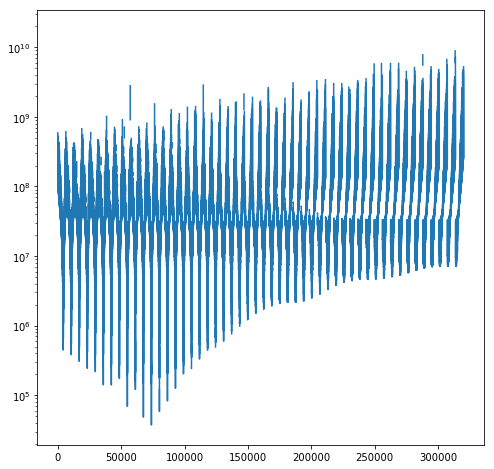

In [68]:
plt.semilogy(res[3].ravel(), )

## Plot the solution space (3D space projected on several 2D spaces)

In [71]:
res[2].shape

(3, 50, 80, 80)

In [70]:
res[3].shape

(50, 80, 80)

In [96]:
best_index = np.unravel_index(res[3].argmin(), res[3].shape)
best_index

(9, 45, 48)

In [97]:
res[3][best_index]

37416.372490660222

In [144]:
k_best_index = np.unravel_index(res[3].argmin(), res[3].shape)[0]

def plot_projection(k_index):
    fig, ax = plt.subplots(figsize=(6, 6))

    xx = res[2][1][k_index, :, :]
    yy = res[2][2][k_index, :, :]

    zz = res[3][k_index, :, :]

    min_value = res[3][best_index]
    max_value = min_value*10000
    
    levels = np.array([10.*min_value,
                       100.*min_value,
                       500.*min_value,
                       1000.*min_value])

    im = ax.pcolormesh(xx, yy, zz,
                       vmin=min_value,
                       vmax=max_value,
                       norm=colors.LogNorm(),
                       cmap='gnuplot2')

    plt.colorbar(im, ax=ax)

    cs = plt.contour(xx, yy, zz, levels,
                     linewidths=(2, 2, 2, 3),
                     linestyles=('dotted', 'dashed', 'solid', 'solid'),
                     alpha=0.5,
                     colors='blue')
    ax.clabel(cs, inline=False, fontsize=12)

    # PLOT ########################################################################

    ax.scatter(res[0][1],
               res[0][2],
               c='red',
               label="$x^*$")
    
    #print(res[2][0][k_index, :, :])
    ax.set_title("k = {} ({})".format(res[2][0][k_index, 0, 0], k_index))

    ax.legend(fontsize=12)
    

    plt.show()

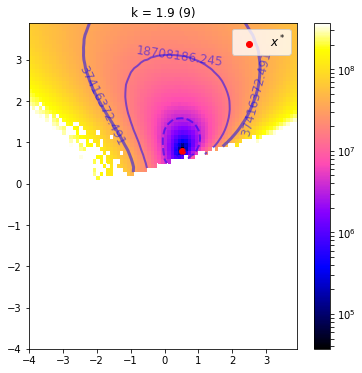

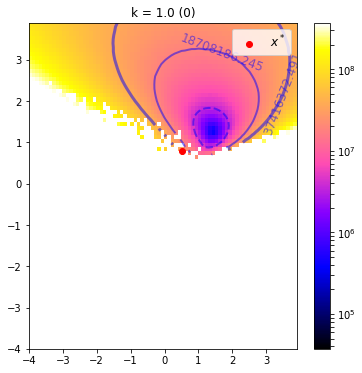

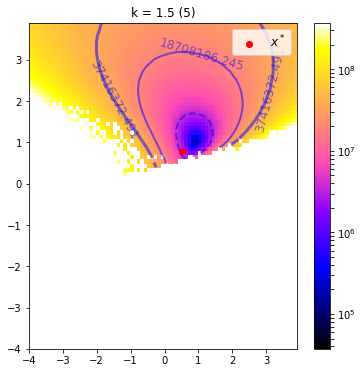

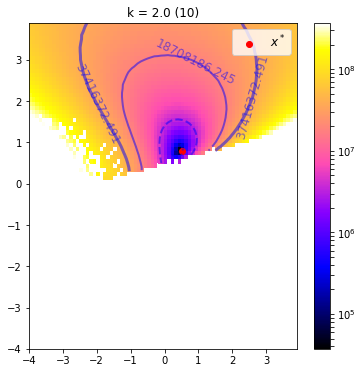

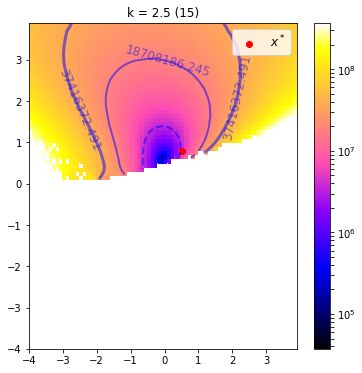

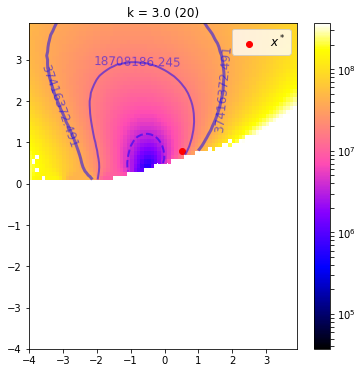

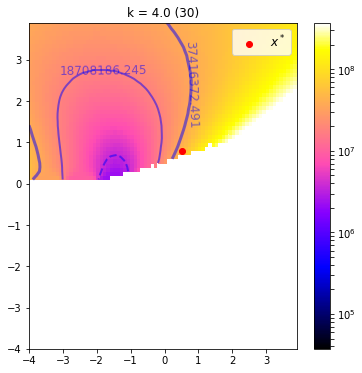

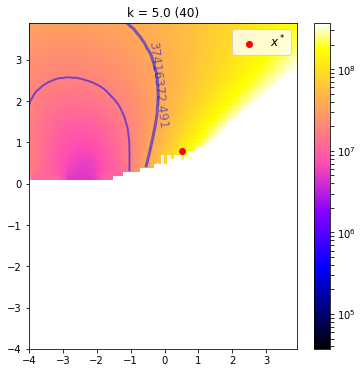

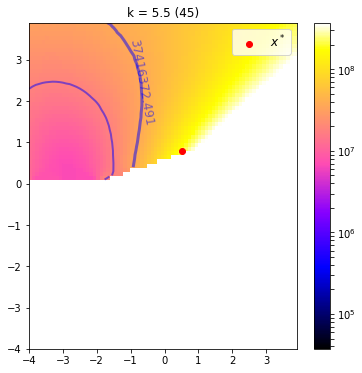

In [145]:
plot_projection(k_best_index)

for k_index in range(0, res[3].shape[0], 5):
    plot_projection(k_index)

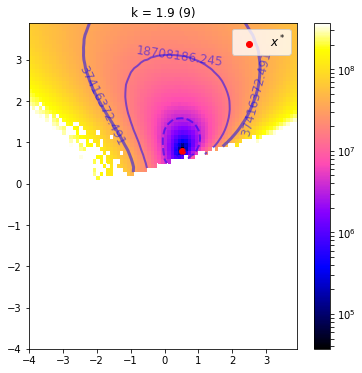

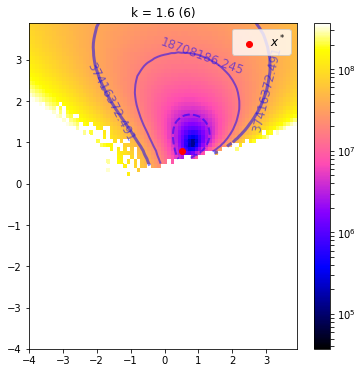

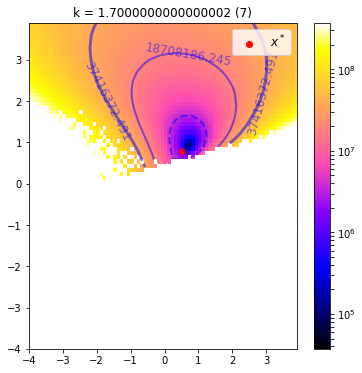

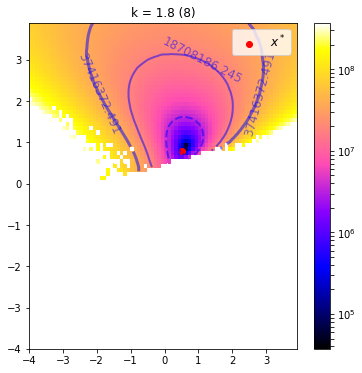

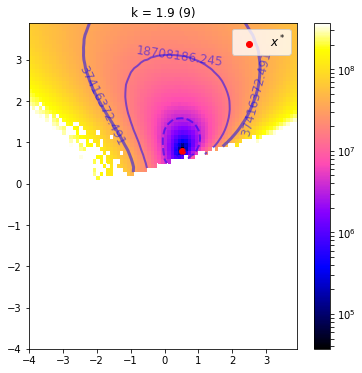

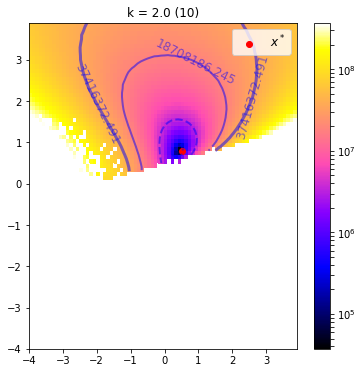

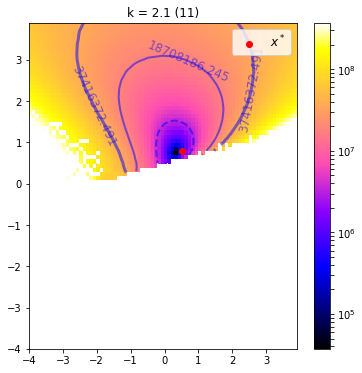

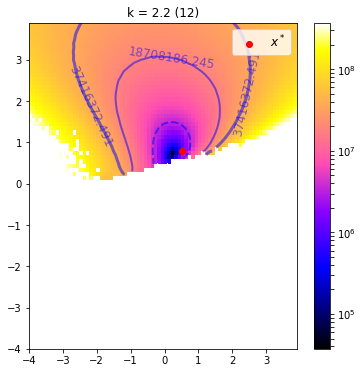

In [146]:
plot_projection(k_best_index)

for k_index in range(max(k_best_index - 3, 0),
                     min(k_best_index + 4, res[3].shape[0])):
    plot_projection(k_index)

## Plot observed vs predicted with the optimal parameter found

33042.970179402393

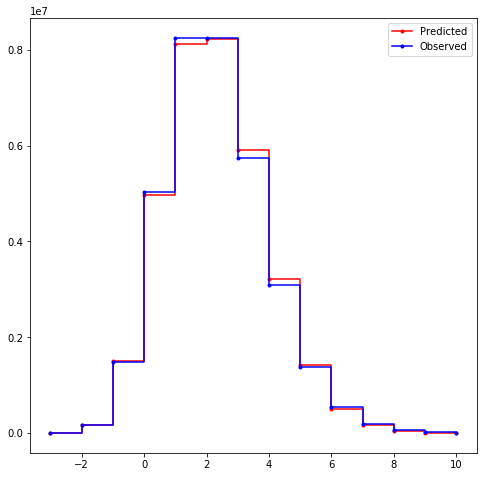

In [74]:
dist_chi2(res[0], plot=True)

## The former optimal parameter found with fmin was...

x* = [ 1.98064017  0.42485775  0.77274323]
f(x*) = 25645.10163
CPU times: user 30min 56s, sys: 8.58 s, total: 31min 5s
Wall time: 31min 13s

In [64]:
dist_chi2([ 1.98064017, 0.42485775, 0.77274323], plot=True)

33573.659941057223

## Plot observed vs predicted with my former parameter found "by hand"

5220937.415729966

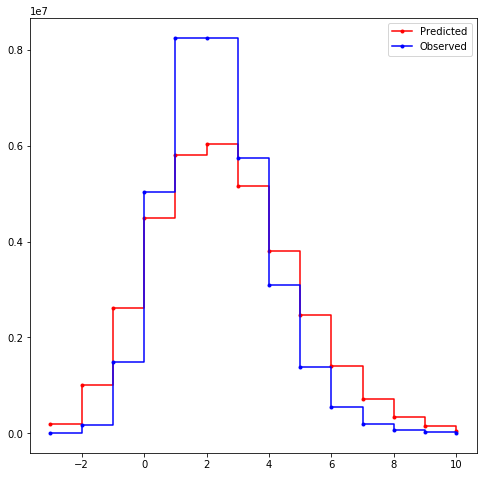

In [61]:
# This is the parameters I choosed by hand

INJECT_NOISE_IN_NAN_LAMBDA = 5
INJECT_NOISE_IN_NAN_MU = -2.1
INJECT_NOISE_IN_NAN_SIGMA = 0.1

x = (INJECT_NOISE_IN_NAN_LAMBDA, INJECT_NOISE_IN_NAN_MU, INJECT_NOISE_IN_NAN_SIGMA)
dist_chi2(x, plot=True)

## Plot observed vs predicted with Tino's former parameter found "by hand"

50473889.034121267

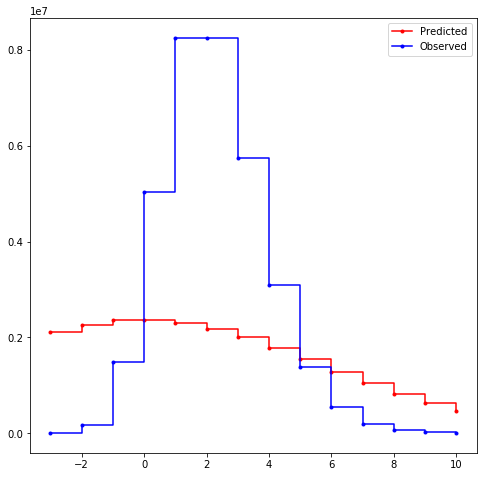

In [153]:
# This is the parameters I choosed by hand

INJECT_NOISE_IN_NAN_MU = 0.13
INJECT_NOISE_IN_NAN_SIGMA = 5.77

x = (None, INJECT_NOISE_IN_NAN_MU, INJECT_NOISE_IN_NAN_SIGMA)
dist_chi2(x, plot=True)